In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
 
import xgboost as xgb
from tqdm import tqdm

# svm
from sklearn.svm import SVC
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV

# tfdifc& countervectorizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# naive_bays multinomail 
from sklearn.naive_bayes import MultinomialNB

from keras.models import Sequential
from keras.layers.recurrent import LSTM, GRU
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.embeddings import Embedding
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.preprocessing import sequence, text
from keras.callbacks import EarlyStopping

from nltk import word_tokenize
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

import warnings
warnings.filterwarnings('ignore')

In [13]:
import os

os.listdir("data/")

['test.zip', 'train.zip']

In [14]:
train = pd.read_csv('data/train.zip')
test = pd.read_csv('data/test.zip')

In [15]:
train.head()

id                                               text author
0  id26305  This process, however, afforded me no means of...    EAP
1  id17569  It never once occurred to me that the fumbling...    HPL
2  id11008  In his left hand was a gold snuff box, from wh...    EAP
3  id27763  How lovely is spring As we looked from Windsor...    MWS
4  id12958  Finding nothing else, not even gold, the Super...    HPL

In [16]:
test.head()

id                                               text
0  id02310  Still, as I urged our leaving Ireland with suc...
1  id24541  If a fire wanted fanning, it could readily be ...
2  id00134  And when they had broken down the frail door t...
3  id27757  While I was thinking how I should possibly man...
4  id04081  I am not sure to what limit his knowledge may ...

In [17]:
print("There are %d number of authors in train set" %(len(train['author'].unique())))
# print("There are {} number of authors in test set".format(len(test['author'].unique()))) 


There are 3 number of authors in train set


In [18]:
train.isna().sum()
test.isna().sum()

id      0
text    0
dtype: int64

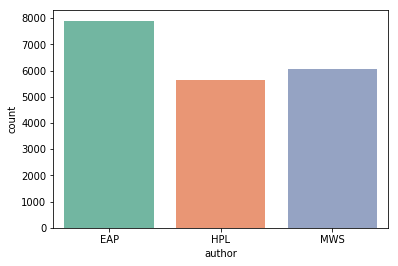

In [19]:
sns.countplot(x='author', data= train, palette = 'Set2')
plt.show()

Preparing LabelEncoder from scikit-learn to convert text labels to integers

In [20]:
lbl_enc = preprocessing.LabelEncoder()
y = lbl_enc.fit_transform(train['author'].values)

Train-Test split

In [21]:
# from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train['text'].values, 
                                                    y,
                                                    stratify=y,
                                                    random_state=42, 
                                                    test_size=0.1, 
                                                    shuffle=True)

In [24]:
X_train_shape = X_train.shape
X_test_shape = X_test.shape

print(f"There are {X_train_shape[0]} number of training set and {X_test_shape[0]} number of testing set")

There are 17621 number of training set and 1958 number of testing set


tfidf (Term Freq Inverse Doc Freq)

In [25]:
tfv = TfidfVectorizer(min_df=3,  
                      max_features=None, 
                      strip_accents='unicode',
                      analyzer='word',
                      token_pattern=r'\w{1,}',
                      ngram_range=(1, 3),
                      use_idf=1,
                      smooth_idf=1,
                      sublinear_tf=1,
                      stop_words = 'english')

tfv.fit(list(X_train) + list(X_test))

## Fitting TF-IDF
X_train_tfv =  tfv.transform(X_train) 
X_test_tfv = tfv.transform(X_test)


In [26]:
print(X_train_tfv.shape)
print(X_test_tfv.shape)

(17621, 15102)
(1958, 15102)


In [27]:
def multiclass_logloss(actual, predicted, eps=1e-15):
    # Convert 'actual' to a binary array if it's not already:
    if len(actual.shape) == 1:
        actual2 = np.zeros((actual.shape[0], predicted.shape[1]))
        for i, val in enumerate(actual):
            actual2[i, val] = 1
        actual = actual2

    clip = np.clip(predicted, eps, 1 - eps)
    rows = actual.shape[0]
    vsota = np.sum(actual * np.log(clip))
    return -1.0 / rows * vsota

In [28]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_auc_score

def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    
    return roc_auc_score(y_test, y_pred, average=average)

In [29]:
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score 
from sklearn.metrics import roc_curve, auc, log_loss

# LogisticRegression
logreg = LogisticRegression(C= 1.0)
logreg.fit(X_train_tfv, y_train)

# Prediction
y_pred = logreg.predict(X_test_tfv)
y_pred_proba = logreg.predict_proba(X_test_tfv)

#[fpr, tpr, thr] = roc_curve(y_test, y_pred_proba[:,1])

# Print out the result: 
print('Train/Test split results:')
print(logreg.__class__.__name__+" accuracy is %2.3f" % accuracy_score(y_test, y_pred))
print(logreg.__class__.__name__+" log_loss is %0.3f" % multiclass_logloss(y_test, y_pred_proba))
print(logreg.__class__.__name__+" auc is %2.3f" % multiclass_roc_auc_score(y_test, y_pred))

Train/Test split results:
LogisticRegression accuracy is 0.793
LogisticRegression log_loss is 0.626
LogisticRegression auc is 0.838


CounterVectorizer from scikit-learn

In [30]:
ctv = CountVectorizer(analyzer='word',
                      token_pattern=r'\w{1,}',
                      ngram_range=(1, 3), 
                      stop_words = 'english')

# Fitting Count Vectorizer to both training and test sets (semi-supervised learning)
ctv.fit(list(X_train) + list(X_test))
X_train_ctv =  ctv.transform(X_train) 
X_test_ctv = ctv.transform(X_test)

In [31]:
print("The shape of train is {0}".format(X_train_ctv.shape))
print("The shape of validation is {0}".format(X_test_ctv.shape))

The shape of train is (17621, 400266)
The shape of validation is (1958, 400266)


In [32]:
# LogisticRegression
logreg = LogisticRegression(C= 1.0)
logreg.fit(X_train_ctv, y_train)

# Prediction
y_pred = logreg.predict(X_test_ctv)
y_pred_proba = logreg.predict_proba(X_test_ctv)

# Print out the result: 
print('CounterVectorize results:')
print(logreg.__class__.__name__+" accuracy is %2.3f" % accuracy_score(y_test, y_pred))
print(logreg.__class__.__name__+" log_loss is %2.3f" % multiclass_logloss(y_test, y_pred_proba))
print(logreg.__class__.__name__+" auc is %2.3f" % multiclass_roc_auc_score(y_test, y_pred))

CounterVectorize results:
LogisticRegression accuracy is 0.781
LogisticRegression log_loss is 0.528
LogisticRegression auc is 0.828


Naive Bayes on TFIDF

In [33]:
# Naive Bays on TFIDF
nb = MultinomialNB()
nb.fit(X_train_tfv, y_train)

# Prediction
y_pred = nb.predict(X_test_tfv)
y_pred_proba = nb.predict_proba(X_test_tfv)


# Print out the result: 
print('Naive Bays on TFIDF results:')
print(nb.__class__.__name__+" accuracy is %2.3f" % accuracy_score(y_test, y_pred))
print(nb.__class__.__name__+" log_loss is %2.3f" % multiclass_logloss(y_test, y_pred_proba))
print(nb.__class__.__name__+" auc is %2.3f" % multiclass_roc_auc_score(y_test, y_pred))

Naive Bays on TFIDF results:
MultinomialNB accuracy is 0.816
MultinomialNB log_loss is 0.578
MultinomialNB auc is 0.857


Naive Bays on CounterVectorize

In [34]:
# Naive Bayes on CounterVectroize
nb = MultinomialNB()
nb.fit(X_train_ctv, y_train)

# Prediction
y_pred = nb.predict(X_test_ctv)
y_pred_proba = nb.predict_proba(X_test_ctv)

# Print out the result:
print('Naive Bayes on CounterVecterize results: ')
print(nb.__class__.__name__+" accuracy is %2.3f" % accuracy_score(y_test, y_pred))
print(nb.__class__.__name__+" log_loss is %2.3f" % multiclass_logloss(y_test, y_pred_proba))
print(nb.__class__.__name__+" auc is %2.3f" % multiclass_roc_auc_score(y_test, y_pred))

Naive Bayes on CounterVecterize results: 
MultinomialNB accuracy is 0.832
MultinomialNB log_loss is 0.485
MultinomialNB auc is 0.874


SVM on TFIDF

Since SVMs take a lot of time, reducing the number of features from the TFIDF using Singular Value Decomposition before applying SVM.

In [35]:
# try 100
svd = decomposition.TruncatedSVD(n_components=100)
svd.fit(X_test_tfv)
X_train_svd = svd.transform(X_train_tfv)
X_test_svd = svd.transform(X_test_tfv)

## Scale the data for SVM
# from sklearn.preprocessing import StandardScaler
scale = preprocessing.StandardScaler()
scale.fit(X_train_svd)

X_train_svd_scale = scale.transform(X_train_svd)
X_test_svd_scale = scale.transform(X_test_svd)

In [36]:
print("The shape of Singular Value Decomposition train is : {}".format(X_train_svd_scale.shape))
print("The shape of Singular Value Decomposition test is : {}".format(X_test_svd_scale.shape))

The shape of Singular Value Decomposition train is : (17621, 100)
The shape of Singular Value Decomposition test is : (1958, 100)


In [37]:
# SVM
svm = SVC(C= 1.0, probability=True)
svm.fit(X_train_svd_scale, y_train)

# Prediction
y_pred = svm.predict(X_test_svd_scale)
y_pred_proba = svm.predict_proba(X_test_svd_scale)

# Print out the result:
print('SVM on TFIDF results: ')
print(nb.__class__.__name__+" accuracy is %2.3f" % accuracy_score(y_test, y_pred))
print(nb.__class__.__name__+" log_loss is %2.3f" % multiclass_logloss(y_test, y_pred_proba))
print(nb.__class__.__name__+" auc is %2.3f" % multiclass_roc_auc_score(y_test, y_pred))

SVM on TFIDF results: 
MultinomialNB accuracy is 0.557
MultinomialNB log_loss is 0.907
MultinomialNB auc is 0.638


Basic XGBoost on CounterVectorize

In [38]:
# XGBOOST
xg = xgb.XGBClassifier(max_depth = 7, 
                      n_estimators = 100, 
                      colsample_bytree = 0.8,
                      subsample = 0.8, 
                      nthread = 10,
                      learning_rate = 0.1)

xg.fit(X_train_ctv.tocsc(), y_train)

# Prediction
y_pred = xg.predict(X_test_ctv.tocsc())
y_pred_proba = xg.predict_proba(X_test_ctv.tocsc())

# Print out the result:
print('XG on CounterVectorize results: ')
print(xg.__class__.__name__+" accuracy is %2.3f" % accuracy_score(y_test, y_pred))
print(xg.__class__.__name__+" log_loss is %2.3f" % multiclass_logloss(y_test, y_pred_proba))
print(xg.__class__.__name__+" auc is %2.3f" % multiclass_roc_auc_score(y_test, y_pred))

XG on CounterVectorize results: 
XGBClassifier accuracy is 0.628
XGBClassifier log_loss is 0.849
XGBClassifier auc is 0.700


Grid Search

In [72]:
mll_scorer = metrics.make_scorer(multiclass_logloss, 
                                 greater_is_better=False, 
                                 needs_proba=True)

In [73]:
# Initialize SVD
svd = TruncatedSVD()

# Standard Scaler
scl = preprocessing.StandardScaler()

# Logistic Regression
lr_model = LogisticRegression()

# Create the pipeline 
clf = pipeline.Pipeline([('svd', svd),
                         ('scl', scl),
                         ('lr', lr_model)
                        ])

In [74]:
# Setting up parameter
param_grid = {'svd__n_components' : [100, 180],
              'lr__C': [0.1, 1.0, 10], 
              'lr__penalty': ['l1', 'l2']}

scorers = {
    'Accuracy': make_scorer(accuracy_score),
    'AUC': metrics.make_scorer(multiclass_roc_auc_score),
    'Log_Loss': metrics.make_scorer(multiclass_logloss,
                                    greater_is_better=False, 
                                    needs_proba=True)
}

In [76]:
model = GridSearchCV(estimator= clf, 
                     param_grid=param_grid,
                     scoring= mll_scorer, 
                     verbose= 10, 
                     n_jobs= -1, 
                     iid= True, 
                     refit= True, 
                     cv = 2)

model.fit(X_train_tfv, y_train)


Fitting 2 folds for each of 12 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   46.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  12 out of  24 | elapsed:  1.8min remaining:  1.8min
[Parallel(n_jobs=-1)]: Done  15 out of  24 | elapsed:  2.1min remaining:  1.2min
[Parallel(n_jobs=-1)]: Done  18 out of  24 | elapsed:  2.6min remaining:   52.1s
[Parallel(n_jobs=-1)]: Done  21 out of  24 | elapsed:  2.7min remaining:   23.5s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:  2.8min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:  2.8min finished


GridSearchCV(cv=2, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('svd', TruncatedSVD(algorithm='randomized', n_components=2, n_iter=5,
       random_state=None, tol=0.0)), ('scl', StandardScaler(copy=True, with_mean=True, with_std=True)), ('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'svd__n_components': [100, 180], 'lr__C': [0.1, 1.0, 10], 'lr__penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(multiclass_logloss, greater_is_better=False, needs_proba=True),
       verbose=10)

In [77]:
print("Best Score : %0.3f" %model.best_score_)
print("Best Parameters set:")

best_parameters = model.best_estimator_.get_params()
for p in sorted(param_grid.keys()):
    print('\t %s: %r' %(p, best_parameters[p]))

Best Score : -0.740
Best Parameters set:
	 lr__C: 1.0
	 lr__penalty: 'l1'
	 svd__n_components: 180


In [79]:
nb = MultinomialNB()

clf = pipeline.Pipeline([('nb', nb)])

param_grid = {'nb__alpha':[0.001, 0.01, 0.1, 1, 10, 100]}

model = GridSearchCV(estimator=clf,
                    param_grid=param_grid, 
                    scoring=mll_scorer, 
                    verbose=10, 
                    n_jobs=-1, 
                    iid= True, 
                    refit= True, 
                    cv = 2)

model.fit(X_train_tfv, y_train)

Fitting 2 folds for each of 6 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done   3 out of  12 | elapsed:    2.0s remaining:    6.1s
[Parallel(n_jobs=-1)]: Done   5 out of  12 | elapsed:    2.0s remaining:    2.8s
[Parallel(n_jobs=-1)]: Done   7 out of  12 | elapsed:    2.0s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done   9 out of  12 | elapsed:    2.1s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    2.1s finished


GridSearchCV(cv=2, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('nb', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'nb__alpha': [0.001, 0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(multiclass_logloss, greater_is_better=False, needs_proba=True),
       verbose=10)

In [82]:
print("Best Score: %0.3f" %model.best_score_)
print("Best Parameters Set:")
best_parameters = model.best_estimator_.get_params()

for p in sorted(param_grid.keys()):
    print("\t %s: %r" %(p, best_parameters[p]))

Best Score: -0.492
Best Parameters Set:
	 nb__alpha: 0.1


In [83]:
import os

os.listdir("data/")

['glove.840B.300d.zip', 'glove.840B.300d.zip.part', 'test.zip', 'train.zip']

In [98]:
filepath = 'data/glove.840B.300d.txt'
with open(filepath) as fp:
   line = fp.readline()
   cnt = 1
   while line:
       print("Line {}: {}".format(cnt, line.strip()))
       line = fp.readline()
       cnt += 1

Line 1: , -0.082752 0.67204 -0.14987 -0.064983 0.056491 0.40228 0.0027747 -0.3311 -0.30691 2.0817 0.031819 0.013643 0.30265 0.0071297 -0.5819 -0.2774 -0.062254 1.1451 -0.24232 0.1235 -0.12243 0.33152 -0.006162 -0.30541 -0.13057 -0.054601 0.037083 -0.070552 0.5893 -0.30385 0.2898 -0.14653 -0.27052 0.37161 0.32031 -0.29125 0.0052483 -0.13212 -0.052736 0.087349 -0.26668 -0.16897 0.015162 -0.0083746 -0.14871 0.23413 -0.20719 -0.091386 0.40075 -0.17223 0.18145 0.37586 -0.28682 0.37289 -0.16185 0.18008 0.3032 -0.13216 0.18352 0.095759 0.094916 0.008289 0.11761 0.34046 0.03677 -0.29077 0.058303 -0.027814 0.082941 0.1862 -0.031494 0.27985 -0.074412 -0.13762 -0.21866 0.18138 0.040855 -0.113 0.24107 0.3657 -0.27525 -0.05684 0.34872 0.011884 0.14517 -0.71395 0.48497 0.14807 0.62287 0.20599 0.58379 -0.13438 0.40207 0.18311 0.28021 -0.42349 -0.25626 0.17715 -0.54095 0.16596 -0.036058 0.08499 -0.64989 0.075549 -0.28831 0.40626 -0.2802 0.094062 0.32406 0.28437 -0.26341 0.11553 0.071918 -0.47215 -0.18

Line 4: and -0.18567 0.066008 -0.25209 -0.11725 0.26513 0.064908 0.12291 -0.093979 0.024321 2.4926 -0.017916 -0.071218 -0.24782 -0.26237 -0.2246 -0.21961 -0.12927 1.0867 -0.66072 -0.031617 -0.057328 0.056903 -0.27939 -0.39825 0.14251 -0.085146 -0.14779 0.055067 -0.0028687 -0.20917 -0.070735 0.22577 -0.15881 -0.10395 0.09711 -0.56251 -0.32929 -0.20853 0.0098711 0.049777 0.0014883 0.15884 0.042771 -0.0026956 -0.02462 -0.19213 -0.22556 0.10838 0.090086 -0.13291 0.32559 -0.17038 -0.1099 -0.23986 -0.024289 0.014656 -0.237 0.084828 -0.35982 -0.076746 0.048909 0.11431 -0.21013 0.24765 -0.017531 -0.14028 0.046191 0.22972 0.1175 0.12724 0.012992 0.4587 0.41085 0.039106 0.15713 -0.18376 0.26834 0.056662 0.16844 -0.053788 -0.091892 0.11193 -0.08681 -0.13324 0.15062 -0.31733 -0.22078 0.25038 0.34131 0.36419 -0.089514 -0.22193 0.24471 0.040091 0.47798 -0.029996 0.0019212 0.063511 -0.20417 -0.26478 0.20649 0.015573 -0.27722 -0.18861 -0.10289 -0.49773 0.14986 -0.010877 0.25085 -0.28117 0.18966 -0.065

Line 7: a 0.043798 0.024779 -0.20937 0.49745 0.36019 -0.37503 -0.052078 -0.60555 0.036744 2.2085 -0.23389 -0.06836 -0.22355 -0.053989 -0.15198 -0.17319 0.053355 1.6485 -0.047991 -0.085311 -0.15712 -0.64425 -0.39819 0.278 0.15364 0.031678 0.055414 0.015939 0.31851 -0.058979 0.038584 0.1077 0.1041 -0.077346 0.37396 -0.21482 0.3832 -0.27737 -0.18352 -0.83838 0.34124 0.58164 0.18543 -0.31028 0.17666 -0.069421 -0.34422 -0.13665 -0.10823 0.23637 -0.32923 0.61348 0.1972 0.087123 0.10785 0.3073 0.13757 0.30809 0.24331 -0.29422 -0.0098214 0.55675 -0.04888 0.099468 0.30543 -0.37597 -0.19525 0.046246 -0.036675 0.34023 0.14905 0.0978 -0.26664 0.056834 -0.043201 -0.23338 0.13111 -0.35742 -0.3607 0.30997 -0.19727 -0.1432 -0.16747 0.00042435 -0.1512 0.067562 -0.38644 0.025349 0.24918 -0.23955 -0.15615 0.49868 0.0082758 -0.1912 -0.14906 0.48757 -0.015281 0.010196 0.37642 -0.01946 -0.27835 0.16355 -0.24127 -0.21405 -0.21562 -0.79697 0.34321 0.093209 0.073977 -0.27147 0.20539 0.15061 0.020734 0.11267 0.

Line 10: : 0.008746 0.33214 -0.29175 -0.15119 -0.41842 -0.23931 -0.23458 -0.055618 -0.09896 0.75175 -0.66615 -0.10734 0.021663 -0.12194 0.022265 0.029731 0.036949 1.3326 -0.10886 -0.22681 -0.28436 0.021524 0.22749 -0.093169 -0.11529 0.51138 0.13868 -0.10885 -0.11482 -0.0074179 0.16234 0.0082633 -0.0023698 -0.39662 0.29591 0.22499 -0.46529 0.40232 0.027284 0.14321 0.034624 0.36936 -0.37351 0.22866 -0.29724 0.28951 -0.44012 0.47265 -0.070029 0.54446 0.30543 0.28181 0.063914 -0.30986 -0.40254 -0.032463 -0.39762 0.45387 0.075187 0.068059 0.12686 0.056289 0.29042 0.2362 0.34559 -0.14253 -0.016066 -0.058892 0.22277 0.31318 -0.37625 -0.044296 -0.017026 0.14938 0.87661 0.30364 -0.57488 -0.075509 -0.14493 0.16592 -0.67818 0.45022 -0.23441 -0.077216 0.32643 -0.1757 -0.0067939 -0.51045 0.56891 0.16143 0.18519 0.037305 -0.4579 -0.12869 0.19132 -0.38693 -0.1352 0.050239 0.36475 -0.061642 -0.181 -0.19424 0.46758 -0.25859 0.00027713 1.8061 -0.031111 -0.253 -0.043878 0.33484 0.21194 -0.16946 -0.012677

Line 13: I 0.1941 0.22603 -0.43764 -0.11387 -0.072725 0.36003 -0.063595 0.056585 -0.094555 2.3561 -0.27436 0.2713 0.69901 -0.17141 -0.28441 0.079379 -0.0076581 0.80703 -0.29701 0.23268 0.10555 0.026901 -0.041876 0.42066 -0.41432 -0.035023 -0.15162 -0.30763 0.27783 -0.42092 -0.13631 0.46588 0.036089 0.025686 -0.24905 0.084332 0.20581 -0.031679 -0.36279 0.039448 -0.071993 0.19942 0.024882 0.0023524 0.3903 0.3625 -0.3792 -0.18546 0.30258 -0.20954 0.01513 -0.072947 0.094768 0.21254 0.21272 -0.10312 -0.099089 -0.53423 0.029063 -0.12531 -0.098028 -0.43503 0.0049565 0.42591 -0.13379 -0.3615 0.21092 -0.068105 0.017606 0.49779 0.075874 0.24429 0.2235 0.13629 0.35652 0.4428 0.18241 -0.093236 -0.40088 0.26121 -0.0063511 -0.08222 0.016147 -0.18581 0.26591 -0.20448 -0.074365 -0.87302 0.68109 0.24958 -0.039915 -0.27137 -0.24405 0.34407 0.19653 0.16447 0.36421 0.18319 0.063041 0.16639 -0.16222 -0.13024 0.064095 -0.20605 0.16473 -0.12235 -0.064946 -0.26915 -0.16601 0.10875 0.071209 -0.22957 0.60131 -0

Line 16: that 0.09852 0.25001 -0.27018 -0.23186 0.022378 0.045321 -0.052444 -0.058867 -0.031937 3.0121 -0.023642 -0.077292 0.30742 0.073579 -0.33171 -0.16588 -0.020228 1.085 -0.42189 -0.24159 0.20511 0.025093 0.11497 -0.024636 -0.10416 0.19698 -0.20124 -0.036615 -0.15073 -0.25125 -0.16182 0.22131 -0.041937 0.064382 0.066347 -0.0069173 -0.13059 -0.037921 -0.13478 -0.095946 0.016818 0.26046 0.040114 -0.20923 0.23095 -0.059719 -0.38339 -0.10134 -0.10069 0.073018 -0.27729 0.08258 -0.073222 0.19346 0.23859 -0.052506 0.13046 -0.1345 -0.096133 -0.11073 0.098949 -0.0050032 -0.12383 0.35765 -0.11829 -0.22458 0.023951 0.24224 0.041263 0.11803 -0.0027008 0.020971 0.3115 -0.021006 -0.1889 -0.11755 -0.1038 -0.20398 -0.20374 0.34373 0.10465 0.12733 -0.34323 -0.21958 0.21851 -0.46476 -0.13259 -0.4958 0.29493 0.052023 -0.030517 0.0040759 -0.12702 0.29625 0.14591 0.051789 -0.093879 -0.085754 -0.18455 0.044252 0.058965 0.18165 -0.18175 -0.078165 0.069561 -1.285 -0.054441 0.15005 -0.16758 -0.055905 -0.03

Line 19: you -0.11076 0.30786 -0.5198 0.035138 0.10368 -0.052505 -0.18021 -0.11839 -0.054253 2.498 -0.30241 0.043233 -0.095862 -0.093529 -0.19817 -0.26599 -0.34703 1.4518 -0.49013 0.041637 0.11185 -0.019023 -0.18716 -0.10407 -0.43665 0.073561 0.019546 -0.15012 0.18499 -0.24364 0.20327 0.28916 -0.21694 0.28351 -0.10092 -0.042189 -0.073457 0.27325 -0.12898 -0.059407 -0.073329 0.01249 -0.20459 -0.44558 0.040863 0.24588 -0.26111 -0.086821 0.13628 0.11094 -0.10835 0.0098775 0.17394 0.006475 0.27467 -0.0097433 0.16561 -0.16975 -0.12561 -0.071688 -0.056815 -0.28632 -0.24231 0.27819 0.24112 -0.009142 -0.053634 0.43907 0.39 0.1252 -0.063581 0.058089 0.59187 -0.18385 0.090201 0.13788 0.41051 -0.39034 -0.071701 0.37935 0.031344 -0.003615 -0.25773 -0.048608 0.1952 -0.29912 0.04721 -0.13577 0.67253 -0.083033 -0.1968 0.074079 0.17826 0.20097 -0.036357 0.027783 -0.32144 -0.2962 -0.1326 0.30375 0.05418 0.070012 0.11935 0.04668 0.37338 -0.63809 0.33868 -0.091924 -0.12639 0.068526 0.11981 -0.22509 0.560

Line 22: it 0.0013629 0.35653 -0.055497 -0.16607 0.0031402 -0.061926 -0.24759 -0.22897 -0.09105 2.6751 -0.15062 0.072403 0.0061949 -0.0065698 -0.26418 -0.19543 -0.15048 1.2156 -0.12551 -0.12572 0.023065 0.024727 0.14311 0.10148 -0.10566 0.07864 -0.10306 -0.11968 0.04202 -0.36815 -0.087136 0.38589 0.0044597 -0.18259 -0.1226 -0.10454 0.16039 0.27415 0.042427 -0.049497 0.041286 0.12223 0.10821 -0.056199 0.21754 0.10983 -0.38878 -0.10935 -0.36647 0.1342 -0.076634 0.38148 -0.19979 0.09391 0.35189 -0.11133 0.095313 -0.29593 0.29022 -0.1966 -0.10331 -0.21995 -0.041991 0.16631 0.01523 -0.29185 -0.05472 -0.040665 0.084861 -0.009206 0.24625 0.081873 0.34256 -0.16768 -0.079394 0.13206 0.2156 -0.11199 -0.39589 0.32299 0.089602 -0.026041 -0.23981 0.049861 0.055241 -0.50554 0.23002 -0.54613 0.58194 0.096957 -0.015559 0.069833 -0.009668 0.19936 0.19006 0.32913 -0.064844 -0.22404 -0.031196 0.1818 -0.071896 -0.072126 -0.082155 0.064145 0.11215 -1.0712 0.29581 0.081019 -0.24954 -0.087734 0.015893 -0.157

Line 25: by -0.15552 -0.33723 -0.097191 -0.21617 -0.30091 -0.014825 -0.055501 -0.028312 -0.64854 1.893 -0.056772 0.17062 -0.63128 0.039063 -0.49355 -0.67845 0.17266 1.17 -0.043622 -0.044675 -0.056084 -0.72703 -0.10162 0.43005 0.14374 -0.074174 -0.33236 0.28842 -0.11704 0.10521 0.099627 0.33434 -0.54069 -0.073547 -0.077814 0.032505 -0.00093332 0.353 0.18943 -0.40841 0.27317 -0.109 -0.009964 0.10401 0.10594 0.076474 -0.14849 0.047987 0.1036 -0.046399 0.15671 0.21278 -0.38093 -0.093375 -0.38804 -0.17406 -0.032507 0.014314 0.1992 -0.066915 -0.10672 0.21585 -0.62164 0.0035906 -0.21094 0.03703 0.33731 -0.077223 -0.059763 -0.43963 0.31009 -0.22205 0.058459 0.19276 0.61255 -0.95163 0.53651 -0.40198 -0.29058 0.04702 0.55323 0.25048 -0.51333 -0.512 0.041632 -0.37089 -0.043145 -0.1155 -0.37281 0.47959 -0.041738 0.10756 -0.015585 0.055004 -0.74831 -0.62378 0.25061 0.23813 0.19009 0.02051 0.042893 -0.044668 -0.082635 0.0611 -0.63611 0.32051 -0.32208 -0.32733 -0.11604 -0.14944 -0.30088 -0.98356 0.44

Line 28: this -0.087595 0.35502 0.063868 0.29292 -0.23635 -0.062773 -0.16105 -0.22842 0.041587 2.4844 -0.38217 0.032806 0.12348 -0.0018422 -0.13848 -0.0010005 -0.043081 1.1659 -0.047327 -0.056004 0.15617 -0.13394 0.23229 0.087602 -0.32329 0.16721 -0.16221 -0.091919 -0.38004 0.12686 0.067819 0.32509 -0.057245 -0.3263 -0.11903 -0.00063964 -0.0059275 -0.29934 -0.085043 -0.26683 -0.15815 0.25963 0.22571 0.062582 -0.19394 0.21922 -0.31186 0.37084 -0.36577 -0.052483 -0.43101 0.12379 0.015529 -0.12505 0.22327 0.29365 -0.0085104 -0.083909 0.24078 -0.34913 -0.28355 -0.076594 -0.1713 0.32869 0.29024 -0.062741 -0.055278 -0.28706 0.079608 0.13234 0.47857 0.19623 0.27314 -0.13089 0.2763 -0.088846 -0.12379 0.073987 -0.51962 0.35227 -0.029182 0.16203 -0.036908 0.28035 0.31739 -0.27597 -0.43637 -0.32842 0.3676 -0.16278 -0.16278 0.37066 -0.1134 0.3092 0.26133 0.39483 -0.074612 -0.22158 0.25172 0.2999 0.10566 -0.11406 -0.35395 0.066704 0.050216 -0.71479 0.098646 -0.058832 -0.004779 -0.2392 0.10179 -0.27

Line 31: was -0.044058 0.36611 0.18032 -0.24942 -0.098095 0.033261 0.119 -0.51164 -0.16415 3.136 0.20901 0.29082 0.25193 -0.020379 -0.24789 -0.47501 -0.038328 0.56434 -0.038566 -0.11559 0.024392 -0.45873 -0.10009 0.21731 0.16996 -0.12939 0.0063318 -0.017798 -0.18673 -0.1167 -0.14384 -0.0097187 0.45289 -0.036453 -0.40523 -0.31816 -0.23389 -0.012272 -0.21479 -0.17841 0.34474 0.31133 0.20543 -0.1896 0.38995 0.12103 -0.33685 -0.57051 0.20732 0.087872 0.071458 0.046355 -0.17425 0.27856 0.35989 -0.017122 0.12197 -0.35806 0.33181 -0.19827 -0.10386 -0.096699 0.094231 0.46722 -0.36612 -0.038628 0.063485 -0.25765 -0.20415 0.075931 0.085753 0.28176 -0.12443 -0.19756 0.17218 -0.20121 0.048154 0.1301 -0.51096 0.41643 0.16487 0.083688 0.025331 0.0014575 0.26935 -0.46159 0.18639 -0.6424 -0.2277 0.032521 0.050105 0.1683 -0.27886 -0.037346 0.50521 -0.39343 0.25004 -0.091487 0.044709 0.15579 -0.19423 0.29651 -0.27465 -0.33689 -0.11362 -0.43028 0.016673 -0.015717 0.15385 -0.30998 -0.17927 -0.002689 -0.02

Line 34: ... 0.0018209 0.24872 -0.085487 -0.2651 -0.077903 -0.040373 0.34495 -0.20052 -0.025265 1.5008 -0.15933 0.22853 0.31486 -0.26312 -0.22789 0.32552 0.10725 1.4896 -0.0093954 -0.023273 -0.024069 -0.33346 0.096113 -0.14246 0.54085 -0.14687 -0.096607 0.1508 0.39551 -0.14511 0.032693 0.04658 0.19911 -0.0082258 0.5587 0.033777 0.30058 0.019768 -0.067338 0.16224 0.040982 -0.20677 0.23582 4.3638e-05 0.03735 -0.13202 -0.15831 0.43089 -0.088053 0.39733 0.030608 0.00054839 0.30981 -0.2431 -0.45773 -0.15729 -0.23522 -0.19966 0.17919 0.22009 -0.27463 0.16472 0.061323 -0.0063424 0.27784 0.074449 0.2386 0.13253 -0.021142 0.45142 0.13681 0.099633 0.14277 -0.10781 0.019317 -0.29769 -0.095163 -0.3958 -0.40125 0.18941 -0.055415 0.083563 -0.045629 0.017183 -0.15215 -0.31828 0.045301 -0.29072 0.064429 0.21397 -0.2348 0.11689 -0.26235 0.40053 -0.23541 0.014116 -0.29619 -0.35895 0.021513 -0.31925 -0.17627 0.44686 -0.073948 0.097649 0.083795 0.51213 -0.33082 -0.31237 -0.27611 0.23149 0.23512 -0.12356 0

Line 37: ! -0.26554 0.33531 0.2186 -0.301 -0.05547 -0.24236 0.17236 -0.16334 -0.109 1.2671 -0.33449 0.20911 -0.010205 0.2753 -0.18455 0.017111 -0.037401 1.3706 -0.17785 -0.15351 0.099583 -0.31839 0.077433 0.049495 -0.053451 -0.034892 0.16875 0.028741 0.20523 -0.10273 0.12935 0.35585 0.0040188 0.079254 0.24425 0.27667 0.080892 0.30308 -0.085076 0.0010352 0.1273 0.11868 0.20868 -0.14019 0.24865 0.31383 -0.55654 0.086916 0.40284 0.036714 0.14341 0.30447 0.17679 -0.20325 -0.086745 -0.059375 0.10775 0.26919 0.036491 0.12037 -0.18979 0.19414 -0.018552 -0.45914 0.12681 -0.054521 -0.22054 0.11147 0.0084313 0.20667 0.3106 -0.092659 0.31766 0.16209 0.45862 0.00011182 -0.088286 -0.3703 0.053689 0.79508 -0.24994 0.43256 0.088471 0.41864 0.11771 0.046896 0.53549 -0.86838 0.15809 0.49917 0.26179 0.5214 0.35645 0.14372 -0.36987 -0.14 -0.62828 -0.31675 -0.019247 -0.074357 0.20714 -0.15843 -0.29743 -0.21549 0.080076 1.1832 0.48673 0.14721 0.1263 0.026231 0.36053 -0.68196 0.55184 0.061528 0.0033425 0.04

Line 40: an -0.011662 0.19483 0.088854 0.54694 0.25764 0.15619 -0.34131 -0.21666 -0.14187 2.4525 -0.064806 0.085481 -0.11925 0.0087107 0.18261 -0.29207 -0.11578 1.571 -0.31973 -0.41279 -0.18129 -0.29101 -0.21584 0.19685 0.1524 -0.090306 -0.097694 0.098791 0.067369 -0.24964 0.099773 0.32079 -0.056697 0.32238 0.15905 -0.45345 0.11294 -0.50674 0.23202 -0.55625 0.39208 0.14811 -0.18637 -0.62775 -0.02939 -0.10555 -0.095531 -0.097434 0.1972 0.22059 -0.11017 -0.048332 -0.048414 0.0029998 0.099272 -0.023553 0.014603 -0.098494 -0.14167 0.11831 -0.012322 0.036239 0.10297 0.11158 -0.04193 -0.16625 0.28472 -0.22051 -0.049708 0.32561 -0.244 -0.02814 -0.0071356 -0.22616 -0.089478 0.082447 0.048198 -0.28326 -0.7462 0.60872 0.21592 0.13517 -0.005879 0.15697 0.017543 -0.6507 -0.6081 0.13962 0.28628 -0.34076 -0.32782 0.33876 0.22207 -0.14818 -0.32918 -0.15938 -0.38448 -0.12595 -0.099549 -0.28544 0.0093137 0.0078235 -0.093138 -0.068065 0.026759 -1.0398 0.24762 0.38398 0.6623 -0.26994 0.19174 -0.13892 -0.

Line 43: but -0.01689 0.17402 -0.30247 -0.30063 0.21415 0.063863 0.10107 -0.24155 -0.095228 2.9253 -0.0056759 0.11752 0.16121 0.020813 -0.083593 -0.14048 -0.040069 0.75133 -0.056699 -0.096198 -0.072134 -0.031287 0.18146 -0.24846 -0.065068 0.066374 -0.12173 -0.13479 0.26163 -0.21599 -0.24221 0.091074 -0.043504 -0.18047 -0.18158 -0.066229 0.02648 -0.25439 -0.078805 -0.21853 -0.030239 0.13049 0.10992 0.035563 0.32769 -0.02775 -0.18852 -0.18579 -0.085064 -0.024057 -0.14141 0.12708 -0.079024 -0.1332 0.037619 -0.1108 -0.22742 -0.27703 -0.08176 0.047761 -0.17936 -0.31907 0.13931 0.36374 -0.21399 -0.27044 -0.20847 0.011192 0.16017 0.24218 0.25058 0.32767 0.1334 0.006451 0.017994 0.11242 0.090136 -0.072882 -0.16506 0.483 0.0046465 -0.048611 0.027421 0.097357 0.10873 -0.31722 0.26092 -0.59396 0.26522 0.072456 -0.19246 0.034932 -0.15662 0.30779 0.33744 -0.0048664 0.15165 -0.019861 -0.14789 -0.017031 -0.17279 -0.038278 -0.3256 -0.1645 0.22257 -1.2442 -0.14105 0.074932 -0.18879 -0.10341 -0.0036646 

Line 46: has 0.08552 0.50152 0.11266 -0.18826 0.031677 -0.071113 0.050192 -0.35728 -0.099622 2.8373 0.086855 -0.25438 -0.21734 -0.42633 -0.16354 -0.17934 0.084385 0.93851 -0.012203 -0.011707 -0.3742 -0.17454 0.08119 0.12022 0.24603 0.25672 -0.043428 -0.090614 -0.26686 -0.0079325 -0.046609 0.14579 0.15094 -0.10998 -0.018991 -0.035244 0.05311 -0.12884 -0.1027 -0.29668 0.35315 -0.11833 0.41792 -0.13986 -0.084957 0.13517 -0.35495 -0.21202 -0.086241 0.065012 -0.29758 -0.012614 -0.034377 0.053019 0.12955 -0.018199 0.052818 0.087107 0.3456 -0.409 -0.10121 0.050041 -0.0035056 0.52307 0.031427 -0.17735 0.022926 -0.065055 -0.061981 0.011794 -0.098708 0.088348 0.040219 -0.0048762 -0.41729 -0.11714 0.087954 -0.18609 -0.10958 0.4271 0.12945 -0.061123 -0.35925 0.068195 0.0027888 -0.38928 -0.38928 -0.23107 0.31737 -0.10503 0.33154 0.15447 -0.18044 0.087718 0.27379 -0.033224 -0.046411 0.31346 -0.060112 0.13314 -0.2929 0.14728 -0.33111 0.089051 -0.04406 -0.59566 0.0024168 0.048135 -0.29908 -0.13532 -0.

Line 49: we 0.022669 0.26819 -0.16665 -0.2336 0.30791 0.097166 0.11095 0.4223 0.091264 2.9331 -0.1177 -0.088778 0.42749 -0.10279 -0.32514 0.12988 -0.13386 1.0488 -0.32978 0.12886 0.30973 0.020575 0.20039 0.43253 -0.29318 0.14213 -0.27235 -0.13762 0.048498 -0.18491 -0.13224 0.097864 0.18134 0.15318 -0.1047 0.11942 0.34233 0.075848 -0.20914 -0.0038095 -0.23006 -0.073405 0.1613 -0.05333 -0.051853 0.071669 -0.10083 -0.12493 0.29145 0.0094568 0.13886 -0.02911 -0.034411 0.15095 0.33011 -0.28009 -0.15836 0.020167 -0.013117 0.11805 -0.067994 -0.19187 -0.14116 -0.0058238 -0.035551 0.11884 0.063502 0.25381 0.25099 0.090112 0.10669 0.33838 0.66733 -0.12212 0.45076 -0.02622 0.20056 -0.15064 0.091391 0.27882 0.14259 0.38343 -0.36101 -0.1203 0.11404 -0.50215 -0.30909 -0.22249 0.32466 0.18554 -0.20349 -0.012997 -0.16698 0.28618 -0.04791 0.52927 -0.3021 -0.11084 0.18 0.31175 0.072513 -0.042824 -0.15346 0.048977 0.064368 -0.84844 0.22702 -0.17192 -0.32611 0.22896 -0.067211 -0.41694 0.3949 -0.15166 0.46

Line 52: one 0.054071 0.1111 -0.14557 -0.024294 0.3811 -0.14389 -0.17998 -0.31079 -0.007969 2.6538 -0.12772 0.023885 0.071284 -0.14264 0.10939 -0.10667 -0.038178 1.1853 0.052559 -0.17181 -0.18629 -0.016533 -0.084008 0.14542 0.16059 -0.069163 -0.076812 -0.20658 0.16025 0.21405 0.059209 0.47891 0.083374 0.19994 0.096225 -0.10033 0.042577 -0.093587 -0.13389 -0.32704 0.02365 0.34064 -0.075976 -0.1015 0.12431 -0.055954 -0.25284 -0.01852 0.046912 -0.084774 -0.15884 0.23751 0.076109 0.071753 0.031405 0.032656 0.11271 0.27839 0.35233 -0.10844 0.070183 -0.046891 -0.18825 0.40518 0.2118 -0.14376 -0.0048075 0.13877 -0.091521 0.25194 0.17998 -0.159 0.14753 0.11866 -0.15447 0.10969 0.057966 -0.25862 -0.023764 0.19064 -0.034365 0.09088 -0.29016 -0.13003 0.028666 -0.20623 -0.28586 -0.22934 0.15382 -0.20373 -0.2535 0.20703 -0.086 -0.084409 -0.12904 0.059437 0.085175 -0.041774 0.08607 0.078259 -0.06694 -0.022128 -0.0097204 -0.024601 0.0077635 -0.9597 0.04445 0.061008 -0.12404 0.075514 0.37011 -0.17903 

Line 55: ; 0.18183 0.38337 0.2352 -0.6305 0.40701 -0.095615 0.055491 0.016528 -0.40059 1.9465 -0.21942 0.29755 -0.10451 -0.18876 -0.12594 -0.019805 -0.28192 1.5226 -0.45423 0.19973 0.047333 0.24086 -0.11775 0.30111 0.18821 -0.0077166 0.10744 0.19411 0.50651 -0.078274 0.030363 -0.59477 -0.44038 -0.086185 0.43342 -0.47462 0.066133 0.32683 0.2666 0.4083 -0.35178 0.12051 0.3654 -0.11928 -0.054352 -0.12229 -0.60345 0.14667 0.29509 -0.072388 0.045672 0.15538 0.13553 -0.09509 0.065017 0.19001 0.26136 0.45543 -0.55811 -0.25156 0.075236 0.0095047 0.59743 0.39508 -0.4139 -0.0052223 0.32668 -0.31639 -0.042511 0.42294 -0.56123 0.33638 -0.17257 -0.20054 -0.1229 0.14255 -0.29542 0.16518 0.12875 -0.37063 -0.33328 -0.056207 -0.18008 0.15192 0.27752 -0.29582 0.30494 -0.83406 0.35482 0.4961 -0.016635 -0.063965 0.07509 0.063137 0.42068 -0.48363 -0.32491 0.33692 -0.1371 -0.10605 0.21545 -0.12197 -0.27603 -0.38597 -0.39769 0.41361 -0.0157 0.32205 0.43018 -0.12846 0.51251 0.27395 0.3689 0.19033 0.094144 -0.

Line 58: $ -0.60712 0.42544 0.5104 -0.2875 0.51475 0.082824 -0.41586 -0.34385 0.48961 0.70518 -0.13915 1.4172 0.12271 0.0042206 -0.059167 0.086147 -0.33597 1.8121 -0.099507 -1.078 -0.2402 0.79949 -0.2912 0.68068 0.15311 -0.10847 -0.29909 -0.10281 0.27167 0.42373 -0.27525 0.11319 0.69519 0.024881 0.16999 -0.014036 -0.10312 -0.16283 0.68618 0.75215 0.47751 0.44157 0.99802 -0.54571 -0.13634 0.31779 -0.20834 0.054682 -0.2157 0.29742 -0.38652 -0.17863 -0.048184 0.84648 0.421 -0.4865 -0.21952 0.15078 -0.11827 0.04156 -0.33318 -0.31424 -0.91236 -0.0351 0.69009 -0.1386 0.63145 0.38884 -0.3719 -0.16533 0.55041 0.47916 0.39864 0.34024 0.5098 0.28923 -0.041378 -0.14963 -0.28662 0.14293 -0.53014 -0.14372 0.39468 0.3227 -0.033214 0.23402 0.13997 -0.037229 1.0295 -0.62407 -0.25814 0.43283 -0.13388 -0.30353 -0.65689 -0.17548 -0.50061 -0.10163 0.73955 0.06751 -0.074546 0.25861 -0.42871 0.2428 -0.17599 1.6937 0.23946 0.28097 -0.36314 0.30026 0.3995 -0.8984 0.59612 0.71487 -0.42937 0.42168 0.1511 -0.385

Line 61: his 0.019097 0.23119 -0.1681 0.1299 0.34298 0.054346 -0.193 -0.39108 -0.11816 3.6969 -0.1359 0.48132 -0.31348 -0.086658 -0.047411 0.29327 0.081209 -0.01393 -0.047363 0.022951 0.13957 -0.012843 -0.27575 -0.26208 0.49145 -0.29277 0.24399 0.051977 -0.24561 0.1647 -0.21138 0.3395 -0.54664 0.062185 0.045595 -0.42418 -0.23868 -0.16244 0.3538 -0.057772 0.047131 -0.16672 0.031878 -0.25485 0.21397 0.018831 0.19238 0.18254 0.22167 0.13064 0.071213 -0.064769 -0.34915 0.11562 -0.25776 0.34391 -0.088669 0.24822 0.2507 -0.55179 0.070894 0.16544 0.21273 0.5657 0.28545 -0.066029 0.13896 -0.31923 0.10216 0.26524 -0.2364 -0.30426 -0.067546 -0.19784 -0.5603 0.08329 0.3411 -0.38045 -0.23821 0.051962 -0.34766 0.25132 -0.00184 -0.020256 0.1518 -0.16603 -0.45404 -0.47889 0.050912 0.012528 -0.36475 -0.11135 -0.059117 -0.015756 0.043632 -0.16474 0.27406 -0.08087 -0.21297 -0.2613 -0.23055 0.12365 0.082552 -0.42532 -0.34247 -0.88777 0.44535 0.39312 0.26877 -0.092563 0.22777 0.32901 0.04493 -0.011925 -0.

Line 64: & -0.32971 0.33465 -0.067601 -0.032601 0.75784 -0.17378 0.32186 -0.079652 0.1821 0.66829 -0.40641 -0.23092 -0.38134 -0.16567 -0.26928 -0.29527 -0.78862 0.91224 -0.8297 0.013887 -0.064091 0.34402 -0.27287 -0.49477 0.33124 -0.32119 -0.27024 0.34061 0.16902 -0.2351 -0.38343 0.62838 0.041826 0.034224 0.14334 -0.524 -0.080463 0.042642 0.044781 -0.10099 -0.19361 0.18272 0.21911 0.088322 -0.38821 0.061838 0.078527 0.26361 0.29068 -0.36184 0.34301 -0.40226 0.015104 0.012418 -0.35658 -0.16339 -0.3373 0.29876 -0.074855 -0.25608 -0.017526 -0.092628 -0.038237 0.19945 0.34542 -0.10837 0.19787 0.16905 0.18699 0.13913 -0.3194 0.777 0.25229 -0.012591 0.57609 0.34756 0.24525 -0.21154 0.14849 -0.85984 0.024358 0.11794 0.12333 -0.16732 -0.076043 -0.28319 -0.59215 0.20459 0.58558 0.15883 -0.24506 -0.32703 0.27531 -0.37567 0.11149 -0.31286 0.5453 -0.0060101 -0.050664 0.02928 0.47997 -0.56621 0.18371 -0.098718 -0.13008 1.9103 0.020524 -0.090546 0.34868 -0.19201 0.023587 -0.23456 0.33697 -0.3729 -0.

Line 67: 1 -0.30021 0.14011 -0.027336 0.20163 0.025286 -0.38482 -0.37531 -0.25681 0.35338 0.47299 -0.37125 0.34708 -0.065729 0.22768 -0.32503 -0.011056 0.14678 1.8744 -0.45875 0.03394 0.18757 0.13555 -0.13639 0.24515 0.25015 -0.54764 -0.39067 -0.0060458 0.2595 0.35855 -0.061274 0.29665 0.02185 0.17137 0.49745 -0.079493 -0.069096 0.10334 -0.24165 0.16294 0.10463 -0.022197 0.33776 0.14384 -0.39587 -0.011679 -0.23188 0.72962 0.11218 -0.25527 0.04528 -0.056999 0.05123 -0.093141 -0.089 0.25586 0.093305 0.61339 0.62356 0.09327 0.075245 -0.064806 0.15887 0.11628 -0.36613 -0.41821 0.38755 0.096245 -0.31485 0.053264 0.19191 0.468 -0.18857 -0.070475 -0.21358 0.1625 0.12801 -0.08535 0.20723 0.22521 0.20439 0.18265 -0.32338 -0.13354 0.18202 0.10286 0.38172 -0.37843 -0.22345 0.23261 -0.0058913 -0.22322 0.12486 -0.60797 -0.20652 -0.43192 0.38372 0.44501 0.17525 -0.058308 0.28742 -0.54661 0.068262 0.33637 0.16085 1.5224 -0.21254 0.1728 0.28614 0.24228 0.21458 -0.50764 0.1874 0.01115 0.28064 0.12067 0

Line 70: would -0.049291 0.20483 -0.12808 -0.086686 -0.11584 -0.06313 -0.11188 -0.15493 -0.30914 3.1112 -0.062078 0.080439 0.51842 0.28753 -0.33872 -0.14584 -0.23055 0.73007 -0.38358 -0.074632 0.15303 0.076039 0.032505 -0.040018 -0.23066 0.1503 -0.24296 -0.23203 0.12932 -0.1656 -0.32538 0.10264 0.064538 0.13084 -0.015458 -0.43116 -0.056997 -0.13575 -0.28521 -0.38862 -0.12118 0.39119 0.11481 -0.086665 0.22613 -0.022076 -0.25187 -0.21841 -0.12414 0.13519 -0.13981 -0.11806 0.12579 0.032979 0.478 0.027979 -0.1746 -0.16863 0.020113 0.014835 -0.16895 -0.15034 -0.047501 0.4259 0.057995 -0.036711 -0.12654 -0.038628 0.14499 -0.097883 0.24242 0.12944 0.17286 -0.1426 0.19889 0.042041 0.15835 -0.22646 0.035399 0.27491 -0.13053 -0.14525 -0.10355 -0.082013 0.14077 -0.11639 0.23343 -0.60743 0.48463 -0.16054 -0.24821 -0.13232 -0.074997 0.14516 0.16057 -0.0082516 0.14979 -0.16831 0.053178 0.29813 -0.036985 0.20143 -0.069911 -0.051013 0.16135 -1.0527 0.13199 -0.1747 -0.31868 0.1848 0.019367 -0.14204 -0.

Line 73: ] -0.26329 -0.052755 0.043979 -0.15039 0.007209 0.28574 -0.18677 -0.41976 -0.43109 0.93692 0.2908 0.12789 0.40993 -0.070033 0.19559 0.37014 0.096121 1.7145 -0.51193 0.13612 0.02708 0.092436 -0.10741 -0.11119 0.29962 0.22824 0.17471 0.011851 0.058839 -0.3063 -0.080109 0.21939 -0.1832 0.19449 0.50005 -0.33209 0.35932 0.67374 -0.1537 0.59042 0.02333 -0.47808 0.92592 0.62752 -0.22808 -0.38367 -0.24492 0.42943 0.10402 -0.4274 -0.13574 0.26905 -0.45421 -0.044356 0.29967 -0.1652 -0.1383 0.52648 -0.17987 0.2194 -0.54665 -0.20911 0.50878 0.15073 -0.2019 0.54779 -0.13818 -0.33693 -0.26578 0.075919 0.24989 -0.081207 -0.47557 0.048639 0.96034 0.25577 -0.25544 -0.17296 -0.33327 -0.022065 -0.011838 -0.16916 -0.36047 0.054471 -0.46929 0.1421 0.25549 -1.2711 -0.0019026 0.38721 0.31615 -0.25412 0.15373 -0.4696 -0.082593 -0.2461 -0.40518 -0.40991 0.10069 -0.087592 -0.50497 0.37816 0.021746 -0.13247 -0.32704 1.4554 0.55673 0.046929 0.21154 0.31396 0.2523 -0.072217 0.13494 0.15667 0.13161 -0.3098

Line 76: just -0.025563 0.44424 -0.24555 -0.022672 0.22285 -0.033273 -0.16717 -0.21423 0.058366 2.6866 -0.043724 0.08204 0.15665 -0.2169 -0.19806 -0.16383 -0.1621 0.91574 -0.13683 -0.23876 -0.028754 0.026141 0.093026 0.038082 -0.00017827 -0.15684 -0.07437 -0.47621 0.19677 -0.1889 -0.021227 0.40212 -0.093234 0.17266 -0.056292 -0.048721 -0.17971 0.02968 -0.032202 0.063366 0.0029111 0.15859 -0.077934 -0.089255 0.15341 0.29452 -0.34573 -0.23611 -0.20939 -0.112 -0.21731 -0.11718 0.020694 0.081091 0.34116 -0.16757 0.076729 -0.02219 0.21925 -0.034708 0.035057 -0.23986 -0.35072 0.35468 0.14338 -0.36045 -0.12767 0.073226 0.19126 0.10511 0.22302 0.13161 0.39658 0.11183 0.23288 -0.01562 0.40883 -0.20896 -0.17144 0.3123 0.089113 -0.075415 -0.068638 -0.096557 0.039817 -0.10606 0.17307 -0.405 0.45323 -0.061315 -0.28224 0.11244 -0.19106 -0.071753 0.13429 0.16788 -0.081585 0.14624 -0.068959 -0.11523 -0.069831 0.094464 -0.17397 -0.050547 0.1998 -0.73248 0.13342 -0.19091 -0.11756 0.25821 0.079687 -0.521

Line 79: what -0.038548 0.54252 -0.21843 -0.18855 0.073 0.1318 -0.10402 0.17231 -0.051587 2.8646 -0.25131 -0.19146 0.079987 0.072892 -0.13209 -0.22971 -0.17268 0.83507 -0.38487 -0.32492 0.4668 -0.15678 0.10707 -0.12479 -0.1603 -0.0052154 0.015166 0.16508 0.098025 -0.091898 0.00024552 0.44254 0.16046 0.12215 0.12594 0.31999 0.22045 0.1687 -0.38927 -0.17347 -0.13158 0.079817 -0.058053 -0.072235 0.28033 0.006108 -0.39289 0.00061744 -0.033363 0.0075885 -0.093664 0.18932 -0.22542 -0.018091 0.29546 -0.15163 -0.15594 -0.21939 0.088317 -0.065472 -0.06295 -0.19989 -0.0049454 0.29574 0.27333 -0.36213 -0.04051 0.22045 0.084721 0.0062764 0.16914 -0.20043 0.51647 -0.11905 0.078667 0.26834 0.066951 -0.25118 -0.24145 0.48134 0.15448 0.11538 -0.098271 -0.068443 0.16671 -0.41694 -0.22542 -0.87461 0.30823 0.089963 -0.36892 -0.17377 -0.41736 0.26257 0.3596 0.13324 0.012841 -0.38581 -0.029534 0.14425 -0.14372 -0.017296 0.16266 -0.070783 0.15318 -0.97606 0.028318 -0.017587 -0.33475 0.1176 -0.071348 -0.3527

Line 82: had 0.086301 0.28479 0.063993 -0.17286 -0.1446 0.0036401 0.11191 -0.20252 0.042059 3.3539 0.31772 0.085984 0.54625 -0.25447 -0.36691 -0.19613 -0.049906 0.2093 -0.40578 0.00037348 0.093062 -0.21665 -0.036714 0.23686 0.065936 -0.04913 -0.038995 -0.26738 0.047947 -0.10355 -0.088186 0.15441 0.10475 0.062313 -0.26136 -0.15171 -0.078195 -0.13649 -0.36021 -0.24033 -0.00088193 0.075628 0.30318 -0.13328 0.16156 0.064594 -0.48809 -0.20889 0.50838 -0.016087 -0.33458 -0.20687 0.055113 0.18564 0.41492 -0.07917 -0.19033 -0.12525 0.053221 0.027502 0.046488 0.027487 0.12493 0.70852 -0.047071 0.23509 0.44984 -0.10041 0.080712 0.26604 0.28417 0.53663 0.16921 0.16974 0.19983 -0.11311 0.12958 -0.060252 -0.30829 0.3171 -0.0090454 0.048981 -0.16244 -0.36077 0.0098506 -0.27985 0.11189 -0.56693 0.080417 0.093167 0.17637 -0.24169 -0.21401 0.068353 0.53607 -0.14732 0.59538 0.14543 -0.093284 0.14278 -0.42684 0.33702 -0.025879 -0.36743 -0.16732 -0.87797 0.10568 -0.061686 0.041851 0.037448 0.0841 0.25906 

Line 85: been 0.04122 0.12696 -0.14441 -0.36391 -0.13867 -0.0021766 0.16975 -0.20871 -0.3255 3.116 0.19516 0.13577 0.19382 -0.41348 -0.18881 -0.22124 0.063098 0.70635 -0.18582 0.14705 -0.15859 -0.41506 -0.091957 0.36341 0.018729 0.0039326 -0.18228 -0.087629 -0.032403 -0.10085 -0.18443 -0.087392 0.25139 -0.030746 -0.15325 0.03884 -0.052398 -0.06231 -0.19252 0.067743 0.023944 0.062938 0.41098 0.23174 -0.037041 0.27751 -0.24466 -0.43981 0.050609 -0.077095 -0.25739 -0.19621 -0.20413 0.093656 0.35967 0.087142 0.089657 -0.40416 0.43297 -0.096721 -0.15747 -0.10794 -0.27601 0.45071 -0.083851 0.22485 0.12707 -0.21298 -0.10068 -0.018929 0.048842 0.13125 0.12176 -0.13611 0.32461 -0.44381 0.26098 -0.037473 -0.44207 0.30238 0.18251 0.053356 -0.65117 -0.1238 0.017754 -0.4605 -0.27353 -0.30136 0.20725 0.28708 0.35531 -0.073889 -0.27952 0.30778 0.24365 0.018392 0.37879 0.17437 -0.042612 -0.12981 -0.419 0.21804 -0.22487 -0.12598 0.16516 -0.78743 -0.078129 -0.066895 0.034533 -0.030623 -0.23276 -0.020375

Line 88: were -0.20639 -0.11403 -0.11346 -0.51219 -0.14021 -0.10165 0.13767 0.12853 -0.10379 3.2183 0.64208 0.14196 0.53153 -0.17997 -0.1672 -0.35321 -0.10575 0.61479 -0.65832 -0.26973 -0.0073067 -0.3092 0.060785 0.064162 0.087576 -0.21753 -0.34784 0.039401 -0.0698 -0.1002 -0.1128 -0.23994 0.063159 -0.059592 -0.077022 0.0011921 -0.48143 -0.052451 -0.257 0.045792 -0.31677 0.31309 0.097317 0.23557 0.37963 -0.053378 -0.077918 -0.32619 0.43438 -0.061769 -0.16382 -0.40229 -0.2871 0.013968 0.10007 -0.22246 -0.14803 -0.20477 -0.20572 0.29529 0.2846 -0.041072 -0.10117 0.49282 -0.45319 0.56899 0.33705 0.061844 0.12987 0.078422 0.1244 0.64374 0.64365 0.15344 0.60833 -0.66527 0.22356 0.10144 0.064851 0.22488 0.03401 0.19643 -0.23686 -0.41919 -0.050282 -0.28923 0.022375 -0.34755 -0.31816 0.33596 -0.039056 -0.22447 0.036688 0.014899 0.57572 -0.20179 0.37375 0.084365 -0.051372 -0.33291 -0.23647 0.51968 -0.059195 -0.31943 0.16441 -1.0243 -0.29021 -0.23586 0.25865 0.15882 -0.046522 -0.27279 0.24837 -0

Line 91: In -0.038888 0.54408 0.39653 -0.12117 -0.030013 -0.31706 -0.36447 0.29479 0.2929 1.5616 -0.20727 0.00049892 0.46079 0.093889 0.014006 0.30186 0.22369 0.85413 -0.13203 0.095935 -0.14215 -0.14119 -0.08203 0.14875 -0.36932 -0.1515 0.11478 0.24368 -0.26056 -0.33169 -0.3167 -0.10005 -0.0010618 -0.22188 0.50353 -0.19395 0.564 0.13124 -0.2531 -0.15456 0.36511 -0.012049 0.24517 -0.2072 -0.2466 0.14001 -0.14355 -0.032467 0.4956 -0.23653 -0.049695 0.19845 -0.17004 -0.012827 0.39051 -0.26276 0.32136 -0.40497 0.27037 -0.20941 -0.019853 -0.15462 -0.035297 0.053799 -0.32564 0.20384 -0.14691 -0.093687 -0.05692 0.35775 -0.13858 0.18842 0.16548 0.049698 -0.057536 -0.33783 -0.55842 -0.10644 -0.069857 0.25546 0.065978 0.082926 -0.11769 -0.087994 -0.18145 -0.42778 -0.95727 -0.18636 -0.093494 0.14231 -0.42251 -0.0036722 -0.22066 -0.013642 0.13815 0.3402 0.24824 -0.11447 0.11323 -0.13771 -0.25699 0.30547 -0.12502 0.30545 0.12766 1.1531 0.11877 0.19172 0.054728 0.11528 -0.11021 -0.31738 0.38733 -0.3

Line 94: You -0.54414 0.14307 -0.023287 -0.13681 -0.28518 0.0079671 -0.40139 0.045399 0.082675 1.4966 -0.27888 0.38105 0.00080065 -0.363 -0.11667 0.12027 0.0028257 1.0373 -0.58094 0.070294 -0.078997 -0.20103 -0.10561 0.20292 -0.81984 0.15132 0.27167 0.094881 0.032243 -0.27862 -0.093838 0.37689 -0.10795 0.053438 0.48659 -0.10688 -0.084785 0.64415 0.06959 -0.25377 0.14037 0.068522 -0.26773 -0.1955 0.047042 -0.24026 -0.54474 -0.097346 0.17687 -0.01726 0.13857 0.013565 0.18981 0.12789 0.58421 -0.49079 0.2588 -0.28 0.0016068 -0.39132 0.075818 -0.18491 -0.4608 0.048193 -0.064254 0.12166 -0.11469 0.20449 -0.029983 0.31505 -0.033373 0.3687 0.56825 0.012905 0.026227 0.051136 0.2833 -0.18893 0.097617 -0.051118 -0.30726 -0.27963 -0.32572 0.017823 0.091869 -0.21925 -0.31043 -0.33426 0.74253 -0.43027 -0.24136 -0.073766 0.11379 0.23723 -0.079268 0.42278 -0.15603 -0.34846 -0.13422 -0.34768 -0.11454 0.13639 0.18719 0.26939 0.12776 1.2121 0.41822 -0.22227 0.18444 0.41299 0.083077 0.091729 0.78337 -0.16

Line 97: no -0.14121 0.034641 -0.443 -0.093265 -0.010022 -0.069041 0.16335 -0.12964 0.0045672 2.3127 -0.12048 0.054694 -0.22722 0.059882 -0.28076 -0.2715 0.17744 1.4719 0.14243 0.25179 0.039256 -0.19574 0.25275 -0.12224 -0.23064 -0.0449 0.18679 -0.27084 0.67684 -0.13295 0.13029 0.2128 -0.25393 -0.34708 -0.013974 0.17852 0.16488 0.080326 0.029319 -0.56489 -0.17003 0.20811 0.43094 0.2132 0.26778 0.063854 -0.23329 0.18415 0.14159 0.10566 0.042333 0.16718 0.14764 0.051008 0.07869 0.29462 -0.031126 -0.024006 -0.13177 -0.38212 0.049503 0.08338 0.17229 0.10892 0.40207 0.16887 0.20803 -0.16576 -0.10935 0.25171 0.2537 0.12471 -0.065506 0.11825 -0.083037 -0.12088 0.17466 -0.12045 0.42763 0.65073 0.065299 -0.18887 -0.40152 -0.078146 -0.45914 -0.096453 0.36708 -0.28231 0.38404 -0.07597 -0.1878 0.11948 -0.22832 -0.16095 0.14309 -0.0090158 0.2809 0.023625 0.44597 -0.25256 -0.62236 0.5481 -0.3839 0.0094859 0.2257 -0.99585 -0.28107 0.067278 -0.10536 -0.049949 -0.025037 0.070037 -0.14745 -0.053963 0.37

Line 100: people -0.19686 0.11579 -0.41091 -0.46998 -0.29972 0.067654 -0.088857 0.03221 0.25616 3.2108 -0.27731 0.070743 0.021918 -0.10867 -0.15828 -0.14976 -0.51743 0.73892 -0.44249 -0.1234 0.044607 0.19652 0.0043265 -0.053208 0.31904 -0.33364 0.096965 0.082695 -0.070981 -0.24714 0.29223 -0.037456 -0.46527 -0.2264 0.43721 0.052628 -0.23859 -0.16096 -0.14652 0.32018 -0.1126 -0.018967 -0.15709 -0.092215 0.076994 -0.030975 -0.10931 0.13912 0.011352 -0.13433 -0.75631 -0.15791 -0.026654 -0.21694 0.27343 0.0059012 -0.0734 -0.066727 -0.18656 0.10346 -0.0024448 -0.41683 -0.56282 0.341 0.25238 -0.22164 -0.16711 0.0096288 0.14804 0.42298 0.0038793 0.1307 0.61025 -0.17952 0.57403 -0.26145 0.42594 0.20034 0.27907 0.53277 0.26033 0.051359 0.12221 -0.28394 0.15687 -0.11928 -0.50459 -0.61818 0.23585 -0.37804 -0.17496 -0.41944 -0.25162 0.26579 0.080013 -0.046997 -0.14191 -0.024902 0.072114 -0.26104 -0.14287 0.32012 0.14717 -0.37147 0.62168 -1.3571 -0.097738 -0.16252 0.049355 0.37343 0.41569 -0.6502 -

Line 103: only -0.12253 0.18693 0.048162 -0.054006 0.14699 -0.26139 -0.014913 -0.11215 0.19526 2.4849 0.40386 0.25374 -0.093879 -0.25714 0.099929 0.09112 -0.12029 1.2836 0.080841 -0.21935 -0.35806 -0.19234 -0.11622 0.0075164 0.0066075 0.057579 -0.096643 -0.40113 -0.10395 0.10417 -0.21403 0.34441 -0.0063517 0.020964 -0.32905 0.036641 -0.28481 -0.29852 0.1404 0.0075396 0.14506 0.27914 0.057933 0.058121 -0.011232 0.27942 0.076779 0.12495 -0.023186 0.070075 -0.29448 -0.10433 -0.10428 0.0052108 0.30191 -0.16553 -0.081771 -0.093319 0.22397 -0.085374 -0.047116 -0.212 -0.12145 0.25912 0.021074 0.041828 -0.11647 0.14271 -0.041573 -0.034636 0.11953 0.056765 0.28553 0.062653 0.28831 0.12487 0.1334 -0.051557 0.085322 0.36178 0.028398 -0.13835 -0.38508 -0.086723 0.13485 -0.42029 -0.12152 -0.39687 0.4002 -0.41171 -0.49884 0.3044 -0.0043229 -0.15357 -0.064499 -0.31435 0.067865 0.22883 0.027497 0.018605 0.026377 0.10139 -0.15637 -0.026424 0.11448 -1.1443 -0.085069 -0.15293 -0.24155 0.15542 0.10295 -0.

Line 106: its 0.28304 0.26176 0.067534 -0.30956 0.19064 -0.099757 -0.03651 -0.046698 -0.081778 2.5118 -0.31368 -0.56376 -0.051978 -0.32673 0.32196 -0.10828 0.043043 1.6706 0.067652 -0.56287 0.072389 0.17455 0.24762 -0.22893 0.33941 0.024561 -0.30243 0.035137 -0.17616 0.41661 0.059566 0.040907 -0.39508 0.039842 -0.16348 -0.10066 -0.00047513 0.22701 0.2435 0.021882 0.06597 -0.1018 0.089944 0.078081 0.45724 -0.20783 -0.17962 -0.1699 -0.33538 0.21982 -0.028103 0.31353 -0.48543 0.18419 0.26625 0.15157 -0.41382 0.00012232 0.23844 -0.17516 0.21147 -0.055936 -0.15736 0.14382 -0.38937 -0.098667 -0.18404 -0.35774 0.10724 -0.3921 0.25904 0.20908 0.30777 0.2503 -0.35652 -0.1011 -0.11352 0.37289 -0.24514 0.42943 0.26505 0.21806 -0.11719 0.27809 0.04314 -0.3882 -0.89922 0.015867 0.047822 0.10304 -0.46467 0.58949 -0.048422 -0.1905 0.40985 0.6055 -0.20657 -0.17659 -0.04384 -0.12935 0.095888 -0.23225 -0.25343 0.17993 -0.16903 -1.442 0.26146 0.30729 -0.11981 -0.42626 -0.26181 0.19523 -0.2739 -0.12717 -0

Line 109: i 0.18733 0.40595 -0.51174 -0.55482 0.039716 0.12887 0.45137 -0.59149 0.15591 1.5137 -0.8702 0.050672 0.15211 -0.19183 0.11181 0.12131 -0.27212 1.6203 -0.24884 0.1406 0.33099 -0.018061 0.15244 -0.26943 -0.27833 -0.052123 -0.48149 -0.51839 0.086262 0.030818 -0.21253 -0.11378 -0.22384 0.18262 -0.34541 0.082611 0.10024 -0.07955 -0.81721 0.0065621 0.080134 -0.39976 -0.063131 0.3226 -0.031625 0.43056 -0.2727 -0.07602 0.10293 -0.088653 -0.29087 -0.047214 0.046036 -0.017788 0.06499 0.088451 -0.31574 -0.58522 0.22295 -0.052785 -0.55981 -0.3958 -0.079849 -0.010933 -0.041722 -0.55576 0.088707 0.1371 -0.0029873 -0.026256 0.07733 0.39199 0.34507 -0.08013 0.33451 0.27063 -0.024544 0.072576 -0.1812 0.23693 0.39977 0.45012 0.027179 0.274 0.14791 -0.0058324 0.9591 -1.0129 0.20699 0.18237 -0.25234 -0.26261 -0.34799 -0.024051 0.4447 0.059226 0.45561 0.197 -0.48327 0.089523 -0.22373 -0.15654 0.21578 0.11673 0.082006 -0.80735 0.23903 -0.51304 -0.33888 -0.31499 -0.17272 -0.6702 0.27096 -0.43241 0

Line 112: make -0.23661 0.15217 -0.45517 0.045883 0.090696 -0.09976 0.085486 0.082563 0.052556 2.3998 -0.41804 0.02223 0.13109 0.23455 -0.011037 -0.25307 -0.32034 1.2996 -0.34854 0.081067 0.25472 -0.0093975 0.092365 -0.25358 -0.035471 0.29869 0.038295 -0.57183 0.32815 -0.73939 -0.032516 0.0856 -0.18147 -0.004705 0.37946 -0.35186 0.15496 0.1395 0.07869 0.080959 -0.26897 0.095754 0.0058189 -0.26458 -0.12399 -0.10206 0.075003 0.12076 -0.17328 0.11848 -0.10357 0.051154 0.11425 -0.2169 0.34157 -0.010886 0.044167 0.043116 0.12106 0.048342 0.12224 0.039627 -0.27538 0.59045 0.48367 0.03385 0.0031184 0.44735 0.37951 -0.15387 0.39137 -0.12098 0.20205 -0.1884 0.14186 0.15139 0.16461 -0.32443 0.064106 0.0070277 -0.27113 0.0031136 -0.21695 0.068045 -0.45867 -0.10888 -0.090045 0.0022243 0.4077 -0.18406 -0.23322 0.057124 -0.25895 0.073843 -0.11191 0.46723 0.061355 -0.33653 -0.025039 0.1397 -0.013583 0.057684 -0.056264 -0.20522 0.32583 -1.0658 0.32612 -0.069082 0.16372 0.23298 -0.001477 -0.20011 -0.02

Line 115: very -0.31342 0.37267 -0.416 0.18519 0.084357 0.053412 0.25342 -0.44226 -0.10861 2.4691 -0.017312 -0.2151 -0.035174 -0.1065 -0.33082 -0.13743 -0.3536 1.3285 -0.16626 -0.12013 -0.31078 -0.28884 -0.0052645 -0.45236 -0.078453 0.14163 0.11453 -0.015704 0.12726 -0.36661 -0.17761 -0.096713 -0.0008058 -0.30469 -0.16151 -0.11465 0.099883 -0.1782 -0.29376 -0.34741 0.22638 0.054675 0.030214 -0.10756 0.42631 0.14436 -0.12029 -0.29634 -0.20572 -0.04941 -0.36164 0.45891 -0.050007 0.082917 0.31291 0.067871 -0.11088 -0.053359 0.085707 0.022428 0.016731 -0.40651 0.01346 0.051735 -0.10937 -0.25087 -0.05798 0.16476 0.18651 0.1892 0.24108 0.16825 0.049426 -0.052986 0.36879 0.06744 -0.018975 -0.3401 -0.56678 0.44755 0.2308 -0.0075194 0.0293 0.21107 0.17421 -0.50648 -0.13601 -0.077876 0.085925 -0.30947 -0.24973 0.12891 -0.38594 0.3438 0.35867 -0.021477 0.30881 -0.41829 -0.020613 -0.12316 0.033737 0.011489 -0.16529 -0.12105 0.28287 -1.1339 -0.17332 -0.31768 -0.0038284 0.048904 -0.034381 -0.305 0.0

Line 118: now 0.05317 0.13587 0.023511 -0.3061 0.29185 -0.36687 0.030726 -0.40677 -0.11289 2.6143 0.16353 0.072403 -0.25579 -0.49015 -0.015692 -0.0061133 0.0018595 0.90686 -0.083928 -0.085628 -0.246 -0.22185 -0.042469 0.22064 -0.25356 0.28568 -0.13544 -0.30153 0.27765 -0.052209 -0.036922 0.18536 0.31042 -0.15566 -0.14598 0.10885 -0.023779 0.14613 -0.044571 0.097296 -0.071787 -0.12988 0.18168 0.0099238 -0.16337 0.41226 -0.23735 -0.3549 -0.22929 -0.026351 0.078723 0.049489 -0.34165 0.03418 0.32498 0.044004 -0.15403 -0.33983 0.25031 -0.23864 -0.33766 -0.33313 -0.25212 -0.12099 0.067163 0.14328 -0.24819 -0.047741 -0.036252 0.13068 0.19189 -0.079459 0.34086 -0.10561 0.44901 0.16559 0.43051 -0.0060813 -0.054689 0.31997 -0.12757 0.039869 -0.39943 0.17453 0.093109 -0.34297 -0.044751 -0.55537 0.51181 0.10448 0.10448 0.26553 0.065042 0.11684 -0.11912 0.18137 -0.25505 0.12122 -0.29239 -0.059157 -0.3427 -0.099426 -0.12337 0.21234 0.12355 -0.37507 0.072452 -0.10275 0.048996 0.17474 -0.10768 -0.3731

Line 121: she 0.23648 0.39091 -0.095802 0.0536 -0.039457 0.094117 -0.12456 -0.50161 -0.14399 3.7937 -0.28044 0.37629 -0.29771 -0.56942 -0.36474 0.22409 -0.063741 0.21193 -0.16735 0.048669 0.37831 0.19195 -0.36577 -0.11163 0.12824 0.089515 0.23948 -0.52146 -0.015675 -0.70829 -0.31049 0.16549 0.053029 0.022021 0.19757 -0.18856 -0.032634 0.031256 -0.19396 -0.08182 0.52846 -0.018037 0.14249 -0.34511 0.25475 0.12421 -0.47642 -0.4492 0.12055 -0.17226 -0.24445 -0.13038 -0.43177 0.11756 0.092297 0.21453 0.083176 0.057525 0.016724 -0.18986 -0.0031624 -0.34302 0.21237 -0.02516 -0.36198 -0.11523 0.29333 0.25896 0.38249 0.38591 -0.0065044 -0.16543 -0.034083 -0.13847 -0.29444 0.27342 0.16766 -0.092506 -0.094532 -0.24282 0.10217 -0.041171 -0.82787 0.248 0.0030007 -0.43087 0.35627 -0.27656 0.069875 0.24098 0.040551 0.056133 -0.21126 -0.11868 0.0082464 -0.23617 0.20432 0.1005 -0.49437 -0.073594 0.30427 0.3616 -0.35379 -0.44024 -0.24304 -0.68165 -0.38985 -0.14893 -0.45392 -0.3297 0.20681 0.23817 0.2195

Line 124: then 0.14725 0.078562 -0.34041 0.017162 0.28802 0.021094 -0.34969 -0.10026 0.31095 2.6976 -0.076644 0.27983 0.033851 -0.21825 -0.082552 -0.095771 -0.1703 0.99428 -0.26726 -0.059391 0.052896 0.063894 -0.27463 0.04896 -0.13152 0.067108 -0.11225 -0.40827 -0.17413 -0.36083 -0.25493 0.14844 0.24756 0.15526 0.051152 -0.36284 -0.11474 -0.020166 -0.10549 -0.28773 0.19945 -0.085962 0.11993 -0.2825 -0.089541 0.08425 -0.25015 -0.40827 -0.12332 -0.056176 0.08901 -0.012972 0.12502 0.068575 -0.12145 -0.18476 -0.07932 -0.25854 -0.087137 -0.093777 -0.44354 -0.13256 0.12237 0.11402 -0.1015 0.0061135 0.024555 0.3933 0.36877 0.16169 0.15893 0.27122 0.38909 -0.14032 -0.081003 -0.07108 0.26128 -0.29472 -0.077138 -0.055351 -0.035843 -0.10533 -0.65303 -0.38868 0.1015 -0.07971 0.44855 -0.38654 0.19282 0.25221 -0.086034 -0.067314 0.47722 -0.098735 -0.059723 -0.063127 -0.20445 0.11425 -0.26077 0.32 0.081926 -0.10605 0.15104 0.061439 -0.01079 -0.89475 0.077906 -0.041888 -0.16316 -0.035155 -0.055174 -0.

Line 127: these -0.1965 -0.13995 -0.52495 -0.24756 -0.19766 0.11652 -0.35867 0.22617 0.19777 2.4174 -0.14429 -0.22122 0.3611 -0.19718 0.082148 -0.082776 -0.088343 1.4324 -0.2554 -0.15997 0.026879 -0.21031 -0.066274 -0.12712 -0.34628 0.17385 -0.11765 -0.11228 0.073088 0.10363 0.044076 0.49083 0.014805 -0.13679 0.092625 -0.09195 0.05953 0.087379 -0.070591 0.22661 -0.49048 -0.09729 0.069595 0.00032322 0.10677 -0.0693 0.05273 0.32494 0.084942 -0.054211 -0.43229 0.1937 -0.34058 -0.099482 0.014862 0.096617 -0.13798 0.091556 -0.1327 0.22825 0.36487 -0.33364 -0.24517 0.42809 0.10876 0.16533 0.20959 0.39454 0.18574 -0.18073 0.51004 -0.20578 0.70082 0.102 0.20585 -0.046654 -0.070956 0.1299 -0.045945 0.056986 0.029182 -0.020468 -0.4857 -0.21872 -0.10166 -0.30258 -0.51022 0.036398 0.0020408 0.025121 -0.039369 0.12883 -0.18202 0.12179 0.26762 0.49322 -0.14152 -0.093389 -0.25596 -0.33079 0.011491 0.20298 -0.17165 -0.030878 0.32595 -1.5338 -0.089915 -0.045601 -0.18006 0.25239 0.065659 -0.24607 0.1539

Line 130: way -0.14031 0.21403 -0.35163 0.08673 0.1086 0.078055 -0.10448 -0.0073391 0.10045 2.6657 -0.20209 0.26689 0.16172 0.11234 -0.14859 -0.20374 -0.43834 1.0453 0.032464 -0.074983 -0.0015867 0.15534 0.15397 0.076635 -0.10769 0.11305 0.16729 -0.34585 -0.16434 -0.32465 -0.10629 0.36677 -0.22359 0.037772 0.34763 -0.18914 0.096556 -0.010296 -0.033304 -0.093996 -0.15406 0.047788 0.049313 -0.18723 0.23567 0.12465 -0.17818 -0.15518 -0.14976 0.083109 -0.050776 0.1576 -0.11185 0.13787 0.42371 0.10814 0.22933 0.13893 0.10483 0.02115 -0.053786 -0.19069 -0.34548 0.10812 0.25515 -0.0013503 -0.19667 0.097274 0.25948 -0.14341 -0.032146 0.14636 0.30428 0.048006 -0.023489 -0.0933 0.09863 -0.28959 0.018707 0.28241 0.25623 0.14235 -0.058644 0.11887 -0.21843 -0.28467 -0.35608 -0.19644 0.177 0.25161 -0.30378 -0.12908 -0.18003 0.20613 0.038912 0.25274 0.063867 -0.18784 0.13852 0.028551 0.23137 -0.12212 -0.032933 -0.15132 0.21089 -1.0464 0.058957 0.18857 -0.074809 0.12336 -0.024883 -0.49919 0.15634 -0.2

Line 133: here -0.014862 0.1527 -0.28112 0.15316 0.23967 0.096349 0.1593 -0.030717 0.022018 2.2382 -0.44683 0.039766 -0.052649 -0.54377 -0.12597 0.25536 0.044629 0.80756 -0.27625 -0.039184 -0.11193 -0.047186 0.31655 0.079681 -0.12222 0.093969 0.077535 -0.13685 -0.051327 -0.41874 0.19504 0.1735 0.048933 0.094623 -0.2628 0.067127 0.029841 0.24283 -0.31027 0.0074452 -0.524 -0.072923 0.15415 -0.26991 0.27532 0.53955 0.18548 -0.23052 0.356 -0.060019 -0.15365 0.55979 -0.088764 -0.044065 -0.097734 -0.21674 -0.065817 -0.06318 -0.12343 -0.33421 -0.453 -0.31601 -0.051625 0.42796 0.16735 -0.021962 -0.56167 0.07215 -0.087856 0.45068 0.24583 0.071274 0.51072 -0.096212 0.66723 0.22354 0.088916 -0.18238 0.014297 0.17816 -0.017995 0.27493 -0.19014 0.091759 0.31294 -0.33113 -0.094811 -0.52653 0.49025 0.30502 -0.35087 0.39021 -0.09526 0.087768 0.073817 0.2673 -0.3214 -0.10287 0.087006 0.24805 -0.25259 -0.16762 0.30575 0.023225 0.5157 0.074575 0.32823 0.026971 -0.11872 0.15788 0.026582 -0.76829 0.55304 0

Line 136: two 0.19376 -0.34272 -0.3728 -0.15344 0.2603 -0.25268 -0.2387 -0.079489 0.39787 2.5414 0.30602 0.040473 0.22262 -0.2928 -0.077424 -0.12155 -0.015803 1.1511 -0.062032 -0.11371 -0.45909 0.0688 0.00048372 0.065954 0.12627 -0.2438 -0.37474 -0.13026 0.33211 0.17395 -0.016609 0.51471 0.25513 -0.0063719 0.24802 -0.09986 0.041756 -0.32667 -0.047819 -0.31468 -0.075799 0.16569 -0.12541 -0.088889 -0.028187 -0.016542 -0.065677 0.21452 0.030963 0.0044404 -0.23115 0.36552 -0.11054 0.027337 -0.4186 0.086131 -0.08841 0.3781 0.094435 0.32761 0.56099 0.037211 0.16627 0.55609 -0.15403 0.1387 0.21802 0.28899 0.031493 0.46057 0.46414 -0.18594 0.28329 0.25512 -0.034265 -0.058959 -0.032013 -0.17995 0.16876 -0.11089 -0.15121 0.084075 -0.30209 -0.16094 -0.20831 -0.01803 -0.51268 -0.0081036 0.068853 0.011491 -0.13611 0.095693 0.0091562 -0.37841 0.026085 0.18553 0.33894 -0.0038998 -0.050647 -0.23945 -0.18099 0.34137 0.099227 -0.032175 -0.11529 -1.0975 0.042491 0.14214 0.21709 0.1178 0.19512 -0.39119 0.

Line 139: much -0.40534 0.47027 -0.066601 -0.065326 -0.023718 0.17302 0.10295 -0.2044 -0.29718 2.6651 -0.017287 -0.09655 0.0069826 0.074771 -0.33846 -0.14759 -0.14009 0.91143 -0.49624 0.032248 0.053474 0.025279 -0.022867 -0.50021 -0.37396 -0.087621 0.25284 0.029272 0.34831 -0.032874 -0.17485 0.15799 0.043785 -0.2728 0.27725 -0.05775 -0.042942 0.1118 -0.048652 -0.24844 0.029839 0.21678 0.10297 0.22474 0.18226 -0.010612 -0.21249 -0.16892 0.058867 0.18673 -0.13531 0.29417 0.12981 -0.053318 0.34766 0.033156 -0.059388 -0.36291 0.17337 -0.03481 -0.18018 -0.17835 -0.16531 0.25591 0.060574 -0.29796 -0.047236 0.34589 0.15172 -0.24321 0.23754 0.040394 0.14885 -0.092209 0.095558 0.47539 0.19855 0.081741 -0.035871 0.50844 0.38579 0.077905 0.049872 -0.021941 0.057663 -0.66887 -0.04208 -0.40047 0.35145 0.096145 -0.12316 -0.059207 -0.34345 0.3079 0.24121 0.16552 0.1946 -0.0066508 -0.19752 -0.023031 -0.17913 -0.066479 -0.31459 -0.081243 0.25783 -1.222 0.15335 -0.1335 -0.1537 -0.13628 0.019721 -0.37401

Line 142: years 0.15383 0.21721 0.28178 -0.57209 0.13232 -0.37936 -0.20459 -0.24027 0.2103 2.9905 0.26115 0.32904 -0.29125 0.072365 -0.10213 0.02797 0.21831 0.59785 -0.15377 0.36456 0.12318 -0.40495 -0.26485 -0.10577 0.034687 -0.011597 -0.021594 0.50471 0.40228 0.50085 0.21022 -0.0070038 0.14293 -0.27992 0.42579 0.017772 -0.098805 -0.1649 0.33677 0.48761 -0.090182 0.044919 0.3441 0.14765 -0.35289 0.1879 -0.53837 0.075798 0.31591 -0.14629 -0.27543 -0.13865 0.2357 -0.51908 -0.17874 0.37788 0.19208 -0.25688 0.70396 -0.15083 -0.30587 -0.64695 -0.17942 0.22659 -0.17262 0.018504 -0.051284 0.2032 -0.21651 0.065882 -0.0091543 -0.35428 -0.021703 0.33654 0.41135 0.19306 0.36929 0.22035 -0.17032 0.10645 0.11899 0.15741 -0.023795 -0.0016307 -0.24247 -0.41574 -0.44237 -0.4782 0.045472 0.24279 0.015647 -0.34358 -0.26889 0.37146 0.13907 -0.11471 0.4409 -0.065949 0.058536 -0.10391 -0.023797 0.2952 -0.021164 0.44425 -0.12428 -0.46059 -0.055936 0.030527 0.40905 -0.31502 0.10045 -0.22571 0.20323 -0.30902

Line 145: 2012 0.043267 0.22988 0.49565 0.44431 -0.48009 -0.082523 0.33577 -0.014973 0.15084 1.1849 -0.79353 0.066845 -0.26015 0.088293 -0.43252 0.15591 -0.36393 1.1035 -0.093281 0.42775 0.082142 0.067168 0.44854 0.11862 -0.099428 0.4485 -0.10517 -0.21928 0.30522 0.64741 -0.18645 -0.26055 -0.2399 0.3123 -0.27805 0.19537 0.070702 0.065848 -0.35058 -0.19891 0.072952 -0.20466 0.44437 0.32083 0.34214 -0.13983 -0.017036 0.36511 -0.16106 0.21813 0.059546 -0.21028 -0.7982 -0.31562 0.35499 0.39435 0.088675 0.28537 -0.22885 0.015373 0.19008 -0.4595 -0.12541 0.097566 -0.60993 -0.063042 -0.10655 -0.10173 0.18702 0.023896 0.41002 -0.57238 0.3552 -0.16901 -0.21045 0.35176 0.5153 -0.081607 -0.37982 0.39867 0.34837 0.44646 0.18061 0.23026 0.075608 -0.043897 -0.3882 -0.65737 0.28115 0.16469 0.55963 0.19559 -0.14367 -0.12334 0.17376 -0.04987 0.15701 0.31648 0.47247 0.23571 0.13665 -0.071945 -0.54955 -0.21906 -0.21819 2.1435 -0.15108 0.14611 0.1567 0.15158 -0.38762 -0.68741 0.065666 0.13206 0.073499 -0.

Line 148: # -0.44467 0.69536 0.42748 0.21906 0.11757 -0.21311 0.58086 0.073145 -0.085245 0.36655 -0.24289 -0.38843 -0.053789 0.36189 -0.32144 0.011958 -0.11243 1.8507 0.086278 0.1116 0.16743 0.6871 -0.31727 0.16548 0.19469 -0.080266 0.31962 -0.43415 0.064821 0.62419 -0.35284 0.60686 -0.21577 -0.43935 -0.47759 0.06578 0.24398 0.70732 -0.039206 0.31548 -0.23301 -0.1208 0.070668 0.1195 0.103 0.60802 -0.25977 0.53476 -0.45479 0.18165 0.4789 0.62069 -0.42145 -0.31319 0.11464 0.62306 0.5609 0.26901 0.38506 0.21096 -0.61838 0.12652 -0.63787 0.42084 0.054046 -0.10976 -0.025667 0.30733 -0.27592 -0.083053 0.4596 -0.46512 0.36483 0.12957 0.27977 0.20721 -0.039649 -0.59402 0.49184 0.26408 0.045045 -0.0046057 -0.14746 -0.26576 0.64643 0.84456 0.8372 -0.47815 0.11355 0.26227 -0.143 0.091054 0.31556 -0.66285 0.32552 -0.94818 -0.15635 0.077332 0.20726 -0.1836 0.09182 -0.064834 0.084036 0.4231 0.37571 2.4478 -0.18243 0.1324 -0.1612 0.05008 0.25516 -0.16168 0.59582 -0.6947 -0.56026 0.081143 -0.11305 -0.

Line 151: He 0.024726 0.2735 0.067033 -0.36554 0.090892 -0.09917 -0.21652 0.036452 0.2931 3.2036 -0.063648 0.5115 -0.41498 -0.090805 -0.69995 0.44315 0.4072 0.16728 0.07544 0.41924 0.2 -0.18656 -0.23926 0.092777 -0.16744 -0.035217 0.46716 0.10694 -0.13938 -0.23122 -0.68308 0.49995 -0.1572 -0.23553 0.17658 -0.20155 -0.047076 0.044056 -0.062239 0.40932 0.19705 -0.12658 0.223 -0.2364 0.40042 -0.16356 -0.20209 0.017541 -0.20434 0.049765 0.30551 0.046092 -0.021203 -0.030914 0.034882 -0.0082397 0.13476 0.13655 0.064821 -0.54791 -0.058588 -0.09779 0.33887 0.39403 -0.62295 0.1162 0.076119 -0.067786 -0.011192 0.11722 -0.35807 -0.040255 -0.2946 -0.072326 -0.74605 0.09119 0.12408 -0.16152 -0.18057 0.056685 -0.16331 -0.0222 -0.81031 -0.043506 -0.06749 -0.60075 -0.16431 -0.74329 0.017814 -0.078116 0.30522 -0.37507 -0.44912 0.032716 0.22208 -0.089333 0.22913 -0.39405 -0.17499 -0.073926 -0.26689 0.44165 -0.30797 -0.19335 -0.17456 -0.0078969 -0.02458 0.03152 -0.12085 0.13398 0.22144 0.23363 0.233 -0.1

Line 154: even -0.31634 0.16151 -0.23366 -0.10062 0.30766 -0.059292 0.17754 -0.17302 0.11925 2.861 0.14255 -0.011738 0.0049005 0.047343 -0.18356 -0.045175 -0.071251 0.7606 -0.2971 -0.11209 -0.17834 0.020559 0.029419 -0.2725 -0.14572 -0.090873 -0.10523 -0.17947 0.21302 -0.31901 -0.11946 0.13983 -0.20428 -0.13091 0.045216 -0.16688 0.029786 0.037539 0.11794 -0.095921 -0.047509 0.079129 0.19686 0.056281 -0.010682 0.044847 -0.32548 -0.1591 0.083934 0.0074301 -0.12126 0.14514 0.062742 -0.15277 0.18975 -0.058282 -0.031518 -0.23257 0.23296 0.086628 0.0050876 -0.11415 -0.13724 0.36843 0.071544 0.0088646 -0.075497 0.096191 0.33175 0.080218 0.10643 0.11298 0.18969 -0.23714 -0.1592 0.20161 0.33746 -0.02036 -0.032905 0.4817 0.051531 -0.17682 -0.12398 0.018909 0.017023 -0.6277 -0.034819 -0.39728 0.26927 -0.055233 -0.0845 0.0047233 -0.040635 0.28243 0.075016 -0.057507 0.20369 0.023352 0.031789 0.041806 -0.060681 0.24563 -0.1871 -0.11276 0.32705 -1.5231 -0.060763 -0.12303 -0.061312 0.074809 0.2149 -0.

Line 157: through 0.31656 0.24477 -0.091649 0.37067 0.12747 0.31572 -0.31103 0.38385 0.41115 2.6646 -0.27864 0.39225 0.012897 -0.48451 -0.19698 0.22133 -0.2757 1.5939 -0.26683 -0.15357 0.27521 -0.033079 -0.31554 0.42436 -0.011859 0.12383 0.25009 0.13558 -0.039512 0.32585 -0.017667 -0.068375 -0.16428 0.079917 -0.058136 -0.20559 0.081053 0.37913 0.14795 -0.057572 -0.028065 0.38925 -0.11587 -0.52895 0.1836 0.4045 -0.17252 0.023775 -0.19993 0.020771 0.2709 -0.10821 -0.32229 0.088938 -0.0029819 0.025982 0.23302 0.23332 -0.20121 -0.23652 0.22681 0.20735 -0.15333 -0.12193 -0.17867 0.050927 0.012565 -0.062229 0.32941 0.36696 0.2064 -0.13543 0.46903 0.076049 -0.041764 0.057851 0.29374 0.3701 -0.20695 0.2074 0.39763 0.51361 -0.70133 -0.13313 0.33896 -0.23137 -0.52434 0.093347 0.1632 0.48761 0.072249 0.24344 0.17562 -0.17337 0.089878 0.19781 0.11099 0.0089957 0.27406 -0.26702 0.29075 -0.25755 -0.50694 -0.41416 -0.27274 -1.0589 -0.16356 0.31721 0.028556 -0.1757 0.23936 -0.47556 0.27524 -0.5178 0.3

Line 160: him -0.22306 0.15456 -0.32132 0.052292 0.28417 -0.29661 -0.32371 -0.36878 -0.25365 3.7652 -0.11085 0.48548 -0.25184 -0.2527 -0.42596 0.10629 0.052355 -0.14333 -0.025008 0.134 0.33053 0.13886 -0.35211 0.07773 0.062132 -0.20601 0.082977 -0.2347 0.080805 -0.3882 -0.52629 0.36848 -0.3911 -0.0022834 0.071524 -0.58486 -0.20482 0.044224 0.17098 -0.039935 0.001344 -0.13704 -0.16892 -0.30519 0.11237 -0.00025637 -0.13917 0.14411 -0.28211 0.020311 -0.065456 0.17922 -0.049518 -0.10274 0.1673 0.53405 -0.34871 0.22221 -0.015578 -0.13044 -0.2203 0.097483 0.057234 0.0040331 0.32412 0.25199 0.031132 -0.18735 0.18517 0.25661 -0.18994 -0.05188 0.12 -0.40882 -0.38423 0.18373 0.64393 -0.70559 -0.074608 0.026187 -0.11744 0.067247 -0.53108 -0.06023 0.21037 -0.21155 0.45649 -0.90596 0.18939 0.14426 -0.21863 -0.3508 -0.26677 -0.1468 -0.038687 -0.30669 0.19732 -0.59404 -0.19539 0.0045206 -0.12695 0.35892 -0.10651 -0.49758 0.20024 -0.83122 0.40109 0.22606 -0.08959 0.052459 0.53665 0.029252 0.25838 0.04

Line 163: go 0.13893 -0.019056 -0.33891 0.12151 0.36523 -0.17391 -0.026735 -0.050335 0.24743 2.4531 -0.42113 0.23632 0.20513 -0.010937 -0.1148 -0.037648 -0.1344 0.86124 -0.35803 0.092525 0.28075 0.13649 0.20819 0.060206 -0.18229 0.10172 -0.132 -0.31598 0.22241 -0.19076 -0.010884 0.16988 0.0080345 0.13337 0.17724 -0.19162 0.33681 0.30186 0.061654 0.0076906 -0.54406 0.050142 -0.043115 -0.26241 0.047462 0.3367 -0.28649 -0.27414 0.026776 -0.065939 0.11021 0.28869 0.46712 0.12063 0.33831 -0.00030427 -0.12116 -0.159 -0.10514 -0.03856 -0.062205 0.035631 -0.17852 -0.13308 0.26103 -0.11082 -0.27463 0.18556 0.45257 0.30336 0.061801 0.07731 0.34645 0.0036526 0.46815 0.020228 -0.025509 -0.019465 -0.0053998 0.086497 -0.053099 -0.086426 -0.46913 0.065788 -0.1272 -0.24254 0.24149 -0.37684 0.65707 0.14106 -0.2108 0.11095 0.12741 -0.28938 -0.075295 0.044109 0.05428 -0.29666 0.016423 0.044086 0.072862 -0.30149 0.034613 0.086731 0.31091 -0.37156 0.17382 0.21996 0.060312 0.16767 0.038469 -0.63231 0.32331 

Line 166: -- -0.077991 0.40031 -0.082877 -0.083578 0.03762 0.27784 -0.17542 0.068649 -0.18903 2.0621 -0.11504 0.17317 0.23851 -0.32087 -0.30326 -0.17141 0.079578 1.0124 -0.61161 2.8387e-05 0.11825 0.032849 -0.071356 0.33765 0.34596 -0.31076 -0.025549 0.23636 0.23972 -0.041422 -0.27136 0.17759 -0.20771 -0.15376 0.47795 0.61557 0.1286 0.15884 -0.1284 0.60482 -0.16686 0.40434 0.64423 -0.027332 0.25985 -0.16289 -0.49784 0.050424 -0.057508 0.032653 -0.44877 0.2838 -0.16568 -0.22932 0.12016 0.24913 -0.14242 0.1738 -0.098918 -0.28738 0.0076815 -0.010008 -0.12195 0.69717 -0.2988 -0.080517 0.054344 -0.2691 -0.39182 0.19953 -0.0069643 -0.17916 -0.2976 -0.011758 0.39605 0.06192 -0.30977 0.33413 0.031653 -0.022673 -0.49188 0.030328 -0.28826 -0.0026412 -0.10644 -0.51852 -0.23184 -1.0809 0.30196 0.51217 -0.25105 0.39122 0.23895 -0.30906 0.02877 -0.16994 -0.24544 0.18728 0.11042 0.17222 -0.37173 0.50042 -0.3889 -0.030882 -0.028682 0.71451 0.3584 -0.21767 0.27567 0.37937 0.62201 -0.056192 0.094159 -0.

Line 169: * 0.0043362 0.27214 -0.21935 -0.070809 0.32663 0.23616 -0.16682 -0.27519 0.042368 0.47188 0.033684 0.14421 -0.37943 -0.086293 0.15652 -0.21656 -0.021281 1.9237 -0.3248 0.09778 -0.06603 0.21573 -0.58911 -0.26753 0.31801 -0.039884 0.048486 -0.025905 0.21977 -0.2005 0.060429 0.21279 -0.074149 -0.2987 0.080248 -0.28414 0.21559 0.25362 -0.33252 0.26544 0.20511 -0.12256 -0.1599 0.01191 -0.45196 0.3375 -0.21894 0.42867 -0.18976 0.07745 0.33967 -0.20385 -0.014308 -0.13374 -0.13444 0.41999 -0.11614 0.23466 0.048447 -0.024189 -0.29016 0.2161 -0.052489 -0.27833 -0.049733 0.41738 -0.20375 0.021974 -0.12921 0.31317 0.021643 -0.19222 0.021522 -0.16073 0.018341 0.11678 -0.2269 0.073798 -0.11831 -0.1017 -0.19844 0.16671 -0.22336 0.15911 -0.30539 -0.04172 0.1659 -0.93923 0.45207 -0.051971 -0.18038 0.071515 0.21144 -0.41047 -0.018787 -0.2974 -0.15816 0.61264 -0.060871 0.097284 -0.20265 -0.018976 -0.26147 -0.50371 0.22285 1.0984 0.29896 -0.18997 0.092615 -0.22794 0.35229 0.15939 0.20094 -0.1526

Line 172: made -0.14712 0.20758 -0.21589 -0.18751 -0.19417 0.052168 0.13088 -0.058875 -0.063046 2.4809 -0.0081495 0.33764 0.27297 -0.073397 -0.22846 -0.32561 0.0090058 0.84191 -0.013437 -0.036158 0.06707 -0.33601 -0.073315 0.12899 0.047912 0.26907 -0.13523 -0.37159 -0.40226 -0.61676 -0.0037745 0.12985 -0.19488 0.059777 -0.020908 -0.34026 -0.11711 -0.04594 -0.0018459 -0.034186 -0.0077915 0.42446 0.19072 -0.11418 0.0087652 -0.0036365 -0.13278 -0.051303 0.1971 0.19109 -0.099685 0.034717 -0.22452 -0.084051 0.11152 -0.19783 0.045248 -0.11982 0.16219 0.050612 -0.1905 0.11969 -0.17316 0.80394 0.093415 0.18677 0.18013 0.33297 0.0056138 -0.1106 0.22175 0.037386 0.16096 0.1229 0.10281 -0.15879 0.12367 0.090904 -0.19469 0.18647 -0.084898 0.21816 -0.39007 -0.11419 -0.19148 -0.37599 -0.0090985 -0.10232 0.05481 0.024115 0.13084 -0.078732 -0.47182 0.21072 0.079562 0.16157 0.30872 -0.26415 -0.074837 -0.010127 0.12587 0.2611 -0.15662 -0.0533 0.046693 -0.66875 -0.098333 -0.05858 0.27707 -0.18986 -0.3272

Line 175: But -0.11217 0.085497 -0.11789 -0.42281 0.019146 -0.20381 -0.21186 0.13708 0.037275 2.4107 -0.26932 -0.033852 0.21103 0.087552 -0.36205 0.16165 0.10808 0.24313 -0.25203 0.16909 0.02292 0.081246 0.17105 -0.052055 -0.45324 0.13001 0.13855 0.035843 0.12516 -0.31904 -0.39672 0.20061 -0.10751 -0.26873 0.60583 0.18848 0.38825 0.21233 0.045907 0.068993 0.12151 -0.064566 -0.024424 -0.20686 0.36769 -0.41893 -0.40137 -0.18518 0.23971 -0.051836 0.069863 0.3133 -0.048861 -0.18384 0.32327 -0.17363 0.0056701 -0.20347 0.072884 -0.073491 -0.24425 -0.19464 0.19812 0.071408 -0.57003 -0.097638 -0.14497 -0.024595 0.42334 0.31082 0.19352 0.13809 0.2993 0.1405 -0.27039 0.17278 -0.080427 -0.051077 -0.22867 0.19812 -0.27382 -0.17342 -0.32096 0.088969 -0.18801 -0.34959 -0.079672 -0.87586 0.2352 0.25064 -0.1764 -0.27863 -0.50434 0.44702 0.025504 0.26485 0.0020262 -0.23313 -0.057223 -0.069571 -0.41104 0.21102 -0.18843 -0.13476 0.064419 -0.16559 0.0075321 0.083174 -0.21276 0.37077 -0.091818 -0.14806 0.1

Line 178: being -0.16383 0.028212 -0.1698 -0.039534 0.13579 -0.047693 0.22218 -0.094528 -0.21089 3.177 0.29212 0.2156 -0.18212 -0.078924 -0.29147 -0.15052 -0.01872 0.79276 -0.09384 0.059039 -0.2155 -0.34609 -0.24391 0.18926 0.075158 -0.2137 -0.19995 0.021439 -0.11996 -0.10738 -0.40972 -0.16638 0.06698 0.23315 0.077153 -0.18725 -0.028109 -0.15427 -0.24823 -0.1629 0.17648 0.1903 0.16511 0.28331 -0.098467 0.14557 -0.10778 -0.46795 -0.21119 0.028663 -0.14977 -0.19132 -0.23469 0.076541 0.12661 0.26251 -0.00091702 -0.23898 0.10969 -0.12357 -0.0092098 -0.23462 0.0062002 0.17039 -0.035029 0.089532 -0.11031 -0.07885 -0.26359 -0.024409 -0.14816 0.18642 0.28509 -0.24318 0.0074219 -0.14712 0.37359 -0.026586 -0.014401 0.41015 0.12071 0.19243 -0.53367 -0.085807 0.22133 -0.39799 0.091679 -0.26047 -0.026607 -0.041229 0.0017469 0.020855 -0.17785 -0.071146 -0.033152 -0.21152 0.31127 -0.057758 0.074216 -0.013962 -0.15615 0.099259 -0.15711 -0.39227 0.27879 -1.1155 -0.4482 0.083037 -0.17179 0.22643 -0.2761

Line 181: information -0.16667 0.24299 -0.39939 0.20986 0.14948 0.49459 -0.19593 -0.24854 -0.11974 2.2897 -0.75139 0.41522 -0.075962 -0.37651 -0.096129 -0.3133 -0.081973 1.9802 -0.47717 -0.52501 0.41386 -0.1475 -0.16712 -0.21149 0.30725 0.28349 0.28099 -0.14401 0.0027939 -0.21542 0.072089 -0.30612 0.42754 0.14957 -0.25046 0.17553 -0.29171 0.12512 -0.01913 -0.04378 -0.2517 -0.016671 -0.22145 -0.052088 -0.26676 0.17068 0.12619 0.032053 0.48109 0.0063197 -0.43716 -0.28566 0.28533 0.24143 -0.22162 0.032132 -0.24823 -0.15825 -0.32187 0.090522 0.091075 0.4788 -0.12315 0.56834 0.31174 0.33817 -0.35388 0.63138 0.19711 0.12116 0.19744 -0.13781 1.0128 -0.37758 0.35474 0.04613 -0.055878 -0.44882 0.22205 -0.087923 0.23276 0.1493 -0.37209 -0.055629 0.30444 -0.24505 -0.62636 0.15123 0.49729 0.23587 -0.49507 0.05898 -0.3525 -0.47548 0.31514 -0.16758 -0.48878 -0.19611 0.18222 -0.30842 -0.18681 -0.30761 0.081656 0.30331 0.09885 -0.81298 -0.050686 0.071269 -0.12933 0.14967 0.14497 0.071481 0.39181 0.226

Line 184: used -0.24789 0.1804 -0.10339 -0.10843 -0.17936 0.26041 -0.36084 0.072457 -0.23493 1.581 -0.0070847 0.32233 0.35882 -0.45065 -0.11873 0.010187 -0.0052403 1.6064 -0.36894 -0.40233 -0.064956 -0.21274 -0.31387 0.37063 -0.14382 0.059099 -0.21712 -0.2953 -0.030315 -0.12947 0.0023693 0.094594 0.17704 0.15073 0.091645 -0.23667 0.19023 -0.082503 -0.32327 -0.10006 -0.16464 0.21831 0.11071 0.043098 0.16773 -0.016553 0.023291 -0.29985 0.11864 0.17905 -0.25052 -0.17383 0.18908 0.35639 0.25912 -0.59564 -0.17392 -0.2014 -0.096466 0.036918 -0.15469 0.20972 -0.26639 0.72085 0.34339 0.066812 -0.24652 0.35069 0.017463 -0.18676 -0.36276 0.3488 0.14714 -0.12969 0.12813 0.084862 0.14326 -0.19449 -0.1426 0.027522 -0.10875 -0.08355 -0.21851 -0.16049 0.13106 -0.59631 -0.14697 0.37026 -0.14979 0.053492 -0.11875 -0.13272 0.17542 0.028037 0.58123 -0.051654 0.4275 0.47537 0.24829 -0.76291 -0.03007 0.24553 0.24795 0.12751 0.068829 -1.2974 0.033814 0.092136 0.24995 -0.048224 -0.031126 -0.2427 0.26894 -0.5

Line 187: home 0.13523 0.44992 -0.25227 0.048482 0.27369 -0.26302 0.019556 -0.4249 0.59529 2.9473 -0.59576 0.10526 -0.47984 -0.081959 -0.24992 0.22756 0.079967 1.2513 -0.31325 -0.032952 -0.10445 -0.084551 0.69904 0.24686 0.14479 -0.4615 0.11622 -0.14855 -0.13537 0.016297 0.13282 -0.36008 -0.048376 0.31324 0.30356 -0.11591 0.24853 -0.14668 0.3256 0.088389 -0.020947 0.099144 0.15678 -0.46802 0.056336 0.32608 -0.24693 -0.34135 0.45642 0.17759 -0.49761 -0.0483 -0.044474 0.18343 -0.04634 -0.19311 0.094465 -0.011104 0.13232 0.24441 0.27321 0.3003 -0.00516 0.57785 0.25202 0.052576 0.22307 0.24183 -0.10147 0.1768 0.20165 -0.20652 -0.34858 -0.22069 0.066684 0.29652 0.21717 -0.10667 -0.22265 -0.24167 -0.11597 0.70985 0.21197 -0.19646 -0.27442 0.21479 -0.021203 0.65085 0.91266 0.29163 -0.32273 0.43505 -0.025097 -0.14886 -0.39553 -0.078637 0.29929 0.099896 -0.21959 -0.004847 -0.34044 0.31383 0.24511 -0.027538 0.063842 -0.33515 0.36146 -0.012362 0.33252 -0.042537 0.1248 0.17279 0.022956 -0.28871 0.

Line 190: last 0.092025 0.41743 0.1325 -0.01374 -0.022543 -0.12244 -0.15793 -0.13353 0.03622 2.8564 -0.19357 0.025963 0.31723 -0.24272 -0.10406 0.078047 0.097585 0.28148 0.16063 0.073437 0.021067 0.16287 0.46354 0.22771 -0.030518 0.38295 -0.48482 -0.29142 -0.068267 0.364 -0.16724 -0.26081 0.14771 -0.059612 -0.15589 0.61404 -0.01055 0.007563 -0.032024 -0.072683 -0.080094 0.23077 0.10547 0.0036473 -0.10563 0.20907 -0.30247 -0.031278 0.2894 -0.27369 -0.14842 0.16105 0.093873 0.049426 -0.033285 0.087433 0.11451 0.15946 0.37453 -0.28538 0.010713 -0.24545 -0.24477 0.41954 0.11711 0.071153 -0.057893 -0.18664 0.080676 0.45483 0.54812 -0.015387 -0.031697 0.18745 0.25985 0.28716 0.13288 -0.046651 -0.19755 0.22701 0.09664 0.36747 -0.050851 -0.21122 -0.18082 0.0093783 -0.040925 -0.45764 0.33562 0.38343 0.23903 0.055598 -0.066356 -0.043097 0.14969 -0.034669 0.4463 0.33638 0.5153 0.17793 -0.093611 0.048676 -0.032314 -0.23974 -0.19606 -0.33076 0.32503 -0.12258 0.17955 -0.090739 -0.029903 -0.54517 0.1

Line 193: help -0.2937 0.32253 -0.44779 0.16997 -0.15069 -0.46242 -0.073691 -0.27533 -0.021939 2.7617 -0.56743 -0.19126 0.083494 -0.063911 -0.15757 -0.39387 0.067145 1.448 -0.37881 0.022702 0.25403 -0.025916 -0.046614 -0.13233 -0.30183 0.24003 0.28492 -0.067809 0.037457 -0.59321 0.1494 -0.26237 -0.18522 -0.083629 0.5473 0.077082 0.057384 0.024956 0.087513 -0.3162 -0.25266 -0.40801 -0.24891 -0.67215 -0.15638 0.12789 0.21375 0.3559 -0.032342 0.036218 -0.11241 -0.24307 0.36287 0.14223 -0.066054 0.16492 -0.040345 0.094064 -0.10996 0.23085 -0.29421 -0.10422 -0.47339 0.10213 0.52729 -0.24119 -0.023363 0.29912 0.52007 -0.093154 -0.046776 0.15121 0.18863 -0.37512 0.31483 0.232 0.46864 -0.42457 0.31218 -0.16094 -0.062941 0.56029 -0.47295 0.014439 -0.17532 -0.15159 -0.45625 -0.011099 0.3979 0.13834 -0.28696 -0.015771 0.061882 0.38502 -0.024617 -0.082672 -0.0089632 -0.41815 -0.23053 -0.04218 -0.32006 0.20131 0.013758 -0.34556 -0.076544 -0.98055 0.62655 0.23729 -0.019233 0.10635 0.2092 -0.34759 0.

Line 196: free -0.33387 0.025088 -0.21542 0.71635 0.34317 -0.11838 0.31709 -0.19574 0.28367 1.7042 -0.19438 0.22279 -0.17274 -0.26969 -0.050337 -0.062806 -0.38115 1.8837 -0.41541 0.31902 -0.050108 -0.52797 0.41409 0.20488 -0.14425 0.32999 0.057459 -0.11921 0.58771 -0.15487 0.043416 -0.39515 -0.32139 0.041087 0.01779 -0.064846 -0.38715 -0.41335 -0.15586 -0.031633 -0.069089 0.146 0.074523 -0.46186 -0.4025 0.26487 0.216 -0.059841 0.1037 -0.12657 -0.31021 0.017561 -0.11511 -0.17362 0.054722 -0.067021 -0.38061 -0.14446 -0.71355 -0.25619 0.15757 0.25647 0.22096 0.19535 0.49159 0.2491 -0.14214 0.094644 0.010289 0.13692 0.022541 0.0218 0.29014 -0.34984 0.69379 -0.14198 0.042296 0.065029 0.2327 0.9054 0.11181 0.018714 -0.032575 -0.32151 -0.1483 0.058659 0.19751 0.58575 0.49043 -0.56504 0.17481 0.51887 0.035406 -0.22627 -0.24671 0.17651 -0.46063 0.05067 -0.54562 -0.17537 -0.019033 0.26891 -0.24108 0.083703 -0.082873 -0.40842 -0.20274 0.60016 -0.099163 0.085607 0.3354 0.18061 -0.29504 -0.24907 0.

Line 199: All -0.18933 -0.30046 0.19386 -0.25914 -0.15143 -0.25087 -0.028469 0.71239 0.11181 1.0226 0.20304 -0.044995 0.096403 -0.53753 -0.32716 0.18182 0.010649 1.0844 -0.27469 0.59399 -0.16213 -0.45036 -0.13046 0.10886 -0.25044 -0.16912 -0.062139 -0.12664 -0.01062 0.21562 -0.024636 0.2207 0.050721 0.18146 0.18602 0.1639 -0.13038 0.06263 -0.16289 0.32869 -0.14777 0.092954 -0.057645 0.26601 -0.022178 -0.24419 0.066525 0.53688 0.43562 -0.35034 -0.27076 -0.29665 -0.067368 -0.051668 0.0063467 0.15886 0.14659 -0.32013 -0.37983 -0.57588 0.22528 0.16605 -0.0066599 -0.056578 -0.18784 -0.012711 -0.082542 0.31477 -0.066519 -0.072308 0.14557 -0.18966 0.80722 0.1734 0.31029 0.14603 -0.051142 -0.092956 0.38771 0.36068 0.015193 -0.057532 -0.58415 -0.17135 -0.19337 -0.17893 -0.83907 0.45053 0.51401 -0.0027055 -0.040293 -0.076342 -0.17362 0.034982 0.32738 -0.16771 -0.089791 0.10126 0.012956 -0.053661 -0.15747 0.18102 -0.20891 0.010388 -0.24101 1.6154 -0.065857 0.072982 0.076865 0.16714 0.031431 -0.07

Line 202: They -0.42462 0.029553 0.025563 -0.28222 -0.18465 -0.23278 -0.048061 0.16948 -0.0083699 2.3555 0.067713 0.072946 0.31751 0.081838 -0.5189 0.24359 0.05734 0.79953 -0.32252 0.08474 0.15031 0.024303 0.24878 0.35686 -0.54298 0.010901 -0.068009 -0.20599 0.025725 -0.32078 -0.16653 0.208 -0.18394 -0.19709 0.39029 0.13557 0.28827 0.34554 0.14277 0.15724 0.0023577 0.20215 -0.099311 -0.19752 0.42423 -0.52545 -0.34481 -0.025187 0.14293 0.21396 0.0044566 0.093559 0.13231 -0.020882 0.29213 -0.23851 -0.10588 -0.051094 -0.040993 0.24061 0.15489 -0.078033 0.33405 0.2364 -0.39562 0.31239 0.16585 0.0023415 0.46207 0.043359 0.087841 0.41238 0.44799 0.11463 0.044623 -0.066413 0.1132 -0.10271 0.10166 0.045408 -0.27774 -0.067324 -0.65519 -0.16224 -0.24176 -0.25956 -0.23957 -0.20945 0.246 0.039252 -0.042316 -0.46694 -0.098088 0.2824 0.21026 0.42149 0.13231 -0.2661 -0.13893 -0.35204 -0.35505 0.34181 0.0085494 -0.19676 -0.095179 -0.27975 0.2945 -0.33755 -0.06352 0.46625 0.10804 -0.076653 0.36972 -0.2

Line 205: same 0.025135 0.1192 -0.13292 -0.21502 0.088466 0.034208 0.053182 -0.20879 0.18123 2.2851 -0.039953 0.30817 0.17424 -0.096463 -0.17799 0.087836 0.039766 1.3234 -0.091161 -0.1433 -0.098044 -0.076358 0.052547 0.019999 0.088985 -0.30463 -0.15235 -0.19911 -0.12062 0.42155 -0.17274 0.39554 0.017844 -0.083452 0.076537 0.039493 -0.017809 -0.086173 -0.2057 -0.23282 -0.096273 0.20286 -0.016258 0.14001 0.037815 0.034575 -0.093201 -0.20394 -0.043269 0.088667 -0.20508 0.15052 -0.17092 0.030569 0.19494 -0.016058 -0.10367 -0.13479 -0.051125 -0.090069 0.037046 -0.23762 -0.15012 0.38623 0.014354 0.021074 -0.17578 0.031489 0.13458 -0.036761 -0.015045 0.095647 0.41771 0.25282 -0.13445 0.28237 -0.18174 -0.035205 -0.060319 0.28944 -0.032448 -0.31099 0.077864 -0.21314 0.24201 -0.22352 -0.055757 -0.35559 0.21465 -0.2295 -0.54065 0.18643 -0.06896 0.23659 0.35697 -0.24344 0.17268 0.019728 0.39193 0.059216 -0.18642 -0.0037736 -0.068955 -0.057449 0.080521 -1.3315 -0.043491 -0.0024992 -0.11478 0.07152 

Line 208: world -0.0066796 0.22238 0.27709 -0.1676 0.39934 -0.26935 0.11758 0.82171 -0.296 2.7338 -0.51854 -0.3998 0.045268 0.070994 0.3821 -0.19731 -0.41031 0.91488 -0.045642 0.19991 0.035154 0.040459 0.052444 0.16124 0.1828 -0.15186 0.31278 -0.014228 -0.075154 0.63618 -0.0030658 0.11577 -0.015101 -0.095193 0.42313 -0.35243 0.15452 -0.39491 0.061847 0.45658 0.18395 -0.034329 0.080296 0.21393 -0.1217 0.012957 -0.23259 -0.084731 0.044998 -0.14019 -0.070056 -0.12399 -0.45609 -0.10087 0.39152 -0.19437 0.31484 -0.24423 0.78843 -0.2722 0.035652 0.071816 -0.099133 0.01026 -0.14698 0.019898 0.15508 -0.094629 -0.11017 0.03424 -0.19389 -0.43287 0.2924 0.20294 -0.4454 0.33994 0.0088975 -0.015746 0.44674 0.48578 0.047199 0.2385 -0.17062 0.13774 -0.073939 -0.85463 -0.95668 -0.25329 -0.11777 -0.11812 -0.52252 0.20321 -0.63754 0.1349 -0.18466 -0.18157 0.026867 -0.021901 0.26663 0.27428 0.33822 0.08203 -0.28889 -0.073748 -0.0089901 -1.0196 -0.015378 0.098236 -0.18926 0.10841 0.25414 -0.20826 -0.07568

Line 211: own -0.031361 0.047543 -0.12777 0.16439 0.039306 0.23392 0.045137 -0.25499 -0.12894 2.6354 -0.36801 -0.087282 -0.13194 0.047881 0.21565 0.1554 -0.27895 0.9616 -0.47294 0.20702 0.068078 0.16319 -0.07866 -0.12464 0.11702 0.24272 0.11395 -0.11732 0.16161 0.060669 0.27358 0.34834 -0.50114 0.25775 0.030034 -0.2807 0.13176 0.094203 0.20964 -0.10426 -0.047742 -0.11909 -0.073206 0.12132 -0.073365 -0.043307 0.25379 0.084324 0.13773 0.10226 -0.25392 -0.16272 -0.26658 0.099217 0.18762 -0.32356 -0.12912 -0.01636 0.28918 -0.13135 0.42843 0.043319 0.063071 0.43017 0.45174 0.085732 0.031564 0.0058248 0.30683 -0.076198 0.079507 -0.062779 0.30422 0.079725 -0.10382 0.14945 0.34276 -0.28426 -0.24309 0.11617 -0.53463 0.024381 -0.13543 -0.45874 0.12796 0.12757 -0.6832 0.13879 0.27894 -0.13718 -0.72233 0.30104 -0.17255 0.19086 -0.050863 0.42905 -0.22179 0.28863 -0.23831 -0.12297 -0.18613 -0.20612 0.07042 -0.335 0.072953 -1.1853 0.3719 0.10964 0.22743 0.30367 -0.11787 0.29097 0.15988 -0.032854 -0.0

Line 214: each -0.17246 0.054016 0.034461 0.19666 0.22925 -0.15063 -0.34945 0.020795 0.24081 2.3314 0.0008497 0.5393 -0.18202 -0.25753 0.52662 0.15015 -0.093211 1.919 -0.47566 -0.16312 -0.031526 0.18861 -0.11995 0.31397 0.097522 0.19518 -0.13357 0.02502 -0.27855 0.22409 -0.20531 -0.18394 -0.026436 0.14913 0.060943 -0.27457 -0.44299 -0.22945 -0.2275 -0.14021 0.086599 0.59776 -0.025513 0.063859 -0.069649 -0.067139 -0.075661 0.19707 -0.020382 -0.20918 -0.13752 -0.48424 -0.2018 0.25415 -0.21668 0.10514 -0.019729 0.45195 0.15513 -0.26988 0.29858 0.24824 -0.40486 0.015855 0.24961 0.063188 0.084798 0.45694 0.12021 0.55078 0.15471 0.062958 0.85824 -0.10543 -0.061753 0.17015 0.23487 -0.42794 0.16687 -0.062138 0.094551 -0.037906 -0.27617 -0.048925 0.31864 0.20926 0.053643 0.39783 0.52862 -0.090778 -0.1752 0.23289 0.27682 0.0089866 -0.3123 -0.075247 -0.41701 -0.053596 0.13114 0.060293 0.12952 -0.17489 0.092434 -0.042177 -0.22419 -1.3522 0.5479 0.059478 0.14014 0.19243 0.22239 -0.36684 0.37189 0.4

Line 217: say -0.32077 0.51624 -0.35279 -0.17975 0.27505 -0.096307 0.08975 -0.27993 -0.098183 2.7178 -0.25693 -0.2603 0.43015 0.081071 -0.51958 -0.17466 -0.12741 0.23598 -0.087545 -0.2888 0.25814 0.19867 0.45692 -0.16863 -0.098067 -0.18419 -0.32963 -0.25338 0.42643 -0.37293 -0.17392 0.52264 0.10384 0.12486 0.19901 0.10656 -0.15283 0.12158 -0.12973 -0.17194 -0.15373 -0.00064963 0.040749 -0.20035 0.18725 -0.083519 -0.26455 -0.14924 0.061567 0.23747 -0.40349 0.39675 -0.038913 0.046031 0.4532 -0.012772 -0.40872 -0.22673 0.019934 0.010021 -0.072433 -0.16969 -0.19066 0.34971 -0.026471 -0.24239 -0.095951 0.11674 0.43099 0.32793 -0.073179 -0.05688 0.15592 -0.037101 0.097139 0.13911 0.20537 -0.056496 -0.10887 0.34721 0.04265 -0.086676 -0.16962 -0.036511 0.064699 -0.48324 -0.14406 -0.98076 0.16614 -0.22759 -0.083246 -0.35047 -0.2701 0.072318 -0.16703 0.10678 0.11496 -0.11064 0.14823 -0.20958 -0.19506 0.29948 0.14842 0.10999 0.27638 -0.66369 0.032268 -0.080317 -0.23567 0.41566 0.088604 -0.1697 -0

Line 220: So -0.15149 0.34008 -0.15021 -0.14279 -0.21663 0.11211 -0.24525 0.1639 -0.12112 1.8345 -0.058428 -0.040853 0.51161 -0.23722 -0.28774 0.14294 0.046093 0.66589 -0.25928 0.27251 0.056475 -0.025561 0.1215 0.17204 -0.61324 0.12904 0.11559 0.052005 0.31065 -0.19507 -0.38356 0.32969 0.2789 -0.17517 0.26637 0.098474 0.26049 0.37564 0.082425 -0.28818 -0.12783 0.0288 -0.064528 -0.32781 0.11044 -0.22141 -0.39 -0.063312 -0.12097 -0.076297 0.19513 0.22632 -0.090508 -0.054837 0.26814 -0.13027 0.35048 -0.26952 0.085572 -0.038209 -0.11919 -0.40105 0.013062 -0.062084 -0.45675 -0.22508 0.0038579 0.23506 0.27259 0.1439 0.21221 0.19244 0.38027 -0.031797 0.0048632 0.31791 0.21096 -0.090134 -0.29673 0.27943 0.0013944 0.076057 -0.3243 -0.15043 0.020065 -0.18859 -0.04767 -0.75752 0.23731 -0.10851 -0.1096 -0.23495 -0.33734 0.29038 -0.24807 0.4347 -0.068135 -0.27128 -0.13019 0.10379 -0.32177 0.22046 -0.12309 0.21737 0.056651 0.58633 0.16073 -0.094223 -0.028352 0.44599 -0.029526 -0.38689 0.23317 -0.036

Line 223: As -0.09671 -0.010208 -0.12441 -0.10308 -0.04673 -0.05612 -0.24896 0.066231 0.055231 1.9014 -0.063485 0.059594 -0.013756 -0.072846 -0.04746 0.02032 0.094582 0.69939 -0.41826 -0.088174 -0.1699 -0.02412 -0.2444 0.25928 -0.44591 0.42092 -0.22301 0.22153 -0.22686 0.021211 -0.31249 0.052891 0.18431 -0.12141 0.75028 0.11313 0.62655 -0.037203 -0.11227 -0.29326 0.48654 -0.11824 0.3006 -0.056221 -0.187 -0.25588 -0.23966 -0.10571 0.29144 0.078421 0.067865 0.13971 0.005717 0.15591 0.1118 -0.33351 0.25544 -0.062381 0.065973 -0.48133 -0.15272 -0.33668 0.35502 -0.14021 -0.42057 -0.0060676 0.20773 0.012484 0.090138 0.18737 -0.15131 -0.095444 0.043542 0.26055 0.049414 0.29208 -0.11674 -0.15373 -0.011401 0.14707 0.049631 0.32727 -0.19322 -0.024483 0.050988 -0.33235 -0.48718 -0.22144 0.086968 0.0035952 0.07245 -0.16376 -0.033169 0.063502 -0.086697 -0.021639 0.16365 -0.18092 0.12371 -0.23598 -0.19562 -0.061438 -0.1927 0.23322 -0.4281 0.58541 0.050728 -0.099494 -0.1805 0.25994 -0.25008 -0.35102 

Line 226: ..... -0.10754 0.15987 -0.13528 -0.62589 0.19173 -0.080446 0.28952 -0.55227 0.22921 0.99713 -0.71247 0.60893 -0.097857 -0.047043 -0.027171 -0.20459 0.11049 1.3731 -0.2024 -0.077225 0.20408 -0.41612 0.20023 -0.16254 0.62133 -0.35905 -0.21635 -0.0455 0.20653 0.058909 -0.20971 -0.16677 0.091009 -0.15043 0.3038 0.37729 0.26802 0.031365 0.028554 0.52463 0.033028 -0.21232 0.1757 -0.090592 0.26536 0.055012 -0.17188 -0.03311 -0.13707 0.56001 0.2462 0.0057299 0.072389 -0.24914 -0.20724 -0.012384 -0.24118 0.097973 -0.089452 -0.077794 -0.627 0.23111 -0.14611 0.17716 -0.16843 -0.245 0.017736 0.26634 -0.10857 -0.044191 -0.13986 0.029687 0.4486 -0.20695 0.18799 -0.06578 -0.054911 -0.22254 -0.095845 -0.061849 -0.47737 0.04619 0.093478 -0.12944 -0.20693 -0.11955 0.67973 -1.0845 0.33736 0.12616 -0.23989 0.13337 -0.19753 0.13424 -0.045104 -0.16416 0.0017847 0.29851 -0.23692 0.021707 -0.0070443 0.10018 0.24716 -0.10697 0.33684 0.97183 -0.033585 -0.33579 -0.13272 0.10743 0.096654 -0.15776 -0.134

Line 229: long 0.28088 0.21334 -0.46872 -0.015983 0.22603 -0.063219 0.052585 -0.077261 0.36337 2.3761 -0.12029 -0.16597 0.044355 -0.028998 -0.18898 0.18709 0.059087 1.3031 -0.38015 -0.16181 -0.1475 0.11994 -0.41465 -0.067828 0.11604 0.24995 0.3295 0.24874 0.25129 0.53735 -0.022171 -0.0032622 -0.29156 -0.53545 0.29952 -0.22496 0.2657 -0.14109 -0.23022 0.1426 0.21838 -0.15456 0.13538 -0.13921 0.22277 0.079925 -0.43009 0.01864 0.024564 0.076881 -0.28679 0.13611 -0.11318 -0.088363 0.26952 0.31376 0.14678 -0.30922 0.24805 -0.021304 -0.33514 -0.29871 0.15396 0.21245 0.46208 -0.1103 -0.087873 0.27753 -0.070906 0.26565 0.30374 0.24692 0.30693 0.41689 0.055944 0.087698 0.057991 0.36106 -0.49794 0.34669 0.07267 -0.10095 -0.34886 0.44214 -0.50202 -0.13001 0.30278 -0.22459 0.60508 -0.0056195 -0.15418 -0.20322 -0.29643 0.014347 -0.14093 0.35026 0.16548 -0.029079 0.21538 -0.56236 0.256 0.087166 -0.03095 -0.00066532 -0.19373 -1.0992 0.10668 -0.27984 0.15309 -0.003161 0.18113 -0.044863 0.131 0.21318 0

Line 232: Home -0.49533 0.097059 -0.21585 0.24978 0.17577 -0.2176 0.35223 -0.18659 0.84728 0.98037 -0.83996 0.029398 -0.20347 -0.39316 -0.30726 0.061051 -0.0071481 0.92956 -0.062106 -0.046513 -0.067053 -0.055057 0.41102 0.013393 -0.29621 -0.40207 0.045398 -0.085628 -0.27086 0.034192 -0.18155 -0.093514 -0.086209 0.3422 0.38048 -0.099704 -0.2056 0.061523 0.19403 0.21332 -0.035794 0.28465 0.12139 -0.30888 0.23999 0.062349 -0.11281 -0.31045 0.28593 0.32629 -0.58691 -0.061709 0.13043 0.17034 -0.077982 -0.35146 -0.1283 0.0072622 -0.042611 -0.17238 0.0013247 0.18795 -0.033649 0.11963 0.0092113 0.010872 -0.1706 0.45042 -0.3355 0.017609 0.35105 -0.36319 -0.45106 -0.11767 0.27966 0.042979 0.021788 -0.24489 -0.084901 -0.25672 -0.021299 0.32733 -0.050043 -0.35535 0.17519 -0.044003 -1.3548 0.67246 0.94366 0.25165 -0.12558 0.57691 0.20328 0.037912 -0.49594 0.32218 0.15533 -0.063931 -0.022939 -0.12227 -0.30797 -0.092114 0.24181 0.40616 0.17452 2.8619 -0.063559 0.1075 0.40278 0.098494 -0.26371 0.19349

Line 235: things 0.047511 0.13731 -0.42869 -0.22436 -0.16484 0.28432 -0.1352 0.18053 0.027916 2.7827 -0.40593 -0.17296 0.27792 0.028838 -0.29208 -0.19743 -0.47949 0.72392 -0.3362 0.1691 0.3472 0.27921 0.045279 -0.062262 -0.068154 0.1726 -0.0029893 -0.14299 0.083649 -0.25525 -0.077051 0.45951 -0.17646 0.014596 0.35243 0.28213 0.40256 0.21659 -0.22464 0.27908 -0.41165 0.099981 -0.23389 0.24623 0.044803 0.17501 -0.17021 -0.018368 0.12365 -0.16978 -0.15952 -0.030227 0.095299 -0.00035986 0.10881 -0.22532 0.069512 -0.15729 0.31106 -0.19399 0.31991 -0.27685 -0.26014 0.081585 0.18135 -0.2541 -0.025762 0.25365 0.057208 0.25478 0.30447 0.019943 0.31365 -0.2467 0.36106 0.31922 0.17693 -0.43722 -0.06287 0.21121 0.024068 0.0017089 -0.30259 -0.23564 -0.18634 -0.29906 -0.071797 -0.2123 0.42359 0.17117 0.21846 -0.31553 -0.64102 0.090072 0.28683 0.37136 0.051872 -0.40058 0.10865 -0.2627 0.05262 -0.034005 -0.073264 -0.15152 0.49814 -1.0863 0.16834 0.12343 -0.26161 0.36872 0.044431 -0.31988 0.098589 -0.4

Line 238: Posted -0.26207 0.17402 0.13011 -0.25157 -0.37778 0.32462 0.030577 -0.56443 -0.12773 0.96388 -0.44772 -1.0282 -0.66062 0.005414 -0.54983 -0.18368 -0.11674 0.62125 0.0094788 0.31472 0.23499 -0.010947 0.172 -0.18423 -0.48962 0.25949 -0.40655 0.44107 0.56875 0.62802 0.10169 -0.16121 -0.092552 -0.18972 -0.025635 0.55611 0.30885 0.45564 -0.54944 0.041317 0.016963 0.18929 -0.03649 -0.17724 0.014175 0.24779 -0.26248 0.43409 -0.099909 0.27669 0.45209 0.40512 -0.45522 0.33241 -0.17508 -0.071471 0.36993 0.52339 0.15367 -0.013818 0.06908 -0.44538 -0.048298 -0.15473 0.20621 -0.30858 0.03574 0.0095902 -0.0886 -0.19589 0.33144 -0.30981 0.049212 0.054287 0.38319 -0.01605 0.44746 -0.44916 0.053209 0.36396 -0.016044 0.88627 0.0050464 -0.38208 -0.23009 -0.1108 0.73025 -0.37579 0.48838 -0.039168 0.24501 -0.09702 -0.45003 -0.11779 -0.096574 -0.062432 0.46266 0.27703 0.27956 -0.16027 0.060264 -0.045288 0.54128 -0.094085 0.24122 2.4263 -0.06151 -0.080239 -0.022601 0.24781 -0.12671 -0.82814 -0.2023

Line 241: 2008 -0.31724 0.17359 0.23193 -0.08251 -0.16439 0.24174 0.44572 0.099844 -0.12024 1.2461 -0.79032 0.17923 0.043824 -0.25979 -0.16384 -0.0037032 -0.12425 1.0983 -0.23363 0.36252 0.1254 -0.29532 0.45427 0.33141 0.37722 0.27395 -0.2023 -0.49339 0.16052 0.34949 -0.11536 -0.3734 -0.51142 0.36206 -0.46543 0.12232 0.12037 0.049315 -0.18646 -0.10557 0.26119 0.07204 0.62502 0.44837 0.19987 -0.13231 0.018642 -0.32325 0.35769 0.48896 -0.38475 0.032032 -0.47796 0.033885 0.39915 0.53459 0.11365 0.085917 -0.20072 0.028493 0.1544 -0.57964 -0.15998 0.17807 -0.66726 -0.010759 0.27791 -0.2745 -0.20237 -0.0022678 0.31192 -0.54073 0.21285 0.038843 0.30084 0.20181 0.29697 -0.022706 -0.21584 0.36204 0.072245 0.31812 0.19969 0.10694 -0.30197 0.10245 -0.40546 -1.0547 -0.08647 0.49857 0.23895 -0.1316 0.23968 -0.010003 0.62855 -0.36308 0.068413 0.28241 0.43714 0.29419 -0.22761 0.038398 -0.5583 -0.24339 -0.20503 1.638 -0.12332 -0.11764 0.18754 0.1724 0.077847 -0.30102 0.081021 -0.20623 -0.21216 -0.0173

Line 244: available 0.014507 -0.11624 0.010342 -0.14761 0.1576 -0.14334 0.091898 -0.24521 -0.026863 1.583 0.023671 0.56386 0.013103 -0.35812 0.29182 0.086263 -0.02164 2.3166 -0.076147 -0.53473 -0.89396 -0.15404 -0.17019 0.019818 -0.10969 0.22048 -0.085441 0.00033733 0.16612 -0.017404 0.014849 -0.57812 0.19454 -0.0040787 -0.38443 0.036314 -0.17783 0.136 0.21289 0.3293 -0.2546 0.29294 -0.12063 -0.05737 -0.26232 0.45102 0.15652 -0.12469 0.38356 -0.13506 -0.042586 -0.63343 -0.039293 0.30387 0.063688 -0.26632 -0.026717 -0.55038 -0.63944 -0.12253 0.16655 -0.33855 0.080006 0.45584 0.38396 0.37248 -0.52798 0.36999 -0.020948 0.44524 -0.076609 -0.0076453 0.81858 -0.31565 0.53618 0.25676 -0.0041489 0.16316 0.033448 0.43533 -0.10441 0.20812 -0.35925 0.16069 -0.027052 -0.035009 -0.35581 0.50112 0.63855 -0.20734 0.029605 0.36625 0.13515 -0.12046 0.14261 -0.20593 -0.035545 0.15655 -0.026144 -0.17946 -0.34717 0.035709 -0.0051285 0.43291 0.25572 -0.3136 -0.18686 0.30298 -0.17403 -0.06549 0.10109 -0.392

Line 247: place 0.407 0.083541 -0.10987 0.18944 0.29473 -0.25205 -0.1541 0.20812 0.18493 2.8573 -0.43763 0.25599 -0.084778 0.052336 0.049743 -0.10438 -0.25551 1.118 0.030053 0.22481 -0.048388 -0.20763 0.031634 0.1035 0.33751 -0.21417 -0.027491 -0.29064 -0.46397 0.17288 0.23209 -0.13226 0.21743 0.17837 0.1621 -0.11191 0.18868 0.19203 -0.053685 -0.11673 -0.36485 0.35377 -0.036834 -0.27543 0.43594 -0.015136 -0.012573 -0.1773 -0.0885 -0.19537 0.1124 0.1453 0.14302 0.30291 0.3043 -0.19604 0.38287 -0.33891 0.24546 0.35186 0.14246 -0.097269 0.088623 0.35057 0.079799 0.14086 -0.13103 -0.068619 -0.051961 0.13885 0.41837 0.086656 0.24741 0.12409 0.1389 0.16138 -0.16765 -0.38587 -0.12221 0.046641 0.015154 0.13515 -0.13351 -0.056884 -0.1719 -0.041936 -0.18648 0.11837 0.17685 0.077331 -0.1557 -0.26519 -0.11968 -0.30866 0.1502 0.037884 0.019875 -0.27421 0.23649 0.2569 0.3206 -0.19646 0.027953 0.066094 0.34138 -0.75691 0.25314 0.049191 -0.036777 0.13176 0.42776 -0.52697 0.058393 0.28503 -0.039036 0.0

Line 250: site -0.10478 0.18061 -0.76238 0.23669 -0.095447 0.36519 -0.073053 -0.47806 0.25171 2.3389 -0.39667 -0.070386 0.21346 -0.19292 0.14447 0.082418 -0.12521 1.6805 -0.1501 0.19582 0.63698 -0.0071309 -0.50811 0.30865 0.37912 0.35345 -0.0045419 -0.0013653 -0.38958 0.038386 0.72883 -0.32118 0.45091 0.66046 -0.51236 -0.36774 -0.29643 -0.037146 -0.082008 -0.020715 -0.38582 0.3013 0.20175 -0.26206 -0.19296 -0.10971 0.18668 -0.39833 0.29271 0.08218 -0.16567 0.20572 0.36001 -0.20823 -0.21565 -0.27342 -0.13447 -0.63455 0.043772 0.23754 0.11432 0.38729 -0.22262 0.88201 0.35312 0.12789 -0.54233 -0.18048 -0.064306 0.29722 0.32277 -0.32117 0.66366 0.016776 0.74354 -0.039868 0.023391 -0.019039 -0.37915 0.32949 0.25763 0.059936 -0.13688 0.028632 0.37172 -0.087739 -0.2771 0.31211 0.099684 -0.11018 -0.015168 0.39007 -0.26569 -0.21627 0.2456 0.66272 -0.40003 -0.28499 0.33199 0.071536 0.076773 0.066434 -0.25705 0.10202 0.40664 -0.18995 -0.0014861 0.17962 -0.32909 -0.27929 -0.087556 -0.20273 0.03176

Line 253: another -0.062456 0.026028 -0.2255 0.51671 0.40736 -0.191 -0.44522 -0.29851 -0.12369 2.5912 -0.23444 0.010956 0.15749 -0.11009 -0.12841 0.03175 0.10765 0.89842 0.068255 -0.10318 -0.10946 -0.2091 -0.27722 0.31081 0.27054 -0.043961 0.10616 -0.22826 0.21113 -0.0055078 -0.01572 0.35313 0.20096 0.11528 0.24064 -0.11713 0.09591 -0.095592 0.055852 -0.55681 0.23695 0.45757 -0.0079423 -0.13784 -0.13758 -0.030526 -0.14727 -0.030658 -0.014943 0.010903 -0.15627 0.35449 0.15134 0.062264 -0.012332 0.090933 -0.074218 0.27439 0.15044 -0.14182 -0.055535 0.13997 -0.14525 0.15119 0.33971 -0.20961 -0.054313 0.13796 0.0034979 0.21642 0.19335 0.0057614 0.014631 0.056247 0.051611 -0.0080588 0.086297 -0.5001 -0.18347 0.10126 -0.083133 -0.1626 -0.36263 -0.21844 -0.02973 -0.024484 -0.074685 -0.30507 0.18955 -0.0066357 -0.32571 0.3173 -0.040137 -0.19369 -0.25085 0.19624 -0.075559 0.050909 0.25918 0.28442 -0.14881 -0.15826 0.041425 -0.094869 -0.15606 -0.84664 0.18772 0.25858 -0.078767 0.06775 0.34155 -0

Line 256: How -0.46172 0.33236 -0.29077 -0.080755 -0.255 -0.090245 -0.15499 0.15221 0.26085 1.1647 -0.79867 -0.11471 0.024258 -0.025085 -0.29731 -0.066064 -0.21985 1.0968 -0.38717 0.10207 0.36 -0.15097 -0.056733 0.078675 -0.58994 0.23261 0.085621 0.44068 -0.27935 -0.27547 -0.47948 0.34074 0.0091336 -0.34586 0.51141 0.1558 0.19292 0.30211 -0.19733 -0.095635 -0.042305 -0.37661 0.068896 -0.3337 -0.012138 -0.096033 -0.50766 0.34948 0.011413 0.10994 -0.094272 0.26381 0.026331 -0.53685 0.52694 -0.045926 0.26836 -0.19319 -0.024737 0.0086173 -0.10753 -0.17058 -0.10006 -0.020277 0.21512 -0.32663 0.19235 0.12391 0.12807 -0.067457 0.30778 0.14399 0.48036 -0.017232 0.38199 0.32704 0.23822 -0.37277 -0.13075 0.13707 -0.26228 -0.13274 -0.27741 -0.077458 -0.36754 -0.14557 -0.85868 -0.3826 0.45136 -0.026304 -0.34926 -0.52191 -0.4245 0.36729 -0.040212 0.53586 0.18929 -0.022307 -0.086909 -0.16743 -0.37027 0.40472 0.38289 -0.25375 -0.13213 1.2487 0.26219 0.24817 0.33659 0.082688 0.032524 -0.23555 0.3122 -

Line 259: without 0.0098877 0.027157 -0.3287 -0.031992 0.076152 0.056236 0.10378 -0.11914 -0.086267 2.3945 -0.089809 0.21168 -0.46368 0.26624 -0.16748 -0.16507 0.13054 1.6211 -0.18807 0.43232 0.1414 -0.13375 -0.097836 -0.1554 -0.4288 -0.071539 0.25818 -0.28177 0.31572 -0.1376 -0.32187 -0.00020056 -0.31609 0.075997 -0.09307 -0.1757 0.038882 0.059641 0.29832 -0.11321 0.20079 -0.046731 0.24944 0.21157 -0.0024091 0.24463 -0.36674 0.070829 -0.2923 0.1223 0.015917 0.017842 -0.18924 -0.52136 0.10365 0.14885 -0.18916 -0.37787 -0.08071 -0.27385 0.24419 -0.085064 -0.042357 0.05837 0.30812 -0.03752 -0.005367 -0.046196 0.32861 0.11615 0.29272 0.0053273 0.25695 0.071661 0.031954 -0.30875 0.29077 0.0671 0.059883 0.36841 0.08818 0.0060949 -0.30812 0.075536 -0.50913 -0.43302 0.25967 -0.089017 0.56718 0.18574 -0.61902 0.098842 -0.41585 0.21491 0.01127 -0.30863 0.11267 -0.18733 0.21083 -0.1879 -0.23225 0.34857 -0.29759 -0.2523 0.33004 -1.418 0.1576 0.095068 0.21654 0.12993 -0.079773 -0.14359 0.26287 -0.

Line 262: different 0.14587 -0.054369 -0.36817 -0.41683 0.12933 0.13202 0.012891 0.15118 0.16897 2.0603 -0.30757 0.19787 0.107 -0.077344 0.2883 0.036368 -0.28976 1.7618 -0.35584 -0.38441 -0.38211 0.031257 -0.043737 -0.016996 0.062005 0.0046355 -0.040231 -0.045546 -0.082869 0.14267 0.042763 0.21139 0.25616 -0.4962 0.21918 -0.0096321 0.15497 -0.074623 -0.27401 -0.12734 -0.10717 0.041382 -0.26059 0.16822 -0.024805 0.080827 0.088715 -0.15341 -0.10027 -0.15014 -0.24086 -0.064068 -0.072457 -0.11211 -0.15266 0.031324 -0.11663 0.014561 0.16877 0.034834 0.61664 -0.15574 -0.2178 0.45158 -0.16314 0.078244 -0.05686 0.32943 0.25892 0.02511 0.26594 -0.047976 0.54554 0.11309 -0.004084 0.19512 0.14819 -0.15056 0.23436 -0.038322 -0.095108 -0.13056 -0.10866 -0.22714 0.20447 -0.11301 -0.73079 0.41121 0.10247 -0.2505 -0.1715 -0.099513 -0.2966 0.30801 0.35484 0.2233 0.31814 -0.26892 -0.34525 -0.2571 -0.28015 0.021335 0.21597 0.088518 0.39518 -1.6598 -0.32994 -0.084829 -0.051573 0.41828 0.012782 -0.57249 0.

Line 265: set 0.36373 0.071006 -0.06757 -0.34554 -0.26974 -0.38743 -0.096808 -0.13247 -0.11605 1.8698 -0.018645 -0.19814 0.020975 0.26729 0.37924 -0.076423 -0.39899 1.5339 0.066531 -0.41964 -0.28557 0.22862 -0.2223 0.0054229 0.11627 -0.032036 -0.059716 -0.22571 -0.20475 0.032489 -0.14804 0.15683 0.11669 -0.043734 0.27036 -0.34554 0.28542 0.092406 -0.079135 0.050284 0.18601 0.34853 0.12142 -0.47344 -0.080452 -0.19076 -0.061163 -0.18776 -0.43399 -0.12876 -0.28196 -0.18554 0.17797 0.43246 0.0038908 -0.28058 -0.22943 0.21715 0.28215 0.25035 0.11083 0.42335 -0.30783 -0.036486 -0.01371 0.22798 0.048151 0.3739 -0.060509 -0.11705 0.27605 0.14175 0.18287 -0.15106 0.22514 0.16079 0.014942 -0.21496 -0.0884 -0.21674 -0.42255 0.31642 -0.077744 -0.031511 -0.049186 0.65861 -0.2784 0.086741 0.58671 -0.065272 -0.19599 -0.19779 0.33856 -0.044115 0.29748 -0.29306 0.035065 0.34174 0.172 0.28732 0.25962 0.065254 -0.084587 0.024058 -0.13622 -0.69566 0.10399 0.28044 0.1593 0.4787 -0.070165 -0.33727 0.22629 0

Line 268: high -0.59529 0.8283 -0.071671 -0.15127 0.1942 0.15496 0.19043 0.4515 0.00083884 1.8386 0.08027 -0.39889 0.066208 0.149 -0.17709 0.18205 0.17654 2.2301 -0.43978 0.16823 -0.050348 -0.32474 -0.19778 -0.38232 -0.31994 0.29955 -0.11627 0.084962 -0.3025 -0.0059059 0.34742 0.25714 0.11798 -0.30885 0.2074 -0.50057 -0.45148 -0.014536 0.15744 0.1434 0.36426 -0.1029 0.19605 0.010951 0.359 -0.07126 -0.44648 -0.075739 -0.17228 -0.1149 -0.28915 0.31092 0.22195 -0.0034746 0.22635 -0.22406 -0.17417 -0.20092 -0.22726 -0.36588 -0.24065 -0.1781 0.21564 0.12757 0.23211 0.12472 -0.20015 0.056539 0.20803 0.044261 -0.1365 0.082103 0.26633 0.055473 -0.29837 -0.13722 -0.1481 0.79971 0.030192 0.24165 -0.054548 0.38199 -0.078901 0.36688 0.10197 -0.040915 -0.15381 0.54347 0.040886 -0.25517 -0.16278 -0.30814 -0.17517 -0.44241 -0.5289 -0.66852 0.42715 -0.37607 0.23002 0.019069 0.15647 0.34594 -0.41102 0.13932 0.12541 -1.3877 -0.074837 -0.21847 0.35347 -0.44278 0.034422 0.074303 0.12186 -0.15481 0.25701 -

Line 271: sure 0.040567 0.21175 -0.59301 -0.053492 0.11223 0.087719 -0.11393 -0.32097 0.037155 2.4431 -0.121 -0.029477 0.25208 0.046418 -0.1583 -0.31026 -0.10873 0.99109 -0.34529 0.14456 0.14292 0.011449 0.12748 -0.25364 -0.13695 -0.15339 -0.3098 -0.24913 0.31033 -0.46809 -0.09603 0.11646 0.26849 0.23538 -0.22041 0.063363 0.16907 0.43654 -0.0022487 -0.20679 -0.18836 0.081307 -0.068531 -0.22352 0.11502 0.18702 -0.18007 -0.0043225 0.092572 -0.16289 -0.093862 0.12269 0.061713 -0.12997 0.15248 -0.036467 0.023217 -0.27876 0.068935 0.016864 -0.10132 -0.36066 -0.25897 0.28056 0.19592 -0.038619 -0.23247 0.28936 0.38268 0.18434 0.26885 -0.14954 0.46987 -0.0036039 0.14073 0.35947 0.18185 -0.10738 -0.24154 0.30484 -0.030997 -0.030857 -0.21679 0.0076133 0.06545 -0.19804 0.33357 -0.18471 0.61463 0.039919 -0.042198 0.052314 -0.062644 0.27816 0.24226 -0.20362 -0.18107 -0.33021 0.045734 0.4843 -0.17203 -0.096567 0.070443 -0.1215 0.34895 -0.71186 0.052154 -0.30137 -0.32762 0.13257 -0.063682 -0.2211 0.2

Line 274: again 0.11944 0.20774 -0.28612 -0.09613 0.086987 -0.16623 -0.3609 -0.10677 -0.11381 2.843 -0.099285 0.069465 0.0021694 -0.12578 -0.080704 -0.1381 0.041839 0.46751 -0.073229 0.26672 -0.0042982 -0.12337 0.07484 -0.0076154 -0.24452 0.03663 -0.11017 -0.41891 -0.15929 -0.099913 -0.2976 0.074317 0.14009 -0.056834 0.098788 -0.029262 0.047943 0.073257 -0.064773 -0.16259 0.067765 -0.05495 0.092351 -0.17875 -0.0054344 0.19749 -0.16096 -0.15477 -0.20736 -0.12272 0.1629 0.38177 -0.16629 -0.12725 -0.18831 0.021869 0.0095155 -0.13872 0.11053 -0.19864 -0.54351 -0.20101 0.095837 -0.025723 -0.2516 0.042903 -0.21393 -0.023599 0.4119 0.22319 0.46752 0.15516 0.24015 -0.0032616 0.15047 0.093612 0.30102 -0.2911 -0.14532 0.076564 -0.17174 0.12532 -0.35716 -0.12244 -0.02135 -0.21357 0.51241 -0.72589 0.17112 0.63361 0.059316 0.22924 0.16851 0.20049 -0.039669 -0.057023 -0.085763 -0.1798 0.018238 0.30521 0.069539 -0.22371 -0.039254 -0.023122 0.050583 -0.37599 0.45768 0.15657 -0.12215 0.012101 0.13372 -

Line 277: service 0.17176 0.51665 0.3556 -0.27693 0.16905 -0.37677 0.31202 -0.37869 0.012866 2.6041 -0.34952 -0.16547 0.37229 -0.071096 -0.66733 -0.043867 -0.45472 2.1621 0.032726 -0.038052 -0.2961 -0.25189 -0.49899 -0.11633 0.66721 0.09312 -0.23656 -0.43819 0.2318 0.33309 0.4282 -0.1914 0.066628 0.31659 -0.40443 -0.20016 -0.28017 -0.4562 0.060283 0.33456 0.23307 0.19868 0.38844 -0.061655 0.22435 0.37178 0.25685 0.36913 0.050257 0.22037 0.24084 -0.43762 0.094267 0.14568 -0.2722 0.24009 0.13964 -0.32832 -0.19872 -0.2125 0.43633 -0.31419 0.13969 -0.32361 0.60507 0.48176 0.11948 0.075292 0.076037 0.0029243 -0.25574 0.29274 -0.14912 -0.45916 0.13983 0.39565 0.26083 0.086643 -0.053373 0.53911 0.19412 0.22432 0.22917 -0.14983 0.14338 0.11043 -0.25302 0.63269 0.16703 -0.48756 -0.027105 0.11761 -0.19856 -0.35389 0.13503 0.077964 -0.061099 -0.43349 0.023419 0.052672 -0.40614 0.24598 0.24369 -0.13552 -0.6106 -0.83864 0.23517 0.18095 0.18403 -0.19844 -0.18243 -0.21398 0.70478 0.29327 0.63503 -0.2

Line 280: give -0.43923 0.2724 -0.43675 0.1708 -0.0088574 -0.42302 0.078919 -0.25067 -0.039546 2.4728 -0.21976 0.07351 0.15902 -0.047612 -0.079045 -0.063617 -0.12754 0.96802 -0.31023 -0.19525 0.15113 -0.092921 0.30746 -0.19515 -0.28571 -0.097758 0.16094 -0.10008 0.39306 -0.41585 -0.0068979 0.20602 -0.069619 0.11244 0.3453 0.010148 -0.17228 -0.053411 0.075279 -0.35833 -0.17505 -0.12583 -0.249 -0.43583 -0.045787 -0.11074 -0.17272 0.2109 -0.049497 0.17813 -0.15451 0.27371 0.28997 -0.12327 0.088081 0.24913 -0.22358 0.15905 -0.43978 0.084667 -0.20427 -0.15892 -0.16635 0.35703 0.30207 0.15035 0.12703 0.4351 0.355 0.072306 -0.12271 0.081228 0.057995 -0.19113 -0.013168 0.36862 0.48797 -0.38437 0.071515 0.18592 0.084264 0.09416 -0.36435 -0.2343 -0.15943 -0.33324 -0.041796 -0.15469 0.65632 -0.21784 -0.1454 0.11657 0.082541 0.0074065 0.010323 0.19802 0.021939 -0.32293 -0.49276 0.10661 -0.0024373 0.11366 -0.0015813 0.0049021 0.26548 -0.99426 0.40771 0.026054 -0.25014 0.18311 0.2751 -0.20047 0.1439

Line 283: show -0.33634 0.51621 -0.083952 0.078608 -0.19622 -0.15356 0.25555 0.040433 -0.22143 2.3273 -0.077948 -0.013022 0.2034 0.12533 0.37488 0.26709 0.11695 0.79987 -0.25083 -0.48155 0.37559 0.07221 0.30542 -0.10212 0.21811 0.19851 -0.38213 -0.16157 -0.30486 -0.099389 -0.21495 -0.092113 -0.061525 0.4891 0.15011 0.36645 -0.19863 0.2427 -0.1751 -0.19945 -0.45395 0.039965 0.12066 0.14608 -0.39583 0.050806 0.0097477 -0.35561 0.17933 -0.38099 0.40194 -0.1009 0.37111 -0.27594 -0.23157 0.24471 0.19688 -0.18171 -0.1102 -0.42545 -0.37019 0.074409 -0.23215 0.23418 0.26919 -0.2574 -0.021616 -0.11324 0.13783 0.20604 0.42066 0.30597 0.22683 -0.29484 -0.044299 -0.18727 0.20593 0.052394 0.19458 0.33298 -0.12531 0.16843 -0.49698 -0.21268 0.11991 -0.21871 -0.4841 -0.27619 0.22226 -0.24373 -0.31661 0.34994 0.2658 0.09729 0.30801 -0.010356 -0.15006 0.51924 0.35982 -0.020211 -0.089106 0.28529 -0.24744 -0.24281 0.10632 -0.33779 0.32901 -0.31305 -0.17387 -0.14245 -0.39523 0.0082783 0.17134 0.51679 0.338

Line 286: looking 0.20966 -0.093778 -0.57967 0.087719 0.65521 0.022828 0.073286 -0.032381 0.099284 2.4043 -0.48416 0.18374 -0.13939 -0.33077 -0.062413 -0.1177 -0.14474 1.0071 -0.23751 0.11326 0.12709 -0.30707 0.08579 -0.078151 -0.23692 0.38705 0.090611 -0.24977 0.5326 -0.11435 -0.3928 -0.13146 -0.14381 0.032766 0.3998 -0.26076 -0.017793 0.15251 -0.45265 -0.32384 -0.015892 -0.065185 0.16886 -0.29962 0.099026 0.1186 -0.038674 -0.15357 0.04052 -0.3541 -0.22937 -0.098074 -0.10767 -0.26518 0.075998 0.099109 -0.52158 -0.35917 0.023778 0.13024 0.18454 -0.80416 -0.23562 0.3945 0.22311 -0.26546 -0.18744 0.14475 -0.092303 0.15473 0.083148 0.31934 0.14163 0.074605 0.35371 0.36861 0.019037 -0.58105 -0.031167 0.14908 -0.1233 0.49354 0.26938 0.1685 0.10305 -0.067267 -0.049623 0.61657 0.45517 0.13798 0.078201 0.12495 -0.24539 -0.087932 0.055681 0.093838 0.029907 -0.52144 0.17564 -0.16668 -0.14176 0.12104 -0.036221 -0.032348 0.43179 -0.36338 -0.038632 -0.23527 0.2418 0.14665 0.39791 -0.57579 0.24406 -

Line 289: name 0.23231 -0.024102 -0.83964 -0.42698 0.81258 0.25838 0.11364 -0.44671 -0.63339 2.2244 -0.43253 0.3221 0.013265 -0.07574 0.42312 0.084805 0.031751 0.58381 0.025575 -0.21508 -0.20639 0.23461 -0.427 0.11196 0.21065 -0.2241 -0.064719 -0.24958 0.011311 0.38536 0.66918 0.22446 0.20649 0.36397 -0.0921 0.29158 0.099359 0.070545 -0.18686 0.03584 0.018272 0.18941 0.11955 -0.22108 0.10213 -0.93706 0.11155 -0.098176 0.35904 0.12401 -0.29253 0.55497 0.035642 0.071562 0.065497 -0.19344 -0.20737 -0.30533 -0.17658 -0.21597 0.17298 0.04059 0.18335 0.5782 0.21116 0.41125 -0.43782 0.049175 0.13019 0.22181 -0.18312 -0.050918 0.32355 0.0018223 -0.23043 0.29029 0.057371 -0.13004 0.16402 -0.22945 -0.020416 -0.020585 -0.3098 0.19184 0.37592 -0.45183 0.34378 -0.53866 0.19966 -0.03429 -0.54898 0.087837 -0.10358 -0.076825 0.84283 -0.28729 0.038832 -0.27476 0.23539 0.074735 -0.4312 -0.38168 0.37636 -0.09987 0.1803 0.039395 -0.1974 -0.0030138 -0.15431 -0.014814 -0.5049 -0.034102 0.052493 0.46452 -0.0

Line 292: might -0.014185 0.062844 -0.13424 0.059215 -0.12059 -0.013043 -0.12569 -0.19109 -0.29038 2.9925 -0.1456 -0.020801 0.45558 0.14052 -0.098545 -0.11598 -0.091873 0.69774 -0.30441 -0.011794 -0.017302 0.0371 -0.029853 -0.031373 -0.12781 0.32576 -0.071089 -0.21621 0.27183 -0.27323 -0.38141 -0.072256 0.093562 0.04369 0.057669 -0.061405 0.22889 0.15653 -0.175 -0.28385 -0.21273 0.21309 -0.027907 0.06608 0.069568 -0.07923 -0.22474 -0.44241 -0.072484 0.20904 -0.2609 -0.10703 0.12788 0.14153 0.33364 -0.23088 0.0098622 -0.27091 0.1891 0.073634 -0.025862 -0.11743 0.13504 0.47854 0.30143 -0.082175 -0.17891 -0.0093572 0.14476 0.14306 0.23101 0.1264 0.18567 -0.22034 0.086606 -0.0071004 0.11386 -0.22999 -0.27463 0.19819 -0.32308 0.016787 -0.36244 -0.2006 0.077016 -0.33855 0.15716 -0.31744 0.37382 -0.049055 -0.061186 0.029156 -0.082592 0.19193 0.13641 0.10138 0.095117 -0.32493 0.026983 0.42793 -0.38143 0.21892 0.10407 0.29078 0.49243 -1.1936 0.061548 -0.061401 -0.22495 0.47547 0.18774 -0.21281 

Line 295: week -0.098915 0.52036 0.20568 0.1103 -0.18139 -0.49209 -0.25217 -0.097233 0.32805 2.798 -0.22275 -0.11668 0.25036 -0.38701 -0.10416 0.084801 -0.11898 0.32766 0.23982 -0.064082 -0.11187 0.46574 -0.011564 0.038978 -0.10657 0.25584 -0.5181 0.0080045 -0.062962 0.18787 -0.29986 -0.26565 0.33918 -0.081776 0.060392 0.62206 -0.027762 -0.017679 -0.033548 0.12586 -0.29625 0.25041 0.10308 0.029157 -0.2911 0.45614 -0.33831 0.34411 0.13286 -0.51644 -0.017972 -0.13641 0.18869 -0.04819 -0.18023 0.21288 -0.05278 0.099254 0.40575 -0.48546 -0.060066 -0.12337 0.025483 0.27602 0.32515 -0.16972 -0.12469 0.074015 -0.33171 0.69421 0.33412 0.015479 0.27494 -0.20519 0.3801 0.025479 0.26205 0.14922 -0.29137 0.28254 0.24574 0.10337 -0.03218 -0.042505 -0.075958 0.14426 -0.16694 -0.27251 0.71775 0.2951 0.66159 0.0067862 -0.03192 0.10643 -0.25805 -0.10109 0.12127 0.36832 0.70541 0.098019 0.067413 0.026977 0.068761 -0.1837 0.21185 0.021573 0.48992 0.076785 -0.00018453 0.052352 0.22316 -1.0436 0.46032 0.51

Line 298: why -0.17739 0.37155 -0.3804 -0.22554 -0.06672 0.13496 0.08942 -0.1119 0.055009 2.7083 -0.14152 -0.22182 0.22495 0.10941 -0.34351 -0.35499 -0.22816 0.54561 -0.30374 -0.25979 0.38314 -0.057243 0.2169 -0.31248 -0.13408 0.025833 -0.17569 -0.15453 0.13522 -0.15776 -0.25413 0.44644 0.10579 0.0066689 0.12902 0.33282 0.11903 -0.17302 -0.3325 -0.15145 -0.2446 -0.1279 -0.07521 0.010042 0.2073 0.054018 -0.20473 -0.051037 0.034048 0.012448 -0.2484 0.10876 -0.20527 -0.17796 0.23835 -0.21458 -0.1644 -0.37522 0.15522 0.12333 -0.26523 -0.35605 -0.20914 -0.023724 0.19213 -0.3434 -0.063591 0.039876 0.34407 0.0028668 0.087736 0.035879 0.47369 -0.14302 0.15103 0.14502 0.15909 -0.17954 0.026418 0.24803 -0.069768 0.0099203 -0.29154 -0.030235 0.12824 -0.33104 -0.18982 -0.82678 0.17161 -0.23243 -0.37362 -0.087452 -0.3155 0.16303 0.25848 0.089731 0.0036248 -0.22426 -0.1557 0.017771 0.0058354 -0.13715 0.13399 0.025843 0.28006 -0.90177 -0.29715 -0.20574 -0.30324 0.15292 0.069042 -0.3347 0.014677 -0.19

Line 301: reblogged 0.31421 0.052138 0.22179 0.55195 -1.1572 0.051951 -0.36528 0.30102 -0.45184 0.1332 0.12058 0.12599 -0.62089 0.014698 -0.24053 0.79713 -0.032133 0.55237 0.30858 0.27572 0.31263 -0.10141 -0.44857 -0.025041 -0.93915 0.082296 0.0082192 -0.40109 -0.19075 0.24139 0.039915 0.60686 -0.14538 -0.048292 -0.12006 0.63606 -0.075534 -0.63393 0.14172 -0.031578 -0.32227 -0.17609 0.402 0.40257 0.11502 0.17139 -0.52135 0.76902 -0.99998 -0.43606 -0.00012076 -0.32556 -0.47957 -0.63207 0.34559 0.43558 0.14821 -0.12748 0.92848 -0.64024 0.075456 0.51409 -0.00073686 -0.48029 -0.063771 0.65927 0.15866 -0.42912 -0.7541 -0.14424 -0.067029 -0.095893 0.037934 0.35411 -0.17742 -0.37016 -0.2899 0.70709 0.055805 -0.33391 -0.095005 0.39083 -0.44251 0.82099 -0.046115 -0.2789 0.90983 -1.4544 -0.18196 -0.5192 0.46679 -0.17121 -0.10698 -0.22086 -0.27102 0.85171 -0.23655 -0.57451 -0.82761 -0.56973 -0.42829 0.38148 -0.91972 0.19583 -0.19049 -0.10967 0.1145 -0.53547 -0.31766 -0.02565 -0.064097 -0.49736 0.

Line 304: 9 -0.45531 0.60081 0.54554 -0.15071 -0.10032 -0.25123 -0.040812 0.021541 0.53352 0.7224 -0.14671 0.32297 -0.25756 0.12964 -0.6792 0.096697 -0.32182 1.6225 -0.47363 -0.13804 -0.040193 0.062059 -0.18848 -0.0053806 0.11342 -0.11867 -0.16459 -0.065347 0.28146 0.07895 0.068152 0.34095 -0.19399 -0.10135 0.20955 -0.111 -0.029207 -0.2359 0.1109 0.061837 0.17917 -0.25921 0.25727 -0.090054 0.12632 0.27037 -0.29715 0.14155 -0.087248 -0.20682 0.026862 -0.0558 -0.012393 -0.3566 -0.052794 0.68207 0.19023 0.73395 0.10456 0.48512 0.30738 -0.17439 -0.084751 0.21065 -0.68637 -0.62652 0.0954 0.34526 -0.17117 0.13172 0.43614 -0.0086457 0.48426 0.12562 0.12316 0.10895 0.25282 0.19504 0.13522 0.22767 0.35382 0.042604 -0.23187 -0.33416 -0.039735 0.3167 0.27189 -0.70264 -0.0014665 -0.012699 0.17289 -0.17364 0.021433 -0.4588 0.058224 0.0061102 0.53087 0.28897 -0.13278 -0.25564 0.077789 -0.11915 -0.035302 0.174 -0.0009947 1.5791 -0.057564 0.39699 0.48456 0.07964 0.13167 -0.015249 0.083494 0.3281 0.211

Line 307: top -0.085851 0.12848 0.053524 0.079001 0.62713 -0.24611 -0.053297 0.34079 0.22857 1.7252 -0.27686 -0.01919 0.020996 -0.0275 0.12504 -0.3222 -0.0021175 1.5263 0.10409 -0.14758 0.060513 -0.085319 0.2754 -0.033099 -0.0040994 -0.091981 -0.37347 0.081274 0.19761 0.1311 0.32949 0.42049 0.17709 0.28333 0.28333 -0.33559 -0.41642 0.38716 0.095911 -0.25425 0.04572 0.18479 0.12101 -0.094304 0.11123 0.0094988 -0.18747 0.22113 -0.19357 -0.20885 -0.31982 0.11757 0.093989 -0.23275 -0.37842 -0.21985 0.48505 -0.2391 0.29778 -0.1736 -0.18864 0.096499 -0.045541 0.46982 0.27138 0.18499 -0.065909 0.093493 0.068955 0.36237 0.011096 0.16032 0.24266 0.45693 -0.43916 0.11855 -0.14443 -0.32384 0.20082 -0.37698 -0.27249 0.048942 -0.13829 0.23445 -0.09334 0.47603 -0.024865 0.80107 -0.014059 0.0612 0.22304 -0.39902 0.27118 -0.13658 -0.11405 -0.41373 0.12537 -0.13237 0.26134 -0.16616 0.072528 0.18146 0.092783 -0.017597 0.0022728 -0.46896 0.17273 -0.31995 0.37005 -0.28988 -0.11145 -0.50201 -0.0093049 0.51

Line 310: man -0.1731 0.20663 0.016543 -0.31026 0.019719 0.27791 0.12283 -0.26328 0.12522 3.1894 -0.16291 -0.088759 0.0033067 -0.0029483 -0.34398 0.12779 -0.094536 0.43467 0.49742 0.25068 -0.20901 -0.58931 0.061615 0.10434 0.24424 -0.2912 0.30746 0.36276 0.71151 -0.080523 -0.59524 0.34834 -0.33048 0.070316 0.53329 -0.29081 0.13459 -0.39856 -0.32435 0.11867 -0.14938 -0.38256 0.33116 -0.31488 -0.094491 -0.061319 0.15518 -0.25523 -0.11813 0.25296 -0.095174 -0.16596 -0.1084 0.088803 0.2089 0.43981 0.0010476 -0.040666 0.26487 -0.61009 -0.14405 -0.081185 0.0075475 0.23373 -0.027772 -0.29315 -0.11744 -0.083193 -0.23768 0.15735 -0.56408 -0.29323 0.016387 -0.07816 -0.21301 -0.17845 -0.30769 -0.46203 -0.002522 0.42973 -0.045647 0.43434 0.29144 -0.20231 0.065217 -0.42321 0.71227 -0.55498 -0.36118 -0.14849 -0.10082 -0.10045 -0.17666 0.027141 -0.14148 -0.52112 -0.048785 -0.29672 -0.14418 -0.28042 -0.068216 0.64455 0.094982 0.084994 0.082954 -0.25255 -0.46606 0.27432 0.14998 0.056889 0.34382 -0.3530

Line 313: full 0.18252 -0.34848 -0.081394 0.32983 -0.10957 -0.032872 0.22969 0.21271 0.22881 1.6532 0.048123 0.18061 -0.15656 -0.21404 -0.46549 0.098081 -0.06488 1.8911 -0.1309 -0.0060966 -0.25184 -0.38788 0.45986 -0.23023 -0.071719 -0.15006 0.21965 0.045706 0.50188 0.23885 0.075335 -0.15852 -0.25764 0.28332 0.052596 -0.074115 -0.15297 0.36716 -0.39539 0.078275 0.17038 -0.055695 0.46137 -0.33406 0.044755 0.4969 0.22878 0.43005 0.30389 0.087826 -0.27169 -0.014552 0.36486 -0.28561 -0.10439 0.31896 -0.15564 0.29492 -0.41102 -0.25033 0.23907 -0.040789 0.3065 0.29751 0.024354 0.01449 -0.12524 -0.037754 0.13245 0.2359 -0.095467 -0.2489 0.39515 -0.25907 0.33903 -0.06748 0.19717 0.15276 0.090141 0.52029 0.0050401 0.0099142 0.13429 -0.10588 -0.42797 -0.13044 -0.21962 0.30581 0.76195 -0.1476 -0.3857 0.099921 0.052698 -0.010698 -0.00097693 0.050827 -0.063602 0.20995 0.065345 0.043269 -0.19534 -0.077083 -0.051436 -0.17913 -0.059892 -0.66358 0.016949 0.15984 0.32662 -0.3856 -0.26223 -0.067125 0.049

Line 316: \ 0.32495 -0.41703 -0.58059 -0.43702 -0.044939 0.5277 0.25999 -0.48425 0.29305 0.15075 -0.52339 -0.62603 -0.068642 0.22333 -0.022715 -0.14875 -0.58315 2.3662 -0.54254 0.11851 -0.39262 0.50995 -0.39031 0.16422 0.48778 -0.53849 -0.31807 0.35481 0.36351 0.066312 -0.58123 -0.69193 0.29133 0.72107 0.14524 0.32786 -0.2306 0.1281 -0.19124 0.52526 0.37586 -0.093781 0.26866 -0.15188 -0.18691 -0.092735 0.30001 -0.016988 0.24433 0.12555 -0.77747 0.4337 0.16259 0.1507 0.12748 0.097318 0.20783 -0.30116 0.25872 -0.37998 0.14935 -0.053772 -0.18836 -0.29315 0.28569 0.86228 0.32628 -0.13315 0.44436 0.039825 0.098388 0.23742 -0.3873 0.17471 0.036911 -0.13403 -0.70354 0.19522 0.00043866 -0.37683 0.22715 -0.08113 -0.25413 -0.028709 0.079675 0.39785 0.21859 -1.4852 0.39947 0.47874 -0.2374 0.02991 0.49248 -0.0479 0.10949 0.25548 -0.25814 -0.067507 -0.22529 0.31653 0.096068 0.53633 0.41404 -0.63396 -0.29642 1.2718 0.76972 0.079578 -0.56895 0.89459 0.3063 -0.37063 -0.29476 -0.22168 -0.44857 0.37591 

Line 319: 2007 -0.26188 0.15659 0.16732 -0.26075 -0.063606 0.26894 0.37347 0.095351 -0.035589 1.1873 -0.77399 0.35083 0.16484 -0.35383 -0.15173 -0.011187 -0.080734 1.1798 -0.17182 0.28635 0.14515 -0.3686 0.41664 0.32468 0.31828 0.27145 -0.26341 -0.53338 0.26752 0.2748 -0.12731 -0.26226 -0.54598 0.40025 -0.42723 -0.042493 0.074379 -0.014813 -0.15805 -0.00046445 0.17796 0.087556 0.68797 0.43338 0.12043 -0.17385 -0.10387 -0.32073 0.33321 0.57638 -0.43289 0.041939 -0.40707 0.043168 0.42902 0.54637 0.20573 -0.062104 -0.07646 0.012658 0.078348 -0.60407 -0.016168 0.29508 -0.61107 -0.067188 0.20064 -0.24196 -0.12751 -0.02471 0.3115 -0.50717 0.23866 -0.0004815 0.39966 0.29852 0.17981 -0.0065584 -0.2466 0.38433 -0.030246 0.34573 0.15932 0.19642 -0.41721 0.059686 -0.30794 -0.90045 -0.24164 0.51987 0.19586 -0.22248 0.22946 -0.043408 0.79472 -0.40492 0.096823 0.21276 0.37722 0.31779 -0.2486 0.12193 -0.56129 -0.24499 -0.18897 1.5476 -0.019337 0.079643 0.22144 0.16602 0.28226 -0.14854 0.093051 -0.150

Line 322: feel 0.12666 0.60963 -0.33718 0.045865 0.071621 0.11664 0.30163 -0.24002 -0.21205 2.5797 -0.075413 -0.11551 0.10799 -0.19748 -0.16977 -0.17031 -0.33375 0.9335 -0.4287 0.24448 -0.12184 -0.063027 0.31666 -0.10502 -0.26159 0.20662 0.17006 -0.010322 0.40221 -0.46137 -0.19188 -0.22373 -0.61171 -0.25677 0.38063 0.038532 -0.1279 0.14296 -0.33496 -0.24656 0.13354 -0.15135 -0.12668 -0.13637 0.14785 0.17745 -0.1052 -0.033257 -0.15843 0.29442 -0.40947 -0.08371 0.00074253 -0.11268 0.51146 0.49291 -0.39196 -0.49207 0.20923 0.099326 -0.23357 -0.30163 -0.095343 0.26318 -0.19191 -0.13507 0.041843 0.056726 0.28068 0.37168 0.11937 -0.11418 0.31978 0.076776 0.27036 0.23347 0.34942 0.010207 -0.22749 0.1277 0.39852 -0.010773 -0.31237 -0.090328 0.014193 -0.41174 0.078899 -0.20718 0.56314 -0.12722 -0.13796 0.18836 -0.42576 0.12116 -0.0085867 -0.076564 0.072415 -0.32059 -0.51922 0.070292 0.11079 0.21113 -0.081183 -0.12958 0.49097 -1.0153 0.00041098 -0.13973 -0.21262 0.1683 0.20607 -0.15401 0.27054 -

Line 325: real -0.48489 0.24163 -0.50128 -0.045097 0.37143 0.10937 0.31291 0.0095234 0.47044 2.5933 -0.74749 -0.071667 0.13045 -0.22075 -0.30882 -0.16049 0.2045 1.1824 -0.36161 -0.30831 0.24493 -0.31142 0.050488 -0.34382 -0.11825 -0.025274 0.41516 0.24837 0.058501 0.35913 0.11271 0.23022 0.11943 0.15883 0.45396 0.01205 0.32591 0.15523 -0.0074605 -0.42106 -0.11638 0.23663 0.4541 -0.18914 -0.057456 0.38832 0.4613 -0.3991 0.19584 0.064995 -0.11323 0.48641 -0.60098 0.30343 0.21738 0.11098 -0.17456 0.10435 0.54206 -0.41202 -0.21109 0.095876 -0.48299 0.19545 0.52642 -0.019167 0.23684 0.1391 -0.18742 -0.15777 -0.10728 0.088833 0.077575 0.019372 -0.69718 -0.11024 -0.049703 -0.03366 0.067855 0.42891 0.0099613 0.05844 0.19521 -0.078816 -0.21201 0.40133 -0.02627 0.35819 0.30003 -0.50989 -0.38348 0.0076842 -0.65708 0.00058594 -0.17114 -0.10007 -0.072499 0.20885 -0.22165 -0.1478 -0.0034142 0.52663 0.1818 -0.20104 0.4612 -0.92482 -0.12348 0.11411 -0.099369 0.27872 -0.4737 -0.034451 -0.33651 -0.51614

Line 328: 'd 0.16702 0.195 -0.23104 -0.11744 0.045566 0.22862 -0.074997 -0.16456 -0.44008 2.4434 0.024662 0.086603 0.80459 -0.038129 -0.46529 0.34996 -0.19382 0.31888 -0.19721 0.15457 0.14401 0.28375 -0.27036 0.26762 -0.47529 -0.099603 -0.27192 -0.28169 0.58961 -0.3696 -0.44732 0.33195 0.032725 0.031401 -0.18444 -0.25786 0.33044 0.37996 -0.27731 0.039461 -0.32546 0.18254 0.073483 -0.056538 0.16627 0.03784 -0.28128 0.069263 0.25552 -0.082053 -0.067761 -0.25416 0.13907 -0.0053579 0.23534 0.006989 -0.30897 -0.44691 0.089811 0.18368 -0.10176 -0.09751 -0.059138 0.60299 0.17774 0.088088 -0.0075393 -0.37089 0.24378 0.46442 0.066017 0.25944 0.17799 -0.051772 0.35394 0.33722 0.16839 -0.1782 -0.28867 0.32466 -0.10548 -0.2167 -0.17252 -0.10541 0.09179 -0.038458 0.42663 -0.56023 0.77096 -0.04454 -0.081177 -0.21319 0.00018706 0.42672 -0.032335 -0.13477 0.13743 -0.065416 -0.053613 0.30764 -0.40341 0.14753 -0.13956 -0.047738 0.062706 -0.43656 0.25384 -0.22005 -0.35421 0.15344 0.18418 -0.25543 0.54501

Line 331: play 0.1899 0.33528 -0.47025 -0.32313 0.20204 -0.16316 0.25315 -0.20651 0.3129 2.3068 -0.15729 0.35734 0.14446 0.39457 0.10609 0.0013257 0.034731 0.47796 -0.48481 0.1111 -0.063127 -0.14159 0.35682 0.11453 0.59124 0.79408 0.23013 0.26435 0.24199 -0.31806 -0.27409 -0.096227 -0.048969 0.208 0.44032 -0.21896 0.2405 0.11561 0.31141 -0.40709 0.18827 0.67891 0.073372 -0.50378 -0.24796 -0.027937 -0.42162 0.34993 -0.62626 0.31552 -0.1229 0.29843 0.16222 0.0066049 0.051228 -0.11055 -0.33468 -0.11497 0.046367 -0.11016 0.29176 0.65747 0.070737 -0.0077928 0.14766 -0.0092902 0.20625 0.16435 0.45034 -0.44667 0.58537 0.36031 0.16201 -0.48855 -0.076512 -0.074456 0.18109 -0.16363 0.041243 -0.069611 0.18339 -0.094863 -0.43801 -0.069748 -0.38822 0.095673 -0.23144 0.098365 -0.06719 -0.26099 -0.34437 -0.22629 -0.4589 0.15173 0.36511 -0.28261 0.7227 0.22828 -0.33559 0.63237 -0.25091 -0.30699 0.053158 0.4414 -0.21348 -0.20867 0.20652 0.020332 -0.32522 -0.22892 0.7372 -0.40701 -0.52988 0.08505 0.2761

Line 334: water -0.036665 0.20106 0.2851 -0.43246 -0.39545 0.30987 -0.79159 0.41187 -0.33271 1.9379 -0.61917 -0.19816 0.13055 -0.16503 -0.62101 0.013309 -0.29613 2.3431 -0.62299 -0.21075 0.25922 0.039819 -0.35368 -0.24054 0.18503 -0.28281 0.091869 0.20203 0.25665 -0.2135 -0.16991 -0.15173 -0.33541 -0.64444 0.16339 -0.27155 0.54039 -0.32857 0.47726 -0.13705 0.047238 -0.25229 0.099208 -0.16887 -0.25823 0.14962 -0.6794 0.019638 -0.1092 -0.14687 0.40982 0.46903 0.074614 0.44393 -0.055369 -0.56503 0.21197 -0.12935 0.14031 0.64158 0.28903 -0.22638 0.24099 0.43298 -0.52761 -0.042839 -0.43374 -0.19068 -0.53757 -0.1047 -0.48181 0.58251 0.26624 -0.51268 -0.13023 0.28806 -0.33605 0.49754 0.29968 -0.73096 0.23977 0.17858 -0.40493 -0.0722 -0.32426 -0.63478 0.53628 1.0066 -0.35409 0.72775 -0.022701 -0.437 -0.098996 -0.1466 0.064749 -0.80984 -0.0098738 -0.12653 0.057375 -0.18718 0.28084 0.068107 -0.8009 -0.02296 -0.40845 -1.4583 -0.07804 -0.13897 -0.26018 -0.85785 0.13829 -0.53882 -0.55413 -0.19553 0

Line 337: music 0.31855 0.53331 0.26514 0.1145 0.39786 0.15012 0.0063637 -0.6698 -0.11957 2.0047 0.069729 0.40038 0.0044696 -0.008986 0.078558 -0.10006 0.04945 0.93725 -0.54365 0.11022 0.082038 0.1548 -0.2588 -0.24685 0.34784 0.16734 -0.066438 0.39029 0.54362 0.017046 0.29121 -0.38335 -0.26849 0.072205 -0.3094 0.16987 -0.1483 0.23399 0.54379 0.14395 0.427 0.47503 -0.18156 0.55505 -0.25173 0.06909 0.35115 -0.077091 -0.53551 0.040812 -0.26846 -0.3689 -0.34882 0.4252 -0.079917 -0.23062 0.27218 -0.45625 -0.16919 -0.94935 -0.012725 0.18676 0.11075 0.74308 -0.58259 -0.52302 -0.022354 0.070377 0.16609 -0.29183 -0.16418 0.30195 0.045677 -0.53092 0.023194 -0.40472 -0.044543 0.69661 -0.37464 0.32554 0.4674 0.08796 -0.35652 0.24958 -0.17659 0.19115 -1.2964 -0.079347 0.33034 -0.20214 -0.66551 -0.44709 0.074631 0.60858 0.23371 -0.57424 0.48143 0.54276 -0.52155 -0.074808 -0.090259 -0.48315 0.35769 0.20709 -0.039966 -0.18599 0.27441 0.065158 0.3685 -0.22487 0.42542 -0.022049 0.0055826 0.06712 -0.0178

Line 340: having 0.11235 0.21697 -0.2109 0.16637 0.096581 -0.03539 0.32933 -0.27312 -0.015304 2.6093 0.13405 0.00037844 0.0549 -0.25173 -0.35485 -0.3726 -0.001724 1.1956 -0.41293 0.35877 0.0051265 -0.29626 -0.24748 0.16286 0.075768 0.013535 -0.079647 -0.49073 -0.10783 -0.063812 -0.13171 0.18626 0.24554 0.25685 0.30148 -0.48167 0.40285 -0.047838 -0.080964 -0.56645 0.21666 0.1122 0.015485 0.31444 -0.47426 0.3021 -0.3647 -0.34347 0.099283 -0.085861 -0.082277 -0.025866 -0.047161 -0.21301 0.2688 0.18113 -0.2062 -0.024319 -0.15963 0.086472 0.18116 0.12205 -0.46879 0.27622 0.037899 0.004437 0.26413 0.22721 -0.017805 0.27563 0.26386 0.17431 -0.061444 -0.021381 -0.027438 0.16243 0.28102 -0.035839 0.17901 0.32328 -0.11513 0.1344 -0.18181 -0.50755 0.019801 -0.30611 0.28132 -0.031478 0.18076 -0.008585 -0.014519 0.028539 -0.20772 0.18872 -0.033428 0.25718 0.44756 -0.21874 0.0479 0.14013 -0.32908 0.031017 -0.015771 -0.27796 0.20601 -1.3484 -0.13698 -0.08726 -0.068283 0.17768 0.12368 0.22966 0.003768

Line 343: able -0.024725 0.13229 -0.33635 0.25579 -0.019812 -0.08837 -0.23868 0.080368 0.10144 2.7514 -0.014931 0.11754 0.0097147 0.16736 -0.094443 0.10312 -0.25944 1.2872 -0.40903 0.012425 0.013672 -0.087312 -0.12636 -0.18396 -0.3684 0.29683 0.097717 -0.45308 0.2234 -0.33372 -0.25994 -0.1443 -0.04733 0.072346 -0.0092049 -0.46179 0.36764 0.37332 -0.054908 -0.41233 -0.088595 -0.050109 0.056151 -0.11017 -0.023536 0.19831 -0.011946 -0.049715 0.0052342 0.30468 -0.20905 -0.23361 0.40148 -0.26981 0.53694 0.020777 -0.14034 0.072507 -0.067189 0.038773 0.16364 -0.24249 0.01601 0.34863 0.32853 0.16467 0.080959 -0.022949 0.55697 0.094424 -0.075672 0.29244 0.073664 -0.23286 0.19292 0.17535 0.14717 -0.29477 -0.08598 0.20954 0.1269 -0.10871 -0.27192 0.010406 -0.13803 -0.15072 -0.40007 0.020589 0.39958 -0.22844 -0.24911 0.22751 -0.27561 0.18297 0.053877 -0.08462 0.13176 -0.36677 -0.17184 0.21607 -0.15422 -0.04987 0.13398 -0.04829 0.053675 -1.3438 0.24518 -0.23391 -0.012278 0.14547 0.38224 -0.04717 0.

Line 346: within 0.5077 -0.031365 0.10959 0.030499 0.56196 -0.51564 -0.54716 0.17644 0.37881 2.6315 -0.091082 0.14637 -0.15541 -0.030095 0.34715 0.12691 0.20628 1.9136 0.03186 -0.16969 -0.31633 -0.076538 -0.52928 -0.2356 -0.10833 -0.047857 -0.083493 0.3683 -0.12326 0.15353 -0.0010354 0.25918 -0.17078 -0.052813 -0.078128 -0.32375 -0.0099417 0.016687 -0.33601 0.085455 0.075097 0.33369 -0.39783 0.26062 -0.063378 0.094463 -0.11635 -0.10059 -0.20389 0.097905 -0.11631 -0.21553 -0.14214 -0.20491 0.21765 0.12508 0.34252 -0.24246 0.68698 0.22308 0.45916 0.39422 -0.039115 -0.13151 0.2136 -0.040492 -0.34008 -0.013939 -0.029634 0.1915 0.10928 -0.28131 0.35729 0.44845 0.13159 0.036024 0.13077 -0.60834 -0.22211 -0.22443 0.060315 0.35285 -0.56021 -0.57828 0.29251 0.10641 -0.32715 0.41634 0.20139 -0.16191 -0.1569 0.30393 0.056746 -0.00051415 0.27395 0.028321 0.10483 0.10758 -0.36507 -0.44727 0.31861 -0.23003 0.061423 0.10121 0.57354 -1.3198 0.04081 -0.064382 -0.16521 0.17809 0.3543 -0.44818 0.1465 0.1

Line 349: though -0.037504 0.056084 -0.2486 -0.34194 0.015676 0.12296 0.031161 -0.16403 -0.069132 2.8824 0.11732 0.14197 0.21017 0.040141 -0.25891 -0.087617 -0.020951 0.4142 -0.073341 -0.14393 -0.129 0.069751 0.069373 -0.2193 -0.31264 0.082768 -0.014731 -0.20844 0.25392 -0.24886 -0.13586 0.092966 -0.037049 -0.21965 -0.20808 0.21406 0.23166 0.010714 -0.11558 -0.20532 -0.044649 0.039759 0.090746 0.15244 0.37148 0.18033 -0.32127 -0.15759 -0.00656 -0.09098 -0.060686 0.23551 -0.048653 -0.10033 0.015558 -0.082691 -0.13964 -0.29439 0.0058061 -0.051052 -0.24439 -0.48476 0.16582 0.16732 -0.30829 -0.16789 -0.26399 -0.06303 0.15266 0.22769 0.22323 0.20544 0.16387 -0.025127 0.069693 0.3861 0.089944 -0.083979 -0.22543 0.50841 -0.02835 -0.0093456 0.068938 0.099086 0.18082 -0.27792 0.30979 -0.57258 0.13188 0.13303 -0.039104 0.00046177 -0.085679 0.26401 0.27759 -0.14768 0.26076 -0.11604 -0.11901 0.2679 -0.094553 -0.18149 -0.2827 -0.055887 0.29455 -1.2433 -0.06741 -0.11712 -0.32661 -0.030727 0.063488 -

Line 352: months -0.21824 0.15544 0.17074 -0.12142 -0.55046 -0.97106 -0.48884 -0.51928 0.25018 2.2994 0.17094 0.44023 -0.36366 -0.17525 -0.5893 -0.040564 -0.10261 1.0164 -0.041889 0.25859 -0.23293 0.035868 -0.39041 -0.056045 -0.48426 0.10753 -0.26691 0.26118 0.33987 0.44026 0.074135 0.23129 0.39968 -0.48904 -0.19777 0.06716 0.064282 -0.24035 0.11341 0.13125 -0.33868 -0.19893 0.3511 0.10366 -0.45298 0.1647 -0.66291 0.64401 0.12222 -0.3653 -0.004146 -0.23304 0.082447 -0.78142 -0.034709 0.57707 0.18934 -0.3774 0.59299 0.024761 -0.2966 -0.31908 0.10924 -0.037397 -0.22411 0.089414 -0.0077784 0.077675 -0.51559 0.10906 0.29493 -0.123 0.17452 0.26694 0.43747 -0.15872 0.52762 -0.054332 -0.41526 0.03572 0.47679 0.08887 -0.28891 0.15171 -0.20067 0.13187 0.53607 -0.56671 0.43179 0.36343 0.52915 -0.3368 -0.46897 0.1822 -0.22915 0.236 0.15874 0.085133 0.26079 -0.090838 0.14415 0.32345 0.016027 0.36796 0.27127 -0.03837 0.25499 -6.3166e-05 0.21809 -0.18087 0.13752 -0.56934 0.5436 -0.0096724 -0.1643 -0

Line 355: car 0.20987 0.46481 -0.24238 -0.065751 0.60856 -0.34698 -0.25331 -0.4259 -0.22277 2.2913 -0.33853 0.23275 -0.27511 0.24064 -1.0697 -0.26978 -0.80733 1.8698 0.45562 -0.14469 0.016246 -0.35473 0.76152 -0.068589 0.012156 0.009052 0.11131 -0.30746 0.24168 0.114 0.43952 -0.66594 -0.073198 0.80566 0.11748 -0.38758 0.10691 0.33697 -0.13188 0.19364 0.55553 -0.34029 0.17059 0.40736 -0.1615 0.070302 0.067772 -0.81763 0.30645 -0.0099862 0.094606 -0.59763 0.14192 0.14857 -0.31535 0.099092 0.20673 -0.44041 0.21519 -0.41294 0.26374 -0.15493 0.24739 0.4209 0.18768 0.046904 0.096848 0.027431 0.10633 0.31926 -0.7626 -0.088373 0.37519 0.47369 -0.73557 -0.1076 -0.026557 -0.51079 -0.18886 0.28679 0.065798 0.57129 0.25056 0.073858 0.00847 0.015158 0.7357 0.62549 0.0516 -0.25802 -0.081203 0.13731 0.18809 -0.65871 -0.22361 -0.33318 0.15853 0.51523 0.50259 -0.16894 -0.086465 0.25036 -0.17419 -0.027723 0.11262 -0.46449 0.16956 0.28931 -0.13187 0.46368 -0.29348 -0.31244 0.65886 -0.47842 0.14754 -0.306

Line 358: case -0.24931 0.46448 -0.31274 -0.054759 0.11603 -0.34506 0.0035387 -0.3996 0.24786 2.2043 -0.092813 -0.35701 0.74097 -0.11208 -0.54602 -0.17561 -0.17593 1.4545 0.3686 -0.33371 -0.47018 -0.11145 -0.17413 -0.081978 0.38751 0.066594 0.034475 -0.13792 0.14645 -0.39366 -0.068666 -0.22293 0.14679 -0.036773 0.22006 0.10635 0.26672 -0.28834 -0.11286 -0.70543 0.1333 0.051369 0.37014 -0.6176 -0.46597 0.11214 -0.75325 -0.27844 0.4158 -0.13444 -0.15914 0.546 -0.046757 0.44529 -0.050694 -0.011395 0.053337 -0.12461 0.060391 0.12808 -0.48256 -0.30611 0.26435 0.096019 0.083698 -0.51256 -0.024327 0.047689 -0.20633 0.17419 0.058961 -0.023606 0.19407 0.21772 0.39973 -0.38023 -0.049253 -0.13786 -0.20804 -0.10005 -0.15831 0.074719 0.11847 -0.17273 0.10955 0.10492 0.11496 -0.39978 0.57779 0.11473 -0.18484 0.10826 -0.15057 0.18201 -0.041796 -0.33522 -0.062166 -0.31374 0.22681 0.044964 0.38134 0.086485 0.5436 0.1552 0.29108 -1.1589 -0.27138 -0.022561 0.27052 0.25719 -0.37391 0.27146 -0.27819 -0.034

Line 361: getting -0.41261 0.14882 -0.39809 -0.1393 0.065964 -0.12657 0.20014 -0.17197 -0.022665 2.675 0.013848 -0.018712 -0.018693 -0.16941 -0.55165 -0.099234 -0.15667 0.6828 -0.40691 0.22089 -0.090608 -0.15896 0.017212 -0.18225 -0.40046 -0.30062 0.12663 -0.29922 0.42233 -0.31991 -0.30955 -0.012028 0.051512 0.059407 0.42546 -0.0062917 -0.083843 0.022064 0.12488 -0.27927 0.090177 0.029597 0.057346 0.30637 -0.18589 0.53831 -0.20004 -0.13702 -0.35226 -0.0023943 -0.2613 0.1883 -0.016625 -0.32258 -0.019545 0.10374 0.044176 -0.31579 -0.046112 -0.12656 -0.21895 -0.40188 -0.24992 0.17748 0.73601 -0.046322 0.40635 0.28305 0.2013 0.18934 0.15329 0.13481 0.3274 -0.18243 0.17131 0.15192 0.53789 -0.15144 -0.45769 0.35733 0.29654 -0.017173 -0.023893 -0.088547 -0.10234 0.015443 0.48899 -0.086978 0.49699 0.47403 0.19914 0.13113 -0.36373 -0.42668 0.060019 -0.00071404 0.040384 -0.33289 0.0085976 0.43797 -0.29539 -0.14826 0.028746 -0.29504 0.43454 -0.78777 -0.12556 -0.06209 0.019796 0.2346 0.034385 -0.3

Line 364: God -0.32387 0.065518 -0.063569 -0.62619 -0.20835 -0.12077 0.0978 1.0625 0.073192 2.9931 -0.16734 0.34843 0.061728 0.29538 -0.25638 0.35693 -0.50029 0.56338 -0.21847 0.87408 0.010337 -0.46199 -0.29897 0.41755 0.20819 0.24787 0.62264 0.21274 -0.070796 0.55134 -0.68903 0.71747 -0.29286 0.21251 0.53217 0.02577 -0.0084926 -0.30604 -0.10808 0.54083 -0.089682 -0.41097 -0.15645 -0.014974 -0.13752 -0.58207 -0.36935 0.28963 -0.20478 0.010591 0.04226 0.29269 -0.44272 0.32365 0.27046 -0.49081 -0.073483 0.071052 -0.0091088 -0.19883 0.27574 -0.21498 -0.1982 -0.47324 -0.042052 -0.35068 0.00069031 -0.34077 -0.28443 -0.056841 -0.50271 0.46624 -0.071837 -0.23465 -0.24949 0.46098 0.45646 0.010766 0.18586 0.6898 0.22918 0.3007 -0.38801 -0.026771 1.0425 -1.0207 -0.29814 -1.4731 0.00036577 -0.36449 -0.038089 -0.35429 -0.70666 0.49531 0.019753 0.55558 0.14119 -0.5058 -0.26732 -0.54209 0.28732 -0.14367 0.077677 0.13781 0.033565 0.5341 -0.16001 0.48723 -0.70312 0.34224 0.11947 0.42803 0.36853 -0.414

Line 367: course -0.046274 -0.016358 0.15534 -0.1968 -0.023395 -0.16163 -0.24161 -0.17126 0.2228 2.621 -0.36413 0.34393 0.081097 0.0042555 0.21085 -0.029757 -0.26728 1.1422 -0.32803 -0.3405 -0.43772 -0.14524 -0.32813 0.20261 0.20072 0.2657 -0.058406 -0.032571 -0.01381 0.2011 -0.42495 0.2716 0.30998 -0.12697 -0.33521 -0.10411 0.14487 0.21953 0.28694 0.4123 -0.10968 0.042178 -0.059434 0.074294 -0.187 0.44009 -0.20682 0.19701 0.57719 0.12957 -0.1094 0.025217 0.27599 0.35029 -0.1966 -0.0007464 0.033541 0.1136 -0.21922 -0.096343 -0.37459 -0.045553 0.032498 0.2976 0.15126 0.176 -0.14479 0.23015 0.26685 0.11749 0.049283 -0.38794 0.22235 0.14815 -0.38065 0.092498 0.10799 0.1048 -0.42311 0.44955 -0.15457 -0.44544 0.25419 -0.047227 0.29484 -0.030451 -0.55855 0.021515 0.067526 0.51778 -0.2064 -0.092028 -0.18527 -0.12674 0.026413 0.043702 0.63393 0.14653 0.15622 0.11128 -0.040806 -0.29036 -0.094822 0.061745 0.38629 -0.97083 -0.17241 0.10415 -0.20137 0.09332 0.046911 -0.20522 -0.011893 -0.014584 0.

Line 370: June 0.10426 0.53282 0.64323 0.53264 -0.65315 -0.11594 0.096904 -0.42 -0.011915 2.1716 -0.23285 0.3734 -0.28116 0.069446 -0.72534 0.29151 -0.10283 0.5704 -0.14676 0.11904 0.31729 0.11924 0.21782 0.17233 0.13149 -0.050378 -0.15309 -0.2557 0.011876 0.40945 -0.19451 -0.34863 0.047053 0.18181 0.038426 0.086164 0.012098 0.0425 0.3574 -0.091372 0.089898 -0.13629 0.48537 0.012896 0.37952 0.13852 -0.63071 0.18502 0.053476 0.31374 0.21214 0.11833 -0.40397 0.54307 0.07382 0.15078 0.21161 0.11137 -0.017727 -0.25619 0.34165 -0.12582 0.32555 0.39029 -0.40075 0.21639 -0.18424 -0.077635 -0.043397 0.35411 0.29202 0.23648 0.14321 0.14157 0.40214 0.16933 0.093908 0.62115 -0.097226 0.30694 0.55489 0.079726 0.062467 0.078573 -0.10682 0.032571 -0.13401 -1.2006 0.49677 0.58957 0.4932 -0.26865 0.22313 -0.49634 0.34376 -0.31574 0.42366 0.41086 0.21952 0.27985 0.11432 0.17816 -0.5383 -0.31938 0.12423 1.7738 0.013301 0.37074 0.26308 0.22456 -0.056143 -0.33859 -0.045985 0.35649 0.25097 0.0062054 0.1787

Line 373: enough -0.24889 0.18419 -0.26964 0.029288 -0.29051 0.2954 -0.27489 0.13791 0.088754 2.583 0.12889 0.090427 0.15295 0.2145 -0.31918 -0.012107 -0.088842 0.94359 -0.14203 -0.0012225 0.12206 0.034064 0.19836 -0.37237 -0.33697 -0.046045 0.069464 -0.16014 0.43256 -0.48111 -0.2211 0.11205 -0.28718 -0.051588 0.2042 -0.22902 0.20765 0.17418 -0.0060756 -0.10725 0.085834 0.21732 -0.11149 -0.15997 0.24962 -0.080661 -0.013468 0.12441 0.086231 -0.019579 -0.22659 0.24535 0.23829 -0.17947 0.1812 0.033573 0.0050376 -0.089894 -0.029603 0.05871 -0.060617 -0.23768 -0.051427 0.074805 0.079911 -0.17382 -0.14828 0.1095 0.18931 0.22197 0.29604 0.15078 0.14201 -0.17999 0.10272 0.32836 0.16191 -0.09807 0.10626 0.24974 0.028129 -0.32003 -0.060107 0.035485 -0.31567 -0.20329 0.038568 -0.12383 0.34519 0.15717 -0.21121 -0.082525 -0.24552 0.18412 -0.066127 -0.19531 -0.16619 -0.10417 -0.14454 -0.12778 -0.19517 0.047423 -0.28722 -0.019225 0.32642 -1.4679 0.24552 -0.29483 -0.021314 0.068068 0.28892 -0.3721 0.2

Line 376: hard -0.2847 0.060205 -0.33198 -0.06579 0.04093 -0.25309 0.066547 -0.15876 0.3866 2.1469 0.30373 0.039538 -0.063586 -0.17806 -0.49306 0.10151 0.13652 1.2875 -0.3543 0.55679 0.047742 -0.25634 0.14815 -0.36239 -0.22667 0.0486 0.14919 -0.057276 0.11699 -0.6674 -0.075646 0.058079 0.034788 0.045556 0.60591 -0.016488 -0.062736 0.041421 -0.17482 -0.42715 -0.10599 0.36892 -0.2685 -0.091789 -0.22099 -0.33493 0.044326 -0.059626 -0.21556 0.17116 -0.36452 0.40327 -0.13025 -0.09226 0.12601 0.12209 -0.41579 -0.021449 0.089139 -0.24694 -0.32896 -0.03287 -0.33859 0.191 0.52879 -0.31325 0.065604 0.10069 0.053459 0.52013 0.40031 0.056274 0.013935 -0.19322 -0.057617 0.23554 0.13967 -0.097178 -0.45047 0.26777 0.21524 -0.31418 0.046182 -0.099379 -0.16575 -0.1385 0.50251 0.12608 0.31642 0.29481 -0.52314 -0.0519 -0.24787 0.27644 0.12822 -0.16452 0.39574 -0.26271 -0.043914 -0.21703 0.32444 -0.30481 0.039223 -0.21495 -0.13147 -0.99377 -0.30441 -0.23348 0.031684 0.15727 0.066524 -0.28207 -0.051204 -0.

Line 379: April -0.01576 0.45825 0.5739 0.47022 -0.69591 -0.070516 0.022514 -0.39687 0.082236 2.0925 -0.27544 0.25665 -0.19518 -0.012182 -0.7181 0.3361 -0.018576 0.54707 -0.1056 0.15532 0.18901 0.23025 0.13898 0.13846 0.074039 -0.045012 -0.21994 -0.17538 0.042681 0.36509 -0.12481 -0.37045 -0.060445 0.16197 0.06224 0.11072 0.040936 0.045413 0.29953 -0.25873 -0.013307 -0.046125 0.52166 -0.027902 0.50618 0.025979 -0.61603 0.21984 0.02925 0.275 0.14838 0.1013 -0.3999 0.40224 0.086226 0.14523 0.29531 0.12108 -0.18814 -0.29336 0.34227 -0.22081 0.38351 0.42002 -0.3975 0.22879 -0.15394 -0.12522 -0.066129 0.45522 0.37183 0.075134 0.24667 -0.038789 0.33993 0.16923 0.087297 0.54155 -0.098338 0.35924 0.54982 0.17411 0.07396 0.024701 0.0026425 0.075728 -0.11443 -1.0832 0.40234 0.5994 0.44257 -0.29302 0.17985 -0.59067 0.29024 -0.25809 0.38827 0.3196 0.19752 0.17152 0.11618 0.21603 -0.36092 -0.33839 0.037261 1.7725 0.087144 0.37242 0.17278 0.092762 -0.16132 -0.47577 -0.0037184 0.16646 0.24154 -0.1420

Line 382: let 0.09325 0.050599 -0.48968 0.27851 0.15286 -0.1369 -0.15794 0.0067914 0.075847 2.5251 -0.23616 -0.14799 0.22294 -0.20697 -0.1858 -0.16819 -0.097591 0.69474 -0.35729 -0.0055215 0.37689 0.1124 -0.079097 -0.054534 -0.25686 -0.073549 -0.17079 0.02336 0.22242 -0.46184 -0.010292 0.37507 -0.084341 0.19003 0.3298 -0.014508 0.37284 0.081165 -0.13183 0.0091393 -0.062218 -0.37141 -0.30504 -0.42962 -0.16529 0.12322 0.14059 0.011754 0.089681 -0.0012562 -0.049571 0.024349 0.0086289 0.18357 0.27346 -0.051557 -0.13188 0.037446 -0.19667 0.20547 -0.024978 0.065271 -0.25471 0.081128 0.43281 0.12339 -0.24362 0.1611 0.51125 0.26967 0.07626 0.24962 0.17834 -0.14423 0.20893 -0.0016603 0.26246 -0.24152 0.22789 0.062363 -0.35768 0.29228 -0.70747 -0.18364 -0.15781 -0.07669 0.30888 -0.53459 0.75535 0.098625 -0.32246 -0.23448 0.16892 0.076448 -0.017069 -0.018979 -0.075453 -0.055355 -0.33932 0.24331 0.12271 0.11807 -0.062957 0.015674 0.23544 -0.71471 0.29429 -0.030277 -0.29467 0.40571 0.28614 -0.32952

Line 385: 13 -0.38741 0.6949 0.61253 -0.11327 -0.033963 -0.23226 0.1159 -0.12748 0.35604 1.0103 -0.37675 0.38264 -0.16552 0.065092 -0.70967 -0.016321 -0.19914 1.4311 -0.41719 -0.010072 0.14513 0.088814 0.049844 0.10495 0.15644 0.33343 -0.06062 -0.056821 0.17997 0.39118 0.059052 0.38932 -0.34269 -0.38244 0.21467 -0.0051104 -0.15124 -0.33331 0.097148 -0.10425 0.38085 -0.1541 0.53291 -0.055005 -0.012922 0.044436 -0.29218 0.38734 0.061634 -0.062373 0.13144 -0.088051 -0.20706 -0.16629 -0.079791 0.59511 0.4781 0.7918 0.26678 0.45032 0.42552 -0.1472 -0.27506 0.16041 -0.76204 -0.57151 -0.046958 0.33052 0.17432 0.15209 0.68642 -0.060354 0.35143 0.1642 0.11554 0.23105 0.33508 0.35165 0.3683 0.20138 0.52155 0.02831 -0.25267 -0.49685 0.20681 0.22731 0.43865 -0.75298 -0.10606 0.19035 0.36697 -0.24676 -0.0028679 -0.46251 0.045462 -0.059409 0.26774 0.1617 -0.29532 -0.37613 0.057472 0.07212 -0.13673 0.044183 -0.08534 1.5385 -0.054183 0.095301 0.51651 0.17988 0.14721 -0.23531 0.11835 0.12255 -0.02258 -

Line 388: least -0.25823 0.10519 -0.076741 -0.018792 0.10502 -0.0013583 -0.35899 -0.031401 0.24146 2.555 0.29224 0.065795 -0.053516 -0.038936 -0.16193 -0.028079 0.18364 1.2412 -0.032171 -0.18288 -0.18759 0.075289 -0.035917 0.062827 0.15444 -0.029688 -0.44376 -0.43026 0.40653 -0.18911 -0.095158 0.23422 0.2573 0.16484 -0.0078151 -0.21752 -0.047844 0.30613 0.29575 -0.023289 0.15041 0.30104 -0.067863 0.26331 -0.061715 -0.15232 -0.26258 -0.079218 0.14855 -0.07117 -0.20246 0.15784 0.11388 -0.46643 -0.03111 0.12369 -0.022734 0.16914 0.25367 0.39166 0.14197 0.16807 -0.31185 0.42175 0.090587 -0.22741 -0.29594 0.47439 -0.079698 0.12195 0.16627 -0.19861 0.00052937 0.078092 0.090448 0.4641 0.071597 -0.025745 0.10354 0.48303 0.097869 -0.038126 -0.21528 -0.29194 0.093258 -0.18644 0.08626 -0.51175 0.14723 -0.032513 -0.19673 0.02144 -0.10131 -0.070781 -0.35913 -0.24245 0.23083 0.16035 0.24779 -0.018035 -0.25317 -0.069848 0.038879 0.11158 0.35025 -1.5297 -0.08538 -0.28843 -0.38345 0.065876 0.63332 -0.3

Line 391: try -0.0013882 0.031293 -0.52479 0.017237 -0.13424 0.14312 -0.27879 0.0061618 0.16713 2.197 -0.58329 0.16943 0.22183 0.035275 0.19648 -0.45556 -0.16492 0.81843 -0.25361 0.021562 0.089427 0.088399 0.054748 0.13447 -0.22863 0.13284 0.093527 -0.83741 0.39373 -0.43525 -0.00017182 0.033276 0.080309 -0.16749 0.36005 -0.26525 0.33368 0.28982 -0.23489 -0.19545 -0.54133 0.009197 -0.040769 -0.39463 0.18181 0.39639 -0.065929 0.24199 -0.4004 -0.12761 -0.029246 0.074384 0.36877 0.19045 0.24039 -0.17554 -0.42549 -0.29456 0.071238 0.14037 -0.034289 -0.36571 -0.43909 0.38795 0.2915 -0.43102 0.082761 -0.076621 0.53243 -0.010403 0.4669 0.30208 0.34129 -0.3158 0.57269 -0.011884 0.13346 -0.26751 -0.2144 0.080028 -0.21427 -0.59961 -0.19388 -0.29903 -0.24058 -0.19255 0.18268 -0.13198 0.49484 0.27559 -0.10383 -0.010492 0.17257 0.26331 -0.14611 0.341 -0.05291 0.027081 0.13925 0.10566 -0.13062 0.037553 0.58278 0.048725 0.35259 -0.79143 0.55733 0.062109 -0.10257 0.42974 0.25701 -0.70123 0.14286 0.0017

Line 394: important -0.045189 0.23365 -0.34427 0.28749 -0.19335 0.056728 -0.18938 -0.046326 -0.24113 2.8413 -0.47541 0.0084152 0.43204 0.27312 0.11781 -0.018261 -0.077749 1.582 -0.32423 -0.058585 0.2402 -0.09822 -0.040545 -0.26123 0.068079 0.205 0.26281 0.15294 -0.31436 -0.21949 0.098626 0.17357 0.52227 -0.14206 0.1406 0.27871 0.22404 -0.21299 -0.049282 -0.015999 -0.18458 0.066017 -0.27127 0.11856 0.19515 -0.16406 -0.1838 -0.041188 -0.1078 -0.00049988 -0.096493 0.016698 0.32935 -0.014085 0.23987 -0.14103 0.17116 0.018727 0.40121 0.048066 0.066493 -0.17393 -0.099454 0.42412 0.36532 0.026623 0.097487 0.19208 0.30793 -0.11403 0.012858 -0.072883 0.38895 -0.42937 0.040911 0.089309 0.086433 -0.12204 -0.19432 -0.058173 0.36859 0.18512 -0.40622 0.18791 -0.32657 -0.19116 -0.98149 0.032016 0.061378 0.063947 -0.077872 0.053473 -0.34901 0.15493 0.36732 -0.12202 0.15492 -0.647 -0.00925 -0.097421 -0.11528 -0.19475 0.32747 -0.16756 0.2023 -1.7393 -0.011353 -0.13516 -0.15159 0.34963 0.33616 0.16476 -0

Line 397: quality -0.61027 0.73804 -0.25383 -0.37005 -0.10888 0.093758 0.44279 0.087197 -0.23498 1.3473 -0.035556 0.18321 -0.22654 0.12159 0.041717 -0.058659 0.26376 2.3084 -0.29135 0.22546 -0.15729 -0.08839 0.176 -0.61702 -0.029791 0.32328 0.069592 -0.47395 -0.019426 0.051968 0.30109 0.11911 -0.12243 -0.0037264 -0.55364 -0.46505 -0.11017 -0.18495 -0.17837 -0.075809 0.24878 0.37971 0.09307 -0.1826 0.34198 -0.19533 -0.12871 0.32844 -0.23609 -0.017148 -0.092446 -0.090445 0.51664 -0.43693 -0.081914 -0.042835 -0.20795 -0.13891 0.10844 -0.13293 -0.25301 -0.88495 0.054523 0.44017 0.24418 0.19572 0.19615 0.14181 0.13123 -0.29703 -0.15028 0.1502 0.32291 0.38854 0.14417 -0.0056839 -0.26644 0.48622 -0.13408 0.032625 0.26345 0.45349 0.029109 0.31879 0.11528 -0.16425 -0.92732 1.3726 0.60192 0.20796 -0.35944 -0.24146 -0.2154 0.22908 0.0070056 -0.65106 0.026581 -0.26521 -0.041347 0.25037 -0.064749 -0.0058959 -0.23314 0.48341 0.41388 -1.3289 0.068217 0.12972 0.088646 -0.34867 -0.17614 0.059143 -0.003

Line 400: makes -0.22614 0.48908 -0.22751 -0.18538 0.23484 0.034522 0.12086 -0.11417 -0.046233 2.1686 0.0081193 0.01749 0.0059495 -0.087128 -0.32967 -0.34907 -0.5524 1.187 -0.063265 -0.10451 -0.090361 -0.22517 0.17212 -0.3907 0.11832 0.27274 0.2355 -0.5203 0.23844 -0.66201 -0.21666 0.15188 -0.23808 0.087758 0.24901 -0.18116 0.098277 -0.16529 0.15967 -0.0026613 0.21018 0.15786 -0.0046764 -0.043245 0.020517 -0.1196 -0.15614 0.28027 -0.48363 0.18569 0.076624 0.12909 -0.044529 -0.059568 0.094274 -0.12893 0.082386 -0.10761 0.10524 -0.16409 0.37129 0.020196 -0.2005 0.36184 0.21869 -0.65577 0.018595 0.58573 0.13287 -0.018773 0.029828 -0.34289 0.080592 -0.038796 -0.54816 0.19404 0.14862 0.10048 -0.19496 0.39834 0.1775 -0.018591 0.19778 0.15961 -0.29322 -0.293 -0.1426 0.029935 0.14155 -0.1813 -0.1191 0.53884 -0.45029 0.031129 -0.10994 0.12429 -0.18481 -0.33201 -0.055765 0.21896 0.43258 -0.14975 -0.11735 -0.0097097 0.38463 -0.81398 0.038045 0.097492 0.072472 -0.061786 0.11349 0.0409 -0.34584 -0.

Line 403: call -0.27384 0.41127 -0.40295 0.37999 0.98883 -0.14196 0.343 -0.32579 -0.28708 2.5068 -0.43208 -0.17093 0.26621 -0.59679 -0.02697 0.15142 -0.32952 0.94325 0.10123 -0.064282 0.025658 0.27734 -0.485 0.068685 0.1936 -0.17411 -0.38769 -0.16023 0.40092 -0.68932 0.47255 -0.10138 0.19789 -0.041324 0.39082 0.45116 -0.18873 -0.092789 -0.15876 -0.15626 -0.33488 -0.079571 -0.11825 -0.54516 -0.111 0.30416 0.11903 0.26553 0.011979 0.21708 0.16048 0.26993 -0.057072 0.11903 0.068536 0.31176 -0.50794 -0.10013 -0.033008 0.12688 -0.34374 0.42477 -0.37582 0.12685 0.6505 0.36878 0.59267 0.49242 -0.043668 -0.0077146 0.40743 0.020126 0.098368 -0.33233 -0.048968 0.21909 -0.039406 -0.22132 0.096736 0.20526 -0.18131 -0.16646 -0.20728 -0.16167 0.19821 -0.13875 0.12486 -0.59887 0.3206 -0.3594 -0.32425 0.16794 0.14833 -0.29117 -0.093491 0.013915 -0.15284 0.068262 0.20842 0.26863 0.17432 -0.10362 0.27133 0.34051 0.20535 -0.35045 0.16575 0.69468 -0.1393 0.20087 0.11866 -0.17462 0.27119 0.25935 0.66161 0.

Line 406: room 0.32243 0.14536 0.12745 -0.18155 -0.030445 -0.30633 -0.28335 -0.92605 0.15482 2.2505 0.22471 0.11458 -0.41378 -0.054234 -0.055408 -0.02291 0.084038 1.948 -0.36445 -0.09948 -0.33075 0.42327 -0.037329 -0.1921 -0.11547 -0.19884 -0.17143 -0.046326 -0.40837 -0.34002 0.0060689 0.023465 0.097978 0.10157 0.016147 -0.58262 -0.41509 0.17579 -0.48974 -0.54577 0.21746 -0.029395 -0.22846 -0.097014 -0.3466 0.61284 -0.065855 -0.37223 0.017126 0.28365 -0.071872 -0.45129 0.35951 0.47342 -0.28887 -0.44304 -0.10831 -0.36262 -0.10578 0.46447 0.343 0.20076 0.4801 -0.054478 -0.29123 0.35764 -0.33328 0.15406 -0.29433 0.80928 0.70854 -0.48615 0.26729 -0.41453 0.27666 0.39048 0.12078 -0.44206 0.23184 0.29084 -0.14295 0.15292 0.011879 -0.035198 -0.066042 0.11648 0.14598 0.73259 0.18593 0.2543 -0.07787 -0.068854 -0.18324 -0.42203 0.16875 -0.50339 0.076851 -0.075508 0.060631 0.50488 -0.14412 0.33359 0.30065 -0.075049 0.3826 -0.54846 0.48664 0.18525 -0.099966 0.064546 0.18397 0.02876 0.16565 0.00212

Line 409: program -0.11602 0.117 0.36307 0.15128 -0.36838 0.22334 -0.087596 -0.41865 0.47723 2.6485 -0.4838 0.086655 -0.12998 -0.078925 0.35224 -0.26688 0.21248 2.0694 -0.26011 -0.22702 -0.033517 -0.16203 -0.37055 0.33614 -0.098561 0.21956 -0.14076 -0.31984 0.14649 0.044784 -0.39264 -0.94134 0.48053 -0.14404 -0.18622 -0.11862 -0.27553 0.093589 -0.21111 0.36333 0.23138 0.43237 0.068542 -0.72255 0.061114 0.48197 -0.27818 0.018502 -0.092511 0.0042109 -0.15511 -0.22774 0.15864 -0.04427 -0.37382 -0.20257 0.34435 0.33418 -0.38059 0.038109 -0.093084 -0.010766 -0.033791 0.24867 0.19318 -0.40551 -0.070234 0.32765 0.45195 0.25411 0.48623 -0.25544 0.37905 -0.4568 -0.46556 -0.24165 -0.29108 0.43213 0.012495 0.64398 0.040664 -0.17385 -0.19041 0.2262 -0.0884 0.49663 -1.3793 -0.14301 0.3399 -0.45594 -0.10559 0.4786 0.55825 -0.054958 -0.5184 -0.2 0.24213 0.38012 0.32259 0.16136 0.067884 -0.3837 0.06596 -0.22821 -0.55967 -0.8954 0.34802 0.30991 -0.22573 -0.035556 -0.10318 0.38558 0.010051 -0.054665 0.0

Line 412: products -0.38181 0.21368 -0.13378 -0.53926 0.12339 0.24013 0.069201 -0.078162 -0.1565 1.1468 0.11295 0.094799 -0.05675 -0.35957 0.099426 -0.33846 0.41834 2.6144 -0.27228 0.43038 0.031079 0.56074 0.23179 0.28309 -0.074684 -0.35995 -0.34391 -0.02973 -0.63647 -0.13446 -0.13023 -0.093681 -0.062744 0.22816 -0.08325 -0.11422 -0.065503 -0.25713 0.29876 0.20914 -0.60966 0.12115 0.12884 -0.30804 -0.13817 0.018137 -0.3084 -0.17109 0.1941 0.33336 -0.028891 -0.24215 0.15245 0.46383 -0.10255 -0.45459 -0.21701 -0.46505 -0.42122 -0.30073 0.48529 -0.55284 -0.27954 0.37801 0.50455 -0.0085046 0.063959 -0.022927 -0.15283 -0.68507 0.098015 0.28151 0.36036 0.2657 0.53249 0.23753 0.13238 0.099292 0.44103 -0.26255 0.60672 0.15114 -0.53533 -0.075085 0.1237 -0.7761 -0.50226 1.4174 -0.06467 0.35903 -0.13166 0.24434 -0.15256 0.19394 -0.20124 -0.19218 0.10086 -0.29638 0.062083 -0.35804 0.19472 -0.15222 -0.1763 0.4086 0.20519 -0.90704 0.13109 -0.099198 -0.10553 0.25528 0.23204 -0.44177 -0.088119 -0.3104

Line 415: job -0.29493 0.15086 -0.25308 -0.11719 -0.044206 0.17337 -0.0070002 -0.34928 0.0039095 2.935 -0.63814 0.039939 -0.40742 -0.10603 -0.06957 0.054376 0.11159 1.0608 -0.13591 0.35481 0.57665 -0.10533 -0.069618 -0.19607 0.080646 0.50881 -0.17391 -0.022899 0.41927 -0.23989 -0.17964 -0.093335 0.062074 -0.21975 0.65328 0.088203 0.056064 0.058441 -0.30584 -0.36638 0.27285 -0.052312 -0.25702 -0.066387 -0.04976 -0.12106 0.238 0.023512 0.34035 -0.10389 0.084971 0.14782 0.60227 -0.14757 -0.49077 0.42091 0.029992 -0.010923 0.18348 -0.7884 -0.33294 -0.79619 -0.20919 0.13089 1.0632 -0.37716 0.044496 0.29399 -0.03152 0.51869 0.030272 -0.17037 -0.23984 0.12049 -0.0017273 0.66266 0.097771 -0.32821 0.15095 0.2252 -0.0014305 0.010915 0.13852 -0.12424 -0.0061619 0.1755 0.33734 0.21908 0.22934 -0.22513 -0.146 -0.19966 -0.28802 0.19381 0.43963 -0.14695 0.048717 -0.32546 0.014466 -0.039258 -0.26365 -0.3624 0.26185 0.17062 0.40355 -0.76191 0.060477 -0.18546 -0.17904 0.074846 0.13614 -0.34149 0.18061 0

Line 418: buy -0.38646 -0.0093005 -0.18645 -0.40289 0.018726 0.011056 -0.53973 -0.33409 0.088768 1.5371 -0.61892 0.31233 -0.0083744 -0.098763 0.31802 -0.23705 -0.40133 1.5795 0.089543 0.24835 0.1124 -0.16184 -0.0078863 -0.33806 -0.75854 0.012611 0.018851 -0.63551 0.81988 0.5419 -0.13957 -0.13269 0.18699 0.68593 -0.12499 0.19015 0.29164 0.31262 0.097962 -0.19466 -0.20418 0.20598 0.62622 -0.30097 0.38508 -0.15391 -0.25249 -0.45515 0.043904 0.50723 -0.33681 0.2294 0.035617 0.3325 0.87624 -0.51213 -0.36681 -0.38784 -0.65197 0.003465 -0.081624 -0.39622 -0.22942 0.40481 0.36968 -0.33839 0.47208 0.10763 0.14997 -0.026492 0.48465 0.2485 0.083415 0.11716 0.37558 0.14674 -0.022723 -0.14297 -0.19658 0.349 0.15564 -0.19872 -0.42284 0.18389 -0.17288 -0.32757 0.41081 0.40303 0.75724 0.12526 -0.023118 0.059224 0.050701 -0.0024724 -0.29559 0.22107 0.22246 0.086746 -0.21601 -0.46396 -0.32547 0.31271 -0.08424 0.10818 0.118 -0.33096 0.55732 0.079981 0.083471 0.205 0.71326 -0.83711 0.14977 0.073872 0.3690

Line 421: !! -0.21442 0.2834 0.053585 -0.51822 -0.08268 -0.28135 0.14041 -0.30985 -0.058467 0.75988 -0.67127 0.40387 -0.12431 0.32599 -0.16903 -0.067892 -0.054809 1.3856 0.0087847 -0.12738 0.092163 -0.37758 0.1156 -0.037749 -0.016335 -0.22307 0.066692 -0.24567 0.10628 -0.12854 0.30892 0.16696 0.042797 -0.19438 0.16009 0.30354 0.10019 0.1561 -0.23683 -0.078615 0.095115 0.20237 0.13701 0.32762 0.52477 0.29078 -0.41661 0.015665 0.29106 0.45179 0.038106 0.22311 0.38231 -0.31136 -0.21591 0.18444 -0.038297 0.30771 0.042327 0.15777 -0.46055 0.19662 -0.35283 -0.3483 -0.028108 -0.22436 -0.11942 0.3162 0.145 0.11679 0.24732 0.069688 0.24742 0.22484 0.26286 -0.064458 -0.058158 -0.4452 0.088119 0.4837 -0.05941 0.50174 0.18564 0.46055 0.07608 0.17878 0.8597 -1.4429 0.071136 0.31005 0.1622 0.39879 0.10488 0.19896 -0.035566 0.00029198 -0.17678 -0.14707 0.04671 0.0076835 0.19893 -0.32718 -0.18148 -0.22934 0.28195 1.3669 0.3767 -0.0091188 -0.051437 -0.12601 0.096947 -0.66585 0.38165 -0.082408 -0.000465

Line 424: price -1.1277 0.4237 0.31249 -0.3565 0.26942 -0.38728 0.027916 -0.22717 0.0074553 1.3484 -0.53609 0.55885 -0.05606 -0.031108 0.35712 -0.22452 -0.41342 2.0563 0.20002 -0.39502 -0.53012 0.38163 0.095866 -0.23206 -0.44665 0.38153 -0.16463 -0.41229 0.15168 0.74753 0.0065462 0.01505 0.042165 0.56072 -0.092411 0.108 0.10207 -0.076134 0.45326 -0.17708 -0.096489 0.14683 0.60314 -0.11424 0.26724 0.068483 -0.2324 -0.52693 -0.20094 0.48202 -0.1181 -0.0081932 -0.29936 0.68998 0.67692 -0.61359 -0.46325 -0.37053 -0.54384 -0.23342 -0.14867 -0.80461 -0.39925 0.087567 0.19021 0.10521 -0.035101 0.18914 -0.21213 -0.18024 0.37958 0.30734 0.16991 -0.11678 0.47359 -0.19973 -0.0089459 -0.34486 -0.045324 0.38898 -0.051784 0.248 0.4095 0.40817 0.46022 0.037065 0.33424 0.37617 0.98521 -0.1994 -0.42009 -0.09897 -0.42649 -0.24202 -0.32822 -0.28196 -0.009374 0.11587 0.56075 -0.046385 0.08874 0.31661 -0.37276 0.1527 0.019383 -0.44901 0.40755 0.26179 -0.41628 0.24986 0.099083 -0.88562 0.48882 0.082813 0.28

Line 427: easy -0.21056 0.32141 -0.33241 0.15866 0.28663 -0.01801 -0.14816 -0.012467 0.4663 1.5758 -0.35136 -0.021456 -0.011314 0.25815 -0.593 -0.73821 -0.42598 2.0823 -0.00019317 0.083049 -0.52258 -0.046043 0.12746 -0.34437 0.063115 0.23296 0.26355 -0.60707 0.42834 -0.56452 0.21595 0.13543 -0.1697 -0.14037 0.020271 -0.063225 0.29419 0.20556 0.10824 -0.032479 -0.17661 -0.10786 -0.10853 -0.41271 0.085915 0.28742 -0.11602 0.23422 -0.025806 -0.084692 -0.40721 0.1393 0.25629 -0.11608 0.2107 0.26693 0.35313 0.12203 0.06922 0.12323 0.5643 -0.015198 -0.29272 0.17894 0.37598 -0.19787 -0.36054 0.24224 0.64874 0.16805 0.052119 0.36961 -0.027276 -0.14903 0.06307 -0.42298 0.18981 -0.034437 -0.17357 0.44956 0.14566 -0.032748 0.43198 -0.2084 -0.71553 0.11876 -0.052843 0.83047 0.72931 -0.049872 -0.27551 0.0074609 -0.14919 0.40701 0.080212 0.078747 0.070047 -0.32519 -0.16215 -0.38918 0.10879 -0.020434 -0.28376 -0.23662 0.26056 -0.95486 0.042772 -0.089462 0.38746 0.21839 -0.035401 -0.15554 0.24806 -0.5

Line 430: World -0.31239 0.12833 0.045317 0.3132 -0.042646 -0.24525 0.22547 1.0215 -0.26656 1.8579 -0.75408 -0.3475 0.39291 -0.023811 0.7271 -0.31281 -0.51605 0.19203 -0.078884 0.30735 -0.53287 -0.072305 0.27321 0.1305 -0.00083667 -0.58813 0.25519 -0.3737 -0.14327 0.65619 -0.069018 -0.15004 0.1721 0.091298 0.21146 -0.38288 0.26987 -0.15512 0.32368 0.53391 0.25525 0.34094 0.087877 0.054666 -0.23285 -0.048621 -0.6625 -0.065896 0.1061 -0.055767 -0.054044 -0.20473 -0.26592 0.15758 -0.061897 0.014703 0.4874 -0.071947 0.64702 -0.16813 0.1605 0.50688 -0.09371 -0.1947 -0.4999 0.14005 0.43976 -0.099324 -0.18858 0.58523 0.16684 -0.11712 0.098638 0.21286 0.047918 0.51289 0.01748 -0.058661 0.38847 0.39841 0.23108 -0.0076252 -0.11969 0.074286 -0.21901 -0.55271 -2.0285 -0.13306 -0.16156 0.24425 -0.028365 0.23151 -0.62661 -0.076365 -0.027613 -0.33477 0.16697 -0.3586 0.45672 0.13703 0.35481 0.032144 -0.19784 0.18702 0.031465 1.7985 -0.12091 0.0013453 -0.16952 -0.089834 0.2558 -0.38129 -0.061015 0.1806

Line 433: THE 0.35439 -0.22437 -0.09787 -0.090652 0.081329 -0.43563 -0.11377 0.01468 0.24014 0.21151 -0.74791 0.63283 0.020107 0.50947 0.5238 -0.28343 -0.30844 1.4598 -0.41342 -0.19371 -0.043609 -0.048294 0.32102 -0.1959 0.21518 -0.52352 -0.25903 0.12642 -0.58921 -0.77539 0.25309 0.72496 -0.10484 0.19024 0.24552 0.10324 0.30266 -0.20421 0.011453 0.84033 0.48616 0.58442 0.99339 0.099606 0.21427 -0.14243 0.23624 -0.36836 -0.018889 0.18734 0.42777 -0.58077 -0.30987 -0.093769 -0.31976 -0.20135 0.13194 -0.23534 0.1435 -0.35013 -0.32188 -0.11415 0.27253 0.56735 -0.010531 -0.10075 0.37582 -0.30501 0.40073 0.4271 0.23109 -0.17753 0.32052 0.211 -0.28343 0.18088 -0.21759 -0.58203 0.023197 -0.07293 -0.11365 -0.22559 0.28624 -0.28794 0.33719 -0.40653 -0.86516 -2.8241 -0.080452 0.13815 0.024176 0.7587 -0.32862 -0.31947 -0.13838 -0.90348 -0.057744 0.23989 -0.00019331 0.049037 -0.14059 -0.22875 -0.14919 -0.36538 -0.25407 1.435 0.099137 -0.2589 -0.17563 -0.44585 0.17324 0.37971 0.43158 -0.094153 -0.08

Line 436: problem -0.18097 0.37808 -0.26582 -0.33562 -0.5057 -0.17184 0.33709 -0.3641 0.12917 2.1449 -0.17642 -0.1934 0.47386 -0.27022 -0.5043 -0.33569 -0.0085982 1.5109 -0.15879 0.47184 -0.094154 -0.33159 0.071785 -0.14575 0.13197 -0.606 0.15547 -0.07851 0.14325 -0.27684 -0.1963 0.44297 0.045017 -0.34358 0.091719 0.49566 0.3662 -0.35319 -0.11769 -0.32618 0.26889 -0.25348 -0.41805 0.34462 -0.079921 0.44045 0.028895 -0.08312 -0.44006 0.042108 -0.18099 0.56746 -0.16404 0.038113 -0.058355 0.024439 -0.048316 -0.29764 0.27242 0.26612 -0.3695 -0.47415 -0.17763 0.18531 0.48669 -0.64134 -0.062311 -0.094774 0.13355 0.30428 0.29722 0.20128 0.45268 0.17814 0.26771 0.074249 -0.11079 -0.25976 0.039084 0.49136 -0.46641 -0.24186 0.11698 -0.26409 -0.32469 -0.21626 0.16324 -0.64196 0.25453 0.24945 -0.56784 -0.017798 0.02699 0.30726 0.2328 -0.20805 0.095715 0.14321 0.47186 0.30409 -0.34187 0.0048296 0.19166 -0.37291 0.19202 -1.4811 -0.17052 0.083045 -0.50569 0.12059 -0.49863 -0.21204 -0.023367 -0.39783 

Line 439: food -0.43512 0.028351 0.4911 -0.35168 -0.11578 1.0369 -0.09755 0.086624 -0.1789 2.4555 -1.2798 0.021074 -0.03225 0.094673 -0.14 -0.52143 0.00066447 1.8051 -0.22604 0.33227 0.00041163 0.062654 0.14973 -0.5026 0.089701 -0.26908 -0.083594 -0.16677 -0.17036 -0.32049 -0.23586 -0.40395 0.32683 -0.21712 0.098576 0.47552 0.092994 -0.061034 0.12673 0.60856 -0.0067936 -0.21831 0.021751 -0.24858 -0.035244 0.13692 -0.37109 0.54421 0.040017 0.13992 0.039967 -0.31745 0.24408 -0.2355 0.24884 -0.31929 0.11282 -0.010198 -0.050538 -0.1155 0.30273 -0.61441 0.016135 0.010675 0.15108 -1.1759 0.097104 0.071706 0.19795 0.27253 -0.22122 0.64478 -0.066252 -0.29403 0.16281 -0.0078554 -0.14986 -0.11364 0.36459 0.13723 0.46612 0.26157 0.0065022 -0.67068 -0.075247 -0.50802 -0.049202 0.90222 -0.30085 0.15453 -0.44762 -0.30997 -0.14006 -0.48079 0.07838 -0.20951 -0.07558 -0.37064 0.48714 -0.31549 -0.51954 -0.23939 -0.066667 0.18613 -0.0022506 -1.1914 0.88962 0.077849 -0.028469 -0.20316 0.1663 -0.51348 -0.5

Line 442: based -0.099408 0.096068 -0.12725 -0.14602 0.098379 0.36574 -0.10428 -0.065228 0.32771 2.1208 -0.62356 0.39766 -0.13504 0.22371 0.073216 -0.15104 -0.12939 1.6552 -0.21694 -0.4326 0.23561 -0.22032 0.10275 0.20479 0.28795 0.11968 -0.058501 -0.15253 0.03971 -0.33732 0.27485 -0.0090927 0.27542 -0.17676 0.23673 0.13302 -0.38132 -0.11479 -0.22643 -0.014914 -0.18215 0.03086 -0.13858 0.098833 0.15143 -0.050514 0.31422 -0.26089 -0.046124 -0.12896 0.218 -0.37838 -0.15979 -0.045496 -0.35094 0.15759 -0.36316 -0.3982 0.2009 -0.048557 0.4392 0.028195 0.10638 0.39745 0.11447 0.026813 -0.37855 0.19434 -0.54963 -0.24211 -0.34541 0.20677 0.10605 -0.31936 -0.051711 -0.12923 -0.26405 -0.25905 0.33699 0.49199 -0.13196 -0.055345 0.31389 -0.69929 0.19319 0.056196 -0.98478 0.40718 -0.045495 -0.47341 -0.4938 0.10391 -0.52836 0.14233 0.1645 -0.36248 0.29629 0.34479 -0.14044 0.19282 -0.014313 0.13465 -0.31122 0.26688 0.093115 -1.2319 -0.33181 0.044679 -0.029097 -0.3156 -0.63866 -0.42241 0.059717 0.1625

Line 445: County -0.49073 0.24323 0.022919 -0.55859 0.22637 -0.24339 0.34689 -0.15251 0.2727 3.6447 -0.82238 0.0087348 -0.14773 0.030004 -1.2065 -0.31359 0.39218 0.83365 0.67659 -0.1824 0.074688 -0.14137 -0.20038 0.035093 0.080168 -0.21145 -0.39318 0.45828 -0.1069 -0.46243 0.245 0.40304 -0.38747 -0.019192 0.41176 0.20872 0.17143 0.14515 -0.21667 0.14523 -0.31673 0.50977 0.49527 -0.054957 -0.27387 0.053817 0.46678 0.21104 0.26087 -0.25292 -0.13955 0.1956 -0.54813 -0.019771 -0.078074 0.066383 0.079768 0.11612 -0.17017 0.21908 0.39861 -0.020369 0.20851 1.0061 0.22598 0.25473 -0.20471 0.014353 0.48397 -0.10163 0.038235 0.28133 0.35387 -0.71705 0.50086 -0.36204 -0.4456 0.58361 0.10142 -0.7869 -0.096411 0.51216 0.18584 -0.41753 -0.054545 0.084823 -0.41487 0.5031 0.015677 -0.3149 -0.34481 -0.21663 0.10699 -0.14113 -0.31605 0.011514 -0.055416 0.6589 0.53078 0.157 0.085365 0.37825 -0.046473 -0.15497 -0.51448 2.0971 0.023263 -0.88368 -0.28707 0.20028 0.11765 0.42408 -0.047225 0.17282 0.99469 -0.

Line 448: needs 0.08068 0.22096 0.041026 -0.26412 -0.12614 -0.13507 0.053049 0.067435 0.041154 2.6863 -0.2299 -0.13249 -0.15457 0.16068 -0.17049 -0.052722 0.36921 1.6375 -0.17361 0.43278 -0.17494 -0.27518 0.019734 -0.49388 0.18687 0.19235 0.16806 0.1949 0.18193 -0.25874 -0.47469 -0.16588 0.25341 -0.001225 0.40068 -0.14108 0.17029 -0.014946 0.028726 -0.079387 0.014983 -0.0459 -0.31915 0.040317 -0.41641 0.18064 0.13921 0.019633 -0.41915 0.26946 0.13113 -0.28507 0.2819 -0.17048 -0.23141 0.075183 -0.072493 0.11062 0.43087 -0.24891 0.096587 -0.15583 -0.2773 0.23293 0.71688 -0.20444 -0.21188 0.46134 0.078092 -0.45573 -0.18484 -0.26082 0.17571 -0.31536 -0.32771 0.27597 0.21601 -0.1644 0.12318 -0.16238 0.067325 0.2982 -0.26389 0.092164 -0.32097 0.0049533 0.0053241 0.1441 0.51891 -0.062709 -0.18012 0.032264 -0.35347 -0.12955 0.07072 -0.23022 -0.0013785 -0.32746 0.047233 0.27365 -0.10462 -0.10536 -0.064399 -0.10866 0.086442 -1.0971 -0.016863 -0.31586 -0.3858 0.073291 -0.064155 -0.094256 0.089351

Line 451: search -0.19726 -0.0229 -0.3445 0.42544 0.24913 0.043217 -0.2144 0.1517 0.53994 1.8484 -0.80956 0.1409 0.058266 -0.35858 -0.24692 -0.23633 -0.067622 1.6066 -0.053256 -0.098947 0.36303 0.14284 -0.34012 0.092462 0.24925 0.60029 0.14948 -0.040774 0.29235 0.23803 0.33196 -0.3298 0.28205 0.4613 0.012662 -0.81347 0.22163 -0.34239 -0.53941 -0.13495 -0.036722 -0.46654 0.27312 -0.2551 -0.018612 -0.1163 0.49556 0.26539 0.15365 -0.094903 -0.33539 0.1409 -0.023335 0.0072804 -0.13807 0.16554 -0.4598 -0.64391 0.066332 -0.12121 0.229 0.14816 -0.12481 0.34506 0.37247 0.10207 -0.49878 0.12702 0.24384 -0.21924 0.30822 0.20155 0.74524 -0.42579 0.29073 -0.31447 -0.25229 -0.040278 0.48483 0.14621 -0.1592 0.25001 -0.068958 -0.38832 0.38998 0.050945 -0.43511 0.37954 0.5755 -0.14449 0.11275 -0.060991 -0.010574 -0.0060153 -0.16917 0.27427 -0.51334 -0.21268 0.42141 -0.44479 -0.47774 -0.11431 0.4201 0.16537 0.36331 -0.40224 -0.12056 0.091986 0.22613 0.40911 0.25532 -0.018828 0.51886 0.17287 0.19349 0.1

Line 454: Not -0.30313 -0.020089 -0.21147 -0.49641 -0.16891 -0.1792 -0.13495 -0.28714 -0.18501 1.2633 -0.30768 0.02276 0.075935 -0.15554 -0.34513 0.13758 0.14194 0.62393 -0.24492 0.2562 0.065028 -0.017843 0.26675 0.3955 -0.47621 0.11185 -0.3529 0.23546 0.11818 -0.27412 -0.24591 -0.18192 0.15972 -0.6135 0.72293 0.19215 0.26461 0.26997 0.14203 -0.032117 0.26541 0.23824 -0.0717 0.27487 0.31096 -0.27245 -0.17543 0.47358 -0.013087 -0.20068 -0.378 -0.02202 0.048741 -0.44472 0.43745 0.15873 -0.0039412 -0.82128 0.191 -0.15517 0.19591 -0.30133 -0.092258 -0.15609 -0.10474 -0.42867 -0.15494 -0.52586 -0.14918 0.093275 0.24321 0.32138 0.3232 -0.19302 0.12789 0.14704 0.11871 -0.16032 0.035151 0.66911 -0.22771 -0.10226 -0.34189 0.20589 -0.15443 -0.24237 -0.11858 -0.0039123 0.61527 -0.27468 -0.41723 -0.34868 -0.53111 0.56471 0.19911 -0.079894 0.03148 -0.14845 0.30468 -0.3298 -0.3346 0.3359 -0.18562 -0.026068 0.29517 1.3868 -0.033698 -0.084943 -0.10333 0.42426 -0.13136 0.10897 0.24682 -0.24578 0.10765 

Line 457: bit -0.098027 0.18014 0.099034 0.16379 0.17841 0.31874 0.1924 -0.34775 -0.18178 1.7812 0.033183 -0.2926 -0.077725 -0.34576 -0.29026 -0.098951 -0.26494 1.1084 -0.19631 -0.30716 -0.30154 -0.098845 0.031699 -0.30885 -0.039976 -0.47606 0.22504 -0.16491 0.30337 -0.3687 -0.45543 -0.072509 0.17399 -0.2612 0.41011 0.25278 0.18498 0.20441 -0.41355 -0.24399 0.13191 0.42414 0.13264 -0.086374 0.23816 0.16511 0.028583 -0.45655 -0.26728 0.012335 -0.12386 0.12313 0.24926 0.31789 0.030894 0.1127 -0.072673 -0.19435 0.51191 -0.061791 -0.13715 0.082289 -0.12324 -0.062251 -0.34331 -0.21021 -0.097057 0.15611 0.0051127 0.14852 0.49867 0.0054087 0.27458 -0.33637 0.13029 0.37874 0.38682 0.18863 -0.55367 0.20505 0.33467 0.061149 0.039492 -0.35181 -0.2395 -0.17457 0.48938 -0.097245 0.53357 0.23065 -0.28472 0.027255 -0.15315 0.10664 -0.076195 0.28156 -0.0028743 0.11059 0.32513 0.22456 -0.25552 -0.24825 -0.2181 -0.03164 0.55943 -0.95684 0.188 -0.15871 0.39123 0.19804 -0.019325 -0.4254 -0.18543 -0.017514

Line 460: run 0.16073 -0.12474 0.11725 0.14143 -0.099597 0.21387 -0.14473 0.30532 0.73092 2.4118 -0.009554 -0.24113 0.051392 0.17904 -0.2771 0.1074 -0.017447 0.88025 -0.39454 -0.094743 -0.27873 -0.043236 0.07197 0.19391 -0.094292 0.19992 -0.013083 -0.07907 0.18682 -0.01275 -0.21713 -0.63875 0.011247 -0.18627 0.13302 -0.15399 -0.0003438 -0.10554 -0.13492 0.33136 -0.16391 0.53283 -0.47505 -0.21676 -0.043085 0.078535 -0.020231 -0.26099 -0.20495 0.20261 0.26383 0.26951 0.30391 0.12034 0.17392 0.10034 -0.021323 -0.2159 0.095643 -0.024803 0.042886 0.14072 -0.30657 -0.10478 0.13243 -0.41028 0.25352 0.14055 0.50192 0.39436 0.38191 0.19805 0.21872 0.0034115 0.24105 0.22358 0.08697 -0.069489 -0.06279 -0.012707 -0.3954 -0.40977 -0.12278 -0.44231 -0.72314 0.39006 -0.039586 -0.16972 0.46724 -0.10693 0.16539 0.17833 0.20299 -0.42668 0.12996 -0.44414 0.56903 0.18395 0.15846 -0.039418 0.044591 -0.0041855 -0.075911 -0.38014 -0.15651 -0.69823 0.13508 0.014993 0.10489 -0.11576 0.013546 -0.52649 -0.12024 

Line 463: others -0.27518 0.086405 -0.28348 -0.25279 -0.057078 0.17552 -0.098429 -0.076934 -0.19222 3.0494 0.25585 0.032805 0.0094809 -0.25366 -0.39285 0.15969 -0.31967 0.56419 -0.50279 0.18361 -0.012902 0.35152 -0.091909 0.076848 0.23427 0.020242 0.24792 -0.14581 0.22742 -0.11579 0.34652 0.07783 -0.48843 -0.067997 0.1551 -0.30486 0.010798 -0.015048 -0.04444 -0.035034 -0.20553 -0.24103 0.082881 0.037294 -0.033711 -0.12656 -0.1696 0.029081 0.035541 -0.010829 -0.34408 -0.14113 -0.079702 0.0038286 0.032427 -0.13153 -0.4085 -0.10777 -0.22024 -0.06712 0.058479 -0.31533 -0.13606 0.36401 0.10144 -0.080796 0.087154 -0.039088 0.13671 0.26874 0.080025 0.29903 0.33342 -0.065484 -0.025394 0.1693 0.53254 -0.081957 0.19196 0.14503 -0.058734 -0.30084 -0.16588 -0.064208 0.14064 -0.33692 -0.087746 -0.43482 0.15773 0.011678 -0.20622 -0.36479 0.12961 0.25032 0.22423 0.078994 0.081569 -0.18315 -0.062234 0.032719 -0.11348 0.3105 0.29987 -0.16684 0.16348 -1.0695 0.28807 0.091581 -0.11471 0.56278 0.51831 -0.

Line 466: anything -0.20118 0.24103 -0.52338 0.02215 0.12391 0.2092 -0.18579 -0.26622 -0.1039 2.6372 0.017595 -0.097916 -0.067589 0.076797 -0.28213 -0.29371 -0.085713 0.68512 -0.37246 0.0064756 0.22272 0.15079 -0.09251 -0.1718 -0.15753 -0.049593 -0.038771 -0.14219 0.24376 -0.30649 -0.023523 0.36601 -0.13315 0.024433 0.027136 0.19376 0.029902 0.38903 0.14358 0.17774 -0.0099886 0.3948 -0.11909 0.21382 -0.0032133 -0.0042796 -0.1088 0.094749 0.13712 0.032633 -0.30314 0.14479 0.068066 -0.23568 0.24002 -0.066567 -0.13187 -0.67074 0.23263 -0.07592 0.21288 -0.037807 0.043273 0.010019 0.34653 -0.58381 -0.16254 0.045053 -0.019132 -0.053364 0.131 0.03934 0.353 -0.25483 0.19061 0.63289 0.071459 -0.28561 -0.13869 0.63842 -0.047244 -0.58486 -0.26236 -0.19469 -0.1542 -0.49855 0.43678 -0.51733 0.57579 -0.029704 -0.20335 0.047467 -0.35883 0.11829 0.080591 0.13538 0.24345 -0.12828 0.065758 0.068039 -0.0051075 0.22769 0.064702 -0.17205 0.47596 -1.1112 0.15516 0.1069 -0.20289 0.19194 0.23444 -0.22681 0.05

Line 469: blog -0.32172 0.50377 -0.51927 0.55195 -0.019257 0.61061 -0.12275 -0.62617 0.069804 2.0992 -0.92328 -0.47622 0.0096234 -0.19349 -0.12042 0.63662 -0.57339 0.89591 -0.21656 0.21822 0.71819 0.22605 0.23327 -0.16029 0.27818 0.44356 0.020685 0.027559 0.11368 0.02171 0.21704 -0.079435 0.12124 0.32533 -0.75055 -0.22027 -0.082435 -0.26846 -0.19366 -0.53863 -0.38961 0.20103 -0.011828 -0.16718 0.18201 0.11403 -0.030403 -0.14704 0.71664 -0.25892 -0.1324 0.11799 -0.12284 -0.46965 -0.45594 -0.32362 0.30572 0.020982 0.081645 -0.32198 -0.25239 0.095246 -0.0035351 0.26457 0.49408 -0.46891 0.092641 -0.24964 0.36936 0.50408 -0.11962 -0.60064 0.49466 -0.21855 0.36405 0.0605 0.27271 0.067108 0.042003 0.42659 0.17779 0.10431 -0.30194 0.17196 0.14169 0.18219 -0.48023 -0.54574 0.49999 -0.081711 0.079909 -0.025833 -0.44183 0.30983 0.10583 1.1611 -0.051414 0.36043 0.51076 -0.46378 0.11161 -0.45945 0.13485 -0.32433 0.67016 0.72419 0.32624 0.40111 -0.12987 0.50289 -0.27869 -0.10771 0.46377 0.28298 -0.1

Line 472: offer -0.25614 0.43853 -0.027014 -0.15024 0.66921 -0.50804 -0.040255 -0.18289 -0.0071309 2.1417 -0.0069427 0.13255 -0.029269 -0.092137 -0.2316 -0.15927 -0.34845 1.6705 -0.41502 -0.35773 -0.5673 -0.043873 0.20269 0.079002 -0.27173 0.42966 -0.082453 0.053376 0.15301 0.2854 0.11359 -0.084269 0.068003 -0.012705 -0.078143 -0.25988 -0.29185 -0.043251 -0.038758 -0.090206 -0.46451 0.11459 0.2122 -0.42077 -0.31429 0.2812 -0.0085097 0.069287 0.13995 0.19794 -0.24586 0.12863 0.12098 0.15974 0.34751 -0.12948 -0.45588 0.37839 -0.56617 0.15692 0.2041 -0.41491 0.16268 0.039764 0.30868 0.43674 0.063789 0.14676 -0.018594 -0.092164 0.078053 0.27801 0.18841 -0.19775 -0.0058532 0.16931 0.36601 -0.019463 0.035911 0.37145 -0.01662 0.11185 -0.40146 -0.041123 0.076845 -0.4128 -0.94367 0.92775 1.0578 -0.40675 0.10472 0.2451 0.13978 -0.01927 -0.13155 0.3519 -0.034298 -0.28434 -0.085026 0.12312 -0.22332 0.2788 -0.29766 0.20811 0.13955 -0.83032 0.2944 0.093724 -0.15763 -0.044704 0.20173 -0.20225 0.2874 

Line 475: once 0.3261 0.12067 -0.20169 -0.17659 -0.16621 -0.012789 -0.32636 -0.24445 -0.04103 3.1226 0.23549 0.15691 -0.22678 -0.058011 0.11123 0.117 0.13104 0.6449 -0.12485 0.17785 -0.12338 -0.04923 -0.23078 0.12699 -0.21714 -0.059425 -0.12659 -0.19808 -0.092973 0.0098255 -0.19673 0.02448 0.2083 0.051465 -0.19916 0.1082 -0.012962 0.13504 -0.094119 0.0011028 0.035645 0.017597 0.2552 -0.045548 -0.12005 -0.027682 -0.48554 -0.19659 -0.038531 -0.019068 -0.13996 0.15436 -0.025226 -0.098039 0.038223 0.13495 0.16203 -0.37083 0.29196 -0.14203 -0.29058 -0.10218 0.19218 0.098097 0.10669 0.23868 -0.09522 -0.066759 0.13547 0.25674 0.17126 0.072248 0.17082 -0.045155 -0.21327 0.32535 0.27928 -0.23254 -0.40902 0.012584 0.077822 -0.0775 -0.41492 -0.29386 -0.15013 -0.18352 0.22393 -0.28652 0.20892 0.1184 0.04997 0.26116 0.24975 0.080234 0.13463 -0.34784 0.10929 -0.054929 0.0048206 0.27939 0.015104 -0.10581 -0.1155 -0.070037 -0.10994 -0.98202 0.18913 0.004475 -0.1087 -0.055558 0.27052 -0.21257 0.26075 -

Line 478: view 0.34117 -0.26253 -0.055602 0.33838 -0.23882 0.23483 -0.39831 0.20655 -0.18176 1.9537 -0.30964 0.36545 0.00043741 -0.20777 0.0076215 0.45476 -0.70157 1.8247 -0.33459 -0.35397 0.051374 -0.080645 0.4788 -0.079194 0.3655 0.48369 0.39641 -0.090486 -0.16907 0.45467 0.24881 0.37697 -0.13089 0.079995 0.052576 -0.46656 -0.084676 -0.23562 -0.49468 -0.3868 -0.52479 -0.71593 0.079663 0.37781 -0.36426 0.27291 -0.20113 0.10902 0.099674 -0.13315 -0.50782 -0.22851 0.049786 0.46697 0.15644 0.017228 -0.51684 0.080924 0.050967 -0.33883 -0.58117 0.10416 -0.034373 0.28781 0.34248 0.19463 -0.065282 -0.10179 0.22413 0.14011 -0.0039212 0.13253 0.3383 0.23292 0.57735 -0.094305 0.01967 -0.15558 0.21266 0.42973 -0.3127 0.017177 0.52431 0.087871 0.33825 -0.134 -0.11807 0.16045 0.3472 -0.3802 -0.45618 0.091215 0.2288 0.46497 0.059308 0.30463 -0.42266 0.42787 0.48153 0.01222 -0.22575 -0.070056 0.42965 0.079803 0.24266 -0.2459 0.055884 -0.10024 -0.14444 -0.086648 0.066304 -0.055739 0.18923 -0.040019 0

Line 481: possible -0.24898 0.087833 -0.394 0.091649 -0.078918 -0.16074 -0.2017 0.21331 -0.045692 2.4621 -0.13611 0.25295 0.23246 0.38337 -0.10599 0.0093199 -0.29078 1.7514 -0.075109 0.090799 -0.24663 -0.024101 -0.42034 -0.022664 -0.046215 0.07514 0.18208 0.019222 -0.037128 -0.12288 0.099369 -0.12749 0.17993 -0.0033704 0.11131 -0.045737 0.14927 0.19006 0.091603 -0.26183 -0.19186 0.14856 0.037357 0.29097 -0.24585 0.14022 -0.036578 0.15379 -0.055416 -0.032066 0.12127 0.068052 -0.029332 0.037006 0.13059 0.057994 -0.18503 -0.10486 -0.027518 0.39118 0.24133 -0.14531 -0.020152 0.30893 0.1378 0.21613 -0.31264 -0.070084 0.21353 0.015738 0.36975 0.087604 0.2542 -0.016068 0.19286 -0.27937 -0.11414 -0.47381 -0.095754 0.15709 -0.24523 -0.36453 -0.52694 0.28953 -0.37944 -0.44897 -0.19195 -0.19038 0.46066 -0.13497 -0.065726 -0.13931 -0.37088 -0.0029612 -0.18598 -0.064991 -0.050815 -0.38696 0.26767 0.34941 -0.11876 0.2078 0.0093794 0.094512 0.3137 -1.7204 0.069298 0.12753 -0.30901 0.21695 -0.050187 -

Line 484: along 0.085925 -0.19787 -0.46569 0.098718 0.50909 0.42787 -0.59318 -0.13436 -0.071195 2.7348 0.20372 0.084725 0.11578 0.07875 -0.18702 0.058563 0.12919 1.1807 -0.23987 -0.1547 -0.00084605 0.50975 -0.11957 0.30272 0.18237 -0.035809 0.28211 -0.10663 -0.18853 0.012796 0.22946 0.23835 -0.27864 0.033347 -0.35702 -0.16095 -0.042147 0.29045 -0.067408 0.023687 -0.31015 0.12797 -0.091743 -0.44267 -0.12728 0.22642 -0.074731 -0.29748 -0.25173 -0.098888 0.33617 0.11174 -0.061196 0.18128 -0.2463 0.20672 -0.094644 0.23078 -0.3981 0.026817 0.26067 0.048069 -0.0897 0.37884 -0.3033 -0.02763 -0.10304 0.37069 0.2131 0.22852 -0.19581 0.16436 0.33568 0.60106 -0.16627 -0.41035 0.24143 0.16258 -0.033631 -0.56539 0.20106 -0.18153 -0.11299 -0.007087 0.0091703 -0.17206 -0.067287 0.4186 0.15777 0.30911 -0.11444 0.034303 0.14536 0.29062 0.10167 -0.057063 0.15131 -0.10924 0.040014 -0.43508 -0.11655 -0.30338 -0.087868 -0.1433 0.044833 -0.73896 0.2256 0.074875 0.20306 -0.029384 0.081981 -0.065731 0.20765 0

Line 487: city 0.82606 -0.1439 -0.1139 -0.58773 0.36067 -0.021813 -0.19245 0.52485 -0.45178 3.4625 -0.86157 -0.41722 -0.27149 -0.041312 -0.50788 -0.079349 -0.042998 1.1001 0.50304 -0.45956 0.37565 0.047925 0.12033 -0.012986 0.19825 0.10893 -0.5448 0.024224 -0.25618 0.085447 0.39151 0.040296 -0.67611 -0.10021 0.17208 -0.15833 0.22095 0.15596 -0.19949 0.26794 0.25859 0.15607 -0.14897 -0.084457 -0.1172 -0.23597 0.10548 -0.16072 -0.42193 -0.60523 -0.18601 0.35139 -0.32211 0.039916 0.35247 0.49909 0.30473 0.11745 0.42695 0.071845 -0.040026 -0.69934 -0.13896 0.50755 0.34638 0.29651 -0.24065 -0.28013 0.02141 0.37612 -0.44745 0.042058 0.048382 -0.19244 0.064905 -0.21864 -0.35977 0.30982 0.49249 0.010897 0.065605 0.41243 0.66428 -0.22777 -0.43506 0.22695 -0.10972 0.031647 -0.33898 -0.44186 -0.050237 0.096978 -0.15551 -0.42051 0.48741 0.06191 -0.2115 0.30245 -0.097695 0.62781 0.49317 -0.10852 -0.21485 0.22733 -0.10813 -0.66023 0.0023523 -0.067098 -0.13583 -0.45461 0.0025615 -0.075996 0.16745 0.3

Line 490: December 0.016066 0.3437 0.56669 0.42691 -0.79995 -0.13097 0.1105 -0.45494 0.18171 2.1041 -0.32378 0.18259 -0.19115 -0.024837 -0.67344 0.28419 0.04444 0.56736 -0.04822 0.25229 0.28187 0.016875 0.1177 0.17199 0.021594 -0.012451 -0.12691 -0.19235 -0.033541 0.28063 -0.13022 -0.42247 -0.2786 0.18914 -0.0025677 -0.001862 0.021257 0.10532 0.38365 -0.15484 0.06601 0.087601 0.61079 0.036206 0.53636 -0.0072039 -0.56461 0.12037 -0.058321 0.54847 0.21818 0.27778 -0.39048 0.28584 0.30206 0.12471 0.47266 0.013748 -0.15639 -0.43918 0.44168 -0.40319 0.15885 0.24997 -0.49348 0.22909 -0.07143 -0.038485 -0.13492 0.30895 0.3973 0.018877 0.20774 -0.039117 0.4376 0.2347 0.080585 0.39058 -0.024682 0.44234 0.65062 0.097819 0.086198 0.15149 -0.022277 0.1586 -0.063801 -1.1742 0.42317 0.63682 0.48513 -0.11633 0.011912 -0.43955 0.30649 -0.39611 0.3052 0.30861 0.19569 -0.02005 0.13501 0.32988 -0.40717 -0.34568 -0.072616 1.5633 0.20081 0.27995 0.11478 -0.025047 -0.30456 -0.38371 -0.10555 0.031283 0.22429

Line 493: Please -0.12165 0.19729 -0.34973 0.25717 -0.12308 -0.39472 -0.1778 -0.5743 -0.32609 1.2061 -0.33272 0.35171 0.34474 -0.025842 0.10556 -0.010348 0.4447 1.4187 -0.064204 0.064364 -0.0048912 -0.064691 -0.10336 0.02681 -0.22751 0.060668 -0.098352 0.035314 -0.083649 -0.24609 0.30843 0.082866 0.051015 -0.045011 0.15087 0.070981 -0.16255 -0.0024043 0.036442 -0.14959 -0.39878 -0.28822 -0.10901 -0.26352 -0.17264 0.060992 0.06958 0.36558 0.14839 0.058712 0.024563 -0.31084 0.66614 -0.26829 -0.043516 0.061971 -0.33997 -0.44649 -0.48637 0.13449 -0.581 -0.061566 -0.15866 0.36711 0.056432 0.097422 -0.61221 0.14437 0.068778 0.59194 0.47901 -0.22366 0.66357 -0.11667 0.7784 0.46556 0.24491 -0.31996 0.4172 -0.04092 -0.4301 0.10433 -0.51296 0.029717 0.2058 -0.28401 0.21431 -0.20204 1.1857 -0.30464 -0.61947 0.15792 0.46976 -0.29066 -0.094536 0.074797 -0.073609 -0.062405 0.31701 0.085438 0.14565 -0.25589 0.35352 0.24008 0.29018 1.2996 0.24098 0.012474 -0.43214 0.12747 0.033564 -0.20906 0.68657 0.1

Line 496: seen -0.32189 -0.050835 -0.29946 -0.39853 0.12174 0.15443 -0.065255 0.086873 -0.24816 2.4935 0.18235 -0.027353 0.42695 -0.19114 -0.097447 0.30289 0.1265 0.51695 -0.2676 -0.30068 0.035922 -0.093054 -0.1411 0.0035057 -0.045116 0.20555 -0.16772 -0.14426 -0.12814 0.28609 0.045606 0.11669 -0.07371 0.11888 -0.0391 0.16562 0.10791 0.27044 -0.16776 0.013764 -0.36346 -0.074428 0.21986 0.52654 0.0248 0.18849 -0.30939 0.084829 0.27607 -0.34837 0.08492 -0.070192 0.089989 0.076925 0.3273 -0.14676 -0.02669 -0.30401 0.12213 -0.006832 -0.14112 -0.21266 -0.27883 0.3993 0.22033 -0.059102 0.19925 -0.19298 -0.045303 0.1222 0.30738 -0.18817 0.057434 0.32453 0.09772 -0.12218 -0.14646 -0.16834 -0.0061005 0.22226 0.12783 0.068467 0.064654 0.056169 0.40896 -0.39398 0.044692 -0.27437 0.067653 -0.23563 0.24366 0.12552 -0.33453 0.32671 0.33599 -0.081776 0.26886 0.27094 0.23731 -0.23836 -0.10834 0.21066 -0.19929 -0.18993 0.13124 -0.70021 -0.22826 -0.22821 -0.049116 0.042045 -0.18208 -0.30482 0.18331 -0.1

Line 499: form -0.1506 -0.044909 -0.2735 0.23899 0.16797 -0.19704 0.17666 -0.035908 -0.2017 2.0328 -0.1403 0.28471 0.2153 0.2517 0.40249 0.73561 -0.047739 2.0117 0.096579 -0.047123 0.068448 -0.35955 -0.52934 0.30253 -0.13101 0.13519 -0.02494 -0.21481 0.023829 -0.30594 -0.020808 0.25376 -0.12245 -0.055508 0.18699 0.062788 -0.35679 0.083488 -0.015127 -0.50767 -0.066885 0.21805 -0.075478 -0.099013 0.1741 0.043478 0.12649 0.1001 0.14462 0.14977 -0.55632 0.038386 0.051765 -0.26123 -0.019331 0.12713 0.17514 0.1584 -0.27681 0.24368 -0.31566 0.36749 0.48706 0.85546 -0.19592 0.178 -0.46154 0.43435 -0.041215 0.066807 0.06985 0.07825 0.30587 -0.11765 -0.085497 0.13496 -0.037381 -0.53884 0.39609 -0.064137 -0.10449 0.2896 -0.084641 -0.35061 0.041893 -0.59028 -0.11473 0.087445 0.16588 -0.11219 -0.31521 0.57101 0.28131 -0.11706 0.24245 0.27818 -0.030089 -0.16539 0.038832 -0.52876 0.65419 -0.42426 -0.23896 0.088391 -0.061761 -1.4859 -0.00042652 0.48256 -0.25609 0.21445 -0.33118 -0.31662 0.0018128 0.09

Line 502: results -0.67405 0.53994 -0.38251 0.16674 -0.48892 -0.027631 -0.35295 0.68761 0.73892 1.527 -0.45159 0.33874 0.16407 -0.14692 0.044886 -0.10159 -0.0466 1.7508 -0.46361 -0.028552 0.1627 -0.15737 0.087374 -0.26817 0.1199 0.58425 -0.2002 0.079487 -0.03644 0.10265 0.050524 -0.10273 0.20976 -0.063634 -0.2205 0.16637 -0.1497 -0.17247 -0.45025 -0.40692 -0.2521 -0.092614 0.47016 -0.029518 -0.090617 -0.075408 0.22927 0.57681 0.13257 -0.48597 -0.13204 0.20338 0.084142 -0.25371 -0.24746 0.36084 -0.15189 -0.3847 -0.084236 0.069034 -0.31871 0.030589 -0.25986 0.57839 -0.13388 0.41669 -0.026001 -0.093357 0.08495 -0.13312 0.69709 0.39627 0.64475 -0.015948 0.3687 -0.25163 -0.12867 -0.085694 0.11152 0.31244 -0.060135 0.02894 0.23557 -0.2027 0.1299 -0.56672 -0.2099 0.15715 -0.0094319 0.36094 0.19947 0.20068 -0.14943 0.44822 -0.1905 0.18354 -0.12418 0.31581 0.19475 0.057607 -0.23017 0.053784 0.2545 0.018888 0.58569 -0.92962 0.21769 0.093652 -0.020373 0.31756 0.092355 -0.4697 0.043901 0.010178 0.

Line 505: points -0.2915 0.46787 0.030897 -0.10636 0.22678 -0.61035 -0.5891 0.45849 -0.074515 2.3074 0.6279 0.27709 -0.24798 -0.14059 -0.19573 -0.28815 0.027985 1.0239 -0.50423 -0.13347 0.021275 0.0070037 0.71318 -0.24532 -0.018271 0.22158 0.48711 -0.021923 -0.24437 0.25309 0.049863 0.77416 0.048213 -0.21135 -0.16108 0.10492 -0.37702 0.2494 0.0099374 -0.4964 -0.74392 0.032876 -0.27218 -0.49095 0.1574 -0.25 -0.6057 0.49992 -0.18477 -0.21064 -0.022908 0.088033 0.019913 -0.17418 -0.51678 0.086953 0.1866 0.85461 0.47405 0.10058 0.14096 0.21417 -0.52663 -0.044272 -0.2333 -0.17498 0.51918 -0.14955 0.59035 0.19205 0.47742 0.35207 0.42886 0.23779 -0.66344 0.19738 0.096287 -0.38874 0.34847 0.52882 0.024409 -0.039824 0.45831 0.15818 0.010653 0.25955 0.37011 -0.3808 -0.12166 -0.44141 0.43951 -0.21508 0.11747 -0.15758 0.171 0.039315 -0.024637 -0.022896 -0.33752 0.061322 -0.089577 -0.35574 0.41565 0.041773 0.17741 -0.44448 0.30439 0.3416 -0.51123 0.1486 0.23411 -0.4346 0.36302 -0.068516 -0.11327 -0

Line 508: games 0.37091 -0.14729 -0.12818 -0.50556 0.27559 -0.52581 0.17371 0.3042 1.0205 1.9493 -0.23629 -0.088393 0.027356 0.20706 0.56615 -0.30892 -0.040269 0.51552 -0.17809 -0.21633 0.10805 -0.22789 0.74775 -0.15919 0.67073 0.52715 0.046263 0.2058 -0.26884 -0.11515 -0.38954 -0.66737 -0.22293 0.092637 -0.028072 0.044244 -0.14923 0.051635 -0.063987 0.4835 -0.069372 0.31886 0.076948 -0.26549 -0.25633 0.14966 -1.0175 1.1065 -0.028859 0.1234 -0.2068 0.18866 0.05661 0.020842 -0.63787 -0.34101 -0.15013 0.020858 -0.46977 0.30813 0.57965 0.6662 0.34195 0.59074 0.40711 0.072273 0.020886 -0.22089 0.2803 -0.36757 0.64189 0.35296 -0.085439 -0.23285 0.19185 0.41566 0.51 0.0050451 0.5179 1.1826 -0.38144 -0.32469 -0.012335 -0.26624 0.17979 0.21908 -0.051553 0.61692 0.39697 -0.61083 0.18635 -0.41137 -0.46973 -0.024635 0.35652 -0.5992 0.10817 -0.2172 -0.3494 0.76282 -0.09861 -0.014466 -0.54317 0.21658 0.32817 -0.39565 0.099475 0.53306 -0.054221 -0.39147 0.71588 -0.65155 -0.72397 -0.38246 -0.014825 0

Line 511: started 0.29083 0.28511 -0.19095 -0.081707 0.095195 0.071655 0.10137 -0.17122 0.19263 2.6068 -0.22978 0.025189 0.22807 -0.35793 -0.031911 -0.22557 -0.067902 0.40998 -0.29337 -0.036911 0.25082 -0.11282 -0.0065299 0.45166 -0.11038 0.14716 0.16171 -0.46021 -0.066728 -0.20381 -0.2058 -0.11785 0.1589 -0.14367 0.015358 0.23687 -0.24674 0.25646 0.001673 -0.20105 0.1636 0.096689 -0.23355 -0.22261 -0.080108 0.45584 -0.14895 -0.37494 0.083354 -0.17293 -0.020583 0.16353 0.099214 0.062606 -0.050211 -0.23231 0.27934 -0.5848 0.4883 -0.43963 -0.18976 -0.19265 -0.1716 0.03542 0.032681 -0.52365 0.4517 -0.020287 0.38827 0.28689 0.22406 0.048105 0.078692 -0.28303 0.58322 -0.00034792 0.37563 0.10374 -0.088722 0.061683 0.14492 -0.048103 -0.15137 -0.20466 0.092975 0.39638 -0.36808 -0.32116 0.28581 0.76701 -0.052616 -0.1726 -0.022659 -0.052953 0.0021805 -0.08308 0.48866 -0.15716 -0.024972 -0.061741 -0.046557 0.053385 -0.2815 -0.35305 -0.18804 -0.31954 0.38209 -0.10986 0.4445 0.17601 -0.0060464 -0.5

Line 514: South 0.11694 0.26316 0.48219 -0.013302 0.59402 0.081535 -0.21396 0.76215 0.051874 2.9616 -0.78159 0.26993 0.34228 -0.7944 -0.060618 -0.10134 0.006127 0.63962 0.58763 -0.31426 -0.13169 0.15511 0.32632 -0.54825 -0.2769 -0.6147 0.24964 -0.35738 -0.059364 0.147 0.27664 0.53316 0.10861 -0.36897 -0.25324 0.13473 0.025972 0.00060309 -0.55053 -0.043793 -0.59636 -0.022306 0.33061 0.013713 -0.18965 -0.08561 0.25436 0.25557 -0.24245 -0.64008 -0.18834 -0.31885 -0.29916 -0.24405 0.11687 0.26536 0.094525 -0.078247 0.37926 -0.21071 -0.062504 -0.0072798 -0.44544 0.81238 -0.40311 0.21355 0.45682 0.38563 0.019341 -0.18155 0.1887 0.18093 -0.43713 0.22453 -0.36518 0.13361 -0.22283 -0.16242 0.23106 -0.32818 -0.070978 0.69696 -0.067685 -0.11183 -0.088235 -0.064864 -1.0296 0.49296 -0.098978 -0.20783 0.037077 0.29691 0.081567 0.4219 -0.17109 0.10282 0.078065 -0.34772 0.089437 -0.068581 0.072687 0.34867 0.32731 -0.34054 -0.22514 1.5106 -0.37365 -0.066883 0.094227 -0.21673 0.17199 -0.61187 -0.54069 -

Line 517: Â· -0.10178 0.43266 0.25713 0.0072871 -0.49858 0.15653 0.13199 -0.25654 -0.01375 0.61785 0.0051265 -0.05497 0.25915 0.051899 -0.29495 -0.39968 -0.15505 1.7051 -0.46226 0.61769 0.49058 0.24187 0.013547 0.28178 0.19225 -0.17491 0.090025 -0.16224 0.71797 0.22392 0.079954 -0.019215 0.33509 0.18084 -0.31482 0.0070916 0.17687 -0.002074 -0.30262 0.18701 -0.42635 -0.14085 -0.045194 0.20409 0.05905 0.38599 -0.0015271 0.99229 -0.31122 0.58683 0.36616 0.4295 0.19517 -0.42187 -0.070673 0.27706 -0.090998 0.38474 0.50718 -0.25924 0.12674 -0.2068 0.1676 0.4226 -0.39471 0.72022 0.13367 -0.11901 0.051509 -0.24801 -0.173 -0.54174 -0.52789 -0.0289 0.038215 -0.2132 0.06138 -0.0091571 0.28488 0.5381 0.026473 -0.20521 -0.17873 -0.39375 -0.43794 -0.044479 0.36557 0.055303 0.29458 0.0022196 -0.28709 -0.64188 0.13855 -0.091932 0.31041 0.18248 -0.1531 0.13898 -0.41842 -0.68545 0.27177 0.67573 -0.051934 -0.16315 0.23316 2.1112 -0.20266 -0.49399 0.048629 0.25686 0.2962 -0.18808 0.077805 -0.12695 -0.0987

Line 520: 22 -0.031704 0.85749 0.62413 0.13595 0.069852 -0.18704 0.20947 -0.22614 0.17965 1.0031 -0.29426 0.2767 -0.049587 0.16319 -0.98271 -0.18475 -0.30294 1.5773 -0.33567 -0.074541 0.083309 0.23128 0.14955 0.052604 0.25032 0.46099 0.012572 -0.03145 -0.096452 0.5694 0.011975 0.29213 -0.37978 -0.33285 0.29641 -0.16682 -0.21464 -0.29003 0.17369 -0.30856 0.38156 -0.04747 0.6165 0.10325 0.16719 0.092322 -0.29662 0.57755 0.082304 0.018868 0.4753 0.00121 -0.31529 -0.052817 0.0024505 0.41063 0.35077 0.53029 0.18382 0.15402 0.48706 0.091919 -0.35911 0.2933 -0.40825 -0.37894 -0.12222 0.27285 0.31761 0.3674 0.44966 -0.13076 0.05386 0.28941 0.12332 0.43988 0.55756 0.34185 0.18422 0.52231 0.57215 -0.0782 -0.043342 -0.43574 0.3968 0.021463 0.59902 -0.73198 0.15288 0.40034 0.3889 -0.46198 0.11709 -0.37455 0.179 -0.052988 0.17737 0.053617 -0.4883 -0.36976 -0.062794 0.15779 -0.027449 -0.19658 -0.0005888 1.5203 -0.16247 0.13267 0.33547 0.34129 0.13903 -0.29726 0.14305 0.13947 0.14527 -0.15069 -0.0188

Line 523: kind -0.15097 0.29794 -0.093572 0.035572 0.039319 0.26986 0.1217 -0.39223 0.026304 2.4318 -0.11585 0.028329 0.036417 -0.038044 -0.21773 0.15612 -0.21959 1.137 -0.050669 0.12386 0.029377 -0.046932 -0.30027 0.14514 -0.019179 -0.12425 0.2299 -0.03438 0.11361 -0.2245 0.1099 0.067331 -0.20169 0.25094 0.2652 0.033853 -0.033979 -0.01278 -0.40875 -0.34514 0.047702 0.31601 0.0036544 -0.14624 0.41424 0.031488 -0.26617 -0.015156 0.11291 -0.10307 -0.19773 0.12464 0.19692 0.22973 0.21095 -0.092592 0.0061009 -0.063969 0.14849 -0.065225 -0.046778 -0.030735 0.083877 0.10018 0.062265 -0.3418 -0.059359 0.05147 -0.24889 0.017804 0.24666 0.045464 -0.0594 -0.057412 -0.061155 0.12732 -0.08143 -0.043652 -0.1916 0.43975 0.13744 -0.043531 -0.040275 0.019875 -0.11356 -0.39081 -0.3221 0.0095962 0.28229 -0.013658 -0.2207 0.24219 -0.30342 0.27373 0.20381 0.10643 -0.16084 -0.39037 0.14559 0.28332 -0.035024 0.078916 -0.32996 -0.1951 0.27514 -1.3689 -0.25274 0.021445 -0.21742 0.048546 -0.050207 -0.34039 -0.

Line 526: head 0.10618 -0.15243 -0.062126 0.094499 0.41116 -0.18721 -0.16263 -0.0017088 0.38844 2.4993 0.059315 0.037034 0.3545 -0.48101 0.23037 -0.52577 -0.39569 0.88071 0.076004 0.17396 0.38861 0.60014 -0.33831 -0.31118 -0.24859 0.18057 -0.24039 0.052105 -0.056059 0.013235 -0.35413 -0.04833 -0.17775 0.14367 0.3401 0.013782 -0.10325 0.13748 0.25917 -0.32197 0.3181 -0.10755 -0.31917 -0.061684 0.48625 0.24602 -0.039416 -0.11421 -0.35104 -0.072778 0.27352 -0.021596 -0.046802 0.25156 -0.019392 0.042503 -0.33746 0.34077 0.28695 -0.20506 -0.20327 0.22446 0.23778 0.20096 0.075477 -0.28725 -0.14457 0.16358 0.056577 0.85565 -0.15092 -0.16139 -0.22404 0.70616 -0.50074 0.056715 -0.25611 -0.23357 -0.12682 -0.48076 -0.60287 0.53624 -0.28682 -0.005401 -0.16342 -0.11488 0.56652 0.16973 0.37347 -0.17455 0.39466 -0.47293 0.091782 -0.079003 0.15903 -0.75274 -0.49228 -0.20391 0.36798 -0.32692 -0.15068 0.20213 -0.26766 -0.058092 0.11304 -0.50597 0.10907 -0.19702 0.11426 0.35837 -0.050204 -0.14627 -0.1692

Line 529: check 0.11964 0.068193 -0.38932 0.18757 0.0062867 0.39981 -0.41215 -0.7083 0.060156 1.7232 -0.51055 0.15558 0.15232 -0.12274 -0.20687 -0.16443 -0.19535 1.447 -0.24223 0.19606 0.26682 0.14028 -0.083159 -0.2411 -0.11344 0.11428 -0.20565 -0.35458 0.21895 -0.21968 0.58064 -0.092531 0.48509 0.28272 -0.40173 0.23736 -0.16685 0.53375 0.13615 -0.47632 -0.40263 -0.17902 0.045701 -0.49198 -0.05469 0.1168 0.24977 0.33223 0.2593 -0.10311 0.12316 -0.15658 0.14091 0.0088382 -0.25012 -0.18668 0.14734 -0.1718 0.0035518 -0.16497 0.11542 -0.052813 0.010103 0.3191 0.49212 0.17974 0.096745 0.29156 0.30924 0.43743 0.48832 -0.17238 0.87898 -0.36746 0.51886 0.15685 0.1382 -0.037149 -0.23289 0.21321 0.073056 0.32378 -0.076697 -0.26428 0.36544 0.13727 0.3601 0.20551 0.58325 0.20192 0.01175 0.51162 0.1712 -0.01499 0.31449 -0.11121 -0.3699 -0.16165 0.20708 0.33935 -0.25836 -0.33576 -0.096257 0.097446 0.34992 -0.22881 0.30882 0.043248 -0.36672 -0.085069 -0.051416 -0.38682 0.62279 0.38886 0.025637 -0.003

Line 532: North -0.13749 0.036581 0.21907 0.037392 0.70673 0.2565 -0.24136 0.61857 0.0004157 2.8612 -0.70475 0.24042 0.12312 -0.78251 -0.35476 -0.14946 0.22568 0.91692 0.29168 -0.30373 0.19761 0.14732 0.14187 -0.06693 -0.42545 -0.41683 -0.1277 -0.23298 0.35362 0.48704 0.42254 0.59391 -0.065528 -0.2698 0.15903 -0.081388 0.045167 -0.075427 -0.65944 0.1634 -0.34304 0.22162 0.27334 -0.13316 -0.1035 0.21075 0.15795 0.13055 -0.26269 -0.62324 -0.25595 -0.17945 -0.15289 -0.14429 -0.43687 0.042068 -0.13707 0.029505 0.31541 -0.012847 0.27403 0.03998 -0.34716 0.82064 -0.030974 0.47882 0.30859 0.17796 0.060047 -0.2195 -0.1343 0.13143 -0.54126 0.26929 -0.48438 -0.077877 -0.65011 -0.030433 0.052409 -0.20295 -0.1325 0.12744 -0.14522 -0.13726 0.31113 -0.38441 -0.9001 0.71265 -0.14749 -0.072401 0.026367 0.48049 0.12999 0.28246 0.083806 0.22094 0.15945 -0.6585 0.20691 0.013643 -0.10697 0.054962 0.0019907 0.044094 -0.34783 1.6082 -0.052735 -0.16973 -0.26636 -0.0097434 0.27909 -0.51237 -0.29928 -0.1124 -0

Line 535: hope 0.013333 0.35266 -0.44916 0.020892 -0.20232 -0.29785 -0.043392 -0.027335 0.24671 2.9149 -0.33914 -0.35438 0.16701 -0.086398 -0.19627 0.1145 -0.17881 0.42922 -0.20274 0.34311 0.12443 0.12104 0.34369 -0.094193 0.14321 0.49226 -0.1727 -0.28519 0.24473 0.0044304 -0.39646 -0.10896 0.036564 0.07868 -0.10174 0.073411 0.25156 0.070907 -0.11554 -0.15191 -0.062594 0.094152 0.15936 0.011613 0.12897 0.020316 -0.2375 0.12872 -0.014983 -0.25117 -0.10127 0.045968 0.069041 -0.18602 0.17902 0.10336 -0.35571 0.16163 -0.22054 0.17039 -0.55218 -0.309 -0.40281 -0.078908 0.013863 -0.10837 -0.31195 -0.083554 0.35855 -0.048237 0.17178 0.082363 -0.082245 0.02203 0.20819 0.32228 0.018344 0.039693 -0.23752 0.1966 -0.036434 0.51837 -0.41573 -0.047895 0.22942 -0.55064 -0.036466 -0.84991 0.45503 0.016923 -0.072928 0.27647 -0.18086 0.37849 0.037251 0.31603 -0.00066557 -0.039215 -0.25311 0.4346 0.077426 -0.60179 0.053437 -0.1801 0.33283 -0.64305 0.1446 -0.05244 -0.59724 0.1802 0.048522 -0.1069 0.22995 

Line 538: type 0.16337 0.18641 -0.3839 -0.29178 -0.035517 0.078366 0.16238 -0.42133 -0.075618 1.0389 -0.6514 0.34076 -0.068375 0.045232 0.01371 0.31215 0.16053 2.7951 -0.13642 0.26923 -0.15957 -0.025906 -0.44 0.30492 0.34325 -0.1323 0.22925 -0.12164 0.13268 0.043491 0.3571 0.040447 -0.052031 0.16113 0.47899 0.14809 0.15789 0.082072 -0.4257 -0.0085849 -0.071776 0.14353 -0.14389 -0.19835 0.19237 -0.31719 0.13866 -0.00074166 0.4001 0.10637 -0.60565 0.056441 0.17928 -0.12291 0.28862 -0.3048 -0.094905 -0.11433 0.14785 -0.16805 -0.0059337 0.056049 0.050124 0.63479 0.19741 -0.453 -0.21548 0.1189 -0.14423 0.28074 0.20856 0.0091375 0.040305 -0.21324 -0.22374 0.22575 -0.28257 0.23359 0.26135 0.18253 -0.072117 -0.06623 -0.13464 -0.16334 0.1798 0.11144 0.036558 0.44637 0.091195 0.058005 0.037292 0.22149 -0.1561 0.18754 0.26114 -0.36102 -0.33045 -0.31166 0.34367 0.21269 -0.21671 -0.10154 -0.10066 -0.14702 0.48886 -1.2564 -0.3382 0.20308 -0.41877 -0.004154 -0.29101 -0.064356 -0.14503 0.027621 -0.080

Line 541: whole -0.27483 0.12249 0.13033 0.20637 -0.031709 0.34632 -0.23252 -0.015254 0.2803 2.2904 -0.41915 0.27619 0.12825 -0.074462 0.13589 0.073838 -0.22377 1.2075 -0.27073 0.072912 0.13378 -0.063544 -0.030955 0.29335 0.11667 -0.17785 -0.031805 0.04249 -0.26658 0.027283 -0.3475 0.53246 0.10854 0.020026 0.29807 -0.2176 -0.036432 -0.01683 -0.3189 0.35611 -0.12362 0.3496 -0.27771 0.12422 -0.17454 0.38983 0.026953 0.36095 0.14894 0.011218 -0.10717 -0.23021 0.18816 0.016307 0.17303 -0.26454 0.18761 0.023263 0.4582 -0.18164 0.27718 0.04062 -0.12565 -0.18392 0.24845 -0.29541 -0.22753 0.0083055 0.17642 0.26886 -0.019765 0.028409 0.3512 0.23305 -0.030041 -0.23275 -0.058456 0.18419 -0.18737 0.057082 0.20862 0.050261 -0.19403 -0.34227 0.15546 -0.090878 -0.23614 -0.12965 0.10873 0.10695 -0.33232 0.11788 -0.48256 0.40456 0.22543 0.36913 -0.061486 0.16887 0.30784 0.42433 0.15938 -0.59806 -0.010171 -0.40228 0.058709 -1.336 0.36881 -0.41036 0.30043 0.15679 -0.076981 -0.1455 -0.13762 -0.16091 0.001

Line 544: season 0.10335 0.37286 -0.1421 -0.31002 -0.039122 -0.15539 0.52033 0.63635 0.24843 2.7917 -0.3306 0.017783 -0.31747 0.16267 0.69303 -0.35542 0.20945 0.22194 0.59677 -0.059057 -0.06259 -0.035099 0.35741 0.42949 -0.15735 0.3111 -0.67019 -0.18517 -0.25138 -0.016887 -0.75141 -0.92437 -0.21457 -0.23703 0.1167 0.7767 0.049356 -0.37936 0.15591 0.11735 -0.63772 0.51282 0.40424 0.44996 0.0067305 0.16797 -0.20889 0.94591 -0.0191 0.05898 0.59975 -0.57483 0.33045 -0.86453 -0.018717 -0.05751 0.207 0.50477 -0.18637 0.020102 -0.29327 0.0014123 -0.22456 0.45186 -0.47329 -0.17606 -0.48579 -0.085507 0.27161 0.29868 0.88914 0.060019 0.063481 -0.040126 -0.64725 0.39641 0.47532 0.3035 0.18727 0.078091 -0.42975 0.68182 0.16212 0.11622 0.026523 0.23822 -0.3543 -0.023596 0.30845 0.37635 0.42863 -0.072296 0.26742 -0.11545 -0.24259 -0.45486 0.21968 -0.042326 0.02801 0.24783 -0.0046655 -0.14833 -0.13409 -0.090683 -0.1139 -0.052299 0.45568 0.023323 -0.10169 -0.45316 0.030448 -0.54188 -0.4008 -0.010988 -

Line 547: Thanks -0.35223 0.40138 -0.62832 0.029318 -0.4607 0.51183 -0.20751 -0.73576 -0.15809 1.323 -0.037107 -0.13121 0.29921 -0.1124 -0.42377 0.036363 -0.0061146 0.76588 -0.45787 0.28401 -0.011281 -0.13331 -0.029862 0.013271 -0.40662 -0.14898 0.24015 0.16219 0.17808 0.06492 0.34451 0.22078 0.071159 -0.075909 -0.068997 0.21562 0.023078 0.29781 0.032202 -0.56038 0.04822 0.096606 0.16188 -0.32745 0.32048 0.46753 -0.30986 0.42597 0.18278 -0.33915 0.21012 0.20263 0.28266 -0.011243 -0.24498 -0.14048 0.2134 0.5 -0.66865 0.058654 -0.69612 -0.25247 -0.68408 -0.024567 -0.092231 -0.51475 0.013231 0.21677 0.29604 0.063811 0.40373 -0.11866 0.49818 0.18297 0.10772 0.19282 0.49586 -0.038354 -0.23112 0.55281 0.41493 0.47967 0.038361 0.16879 0.17669 -0.65934 0.64259 -0.80182 0.29532 0.20616 0.25118 -0.11236 -0.20491 0.9446 0.36094 0.48123 -0.26293 -0.26126 0.28085 0.49891 -0.35567 -0.64867 0.18043 -0.10632 0.30771 1.6744 0.34242 -0.50743 -0.30797 -0.081614 0.13125 -0.71131 0.2841 -0.065401 0.083966 

Line 550: example -0.27133 0.29021 -0.28931 0.039804 0.16272 0.19126 -0.04597 0.10454 -0.026058 1.9868 -0.11734 0.11393 0.38048 0.26484 0.080414 0.10944 0.085207 1.5634 -0.094569 -0.44807 -0.26956 0.076132 -0.051753 -0.021901 0.17138 -0.0072113 0.025512 -0.29028 -0.1416 -0.0444 0.17973 0.10404 0.29234 0.12834 0.45489 -0.16171 0.12756 -0.24577 -0.1734 -0.3074 -0.079454 0.0094676 0.051845 -0.086362 -0.37061 -0.08799 -0.14788 -0.21072 0.45981 -0.041739 -0.34044 0.50967 0.21548 0.16833 0.14761 -0.38305 -0.063253 0.056 -0.018988 -0.0074158 -0.2131 -0.029613 -0.18334 0.44134 0.11361 -0.2189 -0.036158 0.29966 -0.27259 0.24635 -0.086159 -0.038252 0.040445 0.058947 0.083741 0.16349 0.09744 -0.063711 0.22879 0.11947 -0.18651 -0.0018097 0.21618 -0.25082 0.25884 -0.2963 -0.25223 -0.27311 -0.29421 -0.10579 -0.26673 0.24737 0.37628 -0.083512 0.29862 -0.0687 0.044568 0.19565 0.56328 0.05956 -0.13142 0.23212 0.19256 0.10343 0.05414 -1.2211 -0.19092 0.061422 -0.14201 0.15483 -0.038085 -0.16662 0.022992

Line 553: trying -0.059863 -0.0022214 -0.43194 0.16103 -0.10425 0.067106 -0.28147 -0.094496 0.069987 2.921 -0.50026 0.061773 0.04032 -0.035368 -0.16484 -0.24124 -0.14916 0.36794 -0.21 -0.0032876 0.15151 0.19485 0.069428 0.16212 -0.25552 -0.056056 0.087659 -0.49802 0.32936 -0.48856 -0.16841 -0.089741 -0.21417 -0.1404 0.48643 -0.27588 0.20668 0.17637 -0.3113 -0.13032 -0.1426 0.14176 -0.20385 -0.11027 0.095751 0.22864 0.13986 -0.016111 -0.43171 -0.071492 -0.27644 -0.07778 -0.028342 0.053498 0.16432 -0.026611 -0.34156 -0.19597 0.32069 0.050204 -0.027787 -0.41968 -0.4317 0.082417 0.31006 -0.49531 0.037904 -0.087788 0.41316 -0.069204 0.06967 0.24554 0.36214 -0.17344 0.42235 0.18259 0.13271 -0.28655 -0.017142 0.15238 -0.11014 -0.34721 -0.10791 -0.22755 -0.16825 0.09851 0.012849 -0.47113 0.46221 0.40666 -0.41304 -0.13014 -0.31132 0.13758 0.098856 0.1079 0.061379 -0.076739 0.10153 -0.19401 -0.14166 0.20119 0.29381 -0.27347 0.32256 -1.0785 0.24119 -0.037204 0.20938 0.46248 0.33887 -0.3666 0.1600

Line 556: review -0.52103 0.154 -0.20265 -0.1764 -0.17598 0.093775 0.42878 -0.44782 0.39602 1.4458 -0.49877 -0.17213 0.34615 -0.28306 -0.10534 -0.31435 0.05997 1.241 -0.33576 -0.43682 0.70194 -0.58295 0.52019 -0.32161 -0.24157 0.83441 -0.18656 -0.16166 0.82333 0.36396 0.13092 0.13502 0.12344 0.31451 -0.40682 0.090109 0.12554 -0.10257 -0.86002 -0.68387 -0.15823 0.28372 0.040226 -0.19145 0.15385 0.29621 -0.43562 0.38784 -0.39762 -0.39734 -0.097246 -0.10848 -0.015242 0.26569 -0.3332 -0.066614 -0.10548 -0.24613 -0.094336 -0.088942 -0.11121 -0.34414 0.58778 0.37373 0.43865 -0.095988 -0.081079 0.11708 -0.18056 0.012147 0.61025 -0.31234 -0.037928 0.088213 0.78138 -0.23433 -0.21296 -0.40096 0.065131 0.75179 0.059515 0.18968 0.18394 0.0063794 0.1765 -0.16444 -0.19623 -0.16149 0.24786 0.40393 -0.031361 -0.024389 -0.66319 -0.13574 0.12137 0.11153 0.058482 -0.079138 -0.071162 0.049685 0.57956 -0.45148 0.38996 0.117 0.075641 0.24231 0.17733 0.20569 -0.056015 -0.43229 0.61484 -0.38586 -0.027816 0.14

Line 559: idea -0.12334 0.17459 -0.20566 -0.23903 -0.42035 0.26552 -0.089155 -0.28667 0.0059326 2.5394 -0.34218 0.21005 0.03852 0.46531 0.034 -0.16756 -0.5444 0.9994 0.014857 -0.048568 0.40149 -0.050157 0.2355 0.18218 -0.053204 0.21649 0.013052 -0.074082 -0.17845 -0.27148 -0.10439 0.31847 0.16023 0.24887 0.40489 0.090237 0.33549 -0.12016 -0.22727 -0.35628 -0.17188 0.38339 -0.25143 -0.036462 0.19696 0.32121 -0.43739 -0.1027 0.13641 -0.096413 0.10408 0.29029 -0.052089 0.058246 0.031191 -0.15386 -0.038412 -0.12851 0.078475 0.060454 -0.098296 -0.18919 0.2591 0.021831 0.20872 -0.32789 -0.031555 -0.12792 0.12702 -0.18755 0.1214 -0.054754 0.12327 -0.081784 0.016406 0.0040207 -0.17835 -0.41355 -0.21833 0.50286 -0.1563 0.012898 0.19475 -0.30203 0.17529 -0.09441 -0.31219 -0.28076 0.055531 -0.081271 -0.054799 -0.027218 -0.23259 0.36472 -0.082892 0.51441 -0.07543 -0.063472 0.22525 0.058783 -0.24183 -0.22427 -0.23899 -0.079809 0.17888 -1.0402 -0.041853 0.025137 -0.26274 0.31401 0.1155 -0.14152 -0.1

Line 562: posted -0.21835 0.36004 -0.25386 0.25847 -0.42935 0.58492 -0.3498 -0.61435 0.051396 1.8552 -0.19191 -0.19178 -0.54231 -0.18641 -0.46603 0.23162 0.33212 0.50461 -0.40322 0.17798 0.49848 0.13717 0.44684 0.017694 -0.14692 0.66911 -0.36928 -0.46445 0.2867 0.47062 -0.039747 0.31893 -0.45695 -0.31535 -1.0866 0.16346 -0.18724 0.1083 -0.28867 -0.0061684 -0.35225 0.15874 -0.0085543 0.15035 0.12142 0.13233 -0.20485 0.3698 0.46367 -0.1662 -0.14411 0.21761 -0.24579 0.061358 -0.042645 -0.030511 0.54596 0.036093 0.20409 -0.29038 -0.13429 -0.13275 -0.23482 0.68512 0.45 -0.16361 -0.043786 -0.050963 -0.088703 0.051803 0.81286 -0.28623 0.3153 0.20715 0.48716 0.042821 0.39162 -0.30899 0.064708 0.53171 0.6233 0.54289 -0.18808 -0.064948 0.37495 0.12245 0.59587 -0.90851 0.30846 -0.23552 0.37538 -0.012846 -0.023148 -0.36873 0.43925 0.27629 0.52679 0.17429 0.13786 -0.15579 -0.19137 0.36619 0.036424 -0.049242 0.23983 1.2345 0.26327 -0.047986 -0.016132 -0.070458 0.004586 -0.68024 0.7393 0.051651 0.153

Line 565: add 0.002254 0.35613 -0.29808 0.11853 0.19819 0.2558 -0.63845 -0.2982 -0.15916 1.0812 -0.32861 0.07008 -0.0024182 0.26018 0.094452 -0.012197 0.043652 1.8788 -0.29965 -0.3454 -0.15989 0.26891 0.23567 -0.43287 -0.091879 -0.034299 -0.16783 -0.078396 0.41139 -0.47303 0.17654 0.40952 0.25637 -0.061869 0.13351 -0.33809 0.037208 0.27697 0.18215 -0.099562 -0.085079 -0.068507 0.37788 -0.066534 -0.20601 0.0010998 -0.093225 0.42499 0.053079 0.01328 -0.11291 -0.12612 0.48262 0.15377 -0.001972 0.0006282 -0.18514 0.24802 -0.26525 -0.20046 -0.095256 -0.029981 -0.56281 0.15957 0.20441 0.089106 -0.19274 0.015416 -0.0025818 0.10084 0.38167 0.40429 0.31905 -0.080858 0.47077 0.34542 0.18105 -0.025572 0.13649 -0.39251 -0.079726 -0.30042 -0.61633 0.096362 -0.058981 -0.02772 0.33504 0.39471 0.6769 -0.18472 -0.21043 0.0066409 0.19422 0.021176 0.19208 0.21361 -0.23652 0.26058 -0.013347 0.090182 -0.13873 0.037345 -0.037335 0.071206 0.35962 -0.6053 0.38677 -0.020782 0.15005 0.15286 -0.54773 -0.76119 0.

Line 568: An -0.23303 0.095962 0.13595 0.0019881 -0.21136 0.12271 -0.40067 0.042999 0.045261 1.2991 -0.32452 0.1188 0.34902 0.2162 -0.027473 -0.24476 -0.035278 1.3472 -0.37089 -0.099173 -0.18495 -0.25093 -0.050671 0.18104 0.035338 -0.029647 0.027951 0.1496 -0.032381 -0.38765 -0.078347 0.015923 0.017189 0.13973 0.39026 -0.12928 0.50533 -0.4344 0.0037906 -0.49326 0.68842 0.050326 -0.072394 -0.57089 -0.08097 -0.32498 -0.23859 -0.16914 0.21586 0.32138 0.049654 -0.033304 -0.1036 0.143 -0.15348 -0.025121 0.24339 -0.14841 -0.16483 0.25704 0.065407 0.045224 0.58415 0.10646 -0.30984 -0.1403 0.30938 -0.054647 -0.034042 0.43779 -0.49053 -0.22882 -0.14594 -0.28543 -0.12659 -0.14401 -0.15302 -0.18162 -0.96005 0.4896 -0.0013759 0.35485 0.17271 0.070375 -0.32047 -0.7829 -0.98298 0.2154 0.11866 0.095408 -0.37356 0.16545 -0.15011 -0.41268 -0.26236 -0.15898 -0.22074 -0.064847 -0.05231 -0.40073 -0.11912 0.080409 -0.035986 0.13288 -0.23692 0.78147 0.15756 0.21376 0.66188 -0.031628 0.17808 0.0032729 -0.251

Line 571: everyone -0.2368 0.24965 -0.46016 -0.18834 -0.091247 -0.00088124 0.2054 -0.21012 0.15035 2.9822 -0.082018 -0.18801 -0.17675 0.095739 -0.17001 -0.11687 -0.23019 0.55577 -0.24702 0.060643 -0.16225 -0.10376 0.00048407 0.040914 0.038364 0.037064 0.23431 -0.27053 -0.065495 -0.38465 -0.14068 0.2268 -0.22275 0.32285 0.11917 -0.028075 0.087767 0.22625 0.14805 0.25788 0.09871 0.013558 -0.097951 0.17697 0.089398 0.34257 -0.27444 0.17439 -0.03516 -0.026952 -0.1745 -0.14403 -0.088885 -0.24063 -0.086711 0.0088317 -0.061302 0.0026626 -0.32778 -0.040524 -0.059312 -0.2353 -0.18762 -0.11697 0.11222 -0.31953 -0.3042 0.38398 0.13481 0.19477 0.13939 -0.23197 0.45363 -0.04 0.02484 0.21786 0.48515 -0.084147 0.022805 0.66359 0.24804 0.094335 -0.19496 -0.029076 0.25532 -0.1556 0.026969 -0.43383 0.3459 0.15613 -0.093668 0.0043054 -0.18926 0.37647 0.041527 -0.0099285 -0.13074 -0.20812 0.0098532 0.47566 0.11022 -0.16972 -0.073216 -0.50165 0.28226 -0.64408 0.44819 -0.22897 -0.23789 0.16331 0.41517 -0.38

Line 574: Last 0.25922 -0.043368 0.31875 -0.54679 -0.62978 -0.29439 0.031492 -0.28724 0.018045 1.1983 -0.34344 -0.090312 0.36875 -0.36575 -0.11347 0.062492 0.26213 0.46273 0.045125 0.010679 -0.11248 -0.1077 0.4671 0.33211 -0.49877 0.55907 -0.21583 0.10213 -0.12346 0.55229 -0.020729 0.14637 0.008567 0.14808 0.19171 0.51383 0.033042 0.32437 -0.23283 0.11749 -0.0065382 -0.32726 0.034517 0.32824 -0.16047 0.24754 -0.23249 -0.030263 0.44808 -0.18136 -0.050555 0.20083 0.014457 -0.15178 -0.24277 0.20015 0.24732 -0.1211 -0.055854 -0.58461 -0.13852 -0.14784 -0.32346 0.087631 0.054619 -0.26339 -0.13157 0.0651 -0.079629 0.050519 0.68124 -0.29414 -0.1675 -0.14088 0.24296 0.17996 0.085676 0.20853 -0.0035905 0.47743 0.61823 0.20648 -0.10122 -0.044168 -0.095054 -0.12985 -0.021065 -0.3539 0.17145 0.058489 0.00092482 -0.20816 -0.16436 0.54572 0.17395 -0.24592 0.35318 0.54512 0.17951 0.19455 -0.33497 0.28802 0.08061 -0.043816 -0.59928 2.1681 -0.034181 -0.15833 -0.0088337 0.15353 0.078997 -0.5342 0.37042 

Line 577: email -0.12564 0.7318 -0.65996 0.1453 0.12445 0.33275 0.073951 -1.0067 -0.29609 2.0263 -0.39477 0.20371 0.11248 -0.78422 -0.22542 0.042299 -0.41661 1.4845 -0.25057 -0.03363 -0.083385 0.48325 -0.31506 0.15503 0.41376 0.19796 -0.57795 -0.19165 0.36011 -0.29785 0.50566 0.0098608 0.25376 -0.047639 -0.18534 0.13975 -0.445 -0.061154 0.27689 -0.5531 -0.53527 -0.23177 -0.12863 -0.46839 -0.095116 0.30607 0.086609 0.16637 0.82373 -0.089052 -0.064123 -0.25398 0.24442 -0.67904 0.11309 0.35429 -0.65409 -0.34412 -0.14322 0.28516 -0.32887 0.55376 0.064812 0.45551 0.77722 0.21214 -0.25886 0.033833 -0.24169 0.71587 0.21925 -0.39542 0.9599 -0.1177 0.23647 0.036522 0.51503 -0.35723 -0.20681 0.3329 0.14276 -0.1232 -0.32027 -0.013431 0.2139 -0.035592 0.26069 -0.25229 0.76231 -0.64805 0.054513 0.31527 0.3085 -0.10289 0.27456 0.25153 -0.28911 0.036683 0.32633 -0.011988 0.22347 -0.10989 0.48731 -0.096212 0.094197 0.31299 0.16796 0.24872 -0.20927 -0.17871 0.39502 -0.73627 0.37573 0.6698 0.25773 -0.35

Line 580: 23 -0.071414 0.76756 0.70604 0.11103 0.023858 -0.2314 0.17851 -0.30599 0.2186 1.1589 -0.32846 0.30323 -0.077083 0.13348 -0.96592 -0.051421 -0.26868 1.354 -0.38389 -0.031548 0.12011 0.23497 0.16951 0.057383 0.14467 0.43043 -0.0055082 -0.060208 0.082013 0.55663 0.046019 0.37316 -0.38298 -0.4483 0.24383 -0.11493 -0.26882 -0.29698 0.08012 -0.17252 0.29365 -0.20014 0.60504 0.20197 0.098149 0.073851 -0.32894 0.62336 0.098735 0.049208 0.39825 -0.014024 -0.27971 -0.085227 0.074291 0.43146 0.35202 0.43374 0.23046 0.19731 0.52678 0.031746 -0.31562 0.36827 -0.47212 -0.38414 -0.24575 0.2922 0.33065 0.31789 0.50116 -0.054104 -0.015191 0.18906 0.20436 0.37526 0.64829 0.32899 0.18334 0.39564 0.58219 -0.020017 0.013684 -0.37296 0.31459 0.00059895 0.58594 -0.8078 -0.0086026 0.36982 0.40875 -0.44638 0.12302 -0.41981 0.22425 -0.16293 0.10163 0.11009 -0.49773 -0.43841 -0.052807 0.16321 -0.11652 -0.18195 0.0087078 1.6476 -0.047159 0.095703 0.32168 0.2675 0.19016 -0.24348 0.13795 0.14303 0.086667 

Line 583: near 0.209 0.12066 -0.51692 0.18921 1.1738 -0.16481 -0.22791 0.3913 0.053855 2.8762 -0.31993 -0.047993 -0.040176 -0.30581 -0.57254 -0.16536 0.013718 1.0834 -0.11459 -0.48785 -0.078247 0.20138 -0.10224 -0.17809 0.15899 -0.087648 -0.37264 -0.20278 -0.026101 0.20434 0.28946 0.35092 -0.12837 0.49358 -0.10973 -0.065153 0.25018 0.5835 0.16152 0.11185 -0.2916 0.19914 0.18387 0.010263 0.15872 0.23257 0.011187 -0.33246 -0.31578 -0.60758 0.32251 0.15355 0.0056054 0.67291 0.2235 0.14886 -0.24485 -0.24597 -0.12852 0.39566 -0.17757 -0.13197 -0.27702 0.45691 0.28639 -0.00082553 -0.05382 -0.20509 -0.05484 0.7261 -0.50707 0.032075 0.010222 0.16368 0.24882 -0.11947 0.065617 -0.26678 -0.27806 -0.47809 0.20164 -0.162 0.36895 -0.24119 0.13398 -0.0275 0.27477 0.61306 -0.41476 -0.26354 -0.68423 0.30041 -0.20657 -0.72664 0.18578 0.089848 0.22601 -0.3761 -0.06159 -0.10113 -0.022074 0.18121 -0.25707 0.27813 0.413 0.17786 0.028844 0.72211 -0.21912 -0.00037868 0.19558 -0.085029 0.27698 -0.21979 0.40664

Line 586: First -0.17867 -0.096289 -0.39035 0.13082 -0.16786 -0.39144 -0.078849 0.21211 -0.07251 1.5906 -0.19562 -0.09469 0.71704 0.14232 -0.23569 0.21189 -0.063379 0.75354 0.033597 0.43371 -0.070417 -0.35481 0.55737 0.33199 0.056913 0.22537 0.17774 0.085282 -0.20847 -0.10331 0.025873 0.15325 0.10616 0.36497 0.24808 0.34872 0.16288 0.14285 -0.17999 0.054843 0.064567 0.0053748 -0.27135 -0.11473 0.21019 -0.075095 0.35117 0.50553 0.42982 -0.064263 0.16124 0.30011 -0.15819 0.3519 -0.24363 -0.087746 0.22957 -0.2751 0.030874 -0.37181 0.12704 0.13826 0.094167 0.079952 -0.13456 0.1579 0.38293 0.004387 -0.1605 0.15678 0.27425 0.053321 -0.41632 0.032684 0.21728 -0.21187 -0.042248 -0.16834 -0.24934 0.6655 0.28186 0.18836 0.17333 0.27726 -0.052517 -0.48676 -0.87775 0.050096 -0.026034 0.26761 -0.18727 0.34301 -0.088443 -0.14774 -0.11599 -0.064752 0.091594 0.10578 0.509 0.16001 0.075673 0.023744 0.14064 0.18596 -0.45902 1.7194 -0.04288 -0.23882 -0.13333 -0.041376 -0.069102 -0.21923 0.074608 -0.4452 

Line 589: later 0.41855 -0.043452 -0.16271 -0.23932 -0.16034 -0.025117 -0.33042 -0.39478 0.23316 3.0783 0.2572 0.18676 0.17092 -0.033643 -0.064887 0.19234 -0.03716 0.36004 0.039072 -0.23502 -0.054381 -0.27977 -0.24366 0.12636 -0.19391 0.066782 0.030241 -0.10678 0.034015 0.0057996 -0.02336 -0.17372 0.43789 -0.11904 -0.0040414 0.1509 -0.13665 0.26573 0.0090145 -0.060905 0.0077611 0.07059 0.3876 0.079533 -0.21142 0.23681 -0.27998 -0.32643 0.14854 0.057087 0.15434 -0.032907 0.1947 0.23057 -0.25085 -0.027046 -0.27211 -0.22754 0.045589 0.030548 -0.33094 -0.11089 0.44286 0.26711 -0.33285 0.33274 0.25658 0.18938 0.13119 0.49117 0.10353 -0.013845 0.012714 -0.28658 0.27668 -0.086479 0.069655 -0.033719 -0.23862 -0.013057 0.092529 0.089259 -0.58299 -0.12222 -0.24544 -0.34946 0.14951 -0.64021 0.056674 0.42188 0.036767 -0.028138 0.25832 -0.025151 0.25479 -0.30355 0.36747 0.033017 -0.14539 0.062672 -0.23103 0.032809 0.26671 0.22023 -0.019253 -0.57785 0.3484 0.18864 0.34736 -0.12004 -0.098339 -0.12279

Line 592: question -0.22261 0.22355 -0.23849 0.14378 -0.19122 -0.037519 0.2894 -0.17827 -0.069312 2.3073 -0.18479 -0.25192 0.62036 -0.11004 -0.42222 -0.089803 -0.48864 0.85725 -0.44118 -0.036076 0.41603 -0.26433 0.098401 0.016589 0.061611 0.062399 0.31027 0.34885 -0.071503 -0.17722 -0.37741 0.71018 0.21489 -0.21613 -0.12055 0.41744 -0.13617 -0.20865 -0.46986 -0.71063 0.065964 -0.31508 -0.22939 0.11924 0.1625 0.34045 -0.098399 -0.08805 -0.25257 0.01507 -0.20017 0.39551 -0.28795 -0.13526 -0.27434 -0.11914 -0.013865 -0.54259 -0.077585 0.21282 -0.52441 -0.22174 -0.025072 0.31058 0.40928 -0.23616 -0.2281 -0.20291 -0.047677 0.15739 0.18711 -0.030272 0.46628 0.54691 0.18767 0.18684 -0.091217 -0.29245 -0.07663 0.35313 -0.48274 -0.49725 -0.31303 0.038937 0.12658 0.12561 -0.015208 -0.9093 0.34001 0.22785 -0.55578 -0.042455 -0.19739 0.07654 0.27021 -0.024451 -0.18283 -0.36452 0.46786 0.47402 -0.19774 -0.12418 0.085846 0.0011614 0.40101 -0.83541 0.010523 0.045928 -0.34236 0.32355 0.006426 -0.34645

Line 595: project 0.085476 -0.56849 0.20372 -0.2212 -0.30963 0.34719 -0.26118 -0.050149 -0.15221 2.2953 -0.924 -0.054083 -0.032626 0.27534 0.42714 0.46146 0.19751 1.6747 0.0028576 -0.078526 0.5692 0.19254 -0.17107 0.11677 0.27321 0.46804 0.4782 0.35063 0.17262 -0.044578 0.16245 -0.78839 0.044394 0.071313 -0.40642 0.02766 0.079243 -0.13488 -0.0034834 -0.081534 0.21869 0.68787 0.11829 -0.3852 -0.73794 -0.17782 0.017454 -0.12388 -0.25552 0.11953 0.48163 -0.28986 -0.079492 -0.077109 -0.055383 0.27323 -0.077889 -0.12901 0.39796 -0.16551 -0.30875 -0.28209 -0.13139 0.50038 0.59612 -0.84827 -0.54351 0.13997 0.25255 0.20069 0.062017 -0.36504 0.21824 0.096262 0.059249 0.11723 -0.41822 0.10989 -0.23761 -0.039797 0.091842 0.55913 0.28167 0.4066 -0.21445 0.29015 -0.87463 -0.00053722 0.22915 0.33688 -0.084139 -0.037129 -0.31922 0.29528 -0.26842 0.33791 0.049528 0.043666 0.059663 0.34691 -0.20229 -0.28739 -0.35385 -0.26882 -0.08763 -0.68761 -0.0045322 0.55342 -0.55696 -0.0095917 -0.48387 0.16021 -0.0

Line 598: young -0.087325 0.053946 -0.47011 0.089152 0.14393 -0.39865 0.19987 -0.012387 0.3026 3.1184 -0.1439 0.28615 -0.31415 -0.21825 -0.00050235 0.09978 -0.082217 0.34299 0.028296 0.35355 0.20585 -0.9165 -0.28058 0.013606 -0.14694 -0.11227 -0.049948 0.43714 0.45654 -0.094043 -0.55764 -0.082049 0.5984 -0.44549 0.42641 -0.00019958 0.21897 -0.44037 0.2053 0.009078 -0.063034 -0.13186 -0.1344 -0.60335 -0.37554 -0.14634 0.16847 0.22851 0.29111 -0.3031 -0.58514 -0.34111 -0.34903 -0.39229 -0.028724 0.56106 -0.020785 -0.066965 -0.087819 -0.21449 -0.10958 -0.058726 0.25458 -0.41901 0.17512 -0.18589 -0.018561 0.086305 0.018847 0.53644 -0.1523 -0.39048 -0.36135 0.34277 0.42041 -0.025142 -0.15558 0.24663 0.27072 -0.12397 -0.025618 0.14627 -0.23613 0.44878 0.12675 0.1751 0.19285 -0.34667 -0.44664 0.17832 -0.38103 -0.058678 0.27251 -0.27793 -0.37973 -0.59024 -0.038478 0.003065 -0.37414 0.2038 0.093051 0.36139 0.017876 0.097326 -0.29614 -0.71057 -0.41515 -0.094473 0.57491 0.18626 0.38157 -0.54336 -

Line 601: offers 0.0058385 0.55112 0.25196 -0.23263 0.75612 -0.23847 0.028196 -0.17819 0.29734 1.7456 0.061536 -0.27401 -0.3752 -0.21463 -0.17271 -0.35091 -0.34979 2.0671 -0.072934 -0.3936 -0.92552 -0.0718 0.35418 -0.034948 -0.0056599 0.36882 0.055713 0.15073 -0.19957 0.35299 0.10848 -0.00647 -0.024841 -0.19664 -0.16368 -0.14756 -0.21917 -0.13776 0.020768 -0.2721 0.0022937 -0.0030547 0.17067 -0.6776 -0.27163 0.53116 0.0024577 0.017764 -0.033222 0.012068 -0.46755 0.14577 0.28525 0.22788 -0.033803 0.014536 -0.23413 0.47011 -0.40652 0.12921 0.57172 -0.11821 0.30801 0.14079 0.069354 0.053622 0.040462 0.46882 -0.030288 0.2091 -0.16566 -0.032028 0.010483 -0.043644 -0.36393 0.013047 0.28136 0.23685 -0.047797 0.66415 0.36251 -0.19675 0.11298 0.16663 0.029553 -0.27711 -1.4967 1.1828 0.67728 -0.36503 0.051753 0.53242 0.052406 -0.24372 -0.12369 0.083185 -0.37158 0.070679 -0.090329 0.1081 0.20942 0.25246 -0.49277 0.31399 -0.14246 -0.35768 0.12652 0.36505 -0.00094722 -0.30988 0.24892 0.064643 -0.03

Line 604: movie 0.2071 -0.47656 0.15479 -0.38965 0.48447 0.59815 -0.060361 -0.66422 0.53934 1.8491 -0.30595 0.35849 0.4876 -0.17715 -0.15448 -0.016732 0.49752 0.60761 -0.68789 0.079932 -0.36166 -0.71046 0.59322 0.058712 0.061551 0.64212 -0.23157 -0.46528 -0.50984 -0.07284 -0.017711 -0.57277 -0.21122 0.55066 0.048092 -0.14431 0.14189 0.26226 -0.58394 0.38901 0.41958 -0.20731 0.15663 -0.44107 0.30562 0.096708 0.13916 0.010335 -0.032717 -0.5742 0.62223 -0.2939 0.29001 -0.16932 -0.27118 0.12735 -0.029766 -0.79835 -0.24082 -0.57272 -0.13385 -0.00025457 0.58948 0.34175 0.28423 -0.4696 0.15337 -0.082005 -0.23874 -0.33641 0.59665 -0.73306 0.030852 -0.14965 0.41782 -0.039437 -0.45271 0.44231 0.59446 0.8817 0.047335 -0.43555 0.33402 0.018312 0.16548 0.060438 -0.35004 -0.30558 0.23026 -0.44354 -0.7337 0.099891 -0.65653 -0.033173 0.48499 -0.21258 -0.25289 0.015102 -0.49067 0.43074 -0.21455 0.418 -0.28483 -0.28137 0.17207 0.39718 -0.21496 -0.13029 -0.55696 -0.52795 0.0142 0.71383 0.12805 -0.079991 

Line 607: true 0.096561 0.50832 -0.28025 -0.22873 0.19496 -0.18882 0.36342 0.17883 0.0036516 2.1946 0.0079991 0.10754 0.12113 0.51726 -0.041113 0.26424 -0.37805 1.1929 -0.071182 0.3103 -0.36519 -0.25029 0.19586 -0.25299 0.035282 0.039655 0.21338 0.22057 -0.12076 0.29071 0.1698 0.14661 0.33317 0.038777 0.17944 0.20931 0.12082 -0.053096 -0.18257 -0.20476 -0.1737 0.27416 0.2118 0.011088 0.10547 -0.052067 -0.0093631 0.27154 -0.050684 -0.060149 -0.42478 0.59597 -0.21248 -0.15752 0.24037 0.35035 -0.14314 -0.003661 0.20572 -0.17688 -0.024882 0.032789 0.079227 -0.45654 0.073454 0.080216 0.20742 0.0018022 -0.010931 -0.13604 0.070164 0.21139 -0.0036842 -0.046895 -0.22167 0.14046 -0.005561 0.3988 -0.073976 0.52835 -0.10761 -0.19963 0.087317 -0.087527 0.32699 -0.51213 -0.21463 -0.51167 0.19055 -0.38317 -0.57434 0.32993 -0.27541 0.4397 0.17732 -0.09524 -0.093798 -0.3919 -0.063526 -0.065873 0.040794 0.26577 0.20557 -0.052267 0.29716 -0.98373 0.043347 0.31275 -0.36627 0.2623 -0.65906 0.16052 -0.41674

Line 610: Great -0.4092 0.12496 -0.22402 -0.24568 -0.32715 0.22134 -0.18989 -0.024552 -0.11666 1.5876 -0.6753 0.14643 0.2378 0.35667 0.016163 -0.19291 -0.17499 0.78018 -0.17223 0.2638 0.040814 -0.25792 0.25799 -0.11871 -0.05065 -0.16454 0.3439 0.15445 -0.015501 0.57859 0.093518 0.4498 0.073442 0.15029 0.60953 -0.010288 0.27147 -0.30737 -0.46851 -0.12616 0.096733 0.07952 -0.33964 0.032436 0.56996 0.37863 -0.54521 0.56502 -0.040061 -0.28666 0.030208 0.53659 0.58493 0.084012 -0.24641 0.23259 -0.12959 0.0078185 -0.17114 0.084117 -0.024123 -0.38264 -0.14239 0.24675 -0.38041 -0.17196 0.3451 0.27661 -0.19886 0.33136 0.42978 0.1123 -0.31415 0.28424 0.41545 -0.34864 -0.39026 -0.14682 -0.36123 0.048598 0.26459 0.66876 0.36379 0.16558 0.50048 -0.19233 -1.0154 0.51145 0.047998 -0.17985 -0.26446 -0.3027 -0.19216 0.61596 0.74673 0.089258 0.42481 -0.24694 0.65968 -0.056531 -0.27201 -0.25797 -0.17065 0.011472 0.070487 1.7472 0.19527 -0.015866 0.019647 -0.34858 0.22916 -0.4028 -0.14716 0.028552 0.09701

Line 613: article -0.61307 0.39132 -0.2404 0.46029 -0.63132 0.4698 0.009822 -0.43214 0.15881 1.97 -0.39366 0.20224 0.26889 -0.036968 -0.76157 -0.085011 -0.22112 0.79741 -0.28486 -0.17544 0.33377 0.061207 0.62563 -0.20889 -0.12638 0.34111 0.1169 -0.096376 -0.35466 -0.30045 -0.18004 0.30158 0.11101 0.15662 -0.10445 -0.0465 0.2465 -0.066813 -0.037234 -0.24763 0.057223 0.41329 -0.013902 -0.57744 -0.069156 -0.01783 0.046625 -0.045611 0.49264 -0.13942 -0.66946 0.17196 0.027663 -0.29094 -0.089524 -0.46843 0.71943 0.15372 -0.036263 -0.045589 -0.28503 -0.31482 -0.14621 0.60496 0.27899 -0.27033 -0.031138 -0.3238 -0.054808 0.82192 -0.1714 -0.54349 0.33254 0.10784 0.31839 0.11062 -0.13575 -0.1824 0.025661 0.25585 0.14998 -0.027452 0.07247 0.13039 0.19994 -0.45331 -0.45877 -0.61915 -0.042901 0.3744 -0.069772 -0.10095 -0.37345 0.19994 0.32522 0.18741 0.039682 -0.29332 0.61222 -0.55787 0.088328 -0.34258 0.12325 0.095089 0.44947 -0.0082535 0.2747 0.24979 0.25006 -0.22684 0.025455 -0.043199 0.35788 0.3

Line 616: mean -0.48037 0.14215 -0.45985 -0.12683 0.066456 -0.0087333 0.15283 -0.2097 0.24351 2.0236 -0.28702 0.010701 -0.0034611 0.087534 0.10662 -0.18048 -0.027206 0.91468 -0.40688 -0.066746 0.068181 -0.29402 0.022907 -0.034397 -0.073293 -0.19454 -0.14275 -0.018472 0.18971 0.093172 -0.20838 0.62 0.10345 0.097469 0.033661 0.00040026 -0.14977 -0.059898 -0.083848 -0.0028564 -0.087468 0.27428 -0.071919 0.1932 0.3125 -0.23171 -0.21909 -0.066766 0.075364 0.096072 0.14232 0.22015 -0.063377 -0.351 0.31674 0.05878 -0.079733 -0.1998 0.23593 -0.15078 -0.080118 -0.0081627 -0.30414 0.19629 0.025267 -0.26006 -0.30534 0.11441 0.352 -0.14308 0.11466 0.1199 0.22876 -0.16813 -0.011988 0.25344 0.19084 0.075902 0.15828 0.54491 -0.084402 0.090254 0.29232 0.1519 0.15572 -0.38708 0.41821 -0.79075 0.12041 -0.233 -0.037405 -0.091725 -0.45954 0.17999 0.11131 -0.070347 -0.020904 -0.041791 -0.14679 -0.062919 -0.052168 0.23216 -0.17742 -0.14972 0.26332 -1.2662 -0.055987 -0.21829 -0.17823 0.2095 -0.068212 -0.0494

Line 619: West -0.29419 0.034856 1.0188 0.19345 0.70989 0.42975 -0.34171 0.46351 0.027291 2.9071 -0.14532 -0.053591 0.22213 -0.4268 -0.050887 0.43457 0.13532 0.37299 0.5163 -0.37873 -0.41223 0.21696 0.28464 -0.091517 -0.021764 -0.42466 -0.11688 0.25093 0.11204 0.07164 0.38089 0.73225 -0.23524 0.10225 0.31594 0.12485 0.067995 -0.20893 -0.41375 -0.01445 -0.72733 0.18577 0.33703 0.0028889 -0.067352 0.18614 0.36768 0.14254 -0.80371 -0.39281 0.080084 0.038096 -0.46393 -0.17325 -0.23011 0.12752 0.21649 0.024975 0.011812 0.054852 0.14234 0.26236 -0.23759 0.56041 -0.1374 0.26071 0.29446 0.44929 0.068925 0.1402 -0.14014 -0.06973 -0.20575 0.34746 -0.10248 0.082015 0.10233 0.078149 0.28752 -0.38421 -0.26682 0.21155 -0.03195 -0.33212 -0.048775 -0.286 -0.63678 0.83004 -0.2959 -0.04584 -0.3652 0.17258 0.19181 0.34135 -0.32812 0.11344 0.33435 0.047528 -0.078453 0.19816 0.034081 0.59009 0.070575 -0.15283 0.49458 1.9471 -0.59169 0.13405 0.037937 -0.17431 0.1752 -0.35543 -0.28057 0.088327 0.026342 0.063

Line 622: face -0.32352 -0.3396 -0.17699 0.30375 -0.024799 -0.72265 0.23827 0.54971 0.059689 2.6256 0.013131 -0.062104 0.016081 -0.15354 -0.11924 0.24532 -0.097991 0.9245 -0.49747 0.11009 -0.00032464 -0.073009 0.066987 0.06913 0.35601 -0.29523 0.12348 -0.049951 -0.15619 -0.12889 -0.19353 0.24446 -0.69445 -0.29259 0.46424 -0.39783 -0.12228 -0.11675 -0.19169 -0.52158 0.20565 -0.13094 -0.010874 -0.082081 -0.48218 -0.090669 -0.22086 -0.24376 -0.35218 -0.0039549 0.14273 0.30111 -0.30246 -0.17881 -0.24686 0.58532 -0.7177 0.39985 0.31325 -0.062594 -0.16009 -0.090859 -0.31335 0.021376 0.11322 0.24206 -0.36284 0.15769 0.17506 0.15191 0.048054 -0.14907 -0.089187 0.42074 -0.42413 0.17641 0.20135 -0.58808 -0.014059 -0.3891 -0.10178 0.60276 -0.066535 0.17414 0.49075 -0.40423 0.5541 0.020525 -0.10903 -0.06115 -0.041917 0.14184 0.089199 0.093861 -0.019631 -0.26753 -0.38232 -0.07946 0.31732 -0.36562 0.35868 0.23094 -0.35315 -0.44324 0.075555 -0.87626 -0.13197 -0.50475 -0.15279 0.38894 -0.2221 -0.31285

Line 625: Time 0.088284 0.51599 0.061993 -0.022269 -0.70448 -0.13346 -0.62235 0.24526 -0.05165 0.55861 -0.38772 0.2458 -0.19681 0.26798 -0.047219 -0.18244 0.098502 1.0005 -0.10821 0.14641 0.10343 -0.36525 -0.16655 0.081755 -0.024774 0.57196 -0.14082 0.13901 0.27372 -0.23592 0.11913 -0.198 -0.067043 -0.27731 0.17177 0.23068 -0.24076 0.12176 -0.47149 0.28081 -0.20507 -0.056285 -0.80444 -0.015349 -0.34126 -0.31027 0.38141 0.095715 0.22892 -0.0091752 0.37825 0.22446 -0.4506 0.15631 -0.10199 0.41672 0.014891 -0.48706 0.53417 -0.52168 0.3167 0.3663 -0.4448 -0.26628 -0.19184 -0.22131 0.39199 0.37581 -0.62106 -0.22902 0.093996 0.25489 -0.63162 -0.11861 0.34849 0.3344 0.39968 0.35746 -0.20385 0.28995 0.24587 0.076667 0.04934 0.25495 -0.1196 -0.26057 -0.83825 0.28693 0.47956 0.11189 0.15326 -0.035557 -0.20288 0.40216 0.22599 -0.32057 -0.2542 0.21508 0.12414 -0.43072 -0.23909 -0.054955 0.27955 0.072836 -0.25662 2.4012 0.41994 -0.47196 -0.043622 0.58194 -0.043353 0.24715 0.48607 0.7536 0.12021 -0.

Line 628: beautiful 0.1712 0.53439 -0.34854 -0.097234 0.1018 -0.17086 0.29565 -0.041816 -0.51655 2.1172 0.17945 0.26413 -0.23118 -0.32804 -0.21914 -0.043589 -0.49238 1.6425 0.24391 -0.19632 -0.2574 0.07195 -0.027151 -0.065426 -0.22465 0.15903 0.54523 -0.17843 -0.2332 0.47547 -0.073868 0.26146 -0.19523 -0.08466 0.12897 -0.46053 0.16474 -0.45034 -0.34045 -0.21424 0.23407 -0.098675 0.30091 -0.11335 0.60666 -0.047092 -0.24713 -0.14673 0.46762 -0.29855 -0.40954 0.21287 -0.39 -0.14546 0.41197 0.26669 -0.34686 0.439 -0.10369 0.52665 0.11633 -0.51355 -0.8033 0.16748 -0.57922 0.091789 -0.054817 0.30394 0.29772 0.182 -0.12205 0.1291 -0.24963 0.33228 0.53404 0.050275 -0.36214 0.038655 -0.68441 -0.73117 0.21974 0.20496 0.18635 0.70932 0.0030513 0.03915 0.18169 0.76407 -0.12713 -0.64886 -0.31656 0.53625 -0.25468 0.37711 0.5623 0.2963 -0.11282 0.29648 -0.033412 0.026479 0.57276 -0.046866 0.0090444 -0.05897 0.37921 0.16497 -0.25751 -0.040178 0.33887 -0.19116 0.13275 -0.041073 0.19054 -0.081906 0.2070

Line 631: history 0.23065 -0.11056 0.14158 0.016909 0.22252 -0.16276 -0.38688 0.29952 -0.020271 3.0727 -0.32117 -0.26738 0.32136 0.24629 0.51356 -0.099713 0.19749 0.79116 -0.040866 -0.35227 0.46475 -0.080751 0.038628 0.054067 0.59398 0.37355 0.39593 0.32136 -0.31358 0.77743 0.35801 0.03928 0.20355 -0.051994 -0.0080437 0.3866 0.062252 -0.18621 -0.15997 0.64855 -0.060385 0.19469 0.2117 0.49959 0.012567 -0.20579 0.054291 0.28131 0.31514 -0.18467 -0.30978 -0.1545 0.026977 -0.35503 -0.0058951 0.18213 0.29373 -0.19454 0.11859 -0.099329 -0.16925 0.44615 -0.10273 0.67417 -0.24052 -0.012065 -0.0053863 0.32755 0.53905 0.30195 0.11351 0.1191 0.076418 -0.097557 0.46672 0.11216 0.036489 0.028184 -0.27859 0.32976 -0.0908 -0.099928 0.18505 -0.061845 -0.20185 -0.43386 -0.83978 -0.15946 -0.15395 0.19448 -0.5574 0.10998 -0.28778 0.079744 0.41359 -0.48333 0.30275 0.14645 0.16908 -0.33772 0.078399 -0.12564 0.32352 0.090185 0.09797 -0.84887 -0.22012 0.10607 0.35192 -0.1288 -0.18695 0.44124 -0.14471 -0.4781

Line 634: series -0.15819 0.018069 0.022852 -0.19449 0.25434 -0.28172 0.12933 0.35326 0.61857 1.4258 -0.23235 -0.50862 0.43818 -0.27897 0.56856 -0.2898 -0.063228 1.1976 0.19401 -0.55651 0.01955 -0.005152 0.51484 -0.081864 0.27748 -0.067664 -0.23302 -0.44302 -0.29334 0.48938 -0.57631 -0.21686 -0.35739 0.06571 0.25392 0.046164 0.099535 0.0081989 0.0058489 -0.46515 -0.18898 0.21375 -0.028361 0.20353 0.0042263 0.17397 -0.44655 0.1018 0.1357 -0.65175 0.5485 -0.13826 0.057582 0.13128 -0.82076 0.34805 0.36519 -0.081345 -0.28214 0.38096 -0.3475 0.19683 0.37102 0.097763 0.12563 -0.28294 0.10766 0.12275 0.16634 0.098006 0.70613 -0.32199 -0.20562 0.27173 0.019512 0.34847 0.077997 -0.19977 0.70896 0.71761 -0.36877 -0.022455 -0.33614 -0.090554 0.34567 0.21264 -1.3206 -0.21963 0.23435 0.4687 -0.073065 0.37105 -0.20657 -0.24714 -0.021048 -0.4961 0.60597 0.0305 0.10102 -0.23972 0.15455 -0.33428 -0.31655 -0.25296 -0.084821 -0.12889 -0.31484 0.21882 -0.33433 -0.014781 0.31609 0.070957 0.35999 -0.23908 0

Line 637: file -0.084224 -0.6841 -0.47734 -0.095381 -0.28647 0.60605 0.63311 -0.54879 0.16608 1.1011 -0.25438 -0.29629 0.42968 0.42805 -0.76984 0.45662 0.096387 2.7958 -0.045105 0.093987 -0.59829 -0.11625 -0.16109 -0.27645 0.65994 0.51941 -0.22248 -0.36519 0.28637 -0.53061 -0.18908 -0.50826 0.49965 -0.15462 -0.62429 0.097341 -0.33944 0.44799 -0.41518 -0.23729 0.0075716 0.38831 0.014068 -0.11577 -0.64213 0.50802 -0.087212 0.26174 -0.047748 -0.30583 -0.73335 -0.20601 -0.1424 0.29821 -0.18815 -0.21868 -0.21228 -0.45773 0.00089241 -0.45329 -0.14077 0.15012 -0.6173 0.47916 -0.098795 -0.15139 -0.31974 0.31101 0.67264 0.45278 0.25861 0.39041 0.68525 0.00095782 0.32998 0.0584 0.27464 -0.24119 -0.1944 0.16084 0.18719 -0.34822 0.062015 -0.053721 -0.65858 0.65668 0.3892 -1.0476 1.1911 -0.090151 -0.89638 0.19307 0.73664 -0.19771 0.48889 0.042109 -0.15912 0.097682 0.060484 -0.22429 -0.3684 0.13071 0.42035 0.60217 0.10547 -0.63649 0.46038 0.48483 0.38511 0.2382 -0.23743 0.42878 0.073674 0.011414 -0.

Line 640: else -0.034213 0.31008 -0.29674 -0.27771 0.18196 0.19167 -0.30315 -0.3397 -0.038883 2.5921 -0.075076 -0.12855 0.062031 -0.21998 -0.14765 -0.028649 0.023683 0.85232 -0.20753 0.11827 0.13074 0.39235 -0.19113 0.026589 -0.024999 -0.070514 0.11248 0.0014544 -0.043198 -0.34282 -0.15833 0.18284 -0.080137 0.030872 0.19013 0.15531 0.14624 0.41649 -0.012446 0.079409 -0.13812 0.14734 0.056587 0.11709 -0.20444 -0.069474 0.0045646 0.22294 0.11926 -0.098756 -0.066153 -0.017456 -0.01946 -0.18253 0.11667 -0.20245 0.087259 -0.57821 -0.057499 -0.30382 -0.32501 -0.24623 -0.35183 -0.011278 0.2285 -0.28791 0.11976 0.063828 -0.11403 0.19802 0.22409 0.13173 0.33773 0.086227 0.0086276 0.2589 0.22137 0.074913 -0.092811 0.52309 0.041264 -0.26169 -0.28965 -0.18463 0.1354 -0.12397 0.82508 -0.64335 0.34233 -0.1795 -0.33099 0.18169 -0.28809 0.21591 0.20112 0.13638 -0.083385 -0.22027 0.24259 0.53797 0.056669 0.03414 0.32009 -0.040425 0.32423 -0.86873 0.32328 0.22621 -0.31924 0.32834 0.28764 -0.38135 0.1353

Line 643: _ 0.14469 -0.096658 -0.27325 -0.43099 0.18316 0.22212 0.27855 0.41244 -0.044987 0.20865 -0.64266 0.1943 0.24428 -0.18761 -0.32264 0.19949 -0.50805 1.529 -0.40943 0.30199 -0.26419 0.33437 -0.32047 -0.25713 0.11022 -0.39045 -0.14981 -0.33434 0.22986 0.079898 -0.44152 0.15708 -0.30008 -0.11693 -0.23802 0.12836 0.10576 0.33488 -0.063345 0.15982 0.26147 -0.26112 0.56629 -0.025135 -0.26244 -0.34528 0.22005 0.34802 -0.11456 -0.43289 -0.1352 -0.086588 -0.71007 -0.08007 -0.070342 0.064726 0.09856 0.38689 -0.024988 -0.57054 -0.32328 0.011729 -0.13829 0.24137 0.074809 0.74051 0.46103 -0.62896 -0.16137 -0.05817 0.22646 -0.11068 -0.55984 0.086683 0.54087 0.52336 -0.34778 -0.23985 0.059587 -0.36052 -0.19432 0.21289 -0.20254 0.19612 0.017841 0.068024 0.60991 -1.7677 0.19926 0.40463 -0.17054 0.39307 0.25093 -0.64662 0.30834 -0.2052 0.24664 -0.19105 0.77806 0.51925 -0.18285 0.045032 0.22898 -0.1749 -0.20498 1.0874 0.43506 -0.31193 -0.3722 0.41245 -0.30437 -0.59447 0.44411 -0.5891 -0.44459 -0.

Line 646: 26 -0.0030695 0.76849 0.69097 0.071861 -0.04088 -0.14604 0.19974 -0.27022 0.21002 1.075 -0.31825 0.29474 -0.11566 0.34523 -0.93433 -0.13925 -0.25701 1.4963 -0.40565 -0.055827 0.056027 0.27527 0.13859 0.011974 0.278 0.3645 0.03184 -0.13606 0.081055 0.63392 0.028209 0.27695 -0.40118 -0.46451 0.12677 -0.13357 -0.33203 -0.31058 0.10603 -0.24269 0.36773 -0.024661 0.5413 0.15424 0.14155 0.14403 -0.29606 0.47379 0.14812 0.065232 0.45237 0.082457 -0.38693 -0.093999 0.16376 0.48639 0.4181 0.40707 0.088847 0.13863 0.52553 -0.0064639 -0.26743 0.37491 -0.41416 -0.33214 -0.2006 0.27702 0.23679 0.37547 0.56538 0.0040084 -0.052227 0.32145 0.23414 0.33451 0.59729 0.37446 0.19329 0.37037 0.61408 -0.070446 -0.087629 -0.52338 0.34339 0.012542 0.58907 -0.78207 0.086582 0.38895 0.43332 -0.43317 0.093454 -0.35018 0.16156 -0.1005 0.2138 0.032098 -0.39223 -0.35939 0.0072493 0.1663 -0.22661 -0.22796 0.027741 1.5588 -0.011982 0.039697 0.3158 0.29662 0.19923 -0.36919 0.16064 0.052116 -0.047097 -0.24113

Line 649: 28 -0.027908 0.85125 0.70397 0.14429 -0.088068 -0.13701 0.094296 -0.31086 0.23993 1.0769 -0.3369 0.21597 -0.063645 0.26076 -0.91596 -0.22412 -0.22906 1.5335 -0.46759 0.001613 0.09835 0.28546 0.039015 -0.045582 0.25028 0.2359 -0.037989 -0.17582 0.038782 0.51201 -0.038097 0.29277 -0.3499 -0.52173 0.072885 -0.13294 -0.32632 -0.35482 0.081808 -0.17873 0.32166 0.021474 0.46769 0.13278 0.18594 0.13349 -0.35769 0.47689 0.084822 0.24069 0.4411 -0.061923 -0.37009 -0.16054 0.23181 0.57504 0.41006 0.43837 0.097488 0.15966 0.50557 -0.044001 -0.19689 0.29124 -0.43224 -0.28272 -0.25231 0.3686 0.22819 0.29967 0.47278 0.068406 -0.026253 0.3128 0.25388 0.31778 0.51969 0.2949 0.19668 0.30991 0.63819 -0.066484 -0.076851 -0.42188 0.39954 0.031238 0.66079 -0.76625 0.092482 0.5114 0.31881 -0.4267 0.18898 -0.28622 0.29242 -0.1477 0.11884 0.059175 -0.42997 -0.43811 -0.072323 0.13592 -0.29865 -0.20359 0.011753 1.5769 -0.013233 0.041893 0.36099 0.29269 0.20523 -0.40942 0.091442 0.10522 -0.048949 -0.19

Line 652: High -0.40158 0.78511 -0.46951 0.04401 -0.082074 0.26292 0.065675 0.44331 -0.1169 1.237 0.22171 -0.13301 0.51519 0.23045 -0.22284 0.27456 0.054651 1.3964 -0.27229 0.37924 -0.15995 -0.71206 -0.089035 -0.20929 -0.24709 0.35316 0.24192 -0.097613 -0.37521 0.14363 0.58572 0.2022 -0.32931 -0.13633 0.21724 -0.26766 -0.31871 0.11575 0.18207 0.18171 0.16713 -0.41027 0.4979 0.11454 0.38396 0.13795 -0.47701 0.10131 -0.14006 -0.38933 -0.24211 0.56229 0.20089 0.087494 -0.028399 -0.16622 -0.30601 -0.16091 -0.092679 -0.55194 -0.1194 -0.35612 0.44778 -0.27743 0.093751 0.11271 -0.15155 0.044228 0.38918 -0.049414 -0.10832 0.025379 0.24759 -0.060064 -0.51723 -0.47003 -0.025925 0.70556 0.23368 0.073723 -0.12959 0.66127 -0.26878 0.15228 0.40589 0.042446 -1.0746 1.1527 0.22051 -0.35143 0.1092 -0.47511 0.010803 -0.39111 -0.062902 -0.75208 0.37697 -0.12323 0.24729 0.35664 0.059446 0.62185 -0.3438 -0.11151 0.1584 2.0402 -0.17945 -0.28894 0.20748 -0.66432 -0.26725 0.0735 -0.22811 -0.10858 0.27265 0.12

Line 655: Services -0.22631 -0.15209 -0.037176 -0.033727 0.40597 -0.22834 0.28057 -0.3842 0.00766 1.869 -0.66965 -0.37595 -0.088647 -0.58379 -0.62975 -0.070456 -0.25611 1.637 -0.4202 -0.25386 -0.28437 -0.20849 -0.76293 -0.11908 -0.30809 -0.035499 -0.43125 -0.12497 0.03455 -0.15774 -0.10786 -0.15569 0.345 0.31053 0.23511 -0.48064 -0.40979 -0.018023 0.18804 0.19819 0.19273 -0.026711 -0.090653 -0.30464 -0.087865 0.092729 0.55054 0.08635 0.45867 -0.018266 0.0095144 -0.52508 0.31479 -0.0073348 -0.084514 0.52342 -0.038713 0.076843 0.14855 -0.02779 -0.084813 -0.372 -0.68304 -0.32492 0.59328 0.46137 0.4417 0.091357 0.14149 -0.018958 -0.43258 0.11722 0.096467 -0.36895 -0.029454 0.057388 0.43928 -0.32132 0.094998 -0.40987 -0.19565 0.4895 -0.15279 -0.5326 -0.033858 -0.23992 -1.188 0.96663 0.4722 -0.23747 0.07261 -0.14565 0.055336 -0.72264 0.11234 0.38732 0.079701 -0.24796 -0.49878 -0.19895 0.089078 0.16198 0.18181 -0.12754 -0.56405 2.0157 -0.063649 -0.3479 0.1677 -0.23173 0.11491 0.054496 -0.0777

Line 658: whether 0.271 0.17085 -0.42112 0.072873 -0.069782 0.079515 -0.15544 -0.14777 0.24499 3.1185 -0.068115 -0.078048 0.14974 0.047053 -0.10068 -0.14833 -0.29546 1.0065 -0.30834 -0.11459 -0.10701 -0.18689 -0.30604 0.086231 0.092937 0.1454 0.11206 0.053158 0.041101 -0.26929 -0.3412 0.074233 0.42464 -0.020801 0.078941 0.088396 0.051351 0.14604 -0.26036 -0.44075 -0.12092 0.046009 0.036131 0.033652 -0.33016 -0.033642 -0.14041 -0.18863 0.14448 -0.0019632 -0.36455 -0.085793 -0.23991 -0.10423 0.38544 -0.0046477 -0.22235 -0.62658 -0.13502 0.12827 0.15781 -0.17813 -0.034177 0.21592 0.17955 -0.10104 0.045152 0.066986 0.02298 -0.051695 0.16392 0.3389 0.30373 -0.18814 0.019741 -0.23524 -0.16887 -0.30851 -0.091844 0.046314 0.065047 -0.2053 -0.47824 -0.10777 0.29894 -0.17122 -0.19503 -0.1268 0.37978 0.059081 -0.27945 0.050438 -0.09076 0.30471 -0.11621 -0.11967 -0.16491 -0.17076 0.025143 0.28889 0.00054681 0.19745 0.1115 0.11716 0.25147 -1.7195 -0.27105 0.072112 -0.09306 0.35297 0.051189 -0.02201

Line 661: Online -0.58115 -0.22773 -0.19304 0.2388 -0.038158 -0.24451 -0.40019 0.011488 0.86664 0.86253 -0.72182 0.027147 -0.71947 -0.39556 0.25292 0.25777 -0.071633 1.0393 0.27356 0.37612 -0.19998 -0.31751 -0.57524 -0.13617 -0.01344 0.51634 0.0064055 0.12321 -0.27934 -0.13078 -0.6286 0.22182 -0.050121 -0.098888 -0.28604 -0.38172 -0.11766 0.38333 -0.19669 0.16297 0.082891 -0.48271 0.59095 -1.0403 0.052521 0.13105 -0.40626 0.23347 0.64812 0.047517 -0.472 0.10237 0.31558 -0.082556 0.39147 -0.10771 0.057998 -0.29925 -0.59682 -0.42518 0.63211 0.029091 0.47778 -0.45517 0.33019 0.43296 0.27698 0.29086 0.53381 0.15824 0.30064 -0.465 0.49869 0.021514 0.18713 0.40481 0.73249 0.29775 0.20784 1.3743 -0.044593 -0.31632 -0.036389 -0.13005 0.23325 -0.171 -1.5905 0.58637 0.77923 0.21144 0.046416 -0.10881 0.078773 0.14814 -0.083179 0.065341 -0.15776 -0.30503 -0.41517 -0.47215 -0.28681 0.080566 -0.080495 0.2391 -0.12907 2.1529 -0.19827 0.17271 0.29047 -0.14387 0.37039 -0.32802 -0.24686 -0.08872 -0.1088

Line 664: :) 0.0078241 0.18229 -0.28217 -0.11632 -0.48114 -0.14849 -0.0043125 -0.45804 -0.23059 1.041 -0.8953 0.076154 0.38571 0.2763 -0.023705 0.14761 0.29077 1.1283 -0.18441 0.14523 -0.18154 -0.30866 0.23119 0.23601 -0.16586 0.038874 0.28382 -0.35932 0.7855 -0.046334 0.5001 -0.10926 0.055429 -0.010958 0.17151 0.38947 0.35088 0.47094 -0.19874 -0.48764 -0.078636 0.39067 -0.0011207 0.337 0.36775 0.39284 -0.81332 0.25635 0.17041 0.20795 0.25161 0.1856 0.43196 -0.2388 -0.19432 0.215 -0.005741 0.15991 0.10565 0.35681 -0.2914 -0.32665 -0.20277 -0.18577 -0.41025 -0.26774 -0.19366 0.44434 0.14912 -0.005475 -0.174 0.11623 0.37441 0.21062 0.072769 0.45545 0.13023 -0.082139 -0.10532 0.28228 0.24336 0.3934 0.18397 0.57993 0.4287 -0.094113 0.94069 -1.2126 0.23456 0.51604 0.076772 -0.11514 -0.31685 0.29016 -0.035974 0.37447 -0.028328 0.026022 -0.10208 0.46549 -0.0073098 -0.55224 0.050132 -0.33637 0.26446 1.1187 0.80715 -0.57356 -0.36097 -0.12311 -0.11073 -0.77019 0.17264 -0.037125 -0.092267 0.00778

Line 667: His -0.059428 0.18126 0.0024432 -0.093534 0.011888 -0.11279 -0.065899 0.44129 0.34763 2.6668 0.074159 0.49105 -0.20673 0.44132 -0.34059 0.71785 0.16873 0.062802 -0.06704 0.52246 0.25105 -0.14968 -0.54575 0.0023867 0.43648 0.065492 0.60842 0.44563 -0.62031 0.40728 -0.59848 0.51338 -0.41152 -0.045743 0.55236 -0.25799 -0.2101 -0.3505 0.36217 0.25219 0.28304 -0.35002 -0.032955 0.10207 0.27983 -0.18327 0.18922 0.41319 0.18488 0.20693 0.33011 0.10025 -0.31573 0.070909 0.023435 0.16853 -0.018829 0.084431 0.049673 -0.68133 0.12484 0.26731 0.30747 0.13585 -0.1651 0.2806 0.21991 -0.44421 -0.067839 0.020427 -0.13367 -0.09592 -0.1203 -0.050266 -0.64073 0.23755 0.20758 -0.2732 -0.5013 -0.021613 -0.28036 0.47843 -0.162 0.058943 0.3367 -0.88689 -0.93248 -0.34904 0.00059816 -0.36024 -0.43554 -0.38663 -0.33629 0.34414 0.040876 0.3721 0.31997 -0.43408 -0.21574 -0.3305 -0.49213 0.051391 0.022638 -0.27976 -0.28002 0.52277 0.39521 0.4642 -0.14549 0.45652 -0.20858 0.61099 0.62113 -0.28052 0.15327 

Line 670: low -1.0453 0.65426 0.27493 0.30475 0.28693 0.26226 0.044032 0.10558 -0.13383 1.4156 -0.12845 -0.2181 -0.28347 0.069341 0.095175 -0.051681 -0.16741 2.5366 -0.227 -0.31857 -0.072235 0.079074 -0.34405 -0.35105 -0.48413 -0.044347 0.030709 -0.1899 0.11388 -0.10381 -0.012046 0.039257 0.16794 -0.35034 0.026983 0.10128 -0.28164 -0.15215 -0.1753 0.26488 0.33095 -0.15643 0.073029 -0.16326 0.52926 0.031264 -0.3214 -0.20827 -0.3213 0.41331 -0.16032 0.22616 -0.13502 0.041424 0.40661 -0.42279 -0.10754 -0.13764 -0.23548 -0.28232 -0.11164 -0.10758 0.092051 0.10999 0.011358 0.045677 -0.10544 0.017944 -0.0051891 -0.15354 0.28765 0.51041 0.16934 -0.01938 -0.19087 0.072005 -0.10665 0.24181 0.15563 0.16266 -0.34547 0.21758 -0.18274 0.099206 0.2396 0.0080117 0.43221 0.36705 0.38308 -0.22489 -0.075052 -0.033831 -0.088659 -0.39392 -0.66931 -0.52543 0.79567 0.2418 0.22214 -0.33302 0.15635 0.30512 -0.63458 0.45097 0.17614 -1.5087 -0.011307 -0.15857 0.19083 -0.049342 0.29983 -0.51454 0.13043 -0.14747 

Line 673: Health -0.24176 -0.13163 0.02319 0.067294 -0.54148 0.14148 -0.28825 -0.33087 0.39944 2.2659 -1.0387 0.0055101 -0.23638 -0.44114 -0.22072 0.094854 0.0010111 1.2023 -0.36343 -0.14276 -0.18678 0.82261 -0.15153 -0.46621 0.066715 -0.43643 -0.23454 0.049618 0.27588 -0.30995 -0.58309 -0.096653 0.030653 -0.26437 0.59481 -0.29296 0.099786 0.45755 -0.13708 0.43717 0.33143 0.72919 -0.60354 -0.29443 -0.13837 0.027553 -0.53421 0.24871 0.27289 -0.1661 -0.97482 -0.061562 0.74504 -0.48613 -0.065445 0.13125 0.27837 0.5987 0.1139 -0.60432 -0.27009 -0.32441 -0.39472 -0.18969 0.26865 0.039999 0.39696 -0.15643 -0.38652 0.36275 -0.28346 -0.17533 0.17715 0.30577 0.8747 0.020432 0.31117 -0.43772 0.084678 -0.32914 0.0098481 0.21285 -0.32668 0.26263 0.1445 -0.79531 -1.4444 0.33086 -0.12415 0.10167 0.18878 -0.14554 -0.018684 -0.57409 -0.47919 -0.38676 -0.020244 0.036162 -0.19317 -0.29273 0.050895 -0.16054 0.54815 -0.20986 -0.39994 1.7074 0.14427 -0.31838 -0.27973 -0.32498 0.0057849 0.28748 -0.20044 -0.

Line 676: 27 -0.045603 0.70656 0.69165 0.086076 -0.12395 -0.14349 0.19158 -0.32112 0.28309 1.132 -0.26503 0.24602 -0.12212 0.1657 -0.94004 -0.25001 -0.27871 1.3958 -0.5029 -0.013673 0.15564 0.35914 0.13827 0.020885 0.25781 0.27885 -0.028749 -0.14427 -0.0070995 0.63154 0.054192 0.29688 -0.36026 -0.54734 0.10758 -0.13559 -0.33742 -0.31979 0.099858 -0.11018 0.2979 -0.027484 0.53721 0.20316 0.16028 0.11286 -0.35688 0.57667 0.095183 0.10915 0.40918 0.017753 -0.32567 -0.1178 0.22176 0.50338 0.40278 0.42971 0.14947 0.14184 0.46787 -0.078824 -0.21705 0.39212 -0.47931 -0.25451 -0.20497 0.30671 0.22259 0.32274 0.55626 0.0086746 -0.092078 0.26252 0.24928 0.28363 0.53747 0.33256 0.25041 0.33318 0.59802 -0.060654 -0.00090781 -0.45771 0.30809 0.023099 0.60831 -0.84755 0.056972 0.34893 0.36052 -0.33901 0.09855 -0.34946 0.20556 -0.099769 0.16875 0.051523 -0.37724 -0.41719 -0.048266 0.11842 -0.21708 -0.23158 0.0054281 1.7016 0.022347 0.10713 0.37693 0.25989 0.28298 -0.39417 0.051947 0.089351 -0.016938 

Line 679: party 0.0059346 -0.24295 0.38259 0.022355 0.2991 -0.09336 -0.21338 -0.36956 0.3765 2.6436 -0.56282 -0.33641 -0.15514 -0.036436 -0.26144 -0.070172 -0.18261 0.41735 -0.76914 0.19268 0.18526 -0.60798 -0.049919 -0.18949 0.033999 0.57811 -0.27878 -0.035741 -0.13213 -0.53286 0.40011 -0.023822 -0.04728 0.3954 -0.35826 0.19874 -0.30753 -0.32658 0.04592 -0.24077 0.38592 0.46608 -0.33074 0.076772 -0.18345 0.77493 0.22621 -0.38261 0.01218 -0.18735 -0.093092 0.37872 0.40333 0.13856 -0.4807 0.039448 -0.18383 -0.21452 0.1349 -0.17831 0.13334 0.78872 -0.11978 0.04843 -0.029001 0.29643 -0.42897 0.17376 -0.13107 -0.53391 -0.0028415 0.63853 -0.056899 -0.51951 0.15494 0.058874 -0.15871 0.084534 -0.20251 0.1749 -0.479 0.08509 -0.008743 -0.21818 -0.60745 0.38144 0.20536 0.32667 0.31885 0.087794 0.16819 0.16431 0.46803 0.34998 -0.054145 0.11306 -0.3422 -0.093924 0.0010704 0.50714 0.098801 0.3271 -0.026962 -0.25495 -0.16236 -0.48441 0.13341 0.070568 0.17884 0.18381 -0.46893 -0.33464 -0.82254 0.4789

Line 682: International -0.044355 0.12506 0.39537 0.4709 0.74837 -0.060603 0.26606 0.40903 0.12911 1.9304 -1.0012 -0.042374 0.072014 -0.4751 -0.023695 -0.63993 -0.37321 0.59506 0.01823 0.59134 -0.35615 0.42195 -0.19587 -0.012427 0.41251 -0.56457 -0.30569 -0.51184 0.43855 0.12203 0.30746 0.32924 0.21575 0.24338 -0.18951 -0.48543 0.11247 -0.44714 0.19783 0.57072 0.083285 -0.094052 -0.078803 -0.28195 0.047534 -0.10332 -0.34709 -0.014823 -0.28821 -0.021215 4.7108e-05 -0.259 0.12062 0.047841 0.26874 -0.12377 0.10584 0.14891 0.13303 -0.16892 0.019491 0.2459 0.30409 -0.58902 -0.44138 -0.16659 0.012294 0.16315 -0.33968 0.43545 0.086895 0.027796 0.33017 0.43797 -0.51216 0.564 0.18964 -0.3122 0.10101 0.13052 0.36321 0.23116 -0.18645 0.034594 -0.39851 -0.48935 -2.4866 0.53408 0.07742 0.44029 0.12331 -0.10588 -0.026588 -1.5532 0.5254 -0.43789 -0.25972 0.25323 -0.12998 0.13261 0.18803 0.32056 -0.39671 -0.33413 0.010427 1.3633 0.30456 0.23346 0.52864 0.23009 0.082502 0.10046 0.0038769 0.21267 -0.340

Line 685: card -0.67887 0.0075429 -0.13915 -0.54974 0.64132 -0.030952 -0.31047 -0.34856 -0.18234 1.5476 -0.13668 0.2045 -0.24103 -0.022429 -0.059262 -0.1807 -0.93664 1.8727 0.116 -0.037195 -0.064833 -0.042324 -0.15514 -0.050643 0.39724 -0.309 -0.0060482 -0.16393 -0.68143 0.13827 -0.24859 -0.1387 0.21738 -0.14693 -0.62359 0.36388 -0.48724 -0.29407 -0.21954 -0.19108 0.13291 0.22917 0.096053 -0.76915 -0.037354 0.018123 -0.6856 -0.39854 -0.39585 0.38214 -0.18707 0.098513 0.67008 -0.45147 -0.07694 -0.1865 0.37679 0.2031 -0.56064 -0.0243 0.035177 0.34532 0.38718 0.036536 0.13341 0.21555 0.14324 0.90067 0.18832 -0.16641 0.055125 0.048872 0.11623 -0.0094379 0.0037059 0.56994 0.41518 -0.84991 -0.34411 0.78505 -0.36147 0.20495 0.46503 0.038857 0.059136 0.11547 0.53916 0.45485 0.42487 -0.49139 -0.080417 0.50106 -0.22274 -0.25275 0.24614 -0.74601 0.059321 0.16917 0.03236 0.10934 -0.63354 -0.87492 -0.66607 0.042411 -0.029061 -0.51744 -0.050721 0.49632 0.29373 -0.062681 0.27183 0.022914 0.10422 -0.1

Line 688: sale -0.096605 0.61281 -0.10429 -0.11034 0.35241 -0.56915 0.11752 -0.18912 0.30036 1.6887 -0.41809 0.45787 -0.23596 -0.65681 -0.29532 0.091846 -0.15515 1.7431 0.41719 -0.52559 -0.092342 -0.0063197 0.018681 -0.30012 -0.4803 0.25216 -0.11592 -0.078582 0.063345 0.95583 -0.012128 -0.40309 0.11599 0.98411 -0.39632 0.21823 0.66585 -0.37976 0.055679 -0.023731 -0.070201 0.29137 0.43071 0.051307 0.11817 0.079941 0.1723 -0.41736 0.44935 0.1047 0.14097 0.057288 0.17898 0.50526 0.90429 -0.60059 -0.43255 -0.14109 -0.48274 -0.10437 -0.34548 -0.1305 -0.18705 0.52496 0.30706 -0.29012 -0.12722 0.17812 -0.33907 -0.068647 0.23955 0.072111 0.21617 0.018185 0.044663 -0.39522 -0.2825 -0.259 0.28551 -0.00039431 -0.56636 0.61539 -0.24685 0.048515 0.10377 0.50886 0.84579 0.96754 0.43017 0.11518 -0.068252 -0.053421 0.24657 -0.41002 -0.27591 0.34561 0.33459 -0.062669 0.23256 -0.46261 -0.60433 0.73372 -0.52155 -0.033724 0.09271 0.26758 0.17142 0.46041 -0.090289 0.05547 0.55619 -0.62138 0.15034 -0.4559 0

Line 691: property 0.22428 0.071135 -0.42535 -0.26329 -0.24376 -0.17839 0.18746 -0.65426 -0.25067 3.033 -0.88202 0.15733 -0.15994 -0.19698 -0.39011 -0.14895 0.26938 1.5699 0.4888 -0.076009 -0.1313 -0.041998 0.044074 -0.12392 0.35559 -0.089077 0.35819 0.13018 -0.80629 0.57755 0.34225 0.1008 0.2759 0.71269 -0.25019 -0.046587 0.56067 -0.2738 -0.21622 -0.024538 0.23501 -0.28989 0.16445 0.0070606 -0.66156 -0.10253 0.53479 -0.44187 0.35182 0.34423 -0.37084 -0.013072 -0.1056 0.52836 0.35089 -0.35839 -0.38104 -0.086813 0.14011 0.22322 0.43931 0.16025 -0.25769 0.53707 0.40881 0.016835 0.11934 0.4102 -0.2345 -0.058313 -0.061508 0.2307 0.35989 -0.26552 -0.17224 -0.29296 -0.015562 -0.30817 0.04695 -0.25128 -0.29558 0.88825 -0.11304 -0.25826 0.14196 1.0408 0.053195 0.34597 0.63816 0.021102 -0.50729 -0.059312 0.027345 -0.31878 -0.030024 0.13793 0.042461 0.74814 0.076096 0.088899 0.01455 0.64245 -0.44436 0.182 0.25265 -0.86517 0.02528 0.3323 -0.77471 -0.40207 -0.25678 0.40622 0.50673 0.16356 0.45996 

Line 694: Love -0.038333 0.36881 0.077372 -0.26962 -0.094243 0.11634 -0.14966 0.13969 0.10822 0.93947 -0.21103 0.17691 0.5242 -0.17556 -0.30912 0.1395 0.12638 0.31445 -0.2523 0.55967 -0.33589 -0.1338 0.015156 0.14356 0.075518 0.054014 0.5778 -0.12364 0.10352 0.11549 -0.1539 0.44175 -0.45814 0.092369 0.53782 -0.26845 0.061141 -0.065052 0.043378 -0.43627 0.20961 0.41891 -0.053694 0.12512 0.15529 -0.31931 -0.50004 0.30397 0.095254 0.11168 0.06893 -0.09707 0.071169 -0.15866 0.31495 0.079074 -0.040505 -0.24655 -0.037511 -0.47485 0.40225 -0.2599 -0.63343 -0.28424 -0.48198 -0.089711 -0.032339 0.17095 -0.64659 -0.16637 -0.26632 0.34977 0.10658 0.17824 -0.12186 0.3585 -0.13815 -0.044076 0.01633 -0.42026 0.30871 0.090462 0.19084 0.12318 0.038109 -0.53558 -0.91337 -0.10575 0.066712 -0.45849 0.23712 -0.16963 0.095145 0.30186 -0.078059 0.56322 0.31344 0.25123 -0.31318 -0.41113 0.061557 0.009638 -0.14634 0.28042 0.11989 2.7664 0.11559 0.10536 -0.41025 0.18512 -0.0051459 0.50334 0.20649 -0.13044 0.02

Line 697: Top -0.453 0.61226 -0.092457 0.27916 0.57229 -0.3512 0.13374 0.43647 0.46838 0.33811 -0.64009 -0.13836 -0.066398 -0.062874 -0.049428 -0.022702 -0.24247 0.82564 0.23922 -0.25352 0.067529 -0.14873 0.073001 -0.18571 -0.00035528 0.21206 -0.23067 0.21195 0.37154 0.22801 0.083629 0.40111 0.065501 0.45431 0.11908 -0.22366 -0.21167 0.60864 -0.1292 0.050889 0.091269 0.030014 0.37561 0.20579 -0.082652 -0.046373 -0.49108 0.54856 0.052707 -0.5843 -0.55446 -0.015145 -0.060975 -0.39409 -0.24512 0.038624 0.61013 -0.36451 0.035628 -0.046617 -0.039287 -0.17387 0.30884 0.22314 0.38023 0.29524 0.012693 0.011817 -0.068301 0.086076 0.22804 0.19904 0.50491 0.12495 -0.079742 -0.1849 -0.30106 -0.25733 0.17551 -0.11875 -0.034908 -0.02297 -0.25632 -0.01062 -0.2062 0.32295 -1.2938 0.7177 0.053001 -0.0087075 0.16403 -0.22024 0.38979 0.014503 -0.28045 -0.22844 0.2476 0.0061037 0.14045 -0.30969 -0.17625 0.1819 0.16376 0.23559 0.41896 2.4106 -0.036943 -0.51889 0.45137 -0.34401 0.11886 -0.55631 -0.10864 0.2

Line 700: Well -0.33361 0.13681 -0.45824 -0.25043 -0.26263 0.22474 -0.29549 -0.34638 0.019933 1.5375 -0.46456 -0.024569 0.069634 -0.34794 -0.48322 0.065585 -0.10667 0.2835 -0.50794 0.011615 -0.21263 0.083567 0.032237 0.14111 -0.44262 0.041581 0.20121 0.03265 0.04675 -0.16557 -0.41171 0.36611 0.010778 0.011645 0.0819 0.13982 0.42793 0.32704 -0.026283 0.083625 0.16923 -0.037185 -0.21033 -0.28948 0.32546 -0.10797 -0.4542 -0.26182 0.30683 0.1443 0.24135 0.32391 -0.10297 -0.089584 0.19569 -0.11131 0.0060755 -0.10414 0.14518 -0.035617 -0.46642 -0.1712 0.13241 -0.040455 -0.1733 -0.26715 -0.28431 -0.051352 0.42859 0.30484 0.31498 0.050817 0.53004 -0.0065114 0.21977 0.26013 0.037182 -0.1793 -0.46723 0.31799 -0.41539 0.1952 -0.4087 0.10492 -0.053538 -0.31439 0.046144 -0.26753 0.23615 0.32272 -0.10934 -0.30596 -0.52598 0.42281 0.30088 0.012618 0.055969 -0.32416 -0.078118 0.058401 -0.30515 -0.19313 -0.053466 -0.148 0.04895 1.0863 -0.00063313 -0.39039 -0.24345 0.11238 0.046785 -0.14514 0.0009614 -0

Line 703: learn -0.25364 0.2371 -0.26729 0.18428 0.28403 -0.16407 -0.031168 0.33145 -0.079306 2.4575 -0.71774 -0.0062972 -0.28628 0.14679 -0.19482 0.2315 -0.10939 1.0067 -0.61048 -0.17185 0.43065 -0.1798 0.089311 0.029341 0.065276 0.20575 0.2882 -0.089006 0.19845 -0.48804 -0.27575 -0.13366 0.2681 -0.24906 0.29893 0.38782 0.62949 0.49647 0.079549 -0.1437 -0.4985 -0.50876 0.031067 -0.37938 0.19056 0.60028 0.17332 0.26952 0.25194 0.022723 -0.50404 0.045199 0.37027 -0.15905 0.22125 0.16162 0.058213 0.27654 0.034587 -0.090048 -0.14729 -0.10374 -0.40164 0.16764 0.22476 0.15527 0.12462 0.42879 0.73223 0.1954 -0.20605 -0.28714 0.41736 -0.73847 0.062684 0.04032 0.20113 -0.17682 -0.13473 -0.10599 0.16091 -0.14805 0.050279 -0.23433 -0.025947 -0.30272 -1.1621 0.046283 0.20957 -0.0018011 -0.12894 -0.14966 -0.44979 0.15053 0.087612 0.25077 -0.039292 -0.13221 -0.052609 -0.09389 0.078263 -0.1476 0.10108 0.19173 0.21985 -0.91798 0.26584 0.20992 0.12592 0.2131 0.45281 -0.23667 0.28984 -0.36219 0.13236 -

Line 706: office -0.014727 -0.34783 0.18637 0.042971 0.35488 -0.30103 -0.26868 -0.73252 0.38312 3.1645 -0.52928 -0.49517 0.085693 -0.75062 -0.34153 0.32101 0.17146 1.4281 0.61024 0.41279 0.096922 0.3356 0.05478 -0.22746 0.23647 -0.22744 -0.66516 -0.29157 0.0021597 -0.3582 0.22916 -0.34037 0.21064 0.6033 0.29144 -0.067393 -0.48366 0.027528 -0.44114 -0.55259 -0.11157 0.29099 -0.037735 0.027098 -0.2822 0.44764 -0.035378 -0.33967 0.25902 -0.17436 0.0032942 -0.058542 0.66876 -0.041074 0.28417 -0.086891 -0.64974 -0.36125 0.34561 0.11218 0.010255 -0.22658 0.20628 0.45835 0.16109 0.25448 -0.2857 0.10962 -0.22565 0.54589 -0.063817 -0.60974 -0.0052559 -0.017975 0.41543 0.48213 0.14793 -0.35271 -0.1543 0.58792 -0.11255 -0.14757 0.16707 0.082004 -0.72236 0.35179 0.24068 0.37153 0.47608 -0.27109 0.18203 0.10816 -0.18251 -0.38053 0.028109 -0.25076 -0.15321 0.12555 -0.37973 0.10487 0.14774 0.29325 -0.063475 0.082816 0.11742 -0.55323 0.1873 0.23684 -0.18642 -0.090554 -0.02512 0.49362 -0.006207 0.54093

Line 709: Web -0.75465 -0.24584 -0.078966 0.10269 -0.029589 0.53308 0.23664 -0.22165 0.1522 1.2 -0.4294 -0.16732 0.14216 -0.083091 -0.072124 0.32454 -0.41744 1.6642 -0.014497 0.1388 0.11423 -0.051326 -0.6861 0.30947 0.3164 0.13567 -0.58062 0.10198 -0.41177 -0.27301 0.099062 -0.40084 0.029067 0.12697 0.17056 -0.797 -0.18897 0.17538 -0.17049 0.42127 -0.092936 0.045761 -0.43183 -0.19724 -0.10087 0.26295 0.093343 0.0041145 0.75612 -0.15423 -0.23542 -0.1227 -0.012106 -0.38902 0.059934 0.10483 -0.29012 -0.2013 0.57513 -0.22938 0.27546 0.34911 -0.16728 0.024513 0.83041 0.2847 -0.068564 0.22769 0.31644 0.19834 -0.10127 -0.19264 0.46125 -0.35819 0.098138 -0.035571 0.37455 0.077357 -0.11968 0.87322 -0.17167 0.0010628 0.054423 -0.61681 0.16576 0.013485 -1.7552 0.40374 0.82642 0.19663 0.11897 -0.15889 -0.17171 0.099985 0.15227 0.35003 -0.34969 -0.35283 0.25844 -0.55533 0.25514 0.50009 -0.18809 0.30397 0.28295 1.2267 -0.38236 0.077218 0.27154 0.13709 0.018838 -0.30996 0.043787 0.2487 0.18414 0.2265

Line 712: English -0.39303 -0.40423 -0.41926 0.07442 -0.15114 -0.46637 0.1179 0.069425 -0.78593 1.6655 -0.17139 0.47619 -0.35496 -0.34201 0.17665 0.35169 0.59654 0.5897 0.68299 -0.65094 -0.64144 -0.46631 -0.32721 0.43699 0.65686 -0.53775 -0.2369 -0.16992 0.25102 0.023756 -0.44344 0.60475 0.2565 -0.3968 0.020507 -0.018441 0.32267 0.25298 -0.22487 0.44522 0.090117 -0.37533 -0.058248 0.046284 0.62732 0.2588 0.56869 0.25521 0.65009 0.1635 -0.5674 0.21309 0.059525 0.054889 0.050669 0.10431 0.05307 0.24851 -0.42112 -0.02984 0.28395 -0.051301 -0.15606 0.74863 -0.49728 0.69195 -0.053274 0.3908 0.41884 0.7743 -0.16954 -0.26243 -0.45446 -0.44571 0.13292 0.049896 -0.19263 0.56197 -0.26697 0.74891 0.16427 -0.12768 0.11038 -0.36648 -0.026684 -0.1252 -1.5925 -0.060988 0.25942 0.45981 -0.21939 -0.43333 0.20729 0.021468 0.41434 -0.7071 0.58659 -0.086317 0.0050202 -0.17366 -0.0050782 -0.86655 -0.093827 -0.10823 0.45732 0.52163 0.019551 -0.0095913 0.484 0.019877 -0.39354 -0.12347 -0.24243 0.17567 -0.380

Line 715: provides 0.065203 0.33025 0.11394 -0.013581 0.3929 -0.018348 -0.14927 -0.14796 0.43538 1.7103 -0.057427 -0.27751 -0.13471 0.15862 -0.33746 -0.47782 -0.075509 2.7834 -0.3952 -0.45874 -0.53029 -0.052043 0.32059 -0.1522 0.13787 0.37348 0.22876 0.11494 -0.035784 -0.47078 -0.17167 -0.12617 -0.061647 -0.018379 -0.12115 -0.11987 -0.27291 -0.12256 -0.019489 -0.27972 0.28716 -0.032412 0.038 -0.71708 -0.24744 0.29508 -0.059489 0.19008 -0.1135 0.01037 -0.33646 0.048152 0.30861 0.1869 -0.28957 0.18173 0.22262 0.50664 -0.17054 -0.07146 0.22774 0.23074 -0.014977 0.16373 0.11071 -0.038099 -0.042377 0.70144 -0.070648 -0.12333 -0.55536 -0.05426 0.15516 -0.28144 -0.41864 0.031646 0.22966 0.097713 0.061909 0.35354 0.57345 0.21601 0.17166 0.058694 -0.068717 -0.16152 -1.3298 0.98428 0.38402 -0.011667 -0.10145 0.50421 -0.14712 -0.2347 0.19393 -0.028925 -0.55759 0.048614 0.034045 0.04719 0.28689 0.20113 -0.34684 0.22024 -0.4107 -1.1764 0.29785 0.0045626 0.019336 -0.34196 0.19634 0.42095 -0.042907 0

Line 718: major 0.061473 0.038602 0.14194 0.14688 0.34645 -0.17052 -0.3301 0.30885 -0.012658 2.8107 -0.46289 0.058966 0.55571 -0.014489 0.38131 0.022764 0.015047 1.2328 -0.098418 0.35204 -0.05664 0.112 -0.43504 -0.0014565 0.38122 0.086436 -0.051378 0.24195 0.019016 0.81075 0.24245 0.46735 0.26261 -0.26712 0.14493 0.16591 -0.038322 0.089706 0.26753 -0.12641 0.0083898 0.33702 -0.21556 0.44142 -0.27438 0.038453 0.081894 0.14105 -0.27 0.12125 0.10194 0.20956 0.6138 0.23055 -0.08361 0.07403 0.086839 0.1265 -0.144 -0.31039 0.11755 0.25528 -0.22585 0.79602 0.20904 -0.11245 -0.053865 0.17817 -0.029829 0.50788 0.32956 -0.050735 0.16705 -0.047335 -0.17247 -0.29778 -0.14694 0.20958 -0.33711 -0.056158 0.24329 0.14155 -0.40617 0.05338 -0.47835 -0.09834 -1.1515 0.064245 -0.16029 -0.092786 -0.052857 0.031231 -0.38088 -0.457 0.36776 -0.42341 0.42228 -0.29475 -0.23519 0.027369 -0.55411 0.060112 0.23981 -0.22515 -0.16738 -1.5084 -0.3249 -0.23831 -0.18062 0.032497 0.024158 0.06649 -0.24254 0.088321 -0.44

Line 721: UK -0.11613 0.48395 0.26626 0.26697 0.39345 -0.91014 -0.13406 -0.62095 -0.25225 1.5287 -0.65914 0.52702 -0.4595 -0.65132 0.73717 0.049648 -0.26698 0.51924 0.91004 -0.086857 0.057867 0.040999 -0.37493 0.19152 0.038567 -0.3772 0.098206 0.094073 0.45829 0.050815 -0.44666 0.37755 -0.049515 0.29329 0.55001 0.2089 0.12853 -0.39054 0.33828 0.33709 0.29617 -0.42539 0.049836 0.49754 -0.36003 0.17927 0.19947 -0.041549 0.38277 0.23882 -0.12247 -0.24556 0.043993 -0.16337 0.23869 -0.48685 0.35088 -0.88685 0.16109 0.14978 0.14491 -0.31314 0.43109 -0.39987 0.15036 0.008302 -0.21186 -0.15252 -0.33639 0.31029 -0.0053996 0.015359 0.16089 0.22275 0.37892 -0.28024 0.05144 -0.37691 0.00013754 0.19112 0.47496 0.25244 -0.31634 -0.20879 0.37256 -0.88998 -1.1869 0.21015 0.82638 -0.083771 0.17668 0.19891 0.59709 0.16109 0.054856 -0.58806 0.0914 0.65394 -0.31908 0.14567 -0.30051 -0.27236 -0.27193 -0.0021319 -0.15754 0.74584 -0.29972 -0.11927 -0.39133 -0.12876 0.014327 -0.4165 -0.2354 0.22742 -0.027531 

Line 724: content -0.33983 0.17684 -0.10227 0.36306 -0.74272 0.51144 -0.23999 -0.084472 -0.20514 1.5329 -0.012465 0.13864 0.23726 0.087741 0.11417 -0.1786 0.12824 1.9758 -0.46193 -0.20855 -0.13563 0.20387 -0.070419 -0.44212 0.24716 0.24515 0.10756 0.21108 -0.23827 -0.3384 -0.32289 -0.018195 0.39733 0.45146 -0.31605 -0.56474 -0.32949 -0.013753 0.34721 0.043925 0.087386 -0.095664 -0.39591 0.17049 -0.33881 -0.16718 0.002008 0.29246 -0.032571 -0.24052 -0.2702 -0.40207 -0.060176 -0.28854 0.23414 -0.0063399 -0.08086 -0.72636 -0.3223 -0.6428 0.36879 0.58151 0.12393 0.5385 0.78381 0.019965 -0.10579 -0.25425 0.083087 -0.024908 -0.34834 0.24346 0.81625 -0.28617 -0.051051 0.24892 0.44746 0.63746 0.26539 0.59043 0.2135 0.49408 -0.55165 -0.3939 0.56447 0.13207 -0.40132 0.13057 0.33965 0.25854 0.13604 -0.030901 -0.15986 0.23613 0.27969 0.1632 -0.20942 -0.46083 0.02523 -0.22248 0.29226 -0.26772 -0.24017 -0.085418 -0.011322 -1.2167 0.18453 0.085025 0.023582 -0.23329 -0.13679 -0.339 -0.047412 0.008604 

Line 727: etc. -0.3484 -0.024169 0.024878 -0.55048 0.24161 0.34291 0.22388 -0.27094 -0.37125 1.8625 -0.28419 0.43944 0.15579 -0.099388 -0.30047 0.067134 0.33853 1.6237 -0.35686 0.010326 -0.24558 0.33611 -0.48532 -0.17718 0.65871 0.11501 -0.2336 0.050163 -0.018737 -0.23078 0.34037 -0.27571 -0.077089 0.22339 0.24387 0.080455 -0.17321 0.11152 -0.011033 0.19135 -0.11043 -0.062035 -0.35057 0.23014 -0.49541 0.066381 -0.12769 -0.075288 -0.10509 0.22542 0.14928 -0.20072 0.2638 -0.08613 -0.69984 -0.43344 -0.01849 -0.078756 0.17479 -0.22971 0.031321 -0.06945 0.36119 0.45103 0.044259 -0.23934 -0.11302 0.29184 -0.14186 0.015104 -0.21947 0.50565 0.42264 -0.13289 0.46441 0.095864 0.094494 -0.26372 0.15956 0.077916 -0.19285 -0.39971 -0.1265 -0.094015 -0.30553 0.040003 0.5341 0.18591 0.3427 0.18727 -0.30963 -0.13717 0.25371 -0.041999 0.30627 -0.23902 -0.0064977 -0.3552 0.11593 0.1597 0.06875 0.052692 0.20644 -0.14312 0.22759 -0.842 0.0557 -0.16467 -0.19937 0.40339 0.098155 -0.096023 0.26473 -0.28098 -

Line 730: credit -0.96802 -0.019952 -0.27619 -0.19228 0.19489 -0.077457 -0.42313 -0.28403 0.1405 2.6529 -0.35711 0.34504 -0.48501 0.16013 -0.27332 0.28584 -0.5235 1.3129 -0.46328 0.44775 -0.16876 0.085417 -0.52557 0.046103 0.10362 0.20936 0.10448 0.11693 -0.40938 0.096067 0.32484 0.019412 0.47235 -0.15164 -0.20086 0.40131 -0.19157 0.40871 0.31589 0.25352 0.0026669 -0.087681 0.4773 -0.48003 0.28334 0.03342 -0.016622 -0.043148 -0.011277 0.45252 -0.32317 -0.28306 0.27106 -0.067438 -0.19501 -0.24488 0.36353 -0.09997 -0.26928 -0.254 0.2735 -0.40629 0.11076 0.54157 0.42989 0.33095 0.47227 0.63315 0.31334 -0.10841 0.070231 -0.044376 -0.042635 0.29392 -0.50758 0.42803 0.67775 -0.18037 -0.17521 0.5057 -0.26226 0.61344 0.32047 0.054554 -0.0095173 0.24159 0.41778 0.020268 0.38116 -0.012032 -0.31117 0.29891 -0.060353 -0.17997 -0.35082 -0.4868 0.09557 0.0251 0.22643 -0.48168 -0.6783 -0.024345 -0.79441 0.38473 0.032491 -1.0306 0.044331 0.098789 -0.22628 -0.45391 0.38617 -0.027048 0.012323 -0.47227 0

Line 733: industry -0.35861 0.38486 0.75213 -0.3921 0.48707 -0.19067 0.17252 -0.17197 -0.22833 2.5227 -0.48448 -0.40067 -0.12881 -0.064009 0.085868 -0.22269 0.39902 1.3857 -0.3391 0.1823 0.12945 0.38832 -0.25744 -0.16313 0.14652 0.1905 0.12338 0.47319 -0.51189 -0.14024 0.11874 -0.078754 -0.36761 0.03865 0.37801 0.31492 -0.15774 0.2717 -0.043857 0.31909 0.26306 -0.14561 -0.024249 -0.32637 -0.34457 0.077215 0.030639 -0.10375 -0.01708 -0.2353 0.33806 -0.050797 -0.1106 -0.042223 -0.23343 -0.36674 0.18634 -0.028425 0.085998 -0.56769 0.033303 -0.53503 0.051808 0.5348 0.51501 -0.014175 0.16758 -0.3105 -0.083103 -0.1358 -0.35063 -0.56543 0.053482 0.34125 -0.47889 0.44092 0.30401 0.26685 0.16091 -0.11504 0.42061 0.061085 -0.052192 -0.30307 -0.18827 -0.32206 -1.2075 0.7278 0.079347 0.22305 -0.37287 -0.32524 -0.24627 0.19801 0.024327 -0.32285 -0.009719 -0.13331 0.068347 0.14696 -0.010823 -0.081914 -0.051385 0.35474 -0.0033361 -1.6983 -0.074455 -0.38363 0.070878 0.12629 -0.002242 0.085737 0.18808 

Line 736: Page -0.28874 0.30846 0.41087 0.2158 -0.33335 -0.16624 0.35274 -0.22242 0.28117 0.65451 0.015919 0.18821 0.22896 -0.18652 -0.76061 0.24101 -0.31209 1.2045 -0.20677 -0.012576 0.40038 0.15251 -0.21959 0.010038 0.039805 0.0015982 0.013593 -0.12167 -0.35623 0.043935 0.24996 0.55132 0.022735 -0.21331 0.19969 -0.10648 -0.24362 0.23188 -0.31033 0.39347 -0.03765 -0.15678 0.45822 -0.035054 -0.20526 -0.22902 0.30627 0.4639 0.29355 -0.1648 -0.37912 0.046203 0.095763 -0.47594 -0.31535 -0.031146 0.31944 -0.1735 0.050764 -0.27847 -0.40238 0.12879 -0.16751 0.26107 0.10464 -0.21004 -0.66063 0.50433 -0.3954 0.22943 0.44996 0.0062008 0.028709 -0.29878 0.7032 0.043288 0.14819 -0.18698 0.28827 0.19145 0.17176 -0.072809 -0.51504 -0.51574 0.64629 0.12584 -0.065021 -0.41521 0.32427 0.61669 -0.26969 -0.19659 0.0047918 -0.1416 -0.495 -0.77971 0.2002 0.12538 0.30601 -0.07218 0.035179 -0.032399 -0.051812 -0.10788 0.11669 2.7592 0.44997 0.43792 0.487 -0.0059967 0.13057 -0.26814 0.010589 0.13833 -0.05886

Line 739: AND 0.031167 -0.14491 -0.21359 -0.17721 0.47214 -0.43928 -0.15937 -0.075414 0.44059 -0.10519 -0.88918 0.87724 -0.16421 0.32042 0.0090366 -0.18157 -0.26846 1.9027 -0.42655 -0.1421 -0.024152 0.19918 0.17209 -0.18787 0.348 -0.32535 -0.14293 0.030616 -0.067816 -0.7549 -0.29189 0.76368 -0.096123 0.21013 -0.03782 -0.12611 0.28679 -0.4092 -0.053962 0.74451 0.066816 0.60517 1.12 0.36488 0.0070061 -0.12882 0.00048987 -0.23346 0.1388 -0.047567 0.32268 -0.46103 -0.13674 -0.4176 -0.35318 -0.38224 -0.032952 -0.02722 -0.11019 -0.29885 0.12755 -0.018773 0.22248 0.70312 0.13493 -0.1648 0.30072 -0.094635 0.49401 0.3375 0.058293 0.43643 0.16619 -0.021404 0.13039 0.27276 0.23617 -0.47231 0.20939 -0.28773 -0.35288 -0.32197 0.55656 -0.18414 0.11866 -0.45834 -0.086375 -2.4128 0.40769 0.21732 0.075464 0.59139 -0.20286 -0.31741 0.056293 -1.1756 -0.1912 0.16017 0.19459 0.20482 0.12827 -0.37148 -0.00025726 -0.52705 -0.1828 0.62845 0.13249 -0.40076 0.078871 -0.27208 0.15416 0.15252 0.43752 -0.20342 -0.

Line 742: Good -0.72212 0.31055 -0.49044 -0.2219 -0.55916 0.1839 -0.064727 -0.27867 -0.062397 1.0995 -0.4375 0.050584 0.15022 0.151 -0.47212 -0.074966 -0.017286 0.75467 -0.07335 0.17371 -0.15099 -0.056597 0.098316 0.073298 -0.080674 -0.13147 0.10981 0.056844 -0.091653 -0.26488 0.0070109 -0.014907 -0.13901 -0.0367 0.41681 0.36828 0.34408 0.24757 -0.018126 -0.37898 0.17819 0.063807 -0.46299 -0.39345 0.42718 -0.09426 -0.2588 0.069421 -0.36812 -0.3962 0.05415 0.4906 0.3135 0.10276 0.13421 -0.17335 -0.12367 0.17668 0.065921 -0.26387 0.010094 -0.2825 -0.030743 -0.14378 -0.021064 -0.56524 0.17538 0.21547 -0.33576 0.20608 0.11834 0.40151 0.25916 0.026072 0.012457 -0.10081 -0.024669 -0.29136 0.14913 0.29334 0.025886 0.42464 0.36802 0.34823 0.090957 -0.14658 -0.61214 -0.021373 0.23671 -0.11272 -0.11906 -0.55622 -0.33706 0.45907 0.41147 -0.29528 0.35744 -0.48477 0.16015 -0.35658 -0.28482 -0.23554 -0.1706 0.21419 0.0053595 1.7833 0.44587 0.052247 -0.13969 -0.21871 0.22375 0.037104 0.31793 -0.22171

Line 745: C -0.26317 -0.067229 -0.26769 0.16585 -0.070529 0.38966 -0.1004 0.56422 0.08689 0.58043 0.16694 -0.23336 -0.21701 0.11441 0.20483 0.17243 -0.18583 2.4408 -0.4562 -0.1099 -0.05386 -0.37551 -0.3927 0.67951 0.4087 -0.26624 -0.34003 -0.078499 0.42915 -0.60125 -0.32576 -0.46951 0.52531 -0.07898 -0.017374 0.11667 0.075384 -0.086907 0.18996 -0.39348 0.32557 -0.20466 -0.24103 0.31463 -0.16981 0.25476 0.29371 -0.018852 0.15006 -0.010653 -0.23479 0.44627 0.095368 0.4034 0.46451 -0.49 0.37806 -0.47107 -0.14313 -0.34843 0.46861 0.29008 -0.39041 0.61115 -0.1916 0.46401 -0.16588 0.51995 0.22813 -0.0081004 -0.50496 0.57304 0.33818 -0.25292 -0.36654 -0.0048683 0.0069759 0.2081 0.26878 -0.89083 -0.37883 -0.17338 -0.094853 -0.18504 -0.12328 -0.4258 0.021489 -1.0566 -0.12466 0.54806 0.70026 0.1005 0.036707 -0.43079 0.51229 -0.34427 -0.015923 -0.32497 -0.27977 -0.054423 0.46567 0.055233 0.31737 0.46883 -0.17923 1.4237 -0.083672 -0.2891 -0.097125 0.1337 0.66716 -0.17084 0.055368 -0.14638 -0.36039

Line 748: half 0.11032 0.20034 0.18955 0.2614 -0.051478 -0.33259 -0.30752 0.22231 0.32051 2.4723 -0.20643 0.55142 0.035801 0.073353 0.14121 0.18581 0.077808 0.80817 -0.0034794 -0.25726 -0.031409 -0.0198 0.0064384 0.072615 0.073754 -0.55374 -0.0037106 -0.14702 0.40113 -0.040365 -0.34439 0.29946 -0.12048 -0.19616 0.12435 -0.023331 -0.13697 0.11212 -0.18033 0.02727 0.33389 0.23169 -0.12651 -0.11613 0.08253 -0.18961 -0.011616 0.1517 0.20167 0.25848 -0.045302 -0.017243 0.19486 -0.42087 -0.0058899 -0.26993 -0.0079954 0.2321 0.19678 0.10195 0.11038 -0.16012 -0.079636 0.34445 -0.24376 -0.36662 0.023913 0.29949 0.13531 0.55924 0.37902 0.059184 0.40166 0.034256 -0.047695 -0.056211 0.045086 -0.14121 0.36551 0.10504 -0.040982 0.19201 0.004391 -0.18208 -0.35416 -0.0016279 0.25157 0.015458 0.083621 0.060525 -0.24603 -0.19731 0.18981 -0.21242 -0.19797 -0.081529 0.3945 0.24297 -0.02377 -0.11609 0.013432 -0.16505 -0.13656 0.026854 -0.39835 -1.0557 0.19305 -0.31722 0.35318 -0.045088 -0.062159 -0.66606 -

Line 751: shows -0.34424 0.32924 -0.044264 -0.03954 -0.11775 0.020553 -0.022404 -0.011433 0.016995 2.1702 -0.0027596 0.089403 0.048366 -0.16545 0.31409 0.21362 -0.018787 0.999 -0.29717 -0.57913 0.2811 0.0018975 0.14914 -0.087124 0.36933 0.32964 -0.15384 -0.15846 -0.43708 0.07281 -0.077754 -0.06241 0.098046 0.39983 0.39249 0.13546 -0.34509 0.075429 -0.024593 -0.26927 -0.26411 0.028422 0.35516 0.19785 -0.34774 0.14503 -0.030815 -0.15646 0.0067321 -0.46975 0.14275 -0.069566 0.10245 -0.17995 -0.40324 -0.010697 0.32067 -0.23849 -0.10983 -0.40566 -0.25399 0.091373 -0.095426 0.39753 0.26255 -0.5406 -0.11816 0.19457 -0.15085 0.35528 0.14189 0.21717 0.048192 -0.23967 -0.056236 -0.15812 0.13097 -0.037024 0.18637 0.40319 -0.071605 0.018275 -0.021952 -0.28203 0.28914 -0.25521 -0.46093 -0.20617 0.088862 -0.07584 -0.00042897 0.42062 0.15841 -0.070808 0.29909 -0.037938 -0.31295 0.68693 0.25299 -0.095399 -0.20164 0.050318 -0.1056 -0.19787 -0.0010779 -0.51786 -0.079614 -0.29292 -0.047617 -0.2079 -0.458

Line 754: present -0.18582 0.14317 0.03313 -0.053719 0.091809 -0.0384 0.10107 0.02982 -0.145 2.4761 -0.06528 -0.0968 0.19457 0.098008 0.28686 -0.066501 0.011532 1.5293 -0.32719 0.012908 0.0099999 -0.43923 -0.23211 0.1846 0.3309 0.16866 -0.071984 -0.099056 -0.50183 -0.25436 0.11615 -0.11674 -0.043314 0.18031 -0.23395 -0.12992 0.30007 -0.024202 0.034616 -0.20059 0.19056 0.21255 -0.029538 0.21031 -0.22001 0.29806 0.24688 -0.52147 0.069593 -0.10185 0.17879 -0.077127 -0.064231 0.03848 0.3798 -0.19113 0.0040228 0.14555 -0.42353 0.053325 0.16815 0.022948 0.027069 0.33083 -0.098233 0.077669 -0.14186 -0.041861 -0.037727 -0.019747 -0.18607 -0.06292 -0.016625 0.048316 0.18666 0.13045 -0.027408 -0.3074 -0.016056 -0.081316 -0.099859 0.45048 -0.48359 -0.084283 -0.0030354 -0.61718 -0.67434 -0.2983 -0.21631 0.035686 -0.058028 0.39896 -0.12794 0.47793 0.21312 -0.0084883 0.22557 0.13491 0.036708 0.0035947 0.095947 -0.35288 -0.0046355 0.36855 0.11565 -1.1521 0.12001 -0.21212 -0.069652 0.11798 0.098792 0.

Line 757: turn 0.19474 0.38828 0.13956 0.20169 0.064683 -0.081383 -0.32131 0.26391 0.063781 2.4382 -0.065423 0.15626 0.17956 -0.12604 -0.28248 -0.11901 -0.30248 1.2524 -0.28652 -0.036634 0.18052 0.14673 -0.20702 -0.075453 0.30443 0.099393 0.044767 -0.4579 0.065377 -0.20407 -0.032713 0.23938 -0.32958 0.082716 0.37798 -0.0017495 -0.21293 0.24891 0.23062 -0.11774 -0.10595 -0.17902 0.2322 -0.27778 -0.21044 0.22358 -0.13559 -0.256 -0.63281 -0.18786 0.098776 -0.060585 0.2883 0.15644 0.14881 0.10378 -0.068761 0.029687 0.17804 -0.24501 -0.09586 0.22431 0.058662 -0.00041631 0.25271 0.084477 -0.051362 -0.056105 0.4955 -0.070727 0.40261 0.20165 0.1346 -0.1424 -0.28967 -0.1855 0.14338 -0.3049 0.17349 -0.062828 -0.24107 -0.07927 -0.38142 -0.14705 -0.26295 0.11179 0.19413 -0.12131 0.27274 -0.044825 -0.25209 -0.091253 0.28492 0.017085 0.0014894 -0.073389 -0.025118 -0.17838 -0.2063 0.23098 -0.037297 -0.11782 -0.037238 -0.29465 0.081432 -0.9728 -0.15452 0.28583 -0.027009 0.39208 -0.012343 -0.1811 -0.11

Line 760: gets -0.65521 0.19128 0.047891 -0.061405 -0.25688 -0.14779 0.068909 -0.14565 0.089657 2.5228 0.19451 -0.277 -0.45222 -0.36297 -0.69617 0.21397 0.12312 0.45014 0.11117 0.060329 -0.30023 -0.16271 0.16379 -0.3274 0.10038 -0.080678 0.020417 -0.17931 0.2412 -0.38976 -0.43647 -0.12219 0.068741 0.083174 0.62087 -0.055261 -0.068819 -0.28303 -0.020713 -0.17645 0.57784 -0.16338 0.52505 0.27475 -0.42569 0.18271 -0.10908 -0.099646 -0.68205 0.22574 0.1062 0.15528 -0.00013775 -0.12412 -0.49627 0.26555 0.27453 -0.16112 -0.11577 -0.52886 -0.18318 -0.018364 -0.026729 0.23779 0.6298 -0.26695 -0.081812 0.41357 0.094302 0.23467 -0.13058 -0.043364 0.18422 -0.41607 -0.86445 0.078172 0.22719 -0.20191 -0.41187 0.3205 0.66398 -0.08159 -0.16042 0.10145 -0.016177 -0.16726 0.99571 -0.11845 0.29732 0.20269 0.41023 0.53994 -0.26857 -0.53958 0.13024 -0.27958 -0.3098 -0.065133 0.029702 0.85052 -0.053971 -0.10438 0.030055 -0.18036 0.11023 -0.12585 -0.33306 0.17784 -0.33106 0.015803 0.11602 -0.30818 -0.13256 

Line 763: performance -0.20999 0.74018 0.32775 0.019165 -0.43065 0.29188 0.59323 -0.18476 0.14263 1.6054 0.25125 0.22704 0.21058 0.21332 -0.074138 0.28882 0.039538 1.5532 -0.91654 0.011641 0.027271 -0.44561 0.25609 -0.46048 -0.21049 0.28695 0.20545 0.13511 -0.076831 0.039356 0.12717 -0.44495 0.005734 0.25994 -0.1401 -0.064854 0.15807 0.029909 0.17281 -0.82558 0.27023 0.04936 -0.050121 0.79399 0.042861 -0.34247 -0.13021 0.40566 -0.36776 0.526 0.38075 -0.18535 0.14882 -0.18148 -0.22131 0.48392 0.033177 -0.48756 -0.1624 0.067074 0.085045 -0.070022 0.054756 0.04458 0.23402 -0.24898 0.05868 0.33845 0.098943 -0.35645 0.0062045 -0.09758 -0.058782 -0.061664 -0.78936 0.11711 0.040456 0.39797 -0.068946 0.13703 -0.68343 0.052994 0.16845 -0.049892 -0.69788 0.054398 -0.93535 0.2458 -0.16609 0.021715 -0.59079 0.40006 -0.2593 0.34759 0.27706 -0.93694 0.58479 0.1853 0.4437 0.14523 0.14964 -0.15111 -0.14111 0.14144 -0.029609 -1.297 0.55067 -0.060176 0.19707 -0.70556 0.10698 -0.41727 0.37083 0.0011137 0

Line 766: human -0.589 -0.24558 -0.25423 0.0159 -0.20662 0.58865 0.2746 0.99744 0.16558 2.7453 0.091273 -0.40634 0.045545 0.47702 0.41615 0.48756 -0.39036 1.7884 -0.58275 0.088383 -0.33453 0.32715 -0.14939 0.15425 0.54751 0.056985 -0.017282 0.24165 0.12177 0.41645 -0.69568 -0.027421 -0.2472 0.17244 0.75203 -0.11386 0.057941 -0.60149 6.336e-05 0.29047 0.49902 -0.0012562 -0.22697 0.47854 0.14416 -0.5281 -0.085364 0.19623 0.28473 -0.13784 -0.1858 -0.40364 -0.047465 -0.21457 0.28163 0.17192 0.22714 0.086475 0.36438 -0.16112 0.20929 0.12894 0.13088 -0.043179 0.062254 -0.37532 -0.25657 -0.24027 -0.093659 -0.28416 0.10156 0.2343 0.11892 0.31169 -0.055509 -0.015095 -0.48994 -0.2173 0.20093 -0.060026 -0.14886 0.59757 -0.23128 -0.057703 0.14495 -1.0011 -0.45462 -0.29173 -0.52447 -0.44846 -0.094247 0.36924 -0.64043 -0.28709 0.0064276 -0.41833 -0.39325 0.29816 -0.042728 -0.42775 0.35832 0.46271 0.12588 -0.076682 0.52067 -2.1293 -0.60551 0.18428 -0.22954 0.27683 0.49062 0.43658 -0.059664 -0.48895 0

Line 769: running 0.31621 -0.15705 -0.068652 -0.14743 0.11039 0.48901 -0.069976 -0.030644 0.4311 2.2246 0.1521 -0.17024 0.15327 -0.0075374 -0.66059 0.30162 -0.061523 1.1619 -0.38338 -0.30889 -0.43686 -0.0014856 0.11431 0.27675 -0.47904 -0.020433 -0.10208 -0.01076 0.29064 -0.059159 -0.36855 -0.69151 -0.16329 -0.28968 0.037074 -0.21104 -0.21497 -0.034996 -0.093905 0.14543 -0.18457 0.74987 -0.47924 0.18247 -0.22771 0.22825 0.11906 -0.48309 -0.61422 -0.061803 0.15104 0.10211 0.19671 -0.2678 0.093274 0.27726 -0.065845 -0.32232 0.25696 0.29003 0.25128 -0.12118 -0.1809 -0.23808 0.067972 -0.37156 0.29408 0.070777 0.020337 0.38088 0.011564 -0.11564 0.16684 -0.11313 0.19605 0.12173 0.25706 0.13778 -0.073444 0.24939 -0.57579 -0.68913 -0.0027414 -0.42987 -0.62611 0.38153 0.21023 0.0015272 0.47731 -0.13927 0.18699 0.31618 -0.14293 -0.12133 0.22533 -0.6841 0.47567 0.22866 0.2752 -0.2588 -0.063832 -0.084719 0.11407 -0.56268 0.031075 -0.74436 0.10043 -0.012677 0.22542 -0.017589 -0.29267 -0.45951 -0.13

Line 772: girl -0.26909 0.25307 -0.57593 0.16235 0.16094 -0.19802 -0.028971 -0.25352 -0.074811 2.1331 -0.4646 0.056153 -0.50651 -0.44885 -0.47379 0.44561 -0.12656 0.6442 0.16048 0.34406 0.11782 -0.54542 -0.39005 -0.17133 -0.10692 0.40355 0.14711 -0.21785 0.2327 0.0042617 -0.18534 0.064222 0.28307 -0.0046408 0.6736 -0.12961 0.036804 -0.29297 -0.10704 -0.10144 0.36363 -0.34643 0.089158 -0.33299 -0.14088 -0.0011175 -0.15586 -0.092016 0.20663 -0.71369 -0.42443 -0.20274 -0.49529 -0.14574 -0.12492 0.48865 0.091048 -0.048057 0.21768 0.013217 -0.12011 -0.38334 -0.079559 -0.24453 -0.20607 -0.16878 -0.13342 0.45845 0.041422 0.20499 -0.33955 0.17824 -0.35252 0.10304 0.35595 0.19855 -0.45609 -0.05178 0.055408 -0.059262 0.30413 0.12991 -0.25488 0.3627 -0.043209 0.23285 1.2294 0.11799 0.0046054 0.0077812 -0.21193 0.24265 -0.20021 -0.56427 -0.2822 -0.4604 -0.079735 0.03376 -0.14892 0.1484 0.54642 0.57023 0.055902 -0.13657 0.23033 0.22807 -0.64512 -0.10182 0.068341 -0.3179 0.12691 -0.011262 -0.57404 -

Line 775: provided 0.19237 -0.23274 0.020777 -0.067935 -0.507 0.27087 -0.16931 -0.21408 0.031627 2.3009 0.224 0.36591 0.24498 0.037749 -0.3076 -0.4655 0.22497 1.958 -0.48079 -0.17119 -0.33299 -0.092431 -0.21099 0.13611 -0.030266 0.092506 -0.022084 -0.16236 -0.18791 -0.23022 0.12215 -0.41208 0.085809 0.33495 -0.37947 -0.19817 -0.41461 0.12905 -0.0031684 -0.27972 -0.019253 0.31026 0.11868 -0.17397 -0.38655 0.37921 0.09679 0.016017 0.33885 0.092254 -0.071977 -0.22203 -0.012862 0.36313 -0.41835 -0.3807 0.32608 0.29963 -0.44559 -0.065593 -0.11538 0.24665 -0.1749 0.35308 -0.096463 0.33661 -0.14897 0.6419 0.11605 -0.025274 -0.12032 0.094881 0.35682 -0.27285 0.026345 0.00044263 0.24412 -0.14136 0.19476 0.011025 0.24144 0.36483 -0.28267 -0.3376 0.11802 -0.1456 -0.49685 0.47883 0.22365 0.22002 -0.083232 -0.04505 -0.096257 -0.10222 0.12568 -0.2588 -0.088795 -0.083231 0.22781 0.11051 -0.18932 0.20097 -0.0088362 0.11618 -0.26029 -0.87875 0.14378 0.01593 -0.21851 -0.22484 0.01054 0.065353 0.19573 0.

Line 778: enjoy 0.27532 -0.029763 -0.34017 -0.32212 0.2744 0.19238 0.21203 -0.14354 -0.14208 2.299 -0.23739 -0.13134 -0.38517 0.28794 0.10207 -0.41144 -0.3822 0.86157 -0.44713 0.3873 -0.18732 -0.16194 0.13981 -0.16981 0.18307 0.13458 0.44047 -0.32336 0.37451 0.082537 0.3006 -0.19332 -0.44246 0.17847 -0.048645 -0.35676 0.3908 0.16586 -0.1005 -0.042083 -0.13083 0.11703 0.24855 0.18791 -0.052917 0.95729 -0.25778 0.11186 0.22795 0.048899 -0.35891 -0.16531 0.26221 0.096121 0.31955 0.16425 -0.29441 -0.30652 -0.26342 0.23707 0.33124 -0.24938 -0.36457 0.28893 -0.075872 -0.056576 0.19743 -0.035754 0.19019 0.098103 0.26084 0.13895 0.096164 -0.32737 0.16398 -0.006971 0.17965 0.49288 -0.069635 0.43874 0.48394 -0.41644 -0.12603 -0.014142 0.034654 -0.12042 -0.52043 0.77315 0.62459 -0.029283 -0.23073 0.37235 0.066726 0.3514 -0.057408 0.40819 -0.37192 -0.05846 -0.20839 0.31143 0.18016 -0.23805 -0.021062 -0.07298 0.18895 -0.33929 0.91832 -0.4067 0.26202 -0.098219 0.52718 -0.068717 0.039056 0.10917 0.21

Line 781: required 0.44928 -0.17807 0.010284 -0.061987 -0.38675 -0.019958 -0.057277 -0.13676 -0.1323 2.0418 -0.11943 0.66241 -0.10479 0.51157 -0.038853 0.12964 0.26704 2.6372 -0.26356 0.32679 0.19744 -0.33602 -0.27183 -0.32516 -0.12096 0.17367 -0.055248 -0.13112 0.27546 0.13594 -0.26012 -0.2603 0.39833 -0.0088687 -0.10893 0.14594 -0.22849 0.51623 0.39489 -0.10276 0.074871 0.035926 0.18035 -0.093996 -0.21185 0.15609 -0.013176 0.3355 0.29137 0.54744 0.077598 -0.24621 0.35711 -0.29553 -0.35516 0.070481 0.1272 -0.25081 -0.0011064 -0.22361 0.10981 0.14955 0.30212 0.4033 0.54932 0.078634 -0.11954 0.46613 -0.087014 0.018516 0.29892 -0.39694 0.25802 -0.25453 0.48554 0.13115 -0.14106 0.11732 -0.048341 0.1372 0.10164 -0.13719 -0.49602 0.16102 -0.079659 -0.02056 0.26577 0.49277 0.62442 0.081133 -0.40232 0.2079 -0.030414 -0.12196 0.30723 -0.1624 0.088875 -0.37052 0.088812 0.13143 -0.032057 -0.08313 -0.040411 0.0084347 0.33592 -1.6059 -0.027772 -0.068212 -0.27556 0.013331 0.12381 -0.02454 0.4207 0.

Line 784: Most -0.5985 -0.18051 0.24632 -0.45705 -0.019125 -0.32208 0.066411 0.52393 0.19133 1.4645 -0.46688 -0.2306 0.23185 0.080745 -0.4095 0.27382 -0.33171 0.83865 0.26587 0.32433 -0.36453 -0.17356 0.16671 -0.24819 -0.41438 0.27643 -0.33082 0.10507 0.047354 0.47726 0.05684 0.038891 -0.2327 -0.099666 0.26673 0.45451 0.27829 0.064589 -0.066361 0.21543 0.17788 -0.38872 0.18592 0.10386 0.241 -0.30545 -0.73598 0.67012 0.0097378 -0.39188 -0.25464 0.020685 0.055487 -0.29793 -0.18372 -0.24542 0.43134 -0.54706 -0.073184 -0.093385 0.44093 -0.1346 0.13967 0.43979 -0.029188 -0.19571 0.17749 -0.15244 -0.13618 0.28373 0.53354 0.00075863 0.25439 0.043898 0.06545 0.1288 0.065034 -0.23123 0.13739 0.55363 0.2034 0.19434 -0.38366 -0.035759 0.074179 -0.20759 -0.84173 0.41505 0.012698 -0.39373 0.16881 -0.47962 -0.14547 0.3294 0.01698 0.019538 0.24338 -0.28004 -0.10627 -0.38403 -0.41394 0.2956 0.14685 0.3273 0.43918 0.69088 0.030168 -0.18116 0.07194 -0.084566 0.0876 0.14234 0.28336 -0.39116 -0.48713 0.14

Line 787: upon 0.14861 -0.31427 -0.37246 -0.26593 -0.3214 -0.17833 -0.24616 -0.03347 -0.2324 3.0112 -0.042293 0.40929 -0.18724 -0.028014 -0.040826 0.018341 -0.27242 1.3153 -0.19441 0.16304 0.10592 -0.056335 -0.75719 0.39244 0.0066836 0.0017307 -0.14185 0.03612 -0.38078 0.12523 -0.3056 0.12036 -0.3475 0.10868 -0.22278 -0.27905 -0.28922 0.066371 -0.21928 0.1247 -0.12225 -0.098777 0.042723 -0.055752 0.087745 0.013436 -0.055473 0.16256 0.009526 -0.24057 -0.04791 -0.11111 -0.38352 -0.038477 -0.17354 0.047493 -0.24665 -0.15958 -0.42413 -0.0346 0.42251 0.26265 0.2749 -0.090853 -0.1543 0.63367 0.0090402 -0.25017 -0.037616 0.19466 -0.14321 -0.33171 0.11598 -0.37029 0.31585 -0.20752 -0.13619 -0.29348 -0.036864 -0.030414 -0.30498 0.49028 -0.23764 -0.44536 0.60237 -0.22463 -0.062824 -0.10654 0.076514 0.27563 -0.18645 -0.10488 -0.19389 0.16558 -0.060896 0.22334 -0.076612 -0.25162 -0.081117 0.12749 -0.045716 -0.12559 -0.30241 0.092758 -0.13843 -1.4464 -0.14817 0.14192 -0.026743 -0.54669 0.071643 0.0

Line 790: action 0.12419 0.0052867 -0.21755 -0.29282 -0.17398 -0.20237 -0.15287 0.23533 0.25514 2.4605 -0.51695 -0.16245 0.74744 -0.059977 0.27291 -0.0099594 -0.090536 1.0382 -0.39825 0.12499 -0.057394 -0.25531 0.58269 -0.55084 0.49498 0.34102 0.34186 -0.14124 -0.19615 -0.12265 -0.049718 -0.11804 -0.36474 0.24793 0.47848 -0.51109 -0.24 -0.11232 -0.2144 -0.26311 0.078541 -0.53303 0.31325 -0.53832 -0.043561 0.32074 -0.28536 0.73797 -0.20835 -0.32769 0.38936 0.26672 -0.29001 0.28791 -0.19048 0.23744 -0.31958 -0.33874 -0.1079 -0.13802 0.010354 0.43733 0.35637 0.040884 0.39743 -0.1596 0.27798 -0.015632 -0.20712 -0.48943 0.47305 -0.10311 -0.17812 0.014139 0.19796 -0.68083 -0.30614 -0.36603 0.14363 0.33418 0.09859 -0.56949 -0.44123 0.51662 0.28744 0.13161 0.090658 -0.024306 0.37734 0.17934 0.044555 0.26072 -0.15221 -0.24278 -0.0026614 -0.35908 -0.26084 -0.034215 -0.082325 0.54785 0.21384 0.4372 -0.41653 -0.021072 0.33839 -1.0807 0.1853 0.37689 -0.25566 -0.17633 -0.10064 -0.54359 -0.32989 0.05

Line 793: San 0.56288 -0.16761 0.15843 -0.13512 0.54888 -0.09211 -0.080671 0.56813 0.050688 2.6574 0.21854 -0.036283 0.38898 -0.21565 -0.44452 0.051656 0.27811 1.1759 0.45533 -0.11919 0.55232 0.33604 0.5415 -0.65256 -0.32821 0.15812 -0.23233 0.16879 0.72751 -0.36993 0.12227 -0.11003 0.26653 -0.27094 -0.071476 -0.0014382 0.028498 -0.61995 0.23375 0.41626 0.23668 0.48219 0.17094 -0.31608 0.051265 -0.21366 -0.0415 0.1115 0.25112 -0.15194 0.17379 -0.15983 -0.36409 0.2031 0.38441 0.24856 0.276 0.64399 -0.54034 -0.001 0.095393 -0.74154 -0.187 0.73903 0.58119 -0.47492 -0.20564 -0.59918 -0.96162 -0.015157 -0.3339 0.078605 0.47102 0.065994 0.096901 -0.062421 -0.18945 0.26966 0.10508 -0.52693 0.20632 0.25192 0.16006 -0.40239 -0.21241 0.53127 -1.7815 0.1414 -0.083914 -0.069275 0.1299 -0.12569 -0.0017581 -0.1544 0.10453 0.17828 -0.42168 0.041367 0.13428 0.11832 -0.17785 0.37622 -0.025151 0.41124 0.29186 1.6815 0.065266 -0.28782 0.097289 -0.36771 0.26542 -0.93001 0.42664 0.27077 0.13382 0.44641 0.4

Line 796: saw 0.028726 0.15006 -0.19278 -0.13624 0.21288 0.085543 0.1632 0.21855 -0.25272 2.5801 0.02974 0.0038872 0.30487 -0.23738 -0.35103 0.11204 -0.067754 0.12389 -0.24457 -0.048209 0.49247 -0.13295 0.13713 0.12837 0.047569 0.16967 -0.1229 -0.26353 -0.15324 -0.051776 -0.09944 0.29425 -0.075732 0.2899 -0.081599 -0.12261 0.11108 0.12771 -0.30427 -0.55141 -0.19176 0.081261 0.30457 -0.11514 0.093435 -0.082593 -0.56618 -0.080944 0.3691 -0.10973 -0.04935 -0.0061925 0.00065989 0.35948 0.21218 -0.22314 -0.37434 -0.25323 0.13938 0.053837 -0.45227 -0.095688 -0.15552 0.18371 -0.18642 -0.030242 0.4326 -0.21551 0.0022338 0.24302 0.55588 -0.21268 0.08946 0.26874 0.060661 -0.1227 0.11722 0.017996 -0.0046477 0.30685 0.11373 0.39644 0.35075 -0.26842 0.33547 -0.23547 -0.065963 -0.43084 -0.088291 0.15253 0.015656 -0.082551 -0.21598 -0.042815 0.35509 -0.065491 0.41495 0.21886 0.16784 -0.1158 -0.10205 0.022259 -0.19779 -0.36368 -0.39547 -0.33266 0.10829 -0.42529 -0.0060484 0.070424 0.24477 -0.11583 0.1

Line 799: sound 0.10342 0.62726 -0.21178 -0.28482 0.38483 0.15715 0.41475 -0.8929 -0.18173 1.4161 0.55008 0.21985 -0.013324 -0.002229 -0.062213 -0.035009 -0.30867 1.4726 -0.55376 -0.19743 0.48124 0.041895 0.17417 -0.38641 -0.082651 -0.22237 -0.13943 0.34451 0.46643 -0.76969 -0.40873 0.0099715 0.016943 0.22282 0.0011058 0.10077 -0.4197 0.013035 -0.34431 -0.073292 0.68154 0.0012924 -0.29442 0.26548 0.043742 -0.086942 -0.33184 -0.075498 -0.76768 -0.066877 -0.18285 0.10546 -0.46338 0.67349 -0.25143 0.14199 0.18898 -0.02911 0.26339 -0.18575 -0.15741 0.2005 0.048972 0.36726 -0.48689 -0.34267 0.66534 -0.031649 0.018544 -0.12628 -0.10197 -0.15608 0.52564 -0.14114 0.10668 -0.1945 -0.43117 0.25494 -0.575 0.32719 0.68542 -0.21188 0.1369 0.22147 0.035751 0.039939 -0.55267 0.0055779 0.3897 -0.13864 -0.47527 -0.20163 -0.24415 0.44604 0.15989 -0.64681 0.8258 0.27634 0.24846 0.025335 -0.16522 -0.10831 0.065229 0.40534 0.46902 -1.2578 0.47428 0.41262 0.076966 0.4051 -0.045641 -0.38292 -0.066999 0.1201 

Line 802: talk -0.30319 0.21902 -0.458 0.51577 0.086683 0.00025579 0.19374 -0.56432 -0.17592 2.5823 -0.12005 -0.25813 0.15654 -0.34848 -0.4125 0.15398 -0.17747 0.15287 -0.45402 -0.20266 0.46875 0.43809 0.08399 0.035616 0.11588 0.071903 0.046117 -0.11594 0.09607 -0.34981 -0.21293 0.33321 -0.18935 -0.1012 0.39855 0.41026 0.44898 0.23541 -0.32057 0.13466 -0.10398 -0.25291 -0.24896 0.14438 -0.39389 0.36933 -0.050282 -0.259 -0.0041628 -0.36256 0.015577 0.20341 -0.13123 -0.26659 0.083407 0.25968 -0.086972 -0.23136 -0.0098011 -0.2274 -0.079407 0.16818 -0.39108 0.35097 0.39469 -0.24262 0.078167 0.19718 -0.17883 0.24754 0.066524 -0.16903 0.16034 -0.30271 -0.086855 0.45322 0.010011 0.20875 0.28741 0.52132 0.18917 -0.23793 -0.46856 0.063453 -0.34637 -0.15191 -0.4731 -0.48562 0.13443 -0.041873 -0.2677 -0.32591 -0.28787 -0.21782 -0.04569 -0.040971 -0.30318 -0.38872 -0.23176 -0.26395 0.049751 0.060636 -0.14275 -0.41655 -0.12143 -0.4188 0.5915 0.12645 0.073115 0.076298 -0.01485 -0.44024 0.19434 0.272

Line 805: test 0.061149 0.26721 0.21774 -0.083348 -0.26133 -0.39486 0.15583 0.066879 0.2087 1.4234 -0.010804 -0.19882 0.39469 0.15281 -0.053483 -0.15038 0.076048 2.3503 -0.54424 0.06673 0.27928 0.019309 0.19913 0.15012 0.067792 0.4224 0.064592 -0.42206 0.36131 -0.066089 -0.0087619 -0.16498 1.0331 0.007361 0.04978 0.35465 -0.048489 0.43285 -0.28666 0.017611 0.36812 -0.39362 -0.012477 0.057482 0.11698 -0.19191 -0.032016 0.4528 0.18469 0.0092373 0.028163 -0.07191 -0.08179 -0.22027 -0.4226 -0.015531 0.0012467 -0.11923 -0.0011214 -0.088915 0.11482 0.22836 0.020428 0.68038 0.58773 0.53019 0.23912 -0.36659 0.03667 0.51452 -0.020392 -0.041839 0.65736 0.49992 -0.066377 -0.045254 0.053392 0.36333 0.12441 0.56072 -0.041938 -0.36024 0.60961 0.30216 -0.0895 -0.2081 -0.013683 -0.066181 -0.12398 0.62112 0.094523 0.49313 0.0012286 -0.14269 0.063415 -0.54897 0.2523 0.088967 0.094041 0.68122 0.63951 0.20823 0.45933 0.018676 0.56015 -1.3524 0.14249 0.28805 -0.29618 0.28442 -0.03567 -0.22001 -0.055059 -0.

Line 808: key 0.33578 0.30902 0.12098 0.28478 0.1912 -0.1585 -0.14202 0.39272 0.14367 1.869 -0.50638 -0.10308 0.15013 -0.021316 0.60909 -0.30724 -0.15857 2.1867 -0.099721 -0.28905 0.088369 0.23381 0.0079145 -0.4198 0.099705 -0.021816 -0.083289 -0.18997 0.15862 0.0011921 -0.035754 0.13526 0.31819 -0.11192 0.33261 0.28462 0.19554 0.032554 -0.5532 -0.12076 -0.2249 -0.0074641 0.17291 -0.31654 0.1065 0.051043 0.12951 0.026511 -0.42418 0.2204 -0.0413 0.13223 0.10582 0.20361 -0.014896 -0.053513 -0.31158 0.35171 0.30651 -0.13946 0.22644 0.15451 -0.24717 -0.12464 0.46918 -0.10265 -0.089345 0.16608 0.19973 -0.0040241 -0.074625 0.19008 0.50166 -0.30765 -0.53371 -0.28956 0.11611 -0.28392 -0.12681 -0.2254 0.22039 0.17102 -0.16234 -0.038451 -0.61515 0.67675 -0.34793 0.038913 -0.18825 0.089713 0.032585 -0.08468 -0.0015206 0.24072 -0.059673 -0.28963 0.47321 -0.20552 -0.25728 0.0021218 -0.24216 -0.16454 0.4067 -0.25066 -0.19443 -1.2641 -0.037316 0.15181 -0.57269 0.4072 -0.00014803 0.4131 -0.53109 -0.08

Line 811: woman 0.025567 0.27885 -0.16992 0.27348 -0.054906 0.26873 0.15479 -0.22401 0.26404 3.2573 -0.36653 0.14961 -0.2687 -0.31193 -0.50554 -0.018622 -0.53002 0.62383 0.20168 0.21561 -0.19996 -0.33419 -0.09523 -0.25538 0.21543 0.10939 0.41532 0.15005 0.39662 -0.25728 -0.46104 0.29125 -0.10363 -0.16447 0.93747 -0.045412 0.27272 -0.71627 -0.38877 0.16912 0.43804 -0.22131 0.20337 -0.36581 -0.036242 -0.21563 -0.11942 -0.2958 0.34733 -0.016351 -0.7916 -0.24388 -0.4822 -0.45474 0.21058 0.63894 0.088826 -0.22047 -0.059894 -0.42726 -0.099469 -0.52176 0.04698 0.32228 -0.10954 -0.25837 0.10217 0.090491 0.18292 0.38789 -0.43365 -0.24162 -0.43422 0.22077 0.50189 0.0090415 -0.29682 -0.52089 0.055734 -0.039163 -0.0043091 -0.064597 -0.25508 -0.035399 -0.20516 -0.11271 0.87014 0.060037 -0.24875 -0.51786 -0.10997 0.38666 -0.20147 -0.17448 -0.06624 -0.86425 -0.062866 0.15059 -0.045898 -0.29925 0.49547 0.85508 0.50861 -0.039749 0.1383 -0.43328 -0.82351 0.14587 -0.025802 0.021241 0.41686 0.13879 -0.285

Line 814: win -0.31894 0.25702 0.2199 0.17043 -0.23718 -0.70122 -0.23235 0.31609 0.39152 2.691 -0.28995 0.048723 -0.25593 -0.11556 0.4463 -0.24268 -0.35791 -0.0634 0.19373 0.29499 -0.23802 -0.48923 1.0087 -0.31942 0.18843 -0.020121 0.051051 -0.47859 0.34204 0.26994 -0.053122 -0.26195 -0.072929 0.16861 0.24128 -0.011367 -0.051656 -0.30063 -0.029234 -0.44244 -0.22016 0.61507 0.24056 -0.27007 0.34617 -0.14091 -0.68849 0.37045 -0.091177 0.13701 0.14455 0.37811 0.26309 -0.49453 -0.19804 0.4127 -0.11138 0.8076 0.087938 0.43285 -0.41177 0.44794 -0.25109 0.16049 0.05245 0.11686 0.37918 0.017527 0.42921 -0.14155 0.49604 0.56861 -0.14824 -0.095475 -0.47585 0.4898 0.062707 -0.67028 0.08019 0.1513 -0.14914 0.058081 0.27712 0.016927 -0.10966 0.11603 -0.17218 -0.3621 0.10318 -0.22749 -0.55189 0.10005 -0.04765 0.47068 -0.13945 -0.43312 0.29003 -0.23393 -0.19054 0.71636 0.1112 -0.29588 0.17954 -0.47962 0.40078 0.31094 0.1659 0.1264 0.014272 0.11908 0.4833 -0.82388 -0.016367 0.033704 -0.25938 0.37338 -

Line 817: Click -0.016424 0.12531 -0.14399 0.39599 0.05285 -0.44309 -0.30634 0.071393 0.22819 0.24394 -0.62927 0.43214 -0.13674 -0.60061 0.1378 0.24823 0.18117 1.3722 -0.14412 -0.35704 0.016146 -0.091284 0.043155 0.054102 -0.035543 -0.058784 -0.096801 0.18033 -0.11502 -0.32068 0.61192 0.071056 0.22913 0.10203 0.26286 -0.34053 0.03239 0.072021 -0.15503 0.035792 -0.46316 -0.54721 0.51237 -0.64584 0.070265 0.26501 0.14303 0.27734 0.19352 0.11441 -0.41328 0.23792 0.20408 0.025106 -0.18938 -0.1296 -0.11823 -0.15012 -0.21573 -0.39411 -0.33041 -0.037473 0.046141 0.226 0.49269 -0.018025 -0.51308 -0.083665 0.24184 0.40247 0.28268 -0.12724 0.72419 -0.36268 0.63265 0.13582 -0.021135 -0.40396 0.4108 -0.085574 -0.061611 -0.064686 0.03552 0.17349 0.31532 -0.26263 -0.28437 0.26448 0.5333 0.11955 -0.35503 0.50394 0.37252 0.027159 -0.16111 -0.17378 -0.46192 0.18344 0.32151 -0.13063 -0.30387 -0.0090379 0.53648 0.12848 0.0082257 2.0369 -0.21923 0.17225 -0.1977 0.2684 0.038314 -0.43304 0.47689 0.27639 0.3

Line 820: various -0.059439 -0.51483 -0.10285 -0.049464 0.024436 0.22505 -0.096538 0.10872 0.059527 2.191 -0.13107 -0.13113 0.12975 -0.36929 0.18957 0.03581 -0.05497 1.6661 -0.3514 -0.17993 -0.22095 0.096936 -0.64649 0.043234 0.33806 0.19289 0.1168 -0.072996 -0.13966 0.021492 0.34472 0.10195 -0.079522 -0.12619 -0.012596 -0.073419 -0.029027 0.29702 -0.16404 0.24473 -0.17609 -0.029475 -0.42398 0.00079969 -0.29814 0.43388 0.41626 0.060655 0.099899 -0.28634 -0.07127 -0.17164 -0.045653 0.18978 -0.6191 -0.18985 -0.026655 -0.058531 -0.1807 -0.00365 0.64756 -0.01429 -0.11802 0.36628 -0.06649 0.13572 0.21562 0.20147 -0.01805 -0.19178 0.13564 -0.065615 0.29807 0.053621 0.26995 0.025836 -0.099481 -0.093499 -0.0063477 -0.38216 0.08338 -0.23376 -0.53608 -0.4862 -0.23629 -0.026863 -1.2246 0.82396 -0.0012988 0.080125 0.072038 -0.14354 -0.049166 0.092043 0.65178 -0.0080076 0.11652 -0.098976 -0.38236 -0.40787 -0.2071 0.09045 0.28549 -0.11418 0.036813 -1.8207 -0.18908 -0.034916 0.15794 0.24453 -0.086298

Line 823: meet 0.2139 0.13899 -0.33598 0.16345 0.37944 -0.099798 0.24221 0.32662 0.2241 2.9244 -0.38729 -0.42374 -0.084704 0.035169 -0.14094 -0.10249 0.27504 0.85716 -0.64445 0.4945 0.0096982 -0.30199 -0.07426 -0.32789 0.1102 0.49822 -0.15799 -0.18973 -0.071763 0.11923 -0.050026 -0.098575 0.058308 0.12645 -0.096847 -0.06285 0.6158 0.16387 -0.036619 -0.38518 -0.29291 -0.021462 0.018299 -0.20184 -0.27079 0.094226 0.093376 -0.18411 0.053402 -0.10274 0.12802 0.03948 -0.037768 0.0081149 -0.23873 0.38511 -0.42165 0.11044 -0.09953 0.29323 0.31369 -0.16624 -0.0083906 -0.055442 -0.017478 0.38498 -0.23647 0.62639 0.14843 -0.23993 -0.17041 -0.10407 0.2127 0.060974 -0.091242 0.58061 -0.23744 0.24654 0.32104 -0.059213 0.54536 0.46751 -0.44733 0.056976 -0.059051 -0.26793 -0.13914 0.16627 0.49516 -0.067835 -0.40774 0.039046 -0.054787 0.1436 -0.050716 -0.46392 0.19175 -0.64456 0.058989 0.39852 0.4048 0.019503 0.060628 -0.084276 -0.19246 -0.64907 0.028982 -0.2323 -0.33516 0.045136 0.53774 -0.16691 0.30

Line 826: behind 0.18579 -0.010129 -0.13755 0.20769 0.26622 -0.0060736 -0.12579 0.19609 0.014909 2.8443 0.034559 -0.0019055 -0.028285 0.1172 0.078456 0.019189 0.11432 0.49007 -0.32043 -0.25783 0.16964 0.137 0.24566 0.095428 0.10356 -0.31993 0.061278 0.011557 -0.10629 -0.0972 0.14496 0.068968 -0.24279 0.06701 0.36527 -0.15847 -0.25294 0.31243 0.10448 -0.15872 0.071382 -0.11491 -0.14322 0.17436 0.30656 -0.059215 -0.16217 -0.24907 -0.25933 0.16878 0.37559 -0.07759 -0.28923 0.50507 -0.35155 -0.063272 -0.1154 -0.12509 0.081319 0.038995 -0.054416 0.11004 -0.078468 -0.078336 0.094151 -0.35558 -0.053927 -0.28573 0.33126 0.26501 -0.28715 -0.13276 0.60299 0.34765 -0.20583 -0.11509 0.22215 -0.63865 0.02422 0.0076827 -0.15256 0.24347 0.085261 -0.083851 0.153 0.15471 0.067118 -0.053165 -0.19789 0.33348 -0.073425 -0.066672 -0.24027 0.21722 0.0056203 -0.14151 0.061526 0.031028 -0.11631 -0.57047 -0.04129 -0.13383 0.016517 -0.31791 0.37647 -0.62523 0.23729 0.21262 -0.11983 -0.0055431 0.17899 -0.0023978

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




Line 1763: fish -0.39671 -0.37236 -0.055794 0.071283 0.082012 0.67297 -0.55135 0.093016 -0.090448 1.7421 -0.77389 0.16724 0.13747 0.030509 -0.30653 0.20762 -0.14773 1.7478 0.019831 -0.1363 -0.12327 0.10974 -0.34566 -0.14838 -0.2144 -0.22986 0.18485 0.11271 -0.29373 -0.1187 -0.71265 -0.13467 -0.0054114 -1.1196 -0.16747 0.016421 0.013696 -0.15199 -0.053941 0.67417 -0.04212 -0.67239 -0.078158 -0.031931 1.4105 0.51111 -0.44737 0.31406 0.24759 -0.097738 -0.018277 0.29435 0.77863 -0.017496 0.069867 -0.35546 -0.054966 -0.0065564 0.21398 0.69616 0.39506 -0.65668 0.071009 0.082139 -0.23144 -0.91603 0.13039 0.33163 -0.61959 -0.35283 -0.37648 0.36219 -0.4063 0.12293 -0.018692 -0.44208 -0.19065 0.106 -0.33633 -0.75615 0.13518 -0.2773 0.15724 -0.47472 -0.10308 -0.40188 0.84418 0.80581 -0.34039 -0.10221 -0.40045 -0.48442 0.080245 0.088342 0.39213 -0.0092233 -0.44929 -0.0089901 0.44338 0.55367 -0.64271 -0.072867 0.22976 0.29658 -0.42892 -0.90616 0.58374 -0.22474 0.23322 0.21665 0.78551 -0.22996 -0.8

Line 1766: respect -0.26299 0.10515 -0.57753 0.012085 -0.11229 0.15779 0.28675 -0.24598 -0.038057 2.6973 -0.079351 0.20474 0.29534 0.17551 -0.084333 0.14881 0.21011 0.97191 -0.43168 0.36086 0.12422 -0.35009 -0.083648 -0.045175 0.57973 -0.26556 -0.083806 0.075198 -0.17225 0.12405 -0.037782 0.29 -0.058868 0.44455 -0.14641 -0.4169 0.15061 -0.088968 -0.31607 -0.34486 -0.25099 -0.19373 0.45363 0.44389 -0.010542 -0.13939 0.00097269 0.33758 -0.20999 0.23569 0.10265 -0.063663 -0.17266 -0.081855 0.26178 0.48842 -0.11453 0.1009 -0.1384 -0.15403 -0.18138 0.29742 -0.31435 -0.16198 -0.37623 0.14189 -0.042466 0.34258 -0.024435 -0.56766 -0.091636 -0.014644 0.050474 0.29135 -0.34088 0.18107 0.18373 -0.21413 0.3936 0.12723 0.043451 0.34322 0.086674 -0.022829 0.18065 -0.2061 -0.01152 -0.41969 0.13248 -0.0078845 -0.46899 -0.21907 -0.20031 0.66082 0.18448 -0.022307 -0.14647 -0.3356 0.025399 -0.054967 0.3274 -0.037951 -0.1936 0.19756 0.39225 -1.6038 -0.034511 -0.01628 -0.28009 0.20257 -0.17403 0.19601 -0.0

Line 1769: understanding -0.29414 0.18361 -0.30633 0.075502 -0.02158 0.084025 -0.016847 0.50616 0.15426 2.7591 -0.38447 0.33455 0.1074 0.23988 0.097606 0.46004 -0.2107 1.4982 -0.44308 -0.12298 0.26581 -0.47084 -0.048244 -0.010239 0.47222 0.063469 0.6924 0.40378 0.11853 0.034106 -0.33764 0.45238 0.2027 0.068491 0.12586 0.090057 0.34403 -0.084883 -0.11666 -0.16634 0.066366 -0.61909 -0.2374 0.24287 0.1102 0.14675 -0.1952 0.037549 0.10232 0.21608 -0.080427 0.013403 -0.017251 -0.16115 0.13774 0.014826 -0.21987 0.13652 0.11712 -0.16338 -0.15072 0.087336 -0.017872 -0.25488 -0.096779 -0.13282 0.1554 0.077553 0.28012 -0.094905 -0.26973 -0.27393 0.19971 -0.12163 -0.1954 0.2243 0.11682 -0.37193 -0.16836 0.48371 -0.11032 0.21299 0.296 -0.28827 0.32358 -0.77753 -1.0955 -0.16746 -0.032242 0.19754 -0.35255 -0.34069 -0.65182 0.47639 0.44829 0.36781 0.20654 -0.34457 -0.057692 -0.19059 0.091218 -0.17121 -0.041485 0.12953 0.42743 -2.1204 -0.10366 -0.084928 -0.044444 0.16935 0.0048347 0.16642 -0.20759 -0.

Line 1772: Box 0.089006 0.25301 0.34349 -0.14915 -0.2462 -0.53703 -0.26113 -0.83879 0.28593 0.10571 -0.19343 0.21491 0.43848 -0.22788 0.31391 0.2341 -0.10937 1.3174 0.34575 -0.075621 -0.098449 0.35573 -0.048615 -0.18087 0.4563 -0.075854 0.086047 0.048844 0.26912 -0.25386 -0.66217 -0.024451 -0.32598 -0.16372 -0.0093717 0.10927 -0.091032 0.27426 0.16611 0.053084 -0.26005 0.0043071 -0.1375 -0.2812 0.33126 0.13557 -0.1144 0.09794 -0.20317 -0.4418 0.050568 -0.19208 -0.051877 -0.1358 0.07222 0.013173 -0.22891 0.034014 -0.097816 0.062521 -0.24766 0.56695 -0.17402 0.73145 0.033199 -0.46295 0.15301 0.11993 -0.50492 -0.32707 0.02018 -0.3429 0.35565 -0.34873 0.6368 0.075849 -0.10018 -0.27348 -0.031345 0.7028 -0.061647 0.28762 0.32058 -0.15696 -0.12386 0.11218 -0.5686 0.76007 0.036696 0.25567 -0.27462 0.10708 -0.10427 -0.16987 -0.062206 -0.50755 -0.36138 0.19941 -0.34056 -0.29337 0.3831 0.025858 0.070954 -0.3492 -0.18571 2.9615 0.03456 0.64842 0.071562 -0.043596 0.17602 -0.090649 -0.12636 -0.18911

Line 1775: Did -0.20438 0.016692 -0.095413 -0.0072301 -0.45207 0.011317 -0.278 -0.021643 0.11714 1.4936 -0.35178 -0.30239 0.5022 0.1157 -0.69796 0.06643 0.062509 0.049087 -0.26596 0.017206 0.5445 0.0053407 -0.02666 0.20087 -0.60592 0.11852 -0.24076 0.28238 0.079086 0.026025 -0.27023 0.58442 0.052643 -0.13752 0.82998 0.30149 0.20604 0.4992 -0.13394 -0.00010175 0.020149 0.089991 -0.26594 -0.32477 0.11203 -0.12107 -0.49019 0.44107 0.12002 -0.023361 0.27274 -0.14443 0.23784 -0.082181 0.27499 -0.21429 -0.0087928 -0.42687 -0.26246 0.081869 -0.079991 -0.16464 0.21494 0.20164 -0.25059 -0.18552 0.0016341 -0.20956 0.26978 0.23553 0.3672 0.39696 0.22064 -0.010692 0.017997 0.38228 -0.10014 -0.32108 -0.11274 0.063035 -0.026123 -0.19364 -0.38717 -0.07123 -0.19761 -0.15556 -0.011157 -0.51713 0.34702 -0.0038106 -0.29503 -0.20879 -0.42307 0.32473 0.20799 0.054143 0.22414 -0.42739 0.29163 -0.19771 -0.36747 0.52144 0.28932 -0.049263 0.16049 1.1983 0.15494 -0.06528 -0.017272 0.25373 0.026612 0.014263 0.25

Line 1778: T 0.12938 0.3316 -0.4927 0.38702 -0.2336 0.038477 -0.15342 0.39068 -0.10927 0.43056 -0.053551 -0.015985 0.046181 -0.384 0.48582 -0.34446 -0.16086 2.0454 -0.46021 0.45232 0.04296 -0.25124 -0.39643 0.14478 -0.053685 -0.25291 -0.16437 -0.33455 0.3434 0.28115 -0.12814 -0.20311 0.30477 -0.45546 0.22056 -0.18986 0.2041 -0.14315 -0.19065 0.31166 -0.075706 -0.23537 -0.89317 0.5703 -0.24701 0.11579 0.095289 0.027978 0.42907 -0.393 0.2859 -0.15235 0.040885 0.41774 0.80523 0.22464 0.35041 -0.3361 0.32425 -0.27619 0.2144 0.57872 0.32964 0.16144 0.076632 0.14304 -0.15663 0.45027 0.13882 -0.31791 -0.22574 0.548 0.1019 -0.38959 -0.60096 0.06053 0.01933 -0.15132 -0.031124 -0.81714 -0.47482 -0.36349 0.0013835 0.49144 0.26579 -0.34609 -0.080097 -0.84047 -0.25323 0.15175 -0.21136 0.34527 -0.32648 -0.2582 -0.20302 0.4147 0.098844 -0.21573 -0.48673 0.38878 0.31027 -0.36288 -0.28392 0.017614 -0.11543 1.8196 -0.15843 -0.24544 0.076168 0.17399 0.24825 -0.2489 0.11937 0.25459 -0.044958 0.22628 -0.33

Line 1781: beach 0.79711 0.095989 0.34444 -0.44925 0.57054 -0.34846 0.019737 0.21124 -0.043037 2.1633 -0.26641 -0.60722 0.16763 0.22327 -0.45436 -0.097217 -0.12529 1.7225 -0.03746 0.018129 0.1374 0.41066 -0.40636 0.083994 -0.15348 0.12464 0.21609 -0.49429 -0.099776 0.58798 0.36744 -0.39686 -0.37237 -0.17189 0.21139 -0.58879 0.28633 -0.092579 -0.39944 0.13755 -0.097005 -0.2082 -0.0018483 -0.3332 0.13255 0.3044 0.04802 0.24147 0.14702 -0.19976 -0.16661 -0.36841 0.13979 0.54735 -0.0025956 0.0065424 -0.31581 -0.17892 0.44929 0.6927 -0.35257 0.040052 0.13625 0.23093 -0.21868 -0.44371 0.044568 0.63469 -0.52126 0.17063 -0.24923 0.18089 -0.089126 0.51568 0.54209 -0.62184 -0.57494 -0.051499 -0.22142 -0.83391 0.52995 0.25957 0.417 0.38324 -0.098228 0.58276 0.6643 1.2736 -0.01146 -0.079695 -0.61514 -0.091876 -0.13601 -0.30119 -0.019456 0.1551 0.090387 -0.00089741 0.32812 0.3296 0.24554 0.3601 -0.57293 0.10593 0.037975 0.04458 0.14755 -0.28206 -0.12721 -0.52659 0.56556 -0.43692 -0.40642 0.32311 0.

Line 1784: finding 0.014171 0.34345 -0.66268 0.14095 0.092951 0.11758 -0.051328 0.080127 0.28388 2.6505 -0.47983 0.051916 0.16205 -0.0037529 -0.18695 -0.69722 0.029517 1.0405 -0.16143 0.19955 0.17415 -0.42072 -0.069769 -0.075074 -0.085994 0.31433 0.05842 -0.32778 0.41435 -0.26771 -0.030392 -0.18132 0.16223 0.30552 0.14115 -0.20206 0.17048 -0.077645 -0.3571 -0.32666 -0.20221 0.12227 -0.031779 -0.22864 0.16158 0.28557 0.19159 0.075755 -0.090744 -0.4866 -0.30104 0.13423 -0.11193 0.13822 0.24024 -0.14579 -0.15464 -0.39583 0.25555 0.41962 0.33361 -0.77779 -0.30963 0.037113 0.13084 -0.27958 0.084295 0.040488 0.13818 0.019213 0.21422 0.14337 0.16619 -0.42535 0.10775 -0.083919 0.11104 -0.25084 0.1116 0.18478 0.049237 0.30315 0.15644 -0.078724 -0.086669 -0.15938 -0.18458 0.45408 0.24899 0.36597 -0.04466 0.054175 -0.2715 0.29084 -0.15903 0.38919 -0.13925 -0.27454 0.017223 -0.063733 -0.40778 -0.2821 0.20677 -0.040079 0.45073 -1.1318 -0.059234 0.036767 -0.15193 0.57701 0.13885 0.47583 0.20962 -0.2

Line 1787: employees -0.19398 -0.04796 0.10255 -0.66644 -0.20958 -0.1259 -0.17428 -0.076387 0.15617 3.3068 -0.42569 -0.098418 -0.29406 -0.15188 -0.023932 -0.21226 -0.18402 1.1164 -0.38231 -0.0992 0.21273 0.46364 0.095378 -0.222 0.62912 -0.092795 -0.67161 0.16091 0.35959 -0.36245 -0.13492 -0.70502 -0.5163 -0.07211 -0.071037 0.17714 0.0068656 0.28691 -0.205 0.054538 0.01694 -0.11519 0.36196 0.20047 -0.042917 -0.26116 -0.11685 0.11113 0.13375 0.25053 -0.44038 -0.5007 0.060001 -0.11844 -0.21984 0.17957 0.15743 0.46428 -0.14894 -0.12351 0.27616 -0.69073 0.0081503 0.37596 0.54629 -0.051471 0.21246 0.4782 -0.14026 0.59012 0.10018 0.11935 0.24677 0.25091 0.61946 0.10259 1.1464 0.24276 0.69292 0.29599 0.29387 -0.49826 -0.011307 -0.2771 -0.19739 0.52809 -0.33885 0.37782 0.018376 0.18318 -0.32259 -0.23987 -0.048602 -0.1205 -0.0091243 -0.17658 -0.41125 -0.37458 0.13561 0.2099 0.30481 0.20581 0.20632 0.30707 -0.40569 -1.3538 0.48183 0.081752 -0.32064 0.37667 0.12371 0.020337 -0.21376 0.46811 -0.177

Line 1790: extremely -0.60053 0.18838 -0.40993 0.3225 0.070322 0.16176 0.36945 -0.41277 -0.03916 2.2285 0.25742 -0.23096 -0.072397 -0.0575 -0.3192 -0.2719 -0.26441 1.3977 -0.14 -0.33425 -0.55235 -0.33982 -0.18204 -0.70568 -0.27514 0.13087 0.19301 0.057467 -0.027035 -0.83781 -0.13592 -0.35228 -0.030606 -0.22015 -0.31897 -0.015749 0.12286 -0.24969 -0.2383 -0.16646 0.28786 -0.068925 0.16608 0.062562 0.24973 -0.049537 -0.082922 -0.13069 -0.19901 0.026164 -0.40458 0.53881 0.063147 -0.039753 0.1665 0.07256 0.097908 -0.070421 0.19828 0.12767 0.11819 -0.26825 0.078166 -0.11828 -0.098565 -0.31605 -0.065541 0.078084 0.20808 0.1 0.18866 0.082198 -0.053661 -0.25744 0.28765 0.19885 0.029937 -0.15602 -0.61491 0.47391 0.11359 -0.11528 -0.023069 0.39535 0.25414 -0.46473 -0.24887 0.52441 -0.12795 -0.35715 -0.10261 0.29131 -0.37341 0.26126 -0.030449 -0.17962 0.17215 -0.48918 -0.068684 -0.074713 0.25949 0.067295 -0.15749 0.038877 0.39118 -1.6235 -0.34327 -0.44498 0.14854 -0.021732 0.19457 -0.13311 0.1669

Line 1793: letter -0.045684 0.11925 -0.56572 -0.12657 -0.0024771 0.08587 0.36162 -0.54242 -0.19784 2.6612 -0.297 0.023108 0.16531 -0.46003 -0.40389 -0.17455 -0.036642 0.98093 3.573e-05 -0.23159 0.067336 0.17611 0.43532 -0.04742 0.35885 0.2619 -0.57082 -0.19211 -0.22807 -0.10941 0.15559 0.41815 -0.21452 0.0053836 -0.022388 0.189 -0.4386 -0.33354 -0.14044 -0.42508 0.27756 0.042947 0.0031972 -1.119 0.13187 -0.052827 0.13975 0.40112 0.43813 -0.2962 -0.64489 0.24516 0.06213 -0.18069 0.21387 -0.087081 -0.36859 0.10563 -0.090657 -0.16949 0.25439 0.17529 0.43914 0.16168 -0.22365 0.48827 -0.47306 0.32379 -0.071154 0.86435 -0.37447 -0.25928 -0.018936 -0.01097 0.0075818 0.060166 0.07705 -0.45143 -0.62442 -0.26036 0.058382 -0.085028 -0.32447 0.39776 -0.16923 -0.36715 0.71091 -0.69855 0.42475 -0.4471 -0.053181 -0.19053 0.16129 -0.45765 -0.063519 -0.29238 0.1233 -0.38778 0.16814 -0.41556 0.30004 -0.25847 -0.052347 0.066254 0.14883 -0.35069 0.037002 0.29453 0.043208 -0.24737 -0.24045 0.52671 0.0759 0

Line 1796: contains -0.014323 -0.24627 0.060093 0.077477 0.0076861 0.6258 -0.3368 -0.15958 0.067882 0.84197 -0.19854 -0.10761 -0.12601 0.24768 0.41627 -0.2113 0.34909 2.3603 0.032161 -0.47443 -0.14435 0.34853 0.50838 0.24157 0.2739 -0.063769 0.088352 0.046268 -0.049911 -0.28871 -0.45296 0.34632 0.04075 -0.20557 -0.41995 -0.024616 -0.39635 -0.062291 0.081456 0.0053962 0.25768 0.019691 -0.0049783 -0.13371 -0.42024 0.24584 0.20306 -0.025246 0.22215 -0.16186 -0.57083 0.2445 0.09886 0.34312 0.13682 -0.39235 0.18517 -0.053914 -0.1845 -0.21184 0.47427 0.5263 -0.35515 0.69843 -0.12759 0.0071019 -0.32945 0.41793 -0.37325 0.01439 -0.13699 0.12143 0.66788 -0.13238 0.40642 0.16046 -0.1625 0.02778 0.086842 0.02847 0.46045 -0.049362 -0.56421 0.00029298 0.16502 -0.74509 -0.22548 0.27355 -0.08803 0.19945 -0.24158 0.4876 0.10456 -0.34047 0.29707 -0.13917 -0.42176 0.15079 0.14219 -0.362 0.15162 -0.11971 0.11507 0.30943 -0.32302 -0.7064 0.030029 0.22587 0.1321 -0.096697 -0.0029525 0.15266 -0.2202 0.42618

Line 1799: solutions -0.70567 0.48464 -0.26169 -0.63026 0.26955 -0.233 -0.20941 0.1064 0.046543 1.5541 -0.51643 -0.42761 0.25579 -0.04007 -0.29061 0.14156 0.14258 2.8611 -0.45115 0.43543 -0.1085 0.16775 0.36393 -0.34758 0.093084 -0.60618 0.12357 0.2467 -0.046973 -0.06937 0.081108 -0.58424 0.25738 0.23182 0.34039 -0.083431 0.090867 -0.088486 0.27765 -0.056578 -0.21826 -0.25308 -0.23099 -0.09205 -0.11595 0.11441 -0.078355 0.021734 0.11405 0.036827 0.26689 0.27458 -0.13669 0.076344 -0.52777 0.39353 -0.20272 -0.14048 -0.071133 0.35551 0.54461 -0.25503 -0.19986 -0.32903 0.82299 0.3974 -0.19466 -0.28485 -0.33009 -0.64875 -0.29942 0.11999 -0.054963 -0.17533 -0.16248 0.16914 0.34791 -0.62482 0.33207 0.1525 -0.039958 0.31568 0.16226 -0.10607 -0.36626 -0.69104 -0.92507 0.81162 0.31709 -0.17398 -0.38982 0.081473 0.15027 0.26942 0.159 0.010506 0.25781 -0.29094 -0.35574 -0.32578 0.53144 -0.039041 -0.33997 -0.056495 -0.16847 -1.9021 0.3357 -0.22709 -0.4122 0.53183 -0.34597 -0.452 0.15025 -0.13526 0.

Line 1802: stars 0.0040715 -0.098092 -0.00012709 -0.28343 -0.16941 -0.24059 -0.13187 -0.38595 0.14561 1.6442 0.52766 -0.28458 -0.21831 -0.45522 -0.11534 -0.28541 0.15152 0.36035 -0.30515 -0.33891 -0.21777 -0.50439 -0.24448 0.7224 -0.53074 0.38861 -0.5775 -0.26877 0.31123 0.16624 0.40895 0.088872 0.096238 -0.10076 0.11724 0.16844 -0.082014 0.027564 -0.0053327 0.29178 -0.3025 0.14549 0.21811 0.37481 0.17352 -0.34316 -0.007563 0.36912 -0.73043 -0.61597 0.44724 -0.30263 0.19956 -1.0463 -0.02778 -0.067537 -0.12969 0.027296 0.059482 -0.11391 0.63264 -0.5068 0.061834 -0.40719 0.011046 0.10779 0.555 0.21973 0.012862 0.34 0.68751 -0.53035 -0.24774 0.31443 -0.40918 -0.32075 -0.60451 -0.52649 1.1216 0.27985 -0.53798 0.015908 -0.0081249 0.24225 0.77397 -0.24981 0.17621 0.033894 0.3641 0.078308 -0.19427 -0.052837 -0.57688 0.24216 0.07214 -1.0645 -0.61908 0.14095 -0.50399 -0.34012 0.010466 0.13751 -0.099154 0.17114 -0.060373 0.52672 0.069735 -0.14642 0.33483 -0.466 -0.45575 -0.060438 0.13718 0.56116

Line 1805: serve -0.053833 -0.2813 0.59947 0.023933 0.20712 -0.065875 -0.3125 0.45653 0.37997 3.0684 -0.26809 0.024762 -0.0018764 0.14183 0.087196 -0.19384 0.011706 1.3408 -0.2106 0.1638 0.25304 -0.42298 0.072049 0.25599 0.28519 0.15183 -0.26731 -0.14237 0.11367 -0.2963 0.03483 0.16826 -0.020541 -0.04318 0.14626 -0.3475 0.10271 -0.1376 0.0289 0.43851 -0.18641 0.18281 -0.08443 -0.27908 0.061595 0.32486 0.4278 0.21729 -0.34276 0.14454 -0.2342 -0.12329 0.14234 0.11481 0.07087 -0.13587 -0.051763 0.62298 -0.0072301 0.19632 0.0867 -0.062449 -0.14802 0.019402 0.37011 -0.080594 -0.031314 -0.10877 0.16122 -0.24492 0.061242 0.48476 0.053273 -0.17896 -0.1666 0.15611 0.0080436 -0.22349 0.3424 -0.2376 -0.44113 -0.15166 -0.48556 -0.14177 -0.27091 0.10946 -0.35925 0.30187 -0.56689 -0.59106 -0.30408 -0.40396 0.17482 0.11462 0.027186 0.66793 -0.15103 -0.15938 -0.281 0.0076373 -0.33473 0.38159 0.19434 0.070043 -0.2738 -1.1339 0.41039 -0.27144 0.41393 0.308 0.05986 -0.34527 -0.21621 -0.0019095 0.68083 -0

Line 1808: discussion -0.25883 0.16946 0.032972 0.68707 0.14049 -0.078844 0.17592 -0.056301 0.31997 2.1564 -0.33667 -0.13803 0.30688 -0.13392 -0.038129 0.067456 -0.17757 0.79942 -0.81051 -0.35985 0.13618 0.028762 0.042988 -0.044181 0.2573 0.47293 0.79384 0.6301 -0.085484 -0.46396 -0.12924 0.38154 -0.17171 -0.43883 -0.20323 0.12299 0.11922 -0.32212 -0.47959 -0.55901 -0.21729 -0.23078 -0.08206 0.40167 -0.20058 0.30718 0.01799 -0.059316 0.096105 -0.58812 0.087528 0.13019 -0.086922 -0.16975 -0.30679 -0.15527 -0.091368 -0.53035 -0.38765 -0.19787 -0.44261 0.4043 0.43613 0.16175 0.14488 -0.32101 -0.095017 -0.19916 -0.2934 -0.065555 0.55405 -0.35878 0.41326 0.14601 0.26141 -0.16288 0.045961 -0.030137 0.34631 0.67576 0.10538 -0.41223 -0.45485 0.067302 -0.21226 0.26063 -0.80138 -0.60658 0.44571 0.25743 -0.32887 -0.46089 -0.023065 -0.17669 -0.07343 0.50488 0.25603 -0.082113 0.19961 0.027005 0.10581 -0.49346 0.031025 -0.35612 0.14838 -0.40531 0.022452 -0.012943 -0.27831 0.10156 0.030114 -0.3097 0.

Line 1811: greater -0.41521 0.55315 0.26651 -0.14214 0.18569 -0.4268 0.085767 0.48797 0.14562 2.3818 -0.14699 -0.086459 0.097944 0.19304 0.044243 0.089948 -0.017695 2.0323 -0.47459 0.30134 -0.41429 -0.18334 0.36633 -0.67051 -0.067428 -0.45984 0.36005 0.45191 -0.17879 0.45584 0.028811 0.35156 -0.11734 0.063331 0.54124 -0.11796 -0.14879 0.12111 0.08153 -0.32445 0.25995 0.40115 -0.16364 0.25898 0.057541 -0.31925 -0.01054 0.24118 0.13684 0.037713 0.1845 0.34342 0.25541 -0.3352 0.29166 0.40548 -0.20993 0.10345 -0.18316 -0.01719 -0.17974 -0.19964 -0.060384 0.15327 0.23961 0.10581 0.15622 0.12324 -0.065432 -0.24935 -0.24039 -0.015161 -0.029417 -0.14807 -0.3036 -0.041805 -0.0079644 0.43115 0.47074 0.29312 0.16077 0.28531 -0.0074329 0.042569 0.081286 -0.30915 -0.272 -0.062275 -0.059201 -0.22209 0.052609 -0.048107 -0.24767 0.023166 -0.34698 0.0001123 -0.048101 0.019109 -0.10257 0.16436 -0.24231 0.21093 -0.073158 0.27494 0.073761 -2.2684 0.23317 0.13669 -0.24613 0.19588 0.23698 0.22263 0.39228 0.

Line 1814: Every -0.17635 0.24925 0.070733 0.044368 -0.1949 -0.14329 -0.22218 0.14536 0.20321 1.4878 -0.30036 0.17969 -0.063584 -0.16738 0.065392 0.54619 -0.13059 0.8695 0.17786 0.47299 -0.023381 -0.40396 -0.01686 0.092086 -0.1826 0.17127 -0.013314 0.21563 -0.4522 -0.0074222 -0.27892 -0.1511 -0.11372 0.054971 0.34396 0.55274 0.13625 -0.053133 -0.063595 0.13915 0.27153 0.2659 -0.28366 0.013663 -0.24885 -0.39743 -0.23081 0.25562 0.18001 0.024634 0.13324 -0.14267 0.0080056 0.17293 -0.16178 0.060717 0.482 -0.013152 0.25833 -0.73827 0.21124 0.13933 0.0043592 -0.27196 0.031055 -0.22362 -0.00873 0.28036 0.13925 0.28091 -0.25158 -0.23499 0.45315 -0.080597 0.094195 0.057369 -0.094555 -0.053794 -0.36011 0.19829 0.21717 -0.17832 -0.2524 0.061913 0.061691 0.064238 -0.7526 0.18049 0.56398 -0.13382 0.17424 -0.078818 -0.086436 0.10667 -0.28427 -0.20791 -0.15157 0.14537 0.44512 0.049538 -0.04586 -0.013984 -0.12683 0.0020781 -0.29459 0.87654 0.57147 0.1275 -0.16737 0.18772 0.26638 0.17606 0.17223 0.013

Line 1817: forum 0.05722 -0.0058981 -0.17809 0.11628 0.27715 -0.25567 0.2007 -0.77002 0.4026 1.4935 -0.8256 -0.67226 0.034077 -0.2455 -0.26573 -0.17838 -0.21549 0.92598 -0.42599 0.27274 0.0049907 -0.019756 0.022602 -0.11249 0.063528 -0.094007 0.40734 0.13173 0.20469 -0.19934 -0.28057 0.13727 -0.33057 0.15674 -0.573 -0.084956 -0.094545 -0.40033 -0.87446 -0.099781 -0.40282 -0.19847 0.062703 0.085031 0.071293 0.29519 0.55641 -0.11492 0.071224 -0.37074 -0.18816 0.59475 -0.039656 -0.4911 -0.21676 -0.4487 0.12901 -0.5513 -0.40617 -0.28816 -0.64357 0.2625 0.072269 0.47263 0.15139 -0.27214 -0.40237 -0.64456 -0.25425 -0.1306 0.30764 -0.28275 -0.055031 0.0025765 0.49588 0.44164 0.090099 -0.10346 0.48749 1.4554 -0.026132 -0.63223 -0.53227 -0.28402 -0.60437 0.39392 -0.12968 -0.2465 0.64271 0.036368 -0.28771 -0.15095 0.11987 0.09364 0.40009 0.66004 0.33954 0.10446 0.26738 0.88609 0.30887 -0.046221 0.44462 -0.25171 0.33365 0.032035 0.20511 -0.28618 0.020818 0.46974 -0.070659 -0.55248 0.052472 -0.019

Line 1820: mine -0.0073443 -0.26056 -0.063642 -0.31517 -0.21148 0.10216 -0.06401 -0.47037 -0.50388 2.1216 -0.60679 0.24189 0.40793 -0.32771 0.030738 0.24837 -0.10371 0.90263 -0.59466 0.017571 0.23645 -0.22643 -0.21435 -0.19446 0.24376 0.22615 0.27784 0.29303 0.23202 0.047542 0.061485 0.25857 0.2001 0.0051855 -0.57066 0.10755 0.27054 0.17871 0.10555 0.14736 -0.066568 0.43968 0.18515 -0.0043034 0.236 0.031252 -0.25124 -0.45345 0.34403 -0.12073 0.56438 0.35773 -0.057193 0.1008 0.35473 0.46126 -0.55745 -0.35697 0.47895 0.11748 -0.096468 -0.16854 -0.060705 0.48972 -0.015788 -0.28715 -0.22645 -0.018168 -0.60762 0.34833 -0.25729 0.0080783 0.30834 0.48433 0.11997 0.90074 0.28089 0.11229 -0.32634 0.053951 0.098628 0.21467 -0.055145 -0.22168 0.42223 -0.35856 0.94752 -0.27968 0.096871 0.18372 0.34703 -0.50967 -0.13008 -0.11715 0.15324 0.27814 0.42865 0.3361 0.26183 0.058427 0.13809 -0.22877 0.27589 -0.25385 0.24871 -0.75029 0.27988 0.01558 -0.2261 -0.072749 -0.17682 -0.29147 0.026807 0.093217 -0.

Line 1823: Silver -0.42895 0.31498 0.2121 0.20824 0.10679 -0.66791 -0.12452 -0.30017 -0.13393 0.431 -0.40461 0.16846 0.8358 -0.16711 0.46805 0.027564 -0.18959 1.0154 0.097437 -0.85321 0.19108 -0.27317 -0.44468 -0.3561 0.056343 0.24145 -0.44583 -0.37164 -0.11954 0.13159 -0.46657 0.060998 0.12703 -0.29409 -0.40488 -0.50662 0.49773 -0.63253 0.2501 -0.10823 0.090631 0.48612 0.28943 -0.2486 1.2681 -0.20157 -0.22403 -0.69979 0.29528 -0.27861 -0.092254 0.34874 -0.12666 -0.24369 -0.46876 0.40979 -0.66092 0.018469 -0.35965 -0.0066894 0.01117 -0.51531 -0.13999 -0.26243 -0.033932 -0.30736 0.24163 0.16327 -0.2578 0.41612 -0.45394 -0.13724 -0.27057 -0.29987 0.023812 0.22832 -0.0043637 -0.33873 -0.20552 -0.18021 0.56209 0.09422 -0.10263 0.4964 -0.28627 0.011437 -0.64421 1.2929 -0.50261 -0.22261 0.37286 -0.32254 0.17799 0.38366 0.3376 -0.21049 -0.28114 -0.051638 -0.062531 -0.071549 0.56742 0.15126 0.20464 -0.34457 -0.23256 2.5868 -0.21027 0.39142 0.13295 0.61357 -0.044589 -0.068936 0.768 -0.25381 0.3

Line 1826: c -0.34234 -0.0060013 -0.48445 0.035302 -0.097469 0.56999 -0.2236 0.12668 0.37626 0.61294 -0.60041 0.091648 -0.11097 0.21751 -0.097901 -0.45287 -0.17328 2.2271 -0.39443 0.32037 0.67092 -0.16565 -0.53724 0.34649 0.69787 -0.32499 -0.47788 -0.13801 0.12612 -0.070451 -0.70704 -0.35349 0.35913 0.28757 0.16261 -0.3025 0.018682 0.14862 -0.28563 -0.046764 0.25929 -0.37517 0.092069 0.28098 -0.25599 0.0034436 0.054183 0.46832 -0.0006298 0.50694 0.1892 0.2735 0.00042688 -0.19224 0.074078 -0.56124 0.41563 0.010157 -0.0061641 -0.086538 -0.24532 0.37895 -0.13779 0.054496 -0.35861 0.27308 0.14512 0.23675 -0.025275 0.20965 -0.29447 0.49576 -0.26754 -0.39972 0.15937 -0.054815 -0.72212 0.399 0.40593 -0.58018 -0.035855 0.25024 -0.2777 0.69374 -0.2804 0.096701 1.2273 -0.96162 -0.30873 0.30362 -0.078856 -0.069919 -0.069079 -0.58079 0.69066 0.31711 0.10689 -0.2669 0.23192 0.065762 0.58834 0.27894 0.0075445 -0.038147 -0.66597 0.10585 0.51917 0.058121 -0.0030964 0.19965 -0.031062 -0.065975 0.14965 

Line 1829: and/or -0.30501 -0.24277 -0.46179 0.39373 -0.04714 0.26933 -0.1438 -0.44271 -0.27919 2.0071 -0.056653 0.098833 -0.058905 0.090552 0.14622 -0.12357 0.32894 2.067 -0.49716 -0.018844 0.012621 0.041822 -0.78662 0.01824 0.29278 0.28421 -0.40328 0.025578 0.19716 -0.38405 -0.053666 0.086299 -0.050948 0.3117 -0.29272 -0.15985 -0.12138 0.17064 0.17346 0.07029 -0.093205 0.20662 -0.25759 0.27139 -0.44985 -0.10757 -0.017558 0.24964 0.22089 0.12886 0.48028 -0.43404 0.20441 -0.16606 -0.4116 0.099303 -0.17308 -0.25059 -0.49535 0.005125 0.03478 0.40141 -0.037102 0.60393 0.3178 -0.18651 -0.013272 0.16081 -0.48332 0.15344 0.27341 0.28337 0.23153 -0.35932 0.11195 0.2055 0.10396 0.015725 0.31533 -0.086367 -0.2479 0.065776 -0.56675 -0.33744 0.28502 0.03641 -0.078242 0.79037 0.13916 -0.066429 -0.21417 -0.27514 0.2818 0.00073112 -0.1005 -0.051724 0.062058 0.19312 0.25014 -0.059393 -0.022664 -0.25604 0.070573 -0.00444 0.49294 -1.5553 -0.32412 -0.22004 -0.051873 0.22975 0.091618 0.088298 0.27392 0.0

Line 1832: Library 0.48359 -0.71792 0.3164 0.63934 -0.26191 0.26942 0.097875 -0.54508 -0.23798 1.8837 -0.34599 -0.21714 0.24738 -0.45254 -0.043228 0.28012 -0.21503 1.425 0.32484 -0.11755 -0.46792 -0.35902 -0.28187 -0.13064 0.38765 -0.069697 -0.28535 0.062327 0.13365 -0.16792 -0.32369 -0.5975 -0.065447 -0.1535 0.21887 -0.15538 0.24474 0.89306 -0.23484 0.33519 0.12596 0.52085 0.07408 0.082978 0.22255 0.56311 0.13685 0.048174 -0.046642 -0.12379 -0.1258 -0.48252 -0.01081 0.44611 0.43002 -0.12248 -0.19843 -0.59443 -0.17965 -0.062629 -0.27134 0.4015 -0.036073 0.28574 -0.029837 0.29332 0.22164 0.52085 0.74929 0.67827 0.081271 -0.40441 0.59837 -0.060737 0.58524 0.40166 0.28078 0.3214 -0.32482 0.2239 -0.18791 0.62064 0.26308 -0.21432 -0.26536 -0.075255 -1.4576 0.038149 0.16493 0.4835 -0.14317 0.162 0.047629 0.01446 -0.3058 -0.2505 -0.054099 0.23595 0.68838 0.23208 0.025967 -0.69593 -0.083256 0.17945 0.08363 2.1682 0.24792 0.73837 0.015365 -0.44804 0.25863 0.83646 0.67168 -0.52995 0.23233 0.3063

Line 1835: ahead 0.25673 -0.027617 0.10805 0.26863 0.20066 -0.49235 -0.13856 0.30376 0.069385 2.8801 -0.080428 0.16863 0.064308 0.10693 0.15438 -0.24983 -0.13522 0.32634 -0.22118 0.031565 -0.073503 0.095347 0.31513 -0.026306 -0.1617 0.075299 0.17387 -0.20967 0.11841 -0.28634 -0.056082 -0.077541 0.1284 -0.30862 0.25435 0.12804 0.32524 0.42009 0.29335 0.069528 -0.006334 -0.16104 -0.00099328 0.18109 -0.083598 -0.20901 -0.17246 -0.064074 -0.16897 -0.047646 0.42428 -0.033616 -0.093686 -0.087589 -0.073565 0.21631 -0.27129 -0.02603 0.16697 -0.18654 -0.070379 0.15079 -0.23174 0.004562 -0.021593 -0.06857 -0.13628 0.13281 0.45134 0.1687 0.28237 0.031709 0.23204 0.19699 -0.28549 -0.031732 0.26971 -0.57718 0.056094 0.10194 -0.13166 0.054953 0.042117 0.44633 -0.06701 -0.047023 0.14184 -0.16521 0.36594 0.49076 0.43604 -0.080795 0.02691 0.11654 -0.40329 -0.11939 0.01339 -0.2873 0.093916 0.087088 0.036581 -0.5141 0.40376 -0.10006 0.12323 -0.72472 0.31724 0.22316 0.10374 0.18362 0.18038 -0.54652 0.2550

Line 1838: â‚¬ -0.49335 0.32936 0.43381 0.34872 -0.023562 -0.20995 -0.05146 -0.13928 0.15498 1.0056 -0.13926 0.83978 -0.25567 -0.12363 0.51514 0.26236 -0.35198 1.4749 0.22981 -0.65582 -0.16503 0.9756 -0.72427 0.041358 0.23636 -0.23178 -0.22192 0.62145 -0.20296 0.30886 0.23946 -0.23927 0.56262 0.44196 -0.062492 -0.3505 -0.39778 -0.14853 0.92497 0.41936 0.025472 -0.23103 -0.068422 -0.15236 -0.5263 0.015596 0.17355 -0.14018 -0.36613 0.22251 -0.3898 -0.79012 -0.40897 0.47884 0.8452 -0.55866 -0.07893 0.18893 0.61017 0.13421 0.13387 -0.6007 -0.66392 -0.32963 0.045811 0.37396 0.11971 -0.28265 -0.30412 0.10207 0.1327 0.051641 0.24806 -0.33377 -0.028108 -0.39511 0.49703 -0.19503 -0.092448 0.30437 0.23578 -0.49548 0.19157 -0.04045 0.2707 -0.2183 -0.29664 -0.57006 0.41418 -0.51216 -0.16762 0.063614 -0.071058 0.62149 -0.57913 -0.27177 -0.70791 -0.15678 -0.014438 -0.055165 -0.5082 0.54636 -0.32339 -0.55538 0.12828 0.59061 -0.40497 0.30424 -0.34072 0.55813 0.31194 -0.66223 -0.098428 0.17628 -0.14642

Line 1841: debt -1.1595 0.33449 -0.32064 -0.39227 -0.11426 -0.68891 -0.12922 -0.12502 0.58573 3.1255 -1.146 -0.04463 0.088847 0.51655 -0.46629 -0.28748 -0.51034 0.94585 -0.91712 0.7745 0.051535 -0.17876 -0.12788 0.044294 -0.24503 -0.081944 0.12517 0.19688 -0.67 -0.19672 0.24975 0.19831 0.46626 -0.49501 0.37234 0.26582 0.044168 -0.22138 0.086623 0.15361 0.46298 -0.24787 0.40492 0.067687 0.15927 0.11305 0.52103 -0.25848 0.069771 0.30432 -0.56738 0.27909 -0.13898 0.00028965 0.27881 0.036891 0.27275 -0.51706 0.14207 -0.36205 -0.26401 -0.46161 -0.4368 0.20708 -0.23272 0.089921 0.45695 0.51563 -0.042208 -0.42237 0.05802 0.53311 -0.18393 -0.082928 -0.38912 0.44524 0.31991 -0.38282 -0.076964 0.43919 -0.29886 0.69269 -0.10704 0.13563 -0.45998 0.39959 0.62111 -0.40797 0.44949 0.064655 -0.2659 0.28602 0.21463 -0.28951 -0.56412 -0.066176 -0.25702 0.22461 0.70041 -0.90178 -0.16476 0.15938 -0.73892 0.19121 -0.42902 -1.5724 -0.17368 0.50289 -0.1726 -0.5105 -0.283 -0.17374 -0.23066 -0.25072 -0.098578 

Line 1844: status 0.049725 -0.48829 -0.11179 0.31522 -0.068688 0.29042 0.14951 -0.72124 -0.043987 2.2757 -0.40564 -0.0589 -0.23476 0.041928 0.17046 0.33196 0.21848 1.6447 0.12021 0.34342 -0.22214 -0.28499 -0.38153 0.38419 -0.084812 0.34547 0.18366 -0.10346 0.074386 0.33226 0.24925 -0.024033 0.46828 -0.15509 -0.48224 0.32022 -0.2013 -0.28084 -0.12133 0.16784 -0.011187 -0.3665 0.28864 0.66726 -0.13384 -0.33864 -0.06759 0.46141 -0.44835 -0.17351 -0.25909 -0.1883 -0.15236 -0.89741 -0.32906 0.42865 0.17133 -0.0082702 0.43826 -0.25797 -0.10426 0.14694 0.31618 -0.29542 0.048786 0.30025 -0.29118 -0.45575 -0.13413 -0.012377 0.23927 0.044274 -0.082423 -0.31034 -0.058478 0.36509 -0.057739 0.19559 0.17913 -0.072809 0.082049 0.11886 -0.21246 0.276 0.14837 0.85714 0.14799 -0.31984 0.018579 0.055574 -0.30656 0.0038326 -0.16062 -0.2103 0.12854 -0.65865 -0.38413 0.074821 -0.31575 0.55829 -0.38538 -0.084919 0.16023 -0.30884 0.28248 -1.1159 -0.57109 -0.10356 0.11013 0.54082 -0.12673 0.4873 0.0066103 0.18

Line 1847: protection -0.22401 -0.16105 -0.13752 -0.038322 -0.30256 -0.038914 0.65166 -0.28235 -0.25513 1.6169 -0.20181 -0.51389 0.086184 0.15433 -0.89519 0.34393 0.29139 2.3989 -0.12949 0.076194 -0.13804 0.14624 0.22422 0.18319 -0.37539 -0.080176 0.26463 -0.16014 -0.18989 -0.11745 -0.23832 -0.20799 0.069282 0.34547 0.032862 -0.14325 -0.32257 -0.35183 0.50522 -0.21473 0.082583 0.10253 -0.1866 -0.30627 -0.11755 -0.29251 -0.26831 0.12945 0.33784 -0.057344 0.14032 0.34348 -0.0022679 0.057047 -0.42652 0.69446 -0.16143 0.27773 0.2887 0.55214 0.59268 -0.062114 0.44414 0.016325 0.29109 -0.044098 -0.03789 -0.17733 -0.11025 -0.72391 -0.44236 0.12404 0.20999 -0.10983 -0.073452 -0.62673 0.63476 0.1942 -0.23534 -0.31593 0.17299 0.53292 0.25753 0.073963 -0.079912 -0.041335 -0.3091 0.58509 0.53597 -0.013141 0.7019 0.33171 0.34879 0.2466 0.14859 -0.62262 0.18807 0.056306 0.25952 0.40671 0.40602 0.5387 -0.38246 0.56077 -0.30844 -1.9204 -0.17269 0.073917 -0.24668 -0.25485 0.77895 0.70417 0.064801 -0.37

Line 1850: FREE -0.30239 0.080044 -0.18127 0.65672 0.33692 -0.53286 0.14486 -0.51034 0.30251 -0.37264 -0.23439 0.72902 -0.33133 0.16151 0.48077 -0.29569 -0.23885 1.9002 -0.31038 -0.13874 0.0062972 0.045355 0.11646 0.3624 -0.12616 -0.1142 0.11558 0.18941 0.30832 -0.43316 0.2581 0.16901 0.040924 -0.20469 -0.16208 0.048606 -0.23391 -0.63764 -0.0049567 0.32424 -0.010503 0.38746 0.57722 -0.45999 -0.25551 0.6587 -0.071775 -0.21048 0.36183 -0.35315 -0.40605 -0.013034 -0.10244 0.22962 0.042278 -0.042694 0.030944 0.12397 -0.49714 -0.01943 0.20436 0.19719 -0.016193 -0.10679 0.69177 0.42333 0.14082 0.25381 -0.26009 0.65292 -0.13539 0.28435 0.37036 -0.17241 0.47115 0.24425 0.0824 -0.23887 -0.055733 0.49368 0.24551 -0.1631 0.36509 -0.33402 0.28027 -0.13467 -0.70285 -0.1383 1.195 -0.6707 0.29885 0.90958 0.2687 -0.20389 -0.77435 -0.07527 -0.36242 0.37612 -0.10489 -0.20615 -0.25891 -0.12496 -0.20686 -0.046109 -0.13029 1.8802 0.17245 -0.05422 0.037217 -0.44828 0.29132 0.17021 0.65428 0.27081 -0.062776 

Line 1853: Support -0.26145 -0.041134 -0.072772 0.54847 -0.073116 -0.051733 0.33932 -0.42724 0.38146 0.59548 -0.079103 -0.1983 0.13034 -0.028359 -0.58774 0.71891 -0.17545 1.8626 -0.29562 0.22098 -0.52543 -0.44053 -0.31667 -0.067145 -0.069476 0.13759 -0.23675 0.12976 0.26771 -0.50163 0.21359 0.073045 0.18247 -0.036209 0.54876 -0.10395 -0.61906 0.283 -0.24798 -0.030266 0.059714 -0.020897 -0.26337 -0.057973 0.19276 0.4724 -0.095352 0.48962 -0.26564 0.46946 -0.16529 -0.42964 0.563 -0.073076 -0.27466 0.60427 -0.31879 -0.22275 -0.053705 0.3027 -0.48362 0.014411 -0.253 -0.20583 0.64004 0.0089364 -0.11442 -0.18611 0.036188 -0.3457 -0.2797 0.33972 0.20451 -0.051984 0.71517 0.22888 0.40673 0.080007 -0.14988 0.41878 -0.054629 -0.11733 -0.41144 0.34766 -0.52913 -0.46152 -1.3538 0.18827 0.95974 -0.31535 -0.7584 -0.50065 0.47395 0.28925 -0.19405 0.052548 -0.2453 -0.25043 -0.12471 0.11849 0.30916 -0.56822 0.080974 -0.48528 -0.039284 1.6771 0.34431 -0.020382 0.18898 -0.024461 -0.55758 -0.028153 0.0251

Line 1856: runs 0.24879 0.18517 0.23275 0.073942 0.10556 0.38609 -0.28695 0.17894 1.1839 2.1944 0.47491 -0.17265 -0.27871 0.0061602 -0.11051 0.30505 -0.082258 0.85797 -0.23906 -0.4386 -0.59978 0.075955 0.12408 0.11269 0.38417 0.20747 0.34368 -0.071946 -0.22453 0.067671 -0.19442 -0.43284 0.096731 -0.53059 -0.11322 0.15278 -0.35745 -0.27635 0.10937 0.28778 -0.089721 0.46195 -0.3132 -0.17756 -0.015725 0.24782 -0.14197 -0.15187 -0.60171 0.38147 0.49579 0.19052 0.14619 0.064777 -0.27611 0.2022 0.38025 0.14158 -0.16034 -0.37089 0.17279 0.068315 -0.28693 0.039738 -0.17734 -0.7097 -0.038237 0.40074 0.35731 0.54961 0.068231 -0.12194 -0.029746 0.096752 -0.24495 0.22982 0.18876 0.28339 -0.20316 0.084432 -0.020215 -0.27625 0.24397 -0.41102 -0.45216 0.39098 0.11161 -0.057358 0.36877 -0.15316 0.48923 0.45683 0.11288 -0.68648 0.15808 -0.33129 0.50288 0.08484 0.2259 0.153 0.32554 -0.2335 -0.36646 -0.26681 -0.19901 -0.35277 -0.080812 0.29927 0.10935 -0.32778 0.25194 -0.44195 -0.48162 0.29403 -0.17577 0

Line 1859: Movie 0.031355 -0.86323 -0.06715 0.30685 -0.11731 0.30369 -0.083909 0.035422 0.74738 0.19806 -0.16606 0.075136 0.45975 0.034646 -0.26565 -0.0093106 0.52994 0.09864 -0.47442 0.40706 -0.62284 -0.41966 -0.082999 0.24122 0.095207 0.53786 -0.15848 -0.42197 -0.21014 -0.25649 0.13322 -0.14763 -0.17854 0.45073 0.27877 -0.096108 0.039709 0.34662 -0.83363 0.33063 0.46907 -0.27215 -0.054681 -0.47308 0.042647 0.042633 0.14799 0.19749 -0.099824 -0.54362 0.62507 -0.03244 0.4064 0.266 -0.096083 0.071914 0.0034499 -0.84942 -0.28763 -0.43888 0.27749 0.08263 0.63093 0.35065 0.093157 0.012029 0.052403 0.16171 0.15839 -0.36826 0.34787 -0.55728 0.08825 -0.28882 0.40882 -0.24153 0.07024 0.42879 0.67937 1.297 0.19832 -0.29675 0.63169 0.035826 0.18279 -0.19613 -1.4363 -0.085299 0.40776 -0.15767 -0.42759 0.18832 -0.69343 0.051874 0.02036 -0.17885 -0.1245 -0.20609 -0.24137 0.56188 -0.33988 0.11081 -0.24476 -0.058816 0.25836 3.3015 -0.10976 -0.50085 -0.76076 -0.20334 -0.22272 0.38575 0.30741 -0.47675 

Line 1862: ON 0.39653 0.36522 -0.30875 -0.2045 0.5354 -0.66287 -0.11952 -0.53637 -0.11919 -0.22446 -0.58834 1.0786 0.26352 0.58286 0.24664 -0.34988 0.20026 1.7622 -0.41006 -0.30931 0.28934 0.26393 0.29707 -0.014285 0.4377 -0.49082 -0.14376 0.13343 0.19827 -0.24834 -0.080379 0.77604 0.083664 -0.31078 0.25095 0.060297 0.11311 -0.12542 0.039342 0.76387 0.15407 0.66467 0.78922 0.121 0.48561 0.34173 0.38859 -0.3626 -0.16808 -0.16313 0.46334 -0.47278 -0.31201 0.22442 -0.5187 -0.13783 -0.35498 -0.0012909 0.33307 -0.48144 -0.15679 -0.18337 -0.26995 0.14752 0.23003 0.56524 -0.073045 -0.65378 0.46131 -0.011735 0.052411 0.246 0.21818 0.31519 -0.30643 0.34492 0.14051 -0.67299 -0.031602 0.10312 0.12392 -0.14312 0.43525 -0.12928 0.32575 0.071735 -0.05893 -1.9906 0.61776 0.23825 0.23748 0.5696 -0.23349 -0.66245 -0.15917 -1.1082 -0.023289 0.3975 0.043916 0.16088 0.20143 0.035759 0.14651 -0.26702 -0.14376 1.7487 0.22021 -0.56834 0.12369 -0.089172 -0.13971 -0.089847 0.31217 -0.018664 -0.038951 -0.42947 

Line 1865: happens -0.087775 0.27929 -0.27361 -0.047576 -0.2259 -0.028177 -0.17428 -0.086627 0.34605 2.5565 -0.40255 -0.00062001 -0.10824 0.21353 -0.072067 -0.048125 0.016096 0.73481 -0.023809 -0.098347 -0.16597 -0.30377 -0.43572 -0.14341 -0.020612 0.0064791 -0.080354 -0.11959 -0.20061 -0.21813 -0.28871 0.1432 0.18034 0.017094 0.024054 0.65419 0.3754 0.23839 -0.091972 -0.17762 0.14376 -0.086035 0.042804 0.012021 -0.09566 0.12587 -0.32207 -0.22312 -0.26139 -0.029906 0.47423 0.35731 -0.036989 -0.18443 0.015174 -0.12443 0.38084 -0.55303 0.22191 -0.21173 -0.068047 -0.14762 -0.0034347 -0.1143 0.32544 -0.46662 -0.1447 0.12532 0.023786 0.25358 0.35424 -0.20437 0.39435 -0.092914 0.02275 0.4449 -0.16218 -0.01761 -0.21957 0.25676 0.18552 -0.052311 -0.37706 0.081503 -0.13759 -0.22422 0.086438 -0.54489 0.3343 -0.04725 -0.075477 0.2079 -0.22736 -0.074571 -0.022421 -0.059539 -0.16743 -0.21675 0.0027768 0.60586 0.13201 -0.21316 0.22812 0.13749 0.25836 -1.0789 -0.094507 0.2241 -0.27876 0.16455 0.03059

Line 1868: IS -0.16726 -0.29088 -0.11202 -0.43913 0.087772 -1.071 -0.20502 -0.049112 0.048876 0.1074 -0.81863 0.51893 -0.3659 0.5121 0.15078 -0.10308 -0.40716 1.8998 -0.21058 0.39187 -0.22407 -0.32936 0.25444 -0.055318 0.080879 0.058656 -0.29273 -0.090786 -0.33321 -0.34842 -0.13162 0.65781 0.44102 -0.18844 0.020983 0.092267 0.20698 -0.43745 0.0049676 0.48454 0.53521 0.39242 0.5091 0.39558 0.42452 -0.19262 0.092296 -0.70066 -0.41033 0.15042 0.2301 -0.073924 -0.51197 -0.28391 0.12795 -0.096506 0.24806 -0.48863 0.010478 0.0016253 -0.38832 0.034584 0.059398 0.07006 0.24608 -0.4801 -0.042317 -0.27117 -0.012339 -0.11982 -0.3467 0.091254 0.29191 -0.078328 -0.65909 0.28639 0.026324 -0.34734 -0.16237 0.47838 -0.093247 -0.51505 0.68584 0.20885 0.48083 -0.48024 -0.26164 -2.6575 0.6834 -0.029133 -0.23052 0.61832 -0.40893 -0.34988 0.15382 -0.86854 -0.22042 -0.093419 -0.005807 0.098155 0.38169 -0.37609 -0.086129 -0.29965 0.09665 0.69003 -0.082518 -0.4443 -0.26919 -0.39605 -0.05736 0.27753 0.096585 -

Line 1871: ?? -0.07128 0.094847 0.013726 -0.33934 0.23463 -0.033576 0.54149 -0.59096 -0.15188 0.89445 -0.66229 0.17541 0.063158 0.24663 -0.068755 -0.38578 -0.013534 1.5615 0.10631 -0.21133 0.36254 -0.097832 -0.052855 -0.33682 -0.039696 -0.47411 -0.024781 0.27883 0.1999 0.11481 0.15921 -0.34316 0.17421 0.026872 0.17544 0.48849 0.11317 0.15901 0.17457 0.022972 0.14934 -0.12119 -0.43062 0.16683 0.33132 0.037085 -0.36186 -0.31063 -0.14778 0.45839 0.10448 0.27892 -0.063441 -0.4188 -0.34143 -0.21237 0.15115 -0.22204 0.37567 0.18216 -0.43962 -0.14335 0.29643 -0.074439 -0.37536 -0.13119 -0.38259 -0.028201 -0.12563 -0.086901 0.11056 0.049421 0.53847 0.26066 -0.17253 0.21666 0.1468 0.0076731 0.20685 0.30745 -0.22495 -0.25396 -0.21058 0.059334 -0.31201 0.15517 0.94223 -1.2355 -0.044998 0.10105 -0.41169 -0.095027 -0.26595 0.20214 -0.15865 0.19741 -0.35329 -0.18583 -0.052941 0.11669 -0.10614 0.34515 0.086078 -0.36738 0.29551 0.51136 -0.010135 -0.05488 -0.3247 0.15553 0.087365 -0.69468 0.20413 0.165

Line 1874: Johnson -0.016864 0.074103 -0.21164 0.17308 0.41645 -0.32135 0.037435 0.2678 0.017211 2.6898 0.63006 -0.021758 -0.17517 -0.3098 -0.44101 -0.18753 0.16083 0.41568 0.19337 0.058699 -0.14562 0.058075 -0.40877 0.089884 0.0052757 -0.25158 -0.024565 0.13762 0.42566 -0.33043 -0.11295 0.078452 -0.42317 0.0071234 0.027732 -0.27907 -0.072156 -0.014669 -0.3927 -0.63417 -0.071293 0.034013 0.12764 0.36664 -0.0061639 -0.23574 -0.25475 0.36194 0.12864 0.14418 -0.14877 0.43999 -0.10806 0.23629 0.22106 -0.40908 -0.14215 0.15469 0.10511 -0.25177 -0.23129 0.32344 0.43378 0.58177 0.45251 -0.079257 0.080614 0.093871 0.080581 0.17085 -0.070736 0.11259 -0.18049 -0.013988 -0.4826 0.024644 -0.10597 -0.1618 0.4051 -0.62331 -0.27196 -0.363 -0.13836 -0.14101 -0.38029 -0.63772 -0.0029447 -0.55232 -0.24273 0.30593 0.40889 0.11021 -0.045772 -0.072317 0.44416 -0.63588 -0.17526 0.14421 0.27356 -0.094344 -0.12181 -0.098323 -0.013058 0.18054 0.029546 2.0849 0.12622 -0.1871 0.02782 -0.18329 0.19175 -0.060195 -

Line 1877: Africa -0.056174 0.26179 0.51669 -0.20578 0.31678 0.01768 -0.35972 0.72198 -0.36791 2.4027 -0.75687 0.21426 0.35616 -0.27811 0.38001 0.09267 -0.61952 0.25956 0.30341 -0.18736 -0.39762 0.30656 0.15269 -0.30351 0.071721 -0.57549 0.54691 -0.11989 -0.41291 0.018156 0.27522 0.12161 0.086848 -0.4081 -0.084039 0.080344 0.18464 -0.13304 0.14204 -0.37994 -0.075913 -0.25356 -0.03329 -0.17742 -0.35754 -1.0279 -0.14004 0.53529 -0.26885 -0.18154 0.2237 -0.34389 -0.47933 -0.32709 0.861 -0.023333 0.1383 -0.26332 0.83515 -0.2832 -0.25359 0.47137 -0.46586 0.090325 -0.66655 -0.36197 0.066086 0.38323 0.39628 0.018431 0.31525 -0.0071366 -0.13448 0.36474 -0.22431 0.58121 -0.12105 -0.24381 0.35794 -0.078003 0.10727 1.1929 -0.084328 0.62201 -0.16482 -0.6113 -1.3452 -0.0094954 0.37946 0.28624 0.18424 0.30224 0.14658 0.019391 -0.29485 -0.075125 0.08993 0.13626 0.19343 -0.025275 0.28168 0.46931 0.3583 -0.48258 -0.30033 0.24575 -0.60636 -0.041559 0.25797 0.13467 0.36859 -0.67952 -0.61617 -0.21324 -0.4

Line 1880: prior 0.2948 0.081323 -0.13928 0.07734 -0.022103 0.0038013 -0.28231 -0.20773 0.25271 2.7628 0.085511 0.27496 0.018668 0.18443 0.28252 -0.17918 0.045286 1.4389 -0.13354 0.080534 0.20248 -0.44195 -0.39929 0.20894 -0.1521 0.21792 -0.14426 0.0011234 -0.3377 0.14725 -0.097796 -0.32315 0.48915 0.13085 -0.37025 0.26541 -0.055921 0.043173 0.25598 -0.096814 -0.040047 0.010512 0.18307 0.43004 -0.41677 0.39639 -0.29281 -0.0053685 0.16717 0.062979 0.19012 -0.39278 0.04418 -0.15591 -0.36393 -0.011234 0.20434 -0.32585 -0.43765 0.14988 0.16614 -0.0022795 0.34877 0.51547 -0.1299 0.27326 0.11012 0.35459 -0.019383 0.058438 0.25591 -0.10989 0.16219 -0.064942 0.42672 0.079452 -0.21001 -0.28541 0.038702 0.22675 0.2068 0.24911 -0.15409 -0.2768 -0.041274 -0.082331 0.10893 0.10173 -0.035473 0.38042 -0.13026 -0.045314 -0.0092673 -0.063811 -0.060817 -0.19013 0.35031 -0.27755 0.30857 0.025233 0.35615 0.27357 0.0026778 -0.0049356 0.13242 -1.414 0.0070874 -0.096714 0.22564 -0.32694 -0.060356 -0.11571 0.

Line 1883: helped -0.15585 0.29434 0.0039463 0.28974 -0.21033 -0.17754 -0.42184 -0.05263 0.081432 3.3162 -0.067955 -0.051262 0.3319 0.078289 -0.029965 -0.34226 0.035056 0.13507 -0.18322 0.026295 0.27227 0.077912 0.01896 0.19636 -0.2343 0.21329 0.27592 -0.18288 -0.33507 -0.33983 0.34274 -0.12834 -0.063607 -0.21944 0.34602 0.080948 0.068754 -0.16129 0.023456 -0.20517 -0.049778 -0.13833 0.077184 -0.47578 0.0098736 -0.10593 0.15586 0.26655 0.13773 0.1852 -0.14956 -0.13471 0.46225 0.37768 0.033985 0.025734 -0.053538 0.32223 0.15158 0.090513 -0.49808 0.063046 -0.28546 0.11482 0.0058374 -0.27504 0.29722 0.23879 0.48646 -0.2253 0.1757 0.2217 -0.017178 -0.18262 -0.061579 0.019033 0.17568 -0.34563 0.22231 -0.18961 0.12914 0.18336 -0.11481 0.038063 -0.062683 -0.15026 -0.76152 0.026017 -0.24148 0.32358 -0.098617 -0.17472 0.12222 0.60989 0.28188 -0.20582 0.28477 -0.14514 -0.41444 -0.11635 -0.3733 0.12805 0.042645 -0.28573 -0.1761 -0.85903 0.58349 -0.17538 -0.16901 -0.12101 0.2866 -0.1217 0.20691 -0

Line 1886: F -0.099895 0.10898 0.13504 0.30278 0.37149 -0.33611 -0.073584 0.8596 -0.27361 0.4542 0.19608 0.17734 -0.20725 -0.1625 -0.16355 -0.097302 -0.44331 1.9915 -0.56929 0.44863 0.40259 0.026976 -0.74695 0.013142 0.19657 -0.45035 -0.48628 -0.11026 0.29884 -0.34585 0.10151 0.35261 0.79596 -0.14029 0.34891 0.051969 0.12926 -0.00095091 0.4052 -0.2584 -0.028379 -0.1129 -0.45679 -0.071915 0.39652 0.053455 0.14684 0.16889 0.019009 -0.0033996 0.054796 0.53344 -0.18209 0.49309 -0.135 0.10695 0.12967 -0.6531 -0.39198 -0.13877 0.8739 0.39677 -0.12615 1.1108 -0.3528 0.088688 -0.14876 0.24493 0.22571 0.021091 -0.22942 0.2321 0.10358 -0.24907 -0.31925 0.21137 0.10706 0.22714 0.29706 -0.3834 -0.48798 -0.14349 -0.051478 0.13096 -0.20026 -0.32972 0.38735 -1.0979 0.16975 0.35782 0.045278 -0.13281 0.19238 -0.47596 0.079206 -0.59525 -0.24113 -0.036968 -0.51134 0.01579 0.5071 -0.10739 0.37004 0.22045 -0.19286 1.8619 -0.27834 0.086493 -0.30376 0.14599 0.61584 0.020897 -0.10638 -0.131 -0.22441 -0.23738 

Line 1889: fat -0.95332 0.27582 -0.18827 0.56035 -0.50609 0.72816 -0.15297 -0.43253 0.31994 1.2439 -0.087119 0.22774 -0.62352 0.14556 0.2977 -0.5641 0.0016667 1.84 -0.4758 -0.042166 0.098996 -0.71353 -0.40239 -0.31988 -0.42057 -0.10856 -0.21548 0.50478 0.015395 -0.61321 -0.61922 0.6478 0.12668 -0.035351 1.1059 0.18969 -0.69604 0.063853 -0.23495 0.39457 -0.47555 -0.18195 -0.47008 0.2254 0.20056 -0.0073041 0.53122 0.62488 -0.15664 0.67965 -0.44356 0.26251 -0.19573 -0.61892 0.60818 0.14735 0.26323 0.16021 -0.038399 -0.71201 0.088723 -0.3387 0.28607 0.21384 0.38423 -0.99565 0.20576 0.30041 -0.38334 -0.23538 0.29787 0.19205 0.56039 -0.30415 0.072943 -0.07087 -0.10003 0.039837 0.29549 -0.098142 0.30385 -0.27888 -0.37935 -0.74318 -0.10169 -0.48984 1.5566 0.22586 -0.80351 0.043439 -0.34228 0.10188 -0.38788 -0.051212 -0.049511 -0.48233 -0.55348 0.11211 -0.37598 -0.0053879 0.27589 0.18808 0.056068 0.001474 0.00058594 -1.1578 0.28662 0.29918 0.37688 0.084915 0.17127 -0.74029 -0.73915 -0.27414 0.3

Line 1892: Society -0.43933 0.1214 0.48581 -0.24306 -0.28725 0.014349 -0.13505 -0.042553 0.16588 2.4802 -0.82017 0.056916 0.19688 -0.34029 0.0078339 0.10619 0.068727 0.29536 0.002004 0.14471 -0.14079 -0.1354 -0.32708 -0.07111 0.22284 -0.022109 0.39105 -0.10694 0.22607 0.30927 0.12828 0.10336 -0.4146 0.0039039 -0.045739 0.12212 -0.41531 -0.067382 0.38966 0.61224 0.066199 0.42385 0.036739 -0.055509 0.20455 -0.078822 0.083898 -0.19356 -0.2281 -0.20262 0.16198 -0.62583 0.25906 -0.68382 -0.34023 -0.4609 -0.10251 0.10364 -0.45006 -0.043269 -0.36525 0.09545 0.10045 -0.11715 -0.50052 -0.37945 -0.17951 -0.31025 0.0079855 -0.27728 -0.080058 -0.44273 -0.2122 -0.15071 0.13571 0.031106 0.27374 0.037448 -0.35858 0.025739 -0.28731 0.14869 -0.61086 -0.049528 -0.51456 -0.83802 -2.1363 0.080865 -0.015786 0.34211 0.27203 0.04163 0.17419 -1.0455 -0.10889 0.1107 0.11946 0.41218 -0.19889 -0.10561 0.096224 -0.43728 0.19277 -0.36741 -0.11074 1.5096 -0.043757 0.32281 0.0039908 0.018691 0.63065 0.26173 0.40738 

Line 1895: challenge -0.10183 0.36968 0.13632 -0.15136 -0.28461 -0.65342 -0.20837 0.80101 0.073295 2.6307 -0.58459 -0.65637 0.15594 0.48804 0.27275 0.12624 -0.28621 0.53767 -0.13203 0.3078 0.34092 -0.34391 0.39258 -0.29017 0.18883 0.17523 0.39289 -0.0071133 0.014261 -0.13865 0.048078 0.43364 0.17152 -0.75888 0.086435 -0.10997 -0.047224 -0.31224 -0.035174 -0.36219 0.062219 0.087573 -0.15523 0.067992 -0.27951 0.036354 -0.15313 0.18534 -0.3631 0.1665 0.43847 0.089489 -0.0046867 -0.26688 -0.027672 0.33634 -0.43534 0.090389 0.31278 0.1126 -0.27725 0.13674 0.19542 0.024144 0.44054 -0.37193 -0.082563 -0.10347 0.33612 0.11398 0.018338 0.1662 0.18427 -0.1188 0.004055 0.024224 0.10933 -0.31882 -0.16618 0.18474 -0.09474 -0.30899 0.08535 0.16227 0.30002 0.10177 -0.40974 -0.1423 -0.020296 0.19652 0.076733 0.24882 -0.10706 0.6243 -0.29843 0.16537 0.13782 0.38492 0.15612 0.40414 0.023067 -0.51585 -0.070701 -0.45128 0.29156 -0.9631 -0.022018 0.27819 -0.18798 0.53091 0.33855 -0.24329 -0.019534 -0.57958

Line 1898: hate -0.61052 0.11656 -0.50648 -0.32216 -0.099742 0.10182 0.31042 -0.18155 0.31774 2.1537 -0.081129 -0.38734 0.068008 -0.0058029 -0.53814 -0.098787 -0.08416 0.031755 -0.29811 0.50496 0.41719 0.11462 0.2533 -0.16668 0.026645 0.045709 -0.59685 -0.39645 0.43089 0.13014 -0.040591 0.66024 -0.53007 -0.081629 0.33484 0.16258 0.039029 0.072786 -0.18635 0.38104 -0.50557 -0.03091 -0.32578 0.38818 0.14605 0.038982 -0.14992 0.60316 -0.030801 0.13456 -0.62982 0.058746 0.015878 -0.078831 0.14754 0.052191 -0.43654 -0.16707 -0.015184 -0.16073 -0.021243 0.083719 -0.65062 -0.079566 -0.045479 -0.1007 -0.14044 -0.041403 0.12033 0.0026015 0.010318 0.12444 0.30785 -0.2427 0.049056 0.21891 0.15346 0.16682 0.50732 0.59128 -0.30452 -0.058077 0.14405 -0.44923 0.23952 -0.18347 0.26224 -0.7643 0.1199 -0.45683 -0.14176 -0.16581 0.1265 0.23494 0.21847 0.12909 0.049598 0.48204 -0.017446 -0.35697 0.31545 -0.26209 -0.034744 -0.42803 0.54802 -0.75777 -0.16709 -0.023587 -0.27345 0.094488 -0.098469 -0.25598 0.

Line 1901: Model 0.083019 0.42256 -0.41527 0.12701 -0.31336 -0.38413 0.35072 0.34995 0.018124 -0.4707 -0.40196 -0.10021 -0.22239 -0.43318 0.10604 0.74856 -0.64331 1.8327 -0.17599 0.59481 0.49712 -0.28272 -0.33077 0.22588 0.022664 0.48287 -0.0012867 -0.33076 0.13601 0.18096 -0.36195 -0.091942 -0.024997 -0.18725 0.74888 -0.48975 0.41958 0.044319 0.031869 0.019001 -0.10141 -0.033984 0.19459 -0.032756 -0.056608 -0.24686 -0.70156 -0.3167 0.019633 0.27719 -0.37487 0.23273 -0.71762 -0.098071 -0.54201 -0.20535 -0.036233 -0.067103 0.22049 0.49833 -0.57183 0.15542 0.1587 0.15767 -0.1437 -0.09674 -0.069787 0.19916 -0.19374 0.16628 -0.29903 -0.038204 0.039544 0.62897 -0.20172 -0.17531 0.1319 -0.054216 0.25054 0.60394 -0.37286 -0.10702 -0.15756 0.14494 0.9189 0.098961 -0.94219 0.8433 0.25596 0.744 -0.56624 0.24085 -0.37452 -0.54843 0.21376 -0.42747 -0.10551 0.68925 -0.14511 -0.10225 0.37209 -0.1138 0.54782 0.096552 0.33445 2.0631 -0.44856 -0.04189 -0.36657 -0.32205 0.071158 -0.37969 -0.16679 -0.679

Line 1904: Committee 0.044993 -0.28108 0.42532 0.44639 -0.43278 0.42954 0.39611 -0.3369 0.0055665 3.0691 -0.42121 -0.15118 -0.14005 -0.43228 0.1693 0.15209 -0.2631 0.1534 -0.26992 0.039631 0.10908 0.017709 0.020565 -0.3894 -0.095496 0.49981 -0.16181 -0.29742 -0.43366 -0.15659 0.10712 -0.042475 -0.44742 0.098954 0.015982 -0.31527 0.06364 -0.096241 -0.38411 0.2764 0.21695 0.18527 0.26655 0.038828 -0.17357 0.049371 0.11712 -0.26459 -0.53092 -0.0065608 -0.17442 0.054482 0.11448 -0.15201 -0.15793 0.091224 -0.4265 -0.14481 -0.16107 0.046349 -0.58827 0.26777 0.099567 0.13753 -0.46159 0.10592 -0.11847 -0.18189 0.031103 -0.30681 0.56527 -0.2456 0.30462 0.12285 0.52564 -0.46361 -0.35313 -0.33912 -0.19514 -0.17895 -0.31063 -0.13632 -0.65442 0.022166 -0.31599 -0.2133 -1.1084 -0.20563 0.47816 0.56426 0.9443 -0.462 -0.24573 -0.71033 0.18331 -0.37847 -0.033265 -0.34247 0.099671 0.46349 0.62818 -0.048249 -0.20536 -0.21073 -0.47071 0.86028 -0.09609 -0.38366 0.45969 -0.079255 0.023346 0.36194 -0.33933 0

Line 1907: Angeles 0.88804 -0.092135 0.29945 0.21403 0.36267 0.044845 -0.026658 -0.13564 0.68217 2.6543 0.19309 -0.093216 -0.13948 -0.39634 -0.42961 0.28529 0.11309 0.73104 0.28734 -0.25119 0.5096 0.47043 0.39762 -0.36802 -0.39536 0.056521 -0.14118 -0.075103 0.61892 -0.6129 0.042016 0.023652 0.23725 0.023787 0.35059 0.02223 0.23261 -0.25964 0.33554 0.21381 -0.16457 0.35428 -0.12963 -0.007659 0.14974 -0.08937 -0.23954 0.1988 0.26208 0.47166 -0.038229 0.2409 -0.47295 -0.3469 0.22547 -0.087973 0.23923 0.57481 0.045072 0.06612 0.15982 -0.65526 -0.18983 -0.015498 0.56071 -0.31522 0.40412 -0.49864 -0.2143 0.11474 -0.36141 -0.23886 0.30473 0.043593 -0.10993 -0.031796 -0.36892 -0.18668 0.38252 -0.18556 0.21663 0.23934 -0.35363 -0.47162 0.13219 0.14626 -1.5199 0.094582 -0.12584 -0.2262 0.063078 -0.12337 -0.0081432 0.020618 -0.28366 0.060021 -0.24101 0.065397 -0.18657 0.46111 -0.0042836 0.52704 -0.27118 -0.22893 -0.16265 1.7309 0.4448 -0.35693 0.22555 -0.51986 -0.083712 -0.35135 1.1953 0.73801 -

Line 1910: Right -0.075777 0.18063 -0.047074 0.045725 0.26186 -0.00027543 -0.34126 0.25806 0.15421 0.95232 -0.70527 0.13289 -0.042396 -0.23268 -0.31162 0.4009 -0.34003 0.63258 -0.17654 0.4592 -0.051575 -0.069844 0.16878 0.094554 0.034206 -0.24059 -0.002069 -0.031594 -0.55225 -0.070022 -0.18309 0.40006 0.16363 -0.026658 0.3256 0.16104 -0.30627 -0.1287 -0.36514 -0.092109 0.035427 0.11109 -0.65056 -0.25174 0.20927 0.19783 -0.42242 -0.0013919 -0.040881 0.19137 0.16225 0.68129 -0.18923 0.15207 0.20286 -0.18582 0.43917 -0.37272 0.09216 -0.34264 -0.36178 0.065239 0.13415 -0.19041 0.11155 -0.29389 -0.11977 -0.45836 -0.0057644 -0.40749 0.18965 -0.14361 0.72324 0.19399 0.077395 -0.16033 -0.069026 0.035399 -0.14049 -0.093298 -0.26337 0.15779 0.02927 0.53946 -0.25666 0.16327 -0.66099 0.03312 0.58307 -0.09665 -0.23098 -0.22124 0.38917 0.60296 -0.03663 -0.19137 -0.1688 -0.17468 0.065841 -0.5361 -0.32176 -0.085129 0.20857 0.039376 0.18413 1.8158 -0.048198 0.19686 -0.19987 0.72809 -0.17649 0.29122 0.1

Line 1913: host 0.2988 0.13599 -0.21447 0.51158 -0.019346 0.043783 0.82101 -0.27591 0.084009 2.5905 0.13542 -1.0095 0.41993 0.4203 0.45421 0.056397 -0.22181 0.89813 -0.32862 -0.31972 -0.52174 -0.11602 -0.15194 0.16631 0.05048 -0.30215 -0.63762 -0.15434 -0.031299 0.15147 -0.4387 -0.18353 0.41846 -0.28795 -0.25687 0.27117 0.28575 0.11042 0.10942 -0.3419 -0.054347 0.16805 -0.25865 -0.024358 -0.45965 -0.35232 0.26573 -0.25319 -0.048963 -0.3698 0.22968 -0.042491 0.058643 -0.75516 -0.49971 -0.59141 -0.59166 0.58936 -0.33078 0.39766 0.65636 0.56402 -0.57471 0.011263 0.13118 -0.074838 0.16418 -0.19951 0.04012 -0.024796 0.80921 0.085881 0.099716 -0.14276 -0.8249 0.27974 -0.19332 0.13721 0.071389 0.09213 -0.3175 0.069488 -0.28528 -0.44502 -0.22624 -0.04789 -0.99552 0.11635 -0.023796 -0.089688 -0.51977 0.71743 0.31791 0.33636 0.21423 0.17763 -0.1703 -0.027706 0.049083 0.21368 -0.096989 0.13555 -0.022554 -0.35079 -0.11394 -0.25399 0.16479 -0.10023 0.14283 -0.4949 -0.037838 -0.18049 -0.11348 0.7278

Line 1916: vs. -0.71524 0.093934 -0.086599 0.46499 -0.20737 -0.40126 -0.034777 0.59053 0.082767 1.2679 0.083587 -0.49215 0.24901 0.35411 0.31237 -0.3304 -0.29176 0.337 -0.79533 0.056538 -0.2523 -0.54548 0.35187 -0.37944 0.18325 0.18383 0.082212 0.25858 0.30964 0.057883 -0.11582 0.48352 -0.1555 -0.46106 0.1927 0.23177 -0.12964 -0.47656 -0.18366 -0.64439 -0.4462 0.20149 0.042948 0.25553 -0.15148 -0.33596 -0.55476 0.2607 -0.13508 -0.19304 0.42904 0.39819 -0.47722 -1.056 -0.5095 0.27107 -0.44219 0.19527 -0.57865 0.090753 0.55692 -0.21504 0.36756 0.04199 -0.11061 -0.37832 0.15574 0.31099 -0.3884 -0.77111 -0.54404 0.45619 0.15647 0.48469 -0.37937 0.27657 0.091017 -0.20187 0.49019 0.56605 0.049581 0.081269 1.0122 -0.13265 0.12933 0.34168 -0.49467 -0.42895 -0.28539 -0.33547 -0.58415 0.10209 0.12344 0.084009 0.15747 -0.40436 0.64442 0.31489 0.29055 -0.046042 0.33304 0.050158 -0.5623 -0.40662 0.060128 1.3399 0.12195 0.1413 -0.076493 0.10533 0.14447 -1.1313 -0.20286 -0.24122 -0.29132 0.69443 0.05

Line 1919: During 0.016767 0.27375 0.31707 0.35036 -0.27952 -0.25027 -0.28382 0.30934 0.40769 1.8571 -0.29009 -0.4778 0.23933 0.21117 0.00048556 0.30394 -0.009613 0.39526 -0.46719 -0.0067624 0.48461 -0.21292 -0.40291 0.11184 -0.43469 0.067387 0.10479 0.4515 -0.7203 0.051076 -0.37006 -0.87208 -0.075223 -0.47587 0.4495 0.50603 0.51086 -0.24212 0.1023 0.078863 0.30475 -0.057766 -0.0086673 -0.018288 -0.19591 0.15394 -0.46809 0.35126 0.10831 0.36353 0.11201 -0.1185 0.41182 -0.24395 -0.15755 -0.27172 0.54264 -0.42077 0.091021 -0.23097 -0.21752 0.15204 0.58949 0.22671 -0.31444 0.19319 0.15551 0.073324 0.16959 0.096536 0.14857 -0.14968 0.048097 0.0087974 0.30795 -0.13372 -0.30481 0.075696 -0.37453 0.047157 0.32384 0.16594 -0.41215 0.098064 -0.47607 -0.5791 -1.1985 0.079562 -0.22245 0.63814 0.19785 -0.19341 0.073124 -0.05212 -0.046097 -0.24364 0.13177 -0.13046 0.17647 -0.05464 -0.094999 0.32999 -0.01945 -0.21265 -0.19966 0.64161 0.12012 0.016236 0.22729 -0.15078 -0.18221 -0.078188 0.21756 0.224

Line 1922: self -0.275 0.48368 -0.41009 0.0092166 0.31674 0.056619 -0.11678 -0.36793 0.48533 1.9535 -0.16214 -0.049511 -0.11457 -0.35076 0.25381 0.074881 -0.28934 1.7384 -0.27641 0.61891 0.20936 0.38181 0.17783 0.064275 -0.033748 0.17931 0.21516 -0.016796 -0.28357 0.3899 -0.19946 0.17483 -0.3364 -0.12806 0.42719 -0.10117 -0.032621 0.28509 0.048188 0.1918 -0.13083 -0.49853 -0.32295 0.14948 -0.54702 -0.096214 0.30163 0.71582 0.36806 0.013228 -0.29413 -0.46403 -0.04872 -0.16675 -0.21105 0.090277 0.21309 0.15323 0.28652 -0.56227 -0.036323 -0.66324 0.27258 -0.51078 0.51752 -0.17011 0.3159 -0.055529 -0.34142 -0.14216 -0.2898 -0.32992 -0.23305 -0.30521 0.15807 0.01557 -0.083447 -0.34329 -0.049344 0.10063 -0.49604 0.7765 -0.030994 -0.42403 -0.15167 0.17928 0.29371 0.13855 0.29834 -0.18057 -0.43552 0.38766 -0.17242 0.23406 -0.24429 0.30655 -0.0031824 0.28371 -0.18747 -0.41432 -0.032699 -0.027887 -0.2654 -0.14642 0.32741 -1.2047 -0.13313 0.27893 -0.30897 0.24796 -0.41006 -0.11958 0.013488 -0.620

Line 1925: Author -0.13591 -0.11055 -0.38256 -0.17747 -0.41269 0.46317 0.16942 -0.3666 -0.26117 1.0206 -0.17806 -0.26612 -0.21959 0.12038 -0.12292 -0.23814 -0.12481 0.71383 -0.26855 -0.37398 -0.011646 -0.29397 -0.082117 -0.48109 -0.22707 -0.10457 -0.21269 0.083374 0.30252 0.079098 0.34822 -0.16656 -0.082623 -0.019649 0.56338 0.1107 0.76554 0.39952 0.022835 -0.3881 0.53068 0.16189 0.011971 -0.33621 0.15186 -0.26151 -0.29293 0.068508 0.26372 -0.03663 0.032338 -0.072659 0.046221 0.15786 -0.11308 -0.29702 0.4082 0.11585 -0.11996 -0.16091 0.19252 -0.40812 0.026127 -0.19368 0.11838 -0.31265 -0.069866 -0.22383 0.19891 0.31868 -0.26424 -0.096438 -0.18317 0.30218 0.21321 0.30645 -0.28402 -0.053534 -0.41952 0.35763 0.090239 -0.23195 0.17378 -0.52363 -0.19491 -0.72676 -0.055684 -0.82977 0.048078 0.2501 -0.061102 0.18934 -0.48878 0.14255 -0.47671 -0.80895 0.34159 0.00063883 -0.059151 -0.50025 0.1093 -1.003 0.17925 -0.37551 -0.039775 2.8011 -0.36426 -0.10204 0.050562 -0.16572 -0.086355 -0.098692 0.

Line 1928: Young -0.48497 0.046568 -0.4235 0.256 -0.34431 -0.047105 0.14766 0.39652 0.45093 2.0492 -0.10363 0.3222 -0.064704 -0.30075 0.019471 -0.039669 0.40506 -0.066469 0.092394 0.76254 0.13941 -0.45148 -0.1187 -0.08525 -0.19552 -0.44563 0.21044 0.35668 0.4213 -0.2929 -0.22207 -0.13257 0.25896 0.078684 0.53318 0.10344 0.085716 -0.18524 0.39119 -0.28231 -0.075395 0.18947 -0.34743 -0.05828 -0.51866 -0.19407 0.13241 0.033678 -0.032822 -0.2175 -0.38833 -0.40783 -0.4869 -0.24161 -0.36933 0.37296 -0.10878 -0.16455 -0.16413 -0.59308 -0.048204 0.24125 0.57608 -0.41957 0.1004 -0.27152 0.039009 0.057074 0.020836 0.23981 -0.082746 -0.041342 -0.15321 0.32913 -0.25437 -0.029308 -0.079929 -0.19243 -0.21181 -0.39652 -0.16219 -0.037801 -0.2976 0.24763 -0.26759 -0.15992 -0.71437 -0.21436 -0.4092 0.1804 0.16548 -0.28394 0.45294 -0.26335 -0.43434 -0.082851 0.36696 0.036694 -0.12136 0.3696 -0.095914 -0.053283 -0.11897 0.52894 -0.090862 2.3195 -0.1228 -0.16915 0.56563 0.14327 0.1751 -0.21169 -0.035472 -0

Line 1931: C. -0.33463 0.41016 0.040985 -0.53064 -0.24955 0.25954 -0.33626 0.36604 -0.0020367 1.5538 0.38285 0.052357 0.43843 0.52787 -0.12645 0.247 0.0095564 1.323 -0.47726 -0.15457 0.25411 -0.65471 -0.27752 0.50886 0.19561 -0.23413 -0.68232 0.40004 0.30291 -0.74817 0.49288 -0.25203 0.11308 -0.45904 -0.11944 -0.188 0.38772 -0.17345 0.16051 -0.79953 0.50728 -0.38773 -0.33098 -0.10622 0.010007 -0.16535 -0.24231 -0.20592 0.13283 0.026762 0.47847 -0.046046 0.013301 -0.070391 0.25572 -0.66258 0.094455 0.088389 0.058913 0.25531 0.70068 0.34343 0.33849 0.82715 0.21845 0.12969 0.17416 0.045556 -0.089808 0.28853 -0.2606 0.37023 -0.37004 -0.034931 -0.56345 0.20923 -0.31047 0.13878 0.0064087 -1.0097 -0.54739 -0.48548 0.28083 -0.1954 -0.29056 -1.2465 -0.0044319 -1.2645 0.0059227 0.93329 0.64898 -0.10664 0.17737 -0.13592 0.28954 -1.2194 0.2698 -0.51768 -0.26683 -0.18265 0.019085 -0.070482 -0.03025 0.041397 -0.18707 1.8546 -0.31099 -0.13875 0.53001 -0.37243 0.10733 -0.00034282 0.10274 -0.3008 0.099

Line 1934: park 0.86854 0.30611 -0.18535 -0.8522 0.39264 0.14069 0.065691 -0.033965 -0.58478 2.6672 -0.45652 -0.27132 -0.052292 0.28366 -0.26393 0.18403 0.17595 1.2019 0.31128 0.038453 0.084186 0.28056 0.43275 -0.15569 0.062726 -0.11704 0.036317 0.19226 -0.29084 0.185 0.42353 -0.26942 0.28073 0.34601 0.052541 0.2315 0.65155 -0.15558 -0.14314 0.30381 -0.2094 -0.030229 0.27652 0.7668 -0.40532 0.45645 -0.33792 -0.42832 0.14632 -0.09352 -0.14574 -0.27281 0.3306 0.64916 0.052565 -0.028625 -0.13251 0.22702 -0.23181 0.64405 -0.20995 0.5601 0.00058985 0.52375 -0.049659 -0.19162 -0.51691 -0.29979 0.038785 0.0328 -0.13982 -0.00010732 0.34971 0.11075 0.22139 0.14261 0.28491 0.084151 0.11269 -0.0040824 0.16598 0.53703 0.17581 -0.041269 -0.43481 0.4055 0.37096 0.76573 0.20263 -0.49629 -0.30492 0.18822 0.073017 -1.1041 0.14525 0.15443 0.10166 -0.024184 0.1992 0.63724 0.31303 -0.21614 -0.6523 0.053933 -0.094732 -0.27749 0.37268 -0.087397 -0.13981 -0.3679 0.024187 0.21143 -0.28489 -0.22289 0.18801 -0.

Line 1937: Join 0.72115 0.075397 0.13893 0.27409 0.18121 -0.14715 0.11652 0.17625 0.079116 0.98064 -0.25305 -0.9821 -0.2987 -0.61363 -0.26089 0.074302 0.4195 0.42689 -0.58004 -0.17143 0.30555 -0.22352 -0.014834 0.53906 -0.35457 -0.0075813 0.040604 0.24469 0.10283 -0.066478 0.75164 0.53589 0.01155 -0.084107 0.24687 0.47791 0.014438 0.028601 -0.10219 -0.086031 -0.43459 -0.45154 0.16448 -0.28104 0.042625 0.50742 0.35534 0.50761 0.093201 -0.44574 0.39386 -0.073346 0.053871 -0.90623 0.095497 0.344 -0.18651 0.26196 -0.084108 -0.084257 -0.6378 0.080613 -0.30204 -0.45168 0.12459 -0.16323 0.14479 -0.14211 -0.56814 0.035367 0.39665 0.007116 0.24711 -0.25159 0.43582 0.26706 0.0029049 -0.089215 0.68596 0.74701 0.38119 -0.27979 -0.10468 -0.039334 -0.15546 -0.061138 -0.27092 0.066587 0.33635 -0.30839 0.080214 -0.13168 0.23202 0.67643 -0.76157 0.41214 -0.60241 0.040487 0.095799 0.58597 -0.22439 -0.4753 -0.16974 -0.34555 -0.29994 2.445 0.70047 0.041275 0.020338 0.57317 0.56877 -0.49919 0.58977 0.17632

Line 1940: e -0.25172 -0.26694 -0.50901 0.016155 0.33153 0.4256 0.62705 -0.25486 -0.6706 0.69965 -0.12992 0.3615 -0.5008 0.089546 -0.11637 -0.37659 -0.47637 1.9744 -0.39062 -0.0057725 0.59011 -0.09262 0.2037 0.12273 0.67705 -0.13748 -0.90879 0.084852 0.33226 -0.1268 -0.55727 -0.18002 0.38071 0.052342 -0.097196 -0.16617 0.21568 -0.16124 -0.56129 -0.41513 -0.091466 -0.21798 0.25407 -0.010023 -0.60858 -0.041727 0.057054 0.62039 -0.074502 -0.0672 0.13815 0.12804 0.86622 0.066659 0.1298 -0.24433 0.002404 0.042099 0.2226 -0.040607 0.027405 0.44721 -0.32746 0.03845 -0.18879 -0.23865 0.37466 -0.62186 -0.0094348 -0.062795 -0.62815 -0.42589 -0.20412 -0.044846 0.13723 -0.17779 -0.23411 -0.1475 0.36929 0.10268 0.77238 0.46748 0.12954 0.11073 -0.5851 0.36481 0.16999 -0.91165 -0.045407 0.095265 0.28822 0.17076 0.44208 -0.41123 0.31071 0.33356 0.4164 -0.33181 0.14558 -0.27227 -0.30189 0.85256 -0.14184 0.35709 -0.21667 0.44415 -0.13495 -0.2785 -0.39805 0.13878 0.13239 0.045552 -0.34444 -0.23697 0.3827

Line 1943: Israel -0.15841 -0.048804 0.49872 0.28593 -0.029633 -0.57812 -0.75689 0.70132 -0.5992 3.2144 -0.31284 0.071953 -0.4947 -0.036632 -0.11265 0.32162 -0.64463 0.16006 -0.49981 0.16271 0.72383 0.41547 -0.040366 0.63908 -0.0059279 0.19005 0.024931 0.30003 -0.28966 0.78794 0.022449 0.50343 -0.72176 0.23116 0.54557 0.15056 0.34654 -0.32003 0.65207 0.58254 -0.91075 0.10943 0.31501 -0.50409 -0.011273 -0.41258 -0.10486 0.12567 -0.41042 0.30183 -0.5822 0.5168 -0.44676 -0.46572 0.10429 0.0045283 0.062961 -0.44106 0.25232 0.03861 0.17847 0.59579 -0.30383 -1.2563 0.53874 -0.58987 -0.02517 0.17157 0.13255 0.19411 -0.79534 -0.17001 0.14571 0.016052 -0.0044207 -0.7157 -0.10692 -0.30062 0.11902 0.49515 -0.055686 0.10154 -0.091717 0.12434 0.020469 -0.28938 -1.1823 -1.2959 -0.045041 -0.054021 0.24884 -0.54591 0.33109 -0.2636 -0.051769 0.17144 0.056027 -0.59429 0.53953 0.20266 0.71008 0.35819 -0.041886 -0.24621 0.50033 -0.14632 -0.099727 -0.24343 0.1905 0.25146 -0.37085 -0.30005 0.036084 0.34774 

Line 1946: described 0.016482 0.26079 -0.0049185 -0.1909 -0.19484 0.17096 0.11702 -0.024557 -0.15174 2.3393 0.57367 0.28181 0.076795 0.10984 -0.17219 0.12189 0.34458 1.2623 -0.096407 -0.43751 -0.21536 -0.16159 -0.25288 0.15039 -0.039085 0.029119 -0.018477 -0.048406 -0.45844 -0.14505 -0.045959 0.013553 0.2485 -0.020692 0.05593 -0.0097116 0.25654 0.099489 -0.48056 -0.41864 0.23975 0.10101 0.42184 0.003668 -0.22335 0.0055655 -0.070339 -0.17771 0.19391 0.019525 -0.50084 0.010684 -0.30309 0.38003 0.15011 0.024919 0.11888 0.084666 0.14437 -0.010812 0.25248 0.2093 -0.2309 0.13086 -0.35271 -0.40232 0.0099688 0.19856 -0.39652 0.32683 0.1163 -0.18203 -0.1799 -0.071709 -0.23682 -0.25931 -0.20638 -0.061027 -0.23728 -0.07793 -0.2957 -0.027467 -0.19057 -0.55102 0.24171 -0.66714 -0.12251 -0.41032 -0.49953 0.33078 0.10334 0.15059 0.074641 0.15478 0.22912 -0.46758 0.10934 -0.17057 0.17921 -0.32876 0.058946 0.11595 0.24898 -0.24327 0.016746 -1.1408 -0.31376 0.095623 0.17279 -0.14152 -0.10665 0.088276 -0

Line 1949: custom 0.40028 0.1992 -0.31009 -0.32333 0.53793 -0.035369 0.45627 -0.074734 -0.38503 0.68332 -0.22456 -0.17984 0.046741 0.18637 0.22177 -0.23231 -0.28418 2.5833 -0.20989 0.33146 -0.86741 -0.16868 0.2099 -0.32563 -0.73477 0.13396 0.044842 0.34055 -0.11884 0.44165 0.31388 0.030151 -0.21111 0.25214 0.17829 -0.34396 0.12335 -0.40348 0.11904 -0.035885 -0.089114 -0.19205 0.18466 -0.33611 0.26689 0.041983 0.071987 -0.25919 0.18827 -0.21113 -0.09402 0.081155 0.31681 -0.19743 -0.3821 -0.29455 -0.058109 0.49233 0.29514 -0.22315 -0.064154 0.37415 -0.0071784 0.67652 0.46605 0.10671 -0.044658 0.11028 0.44408 -0.4957 -0.13142 -0.06454 0.10693 -0.10813 0.72167 0.20188 0.24571 -0.16034 -0.71791 -0.10361 -0.47044 0.2943 0.11776 -0.10871 0.32851 0.41469 -0.12681 1.3059 -0.062395 -0.31928 0.1178 -0.17077 -0.37447 0.24549 0.37351 0.059492 0.332 0.19522 0.078485 -0.23739 -0.0014303 0.0029701 -0.24803 0.13848 0.19197 -0.75161 0.15435 0.19938 0.25008 -0.38465 -0.76594 -0.06332 0.56653 0.23365 -0.0

Line 1952: sources -0.26889 -0.095615 0.0084226 0.32781 -0.30849 0.92101 -0.58046 0.090856 -0.24979 1.7822 -0.4052 0.35522 0.13635 0.56236 -0.50593 -0.06024 0.09561 1.3422 -0.61511 -0.35904 0.12964 -0.033821 -0.20374 0.47107 0.027724 0.36402 -0.21177 0.45751 -0.2052 -0.36408 0.14624 -0.022396 0.1363 -0.10032 -0.073574 0.3026 -0.3618 -0.41204 0.13273 -0.016532 -0.21564 0.41755 0.40456 0.098366 -0.092328 0.11775 0.26586 0.19369 -0.56797 0.015079 -0.34197 -0.15849 -0.312 0.21946 -0.027185 -0.4459 -0.31021 -0.0013447 0.14109 -0.011963 0.53457 -0.19778 -0.16278 0.76711 -0.31917 0.19683 -0.13043 0.26431 0.75143 0.0094337 -0.21328 -0.011804 0.576 0.30641 0.15894 0.38317 -0.23469 0.3931 0.1237 -0.17489 0.20708 -0.16427 -0.067153 -0.19036 -0.27904 -0.48771 -0.94606 -0.5086 -0.015438 0.39653 -0.11514 -0.32656 -0.51795 -0.239 0.075222 -0.49847 0.047212 -0.10857 -0.023586 -0.63426 -0.79213 0.034816 -0.10645 0.32236 0.0049416 -1.5967 -0.22103 -0.035771 -0.19238 0.20971 -0.40369 -0.024105 0.28766 0.

Line 1955: produced -0.54773 0.056867 0.20668 -0.3283 -0.098398 0.51545 -0.013912 0.01068 -0.18809 1.8803 0.40434 0.28964 0.15069 -0.25949 0.33716 -0.29866 0.40492 1.0331 -0.11706 -0.1924 0.010092 0.043007 -0.072139 0.11727 -0.22751 -0.30917 0.050778 -0.14007 -0.44403 -0.50031 -0.11931 -0.32005 -0.27151 -0.074306 -0.23601 0.1263 -0.18963 0.12014 0.58848 0.039712 0.44599 0.58263 -0.21413 -0.15344 -0.079081 -0.30209 0.54917 -0.080714 0.061609 0.1257 0.27712 0.015282 -0.1974 0.041094 0.22552 -0.66967 0.60978 -0.17799 0.086182 -0.32059 -0.2312 0.010782 0.14869 0.81997 -0.28058 -0.24356 0.37727 0.11237 0.11449 -0.34865 -0.053463 -0.094863 0.47332 0.27566 -0.045063 -0.51182 -0.20243 0.17342 0.21486 -0.30614 0.11901 0.17507 -0.37138 0.015497 0.12609 -0.80872 -0.70989 0.20877 -0.40918 -0.049216 -0.2259 0.10873 0.051054 0.31 0.029333 -0.18993 0.47871 0.21488 -0.5384 -0.18554 0.13893 0.22151 -0.54935 0.30397 -0.075794 -0.8577 -0.14393 0.10284 0.046629 -0.055508 -0.34105 0.050664 0.13184 0.16605 

Line 1958: Member -0.042398 0.084813 0.40567 0.15476 -0.079539 0.24481 0.1295 -0.64366 -0.11814 1.7017 -0.19045 0.060664 -0.60782 -0.45139 -0.061415 0.56639 0.0086258 0.52548 0.11303 0.26712 0.40956 0.032912 -0.26212 -0.23306 -0.32123 0.36432 -0.044666 0.22206 0.36228 0.25472 0.61216 0.70883 -0.27394 -0.32486 -0.67099 -0.39253 0.0033823 -6.9727e-05 -0.60726 0.16477 -0.064611 -0.22868 0.28036 0.54893 0.12448 0.67744 0.28356 0.0098789 -0.22792 -0.00015698 0.054317 -0.10016 0.28851 -0.34332 0.14055 0.0084465 -0.21667 0.11306 -0.3278 0.12208 -0.44014 0.31204 -0.14583 -0.56112 -0.23103 -0.074578 -0.014556 0.052695 -0.53295 -0.6599 0.58646 0.089933 -0.019992 0.10589 0.34885 0.22693 -0.3573 -0.15455 0.37628 0.62617 0.1804 -0.10856 -0.37267 0.001981 0.16861 -0.17047 0.17497 -0.067335 0.026632 -0.21509 0.91113 -0.015205 0.15619 -0.14859 -0.2416 0.020261 0.020157 -0.057354 -0.0096003 0.29678 0.30422 -0.28744 -0.10056 0.32938 -0.018105 2.2167 0.0041525 -0.38341 0.38341 0.16482 0.40995 -0.04173 -0

Line 1961: facilities 0.74682 -0.15148 0.39384 -0.98576 0.088967 -0.26923 -0.25738 -0.33879 -0.46819 2.7825 -0.18348 -0.36172 0.1146 0.24535 -0.11461 -0.3982 0.25563 2.0461 -0.49532 -0.0066293 -0.51329 0.37516 -0.38394 0.085239 0.18488 0.092778 -0.1849 -0.31665 0.079848 0.025235 0.28135 -0.62812 0.20164 -0.29318 -0.39561 -0.28664 -0.093588 0.24575 -0.14003 0.58901 -0.17901 -0.10078 0.26461 0.060944 -0.7291 0.46951 0.026661 0.62903 -0.002775 -0.038726 0.071041 -0.36696 0.56667 0.40055 -0.076288 -0.1574 0.34329 -0.19735 0.077018 0.63408 0.35764 -0.27682 0.25242 0.29824 0.042439 0.61669 -0.079192 0.10355 -0.20461 0.18861 0.26034 -0.17986 0.44576 -0.50044 0.23901 0.3094 -0.28431 -0.19623 0.33241 -0.34297 0.32139 -0.091955 0.26253 0.20216 -0.39746 0.17806 -0.92312 1.4823 -0.27208 -0.15013 -0.56181 0.31763 -0.34196 -0.69022 0.23124 -0.1789 0.072825 -0.22441 0.064252 0.22662 -0.46588 0.25893 -0.16436 -0.060996 0.089334 -1.4524 0.35103 -0.20903 -0.44657 -0.47927 -0.4758 0.50014 0.1671 0.1367 0

Line 1964: windows 0.18822 -0.54489 -0.33587 -0.17772 -0.42878 0.14136 0.27415 -0.33032 -0.05635 0.81544 0.23546 -0.30003 -0.7016 -0.51404 -0.19431 0.24122 -0.2914 3.1428 0.03775 -0.37207 -0.40919 -0.85909 0.84441 0.2111 -0.22548 -0.85165 -0.32325 -0.20277 0.67629 -0.091023 0.35165 -0.68973 -0.39866 0.87391 -0.016815 -0.46953 -0.77687 -0.050636 -0.62628 -0.37433 -0.33822 0.018113 -0.016175 0.26082 -0.2654 0.14228 -0.43087 -1.0478 -0.33743 0.52168 -0.057825 -0.10279 -0.17561 -0.36705 -0.53726 -0.33485 0.12527 0.013537 -0.075895 0.58675 0.21264 -0.14268 0.059087 0.13198 -0.091937 0.10412 0.18341 -0.56752 0.24669 0.38521 0.34309 -0.20344 0.62623 -0.23844 0.68214 -0.093916 0.080814 0.14816 0.037221 0.50252 -0.30301 -0.13967 0.3723 0.16656 -0.68135 0.68712 0.5931 0.46984 0.4827 -0.070828 0.10275 -0.31279 0.31237 0.49166 0.69516 0.3192 0.69605 0.61035 -0.19464 0.31742 -0.25079 0.34174 0.39557 -0.25128 -0.44105 -0.92989 0.18744 0.97205 -0.025609 -0.073228 -0.11194 0.34274 0.45375 -0.3846 -0.4

Line 1967: distance 0.68517 0.23627 -0.48585 -0.30001 0.77056 -0.2252 -0.52341 0.42087 -0.062691 2.1716 -0.31944 0.53528 0.046731 -0.089493 -0.44912 0.204 -0.1272 1.7321 -0.29727 -0.31108 -0.34631 0.089857 -0.29889 -0.24237 0.16779 -0.13706 -0.098898 -0.15988 -0.23993 0.60206 0.17615 0.32239 -0.093148 -0.12823 -0.078055 -0.63811 0.19192 -0.0044751 0.17451 -0.058641 0.10243 -0.10854 -0.67765 0.26614 0.02235 -0.1215 -0.17162 0.10788 -0.34199 -0.17015 -0.0058386 -0.33531 0.01516 0.25781 0.21181 0.66942 -0.035817 0.24419 0.71716 0.1282 0.2876 -0.11496 -0.069803 0.06482 -0.24386 0.098827 0.12453 0.24174 0.24536 0.37394 0.0043383 -0.0081618 -0.070178 0.58785 -0.49395 0.064528 0.158 -0.10279 0.22512 -0.074013 0.0018593 -0.51994 0.4894 0.29788 0.24474 0.54093 -0.038346 0.40659 0.4981 -0.70436 -0.58156 0.34031 -0.32637 -0.54946 -0.045914 -0.15309 -0.041062 0.12698 -0.14365 0.18154 0.33523 -0.032429 -0.082821 0.21864 0.19145 -1.1874 0.37219 0.41876 -0.2673 0.21655 -0.071819 -0.10605 0.12942 0.24

Line 1970: Hotels 0.3098 -0.22343 0.15095 -1.1397 1.1227 0.21163 0.02188 0.098878 0.20193 1.8472 -0.43907 -0.26795 -0.46247 -0.25713 0.62638 -0.98261 -0.0047572 0.19577 0.29362 -0.22016 0.051826 0.74264 -0.49599 -0.50006 -0.083528 0.21532 -0.57624 -0.6032 0.061958 0.95221 0.70553 0.25131 0.30093 0.057183 0.28571 -0.25609 -0.06906 0.045891 -0.88773 0.0056149 -0.49676 -0.28765 0.075347 0.026421 0.15005 0.14684 0.48435 0.36679 0.0092204 -0.55523 0.042963 -0.2269 -0.2731 0.16005 0.26878 -0.26613 0.098384 0.014716 0.22631 -0.10538 0.72929 -0.64708 -0.25093 -0.17718 -0.45666 -0.14812 -0.24202 0.093545 -0.021566 0.76513 0.4766 0.93098 0.40545 0.11033 -0.090581 0.06539 -0.34471 -0.32309 0.56697 -0.46112 0.069363 0.39221 0.34811 -0.69289 0.14483 0.12565 -1.1505 0.72738 0.45736 -0.89443 -0.071337 0.62537 -0.23491 -0.3614 0.50825 0.44461 -0.35019 -0.54723 0.15945 0.22159 0.21683 0.49491 -0.78813 0.43047 0.77703 2.4273 -0.083479 0.069155 -0.20472 -0.23188 -0.16937 -0.64527 0.051674 -0.10866 -0.296

Line 1973: Note -0.081669 -0.1238 -0.35334 0.11406 -0.43362 -0.058798 -0.44408 -0.22526 0.058727 0.4954 -0.088132 0.32851 0.16901 0.046708 -0.10137 0.055163 0.20565 1.6235 -0.18923 0.099761 -0.46304 0.17741 -0.051337 0.19302 -0.35125 0.13751 -0.37703 -0.19256 -0.1394 -0.27012 0.12106 0.31923 0.23144 -0.28232 -0.15184 0.26623 0.0064633 0.051655 0.010071 -0.46728 -0.12606 -0.058085 0.3518 0.081697 -0.082225 0.033987 -0.20572 0.063876 0.21134 0.13931 0.081002 -0.22069 0.15612 -0.16002 0.060005 -0.29791 0.23357 -0.24572 -0.1353 -0.50786 -0.053412 -0.30352 0.27866 0.43143 -0.6285 0.24363 -0.33875 0.54415 -0.0042284 0.74829 0.13501 0.23023 0.068013 0.079334 0.4025 0.21384 0.012842 -0.16305 -0.038175 0.37141 0.037927 0.36794 -0.26359 0.38761 -0.0023878 0.22178 -0.24975 -0.20143 0.33108 0.27962 -0.15848 0.023524 0.08127 -0.2408 0.18902 -0.40002 0.22739 0.025567 0.491 -0.15954 -0.025241 -0.13157 -0.013351 0.072035 0.10867 0.92059 0.38591 -0.068491 -0.0022814 0.17869 -0.056463 0.12174 0.014638 -

Line 1976: existing 0.47781 -0.36001 -0.4203 -0.07739 -0.086352 -0.18816 -0.35944 -0.044146 -0.127 1.9255 -0.24358 -0.065805 -0.038495 0.33372 0.15589 0.55136 -0.016203 2.306 -0.046212 0.046709 -0.11517 0.030599 0.021675 0.37509 0.21861 0.20891 -0.025886 0.034687 -0.056583 0.29859 0.04917 0.46888 0.28558 0.013859 -0.1705 -0.045855 0.11927 0.07893 0.19972 -0.17024 -0.39925 0.18371 0.043554 0.19746 -0.55666 -0.061198 0.12438 -0.058826 -0.23738 0.30845 0.031889 -0.55753 -0.20454 -0.07311 -0.09363 0.15803 0.058492 -0.39643 0.016076 0.45502 0.20218 0.043871 -0.082141 0.27193 0.39808 0.37589 -0.080613 -0.29714 0.096844 -0.19197 0.40826 -0.074034 0.69361 0.33735 0.24142 0.5618 -0.036098 0.13131 0.081231 -0.18837 0.033514 -0.14262 0.12478 -0.22023 -0.13321 0.2069 -0.70994 0.69505 0.43247 -0.44367 -0.31119 0.073565 -0.22834 0.17062 0.19632 0.33765 0.31781 0.50917 -0.039818 -0.065495 0.16663 -0.33 -0.23474 0.12979 0.043447 -2.1214 0.13778 -0.034937 -0.16341 0.19164 -0.092728 0.1364 0.20931 -0.23

Line 1979: direction 0.55833 0.12005 -0.018807 0.33462 0.21731 0.43836 -0.36978 0.34744 0.13129 2.3389 -0.17248 0.7511 0.14945 0.023242 0.02755 -0.44776 -0.088173 1.6643 -0.22288 -0.030729 0.50604 0.39491 -0.53511 -0.29318 0.097583 0.27472 -0.19533 -0.125 -0.33574 0.058516 0.16381 0.17263 -0.70666 0.16438 0.27004 -0.22164 -0.48433 0.072761 0.16684 -0.55561 -0.047238 0.10748 -0.29952 0.003507 -0.15887 -0.11992 -0.26246 -0.10098 -0.84363 -0.11017 0.94993 -0.088255 -0.39383 0.58076 0.15082 0.48853 -0.22344 0.15732 0.1019 -0.47562 0.047827 -0.14437 0.13564 -0.3486 -0.18291 0.23275 -0.15302 0.31635 0.33727 0.25632 0.066719 -0.1051 -0.42827 0.34486 -0.33298 -0.24253 -0.21373 -0.56554 0.35841 -0.039373 -0.25499 -0.28337 0.019855 0.24578 0.37391 -0.15832 -0.063887 -0.19686 0.39645 0.14384 -0.10043 -0.42662 0.23179 0.18175 -0.0015988 0.16842 -0.13936 -0.31046 -0.2785 0.15558 0.14233 -0.35394 -0.2538 0.50884 0.10313 -1.196 0.11616 0.082038 -0.23864 0.062743 -0.26523 -0.11216 0.37322 0.11751 0.32

Line 1982: forget 0.096905 0.073064 -0.15487 0.19747 0.0052215 0.048225 -0.0092026 -0.058229 -0.0070265 2.1596 -0.15656 -0.25574 0.10994 -0.012864 -0.098665 -0.19514 0.00069908 0.51219 -0.31927 0.3094 0.15484 0.0039245 0.11603 0.019136 -0.034956 -0.30968 -0.21686 -0.30994 0.18222 -0.010721 0.015056 0.20236 -0.16117 0.15364 0.030271 0.26494 0.32286 0.1648 -0.077835 0.29161 -0.18334 -0.26923 0.025495 -0.0096663 -0.032703 0.015645 -0.15288 0.21917 0.25027 0.067346 0.13508 0.095766 0.20446 -0.033882 0.30686 -0.11964 -0.19021 -0.1237 -0.08515 0.016638 -0.22203 -0.17537 -0.3378 -0.06089 0.16236 0.17379 -0.086903 0.15365 0.40473 0.16088 0.20406 0.05024 0.16529 -0.054114 0.29917 0.30921 0.31858 0.1209 0.087015 0.026517 -0.18863 0.082028 -0.31594 -0.29195 -0.12147 -0.40615 0.028196 -0.33277 0.38799 -0.34095 -0.2407 0.2091 0.0019425 0.13313 -0.026911 0.11611 -0.11686 -0.15973 0.073033 0.10319 -0.2022 -0.12673 0.13773 -0.094591 0.32962 -0.39469 0.14387 -0.15975 -0.1173 0.144 0.17957 -0.050523 0.0

Line 1985: covered 0.35913 -0.44259 -0.32869 0.20587 -0.23728 -0.33569 -0.44877 -0.066032 -0.15402 1.9918 0.10331 -0.28041 -0.052584 -0.39965 -0.30823 0.47005 0.34769 1.4496 -0.32921 -0.18108 0.17552 -0.080456 -0.14342 0.44629 -0.093223 -0.44821 -0.11203 0.40034 -0.036543 -0.45768 -0.1758 0.2265 -0.26673 0.1159 -0.034485 -0.082621 -0.18547 0.37453 -0.1505 0.16313 0.60329 0.26139 0.21582 0.13884 -0.49211 0.21189 0.020052 -0.46093 0.6479 0.19596 -0.47197 -0.11331 -0.039219 -0.117 -0.3124 -0.14319 0.22852 0.26284 -0.1956 0.18904 -0.097427 0.27779 -0.079493 0.45788 -0.084503 0.13023 0.059465 0.1674 -0.16322 0.52031 -0.49694 0.088845 0.48367 0.27196 -0.060822 -0.11645 0.15624 -0.0044618 0.016283 -0.12667 0.20506 0.28054 -0.21549 -0.051048 -0.18678 -0.14542 0.58274 0.88163 0.10199 0.55627 -0.00053504 -0.21701 0.070454 0.026064 0.45438 0.090841 -0.066506 0.24314 0.23746 -0.28283 0.41416 -0.037142 0.075209 -0.082781 -0.3058 -0.91865 -0.2785 -0.15851 0.24199 -0.4874 -0.024873 0.17275 0.39994 -0

Line 1988: complex -0.20682 0.17944 0.33869 -0.2291 -0.12685 0.31623 0.29955 0.47632 0.21595 2.3022 -0.26961 -0.63326 0.28222 0.48719 0.11976 0.2845 0.21711 2.1124 -0.31734 -0.27045 -0.2489 0.21837 -0.26921 -0.095107 -0.12634 -0.30636 0.55374 0.31008 0.63474 -0.047664 0.12765 -0.024527 0.38985 -0.53894 0.090535 0.17579 0.52793 -0.27577 -0.20033 0.043807 0.19642 -0.58017 0.034557 -0.067231 0.082386 0.042045 -0.28503 -0.32539 -0.31758 0.13683 -0.18185 0.01834 0.18054 0.7167 0.23961 -0.11575 -0.12049 0.068662 0.3773 0.13256 0.28554 0.38983 -0.71836 0.32911 0.12198 -0.35185 -0.32851 0.14289 -0.19171 0.21491 0.22078 -0.058371 0.16098 0.018236 -0.020952 -0.23976 0.05534 -0.52701 -0.61457 -0.10716 0.0021834 -0.061894 -0.26976 -0.043871 -0.079189 -0.19361 -0.53877 0.66603 -0.35306 -0.33712 -0.66913 0.64199 -0.6645 -0.00060758 0.56773 0.65341 -0.28611 -0.32993 -0.083146 -0.17034 0.40478 -0.0991 -0.091384 -0.35706 0.28292 -1.9175 -0.058261 -0.1486 -0.072556 0.27019 -0.085824 -0.12225 -0.2802 0.1

Line 1991: nation 0.11286 0.30514 0.75578 -0.24538 0.33715 -0.75565 0.1677 0.83691 -0.29864 3.629 -0.5215 -0.60661 -0.11313 -0.19253 0.044078 0.0063818 0.052166 0.37487 -0.01942 0.55822 0.040169 0.10341 0.41917 0.17316 0.030218 0.19912 -0.12627 0.32637 -0.36677 0.50049 0.043846 0.11488 0.14655 -0.42449 0.13937 0.080648 -0.33613 -0.060941 -0.26939 0.71021 0.32751 0.13825 0.3511 0.053686 0.1908 -0.6279 0.32251 0.52388 -0.28341 -0.43032 -0.45513 0.56527 -0.25296 -0.6692 -0.028967 -0.019265 0.40363 0.16534 0.49411 -0.42912 0.016296 0.3163 -0.32091 0.1367 0.16896 0.086997 0.16173 0.0015578 0.033256 -0.11759 -0.075962 -0.31392 0.21217 -0.025488 -0.0574 -0.045477 -0.014394 0.074587 0.59628 0.29573 0.0268 0.32206 0.052545 0.029755 0.0063541 -0.45893 -0.81685 -0.60676 -0.20172 -0.35743 -0.60498 0.56439 -0.028444 0.037044 -0.19472 -0.027505 -0.60348 0.30423 0.17662 0.0047908 0.088158 0.17247 -0.19549 0.00083495 -0.5307 -1.4787 -0.10414 -0.51561 -0.022788 0.28022 -0.0074145 0.18298 -0.3547 -0.039

Line 1994: yesterday 0.23207 0.33862 0.020418 0.072646 -0.19231 -0.22544 -0.15364 -0.50939 -0.1512 2.9274 -0.15499 -0.2231 0.29046 -0.49661 -0.53841 0.10772 -0.11603 -0.19388 0.16226 -0.053574 -0.27643 0.35599 0.27038 0.097494 -0.036537 0.27341 -0.49936 -0.27293 -0.24245 -0.29982 -0.1968 -0.075357 0.45583 -0.12674 -0.37493 0.56029 0.012149 0.21819 -0.044176 -0.21889 -0.0058108 -0.18909 0.094716 0.16625 0.0106 0.48518 -0.4852 -0.17206 0.036829 -0.50954 -0.13249 0.32479 0.062319 0.51897 0.069586 0.0197 -0.47628 -0.062347 0.23304 -0.24328 -0.47073 -0.1093 -0.35068 0.10145 -0.1811 -0.10981 0.19779 -0.15343 -0.12331 0.61513 0.077885 0.12298 0.025496 0.28732 0.3955 0.19531 0.35649 0.31531 -0.58107 0.34079 -0.095676 0.19259 0.12962 -0.14885 -0.13954 -0.092174 0.24532 -0.40049 0.31012 0.40518 0.72813 0.13246 -0.30455 -0.017644 0.086401 0.0752 -0.056433 0.25372 0.3785 0.074039 -0.046671 0.17369 0.18837 -0.15473 -0.010992 -0.05867 0.585 -0.098848 0.17091 0.16391 0.051474 -0.66325 0.24586 0.3586 

Line 1997: According -0.39951 -0.080438 0.061301 0.19909 -0.39169 -0.18655 0.052317 -0.0029797 0.2017 1.8148 -0.48696 0.0077004 0.11354 0.41112 -0.5587 -0.38051 0.19396 0.3535 -0.02573 0.019406 0.34057 0.36487 0.20936 -0.096155 -0.027409 0.22804 -0.28473 0.2714 -0.23968 -0.153 0.069247 0.2101 0.0327 0.12024 0.43698 0.64329 0.16823 0.057612 0.13032 -0.080972 0.16137 -0.2199 0.17676 -0.051056 -0.26545 -0.34402 -0.12459 -0.036001 0.37361 0.081155 -0.066588 -0.14481 -0.15645 -0.45803 -0.078141 -0.55063 0.21107 0.26627 0.083856 -0.13235 -0.14872 -0.36315 0.21229 0.21302 -0.45389 0.026752 -0.27709 -0.13879 0.12353 0.36202 -0.17342 -0.43943 0.30037 -0.087861 -0.15129 0.012229 -0.33496 -0.050404 -0.14609 -0.13643 0.1197 0.24821 0.0089232 -0.21682 0.11491 -0.53727 -0.90004 -0.66945 -0.44303 0.30982 0.30748 -0.39589 -0.19541 0.0066958 0.14256 -0.65603 0.11415 -0.28395 0.42091 -0.25176 -0.44576 0.25079 0.022645 0.31749 -0.34921 0.22852 -0.1507 -0.012478 0.024771 0.15265 -0.33133 -0.057191 -0.2089

Line 2000: German -0.19819 0.054951 -0.080952 0.7713 -0.40818 -0.21299 -0.14713 0.80933 -0.85484 1.7976 -0.56533 0.23983 -0.34657 -0.46042 0.64719 0.38313 0.74433 0.63087 0.18545 -0.45628 0.19274 -0.023913 0.06475 -0.089529 -0.34559 -0.065742 -0.31545 0.18656 0.60015 -0.016819 -0.2018 0.69254 0.24532 0.059142 0.64331 -0.18804 0.43446 -0.2774 0.62771 0.63938 0.5379 -0.0023552 -0.15665 0.082424 -0.049637 0.13973 0.45989 -0.48748 0.22515 0.16797 -0.5504 0.28357 -0.43392 0.17288 -0.046808 0.67383 -0.14649 -0.60197 -0.24139 -0.29528 0.31831 0.18706 0.37568 0.28197 -1.1587 1.0087 0.37842 0.13765 0.2559 0.25414 0.0026259 -0.4201 -0.62025 -0.47224 0.048355 -0.70458 -0.39869 0.47297 -0.61507 0.90334 0.19992 -0.085407 0.69357 -0.26315 0.092617 -0.30303 -1.6813 0.049821 -0.42547 0.50527 -0.16492 -0.50738 0.78392 -0.067218 -0.11401 -0.63974 -0.26627 -0.5422 -0.12643 -0.077657 -0.055868 -0.30978 0.24955 0.2464 0.57695 0.16662 -0.015089 0.3905 0.40669 -0.50403 -0.39499 -0.14294 -0.48135 -0.1633 -0.1

Line 2003: Boston 0.32841 -0.38487 -0.053179 0.10444 0.37308 -0.043218 -0.308 0.19918 0.46893 2.482 -0.54771 0.062512 -0.027523 0.021187 -0.38852 0.33726 0.28426 0.51095 0.34451 -0.31965 0.54064 -0.2141 0.25547 -0.066118 -0.059707 -0.37607 -0.31418 0.15446 0.09591 -0.17799 -0.066818 0.76935 -0.028765 0.30843 0.20263 -0.072231 -0.053265 0.197 0.10208 -0.10182 -0.25953 0.21957 -0.14961 0.078833 -0.13001 0.058564 -0.12469 0.36987 -0.091204 -0.23432 -0.32403 0.30831 -0.09817 -0.086748 -0.43551 0.23812 0.21861 0.29717 -0.21047 0.13165 -0.09131 -0.43661 -0.87478 0.51826 -0.24018 -0.092282 -0.40965 0.34894 -0.45146 0.60104 -0.020855 0.49675 -0.30028 0.39716 -0.093733 -0.32087 -0.049392 0.14924 -0.3964 0.17008 0.24853 0.47956 -0.14613 -0.45098 -0.51152 0.15742 -1.2477 0.35454 0.30652 -0.11662 0.3763 0.3854 -0.0071158 -0.20923 0.2477 -0.59991 0.058948 -0.15318 -0.32775 0.20596 -0.25535 -0.048445 -0.15491 -0.36592 -0.12214 1.5938 0.28265 0.23426 -0.093591 0.012174 0.34772 -0.42797 0.80718 0.2876

Line 2006: Look -0.30216 -0.47095 -0.19293 0.060868 0.13005 -0.17853 -0.03473 0.12982 -0.095606 0.68777 -0.56177 0.061683 0.17306 -0.30395 0.10089 0.53496 -0.047061 0.56285 -0.24113 -0.14753 -0.11472 -0.23334 0.037084 0.26001 -0.30294 0.32115 0.084239 0.21467 0.0028207 -0.31667 -0.29898 0.30692 0.078436 -0.15679 0.38753 0.023214 0.13203 0.19993 -0.17142 -0.0095422 -0.30827 -0.30462 -0.036062 -0.31488 0.16893 -0.5221 -0.66409 0.094537 -0.035149 0.12617 0.23397 0.37528 0.054756 -0.17267 0.16686 -0.027466 -0.018855 -0.35244 -0.0082673 -0.21628 0.088536 -0.32447 -0.012688 -0.051925 -0.042545 0.15041 -0.24626 0.20008 0.092442 0.24607 0.2886 -0.0090881 0.35032 0.10395 -0.12536 -0.092767 0.043035 -0.20893 -0.15211 -0.10445 0.11953 0.12052 0.08379 0.093872 -0.010328 -0.086672 -0.71005 0.11256 0.19685 0.15153 -0.016688 0.088124 -0.30343 -0.05143 -0.05208 0.18126 -0.094035 -0.27933 0.36435 -0.39877 -0.13901 0.42364 -0.030871 0.1625 0.21372 1.6824 0.27215 0.047904 -0.27267 -0.15851 -0.15227 -0.24

Line 2009: steps 0.61793 0.28887 -0.50903 -0.1923 -0.10148 0.044018 -0.22708 0.054398 0.20363 2.3144 -0.16671 -0.14489 0.20035 0.23437 0.058057 0.34181 -0.013989 1.9514 -0.41471 0.087082 -0.18876 0.2364 -0.030419 0.01142 -0.35422 -0.083553 0.14761 -0.66163 -0.45425 -0.39831 0.10275 0.017551 0.5512 -0.1193 0.39822 -0.15437 0.1286 0.041183 0.36796 -0.47322 -0.24678 -0.30625 -0.07523 -0.30719 -0.32723 0.065175 -0.2136 -0.2438 -0.60453 -0.26098 0.010584 -0.081538 0.18406 0.22551 -0.23584 -0.026695 0.43427 0.36379 -0.012157 0.088994 0.17441 0.29741 -0.65462 -0.16617 0.053375 -0.078444 -0.22804 0.26938 0.16006 0.14 0.23639 -0.32762 0.021221 -0.077189 0.19701 -0.60484 0.40127 -0.36832 0.1486 -0.69375 0.38868 -0.083024 -0.27126 -0.0076663 -0.4492 0.5027 -0.11382 -0.26029 -0.14417 0.40628 0.28727 -0.022813 0.10162 0.19289 -0.15518 -0.053706 0.041592 -0.26527 0.12036 -0.2703 0.24062 -0.2384 0.34113 0.11053 0.256 -1.1408 0.057436 0.18054 -0.0015846 -0.18841 0.18241 0.025036 0.17937 -0.41242 -0.01

Line 2012: biggest -0.45745 0.085365 0.23006 0.21634 0.26652 -0.41988 -0.078718 0.060671 0.1262 2.4119 -0.54563 -0.46881 0.64639 -0.07892 0.43782 -0.24366 -0.18343 0.25101 0.2046 0.45009 -0.048207 0.0095781 0.066065 -0.32295 0.23085 0.0048059 -0.06057 0.31176 -0.44957 0.54025 0.25576 0.41503 -0.0042244 0.058279 0.44903 0.24479 0.054087 0.13635 0.112 -0.26382 0.11849 0.036504 -0.13561 0.43331 -0.28366 -0.040941 0.23966 0.064326 -0.0086252 -0.071008 0.068519 0.19766 0.18658 0.20756 0.009994 -0.01316 0.030634 -0.066276 0.25469 -0.071144 0.08096 -0.19756 -0.54332 0.67812 0.15904 -0.35895 0.19659 -0.25144 -0.16576 0.10426 0.18266 -0.22775 0.26599 0.1625 -0.49161 0.0030693 0.016848 0.28383 -0.035201 0.15583 0.04204 -0.037919 -0.24903 -0.24664 -0.34555 -0.053099 -0.88025 0.18217 0.055965 -0.29493 0.019895 0.15395 -0.18466 -0.17765 0.1386 -0.16422 -0.21343 -0.05892 0.26161 0.67325 -0.099371 -0.11133 0.22874 -0.59197 -0.1156 -0.85398 0.29411 -0.32528 -0.40803 -0.15591 -0.027156 -0.11325 -0.8222

Line 2015: Website -0.49621 0.16264 -0.35856 0.14489 -0.11663 0.32806 0.23553 -0.53534 0.21139 0.94357 -0.40034 0.28229 -0.42423 -0.44528 0.5742 0.38633 -0.16935 1.2046 0.03737 0.57359 0.3526 0.022146 -0.45457 0.074283 0.28852 0.042839 -0.32267 0.01539 -0.21581 -0.34955 0.4015 -0.27907 0.25702 0.23968 0.22192 -0.79165 0.0069375 0.31712 0.076655 -0.060959 -0.32813 -0.54182 -0.2405 -0.23127 -0.35245 0.054837 0.18526 0.46448 0.34383 0.06462 -0.17891 0.071554 0.48103 -0.32983 0.16297 -0.19647 -0.11645 -0.34477 0.31261 -0.057952 -0.066436 0.17013 0.19227 0.20846 0.21351 0.30352 -0.4198 0.0051359 0.35894 0.11209 -0.18157 -0.18698 0.44082 -0.64154 0.49658 -0.035863 0.25754 -0.12513 -0.20038 0.56404 -0.11744 0.1114 0.22083 -0.64648 0.32648 -0.10361 -1.1307 0.35718 0.39269 -0.22224 -0.098546 0.026086 -0.32049 0.16178 -0.225 0.65199 -0.3326 0.054648 -0.098639 -0.15931 0.032632 0.2644 0.28691 0.22441 0.27741 2.2727 0.056538 0.088434 -0.00037569 -0.11567 -0.33121 -0.34792 -0.23371 0.13761 0.15126 

Line 2018: efforts -0.45845 -0.13062 0.055745 -0.084723 -0.56853 0.045833 -0.38312 0.10887 -0.084209 3.6337 -0.27624 -0.29761 0.21267 -0.21375 0.10025 0.3014 0.23829 0.53657 -0.27327 0.1948 0.16039 0.28838 -0.049675 -0.1177 0.00047458 0.25143 0.32678 -0.13902 -0.32189 0.086226 0.22798 -0.53606 -0.055617 -0.057419 0.28822 -0.4534 -0.034573 -0.33856 0.23117 0.23589 -0.18558 0.074001 0.12479 -0.49121 0.099966 -0.13882 0.18959 0.69083 -0.15731 0.025755 0.33757 -0.16761 -0.066962 0.21021 -0.20017 0.094552 -0.24857 0.17495 0.18671 0.061693 -0.22338 0.040345 -0.22319 -0.033211 0.21335 -0.18304 0.11682 -0.33093 0.27848 -0.4274 0.26369 -0.025411 -0.033122 -0.011379 0.18702 -0.12661 -0.29029 -0.015263 0.40387 -0.33175 0.079649 -0.13662 -0.1484 0.19484 -0.3422 -0.2168 -1.3265 -0.24856 -0.065848 0.43815 -0.15043 0.052238 0.2087 0.66136 -0.20022 0.11609 -0.13512 -0.21686 0.052535 -0.10984 -0.066344 -0.28202 -0.042055 -0.41357 -0.15479 -1.6374 0.29574 0.10157 -0.12882 0.19345 -0.072125 0.14601 0.137

Line 2021: 1998 0.22073 0.189 0.066445 -0.057783 0.42256 0.060816 0.094353 0.13681 0.094144 1.2108 -0.55251 0.70302 0.42983 -0.35106 -0.076838 -0.10176 -0.12734 0.81371 0.13358 0.23246 0.24554 -0.71345 0.04089 0.13714 -0.0234 -0.064145 -0.37529 -0.24164 0.038688 -0.064374 -0.21448 -0.42428 -0.57291 0.14792 -0.043631 -0.48944 0.094034 -0.38764 0.035876 0.22689 0.0036685 -0.036477 0.58151 0.39656 0.022837 -0.33592 -0.16658 -0.2074 -0.029362 0.23155 -0.20485 0.13964 0.19748 0.14055 0.46024 -0.32464 0.15018 0.042758 0.19543 -0.13348 -0.18994 -0.25251 0.14577 0.43982 -0.22125 0.052247 0.14659 -0.19841 -0.19131 -0.30105 0.32579 -0.28063 -0.24477 0.20791 0.172 0.28955 -0.19741 0.047038 -0.0040132 -0.11521 -0.56305 0.026549 -0.24834 0.15078 -0.29218 -0.36936 -0.5731 -0.71969 -0.58255 0.61254 0.06674 -0.26526 0.18325 -0.10237 0.85723 -1.0632 0.079869 0.27146 -0.058949 -0.21117 -0.29306 0.43443 -0.30224 -0.14697 -0.28431 1.1086 -0.16582 0.13053 0.38085 -0.035763 0.76323 0.24264 0.25136 -0.24958 

Line 2024: Energy -0.7267 0.15578 0.22574 0.45153 -0.12571 0.45156 -0.36823 -0.072141 -0.47892 1.0096 -1.0812 0.34853 -0.52883 -0.35844 -0.71737 -0.3481 0.043552 1.0572 -0.92327 -0.13918 0.51715 0.48932 0.37921 -0.7084 -0.57516 -0.23103 0.41458 0.45632 -0.25825 -0.10584 -0.29676 -0.5792 -0.36681 0.38224 0.38392 -0.044361 -0.16467 0.089951 0.085257 -0.43169 -0.053659 0.57826 0.1917 -0.048185 -0.30697 0.021186 -0.080022 -0.22052 -0.30642 -0.25424 0.090921 0.19221 0.047675 -0.21906 0.19768 -0.11348 0.30887 0.27637 0.47738 -0.26915 0.24185 -0.41301 0.038047 0.016193 0.11505 -0.81349 -0.2047 -0.21906 -0.28824 0.081111 0.34977 -0.3372 0.051726 -0.41493 0.25251 0.34174 -0.06671 -0.085507 0.36705 -0.14391 0.12109 -0.052301 0.020568 0.35723 0.080782 -1.1346 -1.6301 1.1671 0.012255 0.30719 0.27696 0.15706 -0.13909 -0.2122 0.16932 -0.48707 0.33293 0.50081 -0.31227 -0.33038 -0.036345 0.54688 -0.37891 -0.16718 -0.113 1.1363 0.46248 -0.31618 -0.98141 -0.062406 0.061354 -0.22293 -0.81565 0.20062 0.46

Line 2027: appears 0.075367 -0.056815 -0.0037666 0.21283 -0.34729 -0.12278 -0.19047 -0.08551 -0.051991 2.4903 0.37659 -0.04237 -0.047885 -0.044358 -0.0026737 -0.073979 0.13534 0.83129 -0.0075893 -0.23147 -0.37795 0.15123 -0.279 -0.023261 0.20802 0.036884 -0.097987 0.013521 -0.20188 -0.40727 -0.53724 0.20369 -0.0090343 -0.033492 -0.1944 0.17537 -0.030525 0.062764 -0.046629 -0.26126 0.042568 0.027919 0.29392 -0.077147 -0.011344 -0.09418 0.16084 -0.39763 -0.28343 -0.16633 -0.034956 0.24996 -0.16045 -0.095976 -0.096436 -0.34007 0.23778 -0.34199 0.039528 -0.24991 -0.084416 -0.034709 0.3575 0.18802 -0.057726 -0.22683 -0.43913 -0.2131 0.059085 0.36006 -0.066091 -0.057846 -0.13222 -0.32728 -0.15571 -0.051922 -0.010553 -0.45563 -0.21211 -0.052975 -0.22222 -0.081722 -0.21105 0.38808 0.40872 -0.40561 0.25334 -0.40302 0.093993 0.10855 0.077511 0.51215 -0.025887 0.01702 0.33406 -0.38784 0.17085 -0.030889 0.18053 0.13217 -0.038519 -0.1159 -0.093655 0.11159 0.1287 -0.67743 -0.21702 -0.0012619 -0.1307

Line 2030: et -0.45804 0.48472 -0.54482 -0.90299 -0.097689 0.0027121 0.9458 0.38217 0.082401 0.70043 -0.24743 -0.049253 0.75398 -0.23696 -0.40578 0.36407 -0.35376 1.2003 -0.61132 -0.21777 0.10168 -0.47496 -0.42618 -0.35206 0.19771 0.3189 -0.09838 0.21193 0.62616 -0.010425 -0.020241 -0.65818 0.30143 0.41514 0.32575 -1.0679 -0.59666 -0.26274 -0.52451 0.13309 -0.81097 0.45935 -0.13973 0.62027 -0.042211 -0.26931 0.59974 0.055258 0.050688 0.16276 0.010106 0.032207 -0.068846 -0.19396 0.086226 -0.42508 0.28823 0.22277 -0.0053417 0.78772 0.28692 -0.14843 -0.33143 0.94295 0.11655 0.38919 -0.012927 -0.56232 0.7102 0.2812 -0.49889 0.44461 -0.56986 -0.092791 -0.22934 -0.64719 0.031947 -0.42543 -0.088036 -0.85639 -0.37895 -0.52598 -0.12231 0.70267 -0.53613 -1.1934 -0.26848 -0.85627 -0.26281 0.30868 0.5898 -0.12669 0.023207 -0.31317 0.59927 -0.26299 0.11808 -0.11355 -0.46173 0.85545 -0.062886 0.57814 -0.78741 0.011047 0.24108 0.65064 0.19352 0.098788 0.98828 0.48063 0.35585 0.095296 -0.33724 -0.0757

Line 2033: seemed 0.11856 0.059397 -0.040724 0.1158 -0.010206 0.13022 0.025382 0.068701 -0.16605 3.2554 0.6003 -0.16673 0.28989 -0.038929 -0.10746 -0.18871 -0.27677 0.058126 -0.33804 -0.1026 -0.12198 0.1262 -0.031387 -0.092097 -0.10013 -0.0088109 -0.0010548 -0.13854 -0.024986 -0.565 -0.59075 -0.18484 -0.18318 -0.07374 -0.13507 0.063319 0.022439 0.0186 -0.41597 -0.23689 0.16476 0.12662 0.13146 0.074981 0.32333 -0.14696 -0.0064683 -0.40673 -0.064906 -0.12082 -0.076423 -0.018768 -0.21744 0.17224 0.2192 -0.042204 -0.11203 -0.19158 0.13035 0.034488 0.0099678 0.072402 0.2021 -0.22111 -0.36188 0.20647 -0.038005 -0.42632 0.074075 0.35513 0.20068 0.084066 -0.11273 0.040616 0.27599 0.22765 -0.037245 -0.19004 -0.26756 0.35819 -0.22352 -0.14297 -0.090109 -0.041403 0.063954 -0.24037 0.28845 -0.13132 0.30727 0.44641 -0.31218 -0.144 -0.13131 0.37081 0.42098 -0.12799 0.29653 -0.24017 0.019706 0.22046 -0.087948 0.10237 -0.20377 -0.25991 0.27044 -1.2473 0.090332 -0.17259 0.0019987 0.44798 0.21401 -0.394

Line 2036: ice 0.41746 -0.43085 0.042969 -0.16576 0.50018 0.36708 -0.00025552 0.15764 0.16711 1.8393 -0.3491 -0.22504 -0.53077 0.60676 0.048401 -0.21489 -0.23774 1.375 -0.45353 -0.060898 0.95007 -0.53369 0.1972 0.66538 -0.12461 -0.35566 -0.075116 -0.095728 0.082336 -0.89412 -0.41495 -0.034567 -0.32611 0.013591 0.30065 0.20169 0.22861 -0.19953 0.33676 0.46839 -0.15439 0.43548 -0.14746 0.17491 0.27431 0.55184 -0.1926 0.12644 -0.14429 -0.079206 0.71559 0.26609 -0.07292 -0.21762 -0.39789 -0.63483 -0.62268 -0.1614 -0.058972 0.32004 -0.40484 0.31269 0.42299 1.2927 -0.52837 0.20853 0.0172 0.0055035 -0.069817 -0.0024316 -0.33321 0.50028 -0.13324 -0.55162 -0.61751 0.45683 0.038035 -0.063753 0.091072 -0.24283 0.17419 -0.19921 -0.24125 0.31019 0.079866 -0.52365 0.79378 1.1848 -1.0543 0.40231 0.32203 0.075619 -0.21768 -0.18721 -0.37413 -0.57481 -0.30241 -0.57859 0.18684 -0.050146 0.30594 -0.21836 -0.30846 0.12257 -0.3749 -0.63937 0.78091 -0.16273 0.073791 -0.51172 0.048755 -0.71289 -0.43253 -0.473

Line 2039: placed 0.26416 -0.11987 -0.28497 0.3793 -0.16145 -0.42001 -0.39018 0.02981 0.03365 2.53 0.3577 0.3482 -0.044817 -0.31651 0.021802 -0.081104 -0.0066238 1.3915 -0.052411 0.12324 -0.28462 0.15001 0.17108 0.35663 -0.031536 -0.22041 -0.24682 0.015697 -0.56711 0.0056797 -0.074713 -0.24315 0.30825 0.030695 -0.30311 -0.33483 -0.069859 0.16226 -0.047874 -0.27536 0.0076708 0.46408 -0.21196 -0.086252 0.32436 -0.36171 -0.0020681 -0.32436 -0.26543 0.041953 -0.054186 -0.12517 -0.3026 0.45419 0.010679 0.071839 0.22151 -0.20782 -0.14523 0.30205 -0.070513 -0.12293 0.3725 0.18795 0.13431 0.41937 0.012099 0.012026 -0.10284 0.039626 0.17442 0.16956 0.24156 0.12755 -0.096587 -0.10617 0.094199 -0.69015 -0.075113 -0.21298 -0.096725 0.50814 -0.5389 -0.11525 0.54415 0.081769 0.54278 0.41312 -0.057591 -0.051024 0.098863 -0.21539 0.27761 -0.24466 0.054596 -0.33489 0.22091 0.0062727 -0.0038834 -0.35698 -0.027608 4.4243e-05 0.039734 -0.15624 0.024336 -0.98776 -0.29936 -0.29673 0.12477 0.12108 0.089895 -

Line 2042: forms -0.34481 -0.31715 -0.16755 0.059008 0.14709 -0.059261 0.19603 0.30086 -0.23535 1.9678 -0.092189 0.16302 0.29435 0.44615 0.4171 0.89501 -0.04227 2.2376 0.040547 0.085003 0.14174 -0.28934 -0.61614 0.37723 0.025113 0.057773 0.059337 -0.030064 0.03743 -0.20218 0.083727 0.30387 -0.11489 -0.26213 0.036654 0.10746 -0.48078 -0.017142 0.0045587 -0.25227 0.063376 -0.054004 -0.11067 0.10137 0.19178 0.11745 0.13623 0.09521 0.33748 -0.03405 -0.63016 -0.097685 -0.021092 -0.13781 0.10314 0.21645 0.19392 0.25623 -0.49166 0.25927 0.02703 0.35211 0.41265 0.85068 -0.22447 0.17948 -0.21368 0.55968 0.051089 -0.28437 -0.038616 -0.26671 0.34323 -0.22022 0.15697 0.21607 -0.0057855 -0.54918 0.18287 -0.1004 -0.099486 0.11485 -0.16848 -0.24296 -0.048535 -0.58243 -0.29409 0.56281 0.14196 0.10194 -0.042797 0.20395 0.37813 -0.071992 0.49662 0.53633 -0.057286 -0.097237 -0.040205 -0.73984 0.7021 -0.4213 -0.42841 0.1966 -0.11368 -1.9663 -0.34652 0.49777 -0.2784 0.1634 -0.20541 -0.18911 -0.10696 -0.170

Line 2045: Small -0.67059 0.45385 -0.51617 -0.19298 -0.079422 -0.14218 -0.094217 -0.045083 0.49357 0.2897 -0.69964 -0.39525 0.37328 0.03375 -0.048828 0.32972 0.047864 1.2852 0.083785 -0.019425 -0.14411 -0.15446 -0.48848 -0.33401 0.095966 -0.16791 -0.2431 0.47236 -0.15597 0.23241 -0.64015 -0.012522 -0.46366 0.015947 0.26132 -0.25006 0.17237 -0.24992 -0.19135 0.16929 0.19685 0.49623 0.13981 -0.25652 0.22107 -0.20171 0.21851 -0.020592 0.1211 -0.069855 -0.10922 0.24562 -0.04317 0.22026 -0.40875 0.4318 -0.069485 -0.13471 0.0040824 0.35246 0.24025 -0.1625 0.45352 0.035263 0.70876 -0.60018 -0.025043 0.19753 -0.60872 0.57334 0.47553 0.063005 -0.12094 0.12805 0.27184 -0.39573 0.30811 -0.28092 -0.36678 -0.73952 -0.0076829 0.15677 -0.26346 0.46911 -0.42091 0.19335 -0.89631 1.4443 0.32597 0.14329 -0.014099 0.31533 0.11446 -0.25826 0.2254 0.25163 -0.46 -0.37086 0.0018597 -0.48488 0.19837 -0.18946 -0.080262 0.15518 0.13148 1.9626 -0.13127 -0.45444 -0.13356 0.59792 0.072667 -0.075421 -0.47382 -0.4596

Line 2048: beauty 0.27805 0.41261 0.27956 0.022429 0.032707 -0.29874 0.3862 0.35075 -0.80341 2.1165 0.41461 -0.11085 -0.40044 -0.26181 0.030545 0.18392 -0.050745 1.3838 0.14158 0.34276 0.11442 0.38141 -0.097326 0.29634 0.028992 -0.1181 0.67153 0.37316 -0.044614 0.42392 0.014369 0.22082 -0.2901 0.15488 0.6496 0.045867 0.053895 -0.35699 -0.017757 0.0045758 -0.25815 -0.23308 0.35293 0.11516 0.19858 0.10867 -0.5362 0.16521 0.35273 -0.33186 -0.28766 -0.14267 -0.27651 -0.078452 0.004525 0.1182 -0.40195 0.19738 0.075522 -0.071419 0.073895 -0.79962 -0.43516 -0.089286 -0.48221 0.31664 0.23508 -0.019589 0.14199 -0.31647 -0.41917 -0.23746 -0.32164 0.3864 0.26352 0.53288 -0.59629 0.14788 -0.47939 -0.39983 0.18081 0.12693 0.076744 -0.14694 0.41284 -0.38134 -0.28005 1.203 -0.12175 -0.42755 0.021301 0.55455 -0.26364 -0.22942 0.13052 0.015186 -0.33486 0.69919 -0.36192 0.12921 0.54975 -0.078493 0.11788 -0.27092 0.41218 -0.56214 -0.041296 0.061098 -0.11851 -0.4151 0.070546 -0.0067973 0.14387 -0.32738 -0

Line 2051: score -0.42028 0.693 -0.056389 0.011403 -0.0693 -0.49033 -0.1756 -0.019082 0.8073 1.8241 0.16193 0.56089 -0.21265 0.28238 0.089959 -0.30157 0.35934 0.79656 -0.37418 0.15485 -0.064918 -0.20306 0.53201 -0.15286 -0.15873 0.43702 0.43203 0.30932 -0.09233 -0.2819 0.75663 0.18512 0.33613 -0.21812 -0.15566 -0.31968 -0.56618 0.24184 0.24986 -0.26291 0.12223 -0.0077367 -0.33203 -0.33292 0.74663 -0.55329 -0.47539 0.84234 -0.15272 0.75287 -0.054293 -0.0092161 0.39075 -0.99899 -0.64224 -0.12715 -0.056963 0.027436 -0.30177 -0.4074 0.28057 0.32868 -0.44898 0.63243 -0.14948 0.50209 0.73002 0.25013 0.41496 0.23485 0.39997 0.27817 0.42012 0.31341 -0.37081 -0.3794 0.40472 -0.25423 -0.020821 0.55797 -0.24659 0.14742 0.52149 0.017801 0.058745 0.57327 0.22756 -0.03361 -0.41774 0.012095 -0.5107 0.56408 -0.32121 -0.16282 0.12184 -0.9394 0.0034313 -0.098127 -0.31508 0.37715 -0.25433 -0.13776 0.65503 0.099427 0.16291 -0.39924 0.43717 0.39922 -0.1867 -0.36548 0.82959 -0.38906 -0.35658 0.12929 0.19228

Line 2054: H -0.59174 0.49518 -0.77258 0.22698 -0.34626 -0.25554 -0.50752 0.36087 -0.08771 0.55928 0.23132 0.036198 0.0091552 -0.27811 0.17001 -0.21358 0.18441 2.0459 -0.30864 -0.25792 -0.13322 0.20509 -0.31884 0.16577 0.12667 -0.19424 -0.107 -0.089997 -0.18471 0.51094 -0.35982 0.1747 -0.027671 0.03779 0.24812 -0.52714 0.076574 -0.21413 -0.13605 -0.50773 -0.3338 -0.43363 -0.63242 0.27663 0.16861 0.098654 -0.71851 -0.53773 0.40668 -0.56929 -0.18034 0.033982 0.34771 0.41908 0.19007 0.16095 0.31388 -0.34331 -0.25907 -0.12523 0.49735 0.27728 0.021825 0.5435 0.051844 -0.50904 0.024632 -0.33857 0.66514 0.025353 -0.3036 -0.0048528 0.18756 0.042821 0.16736 -0.13795 -0.44856 -0.07399 -0.069174 -0.40371 -0.41148 0.077934 -0.23719 -0.12707 -0.13533 -0.25298 0.57978 -1.048 0.11088 0.59557 -0.052348 0.15621 -0.28444 -0.198 -0.22608 -0.29432 -0.28615 -0.37523 -0.68948 -0.0011954 0.36435 -0.18941 -0.067246 -0.76124 -0.3983 2.1094 0.3148 -0.27313 0.30498 -0.27755 0.053073 0.18673 -0.55577 0.27952 0.12

Line 2057: soft 0.094906 0.12157 -0.15182 0.018927 0.14159 -0.19107 0.42919 -0.071709 0.27637 0.75035 0.2301 0.037842 -0.21077 -0.062465 -0.044327 -0.36124 0.15833 2.1252 0.19561 -0.42883 -0.44262 0.10652 -0.46873 0.1339 -0.51612 0.23666 0.13304 0.2011 0.5052 -0.57145 -0.49166 0.040275 -0.28499 -0.12526 0.46293 -0.16323 -0.37553 -0.12018 -0.34091 -0.55628 0.50879 0.22468 -0.086784 -0.65948 0.0082766 0.17483 -0.41207 -0.24945 -0.34994 -0.10769 -0.22448 0.087856 -0.5141 -0.15569 0.42777 0.55862 -0.39693 0.4761 -0.29599 0.10256 -0.0093132 0.16905 0.19857 0.38107 0.028513 0.0019688 0.39251 0.042294 -0.28316 0.15191 -0.11318 0.50993 -0.065676 -0.13401 -0.046255 -0.021174 -0.47311 0.1232 -0.058826 -0.43455 0.23122 -0.19244 -0.51478 0.045974 -0.41518 -0.61895 0.69946 1.0962 0.45857 0.20619 0.1823 0.28556 0.17884 0.11263 -0.012581 0.11876 0.49416 -0.14223 -0.081308 -0.23032 0.40668 0.17866 -0.61406 0.19987 0.1602 -1.2935 -0.067321 -0.15991 -0.024 0.26915 -0.016074 -0.66695 -0.33504 -0.2802 -0.

Line 2060: dance 0.070816 -0.12612 0.5858 0.020714 0.78075 0.16919 -0.076422 -0.20075 -0.066571 1.9154 -0.35111 0.28924 0.32014 0.13822 -0.067869 0.83568 0.31825 0.76194 -1.2347 -0.12623 0.36186 -0.065995 -0.24791 0.017238 -0.13613 0.19915 -0.048984 0.25976 0.07439 -0.22896 0.095275 -0.44514 -0.25582 -0.45953 0.16696 0.21628 -0.28514 0.18006 0.48697 -0.55933 -0.1632 0.56426 -0.29849 0.27845 0.030881 0.39221 0.73587 0.017289 0.13054 0.35185 -0.13921 -0.22844 -0.080498 -0.067926 0.25569 0.27213 0.55032 0.23035 0.11581 -0.15085 -0.27276 0.25011 -0.20991 0.18212 -0.76808 -0.078964 -0.11903 0.37975 0.21022 -0.059573 0.067889 0.14392 -0.40385 -0.49698 -0.13759 -0.31435 -0.16432 0.37826 0.027393 -0.24283 0.23929 0.18472 -0.65533 0.14258 -0.66782 0.26831 -0.77174 0.28855 -0.26989 -0.12524 -0.000617 -0.097295 0.17211 0.17863 -0.26562 -0.33939 0.11989 0.58782 -0.24808 0.34731 0.0019603 -0.018476 -0.025516 0.095352 -0.10803 -0.28017 0.39167 -0.12028 0.26539 -0.63653 0.34528 -0.36875 -0.37668 -0.1

Line 2063: putting -0.068486 0.041222 -0.26541 -0.095583 -0.037809 -0.056128 -0.26782 -0.34963 0.013103 2.565 -0.17989 0.15112 -0.036827 -0.068019 0.044969 -0.26532 -0.14075 0.76509 -0.35964 0.10593 -0.028086 0.29297 0.42054 0.019644 -0.046029 -0.30948 -0.10574 -0.28115 0.27591 -0.36893 -0.0086599 0.18666 0.049436 -0.10674 0.45054 -0.29027 0.11809 0.10965 0.45004 -0.15238 0.065091 0.37206 -0.32393 0.013051 -0.090672 0.079681 -0.0082992 0.21077 -0.23371 -0.25639 -0.048569 0.21701 -0.09499 -0.030397 -0.0076809 -0.28513 -0.0034965 0.10134 0.12273 0.023537 -0.12726 -0.48393 -0.24625 0.019345 0.79303 -0.37201 0.004143 -0.096647 0.17076 -0.40738 0.19407 -0.12537 0.26499 0.11105 -0.098261 0.11196 0.59785 -0.18842 -0.16694 0.11075 -0.099903 0.010845 0.064053 -0.20905 -0.14885 0.18077 0.1141 0.12048 0.17729 0.21231 0.021691 0.044736 -0.30612 -0.11946 -0.074035 0.16249 0.22162 0.012549 0.23204 -0.2297 -0.2177 -0.14465 -0.17165 -0.26257 0.29556 -1.1558 0.25651 -0.16481 -0.12152 0.13728 0.021431 -

Line 2066: dry 0.17795 0.22955 -0.25978 -0.47971 -0.41702 -0.17903 -0.32229 0.071764 -0.029746 1.2098 -0.10982 -0.00093313 -0.5383 -0.36566 -0.35657 -0.22436 0.42959 2.1417 -0.18479 0.11961 -0.036438 0.23088 -0.35559 0.23707 0.1577 -0.44969 0.065264 -0.080604 -0.0065905 -0.80118 0.075029 -0.087639 0.012494 -0.72311 -0.091933 0.45918 0.26424 -0.53646 -0.076384 0.34921 0.15395 0.045334 0.40198 -0.32158 0.020587 0.29825 -0.3674 0.05158 0.09308 0.06623 0.57738 0.35463 0.34569 0.23157 0.25329 0.03205 -0.30642 -0.3873 0.32946 0.099278 0.11527 -0.022471 0.14988 0.55738 -0.19253 -0.31693 -0.10319 0.19175 -0.16715 0.52772 -0.21039 0.62085 0.11068 -0.26302 -0.069063 0.8304 0.068692 0.31856 0.0057041 -0.46315 0.28866 0.35793 -0.18309 -0.41029 -0.28335 -0.90592 0.85987 1.0255 0.16291 0.4599 -0.093501 -0.35461 0.075394 0.094501 -0.21799 0.092239 0.20378 -0.11602 0.013705 -0.48704 0.47751 -0.0014572 -0.61205 -0.38637 -0.13957 -1.447 0.022176 -0.26611 0.13079 -0.50164 0.33345 -0.73245 0.14075 -0.1932

Line 2069: Country -0.08169 1.0107 -0.27362 -0.46557 0.41661 0.39233 -0.010166 -0.095137 -0.099832 1.6139 -1.0785 -0.11896 -0.65404 -0.32863 0.2983 -0.17064 -0.3082 0.31952 0.63984 0.49018 -0.63977 0.14214 0.37587 -0.080001 0.19982 -0.22621 -0.037592 0.2499 0.22068 0.41288 0.47684 0.15979 -0.13763 -0.41917 -0.30205 -0.04041 0.0094098 -0.088882 0.28862 0.42335 -0.31298 0.10041 -0.00074926 0.27784 -0.62678 -0.28729 0.5446 -0.50307 0.15299 -0.036441 -0.33599 0.054517 -0.020892 -0.14998 0.35485 -0.25556 -0.2123 -0.0030958 0.22085 -0.26725 0.33341 0.56079 0.022366 0.38983 -0.06921 0.40462 0.1709 0.12983 0.61352 -0.041181 0.34194 0.33106 0.14372 0.23039 0.072067 -0.1295 -0.15609 -0.057355 0.13309 -0.54347 0.37557 -0.08804 -0.044212 -0.071912 0.17408 0.32931 -1.1701 0.90595 0.23715 0.39796 -0.73485 0.66181 -0.2723 0.43229 0.93566 -0.19577 0.32412 0.39989 0.20868 0.025978 0.0037899 0.32685 0.042886 0.2646 0.2025 2.5685 0.072533 -0.30273 -0.083392 0.019473 0.084696 -0.08684 -0.16509 0.11659 0.1

Line 2072: Store 0.2788 0.09822 -0.24375 0.65086 0.26352 -0.060972 0.05507 -0.088486 0.3574 0.65279 -0.11829 0.082824 -0.35343 -0.4998 0.26554 0.40175 -0.4062 1.2607 0.68239 0.48723 -0.27812 0.30063 -0.30219 -0.12695 -0.29544 0.05068 -0.51634 -0.18503 -0.0073926 -0.10401 -0.3826 -0.05219 0.24472 0.42787 -0.41357 -0.14336 -0.013996 0.54926 0.23832 0.009057 -0.24255 -0.33504 0.33189 -0.3003 -0.22457 0.12691 -0.251 0.0089984 -0.012517 0.35509 0.12637 0.17075 0.57898 0.36361 0.38381 -0.51062 -0.25823 -0.58047 -0.093017 -0.54805 0.17932 -0.30601 -0.12498 0.29514 0.2312 -0.3295 0.0205 0.34852 0.38857 0.41852 0.086601 0.029282 0.25109 0.090139 0.85923 0.30304 0.50653 -0.20736 -0.054574 0.27546 0.16467 -0.49188 -0.22787 -0.39791 -0.14684 -0.1297 -0.93939 0.69448 0.27113 -0.15782 -0.22999 0.35682 0.086937 0.19674 -0.13579 0.015822 -0.49449 -0.38289 0.085703 -0.4549 0.023363 -0.37008 -0.14546 0.17185 -0.17696 2.5197 0.54213 0.14175 -0.17862 -0.039833 0.44222 -0.29739 -0.19839 0.02933 0.065408 0.

Line 2075: Girls -0.2609 0.4556 -0.52745 0.40252 -0.31608 0.50414 0.049855 0.37971 0.58058 0.85557 -0.16847 -0.29424 0.31323 0.1502 0.12877 0.13158 0.187 -0.070559 -0.10749 0.35769 0.32187 -0.64145 -0.6466 0.0037362 -0.62776 0.50008 0.37893 -0.27202 0.020614 0.10909 -0.039244 0.14183 0.22967 0.17394 0.25356 -0.19678 -0.42217 0.14973 0.35878 0.026954 -0.17303 0.19034 -0.030789 -0.39144 -0.61069 -0.12982 0.36907 0.22294 0.33341 -1.0509 -0.47344 -0.31922 -0.13451 0.066044 0.0013529 0.38015 -0.28377 -0.16799 -0.030808 0.024839 0.231 -0.087659 0.13565 -0.50247 -0.46404 0.4106 -0.062861 0.43831 0.024597 0.056921 0.3245 0.39119 0.32879 0.22013 0.25811 -0.12793 -0.46073 0.092923 0.46231 -0.065666 0.36922 0.033209 -0.085109 0.47747 -0.2786 0.070677 -0.65749 0.87574 -0.01938 0.14645 -0.30976 0.37112 0.41391 -0.51105 -0.62732 0.28007 0.15428 -0.17466 0.38272 0.15841 0.24176 0.32052 -0.31818 0.2731 0.35319 3.1201 -0.51689 -0.3509 -0.1927 0.098622 -0.17575 -0.28953 -0.52281 -0.23166 -0.56434 -0.514

Line 2078: plant -0.39083 0.48718 -0.31302 -0.44089 -0.25178 0.065313 -0.31065 0.53535 -1.3979 2.1119 -0.3445 -0.030312 -0.20303 -0.3553 -0.059365 0.21567 0.22757 1.9776 0.25322 -0.33203 0.56157 0.50748 -0.20952 0.49557 0.018531 -0.056065 0.034069 0.13517 0.54429 -0.33791 -0.59703 -0.28848 0.21773 -0.21529 -0.049206 0.83996 0.49118 0.54747 -0.43117 -0.41292 0.21398 -0.19042 0.2531 -0.10677 0.16584 -0.09013 -0.32073 -0.37921 0.040967 -0.027046 -0.041042 -0.38046 0.41838 0.16507 0.24334 -0.25165 0.20561 -0.41775 -0.02761 0.088309 0.35368 0.20926 -0.13135 0.70442 0.69091 -0.68146 -0.94789 -0.12296 -0.39326 -0.20243 -0.68647 0.42675 -0.056973 0.36169 -0.11254 0.12221 -0.22715 0.2449 0.20819 -0.7328 0.29105 0.17057 0.49091 -0.42957 -0.47472 -0.96499 0.26202 1.0528 -0.73436 0.30664 -0.22066 0.54357 -0.0712 0.040533 -0.046454 0.070435 0.3655 -0.59853 -0.13928 0.15847 -0.32543 0.16857 0.26523 -0.18444 -0.17971 -1.523 0.41695 0.23684 -0.48783 -0.19939 -0.48435 0.38209 -0.33866 0.33367 -0.1109 -

Line 2081: helping -0.38976 0.24232 -0.41879 0.25658 -0.22571 -0.27132 -0.15302 -0.021823 0.20938 3.1492 -0.31445 -0.02503 -0.14935 -0.052986 0.02803 -0.45017 0.077569 0.67582 -0.32088 0.040146 0.20864 -0.094117 0.083529 0.20289 0.0081192 0.13212 0.13035 -0.052659 -0.016265 -0.50556 0.12138 -0.22366 -0.11308 -0.13606 0.62629 0.037627 -0.051829 -0.063532 0.34735 -0.13346 -0.025158 -0.15052 -0.15301 -0.35473 -0.26294 0.10915 0.36741 0.39465 -0.077523 -0.060868 0.13673 -0.26415 0.34781 0.15567 0.0028344 -0.025632 -0.19929 0.35287 -0.076949 0.28302 -0.095992 -0.4194 -0.68418 -0.2414 0.56972 -0.71277 0.30022 0.31718 0.42913 -0.29418 -0.17109 0.26363 -0.002304 -0.39227 0.016024 0.07783 0.507 -0.15737 0.55285 -0.14612 0.27342 0.51988 -0.22073 0.13649 -0.15465 -0.17188 -0.75165 0.29543 -0.047553 0.24432 -0.16707 0.066885 -0.023276 0.42662 -0.13181 0.1357 -0.0068501 -0.35099 -0.26704 -0.15933 -0.16026 -0.0043427 0.1089 -0.58057 0.013648 -1.1985 0.63575 -0.022441 0.022834 0.1282 0.30004 -0.24764

Line 2084: fair -0.80821 0.2348 -0.43378 0.22527 -0.2173 -0.24052 0.53657 0.27355 -0.15393 2.516 -0.45282 0.075547 -0.13043 -0.011263 -0.52312 0.14305 0.15611 0.43501 -0.19388 0.15813 -0.071982 0.14627 0.12256 0.052762 0.44327 -0.22116 -0.10139 0.10912 -0.23787 -0.25382 -0.17592 -0.35606 -0.086081 0.066884 -0.065833 0.052101 0.079087 0.05798 -0.089257 0.096341 0.013156 0.11624 0.16441 -0.1552 0.31265 -0.15253 -0.25038 -0.40831 -0.085439 -0.32339 -0.06979 0.064349 -0.041345 0.019894 0.3329 -0.16984 -0.15935 0.044657 -0.30596 -0.23235 -0.15192 -0.36868 0.19773 0.082662 -0.15547 -0.11876 -0.18684 -0.14678 -0.07779 -0.18501 0.021726 0.45142 0.010711 -0.329 0.19285 0.19449 0.20799 0.60543 -0.17185 0.2328 -0.2216 0.10758 0.61483 -0.12736 -0.33932 0.20775 0.15743 0.28064 0.35174 -0.34003 -0.28633 -0.12047 -0.09461 -0.18181 0.31265 -0.35512 -0.32572 -0.14524 0.42771 0.66452 0.48161 -0.22906 -0.44092 0.069287 -0.37827 -1.2764 -0.15879 -0.0030598 -0.30576 -0.049271 0.26479 -0.19717 0.060632 -0.1

Line 2087: die -0.32387 0.45055 0.29319 -0.4267 -0.22356 -0.35643 -0.13995 0.37285 -0.14776 1.575 -0.16898 0.22759 0.33482 0.056909 0.39416 0.7654 0.14002 1.1584 -0.10012 0.32578 -0.29091 0.39663 -0.41566 -0.26674 0.13941 -0.1534 -0.46532 0.35959 0.7522 -0.18845 -0.67963 0.21929 -0.51506 0.79828 0.54983 0.14207 0.11398 0.31157 0.027495 0.040938 -0.066802 -0.077372 -0.053566 -0.65541 -0.36871 -0.23694 -0.46515 -0.58492 -0.0059801 0.42684 0.10215 -0.31623 -0.25835 -0.63543 0.28392 -0.30182 -0.2294 -0.16142 -0.15278 0.21779 0.41329 0.70408 0.17028 -0.33636 0.0050057 0.35646 -0.29405 0.021837 0.66566 0.24762 -0.085263 -0.030124 -0.57021 -0.93128 -0.17764 0.09243 0.25376 0.17949 0.26371 -0.021232 0.25885 0.51246 0.29857 -0.36128 0.17079 -0.6612 0.52765 -0.62834 -0.20662 -0.021713 -0.27761 -0.50182 0.15477 0.095444 -0.48575 -0.035535 -0.30267 -0.2748 -0.31188 -0.12707 0.061746 0.037585 0.043878 0.2914 0.44321 -0.45636 -0.32357 0.16934 0.42242 0.31491 -0.26427 -0.29907 -0.41059 -0.20484 0.400

Line 2090: accept -0.070007 0.15351 -0.3403 0.25065 0.060614 -0.16657 -0.35126 0.12866 0.10055 2.4681 0.086793 0.18649 -0.17321 0.43633 -0.62046 0.14276 -0.69616 1.0537 0.10619 0.6558 -0.22817 -0.62767 -0.16162 0.065152 -0.10598 0.12613 -0.44342 -0.48982 0.28961 0.47121 0.058826 0.40846 -0.25723 0.22284 -0.091078 0.0032094 -0.14855 -0.18047 0.085989 -0.36958 0.22929 -0.42725 0.27697 -0.22579 0.0045658 0.041438 0.1895 0.20601 -0.50915 -0.11039 -0.35008 0.1716 0.010533 -0.58801 0.41491 -0.026777 -0.41845 0.194 -0.32253 -0.033413 0.01767 -0.30041 0.19525 -0.15991 0.14275 0.40935 -0.016834 -0.44143 0.4444 -0.04953 0.13124 -0.099788 0.13626 0.15862 0.35308 0.63537 0.23015 -0.35261 0.23239 0.45802 -0.073936 -0.026661 -0.45732 -0.26761 0.052648 -0.5873 0.14764 -0.24413 0.74412 -0.3556 -0.32449 -0.36668 0.13561 -0.18495 -0.1531 0.44456 -0.1212 -0.29634 -0.282 0.12081 -0.13223 0.020739 -0.043894 0.016983 0.21784 -1.2106 -0.072901 -0.074587 -0.23126 0.076546 0.18207 0.10888 -0.11392 -0.51039 0.2

Line 2093: prevent -0.10746 -0.004764 -0.51283 0.060795 -0.6702 -0.43221 -0.35645 -0.1744 -0.24872 2.3061 -0.16248 -0.13239 0.058496 0.42718 -0.26984 -0.38331 0.14085 1.833 -0.2874 0.15112 -0.05409 0.28326 -0.0011448 -0.048249 -0.24173 -0.25919 -0.14688 -0.13497 -0.28488 -0.37428 -0.23962 0.064354 -0.37506 -0.0097815 0.55388 0.11293 0.12492 0.050348 0.82135 -0.23126 0.11582 0.16828 -0.16876 -0.19074 -0.2414 -0.089775 -0.32567 0.52275 -0.35374 -0.28616 0.1824 -0.010089 0.028107 -0.026448 -0.00093737 0.11831 0.16554 -0.15084 0.12752 0.33166 0.13192 0.2395 -0.015456 -0.24937 0.50511 -0.13721 0.2189 -0.099252 0.268 -0.32669 0.04284 0.20463 0.37443 -0.32736 0.54899 -0.8023 0.043337 -0.23682 0.12455 -0.35048 -0.12329 0.14741 -0.43584 -0.0076265 -0.37793 -0.28647 0.29114 0.14775 -0.064562 0.60829 0.0012673 -0.1929 0.33457 0.35903 -0.28619 -0.10314 0.069861 -0.13131 0.32831 -0.029634 0.31153 0.81643 -0.026083 -0.18402 -0.36224 -2.1451 0.029424 0.14229 0.14693 0.23637 0.064548 0.2113 -0.11459 -

Line 2096: sun 0.38794 0.02997 0.0657 -0.081482 -0.11726 0.16111 -0.092934 0.7852 -0.2939 1.6074 0.54116 -0.35647 -0.50602 -0.1146 -0.47248 0.014672 0.25872 1.8421 -0.15552 -0.54965 -0.15019 -0.15238 -0.20557 0.38611 -0.33439 -0.18496 0.016073 -0.011844 0.56486 0.35375 -0.29502 -0.13974 -0.68013 -0.13609 0.017887 0.44894 0.026509 -0.53506 0.37166 0.037976 0.23811 -0.27712 0.12131 0.15852 -0.44637 -0.090702 -0.10755 -0.47133 0.10392 0.036827 0.11136 0.34412 0.1266 0.1993 -0.34011 -0.30499 -0.29402 0.17706 0.055503 -0.32603 -0.11922 -0.2983 0.11589 0.15635 0.062878 -0.091112 -0.42693 0.46609 0.080275 0.11113 -0.4658 -0.1544 -0.17579 0.037604 0.20031 -0.13995 -0.1255 0.15449 -0.12592 -0.77325 -0.53897 0.33581 0.39846 0.72417 0.42009 -0.85723 0.57947 0.66056 0.17841 0.26517 0.059946 -0.61666 0.23277 0.35504 0.014538 0.17545 -0.4235 0.046543 -0.22319 0.61429 0.49008 0.51644 -0.46025 0.2346 -0.34191 -0.85582 0.43683 -0.066432 -0.14507 -0.23137 0.41029 -0.06524 0.50876 0.0029541 -0.12297 0.01

Line 2099: Image -0.52559 -0.44808 -0.10602 -0.52472 -0.67558 -0.038482 -0.26945 0.38146 -0.45187 -0.054095 -0.020643 0.025823 0.23881 -0.30746 -0.43568 0.42292 -0.51409 1.6937 -0.16895 0.39531 -0.11856 -0.25323 -0.55694 -0.16862 -0.026421 0.13178 0.32795 -0.38244 -0.53313 0.13875 0.26929 -0.089112 0.35153 -0.23678 -0.19441 -0.17286 0.051715 -0.1049 -0.27559 0.22584 0.29637 -0.099925 -0.25775 0.099141 -0.073118 -0.10256 -0.30085 0.38932 -0.5861 -0.0092726 -0.15625 -0.25126 0.15329 -0.026308 0.34486 0.12003 0.0054971 0.26152 0.053847 -0.0095312 -0.15804 -0.10438 0.38769 0.47752 0.10391 -0.0072417 -0.28357 0.2612 0.37985 0.074231 -0.33622 -0.037572 -0.32081 0.22096 0.68202 -0.23163 0.043352 -0.1444 0.16457 0.35636 0.048406 0.2711 0.38216 -0.018826 0.0051374 -0.82716 -0.41389 0.47633 0.45102 0.19498 -0.50874 0.27121 -0.10874 0.089871 -0.23583 -0.87709 -0.48337 0.34125 0.48981 0.073915 -0.21599 0.16417 0.0069914 -2.836e-05 0.48869 2.2038 0.6777 0.17022 0.19036 0.083447 -0.23942 -0.14691 0.

Line 2102: owners 0.28543 0.022999 -0.36573 -0.50864 -0.11716 -0.39856 0.69314 -0.34458 0.2584 2.6507 -0.38977 0.090722 -0.43281 -0.09647 -0.60257 -0.20857 -0.17083 0.75202 0.012742 -0.27319 -0.3604 -0.013397 0.60038 -0.55613 0.060485 0.041598 -0.035941 0.045481 -0.112 0.11304 -0.24092 -0.2324 -0.2895 0.31941 -0.29613 0.46758 0.24528 -0.35161 -0.098147 -0.0046867 -0.033897 -0.016694 0.2137 -0.024673 -0.34568 -0.19693 -0.098779 0.10314 0.067151 -0.025857 0.035376 -0.086532 -0.28641 0.35247 0.13712 -0.38263 -0.1113 -0.21824 -0.67234 0.40178 0.25745 -0.24067 -0.37916 0.83117 -0.12826 -0.085911 0.19564 0.22254 -0.21977 0.1835 -0.25226 -0.038295 0.0024547 0.041942 0.32324 -0.17314 0.45391 -0.19837 0.088065 -0.065805 -0.47466 0.22863 0.1033 -0.51135 -0.21953 0.69018 -0.25093 0.54249 0.36854 0.15614 -0.48416 -0.23132 0.037081 0.12761 -0.034842 -0.18978 0.02567 -0.081235 -0.095357 0.28522 -0.40199 0.28893 -0.094847 0.03698 0.22299 -0.8886 0.27373 -0.14679 -0.29418 0.11318 0.14917 -0.12543 0.45

Line 2105: target -0.34738 0.20137 -0.49965 0.32511 0.32164 -0.43143 -0.26681 0.57649 0.003479 1.8023 -0.45723 -0.14393 -0.26808 0.087349 0.31228 0.12241 0.16841 1.6906 -0.29267 -0.41066 0.048084 0.32643 -0.20176 -0.11048 0.013284 0.36881 -0.23076 0.062399 -0.30308 0.10187 -0.47671 -0.3527 0.20961 -0.035716 0.33762 -0.39305 -0.13031 0.16992 0.55694 -0.048448 0.071896 -0.12903 -0.2554 -0.23676 0.21629 -0.47388 0.37733 0.36489 -0.3666 0.38648 -0.047263 -0.26671 -0.41635 0.22022 0.19254 -0.67624 -0.68627 0.25034 0.27186 -0.26232 0.0024334 0.30929 -0.25905 -0.031524 0.42112 -0.14252 0.089697 -0.071852 -0.30331 -0.38865 0.34269 -0.049067 0.31077 0.0027873 -0.34467 -0.48288 -0.15334 -0.45318 -0.16094 -0.22527 -0.59925 -0.50947 0.18637 -0.026432 0.5983 0.53466 0.0043862 -0.11909 0.24333 -0.055533 0.36931 0.70977 0.24695 -0.25792 -0.092113 -0.32653 0.19407 0.2351 0.23058 0.27239 -0.23381 -0.11296 0.25626 -0.17125 0.28626 -1.6463 0.079764 -0.1388 -0.41223 0.3798 0.26375 -0.42977 -0.14787 0.4134

Line 2108: solid -0.39668 0.60514 -0.27874 0.35801 0.31849 -0.10737 0.30068 -0.19322 0.31189 1.3472 0.53345 0.012983 -0.32158 0.4674 0.058631 0.013793 0.69185 2.3928 0.13383 -0.12668 0.050988 -0.26705 0.17564 -0.084865 0.19521 -0.025806 0.047041 -0.042467 0.25359 -0.38946 -0.5269 -0.01549 0.20324 -0.326 0.09778 -0.43772 0.087258 0.10365 -0.020486 -0.51094 0.033549 0.44187 -0.095608 -0.12679 0.28197 -0.3869 -0.32517 -0.043555 -0.39092 -0.0841 -0.012627 0.6489 0.19328 -0.42573 -0.074249 0.095271 -0.31116 -0.19377 -0.21056 0.24943 -0.21591 0.065397 0.017091 0.16572 0.23934 0.024279 -0.041336 -0.17683 -0.3046 0.27772 0.013891 0.30497 -0.0039521 0.18747 -0.21135 0.4429 -0.31574 -0.33692 -0.049393 -0.14196 0.03952 -0.069146 0.19925 -0.027065 -0.018146 0.27685 -0.1915 0.94037 0.024883 -0.1082 0.40528 -0.010664 -0.19534 0.31519 0.39481 -0.31778 0.55298 -0.18664 0.097916 -0.15076 0.52455 -0.11277 -0.37225 0.32875 -0.21717 -1.3433 -0.1259 -0.080853 -0.069649 0.21652 -0.025104 -0.10282 0.0053505 

Line 2111: completed 0.65673 -0.21823 -0.3482 -0.13421 -0.35597 -0.18089 -0.34777 0.09464 0.3568 2.5387 -0.060174 0.28642 -0.12722 0.20037 -0.052849 0.15053 0.46766 1.5808 -0.27201 0.22342 0.16347 -0.0018715 -0.25293 0.24496 0.05961 0.20742 0.57674 -0.22355 0.015883 0.47081 0.063386 -0.17549 0.6142 -0.08471 -0.63502 -0.23492 -0.34352 0.26003 0.40416 -0.19399 0.28338 0.40442 0.27721 -0.26785 -0.28333 0.032879 -0.20326 0.67672 0.10982 0.4067 -0.033458 -0.21522 0.47179 -0.40007 -0.21408 0.38617 0.56539 -0.044115 0.2791 -0.2018 0.034647 -0.18416 -0.072298 0.62589 0.10901 0.42479 0.098279 0.027721 0.32189 0.43051 0.33788 -0.28722 0.17886 -0.029959 0.28342 0.096661 -0.047169 0.065176 -0.38646 -0.0066921 0.20601 -0.092627 0.056639 -0.0054777 -0.060859 0.0099252 -0.32009 0.21723 -0.093892 0.35134 0.36763 -0.030088 -0.0093476 -0.21711 -0.080134 0.036536 0.57691 0.11468 -0.33583 0.35781 -0.14305 -0.54941 0.18874 -0.24137 -0.27845 -0.362 -0.014036 0.10083 -0.07629 -0.33756 -0.10212 -0.0385 0.5327

Line 2114: brother -0.44628 -0.041053 -0.34353 0.039274 0.47159 -0.3518 0.40668 -0.77796 0.11512 3.0107 -0.016041 0.32272 -0.0087193 -0.078609 -0.5524 0.01316 0.041938 -0.36396 0.038636 0.55145 0.037034 -0.68624 0.035199 0.34637 0.083718 -0.089335 -0.18438 0.017301 0.11544 0.42527 -0.11104 0.25707 0.06348 -0.2646 0.12169 -0.36398 -0.046853 -0.3191 0.38171 -0.51628 0.062731 -0.2963 0.21276 -0.10101 0.041049 -0.046321 0.19748 -0.39769 0.39125 0.098738 0.29061 -0.029618 0.31591 0.32391 -0.081847 0.084826 -0.29728 0.07443 0.10048 0.078772 -0.20909 0.0050667 0.22907 -0.0092136 0.11738 0.023326 0.26466 0.26868 -0.30679 -0.21751 -0.32113 -0.087907 -0.54267 -0.071342 -0.36107 0.24668 0.12428 -0.08179 0.20408 -0.32221 0.0053919 0.47112 -0.089317 0.20331 0.44922 -0.58794 0.88619 -0.94549 0.27888 0.02207 -0.59478 0.057001 0.11289 0.15117 0.28326 -0.58953 0.057434 -0.14447 -0.31722 0.27865 -0.091471 0.094873 0.070277 -0.10016 -0.34825 0.20864 0.090634 0.43747 0.64703 -0.21521 -0.11578 0.090258 -0.

Line 2117: Work -0.31743 -0.081941 0.088161 0.071787 -0.51414 0.5387 -0.18672 0.088802 0.12272 0.93708 -0.86191 -0.24277 -0.15897 -0.060842 0.049595 0.42814 -0.11356 1.107 -0.21957 0.20437 0.49537 0.16626 -0.37118 -0.036445 0.058292 0.13498 0.50287 -0.013939 -0.12794 -0.12002 -0.0078263 0.18508 -0.42721 -0.44656 0.70948 -0.15869 0.29402 -0.00016437 -0.17704 0.01544 0.082403 0.02991 -0.60074 0.097099 -0.42391 -0.13766 0.018211 0.072127 0.085893 0.34593 -0.16953 0.32895 0.32739 -0.37092 0.16558 0.74995 0.51619 -0.18937 0.34111 -0.35294 -0.21052 -0.46139 0.50551 0.21529 0.49693 -0.23852 -0.25079 0.035181 -0.41743 0.1112 0.29559 -0.38965 0.37851 0.22089 0.14392 0.32063 0.23188 -0.1195 -0.42334 0.17042 0.21486 0.05388 -0.21953 -0.13381 -0.30367 -0.12552 -1.0358 0.57805 0.61063 0.046807 -0.21088 -0.41816 -0.045895 0.026541 -0.03485 0.027276 0.53349 -0.25963 -0.22353 -0.24131 0.076254 -0.22222 0.30441 0.17107 -0.51889 1.9009 0.17806 0.21764 -0.22651 -0.0059689 0.031976 -0.29238 0.39306 -0.228

Line 2120: Bush -0.39898 0.047036 0.29258 -0.12709 -0.16514 0.28357 -0.84221 0.28164 0.02893 2.8648 0.3034 -0.20033 -0.1718 -0.22425 -0.74318 -0.1116 -0.36844 -0.6808 -0.17031 0.2147 0.038852 0.084295 -0.066139 0.0054644 -0.044228 -0.39696 -0.34194 0.20302 0.091387 0.12194 -0.3104 0.76647 0.24978 0.028606 0.42116 0.36537 -0.3344 0.12299 -0.28927 -0.23525 -0.31899 0.03012 -0.15746 0.28885 -0.61174 -0.37065 -0.29507 -0.23499 0.44729 0.45415 -0.38324 -0.018599 0.071689 0.25667 -0.099153 0.071992 -0.66002 0.067412 -0.41597 -0.18133 -0.089472 0.49133 -0.1927 -0.33428 0.46941 0.10616 -0.331 0.079047 -0.35754 0.054863 0.13428 -0.11863 -0.024582 0.29793 0.15623 -0.18768 -0.080256 -0.44903 -0.10538 0.074384 -0.4102 -0.57089 -0.14474 0.05063 -0.31144 -0.39079 -0.24942 -0.58186 0.56261 0.27513 0.071569 0.20516 -0.0013917 0.86734 -0.1644 -0.066597 -0.39453 -0.0043272 0.50152 -0.78808 0.32417 0.94466 -0.15854 -0.1238 0.29227 0.61529 -0.13344 -0.34358 -0.25616 0.45715 -0.67885 0.52489 -0.56163 0.083

Line 2123: Case -0.2448 0.45891 -0.29156 -0.16969 0.16482 -0.71452 0.23945 -0.3227 0.15488 0.074279 -0.3942 -0.26423 0.45223 -0.18984 -0.32677 -0.010964 -0.16603 1.3071 0.21315 -0.31375 -0.091155 0.058352 -0.38511 0.16055 0.2737 0.63232 -0.020597 0.095579 0.030588 -0.19042 -0.24935 -0.011233 -0.2978 -0.19838 0.25923 0.094353 0.3101 -0.4052 -0.064646 -0.64579 0.36641 -0.1927 0.3002 -0.50511 -0.32507 -0.1009 -1.0779 -0.23109 0.23548 0.049119 -0.19462 0.818 -0.12817 -0.17146 -0.29752 0.15174 -0.049728 0.062541 -0.0062456 0.25754 -0.44039 -0.15908 0.49011 0.1036 0.012525 -0.73692 0.046524 0.085058 -0.34216 -0.091777 -0.23198 0.0075839 0.11434 0.33337 0.42372 -0.47167 0.12912 -0.3535 -0.076082 0.1095 0.32735 0.15032 0.18435 -0.030621 0.12203 0.15388 -1.2133 0.31074 0.71103 0.66933 -0.31686 -0.14993 -0.13381 0.41551 -0.018797 -0.43436 -0.079567 -0.20615 -0.46384 -0.6709 0.57435 -0.23553 0.56749 0.22595 -0.011853 2.2303 -0.46097 -0.22014 0.49172 0.053549 -0.39893 0.21053 -0.098007 -0.20068 0.

Line 2126: payment -0.65806 0.32635 -0.2968 -0.21199 -0.56427 -0.60683 -0.27559 -0.63661 0.35629 2.1852 -0.5883 0.91597 0.21114 0.43541 -0.7233 -0.01368 -0.42554 1.8533 0.19442 0.019882 -0.40157 0.28729 -0.78306 0.030518 -0.025613 0.063759 0.0029441 -0.23816 -0.18857 0.033964 0.57482 0.059111 0.49611 0.080387 -0.60022 -0.024374 -0.4589 0.00078398 0.13448 0.16954 0.1055 -0.14413 0.78802 -0.65767 -0.31545 0.12047 0.078148 -0.26 0.0057814 0.46218 -0.37065 -0.61033 -0.13326 -0.38509 0.27184 0.40351 0.48057 0.089694 -0.54623 -0.10326 0.075711 -0.027867 0.10194 -0.070162 0.11689 0.27544 0.29168 0.56352 -0.21566 -0.2673 0.12188 -0.065677 -0.12165 -0.056299 0.11012 0.026176 0.82401 -0.31636 -0.10039 0.33465 0.027197 0.50011 -0.11878 0.050678 -0.11246 0.24877 0.83431 0.25312 0.60448 -0.33172 -0.015226 0.35214 0.0089191 -0.21806 -0.50402 -0.083762 -0.21993 -0.57488 0.24855 0.42746 -0.17411 -0.39829 -0.42474 0.028049 -0.084218 -1.372 0.30823 0.17424 -0.37534 -0.47759 -0.23256 -0.36318 0.013029 -0

Line 2129: net -0.58859 0.082364 -0.11427 0.53199 -0.065141 0.25981 0.15036 0.27141 0.27579 1.382 -0.92111 -0.025562 0.16078 0.08994 0.42898 0.469 -0.0024657 1.5332 -0.12665 0.15729 0.087485 0.18678 -0.43129 0.61966 0.28347 0.020436 -0.23147 -0.079534 -0.10368 -0.21762 0.0097548 -0.17804 -0.42926 0.017681 -0.1027 0.11293 -0.51773 0.63444 -0.47941 -0.54634 0.5057 0.081337 0.81529 -0.085614 0.29704 0.16565 0.59329 0.35608 0.43009 0.46043 0.14742 -0.081113 -0.31834 -0.43799 0.20913 -0.64559 0.14841 -0.20039 0.019091 0.04023 -0.081383 -0.10029 -0.62727 0.39779 -0.28869 0.048025 0.67597 -0.030231 0.1255 -0.82546 -0.16021 -0.060922 0.48237 -0.013151 -0.25472 -0.078501 -0.094088 0.17356 0.20068 0.79388 0.060004 -0.019756 0.47985 -0.2203 -0.12808 0.47028 0.53741 0.40022 0.31947 0.014124 -0.17554 0.38872 0.15206 0.12698 0.049455 -0.036887 -0.31753 -0.30444 0.015012 0.66754 -0.18533 0.60177 -0.60173 0.17033 -0.48526 -0.84844 0.34217 0.24789 -0.58863 0.18683 0.13427 -0.5729 -0.079834 -0.372 0.152

Line 2132: Job -0.2361 -0.4628 -0.16506 0.021376 -0.23 -0.011349 0.13015 0.38546 0.11728 1.3631 -1.0036 0.13552 -0.68397 -0.1835 -0.27193 0.46267 0.3003 0.90942 -0.043104 0.60622 0.37316 0.2108 -0.33829 -0.079038 0.046802 0.75376 -0.061069 0.49045 0.037746 -0.044941 -0.01922 0.36537 -0.2657 -0.51481 1.1375 -0.019122 -0.062344 0.46976 -0.69882 0.13778 -0.17123 -0.67297 -0.072416 -0.56621 -0.41645 -0.2563 0.33074 -0.11864 0.7516 0.063615 -0.068836 0.37469 0.60383 -0.19602 -0.69097 0.54202 -0.15868 -0.075088 0.16491 -1.1137 -0.14563 -0.58009 0.31173 0.22653 0.8359 -0.12444 0.26985 -0.2686 -0.48032 0.79242 -0.039519 -0.16425 -0.17347 0.28481 -0.09136 0.78555 0.24638 -0.081362 0.1082 0.32614 -0.035125 0.14975 0.31663 -0.6591 0.46789 -0.25967 -0.55205 0.43323 0.18482 -0.38308 -0.29589 -0.56686 0.014478 -0.020145 0.58548 0.10945 -0.037474 -0.64219 0.10243 0.048445 -0.5364 -0.52836 0.018898 0.0054934 -0.028952 2.0091 -0.017264 -0.22948 -0.11335 0.33449 -0.064694 0.017216 0.24175 0.42327 0.3463

Line 2135: deals -0.27454 0.085246 0.11228 -0.12553 0.86571 -0.22369 -0.15939 0.1787 0.67498 1.8716 -0.44027 0.011362 0.076589 -0.39461 -0.039948 -0.41082 -0.43116 0.71674 0.23063 -0.20063 0.16557 0.42264 -0.11492 0.21405 -0.37529 0.17954 -0.15628 -0.20335 -0.066413 0.4218 -0.14632 0.36381 0.10737 0.2524 -0.13783 0.18544 -0.04657 -0.21812 -0.25801 -0.28 -0.53492 0.13403 0.20864 -0.24515 -0.28873 0.65296 -0.053823 0.10892 -0.10058 0.045727 -0.022718 -0.051469 -0.06551 0.29184 0.21173 -0.30145 -0.074316 0.13897 -0.34667 -0.51013 0.072568 -0.39733 0.049276 -0.07474 0.21448 -0.094448 -0.38899 0.51143 -0.2648 -0.092323 0.52877 0.43555 0.040903 0.1718 -0.081364 -0.072703 -0.080209 -0.0404 0.091466 0.42629 0.24234 0.1923 -0.17559 -0.46226 -0.20612 -0.22193 -0.61908 0.6527 0.67488 -0.24108 0.60637 0.12646 -0.51719 -0.21915 -0.019628 0.20437 -0.29838 -0.12347 0.50352 -0.12235 0.098401 0.025759 -0.3228 0.20654 -0.016556 -0.36817 -0.25428 0.46447 -0.063165 -0.072628 0.30477 -0.70214 0.048824 0.02

Line 2138: advanced -0.31487 -0.037568 0.28508 0.148 0.31706 -0.27347 0.25908 0.37543 -0.07635 1.4584 0.39012 0.054344 0.076187 0.16033 -0.27771 -0.35576 -0.082077 2.1238 -0.84477 -0.33961 -0.1651 -0.21391 -0.23878 0.19591 0.0020633 0.37797 0.63802 0.047932 0.33662 -0.33092 0.030191 -0.057534 0.35179 -0.0082503 0.049579 -0.24735 0.17062 -0.072678 0.19647 -0.076279 0.26053 -0.49725 -0.30791 -0.20091 0.22912 0.42813 -0.14564 -0.11852 0.50986 -0.23558 -0.13767 0.16772 -0.12166 0.21785 -0.39475 0.35787 0.13878 -0.095818 -0.39012 -0.35026 -0.10029 0.5071 0.57385 0.2561 0.44005 0.51955 0.38612 0.041933 0.54061 -0.53249 -0.22587 0.117 0.01609 -0.82557 -0.4387 -0.43693 -0.21373 -0.080746 -0.11287 0.36784 -0.33583 0.087283 0.52419 0.5518 0.15702 -0.62285 -1.168 0.25967 -0.22246 0.14961 0.52152 0.64454 -0.35675 0.52825 -0.010357 -0.72464 0.9084 0.14043 0.10312 0.14676 0.25251 -0.20161 -0.46265 0.30617 -0.043857 -1.6721 0.029679 -0.055986 0.28727 0.35801 -0.037803 -0.22697 0.11842 -0.28075 -0.159

Line 2141: keeping 0.051819 -0.13312 -0.44325 0.087803 -0.16468 -0.034367 -0.19298 -0.30409 0.053043 2.5527 -0.076186 0.080527 -0.11445 0.1041 -0.13511 -0.13588 0.018586 1.0563 -0.25345 0.26039 -0.11735 0.44309 0.32958 -0.023286 0.028427 -0.39012 -0.22506 -0.22782 0.019207 -0.3995 -0.4482 -0.042207 -0.15087 -0.25983 0.035274 0.23286 0.10118 0.23645 0.32925 -0.1397 -0.052429 0.18242 -0.083783 0.34218 0.090571 0.19333 -0.043475 0.26723 -0.18586 0.11965 0.032523 -0.035011 -0.22633 -0.34681 -0.058102 -0.034705 -0.019812 -0.18761 0.17503 0.20528 0.10578 -0.5165 -0.090523 -0.20478 0.18741 -0.32517 -0.14854 0.38908 0.16507 -0.49784 -0.1035 -0.050264 0.070524 -0.091482 0.11222 -0.073602 0.62569 -0.20754 -0.13363 -0.06564 -0.10851 0.12814 0.043846 -0.18591 -0.029516 0.097266 -0.13833 0.29146 0.47308 0.50019 0.095244 -0.0535 -0.12219 0.18895 -0.012147 -0.39839 0.22595 -0.30937 -0.0068885 -0.11881 0.25234 -0.31097 -0.29189 -0.22205 0.10811 -1.5179 0.28954 -0.027695 0.042851 0.14315 0.24869 0.2655

Line 2144: Sex -0.31088 -0.067531 -0.42595 0.4851 -0.20351 0.18108 -0.097465 -0.063157 0.25859 0.90935 -0.47888 -0.062741 0.40646 -0.037486 -0.109 0.61803 0.12871 -0.16554 -0.13419 1.0739 0.17598 0.31437 -0.031107 0.089302 -0.31136 0.65656 0.43166 0.40585 -0.28936 -0.083099 -0.29822 0.63971 0.028543 0.06873 1.1627 -0.021252 -0.3678 0.2674 -0.25197 -0.12013 0.27413 -0.054542 -0.2828 -0.14876 -0.43877 0.31412 0.11828 0.0065319 0.59465 -0.012095 -0.45812 -0.36018 -0.56988 0.092766 -0.1828 0.93483 0.30312 -0.72716 -0.15476 -0.82406 0.51335 0.1658 0.15504 0.11314 -0.2444 0.16956 -0.039754 0.091012 0.017318 -0.24373 0.41456 -0.22569 0.34821 -0.37672 0.39589 -0.0041175 -0.72156 -0.59079 0.29891 0.74235 0.061378 -0.61909 0.11938 0.27941 -0.18081 -0.48513 -0.2616 0.81893 -0.28398 0.084171 -0.33101 -0.23718 0.55885 -0.73202 -0.2057 0.3781 0.16633 -0.44263 -0.21363 0.082715 -0.30118 0.29153 0.62401 0.29211 0.30072 2.6575 -0.55609 0.0063041 -0.84381 -0.17277 -0.21995 0.2484 -0.30652 -0.39575 0.176

Line 2147: Germany -0.34208 0.90016 0.15829 0.62138 0.12796 -0.087102 -0.14346 0.76542 -0.68779 2.2263 -0.95028 0.20981 -0.36559 -0.52684 0.76761 0.32274 0.0070169 0.69853 0.41963 0.30141 0.37034 0.63077 -0.041979 0.22455 -0.74641 -0.17549 -0.074091 -0.27379 -0.12519 0.11738 0.22024 0.174 -0.02851 -0.15455 0.72555 0.14246 0.3195 -0.23407 0.60913 0.31838 0.40317 -0.02322 -0.33792 0.172 -0.73885 -0.1236 0.040465 -0.75727 -0.59647 -0.33704 -0.0020726 0.13375 -0.54419 -0.31745 0.3923 0.078264 0.090234 -0.72341 0.59715 -0.24037 0.18684 0.29379 0.53457 -0.50931 -1.1527 0.92289 0.18901 0.24499 0.22583 -0.0052442 -0.10568 -0.036175 -0.4975 0.09215 0.19594 -0.39084 -0.31016 0.43612 -0.20534 0.6985 -0.076835 0.11586 0.64987 -0.026755 0.10832 -0.70928 -1.0525 -0.4785 0.080684 0.36152 -0.30113 0.014061 0.46492 0.42255 -0.17264 -0.54704 -0.1576 -0.3705 -0.31429 0.16181 0.29602 0.042467 0.033793 0.10395 0.46622 0.27834 0.019398 -0.1537 0.077785 -0.56373 0.042357 -0.50019 -0.3597 0.15406 0.012629 -0.

Line 2150: balance -0.5824 0.74583 -0.085425 0.21426 -0.71863 0.1555 -0.58615 0.26967 -0.17189 1.9225 -0.41202 0.74524 -0.25083 0.64933 -0.11119 0.032628 -0.29472 1.796 -0.38846 0.43743 -0.21769 0.41429 0.13501 -0.45526 0.044347 0.018242 0.15315 0.015989 -0.34384 -0.5058 -0.15926 0.32035 0.050958 -0.34623 0.13863 0.06109 0.15448 -0.1613 0.045666 -0.51955 -0.1331 0.13745 -0.10694 -0.33736 0.44325 0.29697 -0.24005 0.077962 -0.36488 0.41637 -0.1811 -0.62717 0.13689 -0.22656 0.34922 0.27396 -0.28526 -0.16915 0.32514 -0.34744 0.098984 -0.45033 0.33492 0.15276 -0.41465 -0.19072 0.32101 0.30694 -0.38185 -0.30469 -0.13615 0.1608 0.27293 0.043642 -0.0030253 0.12371 0.087497 -0.22967 -0.050392 0.15854 -0.40079 0.095183 -0.13715 0.11815 -0.15343 0.3239 0.11046 0.61287 0.15755 -0.039071 -0.14014 0.47711 -0.13232 0.55876 0.08272 -0.26834 0.053935 -0.068572 -0.31299 0.52599 -0.032179 -0.064741 -0.57762 -0.20701 -0.22155 -1.9523 0.37759 0.19326 -0.21746 -0.091454 -0.23486 -0.39511 -0.32018 -0.040863 

Line 2153: elements 0.15865 -0.072872 0.22839 0.081562 -0.11205 0.471 -0.19534 0.47051 -0.21244 1.2529 0.10884 0.08105 0.31499 0.46664 0.3184 -0.16555 0.15162 2.3767 -0.35634 -0.28405 -0.15305 0.049948 0.016529 -0.23383 -0.0083275 0.24659 0.092219 0.12831 -0.10065 0.080694 -0.1686 -0.13989 0.095172 0.13806 0.25688 -0.5705 0.054637 -0.25028 0.23386 -0.32964 -0.14295 0.35435 0.0062341 0.066739 0.012962 -0.027403 0.18666 -0.17058 0.082412 0.40786 -0.19215 -0.10729 -0.076865 0.41115 -0.30515 0.50126 0.0092434 0.14744 -0.2115 0.39756 0.47515 0.4076 -0.21383 -0.080753 0.047555 0.18842 -0.27565 0.48134 0.031946 -0.51624 -0.20283 -0.02545 0.21909 -0.1808 0.18424 0.038487 -0.15412 -0.44792 -0.06389 -0.28852 0.24503 -0.36087 -0.69927 -0.58927 0.3107 -0.069754 -0.66568 0.43037 -0.088484 0.50043 0.079864 -0.10046 -0.031636 0.37598 0.5597 -0.12758 0.24631 0.34903 -0.50666 -0.34764 0.28649 0.18511 0.1126 -0.020659 0.078741 -1.9239 0.20614 0.46545 -0.55559 0.12927 -0.2931 -0.037743 -0.025089 0.003307

Line 2156: Using -0.37057 -0.0022264 -0.2833 0.050323 -0.469 0.12388 -0.2467 0.19305 -0.0015068 -0.28694 -0.73956 0.084112 0.22842 0.077488 -0.067779 0.051425 0.020743 1.9278 -0.7843 0.23272 -0.020756 -0.18204 -0.49782 0.33351 -0.36479 0.13322 -0.21301 0.30026 -0.16958 -0.57389 -0.19141 -0.20871 0.045205 -0.22557 0.51241 -0.013483 0.4894 -0.29191 -0.41713 -0.0039344 0.081496 -0.51404 0.083581 -0.37108 0.1563 -0.034978 -0.16864 0.1471 -0.31281 0.24683 -0.14749 0.28497 -0.35328 -0.47969 0.043264 -0.063377 0.089319 0.17811 0.10338 0.18741 -0.20002 -0.0073877 -0.20448 -0.065652 0.3805 0.082045 -0.08129 0.28252 0.45188 0.07388 0.026125 -0.02297 0.50532 0.051912 0.17989 -0.25972 0.35802 -0.18919 -0.41519 0.37062 -0.23514 -0.31451 -0.098608 -0.37775 -0.43579 -0.51965 -1.1261 0.50767 0.13175 0.47378 -0.11889 -0.36708 -0.42999 0.0738 0.033058 0.15726 -0.084471 0.57927 0.044305 -0.24081 0.0067841 0.51579 -0.15585 -0.39737 0.046623 0.72975 0.28129 0.090803 0.77022 0.039237 -0.21912 -0.049668 0.14

Line 2159: alternative -0.084922 0.13124 -0.14563 0.1402 0.039157 -0.14686 -0.19146 -0.18153 -0.16076 1.6516 -0.41948 0.55621 0.14389 0.59216 0.2337 0.055697 0.0086777 1.7739 -0.27833 -0.10247 -0.45105 0.26653 -0.49459 -0.016357 -0.060039 0.33227 0.1405 -0.18295 0.50413 -0.20553 0.18337 -0.031636 0.12799 0.057964 0.62809 0.020942 -0.064745 -0.41636 0.054204 -0.11627 -0.28721 0.3408 0.16424 0.11059 -0.35507 -0.068083 0.21714 -0.36747 -0.11473 -0.2756 -0.53955 0.14933 -0.04734 0.031169 0.37592 -0.14083 -0.019363 -0.39867 -0.28529 0.36394 0.072789 -0.74406 0.0042937 -0.11007 0.44408 -0.066799 -0.37213 -0.10516 -0.16232 -0.64951 -0.016944 -0.11447 0.029043 -0.11229 0.39733 -0.088453 -0.23124 0.074094 0.18854 0.29009 0.1196 -0.33752 0.093559 0.088316 -0.19679 -0.50357 -0.71165 0.69174 -0.064846 0.035204 -0.070684 0.036563 0.46145 0.24347 -0.23179 0.17418 0.18251 0.51591 -0.1117 -0.61257 -0.094472 -0.11151 -0.15671 0.15391 0.015558 -1.6482 -0.19687 0.05968 -0.49912 0.3353 -0.25535 -0.33054 -

Line 2162: theme 0.46639 0.2074 0.18573 -0.40191 0.049063 -0.13547 0.37903 0.059465 0.0097831 1.5058 -0.67075 -0.30445 0.095931 0.50587 0.51654 -0.7556 0.057334 1.191 -0.48366 -0.011447 -0.43654 0.39966 0.50674 -0.10352 0.049055 0.107 0.15732 0.18504 -0.52202 0.25233 0.16904 -0.54001 -0.12187 0.09146 -0.28025 -0.61282 -0.25691 -0.4594 -0.29375 0.30433 -0.29681 -0.2863 -0.28628 0.29326 0.0027872 0.48756 -0.36383 -0.87324 -0.0062769 -0.5982 0.18602 -0.12329 0.00062462 -0.92413 -0.078106 -0.0093836 -0.0058484 0.19203 -0.32965 -0.1084 -0.03415 0.35289 -0.042417 -0.062721 -0.49452 -0.48586 -0.38784 -0.055278 0.027926 -0.23384 -0.20622 0.20531 -0.0053527 0.090686 0.35441 0.28052 -0.08158 -0.015509 -0.056102 0.082312 -0.22318 -0.099168 -0.083006 0.077975 0.21843 0.43036 -0.99856 0.10018 0.14659 -0.30572 -0.16664 0.05023 -0.02504 0.10863 0.13893 0.31273 0.34633 0.19273 0.055106 0.019108 -0.19289 -0.15389 -0.053883 -0.48126 -0.15453 -0.04696 -0.28096 0.39437 -0.26346 -0.25015 -0.57629 0.074523 

Line 2165: ended 0.25784 0.11324 0.0024062 0.16149 -0.15756 -0.42826 -0.07395 -0.056001 0.38616 2.8125 0.13975 0.14785 0.19806 -0.031421 0.02778 -0.5146 0.081586 0.054008 -0.0066853 0.14397 -0.19505 -0.020335 0.34305 0.62612 -0.031531 0.22713 -0.16432 -0.49254 -0.31591 0.24587 -0.1985 -0.38093 0.090737 -0.064863 -0.23929 -0.025507 -0.068333 -0.14104 -0.041935 -0.26943 0.20751 0.2483 0.44958 0.29259 0.24679 0.40385 -0.40829 0.038052 0.06856 0.01107 0.10383 0.27717 0.09123 0.058185 -0.02201 -0.030363 -0.0043769 -0.32071 0.31406 -0.021075 -0.2547 -0.34739 -0.14525 0.012401 -0.47448 -0.070158 0.2779 0.031101 0.10215 0.25314 0.57013 0.27331 0.0070054 0.092879 0.22304 0.15373 0.18958 0.039031 -0.15385 0.24231 0.31572 0.46341 0.016671 -0.32403 -0.25095 0.4707 -0.0035502 -0.27214 0.16204 0.52338 -0.16008 -0.18723 0.043664 0.0076799 0.0391 -0.030411 0.31203 -0.16127 0.28841 0.062184 0.16577 0.17069 -0.071462 -0.2389 -0.31088 -0.61227 0.07035 0.16889 0.29127 0.203 -0.15593 -0.34498 0.10599 -0.08

Line 2168: sexy -0.14673 -0.28426 -0.24279 0.54734 0.40101 0.050759 0.34755 -0.4472 0.10032 1.2079 0.13206 -0.29206 -0.10025 -0.90096 -0.10203 0.19472 -0.26508 0.99716 -0.25219 0.054113 0.30053 -0.48333 -0.23238 -0.69849 -0.30572 0.46783 0.48262 0.066979 0.20524 0.02736 -0.065445 0.16577 -0.094612 -0.073514 0.97063 -0.46003 -0.51165 -0.063869 -0.42369 -0.33707 -0.14908 -0.36552 0.20352 -0.35411 -0.28873 0.017579 -0.03574 0.085861 0.41756 -0.38902 -0.18775 0.059954 -0.66156 -0.7873 0.2103 0.89664 0.11793 -0.2346 -0.018688 0.090121 -0.044991 -0.53643 -0.47509 -0.066757 0.032396 0.031004 -0.31454 0.28434 0.014692 0.11362 0.0067994 0.059003 -0.018483 -0.26796 0.28076 -0.27304 -0.36468 -0.19586 -0.023582 -0.12988 -0.079458 -0.61795 -0.26172 0.583 -0.21637 -0.1372 1.1838 0.66324 -0.35251 -0.38472 -0.16878 0.5948 -0.026031 -0.40622 0.011559 -0.13988 -0.20934 0.013579 -0.40553 0.041882 0.31929 0.69161 0.29539 0.27582 0.41108 0.19632 -0.44475 -0.24088 -0.51032 -0.40196 -0.23146 -0.56458 -0.4797

Line 2171: technical -0.42405 -0.025251 0.39107 0.31005 0.22976 0.11183 0.25342 -0.064331 -0.18761 1.8056 -0.064616 -0.0055782 0.18168 -0.15425 0.093462 0.24894 0.34262 1.9904 -0.11973 -0.077937 0.46883 -0.50037 -0.031545 -0.51155 0.11755 0.20671 0.49473 0.42863 0.46382 -0.43552 0.34813 0.061541 0.10097 0.027768 -0.40856 -0.12536 0.080526 0.27596 0.19653 -0.10546 0.12635 -0.20517 -0.12234 0.27765 -0.057243 0.18887 0.13849 0.30375 0.48382 0.27487 0.36776 -0.12456 0.41319 0.13027 -0.48897 0.1671 -0.033752 -0.33044 0.057034 -0.35489 -0.28595 -0.45079 0.20557 0.62227 0.4271 0.3786 0.010352 0.13528 -0.11384 0.00135 -0.079337 -0.066195 -0.029982 -0.23084 -0.42308 0.22978 -0.15394 0.080438 -0.36358 0.57261 0.39566 -0.27711 0.0034957 0.52963 -0.50008 -0.055038 -1.1086 0.52135 0.12763 0.26246 -0.10515 -0.41839 -0.52977 -0.2591 0.84052 -0.43332 0.11849 -0.15194 0.10818 -0.05701 0.087516 -0.44515 -0.11183 0.063333 0.16441 -1.8373 -0.2437 -0.041797 -0.19862 -0.042518 0.22143 -0.095323 -0.0031124 -

Line 2174: claims -0.74411 0.20627 -0.24126 0.042337 -0.34993 -0.26537 0.0317 -0.12799 0.14808 3.0718 0.13223 -0.19425 -0.043318 0.20605 -0.6594 0.017364 0.050999 0.24762 -0.021192 -0.38702 0.34244 -0.0027433 0.3032 -0.079231 0.6312 0.062616 -0.16628 -0.32278 0.19694 -0.3315 0.03179 0.50664 0.11979 0.078292 0.23685 0.21192 -0.64384 -0.056042 -0.19709 -0.010721 0.11624 -0.32003 0.29741 0.19836 -0.37525 0.039145 -0.043885 -0.08002 0.14072 0.34692 -0.54749 -0.08652 -0.572 0.29358 -0.3863 0.10821 -0.12804 -0.024514 0.21516 -0.05413 0.3713 -0.15285 0.35211 0.26314 -0.033952 -0.31073 -0.06848 0.21036 -0.33261 -0.22618 -0.58546 0.11681 -0.049432 0.10094 -0.25646 -0.004381 0.058873 0.13621 0.0060561 0.086478 0.40542 -0.14851 0.041052 -0.32675 -0.27799 -0.17426 -0.26446 -0.49916 0.05659 0.20876 -0.25019 -0.19612 -0.22304 0.061919 -0.30602 -0.26443 -0.24313 0.062364 0.1111 -0.17725 0.052415 0.15761 0.5084 0.22338 0.24655 -1.3576 -0.1814 0.49002 -0.19717 -0.25292 -0.045947 0.36777 -0.22018 -0.132

Line 2177: expensive -0.47911 -0.37929 0.36957 -0.35417 0.0045435 -0.13452 0.29988 -0.68756 -0.29252 1.7257 -0.10997 -0.026469 0.21963 0.082134 -0.33719 -0.074539 -0.36154 1.5915 0.21954 -0.23924 -0.29282 0.20692 -0.36802 -0.41331 -0.69462 -0.23727 -0.20847 -0.58905 0.33661 -0.028066 -0.088252 -0.043047 0.31639 -0.00061598 0.063494 0.082687 0.5077 -0.062148 0.47864 0.57235 -0.19316 0.61655 0.17985 0.21496 0.35798 -0.38008 -0.11607 -0.40797 -0.037237 0.24504 0.0013019 0.086112 0.23009 0.23542 0.26819 -0.54052 0.121 -0.3754 0.057523 0.12298 -0.090943 -0.86133 -0.39096 0.22763 0.36637 -0.14904 0.15984 0.33479 0.053389 -0.24203 0.47034 -0.093409 0.24533 0.10201 0.095782 0.25686 0.25975 0.31926 -0.42802 0.4963 -0.19894 -0.24755 0.14026 0.31274 -0.2944 -0.35999 0.070435 0.92971 0.22192 -0.43938 -0.10978 0.096608 -0.25718 -0.16095 -0.26027 0.26691 0.24586 0.017622 0.20696 0.13857 0.015759 -0.13929 -0.22725 0.065059 0.36945 -1.6737 -0.41808 0.25998 -0.13446 -0.09961 0.20213 -0.68146 0.25523 -0

Line 2180: wood -0.23516 0.46575 -0.33273 -0.54886 -0.19694 0.13116 0.67414 -0.15644 -1.0086 0.94695 -0.36829 -0.12081 -0.87548 -0.23961 -0.5128 0.10472 0.37411 2.636 0.28815 0.35136 0.10081 0.48052 0.38073 0.16533 -0.21377 -0.32177 -0.12849 0.19419 -0.36717 -0.18751 -0.03456 0.25492 -0.078286 -0.40064 0.53035 0.27193 -0.027676 -0.10191 -0.105 -0.42028 -0.2784 0.52954 0.046611 -0.56809 0.32727 -0.26861 -0.64131 -0.90792 -0.0037945 0.54567 -0.10889 -0.11602 0.26977 0.082698 -0.29708 -0.97626 -0.29551 -0.10438 -0.14492 0.17383 -0.30253 0.18979 -0.051472 0.43475 -0.22343 0.18927 -0.18608 -0.33956 -0.37376 0.2028 0.24561 -0.18372 0.055133 0.50435 0.61614 0.73065 -0.027364 -0.084772 -0.29993 -0.77106 0.61449 0.057288 0.17621 0.35899 -0.20465 0.056954 0.74014 1.5827 0.059328 0.33314 0.27393 -0.098717 -0.092907 -0.13125 0.3607 -0.030531 0.87779 0.60443 -0.33766 -0.038689 0.13879 0.35091 -0.15507 0.2758 -0.59758 -0.87932 -0.13557 0.39393 0.43468 -0.25584 -0.068215 0.41962 0.17067 -0.57041 -0.1

Line 2183: separate 0.3677 -0.51449 0.16221 0.047806 -0.047329 -0.030334 -0.31229 -0.50265 0.17828 1.9153 -0.038567 -0.080147 0.06245 0.18773 -0.1044 0.10292 -0.33081 1.9638 -0.13552 0.34742 -0.4387 0.25403 0.22461 0.32376 -0.0084785 -0.074696 -0.082438 0.17132 0.10209 -0.18539 0.10145 0.49819 -0.007444 -0.078002 -0.049952 -0.31077 -0.082915 -0.087152 -0.19353 -0.33296 -0.059369 0.38393 -0.017315 0.23459 -0.2305 0.3562 0.2953 0.26493 -0.17187 0.041708 -0.10141 0.12892 0.048474 0.13634 -0.32489 -0.15577 0.20685 0.17413 0.083931 0.31055 0.66721 0.2875 0.11749 0.22713 -0.27307 0.47143 -0.02343 0.03341 0.34963 0.4241 0.39817 0.24066 0.36941 -0.021342 0.034793 -0.017933 0.034696 -0.17913 0.51164 -0.15405 -0.029078 -0.12031 -0.56303 -0.16257 -0.095987 0.2598 -0.4161 0.45742 0.47075 -0.1857 -0.38592 -0.24613 0.16687 -0.26041 0.18378 -0.029606 0.16773 -0.23314 0.25357 -0.08264 -0.012213 0.14228 0.25517 -0.16731 0.03704 -1.8628 -0.06087 0.1191 0.20101 0.57016 0.22428 0.11574 0.26152 0.19332 -0.

Line 2186: 300 0.18269 0.45622 0.14485 -0.14701 -0.00058475 -0.61983 -0.42019 0.50608 0.14101 0.64289 0.23969 0.03478 0.1645 -0.099469 0.10928 0.11007 0.23833 2.2641 0.26513 -0.55426 -0.45495 0.27029 -0.049935 -0.10576 0.040011 -0.038974 -0.36935 -0.15652 -0.18662 -0.07 0.20583 -0.12214 0.12146 0.038169 -0.20211 -0.24955 -0.31106 -0.014539 -0.015864 0.020165 -0.23846 0.065051 0.27947 -0.18011 -0.16349 0.068116 0.31645 0.2751 -0.41015 -0.079608 -0.69099 0.31176 -0.26772 -0.051544 -0.06233 -0.043442 0.042915 0.19628 0.18832 0.46945 -0.083998 0.082628 -0.11386 0.52855 0.53196 -0.19809 0.015082 0.31118 -0.06354 -0.014414 0.011911 0.12773 0.055247 0.16633 -0.067464 0.10193 0.37197 -0.096714 0.058059 0.23014 0.29462 -0.44977 0.61144 0.12867 0.050444 0.016733 -0.27451 -0.30527 0.65978 0.12379 -0.41902 0.068298 0.13746 -0.39616 0.11285 -0.42592 -0.33993 -0.084789 0.23059 0.20348 -0.41836 0.035199 -0.35152 0.072487 -0.066197 0.27958 -0.16706 0.37864 -0.13795 -0.37086 0.53523 -0.7763 0.097997 0.

Line 2189: League 0.20254 0.015907 -0.058293 0.71926 0.0025649 -0.33171 0.3074 0.71572 0.3559 2.5267 -0.42084 -0.19073 0.1528 0.11255 0.90297 0.16617 -0.10467 -0.70962 0.20657 -0.24775 -0.28203 -0.42004 0.92931 0.27695 -0.11448 0.078122 -0.13892 0.059625 -0.055842 0.066306 -0.14348 0.19021 -0.1826 -0.028827 -0.085669 0.38092 -0.38909 -0.36731 0.23699 0.46896 -0.19544 0.61736 0.16595 0.527 -0.32884 -0.3537 0.032038 1.1088 -0.60032 -0.30851 0.1556 0.17289 -0.10536 -0.13162 -0.6854 0.35083 0.19523 0.51704 0.15743 0.1957 -0.19193 0.6835 -0.25103 0.028678 -0.64509 0.46067 -0.097453 -0.12928 0.36423 0.19009 0.33809 0.31386 0.11303 0.23555 -0.3305 0.38996 0.0062629 0.016641 0.25416 0.34915 -0.44497 0.4945 -0.29577 -0.064418 -0.16905 0.042658 -1.4636 0.48438 0.49857 0.25126 0.28494 -0.10448 -0.11036 -0.76679 -0.22252 -0.31091 0.17903 -0.12943 0.15795 0.37335 0.137 0.098644 -0.15261 -0.10145 0.13894 1.4682 0.02818 -0.22902 0.20771 -0.18345 0.37112 -0.087182 -0.35663 0.25885 -0.089844 0.66129 0.

Line 2192: mm 0.47497 1.6583 -0.099303 0.39294 -0.19634 -1.3144 0.0067427 0.19997 -0.31547 -1.6217 -0.21221 -0.4085 0.056814 -0.084261 0.46644 -0.20734 -0.24172 3.325 -0.26125 -0.11566 -0.01705 -0.26703 -0.7471 -0.57642 0.35946 -0.40001 -0.44292 0.65117 -0.54141 0.0049407 -0.13627 -0.12156 -0.51078 -0.10439 -0.48884 -0.7724 0.20021 -0.18259 0.13902 -0.52463 -0.17608 0.57511 -0.3365 -0.68665 0.5125 -0.34348 -0.43105 -0.020238 -0.31299 -0.48022 0.50308 -0.21064 -0.28201 0.032544 -0.21552 -0.18628 -0.76398 0.37273 -0.36893 0.010613 -0.10167 -0.55821 0.031538 0.64426 0.20314 -0.48163 0.22385 0.38595 -0.26495 0.49053 -0.331 -0.075031 0.10578 0.8072 0.042157 -0.15227 -0.50656 0.47766 -0.0062536 0.68118 0.069442 0.032446 -0.37458 0.57253 -0.27489 -0.58977 0.6658 0.063488 0.51665 -0.25079 0.23557 -0.59774 -0.072837 0.75243 0.12292 -0.20586 -0.3499 0.057848 -0.14811 0.045775 0.25238 -0.13811 -0.0062 -0.25875 0.13712 0.22565 0.094068 0.32068 0.16371 0.44443 0.1333 0.22897 -0.051642 -0.15335 0.27

Line 2195: feed -0.53585 0.23497 -0.10521 0.3562 -0.57736 0.38409 -0.060817 -0.17456 -0.34887 1.2716 -0.67243 -0.20663 0.34579 -0.10312 -0.63823 0.13139 -0.34397 1.5035 -0.36915 0.13352 -0.08609 0.4306 -0.39079 0.13596 0.23822 -0.16577 -0.1548 0.28462 0.083088 -0.24461 -0.30122 -0.0034473 0.11541 -0.021634 -0.25979 -0.060711 -0.073451 -0.24752 -0.20866 -0.016932 -0.18187 0.0743 -0.36777 0.17034 0.14735 0.10787 -0.63476 0.78955 -0.30816 0.16538 -0.048104 -0.23013 -0.50638 -0.10437 -0.072594 -0.44262 0.0079869 0.39143 -0.15989 0.12261 -0.36741 0.24138 0.042445 0.083915 0.23069 -0.52228 0.099937 -0.32732 -0.036601 -0.29071 -0.34384 0.24103 0.26392 -0.34224 0.049241 0.28853 0.41009 0.68587 0.73478 -0.026396 0.18162 0.47286 -0.36188 -0.88489 0.41687 -0.28108 0.29355 0.49518 0.68377 0.48075 -0.3104 -0.15724 0.047676 -0.63585 -0.46356 0.1647 -0.32136 -0.059886 0.42702 -0.33256 -0.48766 0.1663 0.1539 0.19646 -0.26105 -0.75469 0.78436 -0.071143 0.13953 0.071166 0.061573 -0.53127 0.37959 0.11478

Line 2198: Both -0.13196 -0.38636 -0.25677 -0.21457 -0.093015 -0.29284 -0.05337 0.13026 0.2439 1.4005 0.09241 0.16565 0.29576 0.032165 -0.22278 0.29289 -0.041363 0.72419 -0.37517 0.089349 -0.45196 -0.14238 0.067098 0.039166 -0.23476 0.0029744 -0.10681 0.14447 -0.14145 -0.090258 -0.14618 0.25492 0.13731 -0.32017 0.13946 0.10564 0.18148 -0.050282 -0.065697 -0.16655 -0.027843 -0.16374 -0.16043 0.11346 0.089831 -0.40037 -0.17069 0.214 0.18581 -0.0073433 0.13433 0.12382 -0.11973 -0.18787 0.00465 -0.016772 -0.1966 -0.21553 -0.34105 0.32801 0.053999 -0.091655 0.37936 0.10026 -0.43539 0.27669 0.15952 0.0012245 0.33 0.13592 0.12659 0.064275 0.37989 0.20715 -0.044538 0.041118 -0.39574 -0.0312 -0.18215 -0.10563 -0.28611 -0.070659 -0.18133 0.039096 -0.034722 -0.26771 -0.4198 0.23844 0.19711 -0.13822 -0.31872 -0.15985 0.11195 0.46685 0.2996 -0.23308 0.35924 -0.17908 -0.26389 -0.12884 -0.29674 0.15549 -0.020656 -0.13887 0.043215 0.21967 -0.057761 -0.096829 -0.15464 0.40552 -0.14515 -0.11231 0.18445 

Line 2201: drugs -0.25745 0.29272 -0.19834 -0.11811 -0.75701 -0.20557 -0.36502 -0.28084 -0.13546 2.7303 -0.31836 0.23096 0.67167 -0.072775 0.70163 -0.31164 0.27875 1.3568 0.47471 0.21482 -0.15376 0.39317 -0.34032 0.21327 -0.38281 -0.62244 0.22127 -0.48363 0.68711 0.25737 -0.22174 0.077352 0.050854 0.022267 0.12606 -0.084193 -0.080613 0.19867 -0.46174 0.6824 0.27125 -0.43317 0.77825 -0.44486 -0.15798 -0.66577 0.39686 -0.061781 0.23253 0.32909 -0.50354 0.28269 0.37993 0.080197 0.19514 0.069175 -0.22787 -0.6287 -0.83361 -0.7396 0.08973 0.015052 -0.028519 0.082761 0.22373 -0.19169 -0.14851 0.060165 0.30278 -0.66839 -0.22098 -0.33514 0.98716 0.33956 0.041162 -0.75302 -0.50941 -0.37388 0.26067 0.42328 0.48024 -0.23366 -0.67063 0.37704 -0.45657 -0.87079 0.47633 -0.48946 -0.36722 0.52241 0.053637 -0.051583 0.37739 -0.7132 -0.41739 -0.28781 0.65542 -0.53428 -0.5562 -0.83757 -0.30801 0.53593 0.23405 -0.23051 0.51651 -1.5836 -0.047395 -0.46902 0.31152 0.10989 0.055274 -0.2312 0.01418 -0.34893 -0.

Line 2204: enjoyed 0.27405 0.019922 -0.091275 -0.32724 0.064707 0.41583 0.16544 -0.15801 -0.048304 2.6756 -0.13869 0.18248 0.079443 0.1065 -0.035204 -0.2939 -0.15939 -0.20788 -0.33603 0.19891 -0.15744 -0.38278 0.35711 0.12476 0.082138 0.0088885 0.2923 -0.25224 -0.076419 0.097923 -0.0042221 -0.20123 -0.062868 0.16663 -0.2109 -0.23157 0.26263 -0.035196 -0.25337 -0.244 0.10429 0.076956 0.21482 0.22106 0.20782 0.85597 -0.20247 0.32182 0.57203 -0.025746 -0.30356 -0.1427 0.29778 0.089872 0.05821 -0.072851 -0.16883 -0.50682 -0.12032 0.23786 0.10265 -0.27439 -0.25401 0.18532 -0.10099 -0.05328 0.47165 -0.12199 0.17848 0.1359 0.44543 0.35439 -0.16026 -0.10271 -0.03549 0.085698 0.16816 0.32547 -0.33885 0.47607 0.31101 -0.017152 0.27733 -0.23322 0.077944 -0.14025 -0.40395 0.3831 -0.078234 0.36161 0.11568 -0.045128 -0.22764 0.55668 0.40652 0.37664 0.31812 0.060326 -0.040619 0.13405 -0.077121 -0.28473 -0.19722 -0.27187 0.01367 -0.14877 0.74542 -0.57284 0.053222 -0.33249 0.51903 0.15306 0.028327 0.01

Line 2207: dream 0.61761 0.012789 0.08424 -0.22261 0.13142 -0.020249 0.212 0.069341 -0.10275 2.4228 -0.37 0.023202 -0.52036 0.42614 0.29556 0.086123 -0.057267 0.775 -0.021367 0.62818 0.33759 -0.040871 -0.089111 0.25443 -0.45794 0.29889 0.28418 -0.10359 -0.034143 0.416 0.3119 -0.26174 -0.4151 0.24596 0.52382 0.1686 0.19204 -0.11308 -0.45518 -0.055222 0.35237 -0.015958 0.032964 0.13992 -0.16826 -0.15074 0.11447 -0.2026 0.11776 -0.14356 -0.18841 -0.15104 -0.40246 -0.23878 0.19443 -0.19947 -0.075376 0.39178 0.22895 -0.19347 0.036117 -0.0036955 -0.25361 -0.13735 -0.086542 0.093858 0.20234 0.034456 -0.33363 -0.088756 -0.085292 -0.34577 -0.27377 -0.12127 -0.1351 0.032004 -0.22918 0.38092 -0.45673 0.083922 -0.43547 0.32 -0.019806 0.054738 -0.17313 -0.091479 -0.11282 -0.070233 0.39391 -0.30336 -0.57038 0.20723 -0.32221 0.17372 -0.52468 0.047162 -0.073906 -0.18997 -0.2095 0.1482 0.13953 0.050062 0.13561 -0.15769 0.21982 -0.43729 0.24561 0.11572 0.22013 0.6015 0.36434 0.076907 -0.14861 -0.099408 

Line 2210: peace -0.014716 0.2794 -0.096438 0.1616 0.17271 -0.59026 -0.59679 -0.12215 -0.22401 2.8973 -0.055058 -0.32255 -0.029401 -0.20335 -0.37394 -0.09897 -0.14174 0.5651 -0.47123 0.7261 -0.086446 0.4071 0.29562 0.045698 0.19745 -0.44133 -0.11531 0.028713 -0.10581 0.66649 0.11381 0.018328 -0.62119 0.11455 0.28847 -0.58489 0.55691 -0.56054 0.1369 0.2428 -0.23975 0.057518 0.44593 -0.25867 0.17294 -0.28848 -0.24556 0.42437 -0.47394 0.0070548 -0.082796 0.33416 -0.15516 -0.17471 0.12968 0.29528 -0.20562 0.25375 0.39375 0.012629 -0.25801 0.3119 -0.050057 -0.85827 0.024528 0.043257 -0.39264 0.32236 -0.30012 -0.39852 -0.68572 -0.11971 -0.048069 0.13901 0.15011 -0.086798 -0.44393 0.17695 -0.31548 -0.081752 0.18319 0.78646 -0.13198 0.18251 -0.31804 -0.29963 -0.21199 -0.71822 0.31462 -0.073806 0.14282 -0.0085753 0.14633 0.53526 -0.41879 -0.16252 -0.057211 -0.42574 -0.068578 -0.27221 0.12511 0.26176 -0.09889 0.041639 0.17496 -1.1043 0.2178 0.40255 -0.13674 0.7526 -0.10259 0.42975 0.016931 -0.21

Line 2213: Mexico 0.095584 -0.43965 0.68407 -0.08127 0.47365 -0.098076 -0.32209 0.45337 -0.5781 2.7105 -0.62306 -0.12994 0.07213 -0.36543 0.34631 -0.42925 -0.25878 0.73091 0.75465 -0.16935 0.58026 0.23504 0.004144 0.25866 -0.45444 -0.75742 -0.097958 0.13717 0.012305 0.029459 0.0437 -0.48269 0.085583 -0.91058 -0.41106 -0.29753 0.26072 -0.69243 0.22987 0.27964 0.26576 0.38589 0.70742 -0.50924 0.094113 -0.21382 0.024288 0.017433 0.80946 0.1445 -0.37531 0.90613 -0.040444 -0.32865 0.35941 0.32598 0.073856 0.068001 0.262 -0.17261 0.14162 0.20183 -0.21403 0.42464 0.076881 -0.34465 0.63875 0.32098 -0.40653 -0.0016503 -0.47607 0.013819 -0.15681 0.12231 -0.14341 0.20663 -0.17924 -0.19293 0.34461 0.09159 0.34442 0.21751 -0.015512 0.058698 0.27622 -0.41749 -1.1838 0.18173 0.18394 0.60761 -0.49215 0.066229 0.029716 -0.46509 -0.063741 0.32528 0.045637 -0.099678 0.28694 0.031503 -0.044406 -0.057981 0.084759 0.15156 0.17348 0.82235 0.091812 -0.45172 0.12176 -0.16086 0.19153 -0.54035 0.18485 -0.15281 0

Line 2216: foreign -0.22778 -0.36689 0.34746 0.14962 0.43385 -0.32233 -0.21188 -0.29975 -0.37665 2.9949 -0.4207 0.22142 -0.021377 -0.036084 0.29158 -0.23578 -0.49433 0.65396 -0.090917 0.5439 -0.093251 0.055448 -0.46316 0.21581 -0.26259 -0.41271 -0.48465 0.11354 -0.065178 0.34351 0.14295 0.13112 0.12109 -0.4042 -0.38171 -0.034252 0.23273 -0.55491 0.35226 -0.035974 0.010925 -0.45375 0.30015 0.0037126 -0.00052858 0.030312 0.74262 -0.022407 0.16648 -0.23327 -0.29505 0.04231 -0.46322 0.088101 0.079377 -0.028911 -0.17468 -0.44276 0.063199 -0.40228 0.23299 -0.14142 -0.19343 -0.026003 0.031125 0.0714 0.42344 0.57043 0.032874 -0.089282 0.061671 -0.086816 -0.28604 0.1307 -0.02158 -0.0057418 -0.44645 0.041516 0.008956 0.55656 0.27517 -0.20002 -0.053299 0.018017 -0.27537 0.096273 -0.65741 -0.1112 0.12747 0.30258 -0.18085 0.050366 0.067019 -0.20107 0.44243 -0.55718 -0.4628 -0.17675 0.18823 -0.32854 0.07976 0.29366 -0.47359 -0.092302 0.23109 -2.2634 0.022451 -0.20586 -0.0020914 0.27813 -0.14788 0.08

Line 2219: gain -0.61439 0.52991 0.23767 0.45896 -0.35781 0.0012027 -0.18048 0.2903 -0.28605 2.2 -0.21578 -0.016045 -0.57104 -0.0044872 0.15786 -0.13851 0.0014764 1.4121 -0.65255 0.50692 0.1455 -0.14853 -0.29203 -0.32956 -0.28632 -0.043437 0.75222 -0.061464 -0.21261 0.045242 -0.09538 -0.20477 -0.24753 0.19378 0.19664 0.16846 -0.20067 0.22652 0.19291 -0.34749 0.0012205 -0.27624 0.13961 0.23198 0.15903 0.014906 0.0032572 0.53112 -0.30335 0.27567 -0.14414 0.12102 0.57813 -0.1062 0.21363 0.4468 -0.1767 0.58763 0.015931 -0.49306 -0.11967 0.25404 0.46499 0.028976 -0.0079526 -0.36447 0.74648 -0.45109 0.22646 -0.27228 -0.20875 0.53316 0.4392 -0.67378 -0.14708 0.25454 0.26962 -0.21347 0.27139 0.4187 0.1518 -0.45372 -0.037969 -0.092056 0.040861 0.30457 -0.17003 0.048001 0.27864 -0.051143 -0.16295 -0.14578 -0.032985 -0.13727 -0.083238 -0.10617 0.28889 -0.22241 -0.27518 0.14264 -0.27517 0.24227 0.081435 0.010216 0.28623 -1.8378 0.65308 0.08004 -0.063476 0.68863 -0.07138 -0.33992 0.59826 0.16757 0.

Line 2222: slow -0.37672 0.33284 -0.1298 0.0462 0.014182 0.28441 0.18021 -0.10911 0.46546 1.823 0.12206 -0.14357 0.35038 -0.020175 -0.4492 0.062988 0.16049 1.5737 -0.43979 -0.48083 -0.30443 0.10026 -0.1614 -0.699 -0.082582 -0.0072244 0.0928 -0.28433 0.82245 -0.43835 -0.31709 -0.1538 -0.40189 -0.58123 -0.062377 0.31198 0.043717 0.27553 0.37073 0.19805 0.1573 -0.2017 -0.12151 0.0061702 0.16339 -0.044014 0.10199 0.022859 -0.73365 0.52205 0.10588 0.036585 -0.33821 -0.2029 -0.050582 0.17174 -0.14795 -0.42652 -0.043638 -0.40279 -0.37946 0.23284 -0.12286 -0.25085 -0.28789 -0.4924 0.16206 0.083487 -0.02643 0.11058 0.60171 0.71851 -0.30576 -0.19173 0.088931 -0.38161 -0.41954 0.025484 -0.14226 -0.025284 -0.0058758 -0.31378 0.1146 0.35937 -0.41402 -0.24698 0.40267 -0.25693 0.13946 -0.065665 -0.26065 -0.14755 -0.33641 -0.012603 -0.25828 0.2185 0.38487 0.13924 0.23525 0.12273 -0.11265 -0.14879 -0.05624 0.049595 -0.050015 -1.3639 -0.096087 -0.14502 0.51688 -0.15517 0.21523 -0.3914 -0.28636 -0.55552 

Line 2225: coach 0.46687 0.7488 -0.3779 0.28731 0.70111 0.31259 0.5144 -0.18127 0.29745 3.2971 -0.045269 0.11782 0.2838 0.36139 0.64043 -0.22447 -0.079869 -0.11461 0.49372 0.20019 -0.041539 0.036092 -0.29408 -0.48929 -0.53511 0.74732 -0.85213 0.2027 0.0056632 -0.066868 -0.432 -0.51395 -0.15037 -0.2563 0.067941 0.43757 0.81087 -0.080655 -0.13439 -0.17035 0.14756 -0.23274 0.26574 0.33381 -0.071522 -0.65457 -0.12343 0.70748 0.14229 0.22791 0.22198 -0.16794 0.185 0.0057746 0.076209 -0.23388 0.067976 1.0201 0.2005 -0.21 0.080276 0.095546 -0.017386 -0.27166 -0.40037 0.23794 0.034178 0.81407 0.10717 0.87469 -0.24522 -0.8525 -0.15905 0.64192 -0.68328 0.048336 -0.17305 -0.30109 0.53095 -0.36684 0.064444 -0.093515 -0.007578 -0.24736 -0.33364 0.16125 0.1408 0.41168 -0.22404 -0.040385 0.35818 -0.38728 -0.16059 0.09864 0.14022 -0.95835 0.067101 0.19075 0.37424 -0.070797 0.034951 -0.14137 0.42327 -0.58181 0.15416 0.084391 0.063186 0.39085 -0.27378 -0.2197 -0.43041 -0.15727 -0.65448 -0.019042 -0.3743

Line 2228: Jersey -0.14197 0.31098 -0.42764 -0.22652 1.3751 0.16935 0.40594 -0.40466 0.6045 2.4079 -1.0525 0.022075 -0.40385 0.53422 -0.54452 0.12382 0.76462 0.5804 0.64445 -0.99809 0.29759 -0.6476 -0.14997 0.28348 -0.4397 -0.30769 0.10432 0.29196 0.090403 0.1731 -0.18695 0.33501 0.19225 -0.19978 0.13496 -0.1001 -0.48091 0.68597 -0.65199 0.6555 -0.66336 0.36283 0.2023 0.10384 0.35455 -0.086272 0.089042 0.4416 -0.1744 0.17848 -0.014775 -0.021474 -0.1491 -0.65917 0.01279 0.59405 0.44963 -0.077011 0.26514 0.20923 -0.33849 0.10611 -0.34654 0.2337 0.15608 0.54447 -0.34891 0.49695 -0.026793 0.13485 -0.52214 0.098366 -0.033632 -0.38439 -0.31124 -0.41007 0.55364 0.083441 0.25505 -0.14137 0.033145 0.49131 0.17376 -0.26587 0.094495 -0.35958 -1.2333 0.874 0.31434 0.029857 0.22405 0.43379 0.089414 -0.32808 0.19493 -0.14144 -0.29876 -0.20978 -0.29758 0.074652 -0.22821 -0.28109 -0.25542 0.29821 -0.2398 1.787 -0.07208 -0.43677 -0.53625 -0.00873 0.11128 -0.82176 0.052957 -0.0423 -0.27887 0.062532 -0.2

Line 2231: plenty 0.26881 0.023095 -0.11872 -0.16977 0.14845 0.40011 -0.030743 0.024172 0.16597 2.2226 0.21798 -0.26739 -0.11707 0.17409 -0.30999 -0.28864 -0.10065 0.97745 -0.14426 0.080869 -0.48041 0.23634 0.37608 -0.41628 -0.14024 -0.16337 0.29072 0.094418 0.36608 -0.47374 -0.011935 -0.17826 -0.21575 -0.1302 0.22066 -0.025439 0.19292 0.31929 -0.19818 0.022514 -0.39595 -0.044716 -0.094875 -0.01592 -0.078444 0.38988 0.18478 0.38025 0.22512 0.025413 -0.26961 0.48298 0.35231 0.090123 0.055976 -0.096386 -0.092143 -0.20189 -0.28343 0.039274 0.2909 -0.171 -0.0097409 0.11025 -0.14992 -0.096248 0.025749 0.22148 0.017318 0.29011 0.24138 0.13173 0.30205 -0.0020749 -0.11142 0.034425 0.19827 0.15187 -0.13964 0.10198 0.097515 -0.36105 0.032365 -0.2686 -0.46694 0.12142 -0.24633 0.8286 0.44623 0.065001 0.11542 -0.14963 -0.041757 0.029219 0.32195 0.013758 -0.38802 0.096361 -0.27328 -0.065057 -0.50509 -0.10215 -0.21467 -0.094123 0.29007 -1.2405 0.36374 -0.15584 0.15603 -0.15043 0.2592 -0.45336 0.13063

Line 2234: Jim -0.38686 0.040318 -0.52949 0.38462 0.20643 0.30266 0.093844 -0.022931 -0.28019 2.7002 0.2953 -0.1096 0.14943 -0.21779 0.064089 -0.58934 -0.071068 -0.13711 0.056887 -0.019723 -0.10957 -0.009626 0.17802 -0.30668 -0.039866 -0.01313 -0.38962 0.22485 -0.13033 -0.21184 -0.15428 -0.13783 -0.17435 0.085143 0.023526 0.39171 0.12482 0.051012 -0.1082 -0.62648 0.30701 -0.21397 0.20558 0.099702 -0.011545 0.25705 0.016482 0.039396 0.43095 -0.19863 0.5622 -0.33919 -0.15103 0.19378 -0.018423 0.17381 -0.014647 0.42107 0.035976 0.35285 -0.44693 0.29613 0.26133 0.17297 0.2966 -0.23437 -0.12222 0.069089 -0.19652 -0.0053626 0.2482 -0.34534 0.64876 0.32519 -0.41394 -0.030222 0.12015 -0.089133 -0.25267 -0.3522 -0.081017 -0.5179 0.18369 -0.2283 0.09173 -0.69231 0.028982 -0.5297 -0.054568 0.20606 -0.088131 -0.086838 -0.21659 0.96191 0.57822 -0.56509 0.20687 -0.047612 0.23601 -0.41012 -0.13301 0.082003 -0.25348 0.17411 -0.12903 1.921 0.20141 -0.0061344 -0.038367 0.29857 0.20694 0.023684 0.10508 -

Line 2237: rule 0.12333 0.18214 -0.14923 -0.070814 -0.15657 -0.25236 0.14114 -0.011357 0.23297 2.3439 -0.26888 0.093304 0.040457 0.74434 0.10644 -0.40837 -0.030902 0.93343 0.16883 0.26874 0.2322 -0.23244 0.037459 0.28885 -0.17972 0.086392 0.23501 -0.13052 0.062699 0.15533 -0.056351 0.38796 0.23201 -0.24361 0.45483 0.14187 0.33072 -0.67003 -0.14823 -0.2761 -0.22254 -0.078798 0.17968 -0.065991 0.035929 -0.096054 -0.27094 0.54044 -0.19042 -0.20175 0.24976 0.49642 0.013874 0.23835 -0.3341 0.15598 -0.1369 0.10859 0.42914 0.19719 -0.40856 0.24295 0.0027241 0.34642 0.17698 0.51053 -0.25585 0.53055 -0.23626 0.042909 0.12021 -0.17453 0.18346 -0.49875 0.27332 -0.17864 0.29941 0.32065 0.20082 0.12888 -0.042996 0.20361 0.0042084 -0.023351 0.227 0.47541 0.19688 -0.73359 0.32305 0.035601 -0.30132 0.028831 0.31334 -0.077832 0.87131 -0.16193 -0.14926 0.1261 0.18996 0.13673 0.6609 0.4086 -0.11927 0.44157 0.26113 -1.5976 -0.12305 -0.17151 0.23544 0.28193 0.10004 0.59364 -0.53092 -0.43608 -0.39499 0.0576

Line 2240: Off -0.25526 0.17617 0.7288 0.24228 -0.19921 -0.19444 -0.48227 -0.4207 0.00019364 0.36252 -0.29709 0.16123 -0.033509 0.20597 0.097228 0.12384 0.064416 0.44039 -0.012663 0.092807 0.35817 0.27716 -0.23112 0.34155 -0.2102 -0.11619 0.57229 0.10329 0.10086 -0.34407 0.10118 0.17615 0.13924 -0.23245 0.40782 -0.21172 -0.10064 0.12499 0.10541 0.20548 -0.059698 -0.050316 -0.054141 0.027662 0.048026 -0.078426 -0.0015169 -0.16696 -0.10436 -0.085099 0.16955 -0.032806 0.2029 0.26561 -0.044519 -0.016836 -0.10585 -0.48037 0.10569 -0.47034 -0.0073305 -0.016479 0.25845 -0.15199 0.41053 0.050134 -0.15609 -0.047243 0.01435 0.26957 0.35562 -0.044852 0.1022 0.36032 -0.42229 -0.19339 0.16655 0.11187 -0.25567 0.39474 0.22088 0.10229 -0.54274 -0.11019 -0.47517 -0.57415 -0.4834 0.66838 0.5445 -0.095519 -0.067365 0.17034 0.55633 0.14811 -0.54185 0.50671 0.20566 0.044735 0.043234 0.053479 0.013506 -0.11946 -0.22631 -0.18107 0.093409 2.9556 0.037347 -0.033987 -0.29556 0.39418 -0.40518 -0.47096 -0.01687 

Line 2243: Way -0.32545 0.14354 0.036428 0.17906 -0.17202 0.28993 -0.36033 0.19238 -0.10409 1.2969 -0.38088 0.3912 0.30841 -0.075269 -0.39965 -0.076617 -0.16529 0.50646 0.34121 -0.21772 -0.22976 0.45011 0.67038 0.27535 0.09873 -0.28086 0.83734 -0.25741 0.19762 0.022236 0.00090581 0.27187 0.10007 0.22484 0.74964 0.45595 0.28204 -0.33426 0.17484 -0.12119 -0.24426 -0.1361 -0.10115 0.29321 0.19576 -0.28366 0.30714 -0.1231 -0.31347 -0.23164 0.24917 0.27641 0.16317 0.25238 0.33278 -0.007836 0.49243 0.4657 0.28504 0.10882 0.15958 -0.15847 -0.54336 -0.12586 0.19153 -0.10038 -0.17631 -0.12049 -0.69589 -0.062157 0.0074397 -0.032544 0.38294 0.056709 -0.48724 -0.33776 -0.057763 -0.25867 0.57963 -0.0020906 0.11171 -0.24389 0.15784 0.084167 -0.10117 -0.29134 -1.068 0.31507 0.30584 -0.060646 -0.23692 -0.54581 0.12012 0.52455 0.097591 0.59126 0.36175 -0.052372 0.12985 -0.36083 -0.033908 0.14869 0.058425 -0.1682 -0.14795 2.7143 -0.20461 0.56788 -0.062913 0.44401 -0.066497 -0.23519 -0.12134 -0.17113 0.5

Line 2246: sets 0.11077 0.0055509 -0.21406 -0.3186 -0.0090905 -0.26062 0.037139 -0.033825 0.18838 1.5149 0.36394 -0.27065 -0.093915 0.13448 0.3916 0.14209 -0.21082 1.6006 0.097069 -0.25014 -0.38584 0.35558 -0.18557 -0.27574 0.15484 0.039639 0.16312 -0.35904 -0.2499 0.038729 -0.1756 0.053418 0.041616 -0.00049808 0.37714 -0.25278 0.22725 0.021929 -0.018625 -0.00088316 0.48656 0.12363 0.12194 -0.1485 0.069193 -0.11764 -0.054233 0.33346 -0.38109 0.025223 0.043392 -0.067552 0.23785 0.19187 -0.60533 -0.19536 -0.056345 0.26721 0.097476 0.11463 0.18878 0.30788 -0.060935 -0.036987 -0.092003 -0.041196 0.095709 0.7731 -0.0073464 0.05408 0.35612 -0.031932 0.36183 -0.045833 0.027499 0.35962 0.10344 -0.21889 0.20917 -0.25843 -0.0011066 0.1638 0.04096 -0.24684 0.087597 0.5063 -0.27 0.40691 0.45678 -0.11817 -0.033796 0.085934 0.22751 -0.056875 0.12062 -0.18577 -0.25587 0.35548 0.048932 0.39415 0.22271 -0.13177 -0.13147 -0.03792 -0.0048653 -0.76468 -0.031393 0.32895 0.19099 0.29814 0.35996 -0.16673 0.0

Line 2249: earth -0.17816 -0.11125 -0.10954 -0.18501 0.10431 0.3374 -0.11775 0.59754 -0.43115 1.9071 -0.23308 -0.048332 -0.39723 0.35668 -0.42634 -0.067898 -0.08017 1.5218 -0.14698 -0.046885 0.11114 0.099894 -0.49519 0.5432 0.28772 -0.010005 0.24033 0.41216 -0.0074293 0.32273 -0.57799 0.26477 -0.0673 0.17557 0.3301 -0.18034 -0.10645 -0.24356 -0.13668 0.37379 0.039692 0.083287 0.067988 -0.12966 -0.12134 -0.69711 -0.5267 -0.35039 -0.19361 -0.34305 0.12497 -0.080701 -0.17958 -0.50744 0.46647 -0.23343 -0.33028 0.06144 -0.15941 -0.17294 0.039069 -0.1293 -0.01725 -0.034664 -0.26817 -0.23293 -0.38677 -0.18081 -0.43078 0.082121 -0.59936 -0.1683 0.025242 -0.22956 -0.18227 0.67219 -0.25033 -0.17894 0.57841 0.00268 -0.36915 0.40866 -0.22819 -0.14367 0.75085 -1.0055 0.1446 -0.33035 -0.08612 0.078397 0.31065 -0.27788 -0.587 0.26341 -0.089249 0.19313 0.018389 -0.0021048 0.07174 0.10283 0.77414 0.17594 -0.2915 0.024365 -0.38692 -1.4584 -0.35188 0.27018 -0.40441 -0.08007 -0.19521 -0.17977 0.14078 -0.1

Line 2252: fucking -0.94361 -0.54207 -0.35848 0.21139 -0.1284 -0.38028 0.1115 -0.48217 -0.040724 1.5919 0.1794 0.1547 0.23384 -0.16977 -0.028698 -0.0087214 -0.12081 0.41869 -0.20426 0.24267 0.65221 -0.31275 0.14936 -0.51291 -0.067198 0.095586 0.078094 0.12882 0.10222 0.02634 0.31272 0.5773 0.22656 0.50188 0.70534 -0.4666 -0.21221 -0.47333 -0.50801 0.23256 0.092079 -0.1055 0.17125 0.20228 -0.18807 -0.2458 0.53357 0.40575 -0.068297 0.25446 -0.28093 0.11924 -0.41249 -0.032567 -0.13629 0.45575 -0.01805 -0.1582 0.029487 -0.6045 -0.36089 0.21346 -0.64477 -0.092576 0.44881 -0.051906 0.076249 0.010124 -0.018394 0.2277 0.13364 -0.47557 0.30175 -0.4251 0.14531 0.05291 -0.25749 -0.04603 -0.30999 0.6497 0.13715 -0.22173 0.1875 0.13004 -0.072901 -0.051396 1.2854 -0.29569 -0.31067 0.026319 -0.52344 0.47332 -0.34553 -0.34461 0.25092 0.077437 -0.38008 -0.43734 -0.13588 0.26909 0.094177 0.080938 0.59721 -0.013672 0.28959 -0.038997 -0.27779 -0.27302 -0.28127 -0.34925 0.21287 -0.3088 -0.29496 -0.4054 0.3

Line 2255: Auto -0.39612 0.51993 -0.34341 0.22931 0.47309 -0.6218 0.26269 0.34842 -0.22501 0.50945 -0.22042 -0.13655 -0.0052399 -0.63834 -0.88254 -0.36732 -0.41444 1.4693 -0.063975 0.28215 -0.25829 -0.39328 0.68782 -0.49507 -0.0088245 0.3269 0.00078694 -0.11221 0.35632 0.033099 0.11812 0.119 -0.20314 0.62524 -0.50826 -0.40062 -0.42022 0.24307 -0.28834 0.11023 -0.030579 -0.5283 -0.042882 -0.24643 0.24286 -0.031349 0.19221 -0.052194 0.24872 -0.55442 0.03891 -0.38341 -0.30465 -0.058324 -0.394 0.031122 0.0079934 0.067641 0.24109 -1.0029 0.24855 -0.11498 -0.48903 0.29518 0.23437 -0.06179 0.4365 -0.31356 0.4172 -0.35011 -0.52125 -0.06611 -0.015277 -0.33915 -0.7041 -0.27567 0.397 -0.30169 -0.14638 0.22138 -0.38278 0.46354 0.43754 0.037173 -0.034123 -0.56169 -0.56317 1.1184 0.6453 0.0074897 -0.15033 -0.16907 0.49312 -0.11771 -0.06093 -0.3587 0.11857 0.14347 0.16841 0.2655 -0.51057 -0.31018 0.046692 0.12487 0.22588 2.268 0.48559 0.39139 -0.081632 0.44583 0.19265 0.10851 0.34858 -0.18912 -0.4960

Line 2258: super -0.29963 -0.086002 -0.012225 0.1461 -0.03035 0.15577 0.41418 -0.15959 -0.12718 0.89746 -0.28484 -0.40556 0.19756 -0.12063 0.007561 -0.039111 0.11091 1.6685 0.29458 -0.10185 -0.28676 -0.40946 0.11397 -0.38602 -0.44904 0.59622 -0.15567 -0.079873 0.61062 -0.2043 0.052821 -0.058905 0.25243 0.22706 0.0055512 -0.14927 0.00026665 -0.0093937 -0.62414 -0.4435 0.083256 -0.23403 0.059494 0.059815 -0.033314 0.1858 -0.1838 0.069343 -0.4169 -0.23823 -0.017934 0.37796 0.444 -0.068778 0.18396 0.76029 0.2872 0.52097 0.026636 0.13093 0.095052 0.0066699 0.17443 -0.30886 0.20711 -0.51806 0.31414 0.45642 -0.044603 -0.29313 0.085287 0.34536 -0.030762 0.017416 -0.1028 0.05942 -0.30698 0.21885 -0.096306 0.53253 -0.014536 0.068128 0.18573 0.72797 0.12101 -0.38857 0.29775 0.30063 -0.18512 -0.36909 0.34292 0.50819 -0.39041 0.0076871 0.083932 -0.023908 -0.061501 -0.24062 0.25729 0.1691 0.10712 0.15225 -0.47736 -0.093356 0.33784 -0.72962 0.049019 -0.38465 0.30831 -0.38296 -0.25583 -0.97285 -0.0756

Line 2261: meant -0.13084 0.028138 -0.20989 -0.055652 -0.18728 -0.12772 -0.073751 -0.097779 -0.21935 2.506 0.17038 0.02161 0.21182 0.18555 0.041652 -0.091695 0.0069607 0.5805 -0.21651 -0.083106 -0.17554 0.10961 0.24 0.22595 -0.11029 -0.1695 0.027166 -0.054514 -0.2502 -0.13638 -0.25082 0.23867 -0.036372 0.093282 -0.16131 -0.038827 -0.013251 0.0060676 -0.039805 0.04769 0.011362 0.32268 -0.14769 0.14262 0.17408 -0.084313 -0.051425 -0.08589 0.19276 0.27391 0.028298 0.1996 -0.042029 0.2863 0.29755 -0.032278 -0.032818 -0.17695 0.16718 -0.020249 -0.19616 -0.057404 0.026448 -0.038273 -0.12742 -0.16945 -0.099978 -0.034021 -0.014252 -0.2382 0.067317 0.10592 0.068899 -0.27236 0.04485 0.047317 0.3141 0.11461 -0.0069927 0.42855 -0.014707 0.080412 -0.24377 0.04022 0.14396 -0.29408 0.094334 -0.33312 0.20088 0.16175 -0.10718 -0.28129 -0.22111 0.0055323 0.2188 0.053155 0.2671 -0.10441 0.093077 0.026941 -0.11317 0.0036803 0.065715 -0.07774 0.073131 -1.2627 -0.034381 0.012151 -0.23787 0.23043 -0.018981 -

Line 2264: male -0.42168 0.040278 -0.11157 0.24424 0.32563 0.025596 0.42151 0.015799 0.36034 1.9198 -0.409 0.174 -0.63391 0.1902 -0.10579 0.039374 0.082213 1.1813 -0.22162 0.63683 -0.10693 -0.34763 -0.3605 -0.26475 0.0078464 -0.2092 0.23851 0.39206 0.5753 0.74231 -0.85975 0.87393 -0.090996 0.025982 -0.025299 0.20585 0.2341 -0.93153 -0.39023 -0.51897 -2.204e-05 -0.42621 -0.5633 -0.060778 0.39421 0.22876 0.15347 0.59285 0.4063 -0.1209 -0.73745 -0.45555 -0.11957 -0.50395 0.084689 0.90935 0.29482 0.060639 -0.48992 -0.24628 0.10008 -0.73413 -0.11382 0.22702 -0.15434 0.074779 0.0045104 -0.33811 -0.41866 0.10264 0.13372 0.27544 0.23371 0.25107 0.45885 0.37649 -1.0683 -0.17311 0.97234 -0.10343 -0.28803 -0.36663 -0.42821 0.093575 -0.21708 -0.23721 0.4715 0.18367 -0.18831 -0.11358 -0.22071 -0.45283 0.76802 -0.41917 -0.1325 -0.74115 0.009142 -0.0067922 -0.33504 -0.18216 0.014216 0.62204 0.72486 0.20101 0.069301 -1.0443 -0.56919 0.17719 0.24566 0.58951 0.33696 -0.052643 -0.15164 0.35166 0.23891 0.

Line 2267: kill -1.0911 0.14547 -0.37389 -0.062068 -0.32742 -0.27241 -0.37873 0.15486 -0.08438 2.211 0.03111 -0.21269 -0.23802 0.32374 -0.2944 -0.45489 -0.13768 0.33879 -0.64108 -0.070605 0.13342 0.69669 -0.096043 -0.29275 -0.33647 0.011866 -0.48015 -0.35019 0.25912 -0.18455 -0.4154 0.17896 -0.39368 0.1012 0.42508 -0.26442 0.40208 -0.076716 0.23972 0.19779 -0.021092 -0.29003 0.047926 -0.55226 0.3263 -0.48872 -0.1431 0.54003 0.11258 0.15622 0.089274 0.077604 0.052303 0.15905 -0.17896 0.13508 -0.51297 0.022678 0.22664 0.55898 -0.11408 0.21707 0.095957 -0.1158 0.81094 -0.14144 -0.17296 -0.39571 0.4406 -0.51867 -0.08799 0.38071 -0.31272 -0.27654 -0.0080943 -0.38803 0.062411 -0.67152 0.38239 -0.016144 -0.10289 -0.24194 -0.008227 0.0094699 -0.073704 0.2582 0.3946 -1.0566 -0.11729 0.21888 -0.0071494 0.28314 0.33136 -0.14898 -0.30946 -0.57116 0.2091 -0.18469 -0.48677 0.16599 -0.048941 0.70382 0.47678 0.089574 -0.16162 -0.86088 0.19399 0.2531 -0.087555 -0.057097 0.28128 -0.13952 -0.22552 -0.252

Line 2270: lovely 0.32202 0.4238 -0.6269 0.14158 -0.30635 -0.088782 0.20183 -0.44974 -0.3847 1.7616 -0.024638 0.050459 -0.22585 -0.48758 -0.13876 -0.039394 -0.43819 1.0324 0.40339 -0.40061 -0.38605 0.008014 -0.21613 0.0806 0.030239 0.099793 0.19328 -0.30518 0.0060643 0.2777 0.053874 0.44065 -0.057097 -0.03091 0.092185 -0.30088 0.10893 -0.31403 -0.42827 -0.44968 0.21551 0.09122 -0.03345 -0.23679 0.60098 0.17449 -0.16717 -0.21974 0.47679 -0.30454 -0.27482 0.025089 -0.15065 -0.029278 0.49631 -0.016196 -0.29491 0.40712 -0.48437 0.48973 0.1506 -0.56331 -0.51061 -0.044679 -0.45095 -0.13312 -0.0099955 0.54653 0.26142 0.52164 0.11295 0.37822 -0.1304 0.30884 0.45646 0.10461 -0.25669 -0.10198 -0.74475 -0.51088 0.26102 0.36858 0.12537 0.42701 -0.12741 -0.05186 0.69104 0.82301 0.029599 -0.33065 0.1057 0.35798 0.0024561 0.43885 0.42157 0.37384 -0.15973 0.28578 -0.048131 0.23131 0.0008131 -0.35548 -0.091754 -0.15682 0.087423 0.070687 0.046241 -0.11092 0.15397 -0.18681 0.031185 -0.22145 0.18827 0.360

Line 2273: showed -0.33743 0.42243 -0.011739 0.10316 -0.3701 -0.07069 0.19755 0.19859 -0.035829 2.641 0.42367 0.095067 0.3056 -0.16087 0.11631 0.23088 0.16425 0.62762 -0.31225 -0.35387 0.062068 -0.16127 0.13292 -0.22072 0.10053 0.22536 -0.15365 -0.09139 -0.22125 -0.15007 -0.21408 0.028751 0.33156 0.036766 -0.28198 0.063977 -0.43658 0.036185 -0.23187 -0.41519 -0.062212 -0.132 0.16407 0.049697 0.13291 -0.22007 -0.17246 -0.019097 0.38553 -0.33683 -0.13837 -0.04223 0.10277 -0.28544 0.07397 -0.045954 1.9725e-05 -0.27672 -0.17559 -0.15106 -0.002051 0.10497 -0.051459 0.41139 0.070119 -0.090392 0.30204 0.014151 0.15851 0.38981 -0.006411 0.5098 0.11015 0.17987 -0.16384 -0.49714 0.29706 -0.099845 -0.10213 0.22598 -0.057279 0.25506 0.19282 -0.26234 0.34217 -0.45243 -0.10425 -0.41239 -0.48857 0.22033 0.25345 0.53415 -0.14721 0.1707 0.35044 -0.36345 0.1733 0.27824 -0.12852 -0.036577 -0.1374 0.4971 -0.079266 -0.31016 0.061097 -1.0328 0.066509 -0.35368 -0.13028 0.26768 -0.08257 0.067353 0.0059224 0.1

Line 2276: concept 0.1841 0.091261 0.2103 -0.42818 -0.050005 0.12749 0.048191 0.0050106 0.0072043 1.7811 -0.25414 0.12197 -0.094308 0.46756 0.25476 0.18583 -0.77005 1.5179 0.20806 -0.032764 0.047996 -0.041708 0.45972 0.079154 0.21699 0.23816 0.48165 0.11355 -0.26087 -0.037432 -0.22124 -0.09546 0.091738 0.24076 0.13691 -0.16678 0.4319 -0.17484 -0.63891 -0.017856 0.08283 -0.16114 -0.24228 0.16433 -0.10394 0.12607 -0.28621 -0.16668 -0.017211 0.053435 0.10733 0.28848 -0.21458 0.042552 -0.081603 -0.030736 0.03811 -0.054588 0.47557 0.01262 0.16204 -0.2692 0.61878 -0.12695 -0.036527 -0.43236 -0.45563 -0.45566 0.29575 -0.50004 -0.57328 -0.22153 -0.070728 -0.10036 -0.36034 -0.28615 -0.1593 -0.52129 -0.16623 0.82134 -0.024877 -0.0014282 0.42352 -0.28894 0.50705 -0.063004 -1.1107 0.20599 -0.66194 -0.21472 -0.21239 0.15519 -0.33528 0.12975 -0.12548 0.24178 0.010817 0.19373 0.20129 0.10212 -0.1937 -0.24403 -0.39749 0.067792 0.094992 -1.3328 0.086732 0.43268 -0.41058 0.29708 -0.045471 0.07075 -0.016

Line 2279: Foundation -0.26751 -0.42789 0.33736 0.083652 -0.4604 -0.36542 0.062199 -0.13507 0.66462 2.4468 -0.42223 0.24916 -0.10248 0.13243 -0.45968 0.28395 -0.029195 0.8409 -0.14009 0.020147 -0.14852 0.19839 0.020543 0.61228 0.17924 -0.26442 0.20807 -0.15327 0.56843 -0.21883 0.36948 -0.40289 0.20657 -0.18905 0.1675 -0.039832 -0.24676 -0.36142 0.2528 0.062294 0.16762 0.65835 0.1973 -0.068546 -0.33219 -0.26542 -0.12318 -0.66576 -0.12847 -0.3502 -0.18809 -0.85028 -0.062655 0.086415 0.040751 -0.31377 -0.21756 0.51445 0.19808 0.17197 -0.6317 0.29705 -0.58007 -0.2343 -0.15296 -0.80015 0.53043 0.17141 0.26741 -0.081292 0.43159 -0.32783 0.55011 -0.49476 -0.21316 0.90339 0.29858 0.54342 0.044806 -0.68691 -0.4133 0.48936 -0.23684 0.69197 -0.39868 -0.71104 -2.2672 0.086103 -0.25378 0.17393 0.42523 0.2094 0.16213 -0.1121 0.26769 0.24316 -0.61813 0.20897 0.25222 0.59901 0.37635 0.20446 -0.80632 0.038221 -0.31706 1.6814 0.21497 0.57056 -0.03539 -0.55336 0.23728 0.17425 -0.026827 -0.71027 -0.16784 

Line 2282: eight 0.2117 0.056091 0.2213 -0.054817 0.36186 -0.41498 -0.014479 0.15162 0.57422 2.6796 0.45208 0.15394 -0.15973 -0.21514 0.16347 -0.20432 -0.051149 0.92897 0.12872 -0.16286 -0.45776 0.084414 0.20949 0.1457 -0.030142 -0.33087 -0.26867 -0.043166 0.45473 0.043258 -0.0046019 0.24897 -0.017023 -0.42007 -0.13739 0.13327 -0.12541 -0.34549 0.021733 0.051045 0.10624 0.067642 -0.12308 -0.2014 0.16564 -0.072769 -0.030149 0.47977 -0.035402 0.059105 -0.40959 0.28944 0.1855 -0.10646 -0.41718 0.26483 0.21001 0.76211 0.35852 0.38484 0.57073 0.22024 0.2427 0.17369 -0.26922 0.028347 -0.034829 0.29701 0.26911 0.30446 0.48057 -0.31487 0.46705 0.16522 -0.08711 -0.041261 0.16367 0.016632 0.22167 -0.32855 -0.0055798 0.057611 -0.22176 -0.073208 -0.47778 -0.0041686 -0.60011 0.15346 -0.32361 -0.049054 0.15212 0.24508 0.15589 -0.40695 -0.19382 -0.11364 0.36218 0.063655 -0.36628 -0.26773 -0.18681 0.30506 0.052818 0.048514 -0.30543 -1.0707 -0.0016318 0.078228 0.67589 0.0048406 0.22846 -0.26833 0.21604

Line 2285: faith -0.17972 0.17875 -0.098213 0.13899 0.12308 -0.41682 -0.1943 0.87916 0.24864 3.3171 -0.14189 -0.087894 0.18367 0.069403 -0.33479 0.56183 -0.48242 0.53064 -0.28546 0.75595 0.32557 -0.32967 0.21855 0.26904 0.6913 0.22729 0.015853 0.21685 -0.17173 0.20348 -0.22487 0.37929 -0.018051 0.028645 0.39663 0.21535 -0.13305 -0.4175 -0.28589 0.27522 0.18838 -0.11407 -0.021011 0.4943 -0.0034245 -0.12816 0.0012574 0.065519 -0.21157 -0.088369 -0.18461 0.1001 -0.66851 -0.58866 0.15888 -0.11068 -0.14808 -0.090287 0.14352 -0.33634 -0.11597 0.14868 -0.18926 -0.77936 -0.31555 -0.19408 -0.21599 -0.24126 -0.22091 -0.27327 -0.48733 0.23074 -0.17236 0.0090896 -0.027384 0.32377 0.17433 0.4083 -0.040773 0.11141 0.11941 -0.12081 0.20068 -0.27804 0.54273 -0.29771 0.0021179 -1.0603 0.1183 -0.11109 0.092427 0.27629 -0.013423 0.29209 0.058238 0.46492 -0.1066 -0.088172 -0.29248 -0.4864 0.17807 -0.43106 -0.0072734 -0.14119 -0.080054 -1.2346 -0.31688 0.2786 -0.5528 0.14552 -0.16233 0.47717 0.013523 -0.91

Line 2288: perform -0.14098 0.20747 -0.010784 0.2218 0.096081 -0.11076 0.18115 -0.30194 0.03223 2.1891 0.31659 0.068652 0.014238 0.2249 -0.3701 0.33364 -0.17512 1.1571 -0.99248 0.0088019 0.32016 0.22477 -0.67099 -0.29106 -0.283 0.27045 0.61563 -0.32872 0.45077 0.056653 0.05167 -0.32048 0.18818 0.322 0.041287 0.086977 0.33772 0.28692 0.58505 -0.77562 -0.41829 0.37171 -0.087045 0.35367 -0.412 0.1018 0.17719 0.13516 -0.5539 0.60775 0.16245 -0.016775 0.19257 -0.14208 -0.24069 0.097914 0.46884 -0.17031 0.069496 -0.12704 0.38722 0.22745 -0.060346 -0.09227 0.44754 0.03122 0.039914 0.1277 0.54507 -0.22273 0.040662 0.30541 -0.15456 -0.78927 -0.17301 -0.18088 0.30946 -0.056882 0.13573 -0.18873 -0.040936 -0.30244 -0.37578 -0.18434 -0.68027 -0.20008 -0.64338 0.15284 -0.40688 -0.13651 -0.35994 0.22061 0.072014 0.44401 0.39583 -0.19981 0.19286 0.16543 0.10615 0.11792 -0.145 -0.0075171 0.34759 0.35854 -0.16284 -0.87187 0.22681 -0.23344 0.11311 -0.29371 0.38885 -0.15769 0.39039 0.52103 -0.04053 -0.158

Line 2291: Garden 0.08053 0.66353 -0.11259 -0.62617 0.14421 0.32262 0.093427 -0.21788 -0.30891 1.4108 -0.31156 -0.28864 -0.6085 -0.1213 0.14927 -0.062514 -0.18348 0.81759 0.37506 0.05526 -0.13004 0.59631 -0.059267 -0.26898 -0.074284 -0.033402 0.15531 -0.17878 0.1456 0.36162 -0.30626 0.50536 -0.24606 0.22264 -0.16515 0.037777 -0.051169 -0.15108 -0.069377 -0.41024 -0.11347 -0.21325 0.10286 0.041827 -0.053532 0.024372 -0.37409 -0.40366 -0.073848 0.41663 -0.52315 -0.51219 0.3447 0.30876 0.26353 -0.46397 -0.21944 0.01448 -0.3432 0.64315 -0.33811 0.10299 -0.68 -0.33479 0.45332 0.060041 -0.53339 -0.17654 -0.075694 0.33262 -0.39753 0.42362 -0.34664 0.0037068 0.4533 0.14265 0.26622 0.1223 -0.26926 -0.18681 -0.33708 0.59665 -0.031051 -0.66007 -0.54136 0.35835 -1.4218 1.4008 0.13527 -0.025359 -0.065412 0.27291 0.32898 0.29727 0.10223 0.66984 -0.12645 -0.040184 0.042607 0.42071 -0.15405 0.068543 0.012484 -0.54815 -0.34321 2.5045 -0.025923 0.30827 -0.14584 -0.079235 0.1044 -0.08586 0.43146 0.023553

Line 2294: --- -0.10783 0.34501 -0.38974 -0.065916 0.00039021 0.10947 -0.20516 0.0986 0.070854 0.93697 -0.32805 0.2333 -0.41386 0.11122 -0.17491 0.094076 -0.065189 1.0546 -0.40062 0.23583 0.25609 -0.005821 0.037591 0.20259 0.27711 -0.57644 0.020189 -0.25594 -0.14092 -0.13005 -0.2409 0.27664 -0.0461 -0.0026394 0.047332 0.83854 0.11098 0.13584 -0.054353 0.40756 0.1605 -0.1744 0.38973 0.11542 0.17318 -0.060265 -0.23363 -0.038594 -0.13908 -0.045489 -0.21278 0.38731 0.30138 -0.1709 0.15313 0.075325 -0.27289 0.03396 -0.14212 -0.05447 -0.19427 0.0087623 0.096067 0.010897 -0.46571 0.44306 -0.17654 0.019722 -0.26977 0.036009 0.29244 -0.2185 -0.37058 -0.0037609 0.58334 0.26382 -0.36392 -0.10987 0.13945 0.056436 -0.53807 -0.1667 -0.18384 -0.44183 0.086885 -0.18588 0.19799 -0.95126 0.045792 0.31253 -0.29296 0.38746 0.33808 -0.42618 0.018236 -0.1676 0.0099079 0.088354 -0.1592 0.37253 0.092133 0.21914 -0.031221 -0.17932 0.34736 1.2722 0.46957 -0.40052 -0.13786 0.64937 0.47131 -0.37403 -0.074658 -0.4

Line 2297: Learn -0.42987 0.21078 0.0703 0.28934 0.064355 -0.5211 -0.17058 0.3775 0.0079016 0.49681 -0.85491 0.023116 -0.18495 -0.049649 -0.18061 0.21437 -0.012533 1.2759 -0.40442 -0.19611 0.071273 -0.17036 -0.088999 0.21762 -0.25167 -0.084962 0.21751 0.24783 0.043746 -0.45313 -0.057387 -0.0053041 0.51489 -0.41476 0.69778 0.38441 0.49771 0.40576 0.38696 -0.099564 -0.28857 -0.54985 0.12694 -0.34122 0.2176 0.3759 0.012163 0.47742 0.28866 0.20157 -0.57542 0.17414 0.4894 0.027675 0.32177 0.11498 0.1689 -0.012369 -0.028853 0.044849 0.14143 -0.15215 -0.30187 -0.15826 0.13942 -0.21433 0.030541 0.47332 0.23124 0.1832 -0.054596 -0.1529 0.42791 -0.5417 -0.05397 -0.078338 0.17561 -0.044777 -0.16168 -0.33306 0.019666 -0.50353 0.22832 -0.14673 -0.17742 -0.19219 -1.6055 0.59387 0.47088 -0.16264 0.21859 -0.31507 -0.31077 0.43169 -0.046031 0.13177 -0.016853 -0.019957 0.25822 -0.81382 0.17773 0.069714 0.10211 0.33423 0.036042 1.1552 0.5504 0.27867 0.23276 0.24807 0.15741 -0.14132 0.67946 -0.26526 0.023

Line 2300: smaller 0.043384 -0.044929 -0.24949 -0.24345 0.30688 -0.29579 -0.19599 0.18717 0.14273 1.6367 -0.24614 -0.073304 0.50753 -0.063441 0.00018142 0.092463 -0.14446 1.7321 -0.26191 -0.077023 -0.57099 0.013685 0.022577 -0.38999 -0.32693 -0.087391 -0.24412 0.033726 0.24078 0.34321 -0.4033 0.26206 -0.20581 -0.52208 0.25523 -0.16186 0.17731 0.23654 -0.10873 -0.20974 -0.052874 0.57679 -0.10086 0.32167 0.33475 -0.38374 0.45619 -0.30976 -0.030508 -0.071563 -0.059097 0.19411 0.16451 0.11578 -0.2022 -0.099902 0.078103 -0.13334 0.18048 0.54887 0.19851 -0.49723 0.37715 0.63608 0.0081621 -0.63682 0.023932 0.46844 -0.25852 -0.040275 0.43925 0.07973 0.18798 0.29685 -0.11586 0.031368 0.26196 0.25086 0.26935 -0.14344 -0.061112 -0.0030043 -0.087308 0.12324 -0.040846 0.021626 0.052845 0.7744 0.36474 -0.23272 0.031464 0.19549 0.23206 -0.24853 0.077881 0.16143 0.0075044 -0.037891 0.096698 0.17387 0.0052899 -0.28217 -0.06888 0.31697 0.06161 -1.9462 0.39343 -0.42513 -0.06707 0.7077 0.22577 -0.38291 -0

Line 2303: critical -0.22731 0.28805 0.1287 0.40157 -0.1439 0.18688 -0.33946 0.24036 0.010427 2.6213 -0.12268 -0.17457 0.14798 0.14598 -0.29938 0.41574 0.14153 1.6037 -0.59658 -0.21724 0.22673 -0.19804 -0.19761 -0.52958 0.33599 -0.0312 0.026928 0.39748 0.36507 -0.27913 -0.38032 0.032431 0.29524 0.030983 -0.034325 0.10349 0.038225 -0.16349 0.038113 -0.25065 0.074327 0.084252 -0.37679 -0.19897 0.033423 -0.14987 -0.26634 0.32085 -0.3722 0.22959 0.069263 -0.02157 0.15089 -0.15651 -0.24311 0.19994 -0.41765 0.030822 0.3837 -0.09165 0.17698 0.31973 0.1757 -0.22137 0.62555 -0.034269 0.36355 -0.084437 0.1544 -0.39223 0.21418 -0.57604 -0.20482 -0.13075 -0.12209 0.11025 0.079743 0.03791 -0.31477 0.21127 0.096144 0.1158 0.046735 0.051517 -0.31912 -0.12027 -0.78677 -0.020192 -0.329 0.12514 -0.3607 -0.014295 -0.26652 0.086439 0.082514 -0.088102 0.035729 -0.28079 -0.10442 -0.18848 -0.088947 -0.32022 0.14638 -0.40221 0.27376 -2.0514 -0.26373 -0.29513 -0.24641 0.26055 0.3329 0.16506 0.092257 0.10831 -0

Line 2306: whom 0.17536 0.0073103 0.07546 -0.15921 -0.088498 -0.20848 0.37774 -0.28733 0.019911 3.7681 0.3089 0.43927 -0.19912 -0.12684 -0.13872 0.076435 -0.36943 -0.34644 -0.2089 0.022102 0.14383 -0.30299 -0.61679 0.25501 0.18636 0.27019 0.2941 -0.046382 0.31822 0.15748 -0.055501 0.50494 -0.18493 0.0028176 -0.2654 -0.10123 -0.27663 -0.36988 -0.14831 0.032214 -0.063226 -0.17916 0.28994 -0.32087 0.0012202 -0.55291 -0.065255 0.039512 0.36417 0.11533 -0.31647 -0.23183 -0.064646 -0.43992 0.43967 -0.15107 -0.22303 0.049393 -0.68569 -0.068197 0.18029 -0.20551 -0.077379 0.22368 0.12077 0.43558 0.1711 0.20199 0.10947 0.054254 -0.296 0.096505 -0.15738 0.030927 -0.3894 0.116 0.067663 -0.17449 0.31602 0.0506 -0.048589 -0.01202 -0.094539 -0.25966 0.084547 -0.28887 0.055138 -0.77815 -0.15325 -0.2406 -0.19208 -0.32704 -0.18222 0.34275 0.21502 -0.69219 0.11311 -0.28123 -0.22954 0.25767 -0.11142 0.29908 0.043696 -0.17468 0.013633 -0.94696 -0.27338 -0.1025 0.085115 0.27846 0.45936 0.035304 -0.091947 0.

Line 2309: mouth -0.54908 -0.55475 -0.4241 -0.049125 0.12355 -0.33394 -0.28438 0.15169 0.42145 2.1167 0.16495 0.28006 0.24474 -0.41127 0.25488 0.40662 -0.15353 1.0397 -0.2239 0.069549 0.37777 0.29786 -0.2268 -0.43609 0.53481 -0.37685 0.56493 0.13916 -0.26532 -0.22383 -0.081434 0.36507 -0.40254 -0.17849 0.23408 0.03971 -0.43466 0.00084372 -0.56498 0.33659 0.21065 -0.36142 -0.31212 -0.58892 0.12855 0.11179 -0.027872 -0.20649 -0.02867 -0.40587 0.22659 0.47941 -0.30109 -0.39368 0.4123 0.081762 -0.061244 -0.078467 -0.030376 -0.12025 0.12338 0.047034 0.17404 0.24273 -0.13973 -0.10186 0.29402 -0.31455 0.035082 0.38715 -0.22817 -0.25131 0.24596 -0.15769 -0.30754 -0.30661 0.24502 -0.021194 -0.31742 -0.11055 -0.099366 0.026833 -0.48177 -0.17805 0.036869 -0.34646 1.615 0.45014 -0.40835 0.46312 0.13894 -0.1575 -0.10056 0.10065 0.061257 -0.072658 -0.31089 -0.68647 0.27242 -0.71608 0.03974 -0.10088 -0.049107 0.014704 -0.067085 -0.67267 0.70336 -0.36844 0.10454 0.18021 -0.25919 0.00043549 -0.40336 0.

Line 2312: dollars -0.3958 -0.18845 0.60398 -0.60289 -0.31768 -0.21029 -0.52241 -0.53857 0.35151 2.5728 -0.28448 0.91913 0.27161 0.016138 0.010208 -0.12163 -0.47517 0.96397 -0.032884 0.031089 -0.027783 0.6301 -0.20102 0.021787 -0.17147 -0.53929 -0.3933 -0.040386 0.21757 0.040887 0.11371 -0.35994 0.22664 0.18101 0.081729 -0.25512 -0.26404 0.028383 -0.01446 0.58564 -0.17794 0.63505 0.93056 -0.82263 -0.2181 0.034261 0.24133 -0.33657 -0.22835 0.18484 -0.19586 0.37796 -0.22061 0.15191 0.14258 -0.34758 0.20747 0.21767 0.15203 0.13549 -0.20818 -0.64906 -0.54074 -0.05727 0.35414 -0.23205 0.30286 0.29718 0.0045257 -0.44535 0.23986 -0.11964 0.15253 -0.083734 0.12037 0.24886 0.65289 0.055189 0.053361 0.39344 -0.068967 0.17804 0.26238 -0.010577 -0.228 -0.0024343 0.0062149 -0.15715 0.35117 -0.12936 0.11634 -0.049409 -0.25721 -0.20986 -0.092452 0.16003 -0.77182 -0.2346 -0.14452 0.15849 -0.20157 0.28004 -0.64391 0.24407 -0.19625 -1.2884 0.31725 0.1813 -0.10104 -0.041635 0.25143 -0.6899 0.35413 0.1049

Line 2315: ideal 0.32784 0.50207 -0.14487 -0.1316 0.57249 -0.12798 0.12616 0.074294 0.1124 1.557 -0.025319 -0.042229 -0.30853 0.53802 0.029461 -0.39661 -0.18222 2.2653 0.17397 0.16001 -0.6605 -0.20941 0.054589 0.013554 0.03454 -0.096198 0.05306 0.29489 -0.36337 0.12626 0.10303 0.078801 0.032329 0.2391 0.24488 0.042227 0.29137 -0.51594 -0.10658 -0.23905 -0.12071 0.13762 -0.51471 0.018089 -0.093378 0.22654 -0.11706 -0.050016 -0.045747 -0.10966 -0.1287 -0.12314 0.3176 0.17813 0.23618 0.034352 -0.13466 -0.023649 0.24008 0.61791 0.51381 -0.34954 0.39964 0.12268 0.053811 -0.25263 -0.17097 0.095784 -0.42333 -0.48391 -0.27726 0.20072 -0.1943 -0.065509 -0.30798 -0.066837 0.12106 -0.072693 -0.040983 0.042042 -0.1351 0.28353 0.34655 -0.0030903 -0.13825 0.24086 -0.94966 1.4434 0.51834 -0.091527 -0.16808 0.34651 0.48947 0.35616 -0.19432 -0.07468 0.023414 -0.34132 0.019237 0.046121 0.34073 0.21291 -0.27574 0.014764 0.20474 -1.4937 -0.061115 -0.12235 0.15769 0.18667 0.18358 -0.47298 -0.19638 0.13917 

Line 2318: Movies -0.051443 -0.50862 0.040179 0.24712 -0.26122 0.16174 -0.42689 -0.16939 0.4398 0.41664 0.15637 0.15379 0.83827 -0.2567 -0.2911 0.26591 0.32186 -0.27674 -0.44787 0.77192 -0.097068 -0.24833 -0.39994 -0.019142 0.052821 0.19534 -0.0029141 -0.21455 -0.11123 0.066664 -0.051849 -0.24058 -0.015748 0.52169 0.69412 -0.042162 0.08891 0.034232 -0.54158 0.32481 0.59935 0.0048493 0.29591 0.0087236 -0.23768 -0.04493 0.02576 0.51828 0.19819 -0.54039 0.16618 -0.092793 -0.22513 0.19094 -0.20348 0.44699 -0.47759 -1.086 -0.24893 -0.54754 0.44365 0.28537 0.54965 0.32789 0.1919 -0.024373 -0.11458 0.43199 -0.088671 -0.40146 0.85666 -0.65196 0.35403 -0.35382 0.23946 -0.081892 0.063069 0.18884 0.29837 1.12 0.17431 -0.45711 -0.22672 -0.31505 0.22412 -0.10992 -0.46619 0.30488 0.47556 -0.023235 -0.21364 0.19647 -0.20421 0.024391 0.042244 -0.2653 -0.4324 -0.33228 -0.24652 0.41126 -0.33903 -0.069387 -0.074675 0.40896 0.25227 3.1821 -0.15346 -0.45421 -0.44137 -0.025861 -0.66967 0.025752 -0.12438 -0.

Line 2321: library 0.63322 -0.55977 0.25715 0.25969 0.31981 0.4721 0.27418 -0.6208 -0.19063 1.8925 -0.3538 -0.25484 0.55126 -0.25356 -0.16065 0.34654 0.14407 2.0254 0.29268 0.073564 -0.55326 -0.27597 -0.14238 0.11209 0.52137 0.4209 -0.45337 0.27383 0.1561 -0.16814 -0.25367 -0.78235 0.40685 -0.46453 -0.30177 -0.12558 0.24093 0.84091 -0.46887 0.23812 0.4509 0.2631 -0.032696 0.10448 0.12006 0.39262 0.50068 0.041388 -0.046303 -0.19113 -0.3609 -0.54899 0.11519 0.45972 -0.11861 -0.71842 -0.037113 -0.57311 0.00060703 -0.067504 -0.076512 0.42105 0.18289 -0.032477 0.17664 0.24324 0.083844 0.5593 0.7461 0.59521 0.054718 -0.29093 0.57679 -0.27954 0.72206 0.34377 -0.050791 0.26853 -0.51101 0.46975 -0.18048 0.49596 0.25378 0.068631 -0.20081 0.10445 -0.28181 0.18521 0.18497 0.074976 -0.35801 0.353 -0.086593 -0.15801 0.021445 0.014893 -0.073424 0.35882 0.54031 0.35876 -0.15651 -0.48905 -0.035368 0.38863 0.21456 -0.70396 0.49744 0.56755 -0.05956 -0.53499 0.10283 0.87687 0.82097 -0.39652 0.1585 0.39057

Line 2324: Bob -0.10931 -0.016584 -0.42472 -0.12349 -0.19959 0.41029 0.30267 -0.23041 -0.033285 2.3598 0.586 -0.09589 -0.33441 0.42955 0.07371 -0.14818 -0.062933 -0.012043 -0.29548 0.12355 0.070797 -0.023054 -0.013871 0.03375 0.41123 -0.092171 -0.30114 0.028759 0.22563 -0.14022 -0.1577 -0.18773 0.025099 0.10402 0.030181 0.14274 -0.12123 0.54375 0.17114 -0.39931 0.30346 0.0015032 0.25591 -0.12569 -0.31703 0.013548 -0.056469 0.078781 0.33121 -0.18529 0.19896 0.1643 0.16695 0.16672 -0.061376 -0.14088 -0.16809 0.36244 -0.12304 0.10935 -0.53307 0.48595 -0.42858 0.11447 0.030456 -0.30439 0.21103 -0.15207 -0.30196 -0.22515 -0.1425 -0.12245 0.39204 0.40915 -0.51585 -0.052977 -0.3469 -0.099594 -0.038306 -0.30673 0.20337 -0.36101 0.27738 0.098912 0.04181 -0.52237 -0.091877 -0.57586 0.089138 0.050267 -0.077969 0.11583 0.025577 0.71304 0.61229 -0.38495 0.3378 0.2403 0.28297 -0.28308 0.03609 0.18609 -0.056032 0.16925 -0.045843 2.0433 0.22128 0.24921 0.19979 0.49505 0.44101 -0.036066 0.015035 0.1567

Line 2327: fantastic -0.014851 0.2762 -0.12796 0.030141 -0.056302 0.21199 0.23783 -0.31226 -0.12338 1.887 -0.0069998 0.33009 -0.15625 0.1664 0.34785 -0.30392 -0.54255 1.0899 0.055005 -0.3654 -0.10226 -0.17643 0.27612 -0.068602 -0.15866 0.168 0.22745 -0.13503 -0.13027 -0.085402 0.19446 0.050267 -0.020174 0.35034 -0.036173 -0.27053 0.21113 -0.080794 -0.31079 -0.22898 0.22149 0.041515 -0.258 0.10703 0.2439 0.5354 -0.059079 0.32568 0.35765 0.026998 0.11866 0.15727 0.33324 0.1161 0.20247 -0.033292 -0.028104 0.10809 -0.048444 0.3467 0.086083 -0.45456 -0.33025 -0.027342 -0.132 -0.26983 0.22197 0.079412 0.33897 0.13685 0.368 -0.068905 -0.0065259 0.095651 0.16154 -0.057315 -0.023328 -0.22045 -0.46351 0.24909 0.11652 0.16308 0.28833 0.30568 0.06845 -0.046561 -0.54119 0.86916 0.016864 -0.38422 0.041784 0.36032 -0.1949 0.51902 0.35264 0.16065 -0.2007 0.035253 0.097006 0.32994 -0.11286 -0.5504 -0.050652 -0.20274 0.2189 -0.29354 0.24592 -0.017413 0.16062 -0.36105 0.22758 -0.48084 -0.0020009 0.24036 

Line 2330: Used -0.17473 0.50149 -0.05704 -0.061166 0.35005 0.062418 -0.50078 0.17629 -0.21166 -0.35929 -0.12084 0.33773 -0.31747 -0.6872 -0.42285 0.13671 -0.16657 1.0149 -0.15196 -0.16991 0.027312 -0.4473 -0.15644 0.68148 -0.44636 0.29061 -0.36752 -0.017333 -0.27573 -0.15379 0.074848 -0.1759 -0.18539 0.067025 0.4904 -0.22155 0.37665 0.13077 -0.61206 0.0021746 0.096907 -0.082841 -0.040809 -0.0080674 0.079142 -0.30524 0.55809 0.23713 0.22442 -0.041653 -0.12046 -0.050578 0.30642 0.15916 0.41321 -0.65842 -0.67005 -0.85569 -0.26332 -0.22036 -0.32921 -0.0072009 -0.35054 0.30891 -0.059515 -0.25181 -0.28038 0.04379 -0.40424 -0.079894 -0.33975 0.57979 0.25116 0.097394 -0.0084687 -0.028626 0.37141 -0.4561 -0.24895 -0.34406 -0.48142 0.014351 0.16387 -0.046871 0.094804 -0.45218 -0.23212 1.1984 0.10057 0.10243 -0.17867 -0.05396 -0.12823 0.071595 0.70484 -0.050292 0.56219 0.1901 0.078637 -1.0533 -0.10521 -0.22288 0.44422 0.068242 -0.2169 2.0888 0.2011 -0.0034151 0.20362 0.2483 0.4533 -0.50799 0.783

Line 2333: 75 -0.08117 0.84958 0.58015 -0.01667 -0.033753 -0.48079 -0.36397 0.36159 0.19243 0.76635 0.1832 0.34649 -0.039401 0.36411 0.14395 0.045309 -0.07034 1.8209 0.011411 -0.18723 -0.16468 0.27364 -0.16692 -0.17909 0.13335 -0.03546 -0.17021 0.047496 0.104 0.17163 -0.0098813 0.16053 0.12147 -0.38546 -0.34293 -0.058006 -0.60523 -0.13646 0.2699 0.081103 0.104 -0.098305 0.59433 -0.23646 0.0019112 0.27789 -0.17653 0.24318 -0.32528 0.019761 -0.13949 0.045012 0.25458 -0.26529 -0.20693 -0.098145 -0.06644 0.13384 -0.087992 0.020992 0.0011187 -0.081508 -0.10669 0.86223 0.45202 0.09099 -0.29817 0.11598 -0.076346 0.69009 0.28293 0.16061 -0.074606 0.25457 0.41842 -0.041962 0.37956 0.19553 0.091989 0.27062 0.27866 0.18677 0.11291 -0.14078 0.12363 -0.49929 0.141 0.053267 0.43126 0.15671 0.24853 -0.20051 0.51729 -0.23671 -0.13454 -0.16738 0.070495 -0.0577 -0.24493 -0.1414 -0.21427 0.080816 -0.16587 -0.51207 -0.58904 0.72825 -0.10587 0.12951 -0.35018 0.12068 0.46739 -0.5339 -0.28562 -0.10375 -0.321

Line 2336: trial -0.20203 0.12291 -0.045195 -0.0055856 -0.72269 -0.57431 0.31135 0.15112 0.18778 2.6052 0.048232 -0.077775 0.38261 0.2854 -0.26033 -0.44006 -0.034985 1.179 0.20986 -0.29716 -0.19777 -0.52852 -0.093357 0.39231 0.44594 -0.030824 0.44316 -0.41209 1.0576 -0.025661 -0.092898 -0.14489 0.25792 0.18553 -0.061777 -0.19067 0.1198 -0.25959 -0.67472 0.20681 0.044206 0.38327 0.82599 -0.69813 -0.46572 0.16339 -0.54089 -0.35273 0.28009 -0.023814 -0.18195 0.021534 -0.025916 0.0011601 0.089192 0.47746 -0.42283 -0.71254 -0.22235 0.057906 -0.25142 0.019045 0.66095 0.031042 0.21806 0.15487 -0.27363 -0.19535 0.14789 -0.079661 0.041673 0.36575 0.066669 -0.21144 0.37876 -1.1271 -0.18322 0.10313 -0.33059 0.1795 0.15569 -0.20505 0.018487 0.025068 -0.25358 0.22611 -0.29526 -0.72211 0.18539 0.51052 0.52823 0.2586 -0.039748 0.32641 -0.63325 -0.2605 -0.10997 0.24235 0.087204 0.18221 0.39323 0.39586 0.65127 -0.40196 0.17939 -0.9716 0.13837 0.32586 0.49042 0.45454 -0.051374 0.34236 -0.099014 0.53455 

Line 2339: coverage -0.44338 0.010272 -0.26091 0.65236 -0.16853 -0.58818 -0.0024097 0.36599 -0.11735 2.2698 -0.24497 -0.18366 0.055651 0.28583 -0.47896 0.68672 0.16441 1.2185 -0.17082 -0.62613 -0.23998 0.16852 0.29072 -0.049987 0.23584 -0.068959 -0.0073641 0.3523 0.29969 -0.15868 -0.44927 -0.15074 -0.148 0.047722 -0.4907 -0.17823 -0.46285 0.03616 -0.12709 0.20835 0.71677 0.36102 0.10476 -0.034708 -0.33089 -0.093389 -0.29553 0.10798 0.25586 0.18935 -0.49703 -0.42617 0.075705 -0.36937 -0.59071 0.067566 0.28471 0.34096 0.21744 -0.31418 -0.20902 0.010428 0.062644 0.39588 0.090817 0.29036 0.6064 0.25701 -0.24386 0.12061 -0.43054 0.30353 0.29438 0.029012 0.083581 0.18302 0.30524 0.42204 0.21198 0.34083 -0.14119 0.47327 -0.14949 0.19371 0.26456 -0.061966 -0.66308 0.19977 0.70601 0.17545 -0.078659 0.26355 -0.20091 0.094999 0.096456 -0.13867 -0.5824 0.064039 0.54701 0.27303 0.48623 -0.16987 -0.3687 0.2674 -0.052418 -1.2679 0.17077 -0.40114 -0.16343 -0.42663 -0.29617 -0.054434 0.66391 0.46477 -0

Line 2342: edge 0.28092 0.41167 0.0097652 -0.20957 0.64106 -0.025746 -0.25893 0.55012 -0.29816 1.5553 0.25596 -0.0047564 0.071872 0.096979 0.33626 0.25389 0.28371 1.9536 -0.045394 -0.39578 -0.0096435 0.26853 0.23445 0.0074323 -0.011704 -0.18054 0.25966 0.40347 -0.75813 0.052913 -0.087991 0.40521 -0.56137 -0.30097 0.18458 -0.020389 -0.21775 0.24276 -0.42214 -0.44063 0.456 0.42655 0.033477 -0.56163 0.063221 -0.24362 -0.41061 -0.59262 -0.25773 0.04107 0.66808 -0.05556 -0.12289 -0.16617 -0.17142 -0.028476 -0.5083 0.024076 -0.0099947 0.33577 -0.13111 0.33311 -0.13974 -0.013442 -0.035807 -0.067002 0.24188 0.079699 0.30049 -0.020655 0.057885 -0.054021 -0.21696 0.40947 -0.45907 -0.24712 0.12535 -0.62103 -0.081118 -0.16469 0.15046 0.23927 0.25084 0.21354 -0.073321 0.43635 0.21717 1.0084 0.37073 0.21457 -0.33375 0.17335 0.26382 -0.052661 -0.094402 -0.17489 0.31811 0.088947 -0.13345 -0.039409 0.3829 -0.25843 -0.28327 -0.06666 -0.10037 -1.112 0.12695 -0.21642 0.316 0.22749 -0.15202 -0.26238 0.1370

Line 2345: excited 0.23856 0.12708 -0.42204 0.0030233 0.24617 0.28981 0.49772 -0.24582 -0.087171 2.2744 0.065255 -0.13504 0.31868 -0.42993 -0.11203 -0.076041 0.11208 0.456 -0.16755 0.052119 0.29458 -0.5815 -0.031677 0.031517 -0.4416 0.26794 -0.26764 -0.13568 0.039781 -0.48599 -0.28826 -0.48962 0.39833 0.28651 0.0021263 0.12043 0.36069 0.26444 -0.19338 -0.33449 0.21588 0.05559 0.19908 0.040608 -0.25907 0.40561 -0.23793 0.045062 0.055837 -0.14034 0.24169 -0.12785 -0.24284 -0.17881 0.29161 0.076372 -0.25762 -0.020496 -0.14908 0.18944 0.26353 -0.079382 -0.40723 -0.38785 -0.35423 -0.31955 0.22255 -0.16553 0.2663 0.52132 0.35133 -0.31473 -0.15998 -0.1467 0.2388 0.31356 0.089878 0.20684 0.052477 0.43528 -0.007799 0.37242 -0.33052 0.25254 0.47967 -0.52795 -0.43118 0.043367 0.058084 0.356 0.29749 0.47768 -0.67841 0.066215 -0.55883 0.50688 -0.47463 -0.39459 -0.067534 0.035564 0.12886 -0.65823 -0.52691 -0.24224 0.46542 -0.040908 0.090015 -0.42001 -0.11868 0.17849 0.28352 -0.40812 0.31407 0.19878 

Line 2348: becoming 0.075384 -0.18011 -0.0078293 0.14808 0.48552 -0.29708 0.33665 -0.054011 -0.049378 3.0094 -0.0082302 -0.21319 -0.3708 0.038861 0.2041 -0.20192 -0.15032 0.68612 0.040871 0.26564 -0.22815 -0.57862 -0.41038 0.11393 -0.30923 0.11504 -0.19822 0.17202 0.07881 -0.32757 -0.44924 -0.0098214 0.11608 0.0047647 0.15276 0.16541 0.1241 0.054533 0.36094 -0.23693 0.33748 0.039177 0.30606 0.5157 -0.095111 0.33898 -0.025177 -0.31619 -0.25744 0.05953 0.021521 0.24263 -0.0088295 -0.25223 -0.014805 0.076103 0.15587 -0.11878 0.51139 -0.22254 -0.27594 -0.46225 0.20709 -0.37169 0.061817 0.10457 0.18549 -0.3247 0.027994 -0.13707 -0.0020252 -0.37727 -0.1988 -0.21152 0.010161 0.18896 0.47693 0.101 0.25049 0.3166 0.17074 0.073393 -0.4581 -0.0058404 -0.15975 -0.45268 -0.59196 0.18429 -0.057493 -0.11602 -0.099279 0.1399 0.017956 0.12798 -0.35226 -0.084493 0.30851 -0.17415 -0.27252 -0.044461 -0.19143 -0.22134 -0.36067 -0.25126 0.3161 -1.2188 -0.31243 -0.16562 0.1335 0.62479 0.10723 0.035376 0.2104

Line 2351: E. -0.30627 0.035398 0.28686 -0.29287 -0.030166 0.3018 -0.083427 0.13626 -0.23861 2.0946 0.41148 0.49462 0.67461 0.58777 -0.30696 0.078034 -0.29114 1.2213 -0.021391 -0.50232 0.37282 0.23724 0.63654 0.2792 0.32237 -0.48536 -0.82409 0.18341 0.53583 -0.36513 0.52231 -0.010568 0.038502 -0.38663 -0.23254 -0.035431 0.38503 -0.20079 -0.035799 -0.55249 -0.15438 -0.17956 -0.37369 0.0017415 0.041634 -0.0051461 -0.15736 -0.043827 0.043785 -0.29217 0.27199 -0.081277 0.070874 0.19545 0.56308 -0.46885 0.071073 0.16988 0.15314 0.10015 0.61481 0.309 0.49108 0.58161 0.41836 -0.11371 0.30251 -0.25674 0.26246 0.20976 -0.26177 -0.086714 -0.37052 0.21948 -0.046905 -0.20069 -0.097949 0.097407 -0.11942 -0.9622 -0.48984 -0.3767 0.51692 0.095102 -0.23523 -1.4046 0.11975 -1.1938 -0.42804 0.53098 0.11665 0.35363 0.30084 0.203 -0.29879 -0.81626 0.17469 -0.37027 -0.20075 -0.17491 -0.31423 0.45524 -0.041217 -0.1025 -0.047453 2.3078 -0.22392 0.40173 0.57801 -0.36182 0.21383 0.085225 -0.035729 -0.052774 0.

Line 2354: guests 0.65554 0.11846 0.27228 -0.70114 0.079899 0.074663 0.12925 -0.61918 -0.11651 2.625 0.44442 -0.37921 -0.22054 0.37394 0.14693 -0.6388 -0.46391 0.65483 -0.40387 -0.37301 -0.59729 0.21741 -0.38348 -0.13748 0.18741 -0.46834 -0.44676 0.21334 -0.52978 -0.22723 0.25569 -0.41336 -0.58938 -0.024119 -0.54808 0.016524 0.054383 -0.35098 0.16969 0.075917 -0.039907 -0.51515 -0.36579 0.057477 -0.4983 0.8478 0.21109 0.15225 -0.10571 0.063713 -0.0073755 -0.74607 0.18496 -0.026407 -0.37788 -0.27659 0.21351 0.28863 -0.68928 0.67601 0.63763 -0.07193 -0.063892 -0.026895 -0.3523 0.36565 -0.029956 0.27113 -0.15054 0.64282 0.77173 0.076932 0.41853 -0.11747 0.17679 0.051869 0.48519 0.10134 0.36903 0.1049 0.12315 -0.086526 0.0095987 -0.10101 -0.20319 0.087352 -0.33258 0.70604 0.36249 -0.039085 -0.40011 -0.023035 0.49768 0.49129 -0.1406 -0.092254 -0.51248 -0.10193 0.095955 0.36366 -0.14488 0.38997 -0.17293 -0.51098 -0.049821 -0.22352 0.71114 -0.40528 0.35074 0.011524 0.27527 -0.40669 0.052047 0

Line 2357: operations -0.017572 -0.072218 0.57859 -0.17128 0.071941 0.063742 -0.44683 0.25544 -0.14074 2.6357 -0.15499 -0.22806 0.42121 -0.20711 -0.048842 -0.24909 -0.13865 1.8207 -0.52609 -0.095561 0.25795 0.4665 -0.62096 0.02977 0.043565 -0.18603 0.15806 -0.15923 -0.060633 -0.028022 -0.1998 -0.57925 0.21001 -0.37588 -0.27034 0.2682 0.12215 -0.03262 0.20527 -0.31986 -0.15867 -0.08052 0.70122 0.049738 -0.23764 0.15149 -0.016936 0.59032 0.061676 0.53876 1.072 -0.021588 0.17718 0.68639 0.026545 0.15402 -0.26787 -0.2277 0.65345 0.097552 0.21517 0.05214 -0.35367 -0.023645 0.34603 -0.0045307 0.26979 0.31533 -0.020687 -0.2581 0.094712 -0.014055 0.081778 0.08712 0.16179 0.10312 -0.18564 0.25177 0.29937 -0.04431 0.15214 -0.59668 -0.047694 -0.27839 -0.32634 0.22927 -0.82862 0.35755 -0.36634 0.45406 -0.042034 0.15587 -0.38126 -0.19409 0.20759 -0.34082 -0.18363 -0.20344 0.045014 -0.092528 -0.034868 0.069907 -0.21283 0.39066 -0.25239 -1.7527 0.60875 -0.04568 -0.085794 0.21266 -0.43089 0.083268 -0.

Line 2360: schedule 0.1645 -0.0066964 -0.019996 0.46064 -0.17772 -0.13645 0.17647 0.15308 0.40477 2.4134 -0.83274 0.29504 0.31423 0.2228 0.32755 -0.067214 0.21378 1.4319 -9.9127e-05 0.27063 -0.18691 0.33651 -0.088246 -0.18923 -0.26433 0.44893 -0.68976 -0.42149 0.54121 -0.15707 -0.5445 -0.44344 0.10964 0.086703 -0.5721 0.66375 0.52535 -0.070196 -0.22895 -0.013476 -0.53019 0.062794 0.10558 0.27706 -0.63439 -0.37259 -0.084574 0.47759 0.006458 -0.016166 0.33881 -0.40217 0.0054785 -0.18828 -0.6343 0.48076 0.23309 0.15233 0.20095 -0.29745 -0.37727 0.21358 0.25134 0.48191 0.025545 0.42113 -0.76018 0.75828 -0.064579 -0.013602 0.42074 -0.3074 0.36491 -0.65069 0.39793 0.49468 0.034309 0.62423 0.14709 0.22107 -0.10175 -0.26721 -0.11032 0.16049 -0.34456 0.33778 -0.020173 0.40935 1.0594 0.11505 -0.076982 0.1776 -0.25792 -0.42781 -0.039595 -0.085227 0.27609 0.050545 0.47841 0.5322 0.61874 -0.34955 0.12088 -0.1618 -0.31107 -0.5871 0.59049 0.026171 -0.21437 0.004913 -0.19425 0.038243 0.63598 0.71429 0

Line 2363: visitors 0.61395 0.22931 -0.33716 -0.25294 0.06112 0.1814 -0.011946 0.32437 -0.016252 2.6878 -0.015615 -0.0018351 -0.27053 -0.073295 -0.0042453 -0.35068 -0.33506 0.95403 -0.13235 -0.17817 -0.037289 0.31146 -0.037117 0.4586 0.46252 -0.39551 0.21248 -0.036256 -0.73159 0.019322 0.24466 -0.57205 -0.43554 0.10576 -0.66431 -0.27169 0.17856 -0.24804 0.2794 0.040086 -0.56691 -0.76312 -0.15542 -0.077389 0.078048 0.1841 -0.10181 0.26296 0.070822 0.21194 -0.52701 -0.28708 -0.14905 -0.47591 -0.025739 -0.086094 0.24571 0.034464 -0.27332 0.32437 -0.096547 0.33761 -0.72675 0.26469 -0.2893 0.3349 0.072126 -0.26106 0.15562 0.43111 0.68222 -0.13196 0.39635 -0.31907 0.46856 -0.067012 0.7703 0.23447 0.1018 0.46727 0.41977 0.21919 0.26891 -0.31466 0.24434 0.0031492 -0.77496 0.85577 0.41964 0.027781 0.053689 0.089 0.39068 -0.047462 -0.12229 0.23632 -0.73913 -0.30041 0.2055 0.6212 -0.23572 -0.016812 0.15993 -0.15428 -0.0089492 -0.7132 0.49531 -0.45638 0.28961 0.095652 0.48476 -0.44579 -0.045737 0.

Line 2366: G -0.13753 0.31395 -0.25294 0.25703 0.41784 0.16888 0.53706 0.3836 0.11428 0.55249 0.07542 0.10443 0.35535 -0.16646 0.15793 -0.20294 -0.20906 1.7829 -0.63074 0.20756 0.36904 -0.013421 -0.29858 0.33591 0.0016495 -0.35847 0.014933 -0.27523 0.29012 -0.029744 -0.36169 0.26321 0.24435 -0.0024997 -0.14472 -0.073868 0.55761 -0.13197 -0.17878 -0.30078 0.17536 0.14301 -0.53111 0.050481 0.077161 -0.23987 0.38179 -0.040767 -0.047902 -0.21337 -0.15423 0.35527 0.18163 0.77349 0.24387 -0.16018 0.11147 -0.15187 -0.40896 -0.47882 0.32317 0.36664 0.036943 0.29246 -0.30267 -0.39944 -0.095887 0.10636 0.20016 -0.18155 -0.25305 0.48348 0.27958 -0.57584 -0.64208 -0.49866 0.095261 -0.014936 0.25285 -0.61778 -0.010084 -0.098418 -0.18274 0.31798 0.031475 -0.25374 0.30876 -1.1948 0.15761 -0.013859 0.013838 0.61703 -0.16732 -0.26056 -0.13422 -0.65299 0.15903 -0.15618 -0.4498 0.34485 0.27517 -0.0060949 0.52326 0.1897 -0.25552 2.0789 -0.26766 -0.11333 -0.15324 0.20586 0.53117 -0.25467 0.19368 -0.12716 0

Line 2369: Charles -0.4292 -0.12607 0.074806 -0.54164 0.093749 0.36825 -0.045852 0.090166 0.0016562 2.7133 0.085417 0.15455 0.082025 0.2456 -0.85514 -0.013681 -0.24303 0.067276 0.40458 -0.67781 -0.037088 -0.038695 -0.68233 0.082146 0.077094 -0.037135 -0.23026 0.231 -0.019421 0.11832 0.25822 0.28396 -0.20314 -0.053891 0.13725 -0.27567 0.017051 -0.028595 -0.059468 -0.86342 0.39009 0.20012 -0.027985 -0.054383 0.19503 -0.41293 0.17644 -0.095434 -0.15208 0.073984 0.57603 -0.00028902 -0.36554 0.11396 0.22988 -0.20861 -0.2319 -0.41147 0.043846 -0.14032 0.022135 0.10291 0.19679 0.44694 -0.054125 0.53943 0.22142 -0.20969 -0.34122 0.21977 -0.081048 0.00074219 -0.0028641 0.37904 0.057282 0.3683 0.074336 0.17087 0.030106 -0.29159 -0.3486 -0.039824 0.066113 -0.18968 -0.28379 -0.5855 -0.26552 -0.64558 0.13182 -0.05669 0.25008 0.39109 0.055478 0.074185 0.28087 -0.92922 -0.021884 0.31314 -0.34361 -0.25949 -0.44021 0.077112 0.12207 0.059973 -0.59609 1.8723 0.034348 0.29137 0.56354 -0.1831 -0.081814 0.3

Line 2372: flight 0.32473 -0.46939 0.16104 0.1247 0.483 0.40204 -0.18667 0.54197 0.025085 2.5308 -0.3876 0.16353 0.15488 0.61834 -0.16533 -0.30128 -0.42477 1.5788 0.52466 -0.10838 -0.094198 0.59909 -0.30593 -0.22022 -0.053138 -0.23064 -0.53275 -0.4543 0.4916 0.33664 -0.12108 0.16824 0.40707 0.51842 -0.27847 0.55972 -0.0048055 -0.2745 -0.094468 -0.38538 0.25254 -0.24742 0.10432 0.0085041 0.59566 0.18089 -0.64228 0.4635 0.5975 0.81511 -0.092635 -0.82151 -0.40928 0.59718 -0.63635 0.29559 0.34516 0.14084 0.25054 -0.62003 0.40079 -0.43914 -0.040523 -0.062563 -0.28029 0.62358 -0.082069 0.24559 -0.092036 -0.089517 0.38812 -0.1306 -0.43954 0.070427 -0.12054 -0.2716 -0.48592 0.69678 0.32214 0.85232 0.38554 -0.29214 -0.068861 -0.060514 0.37449 0.021601 0.35776 0.14469 0.35788 -0.048286 -0.26971 0.35378 -0.80395 -0.96278 -0.55018 -0.1468 -0.51569 0.4207 -0.32492 0.40312 0.32069 0.32424 -0.08773 0.34518 -0.46065 -0.64359 -0.25455 0.26054 0.37058 0.78083 -0.57518 -0.33072 0.41238 0.67847 -0.22263 -

Line 2375: filed -0.060134 -0.36072 -0.13436 -0.14318 -0.49637 -0.029081 0.3924 -0.62913 0.29844 2.1471 -0.93614 -0.041986 0.2075 -0.072012 -1.239 -0.051987 0.44596 0.34394 -0.33842 0.41682 0.21916 -0.057021 0.26804 -0.34843 0.6592 0.27202 -0.25589 -0.27996 -0.19066 -0.5797 -0.30425 -0.3706 0.050384 0.044339 -0.43616 -0.3149 -0.87788 0.23313 -0.56246 -0.27844 -0.20227 0.15282 0.71491 0.044542 -0.56208 0.034901 -0.71267 -0.058324 0.63763 0.30705 -0.52023 0.59852 -1.0561 0.42352 -0.037037 0.16646 -0.37956 0.18332 0.20259 -0.071001 0.55172 -0.24042 -0.096204 0.50441 -0.45497 -0.33593 0.16339 0.52703 -0.062375 0.035861 -0.06579 0.079003 0.14298 -0.24328 0.55298 -0.43818 0.13102 -0.35503 0.2634 -0.16647 -0.13461 0.12945 -0.41633 -0.13721 -0.22506 0.31949 -0.23595 -0.48039 0.5983 0.49154 0.18689 0.0054052 0.5769 -0.10658 0.68232 -0.089818 0.068298 0.092254 0.21514 -0.0721 -0.26853 0.44813 0.30192 0.31276 0.66444 0.4089 -0.0047484 -0.25042 0.29176 -0.069197 -0.43949 0.45299 -0.18463 -0.026016

Line 2378: failed 0.33437 0.23823 -0.02661 -0.051735 -0.45498 -0.2004 -0.13951 -0.14315 0.16102 2.7816 -0.083041 -0.21187 0.20539 0.17539 -0.4382 0.0409 -0.031792 0.61931 0.10125 0.090445 -0.070719 -0.096507 0.016346 -0.044805 0.092332 0.1993 -0.14338 -0.37938 0.042982 0.020509 -0.41296 -0.24004 0.14195 -0.2096 -0.10129 0.006796 -0.24652 0.21232 -0.034337 0.099139 0.043731 0.067379 0.15643 0.07774 -0.19969 -0.5136 -0.094695 0.57511 -0.14752 0.00026016 -0.079903 0.21943 -0.034886 -0.033088 -0.25861 0.08372 -0.18579 -0.3877 0.0030013 -0.15065 -0.024121 -0.055209 0.12889 -0.0026619 0.34101 0.55492 0.51456 -0.52592 0.075267 -0.18425 0.59654 0.36389 -0.094489 -0.048047 0.10822 0.27753 -0.51348 -0.1409 0.033245 -0.016971 -0.43308 -0.28252 -0.10131 -0.46903 -0.32692 0.30693 0.24787 -0.90218 -0.21629 0.50052 -0.36745 0.15195 0.052088 0.41586 0.43725 -0.089536 -0.10625 0.080084 0.19727 -0.0046703 -0.31536 0.0019344 0.73036 -0.46545 -0.080441 -1.2169 -0.18123 0.019428 0.23627 0.40214 -0.13034 0.

Line 2381: Jackson -0.32481 -0.23706 0.11459 -0.1867 0.21986 -0.17563 0.19035 0.20312 -0.05737 2.7151 0.49013 0.22341 0.23454 0.017913 -0.62009 -0.1019 0.4586 0.22404 0.15898 -0.00047226 -0.50183 -0.24497 -0.31278 0.0029201 0.35314 -0.3514 0.07133 0.34769 -0.052142 -0.40626 -0.072314 0.07954 0.14061 0.16821 0.41727 -0.17246 0.16703 0.5011 -0.0028719 -0.36739 -0.17478 0.2383 -0.31237 0.11305 -0.44267 -0.054332 -0.18515 0.33575 0.081055 0.13925 -0.39054 -0.05168 -0.23624 -0.092758 -0.016939 -0.2136 -0.23212 -0.23364 0.087113 -0.21652 0.20189 -0.0013259 0.22069 0.1186 -0.06399 0.11882 -0.054846 -0.21506 0.098316 -0.15299 -0.10582 -0.087496 -0.1379 0.076741 -0.40991 -0.007248 0.038149 0.076732 0.51082 -0.48082 0.14152 -0.27505 -0.19991 -0.16247 -0.21592 -0.18133 -0.31666 -0.37244 -0.317 -0.47669 -0.015792 0.010081 -0.35323 -0.024979 -0.11182 -0.4461 -0.19028 0.33413 0.037481 -0.30183 -0.18739 0.28151 -0.13282 -0.15668 0.11115 2.1952 0.19476 -0.33298 0.2753 0.059519 -0.0010083 0.23734 -0.22

Line 2384: 08 -0.5508 0.59137 0.45242 0.014624 0.008098 -0.10888 0.43952 -0.15801 -0.56068 0.24821 -0.86356 0.10489 -0.023519 -0.13558 -0.2087 0.057594 -0.33471 0.95931 -0.30768 0.34405 -0.035275 0.12395 0.16662 0.24458 0.57174 0.36712 -0.12774 -0.54941 0.099091 0.21079 0.14669 0.3565 -0.35431 -0.4169 -0.094036 0.49535 -0.031135 -0.32886 0.22741 -0.4551 0.37404 -0.31623 0.64218 0.35363 -0.078206 0.11824 0.23031 0.22408 0.40168 0.51858 0.21451 -0.036399 -0.64718 -0.12672 0.25774 0.39566 -0.0054992 0.26602 0.10281 -0.086621 0.1685 -0.22236 -0.64047 0.24811 -0.42885 -0.37186 0.081691 -0.0802 -0.16534 -0.12006 0.556 -0.26766 0.060499 0.24131 0.19756 0.6188 0.25351 0.47932 0.069881 0.32367 -0.17191 -0.13451 0.1028 -0.15096 0.18139 0.23307 0.54218 -1.1406 -0.31013 0.3483 0.37204 -0.2032 0.18175 -0.1599 0.21885 -0.26352 -0.05705 0.13141 0.23761 0.41431 0.023962 0.44957 -0.04884 -0.22118 -0.11125 2.3176 0.020845 0.19409 0.16967 0.28092 0.21973 -0.54456 0.027088 -0.1995 -0.26012 0.21707 0.43763

Line 2387: Mountain 0.17447 0.31949 -0.2514 -0.61365 -0.15021 0.74767 -0.061391 0.27579 -0.2651 1.8059 -0.32066 0.21793 -0.48225 0.26922 0.12481 -0.042518 0.1383 0.59822 -0.16831 0.19074 -0.29885 -0.34983 0.26247 -0.16454 -0.12658 0.10166 0.34962 0.56505 0.69604 0.41145 -0.014754 0.33758 0.011797 0.2676 -0.51885 0.13023 0.30722 -0.20625 0.077319 0.1578 -0.41827 0.56668 0.31536 0.57571 0.06131 0.62727 0.48655 -0.3266 0.43324 -0.11411 0.11849 -0.021901 -0.52975 0.27836 0.022301 0.036677 -0.53759 0.45771 -0.26544 0.051646 0.008121 0.14326 -0.18044 1.0717 0.06731 -0.24821 0.014289 -0.19004 -0.13022 -0.27508 -0.09587 -0.031269 -0.047059 0.035586 0.42354 0.015511 -0.16944 0.25248 0.21324 -0.43595 0.053413 -0.63806 -0.079823 0.147 0.026632 0.20691 -0.8857 1.3538 -0.28715 0.016413 0.024329 -0.14253 -0.14114 -0.31939 -0.068028 -0.052867 -0.35139 -0.5606 0.57529 0.40364 0.36236 0.043035 0.35019 -0.46071 0.50316 2.3185 0.072967 -0.046313 0.039928 -0.25768 0.36 -0.058875 0.0096972 0.20225 -0.37443

Line 2390: bike 0.80523 -0.0051162 -0.5523 -0.66467 0.284 0.31645 -0.2606 -0.13211 -0.72265 1.7281 -0.43342 0.09473 -0.41245 0.82666 -0.63188 0.70588 -0.43457 1.5095 0.53807 0.17421 0.0084399 -0.18271 0.66953 -0.48386 0.37037 0.73391 0.075135 -0.12875 0.52366 0.8443 0.27186 -0.17924 -0.0026853 0.24606 -0.37816 -0.02888 0.55471 -0.04777 0.32718 0.29238 0.12994 0.14535 -0.033402 0.15544 -0.152 0.35364 0.50987 -0.4668 0.23731 0.006775 0.03408 -0.21415 0.48336 0.22331 0.046402 0.41239 -0.34758 -0.026864 0.30405 0.20079 -0.049615 -0.067788 -0.14167 0.85596 0.32534 -0.84962 0.032164 -0.10649 0.0022317 0.19721 -0.23125 -0.33151 0.19137 0.38068 0.033692 -0.59823 0.22576 -0.10992 -0.26641 0.29748 -0.11862 0.014188 0.3058 0.091734 -0.092818 0.92635 0.63132 0.89793 0.0023334 -0.29205 0.56689 0.19636 -0.21423 -0.047129 -0.11352 -0.36639 0.25599 -0.31108 0.48305 0.59438 0.19208 -0.58295 -0.10644 -0.58997 0.34231 -0.36502 0.056426 0.095731 -0.14121 -0.051397 0.29901 -0.79354 0.019301 0.032921 -0.100

Line 2393: V 0.16046 -0.19162 -0.016832 0.60626 -0.17306 0.16946 0.20439 0.082312 -0.083671 0.004241 0.45083 -0.11971 0.43308 -0.45805 0.46457 -0.44165 -0.26555 1.858 -0.6321 0.3623 -0.090775 -0.45682 -0.532 0.11879 0.42572 0.16005 0.072699 -0.13612 0.19089 0.67856 -0.66881 -0.30978 -0.23532 -0.14437 0.037898 0.61881 0.058313 -0.18037 -0.27129 -0.22272 0.13764 -0.21593 0.04181 -0.4819 0.18749 -0.43775 -0.45821 -0.14185 0.043027 -0.49043 0.53017 0.70591 0.30758 0.10146 0.10864 0.26804 -0.01219 -0.065858 -0.084086 0.25521 0.41988 -0.12843 0.43032 0.44651 -0.22379 0.19007 -0.03423 0.3205 0.33262 -0.36701 -0.58263 0.24406 0.54169 -0.058661 -0.3536 -0.459 -0.18831 -0.045663 0.27439 -0.073976 -0.7308 0.16795 0.35395 0.063791 0.2959 -0.29506 -0.36615 -0.9213 0.43408 0.33109 0.53744 0.50401 -0.14664 -0.69195 -0.12985 -0.60178 0.04003 -0.045173 -0.24576 0.45223 -0.16758 -0.27803 0.51259 -0.25239 -0.41458 1.5825 -0.45021 -0.30339 -0.13329 -0.036596 0.094047 -0.017864 -0.10716 0.10895 -0.14509 -0

Line 2396: 33 0.14868 0.85157 0.35927 -0.19005 0.30688 -0.30734 0.066916 0.058745 0.19597 0.8299 -0.1758 0.13826 0.20794 0.27952 -0.36737 -0.17191 -0.2068 1.6049 -0.27384 -0.25035 -0.048358 0.17598 -0.091294 -0.0084239 0.18953 0.23439 0.06242 0.072926 -0.15226 0.57973 -0.076483 0.36577 -0.26424 -0.86169 0.10542 -0.09093 -0.3868 -0.085939 0.049261 0.057234 0.0098199 0.046268 0.39769 0.034189 -0.15524 0.20047 -0.17594 0.40726 -0.15027 -0.23412 0.25095 -0.20379 0.13833 -0.26764 -0.17094 0.33197 0.27112 0.33048 0.029058 0.17553 0.21687 0.014316 -0.24457 0.5384 -0.29993 -0.16853 -0.30482 0.11121 0.30818 0.31899 0.39472 0.108 -0.0022771 0.20719 0.42957 -0.036571 0.64352 -0.05567 0.27314 0.022894 0.23217 -0.06965 0.0096584 -0.34152 0.73394 -0.042257 0.468 -0.42408 -0.342 0.28667 0.57047 -0.29221 0.096985 -0.37408 -0.020827 0.013716 0.1322 -0.060253 -0.6706 -0.75811 -0.024145 -0.014416 0.073189 0.084368 -0.17305 1.3225 0.055768 -0.18813 0.2064 0.43762 0.49455 -0.28697 -0.14881 -0.056245 -0.365

Line 2399: dogs -0.54605 0.25774 0.09396 -0.59172 -0.18837 0.21212 -0.1668 -0.082085 0.36106 2.2524 -0.28367 0.52321 -0.54278 0.30121 -0.21677 0.092419 0.48483 1.0577 0.067657 -0.23755 -0.53877 -0.01893 0.098913 -0.68908 0.25858 -0.22374 -0.17357 -0.44527 0.16108 -0.35374 -0.31093 -0.0025634 -0.12788 0.3135 0.3494 0.49677 0.64075 -0.89254 0.019974 0.66587 0.096274 0.17011 -0.13277 -0.248 -0.15192 -0.22668 -0.42551 0.17543 0.2635 0.013983 -0.24536 0.35808 0.045731 0.25121 -0.16282 0.83384 -0.055823 0.10753 -0.553 0.95357 0.3767 -0.13891 0.13213 0.38236 0.094214 -0.41014 0.62966 0.0106 -0.1559 0.13815 -0.078057 0.15412 0.41208 -0.042057 0.54275 -0.19617 0.0023189 -0.31082 0.6032 -0.30791 -0.06038 0.16521 -0.48449 -0.36484 -0.067899 -0.5659 0.68973 0.34141 0.78853 -0.16394 0.20259 0.18023 0.45409 -0.10912 -0.21109 -0.10087 -0.17326 -0.56702 0.15416 -0.4821 0.11176 0.71294 0.23956 0.040705 0.68296 -0.79511 0.34272 -0.21512 0.0272 -0.021547 0.46108 0.075235 0.47112 -0.67555 0.15059 -0.00116

Line 2402: repair 0.12867 0.31959 -0.2491 0.16778 0.29645 -1.2463 -0.0015554 -0.081293 0.1685 1.3577 -0.044893 -0.34071 -0.59134 -0.44634 -1.1336 0.6289 -0.14419 2.7491 -0.21726 0.2641 0.34808 -0.59067 -0.22086 -0.46256 0.27211 0.24019 -0.29223 -0.10564 0.72576 0.019331 0.098294 0.2315 -0.13361 0.81028 -0.068226 0.1689 -0.1718 -0.0029337 0.25033 0.2773 -0.96184 0.40689 0.70014 0.1221 -0.33781 -0.10957 0.086835 0.00093149 0.052713 0.004089 0.44884 -0.30691 0.67909 0.31818 -0.21618 -0.58584 0.42193 -0.22638 0.045594 -0.080114 0.16125 -0.35054 -0.028289 0.80157 1.1497 -0.28508 0.22868 -0.37104 -0.38166 -0.20292 0.12162 0.29925 -0.02008 -0.49654 0.60381 0.18564 0.061845 -0.2145 -0.37939 -0.4499 -0.52339 0.44671 0.037184 -0.72111 -0.58794 -0.29171 0.7025 0.90786 -0.10226 -0.053781 -0.15566 0.38551 -0.6515 0.25212 0.61455 -0.12733 0.30922 0.0365 0.15062 0.050892 -0.6422 -0.34469 0.13203 -0.12263 -0.39945 -1.0961 0.053787 0.38796 0.079997 -0.40765 0.51832 0.13234 0.643 -0.20294 -0.14652 0.249

Line 2405: anywhere -0.059486 -0.011075 -0.17224 0.038799 0.88905 -0.31412 -0.25268 -0.093291 0.13916 2.286 0.094666 0.36469 -0.2126 0.16087 -0.22206 0.0058951 0.2106 1.3874 0.30636 -0.16495 -0.13262 0.23256 0.0029044 -0.17518 -0.1415 -0.39298 0.013007 -0.34746 0.22886 -0.030082 -0.068504 0.046483 -0.2951 0.22203 -0.18088 -0.047557 -0.037959 0.22258 0.15498 0.39189 -0.21889 0.41518 -0.2059 -0.044805 -0.19942 0.29857 -0.018926 -0.12228 0.23597 -0.1921 -0.19908 0.17184 -0.085614 -0.21925 0.3212 0.058243 0.14544 -0.57761 0.59338 0.030845 0.34326 0.22743 -0.10473 -0.10415 0.51332 -0.1186 -0.5787 0.11208 0.11836 0.24843 -0.17185 0.29573 0.49429 0.29486 -0.048009 0.20799 -0.016867 -0.076586 -0.26392 0.38246 0.15895 -0.15778 -0.063394 0.0058605 -0.20071 -0.055117 0.35843 0.44306 0.69312 -0.35472 -0.10809 0.21217 0.016404 0.028463 0.084052 -0.22022 0.054281 -0.08054 -0.032537 0.22544 -0.043334 0.17379 0.1961 0.20837 0.5895 -0.88888 0.08473 -0.14019 -0.15049 -0.0089413 0.23222 -0.4881 0.34502 0

Line 2408: MB -0.31922 0.032861 0.032124 0.052101 -0.62932 0.14132 0.39422 -0.019842 0.41744 -0.37884 0.79689 -0.038286 0.34055 -0.49539 0.073208 0.38121 0.25444 1.9398 -0.40169 -0.21859 -0.54442 -0.24017 0.14344 -0.2885 0.44772 0.11642 0.23504 0.33627 0.044302 0.22681 -0.056654 -0.08948 -0.19931 -0.14486 0.14217 -0.28599 0.069631 0.54115 -0.53593 0.082628 -0.33705 0.71597 0.20066 0.15448 -0.23044 -0.28356 0.02221 0.14222 -0.39264 -0.092884 -0.35796 0.2586 0.29088 -0.0024759 -0.068685 -0.26229 -0.22355 0.33735 0.011216 -0.15182 -0.023657 -0.63731 -0.95541 0.11367 -0.20459 -0.11503 -0.37295 -0.028917 0.41746 -0.27404 -0.039961 0.073715 -0.066896 -0.24445 0.25959 0.23214 0.39836 0.030794 -0.21706 1.1784 0.56597 -0.70483 0.37259 -0.51313 0.21399 -0.11476 0.23613 -0.6984 0.44115 -0.34863 -0.16481 -0.053906 0.15398 0.054717 0.38006 -0.43064 0.0099976 0.52811 -0.631 0.33482 -0.034691 -0.26882 0.44965 0.96248 0.046824 1.7611 -0.059695 0.52606 0.71971 0.20768 0.16278 -0.051141 -0.29539 0.13142

Line 2411: developing -0.10796 0.15923 -0.17572 -0.38602 0.0086085 -0.12702 0.30016 -0.050252 0.24185 2.4356 -0.31507 -0.044095 0.033692 0.054619 0.67427 0.28791 0.18677 1.7227 -0.17418 0.29693 0.20579 0.26238 -0.36407 -0.078366 0.037436 0.29529 0.45703 0.096472 0.19795 -0.50891 -0.18152 -0.3325 0.33455 -0.20985 0.22552 -0.19082 0.25604 0.1234 0.19656 0.20373 0.28291 0.11104 -0.39773 0.068315 -0.31783 0.27057 -0.15883 0.20532 -0.19291 -0.29145 0.09557 0.11394 -0.16224 -0.37787 0.39107 -0.39706 -0.012651 -0.027677 0.264 0.09596 0.098648 -0.013478 0.1707 -0.012973 0.63736 -0.60722 0.24319 0.24405 0.29244 0.0088426 -0.26633 -0.14305 0.036618 0.2324 -0.18925 -0.37585 0.023419 -0.068381 0.22418 0.018591 -0.00069918 0.22029 -0.021563 0.25999 0.0016541 -0.34196 -1.2607 0.49986 -0.13037 0.32545 -0.12075 -0.018406 -0.49727 0.39547 -0.06017 0.032275 0.36338 -0.25674 -0.13217 -0.10402 0.24091 0.051108 -0.38378 0.066559 0.35905 -2.0591 -0.1445 -0.11754 -0.16331 0.30895 -0.017536 0.20623 -0.29841 -

Line 2414: Canadian -0.14699 -0.26138 -0.30707 0.25176 0.58154 0.076981 0.04517 -0.55716 -0.36373 2.3723 -0.45306 0.43944 0.0083364 0.10327 0.36624 -0.30497 0.11465 0.35703 -0.28117 0.22745 0.44006 -0.162 -0.53494 0.4036 -0.33525 0.10511 -0.018665 0.082067 0.65859 0.44049 -0.72707 0.43611 0.56146 0.23427 0.12663 -0.22553 0.045682 -0.61818 0.049279 0.81428 0.1398 0.49034 0.49298 -0.21032 0.74047 0.19003 0.19879 0.11557 0.38797 0.51845 -0.082064 0.21346 0.20951 -0.17044 -0.16894 0.41299 -0.024813 -0.27293 -0.19863 -0.38461 -0.14961 -0.20972 -0.10296 0.29566 -0.47835 0.26894 0.043072 -0.35233 0.33434 -0.36644 0.24631 -0.12527 -0.03167 0.846 -0.085205 0.51168 -0.032365 -0.25324 -0.081414 0.59453 0.69519 -0.34727 -0.16907 0.70648 0.73569 -0.25441 -1.4472 0.55163 0.39655 0.74503 -0.1196 0.058228 0.16114 -0.38076 0.41454 -0.68365 -0.29078 0.48775 -0.11969 0.0052418 -0.13251 -0.26515 0.2908 -0.053408 0.14083 0.37318 0.39687 -0.31528 0.54337 0.020787 0.095887 -0.23541 -0.082603 -0.44155 -0.4523

Line 2417: Centre 0.48179 0.22776 -0.38611 0.12191 0.49035 -0.28531 -0.22016 -0.71689 -0.12959 2.0771 -0.61151 -0.1721 -0.0018142 -0.54854 0.18145 0.51042 -0.64549 0.59912 -0.094603 -0.29042 -0.48743 0.20545 -0.36439 0.10738 0.57956 -0.10304 0.084592 -0.19113 -0.3359 0.082558 -0.048206 -0.21952 0.55421 0.38126 0.24328 -0.0028268 -0.32615 -0.068033 0.099217 0.31928 -0.17306 0.041739 -0.34113 -0.025698 -0.20617 0.43322 -0.16991 0.019928 -0.49879 0.036975 0.57319 -0.46051 0.85742 -0.069828 0.32778 -0.25373 -0.14675 -0.17025 0.38567 0.72364 -0.23883 -0.42264 -0.37176 -0.15652 -0.54391 0.020122 -0.16487 -0.31504 0.25796 0.045414 0.21503 -0.4618 -0.0048044 0.5168 -0.26782 0.16806 0.24538 -0.13032 -0.47205 -0.21783 0.12575 0.18775 0.092362 0.051106 -0.2865 -0.17422 -1.7316 0.83024 0.23198 0.20505 0.32227 0.35257 0.22315 -0.58819 0.024173 -0.40504 0.098791 0.51686 -0.047607 0.7895 -0.0072166 -0.18696 -0.032565 -0.47129 -0.21923 1.3566 0.33653 0.5547 0.11429 0.35092 -0.20626 -0.64146 -0.4456 -0

Line 2420: worse -0.72734 0.018833 -0.14197 -0.23813 -0.18301 -0.44866 0.24152 -0.17976 0.073149 2.7115 -0.26156 -0.081334 -0.1321 0.098216 -0.075783 -0.058932 -0.086501 0.061501 -0.22655 0.041494 -0.23256 0.084216 0.1005 -0.17239 -0.10099 -0.31083 -0.20325 -0.25351 0.071942 -0.072233 -0.1749 0.015461 -0.27283 -0.31642 0.25041 0.45769 0.15054 0.10554 0.12963 0.098167 0.23398 0.00893 -0.034858 0.45046 -0.051014 -0.39401 -0.22196 0.059374 -0.0956 -0.13258 0.095201 0.51772 0.24476 -0.035514 0.021522 0.041742 -0.22278 -0.34933 0.14289 -0.0072486 -0.41071 -0.2162 -0.16927 0.029985 0.051418 -0.092692 -0.11834 -0.14073 0.14483 0.06777 0.25587 0.069945 0.32391 -0.056714 -0.00093685 0.23745 0.26783 -0.16109 0.013712 0.4205 -0.23532 -0.12956 0.17173 -0.32725 -0.17396 -0.339 0.53913 -0.80579 -0.0078669 -0.099495 -0.15622 -0.10561 -0.22974 0.14787 0.041587 -0.29464 0.31071 0.18766 0.47185 0.071431 -0.088845 0.15651 -0.088333 0.1929 0.58282 -1.4407 -0.039132 0.030095 -0.1522 -0.047077 -0.19743 -0.2

Line 2423: senior -0.34988 0.021406 0.18907 0.45579 0.47798 0.061519 0.1882 0.2043 0.052838 3.547 0.00077545 -0.23553 -0.14307 -0.17939 -0.022803 -0.14226 0.72701 0.15465 -0.38476 0.43378 -0.073631 -0.41566 -0.31855 -0.27368 -0.3798 0.48504 -0.30841 0.22704 0.47978 0.082779 0.064461 -0.056366 0.14715 -0.17624 -0.15661 0.21994 -0.14627 -0.61696 0.071996 -0.76265 0.24584 -0.10645 -0.048625 -0.52252 0.24693 -0.081584 0.019783 -0.07302 0.22019 -0.024329 -0.40718 -0.33557 0.51715 0.030737 -0.21683 0.15739 -0.32852 -0.12223 0.42042 -0.21229 -0.12531 -0.12779 0.40506 -0.064608 0.54959 -0.10606 0.32476 0.46967 0.25022 0.65253 -0.15052 0.42851 -0.31904 0.62737 -0.56987 0.10445 -0.15848 -0.017639 0.38623 -0.093135 0.075241 0.26334 -0.12432 0.38027 -0.1667 0.55464 -0.27715 0.29177 -0.1435 -0.15345 0.78348 -0.1365 0.096448 -0.40553 -0.093435 -0.70383 0.11937 -0.19587 0.21013 -0.29372 -0.51093 0.45025 0.2605 0.66183 -0.15424 -0.4528 -0.011815 0.06125 0.37987 -0.35066 0.094986 0.027623 -0.6987 0.091

Line 2426: R. -0.34636 0.033738 -0.053559 -0.11163 0.15534 0.26875 0.098504 -0.14021 -0.32582 1.8128 -0.031093 0.37628 0.47476 0.10576 -0.59633 0.2469 0.093431 0.68305 -0.24087 -0.30984 0.2556 -0.3127 0.13912 0.35253 0.17317 -0.086927 0.024182 0.21955 0.33979 0.21333 0.35628 -0.026669 -0.15167 -0.51932 -0.089243 0.10266 0.23193 -0.32976 0.15353 -0.72793 0.23576 -0.23661 -0.053867 -0.14205 -0.086051 -0.1589 -0.71377 -0.25773 0.25738 0.069403 0.64491 -0.32847 -0.12806 0.1568 0.36147 0.11949 -0.059111 0.095563 -0.081127 0.21804 0.6523 0.41589 0.20693 0.75619 0.69276 0.11282 0.25436 -0.39768 0.25752 0.090441 -0.027194 -0.20482 -0.23814 -0.39961 -0.47283 -0.25313 -0.32946 -0.058547 -0.093177 -0.67879 -0.64304 -0.46714 0.61934 0.16655 -0.20053 -1.3331 0.069634 -1.4093 0.028991 0.27123 0.33348 0.04084 -0.0076118 -0.15233 0.10627 -1.2357 0.60469 -0.32514 -0.091301 0.14007 -0.11655 0.22294 -0.19223 -0.24008 0.4034 2.2343 -0.34385 0.25132 0.79843 -0.10318 0.15816 0.083366 -0.31926 -0.10998 0.188

Line 2429: Avenue 1.1981 0.6726 0.079531 -0.40426 0.10144 0.50476 0.21761 -0.018315 -0.066582 2.4444 0.28417 0.04524 0.34025 -0.34985 -0.52658 0.63351 -0.049075 0.95668 0.88473 -1.0336 -0.11556 0.24557 0.68195 0.30791 0.56224 -0.41974 0.92692 -0.36696 0.18632 0.29938 0.65857 0.19243 0.56887 0.43532 0.015115 -0.58418 0.10421 0.48429 0.14929 0.08591 -0.51625 0.43769 -0.35246 0.18104 0.4872 0.50694 0.061695 -0.18887 -0.88685 -0.23324 -0.1689 0.068208 0.11835 0.19259 -0.017599 0.11449 0.15622 -0.19824 -0.17602 0.33473 -0.26412 -0.57282 -0.40078 0.73246 0.39828 -0.00025894 0.11977 -0.08082 -0.21476 0.53366 0.011879 -0.4705 0.02341 0.086781 -0.21189 0.10343 0.42179 0.061061 0.39745 -0.38988 -0.48541 -0.02857 0.26575 -0.058222 -0.3654 0.061314 -0.37728 0.57978 0.052799 -0.28147 -0.21564 0.4858 0.66605 -0.1779 0.095539 -0.023784 -0.30693 0.46734 -0.037923 -0.50517 0.21222 0.58784 -0.027476 0.28073 -0.56378 2.6445 -0.029217 0.31667 -0.080878 0.42186 0.28589 -0.69694 -0.42867 0.017228 0.17205 0.

Line 2432: Santa 0.36633 -0.66587 -0.098818 -0.45063 0.10204 0.086436 0.069773 0.58365 0.0615 2.112 -0.043288 -0.5846 0.12325 -0.10622 -0.48908 -0.098403 0.17163 0.78357 0.57016 -0.32143 0.38995 0.081635 0.12872 0.37188 -0.3404 0.25868 -0.17795 -0.13025 0.67978 -0.13698 -0.029462 -0.22267 0.34732 -0.1782 0.28518 -0.048569 0.30169 -0.33572 0.29542 0.12555 0.33755 0.25489 0.16138 -0.50163 0.24171 0.080726 0.41793 -0.6055 -0.41365 0.46596 0.12104 0.32447 -0.17656 -0.21952 0.47469 0.12416 0.12581 0.50437 -0.4058 0.1799 0.22098 -0.28018 -0.15739 0.49663 0.64238 -0.53121 0.059576 -0.26315 -0.73984 -0.097246 -0.27885 -0.0090668 0.3788 0.15831 0.42405 0.070171 0.0049231 0.27596 0.26372 -0.39186 0.21948 0.17037 0.36622 -0.13173 0.019223 0.60146 -1.0046 0.58032 -0.30146 -0.21612 0.22145 0.78277 -0.40793 0.15123 -0.08293 0.045119 -0.21847 0.095194 0.5661 -0.27389 -0.16798 0.37645 -0.048465 -0.00082277 0.025925 1.6941 -0.080475 -0.49703 -0.014734 -0.30014 0.051838 -0.28525 0.29552 -0.15025 0.78611

Line 2435: trouble -0.16808 0.2045 -0.31779 -0.03305 -0.31972 -0.31596 0.139 -0.0074217 0.15035 2.3759 -0.022681 -0.175 0.095321 -0.42055 -0.30019 -0.33367 0.041391 0.49125 -0.21608 0.65737 -0.2348 -0.31458 -0.13926 -0.20476 -0.053916 -0.32391 0.19984 -0.4002 0.30883 -0.58956 -0.17241 0.22564 -0.26891 -0.14875 0.14104 0.29594 0.25837 0.13268 -0.032893 -0.21392 0.26968 -0.27415 -0.26647 0.090893 -0.023748 0.32341 0.082688 0.035773 -0.40456 -0.16699 -0.23951 0.41813 0.16596 -0.091184 0.18791 -0.081468 -0.17833 -0.39375 0.19455 0.19039 0.1569 -0.14584 -0.32565 0.049557 0.17843 -0.34667 0.045052 0.1729 0.32235 0.2203 0.30182 -0.10709 0.10716 -0.043995 -0.0043113 0.044452 0.3208 -0.22318 0.030767 0.28894 -0.42791 -0.045787 0.043593 -0.17856 -0.23591 0.0085343 0.44874 -0.19246 0.31071 0.51719 -0.15807 -0.13302 -0.16216 0.13676 0.14786 -0.16272 0.21204 -0.34756 0.24366 0.22331 -0.36498 -0.074809 -0.22126 -0.32119 0.41312 -1.025 -0.09428 0.209 0.13701 0.34204 -0.21216 0.08957 0.29174 -0.15525 

Line 2438: manage -0.20196 -0.014346 -0.26406 -0.19262 -0.61014 0.11071 -0.27634 -0.27382 0.17074 2.2718 -0.48494 -0.0459 0.18672 0.08879 0.10236 -0.21786 -0.17023 1.4255 -0.35045 0.019296 -0.04298 0.3722 -0.44597 -0.45712 -0.38025 0.30414 0.15944 -0.40857 0.496 -0.27407 -0.11098 -0.11893 0.076839 0.009099 -0.36796 -0.13066 0.47142 0.22326 -0.21729 0.063444 -0.27471 -0.0045171 -0.21467 -0.091723 -0.19387 -0.15487 0.028826 0.4549 -0.14895 0.3653 0.059838 -0.37896 0.48731 -0.05009 0.3887 0.40272 -0.16365 -0.19742 0.27234 0.040165 0.26988 0.18652 -0.46878 -0.085477 0.44252 -0.056891 -0.13709 0.23998 0.46701 -0.01093 -0.012302 0.19263 0.21373 0.10084 0.19633 0.24784 0.73288 -0.34601 0.081609 -0.49897 -0.0045055 -0.12519 -0.039635 -0.10689 -0.54097 0.41942 -0.60968 0.49619 0.36292 -0.10956 -0.59785 -0.12408 0.0032665 0.39556 0.2402 0.28021 -0.014006 -0.15173 -0.26212 0.079751 -0.067971 -0.038395 0.16667 -0.1305 0.03215 -1.456 0.19718 -0.028121 0.20436 0.11025 0.37381 -0.062648 0.0082601 0.3

Line 2441: Originally 0.010527 -0.13633 -0.041828 -0.68023 -0.7006 0.45274 -0.096441 -0.77997 -0.43626 0.70481 0.23539 -0.439 -0.35698 -0.20604 -0.16002 0.18282 0.19861 0.39161 0.00087599 -0.43791 0.039258 -0.022342 0.17157 0.44084 -1.2391 -0.058186 -0.07297 0.42047 0.11958 0.44096 -0.29681 0.59896 -0.14592 -0.39036 -0.64364 0.76094 0.1568 0.1567 -0.019845 0.11502 -0.11541 -0.016332 0.60597 0.22094 0.25548 0.26823 -0.27594 0.36717 -0.43328 0.20494 0.3952 0.29698 -0.12208 0.37482 0.16195 -0.13395 0.82361 0.21705 0.30421 -0.1266 -1.032 -0.3844 -0.032125 0.27592 -0.44795 0.015562 -0.061429 -0.23115 -0.24212 0.11483 0.21548 0.44565 0.36887 0.091795 0.086196 -0.11018 0.060522 -0.045278 -0.20615 0.56569 -0.22033 0.1501 -0.38036 -0.3306 0.034795 -0.12808 0.65286 -0.57202 0.11167 -0.91225 0.32341 -0.20667 -0.19291 0.29704 0.077152 0.1777 0.5205 0.042746 0.14117 0.36312 -0.029736 0.014245 0.22462 0.098586 0.10414 1.4175 0.17306 -0.366 -0.17178 0.3273 0.030088 -0.66404 0.044068 -0.32912 -0.53337

Line 2444: explain -0.44815 0.28567 -0.55713 0.21512 -0.31871 0.041059 -0.07565 0.035706 -0.14748 2.5772 -0.15477 -0.089737 0.26007 0.29847 -0.13649 0.0072497 0.048166 0.75688 -0.258 -0.62399 0.36438 -0.17539 0.099302 -0.12409 -0.1057 0.088351 0.12035 -0.13601 0.037569 -0.27009 -0.1862 0.43528 0.2062 -0.063368 0.1909 0.34486 0.27467 0.32845 -0.3009 -0.34036 -0.14298 -0.56259 -0.26529 0.034833 0.043376 0.10859 0.060635 0.032312 0.33406 0.058731 -0.06285 0.20388 0.062557 -0.027522 0.019465 -0.10689 -0.066196 -0.080263 0.022049 -0.039106 -0.18512 0.0052509 -0.33388 0.0079514 -0.094035 -0.37665 0.075422 0.00641 0.38022 0.081532 0.052809 0.052486 0.22116 -0.2403 0.14836 0.1305 0.067328 -0.51222 -0.1035 0.30104 -0.23819 -0.13817 -0.20257 -0.1648 0.12385 -0.53626 -0.33736 -0.72791 -0.02466 0.014514 -0.29849 -0.25894 -0.66768 0.070928 0.13677 0.38086 -0.12884 -0.1545 -0.10858 -0.30866 -0.12063 0.1132 0.35202 0.082573 0.273 -1.3518 0.10106 -0.2267 -0.14668 0.098839 0.10876 -0.20465 -0.14862 -0.

Line 2447: fuel -0.33993 0.60494 0.57165 0.079932 -0.44143 0.040002 -0.38745 0.47399 -0.5837 1.3674 -0.37259 0.048086 -0.28838 0.054527 -0.94059 -0.7392 -0.54558 2.3266 -0.5688 0.2186 -0.1108 0.011023 0.28074 -0.63823 0.22674 0.055392 -0.16961 0.11743 0.2255 0.40098 -0.021882 -0.15243 -0.21155 -0.16342 0.25647 0.12925 0.16005 0.48571 0.18756 -0.014533 -0.060768 -0.17581 0.56936 0.63393 0.19124 -0.16929 0.19301 -0.19479 -0.10802 0.33155 0.83669 0.21385 0.30486 0.38578 0.090269 -0.55102 0.26341 -0.68102 -0.068923 -0.51848 0.23622 -0.29732 -0.081137 -0.069465 0.38863 -0.52341 -0.47444 -0.2116 -0.0088241 -0.7148 -0.2475 -0.22647 0.15727 0.22539 -0.21849 0.34436 -0.19551 0.34784 0.32782 -0.11767 0.2312 -0.22511 -0.028549 -0.10778 -0.19982 -0.27674 0.3805 0.47553 -0.36111 0.1756 -0.29702 0.34983 0.59527 -0.052428 -0.023467 -0.75325 -0.10731 0.29401 0.40664 -0.49816 -0.45055 0.080494 -0.33223 -0.05407 -0.4215 -1.9941 0.26571 0.38835 -0.80802 -0.030347 -0.44582 -0.63977 -0.016111 -0.16924 -0.4

Line 2450: volume -0.48828 0.66267 0.24896 -0.10323 0.15842 -0.25173 0.16992 -0.036861 0.1596 0.90854 -0.53876 0.27067 0.37913 -0.0040829 0.3752 -0.53704 -0.34482 2.4084 -0.40823 -0.44872 -0.33787 0.04421 -0.12842 -0.30693 0.045006 -0.34785 0.036025 0.15469 0.25502 -0.18789 -0.3449 0.11031 -0.53706 -0.20596 -0.24191 -0.13316 -0.35972 0.17845 0.32548 -0.46789 -0.1405 0.0036023 0.12463 0.0033793 -0.23232 0.13067 0.43591 0.16665 -0.20922 -0.21503 0.28067 -0.076453 -0.049932 0.27119 -0.31595 0.14875 0.20872 -0.54427 0.31808 -0.667 0.15297 -0.010689 -0.26831 0.42736 -0.30641 -0.5391 0.25079 -0.59578 -0.29049 0.35112 0.34349 0.022685 0.18398 -0.1085 0.012355 0.25148 -0.22496 0.09033 -0.037521 0.35029 0.19681 0.14372 0.10187 0.13863 -0.073736 -0.3294 -0.2998 -0.1347 -0.094908 0.52724 -0.11775 -0.16361 0.13564 -0.32799 -0.093456 -0.90947 0.55864 0.18341 0.025983 -0.37742 0.23669 -0.48266 -0.55075 -0.11873 -0.3158 -1.4901 0.42919 0.2617 0.15297 0.2297 0.23897 -0.080057 0.71477 0.20189 0.34922 -

Line 2453: Body -0.30682 0.22226 -0.1555 0.50155 0.15253 -0.22362 0.12266 0.40413 -0.21725 0.21633 -0.19664 0.24769 0.0018046 -0.37055 -0.19508 -0.10356 -0.45558 1.2863 0.021124 0.0056852 -0.0050057 0.20523 -0.018986 0.01422 -0.19175 0.24028 0.38062 -0.086487 -0.25942 -0.23602 -0.37829 0.41537 -0.45751 -0.28582 0.36127 -0.1608 0.10419 0.23961 -0.016717 0.068589 -0.058467 -0.2147 -0.37505 0.47523 0.39013 0.4313 -0.13075 0.1413 -0.13272 -0.045443 -0.18311 -0.49195 -0.23617 -0.093648 0.0098305 -0.20145 0.12784 0.052396 0.28078 -0.51451 0.15571 -0.45392 0.16088 0.18998 -0.032084 -0.37201 0.1198 -0.0091333 -0.37177 -0.42825 -0.17365 -0.20192 0.53029 -0.12263 0.31346 0.073662 -0.35648 -0.31296 -0.47799 -0.39024 0.019438 -0.059093 -0.13756 -0.15989 0.028138 -1.3957 -0.87669 0.80969 -0.75148 -0.039225 0.42055 -0.24405 0.13392 -0.12949 -0.12638 -0.32029 -0.20754 0.736 -0.4186 -0.00098947 0.46131 0.097341 0.44391 -0.32553 -0.014777 2.1769 0.19367 0.071622 -0.52392 0.32914 -0.28996 -0.16087 0.253

Line 2456: secure 0.26217 -0.2379 -0.14454 0.20345 0.20501 -0.4117 -0.34742 -0.13385 0.16205 2.134 0.059743 -0.15659 -0.2258 0.53976 -0.15766 0.07097 -0.38662 2.0091 0.20957 0.21772 -0.49724 0.26636 -0.076743 0.12032 -0.53127 -0.1886 -0.22435 -0.70736 -0.10193 0.061412 0.18357 -0.04887 0.11132 -0.12095 -0.33325 -0.096847 0.095579 0.17796 0.12112 -0.18325 -0.051869 0.27056 0.5012 -0.33322 0.20105 -0.24568 0.11784 0.05775 -0.149 0.14261 0.1235 0.18319 0.29219 -0.17641 0.52815 0.44338 -0.057322 0.073973 0.1136 0.75759 0.50211 0.3243 0.041787 -0.65109 0.83013 0.48992 0.061018 -0.038002 0.079625 -0.1354 -0.031425 0.045048 0.38604 0.10772 -0.12052 0.10437 0.6322 -0.33481 -0.31659 0.28641 -0.11037 0.5327 0.0011093 -0.045214 -0.89467 0.37382 -0.013528 0.77315 1.0281 0.23743 -0.2941 -0.084257 0.16186 0.27332 -0.20652 -0.0094178 -0.10009 -0.51212 -0.14908 -0.27142 -0.027722 0.32666 -0.23591 0.077337 -0.34043 -1.5208 -0.13052 -0.13524 -0.051214 0.1502 0.71284 0.39962 0.35653 -0.063232 0.0071221 0

Line 2459: defense -0.50249 0.27413 0.15226 -0.034474 0.047243 -0.55739 0.12054 0.4123 0.037979 3.2374 -0.06859 -0.52736 0.70559 0.4603 -0.64887 0.51313 0.40173 0.62046 -0.59038 -0.036727 0.80995 0.074014 0.40821 -0.48088 -0.17497 0.13861 -0.29197 -0.18488 -0.1595 -0.76569 -0.84203 0.11139 -0.11844 -0.23585 -0.15359 -0.33513 -0.078601 -0.081726 -0.087281 -0.068738 0.15621 0.23361 0.13466 -0.34489 0.19122 -0.36566 -0.28163 0.54884 0.020271 0.3292 0.23969 0.25957 -0.18061 -0.21687 -0.56889 0.24188 -0.19782 0.065886 0.35799 -0.43624 0.51383 0.20257 -0.064807 -0.1353 0.48048 -0.30081 -0.034512 0.16244 -0.094226 -0.55136 -0.3364 -0.12341 -0.17542 0.12106 -0.33283 -0.59905 -0.3327 -0.70301 0.19125 0.14278 -0.45668 -0.098541 0.73801 -0.36786 -0.1158 0.3721 -0.28178 -0.38245 -0.49863 -0.15942 0.31285 0.48645 0.23857 -0.093528 0.30468 0.023894 0.23791 -0.11598 0.37921 0.14072 0.41378 -0.091217 -0.044588 0.77221 0.1337 -1.2358 0.15884 -0.066172 -0.46586 -0.12213 -0.24088 0.064752 -0.80434 0.0849

Line 2462: remains 0.27337 0.21928 0.065943 0.29245 0.00012255 -0.30061 -0.3928 -0.058215 0.028586 3.0686 0.52975 -0.21608 0.042113 0.40044 0.39178 -0.26324 -0.038821 1.1007 0.23797 0.16134 -0.21482 -0.064298 -0.010418 0.29587 0.49823 0.28425 0.023172 0.35924 -0.085704 -0.04199 -0.18647 -0.42314 0.21651 -0.34521 -0.37908 0.23649 0.053362 -0.049056 0.25813 0.1007 0.31813 0.14296 0.44268 0.15324 0.35031 0.073249 0.18411 -0.32309 -0.46542 0.39999 0.094593 0.073614 -0.59914 -0.071421 0.22584 0.15132 -0.24283 -0.47336 0.37994 0.28515 -0.40788 0.0045375 0.12071 0.14891 -0.34271 -0.061128 -0.43066 -0.42522 -0.1688 -0.15365 -0.29346 -0.20471 -0.23965 -0.068233 -0.33501 0.24734 0.041226 -0.22051 -0.40164 -0.19121 0.018351 0.20304 -0.25414 0.043692 -0.14916 -0.41615 -0.017361 -0.13416 -0.065007 0.037775 0.075412 0.45104 -0.014191 -0.14192 0.07533 -0.39731 -0.10574 0.29532 0.22128 -0.16637 0.16421 -0.3089 -0.15628 0.27128 -0.18734 -1.1482 -0.33876 -0.0052515 -0.12057 0.098709 0.092366 0.40993 -0.

Line 2465: hell -0.48299 -0.16004 -0.037345 -0.48164 0.0026894 -0.087069 0.16822 -0.11638 0.014877 2.1983 0.02413 -0.17699 -0.13574 0.15894 -0.08589 -0.18514 0.034063 0.34341 -0.12449 -0.03288 0.34938 0.095798 -0.074493 -0.062024 -0.28178 -0.19014 -0.05557 -0.11119 0.21661 -0.018283 -0.013528 0.3688 -0.25217 0.093858 0.29293 0.19763 -0.014688 0.16439 -0.33817 0.45231 0.05325 0.15766 -0.17701 0.050959 -0.060792 -0.33024 -0.14237 -0.053 -0.22528 0.22677 -0.012038 0.45945 -0.07621 -0.17505 0.16912 -0.066636 -0.16075 -0.14883 0.076006 -0.073446 -0.51611 -0.24078 -0.21127 -0.30132 0.048583 -0.10265 -0.23568 -0.035859 0.057798 0.06081 0.11787 -0.089526 0.14506 -0.096422 -0.33621 0.17077 0.13923 -0.037435 -0.22985 0.62992 -0.014651 -0.10117 -0.10951 -0.067196 0.064133 0.056637 0.78484 -1.1126 -0.12958 -0.097878 -0.18803 -0.10072 -0.33723 0.14672 0.20008 -0.11082 -0.21273 -0.25793 9.056e-08 0.091688 0.23402 -0.13379 0.076802 -0.31485 0.4029 -0.40331 -0.32126 0.13575 -0.40675 -0.44446 0.0060512

Line 2468: Features 0.12892 0.27503 0.15566 0.023098 -0.28349 -0.17039 0.13498 -0.11305 0.080385 -0.7949 0.14194 -0.35337 0.043755 0.09309 -0.18624 0.096112 0.056733 2.1676 0.14246 0.017974 -0.55539 -0.066066 0.30112 -0.32858 -0.22348 0.23643 -0.1779 0.34993 -0.16982 -0.23842 0.17825 0.0025011 -0.54398 -0.0023934 0.39059 -0.25375 0.30889 0.088622 -0.2894 0.1314 0.47362 -0.11885 -0.012429 -0.27888 -0.33084 0.19551 -0.35984 0.2385 -0.27982 0.023035 -0.23763 0.045889 0.10307 -0.19735 -0.44015 0.52481 -0.23199 0.1862 0.21666 0.1566 0.46141 0.30452 0.45831 0.066012 -0.25972 0.099102 0.061377 -0.14029 0.28153 0.46095 -0.059366 0.11543 0.21008 -0.13294 0.059118 -0.016183 -0.19952 0.1447 0.051702 0.33818 -0.15849 0.18661 -0.43077 -0.10277 -0.16068 0.17075 -0.98334 1.2911 0.96527 0.47223 0.18346 0.12061 -0.37487 0.71584 0.39706 -0.84909 0.10816 -0.035865 -0.013691 -0.52834 0.050009 0.24953 -0.0097571 -0.2989 0.21102 1.7146 -0.01459 0.25252 0.38134 -0.27814 -0.11365 0.19966 0.12971 -0.035792 0.0

Line 2471: managed -0.022761 -0.31354 0.06382 -0.020173 -0.40477 -0.0066134 -0.36027 -0.19051 0.2985 2.779 0.010481 -0.24563 0.012941 -0.074818 0.1084 -0.025966 -0.023204 0.59416 -0.014707 -0.19334 -0.21824 0.071244 -0.30713 -0.0087119 -0.3043 -0.13364 0.19416 -0.3269 0.09724 -0.054144 -0.25207 -0.28208 0.034194 0.061701 -0.43068 -0.21203 0.1998 0.09434 -0.29117 -0.096312 0.10468 0.18837 0.15163 -0.14406 0.18702 0.014228 0.093381 0.33849 0.15227 0.44696 0.17274 0.022191 0.34839 -0.043043 0.17688 0.081999 -0.26789 -0.020554 0.48877 0.24724 0.13206 0.26569 -0.51765 -0.24714 0.31712 0.013395 -0.011478 0.015434 0.50305 -0.08063 0.045017 0.34835 -0.086643 0.18803 -0.073352 0.15654 0.29441 -0.33519 -0.13224 -0.21573 0.032377 0.18931 -0.10094 -0.14964 -0.33385 0.36804 -0.55185 0.1622 0.24172 0.28445 -0.36385 -0.027602 0.057136 -0.0008964 0.24425 -0.25337 0.23054 0.17447 -0.45279 0.24823 -0.080845 -0.071211 -0.13697 -0.014079 -0.54223 -1.0849 0.068699 -0.27751 0.0028586 0.019693 0.37777 -0.133

Line 2474: Police -0.1619 0.18668 0.20662 -0.0018976 -0.08879 -0.033313 -0.10385 -0.42853 -0.22012 2.7739 -0.24868 -0.5381 0.29947 0.062143 -1.1925 -0.17154 -0.23505 -0.26162 0.79661 -0.50929 0.51407 -0.18552 0.3132 -0.28406 -0.042418 0.0070304 -0.57434 0.0049545 0.18221 -0.65491 -0.036278 -0.22203 -0.53445 -0.053202 0.43162 -0.33291 0.20766 0.68917 0.55049 -0.16584 0.46856 -0.74952 0.28534 -0.018787 -0.031198 -0.23191 0.39151 0.2917 -0.39599 0.39562 0.060529 -0.06056 0.28121 0.6216 -0.70146 0.54134 0.037451 -0.43725 -0.16677 0.47311 -0.25135 -0.17836 0.11336 0.28463 -0.27313 -0.19395 -0.082326 -0.28247 0.41088 -0.58755 -0.20852 -0.41977 0.55278 0.42217 0.40426 -0.62288 0.26897 -0.50578 -0.092652 0.51414 0.068097 0.09774 -0.33367 -0.046984 -0.057576 0.34977 -0.84193 -0.15093 0.22842 -0.074531 0.3947 0.1834 0.70113 -0.41791 -0.18676 -0.29049 0.11972 0.26579 0.16508 -0.75004 0.23161 0.28173 0.61844 0.18857 0.15079 1.5497 -0.35433 -0.040205 0.16567 0.66218 -0.20386 0.17025 0.1478 0.39542 

Line 2477: o -0.14567 -0.68028 -0.47473 -0.13255 -0.069829 -0.10261 0.40336 -0.12671 -0.65684 0.57932 -0.3128 0.065141 -0.12458 -0.029489 0.24551 -0.12038 0.0088575 2.1298 -0.1168 0.18958 0.6354 -0.043376 -0.14772 -0.12283 0.63308 -0.29167 -0.46601 0.10786 0.73164 -0.098493 0.10213 -0.39588 -0.012227 -0.2173 -0.074293 0.1977 0.46999 0.16254 -0.48213 -0.071467 -0.15581 -0.0069815 0.048387 0.072167 -0.23341 0.047289 -0.41884 0.44771 -0.19659 0.38993 0.16992 0.86472 0.87383 0.0094539 -0.071027 0.50125 0.24881 0.11992 0.28414 -0.21923 0.18158 0.33899 -0.42676 -0.10207 -0.11514 -0.099585 0.65336 -0.77399 -0.36438 0.056028 -0.60324 -0.39477 0.033596 0.092928 0.19214 0.071324 -0.42517 -0.049087 0.20109 -0.046561 -0.10836 0.51208 -0.28691 0.49619 -0.71151 0.32205 0.49334 -0.66372 -0.32918 0.38424 0.13891 -0.027681 -0.011882 -0.14136 0.23721 0.40803 0.31062 0.038682 -0.15368 -0.3636 -0.69958 0.41336 -0.37507 -0.076473 -0.03604 0.60739 -0.034354 -0.66658 -0.10122 -0.38168 0.19482 -0.21548 -0.494

Line 2480: animal -0.47727 -0.013122 -0.33529 -0.08565 0.098338 0.60179 -0.083887 0.25587 -0.37005 2.0352 -0.56619 -0.16431 -0.13602 0.063651 -0.1118 0.043472 0.10141 1.6122 0.20064 -0.60667 -0.32919 0.49559 -0.15399 0.20936 -0.22887 0.4062 0.21511 0.00058288 0.14247 -0.23724 -0.46105 -0.35619 0.072872 0.12739 0.56445 0.10786 -0.092563 -0.69935 -0.22492 0.05801 0.091524 -0.046712 -0.18806 0.016584 0.02205 -0.36569 -0.57173 0.30964 0.17087 0.0013354 -0.19002 -0.24579 0.43913 -0.13772 -0.20319 0.23338 0.32204 -0.10216 -0.17031 0.32006 -0.027546 0.21963 0.11741 0.18695 -0.13815 -0.40598 0.20253 -0.30441 0.11408 -0.49586 -0.42482 -0.40472 -0.22199 -0.16614 0.1252 -0.091799 -0.30671 -0.24917 0.50135 -0.48945 0.021181 0.047428 -0.31598 -0.098371 -0.11766 -0.73909 0.50269 0.74255 -0.17901 -0.20231 -0.043015 0.48341 0.011795 -0.72927 -0.31704 0.064299 -0.48438 0.0075272 0.12937 -0.19733 0.067125 0.64794 0.053714 0.44635 0.2262 -1.3058 -0.40789 -0.055296 -0.55942 -0.081871 0.3243 0.21049 0.1316

Line 2483: Festival 0.36165 0.1278 0.23918 0.27581 0.26648 0.019079 0.3998 0.019558 -0.47252 1.7305 -0.3681 0.34723 -0.094494 -0.12761 -0.1553 -0.020036 0.015605 -0.15958 -0.14972 0.28799 -0.10477 0.002931 -0.2367 0.4615 0.50154 -0.043842 -0.25273 0.0021434 0.14532 0.30535 0.17945 -0.95473 0.053562 0.32405 0.26751 0.50585 0.29371 -0.043889 1.0674 0.18472 -0.15851 0.1208 0.2024 0.10006 -0.19678 0.18812 0.37218 -0.51255 -0.37391 0.034801 0.17086 -0.77075 -0.3236 0.10191 0.57185 -0.26391 0.31231 0.41962 0.05944 -0.10839 0.1866 -0.19071 0.61405 0.22618 -0.15674 -0.69924 -0.18911 -0.3844 0.22926 0.13556 0.52745 0.16324 -0.23412 0.035407 0.085856 -0.060036 0.44086 0.5911 -0.59953 0.44131 0.027703 0.25202 -0.25433 -0.29638 -0.80048 0.089743 -2.4626 0.25338 0.0012486 0.17835 0.019488 0.034654 0.38533 -0.097803 0.22444 0.051393 -0.2512 0.08247 0.20132 1.0751 0.26251 -0.5234 -0.12942 -0.15962 -0.20235 2.3464 -0.0033233 -0.10008 -0.058943 -0.081249 0.25567 -0.57351 -0.067136 0.33651 -0.61382 -0.0

Line 2486: Was -0.38703 0.3668 0.59703 -0.32094 -0.13032 0.13155 -0.039633 -0.048693 -0.28027 1.1058 0.046344 0.35311 0.29758 -0.01543 -0.10423 0.39558 0.22078 -0.036565 0.20844 -0.41148 -0.04719 -0.32379 -0.24235 0.93996 -0.28929 0.14417 0.12649 0.81728 0.32214 0.020462 -0.42561 0.23297 0.47367 -0.30819 0.38115 -0.11788 -0.064004 0.28387 -0.010691 -0.13019 0.59835 0.24813 0.11108 0.065664 0.12325 -0.015419 -0.4732 -0.2231 -0.38573 0.1046 -0.16008 -0.1826 -0.058397 0.34085 0.59006 -0.17113 -0.088307 -1.1017 0.064088 0.23996 -0.24781 -0.013368 0.43052 -0.47697 -0.24278 -0.089709 -0.18697 -0.47405 -0.50326 0.03955 0.37407 0.59916 0.21247 -0.13292 -0.16005 -0.31244 -0.099022 -0.077769 -0.61357 0.53628 -0.16505 -0.054936 0.19881 0.20692 -0.17745 -0.59548 -0.042476 -0.49188 0.16222 -0.18591 -0.29235 0.18693 -0.61039 0.27188 -0.29358 -0.087399 0.043264 -0.71068 0.32973 -0.47767 -0.23832 0.22049 0.01671 -0.1891 0.3292 1.9118 -0.11685 -0.053787 0.024877 0.14118 -0.5143 -0.18673 0.38265 -0.0886

Line 2489: flat 0.36227 0.38308 -0.20113 0.27986 0.41198 -0.2975 -0.059033 -0.099035 -0.22875 1.111 0.012399 0.31532 -0.083849 0.24801 -0.20637 0.24902 0.30774 2.1413 0.080868 0.077179 -0.092694 0.6187 -0.10059 0.27169 0.30886 -0.09666 -0.14925 -0.010348 -0.24156 -0.059723 0.041333 0.45 -0.36879 0.0079422 0.24157 0.0048493 -0.66715 0.058093 -0.01938 -0.071743 0.54117 0.11241 0.059244 -0.1818 -0.094429 0.1814 0.013673 -0.25805 0.1271 0.23082 0.060167 0.12362 -0.0071403 0.21697 0.33262 -0.13723 -0.41477 0.19877 -0.28448 0.33501 -0.10976 -0.059004 0.1038 0.41555 -0.17869 -0.2206 -0.176 0.39369 -0.203 0.76071 0.19521 0.22618 0.072314 0.12348 -0.71842 -0.38075 0.078414 -0.19641 0.0030694 0.2659 -0.088752 0.36131 0.44736 -0.26358 -0.39967 0.34421 0.97983 1.0522 0.92122 -0.63492 -0.015252 -0.36386 -0.30449 -0.28468 -0.095548 0.15317 0.23047 0.31756 0.10193 -0.15291 0.33878 0.19839 -0.18707 -0.43629 -0.34834 -1.1973 -0.23794 -0.22637 0.076561 0.28126 -0.013054 -0.35841 0.29678 -0.41093 0.47086

Line 2492: capacity 0.0070485 0.89922 0.26305 -0.34523 -0.45773 -0.030835 -0.31173 0.31635 0.17689 1.4798 0.050293 -0.13577 0.52053 -0.14984 -0.069356 0.26949 -0.38828 2.6391 -0.41547 0.52005 -0.25183 0.17401 0.12769 -0.11095 0.4637 0.19704 0.20996 0.10906 0.078047 -0.16188 -0.084856 -0.18266 -0.090189 0.19005 -0.045376 -0.12345 0.41111 0.24304 0.11837 -0.4297 0.031159 -0.018327 -0.20947 0.51194 -0.10339 -0.16775 -0.14903 0.25156 -0.16939 0.19456 0.55363 0.057507 0.42304 -0.42824 0.48054 0.076327 -0.17143 -0.068821 0.4482 -0.10485 0.10645 -0.27277 0.24439 -0.23196 0.058245 -0.51665 -0.069203 -0.32753 -0.20289 -0.20087 -0.18314 -0.41769 0.22222 -0.40445 0.022728 0.57308 -0.19819 0.73302 0.40759 0.30513 -0.39179 0.035153 0.087882 0.041377 -0.10611 -0.05634 -0.50206 0.47781 0.63916 -0.21984 -0.65931 0.11149 -0.40213 0.19223 -0.25384 -0.56975 -0.344 0.21231 -0.23962 -0.12068 0.15816 -0.086522 -0.38108 -0.08958 -0.15992 -2.0775 -0.017754 -0.14632 0.4771 -0.45343 0.14707 -0.10244 -0.31 0.083

Line 2495: Would -0.028639 -0.082651 -0.098903 -0.23523 -0.43018 -0.058358 -0.1529 -0.19919 -0.054137 1.4942 -0.46422 0.10811 0.44754 0.45747 -0.589 0.16794 -0.12141 0.21063 -0.26995 0.20705 0.31222 0.15494 0.14409 0.35388 -0.78985 0.16586 -0.11054 0.20757 0.019896 -0.051504 -0.38404 0.4144 0.16722 -0.38552 0.76813 -0.17105 0.19812 0.20914 -0.09679 -0.27109 0.007192 0.18419 -0.15511 -0.030917 -0.085939 -0.61848 -0.37668 0.13533 0.081642 -0.092277 0.087025 0.040907 0.21827 -0.39842 0.40307 -0.12678 0.0074141 -0.69933 -0.28217 0.26286 -0.03653 -0.086761 0.12339 0.026849 -0.20964 -0.23961 -0.08017 -0.38036 -0.23889 0.10146 0.31203 0.42343 0.3006 0.0096637 -0.044086 0.096497 0.20963 -0.3085 -0.16268 0.27314 -0.36295 -0.37013 -0.27578 0.14014 0.0031838 -0.13604 -0.071087 -0.035233 0.68192 -0.49825 -0.43882 -0.37927 -0.3818 0.56328 -0.08462 0.05021 0.20517 -0.475 0.016997 -0.12314 -0.11719 0.34447 -0.17372 -0.10696 0.083656 1.0461 0.30857 -0.24449 -0.34005 0.31398 -0.085092 -0.106 0.11009 -0

Line 2498: Credit -1.1217 -0.27495 -0.5001 0.03539 0.13845 -0.093079 -0.18138 -0.13687 0.22841 1.4647 -0.74369 -0.0080762 -0.55144 -0.082978 -0.43004 0.14344 -0.61145 0.77405 -0.58944 0.66878 -0.11583 0.071397 -0.42471 -0.0719 -0.35015 0.27647 0.20537 0.33062 -0.59616 -0.32789 0.35764 0.15449 0.48187 -0.36941 0.41434 0.32121 -0.030414 0.28316 0.13683 0.37562 0.1723 -0.6537 0.35881 -0.26236 0.4486 0.09416 0.10979 -0.009676 0.16055 0.36687 -0.43334 -0.063621 0.284 -0.3517 -0.031507 -0.0099611 0.35512 0.10614 0.044926 -0.054736 0.19995 -0.54691 0.23616 0.47525 -0.057665 0.21435 0.44551 0.61711 0.28039 -0.253 0.088646 0.19068 0.13173 0.50167 -0.48527 0.0017712 0.82004 -0.24662 -0.28819 0.39028 -0.17631 0.82592 0.41415 0.091985 0.081241 -0.090025 -0.46453 0.75695 0.39285 0.10205 -0.25196 0.31114 0.052491 0.098205 -0.11031 -0.39868 -0.16655 0.21543 0.0086417 -0.59746 -0.93006 0.015548 -0.52437 0.24222 -0.18214 1.7688 -0.0037683 -0.046144 -0.10112 -0.40982 0.34921 0.095234 -0.15759 -0.62776 0

Line 2501: despite -0.056661 0.15237 0.035742 0.19728 -0.098276 -0.19697 0.071436 0.16143 0.13244 3.2509 0.38089 -0.16602 -0.32265 0.10807 -0.16663 -0.02208 0.1448 0.14625 0.23723 -0.086487 -0.41852 -0.031866 0.26195 -0.33864 0.05665 0.10017 -0.086133 -0.19294 0.13944 0.079325 -0.25578 -0.097668 -0.30342 -0.34638 0.041851 0.14749 0.090099 -0.10676 0.2844 -0.083607 0.22994 -0.29783 0.13091 0.3053 0.11898 0.021447 -0.075211 0.30728 -0.17342 -0.10255 0.0064776 0.26016 -0.2177 -0.20389 -0.0178 0.059037 -0.43322 -0.12427 -0.026038 -0.047673 -0.074408 -0.23032 -0.17284 -0.15515 -0.37295 -0.13183 -0.11633 -0.35954 0.25326 0.087419 0.22596 0.11783 -0.077611 0.08196 -0.10462 0.17773 0.10989 -0.079328 -0.2313 0.34094 0.21014 -0.028727 0.25536 -0.087568 -0.082917 -0.18991 -0.266 -0.34372 -0.083152 0.38554 -0.023075 0.13532 -0.22967 0.25066 0.033753 -0.29821 0.239 0.011364 0.032463 -0.12392 -0.1432 0.13968 -0.30723 -0.28055 0.16497 -1.7249 -0.16497 -0.016141 -0.037062 -0.067803 0.049564 -0.028376 

Line 2504: Francisco 0.95093 -0.29781 0.035939 0.059979 0.27211 -0.1277 -0.13836 0.50276 -0.026998 2.5336 0.57323 -0.0028695 0.28568 -0.030142 -0.43971 0.33875 0.12596 0.8392 0.49971 -0.14427 0.68166 0.32927 0.44795 -0.75064 -0.29342 0.0096507 0.037237 0.27047 0.51729 -0.57134 -0.13201 0.010461 0.28907 -0.33023 -0.09932 -0.20063 0.078974 -0.6958 0.2907 0.20781 0.27211 0.44099 -0.082649 -0.084659 -0.076171 -0.23824 -0.22266 0.095271 0.15878 0.019793 0.043254 -0.07037 -0.18556 0.17076 0.61595 0.32084 0.48707 0.45427 -0.51031 -0.25798 0.25801 -0.91021 -0.21261 0.45682 0.49601 -0.51841 -0.062125 -0.52877 -0.84958 0.095881 -0.13564 0.016972 0.3359 0.053561 0.32425 -0.31415 -0.20158 0.13935 0.095662 -0.24793 0.0022495 0.24396 0.45422 -0.41868 -0.41254 0.50353 -1.7464 0.079713 -0.01145 -0.20522 0.41478 -0.25113 -0.064909 -0.1566 0.30839 -0.17821 -0.4404 0.36399 0.12916 0.27225 -0.16005 -0.036397 -0.32129 0.065489 0.12005 1.5625 0.19553 -0.26293 0.10933 -0.24839 0.28617 -0.93566 0.38663 0.2601

Line 2507: applied 0.10036 0.029049 -0.10653 -0.42076 -0.39678 -0.10432 -0.31907 -0.09891 -0.090137 1.7859 -0.063446 0.62752 0.048 -0.14697 0.15706 -0.014946 0.15878 2.088 -0.14377 -0.179 0.15269 0.018432 -0.2634 0.57721 -0.13499 -0.15992 0.19328 0.1556 -0.53884 -0.09554 -0.51617 0.17937 0.29851 -0.46712 -0.033596 -0.11428 0.087941 -0.2545 -0.11143 -0.40567 0.24569 0.011946 0.25923 -0.0088878 -0.19385 0.17406 -0.31431 -0.43646 0.27365 -0.42488 0.049559 0.049744 -0.22026 0.4236 -0.42893 -0.0035652 0.17463 0.069342 -0.17975 -0.29032 -0.1961 -0.014054 0.27834 -0.00013792 0.092188 0.1172 -0.14397 0.33164 0.32565 -0.39357 -0.45922 0.13555 -0.24878 -0.26293 0.02355 0.22211 0.27649 -0.178 -0.41124 -0.13853 0.14181 0.062753 -0.13182 -0.34894 0.37885 -0.58285 -0.024513 0.46331 0.22231 0.065797 0.2971 -0.04603 0.43244 0.16812 0.31645 -0.20125 -0.0058285 0.61008 -0.26391 -0.0030089 -0.018108 0.3248 0.11958 0.31522 -0.018617 -1.8833 -0.39643 -0.44656 -0.43695 -0.08343 -0.45265 -0.321 0.28609 -0.38

Line 2510: cast 0.16585 -0.17013 0.31276 -0.079752 -0.47242 0.2225 -0.053632 0.1719 -0.11829 1.839 0.23227 -0.3467 -0.20177 -0.49975 -0.019147 0.16346 -0.14904 0.64261 -0.50042 0.18732 -0.093508 -0.37073 -0.13405 0.2027 0.32806 -0.28007 -0.29412 -0.14579 -0.35078 -0.35503 -0.13293 0.059272 -0.63943 0.12004 0.3731 0.0080671 0.054745 0.20802 0.18812 -0.379 0.042009 0.13517 0.15726 -0.24764 0.56531 -0.29434 0.1497 0.068765 0.0015599 -0.23129 0.48594 -0.10383 0.20679 -1.0175 -0.35001 0.23984 -0.29872 0.13095 -0.51639 0.23491 -0.20441 0.15805 0.28627 -0.20828 -0.13302 0.27359 0.1398 -0.15769 0.093829 -0.11815 0.25136 -0.029696 -0.19375 -0.073495 -0.11745 0.52869 -0.48302 0.26971 0.66853 0.045272 -0.51516 -0.26697 -0.20644 -0.24078 0.16844 0.19893 0.2791 -0.11666 -0.037272 -0.40403 0.221 -0.55857 -0.4486 0.5567 0.58297 -0.50113 0.13909 0.46848 -0.29616 -0.047291 -0.074443 -0.10402 -0.45848 -0.11855 -0.31129 -0.26501 0.030605 -0.59534 -0.0073168 -0.51869 -0.44942 0.56429 0.15968 0.16067 0.436

Line 2513: oh -0.44526 0.26707 -0.64482 -0.22993 0.1427 0.055679 0.025093 -0.31059 -0.22197 1.5319 -0.10275 -0.29576 0.32049 -0.22702 -0.24773 -0.035733 0.26747 0.77068 -0.071146 -0.2188 0.12005 -0.10777 0.20335 -0.27984 0.11453 -0.01043 -0.11322 -0.088113 0.49617 0.0086555 -0.17971 0.43157 0.11791 -0.02182 -0.12996 0.2219 0.023059 0.25328 -0.17326 0.52012 -0.18083 -0.013529 -0.4707 -0.045305 0.21574 -0.16719 -0.29791 0.06106 0.28162 0.13501 0.23246 0.15927 -0.24153 0.034706 0.12648 -0.11817 -0.0080569 -0.011881 0.22216 -0.14277 -0.45165 0.078772 -0.29165 -0.37971 -0.10873 -0.042834 -0.36683 -0.014317 0.27416 0.065901 -0.014279 0.065679 -0.048762 -0.068521 0.039166 0.43932 -0.11485 0.35535 -0.005962 0.56882 -0.33958 0.55362 -0.20962 0.030229 -0.32817 -0.1781 1.1957 -0.90756 -0.18715 -0.12319 0.107 -0.014383 -0.22532 -0.16664 0.21754 0.31431 -0.24193 -0.40511 -0.39874 -0.16294 -0.34162 -0.21269 0.024418 0.45538 0.096204 -0.074504 -0.22393 -0.23935 -0.31251 -0.40421 0.31413 -0.02836 0.28

Line 2516: updates -0.012793 -0.17031 -0.34164 0.23286 -0.18973 0.19823 0.20436 -0.46772 0.50379 1.1176 -0.49184 -0.1852 0.05858 -0.47979 0.12523 0.28487 -0.043814 1.165 -0.3012 -0.021138 0.064932 0.18222 0.2982 -0.17165 0.07382 0.62332 -0.075421 -0.15543 0.25043 0.13071 -0.5403 -0.36775 -0.081642 0.051722 -0.68467 -0.036859 -0.58933 -0.091705 -0.028619 -0.075158 -0.19377 0.066342 0.43544 0.34278 -0.6433 0.31405 -0.20373 0.19164 -0.20451 -0.37725 -0.091854 -0.25109 -0.30633 -0.16864 -0.93923 0.1323 -0.21937 0.09975 -0.47655 0.051862 -0.28299 0.29498 -0.5191 0.29841 0.38042 0.25031 -0.29241 0.35962 -0.026675 0.40361 0.34369 -0.1734 0.53287 -0.52342 0.93445 0.11443 0.39315 0.22344 -0.088446 0.37587 0.478 0.026545 -0.57239 0.31041 -0.21155 -0.016752 -0.20326 0.31237 0.79152 0.17495 0.29838 0.23388 -0.50547 -0.18104 0.36336 -0.0034666 -0.19491 0.33336 0.34176 0.44212 -0.36471 -0.56104 -0.0031305 -0.013077 0.35037 -0.018259 0.039118 0.46862 -0.058525 -0.064265 -0.57242 -0.15129 0.73603 0.43

Line 2519: P -0.37913 0.15423 -0.4251 0.40946 0.043408 -0.098022 0.29626 0.0768 -0.3354 0.69854 -0.012545 0.037845 0.28645 -0.45976 0.60467 -0.24747 -0.50607 1.9999 -0.49594 0.057891 0.16283 -0.27984 -0.34572 -0.077878 -0.14743 -0.41151 0.20337 -0.19426 0.33465 0.18515 -0.43985 -0.089722 0.64892 0.28999 -0.096547 0.41667 0.1119 -0.48274 -0.13525 -0.29827 0.13266 0.32174 -0.58662 0.22372 0.081065 -0.32818 0.1409 0.16897 0.55325 -0.36407 0.23318 0.53792 0.068299 0.64145 0.11698 0.18973 0.19479 -0.10132 -0.26215 -0.39238 0.12071 0.20093 0.17021 0.50632 -0.2369 -0.4584 -0.044919 0.077397 0.2365 -0.62994 -0.38704 0.64622 0.21635 -0.1637 -0.50988 -0.17885 0.16118 -0.0091265 0.17492 -0.9133 -0.11 0.21842 0.25283 -0.086267 0.029894 -0.25777 0.39829 -1.372 0.22899 0.28697 0.41503 0.20041 -0.052785 -0.10699 -0.42857 -0.35642 0.42284 -0.22129 -0.83975 0.24729 0.29327 0.01333 -0.014789 -0.090804 0.16223 1.8187 -0.44565 -0.14793 -0.32179 0.22319 0.22188 0.03832 -0.24755 0.39024 -0.067972 -0.39321 -

Line 2522: plants -0.53993 0.33399 -0.65571 -0.88833 -0.18183 0.081846 -0.42281 0.62512 -1.4943 1.9085 -0.25785 0.073126 -0.13958 -0.40268 0.042957 0.20316 -0.0073702 1.9419 0.154 -0.27816 0.25042 0.58544 -0.24904 0.27606 -0.28475 -0.10691 0.085301 0.10755 0.54672 -0.10139 -0.87748 -0.30511 0.27574 -0.45658 -0.0057944 0.69106 0.60883 0.46768 -0.36298 -0.39849 0.11535 -0.18979 0.49477 -0.051337 0.27716 -0.010095 -0.35519 -0.33765 0.20331 0.026484 -0.18352 -0.30436 0.25838 -0.18482 0.16453 -0.36732 0.23915 -0.24497 -0.24948 0.74877 0.45572 0.11318 -0.42983 0.41044 0.37869 -0.55357 -0.73864 -0.027527 -0.14925 -0.40716 -0.52909 0.30061 0.028858 0.28893 0.39425 0.18382 -0.14932 0.23223 0.25923 -0.81802 0.19937 0.27793 0.27155 -0.40971 -0.56454 -1.2335 0.2284 0.89534 -0.54001 0.42551 -0.029774 0.37713 0.34632 0.26366 0.020365 0.41224 0.44022 -0.51325 -0.26849 0.13347 -0.32124 0.13583 0.18058 -0.27109 -0.10589 -1.645 0.33815 -0.071485 -0.40735 -0.014762 -0.019835 0.20078 -0.24447 0.0078993 -0

Line 2525: reached 0.13294 0.28269 -0.24729 0.45364 0.32922 -0.14202 -0.012003 0.55128 0.40989 2.9145 0.23247 -0.13031 0.29797 -0.42198 0.12609 -0.23517 -0.097207 0.66179 0.063913 -0.085319 0.045491 0.10736 0.024388 0.47104 0.48549 0.035041 0.18242 -0.27305 -0.29966 -0.18447 0.41761 -0.1986 0.037098 0.13491 0.094 -0.017547 -0.40298 0.46368 0.27674 -0.076189 0.43667 -0.42992 -0.035571 -0.21226 0.23035 -0.033388 -0.20808 -0.17838 0.18153 0.13838 -0.011657 -0.090467 -0.27291 0.30646 0.36669 -0.099027 0.24752 -0.12185 0.31784 0.022863 -0.22194 0.28375 0.027536 0.064704 -0.30518 0.69441 0.23824 -0.1928 0.26723 0.19828 -0.0057269 -0.027981 0.21438 -0.11938 0.0054457 -0.036157 -0.09398 -0.079529 -0.19199 -0.081397 0.15202 0.33507 -0.3344 0.46532 0.13589 0.076457 0.037661 -0.52218 -0.22826 0.5753 -0.14257 -0.096644 -0.036619 -0.20539 -0.20096 -0.18602 -0.0069345 -0.25598 -0.16303 0.5428 0.29392 -0.052533 -0.1006 0.3017 -0.54485 -0.58543 -0.18442 -0.15898 -0.24099 0.14904 0.29975 -0.1531 0.2559

Line 2528: pics -0.20262 -0.17293 -0.052606 -0.020725 -0.030437 0.038046 -0.10746 -0.19925 -0.28906 1.0827 -0.2849 -0.3675 0.28274 -0.49291 -0.22592 0.72434 -0.51603 1.0004 -0.50432 0.49444 0.41422 -0.16265 0.10681 -0.5144 -0.42304 0.84485 0.5988 -0.379 -0.035956 0.47736 0.0065067 0.14248 0.18075 0.25834 -0.099609 0.049088 0.09172 0.047078 -0.0061889 -0.084956 -0.45419 -0.37613 0.35508 0.10516 -0.35382 0.22666 -0.10892 -0.045664 0.68504 -0.56962 0.087662 0.067686 0.21132 -0.36999 -0.39622 0.68653 -0.0096238 -0.32456 -0.28916 0.10158 -0.33714 -0.29171 -0.016262 0.49326 0.0074538 -0.14533 -0.5312 0.05462 0.011039 0.091045 0.30684 -0.050628 0.33852 0.37343 0.71156 0.046006 -0.22673 -0.1226 0.14638 0.16975 0.14883 -0.11849 -0.068815 0.3797 0.32393 -0.061687 1.7596 0.083534 0.077203 -0.0044802 -0.45581 0.27751 -0.04397 -0.56429 0.44882 0.13532 -0.16195 -0.15167 0.018537 0.46335 -0.12327 0.18432 0.45528 0.40463 0.61097 0.60549 0.10172 0.10658 -0.29484 -0.14113 -0.11562 -0.39893 0.14727 -0.50

Line 2531: negative -0.68121 0.70783 -0.18977 0.15693 -0.17184 0.40114 -0.34862 -0.32748 0.19074 1.9468 -0.25494 0.16352 -0.01556 -0.025446 0.067312 0.21122 0.028859 1.7064 -0.89224 0.22552 0.13115 -0.010153 -0.071769 0.38296 0.42172 0.10637 0.033342 -0.13752 -0.33434 -0.033393 0.085347 0.26351 -0.097687 -0.56534 0.51747 0.73412 0.18495 -0.18766 -0.014419 -0.71385 -0.096724 -0.23288 -0.063784 -0.070845 0.52139 -0.54092 0.10179 0.28271 -0.14904 -0.47904 -0.44751 -0.034146 -0.082716 -0.18836 0.38124 0.049808 -0.10339 0.66511 -0.30301 -0.12169 0.10082 0.097095 0.11037 0.089333 -0.65836 -0.16783 0.34656 -0.2383 0.11566 -0.029397 0.046758 0.20418 0.23008 0.28037 0.19169 0.18912 -0.2797 -0.65129 0.033329 0.47458 0.14675 -0.44123 -0.11053 -0.02139 0.29162 -0.58193 0.18674 -0.35059 0.020365 -0.23176 -0.0029176 -0.25971 -0.052068 0.13157 -0.47159 -0.12349 -0.12408 0.27283 -0.18238 -0.070557 0.0051389 0.29863 -0.088849 -0.35681 1.3553 -2.0754 0.15676 0.068615 -0.84073 0.3658 0.01249 -0.18503 0.0

Line 2534: agent -0.22032 0.36723 -0.6437 0.15579 0.18732 0.044208 0.083665 -0.90376 0.37473 2.6887 -0.29814 -0.22812 0.44761 -0.52075 0.16765 -0.49008 0.26249 1.1466 0.27937 -0.49494 0.324 -0.21097 -0.19081 0.55998 -0.28308 0.0091846 -0.37443 -0.30318 0.43476 -0.22858 0.052305 -0.029171 0.81549 0.54846 0.063005 -0.21276 0.23479 -0.085494 -0.014125 -0.7504 0.4406 -0.15491 -0.097028 -0.20655 -0.46881 -0.28398 0.15309 -0.10642 0.32105 0.081507 0.82433 -0.29782 -0.35056 -0.84619 -0.053206 -0.55085 -0.64892 0.08983 -0.19784 0.077934 0.42177 -0.26232 -0.39784 -0.07839 0.04633 0.21644 -0.68435 0.6311 -0.46869 -0.10602 -0.44199 0.11829 -0.22998 0.045557 -0.84252 -0.57467 -0.10187 -0.27513 -0.04613 -0.16116 -0.17457 0.32237 -0.81696 -0.60624 -0.0056554 0.028706 0.15739 0.09072 -0.065742 0.028864 0.86704 0.15318 -0.45679 -0.29777 0.01888 -0.71853 0.039894 -0.24089 -0.60476 0.13742 0.12455 0.12241 -0.18232 0.34358 0.43593 -0.9969 -0.099922 0.30109 -0.051392 -0.0037107 -0.055202 0.16381 0.010993 

Line 2537: K 0.14342 0.068612 -0.071215 0.34602 -0.61789 0.11709 0.0023693 0.38617 0.022771 0.69179 -0.13072 -0.34208 0.11461 -0.46199 0.29172 0.066935 0.32758 1.7176 -0.36425 0.29375 0.1877 -0.071932 -0.1861 0.4717 0.18381 -0.28079 -0.3151 -0.30963 0.078393 -0.014462 -0.28817 -0.25772 0.10601 -0.41595 -0.15544 -0.044249 0.10299 0.1829 0.025053 -0.14751 -0.14017 0.005488 -0.50324 0.14188 0.14579 -0.099481 -0.59937 -0.13085 -0.074359 -0.49787 -0.31894 0.43469 0.060102 0.87965 0.31348 -0.022473 0.20336 -0.026961 -0.72507 -0.86406 0.29312 -0.047275 -0.036306 0.26223 0.30608 -0.58153 -0.26525 0.5425 0.79564 -0.35059 -0.31471 0.26899 0.032321 -0.46378 -0.13847 0.21431 0.18102 0.13737 0.21453 -0.5078 -0.45811 -0.47258 -0.14857 0.15171 0.13839 -0.40094 0.16766 -1.105 -0.10904 0.34344 0.449 0.47674 -0.42716 -0.18289 0.018114 0.053704 0.18827 -0.53296 -0.60465 0.54494 0.12233 -0.19887 -0.35178 -0.14404 0.058019 1.8679 -0.0052612 0.53527 0.31897 0.21243 0.19715 -0.057777 -0.41676 0.56517 -0.3733

Line 2540: silver -0.11178 0.04276 0.47144 0.40078 -0.12831 -0.74993 -0.057222 -0.18356 -0.42283 0.79676 -0.61654 -0.1592 0.75628 -0.52391 0.59355 -0.062962 -0.032751 1.9448 0.19571 -0.58208 0.032412 -0.20339 -0.21444 -0.35977 -0.032478 -0.088174 -0.59518 -0.14149 -0.33665 0.17946 -0.30988 -0.18582 0.21679 -0.31126 -0.083973 -0.84679 0.60949 -0.6882 0.83878 0.11016 0.13681 0.51217 0.31721 -0.62275 1.3363 -0.39619 0.00027076 -0.78254 0.51572 -0.13742 -0.12471 0.61721 0.0072593 -0.45003 0.29632 0.08562 -0.57821 -0.055544 -0.43122 -0.030718 -0.24975 -0.82953 0.13034 -0.06472 -0.50333 -0.13777 0.35248 0.1957 -0.41012 0.25778 -0.4435 0.14588 -0.43771 0.049192 -0.16321 0.303 0.038267 -0.12988 -0.25483 -0.24184 0.081227 0.35408 0.17003 0.35679 -0.14699 -0.40657 1.0159 1.1833 -0.52138 -0.11148 0.71807 -0.31676 0.11469 0.050094 0.2722 -0.43907 0.066975 0.11526 -0.18132 -0.25397 0.60491 0.27374 0.05153 -0.54105 -0.64704 -0.52216 -0.24789 0.16465 0.22283 0.63269 -0.15738 0.042294 0.8458 -0.1815 0

Line 2543: tomorrow 0.22925 0.39898 -0.14825 0.19973 0.00020769 -0.56879 -0.086482 0.01345 0.012293 2.5562 -0.3441 -0.27897 0.28779 -0.078147 0.0449 0.29762 -0.062247 0.38329 -0.0016528 0.012296 -0.12422 0.19053 0.2359 0.011786 -0.091426 0.22955 -0.30851 -0.25941 0.13028 -0.067895 -0.24155 -0.12034 0.62009 -0.19351 -0.237 0.92852 0.3237 0.40928 0.18858 -0.039277 -0.23109 0.12813 -0.093821 0.20532 -0.1607 0.36644 0.0040724 -0.32834 -0.11202 -0.44269 0.58017 0.49703 0.013536 0.25118 0.048281 0.10218 -0.3388 0.15461 0.018732 -0.18434 -0.45813 -0.14937 0.098336 -0.078209 0.19569 -0.14068 -0.25562 0.1509 0.042805 0.32571 -0.02006 -0.10982 0.23571 -0.071214 0.34501 0.62264 0.30807 0.49392 -0.11832 0.40352 -0.24009 0.30028 -0.1486 0.071457 -0.15504 -0.097636 0.20435 -0.43624 0.77429 0.35384 0.2727 0.30108 -0.23121 -0.18704 -0.26223 0.2465 -0.13364 -0.0080786 0.31947 0.7936 0.21365 -0.26747 0.2743 -0.16918 0.13699 0.10691 0.62909 -0.20581 -0.05815 0.28732 0.35355 -0.63642 0.40162 0.43361 0.308

Line 2546: installed 0.89659 -0.18132 0.1287 -0.50225 -0.11452 0.17261 -0.10353 -0.65941 -0.063716 0.98869 0.65495 -0.0053283 0.068005 -0.3136 -0.56656 -0.17317 -0.062443 2.1886 -0.53376 0.32199 -0.30553 -0.48066 0.44699 0.48713 -0.30863 -0.75376 -0.4059 0.032935 -0.031829 0.31857 -0.073693 -0.4502 0.36283 0.44552 -0.28502 -0.49076 -0.47637 0.14068 0.12253 -0.34614 -0.12661 0.63736 0.16155 0.30649 0.076609 0.22299 -0.49748 -0.76884 -0.59633 -0.10417 -0.084258 -0.2992 -0.15605 0.23139 -0.098944 0.13636 0.43119 -0.46033 -0.22806 0.62338 -0.025647 -0.38416 -0.44212 0.36727 0.36877 0.0010886 -0.073466 -0.37523 0.22458 0.041431 0.4469 0.076327 0.48364 -0.1474 0.76797 0.47796 -0.3768 0.14076 -0.485 0.28575 -0.53173 0.046142 0.13138 -0.27436 -0.42312 -0.014516 0.18417 0.23794 0.37224 -0.17259 0.38147 -0.05835 -0.37686 0.42977 0.63129 -0.10837 0.69396 0.68493 -0.042994 0.45802 -0.60389 0.11773 0.37944 -0.24398 0.048893 -0.94858 0.025798 0.35337 -0.1591 -0.18138 -0.65498 -0.13347 0.68112 -0.129

Line 2549: appreciate 0.0014314 0.255 -0.33435 -0.069283 -0.092096 0.48138 0.079784 -0.443 -0.18388 2.5016 -0.16836 -0.14434 0.14095 0.15811 -0.27051 -0.1119 -0.21031 0.78024 -0.41394 0.2943 -0.15231 -0.22907 0.1947 -0.49611 0.0043325 0.052209 0.2743 -0.096432 0.19728 -0.22732 0.17834 0.011522 -0.30852 0.20857 -0.33157 -0.2619 0.1571 0.025968 -0.18881 -0.33573 -0.23893 -0.30166 -0.011086 0.17479 0.26106 0.36203 -0.077107 0.021682 0.27231 0.14943 -0.26296 -0.19582 0.30789 -0.090915 0.39402 0.20223 -0.38042 -0.10281 -0.20041 0.17779 -0.34577 -0.39705 -0.39673 0.14112 -0.20565 -0.19151 0.21387 -0.062183 0.43367 0.11355 0.24212 -0.05726 0.21235 -0.045457 0.039357 0.25852 0.33877 0.04744 -0.31917 0.52122 0.35154 0.03094 -0.034908 0.142 0.29227 -0.45788 -0.21092 0.04527 0.34311 -0.074577 -0.28019 0.20984 -0.24914 0.79 0.38015 0.41775 -0.21881 -0.26098 -0.20901 0.1708 0.10323 -0.4573 0.073898 -0.13444 0.5675 -0.85383 0.5168 -0.37091 -0.091414 0.11699 0.25184 -0.06508 0.42743 -0.091889 0.06496

Line 2552: waste -0.58212 0.14061 0.00872 -0.37948 -0.50095 0.41369 0.067482 -0.34137 -0.60184 1.9239 -0.5448 -0.11882 0.011833 -0.24675 -0.59439 -0.69299 0.26884 1.6633 -0.13523 0.13713 0.39796 0.30117 -0.12874 0.23216 0.4671 0.082979 0.16648 0.0039552 0.041087 -0.16642 -0.21031 -0.23518 -0.24773 0.035867 0.02854 0.023359 0.037787 0.23187 0.16564 0.24747 0.065514 0.58078 -0.22823 0.085749 -0.35696 -0.23143 0.00066401 0.35957 -0.36944 -0.051908 0.73445 0.21318 0.56186 -0.35999 0.43506 0.060319 0.35894 -0.72134 0.27481 0.28635 -0.31275 -0.57544 -0.13649 -0.0030242 0.50496 -0.00043627 -0.42086 -0.37027 -0.11718 -0.20195 -0.014902 -0.15302 0.40186 -0.26282 0.011999 0.1444 -0.2812 0.34455 0.70464 -0.20062 0.58432 0.33341 -0.042186 -0.61725 -0.50123 -0.30636 0.44431 0.54848 -0.26012 0.2863 -0.24129 -0.20774 0.039429 -0.26121 -0.014302 0.0034285 -0.15472 0.19941 -0.17493 -0.17694 0.20571 -0.51145 -0.39597 0.17413 -0.089313 -1.656 -0.10889 0.12735 -0.44253 -0.31826 0.10169 -0.42907 -0.11059 0

Line 2555: advance -0.37666 0.0031766 0.14279 -0.063404 0.12101 -0.21141 -0.53794 -0.10568 0.25149 2.591 -0.38804 0.15372 -0.07654 0.1583 0.086691 0.085959 0.035256 1.5064 -0.42174 -0.095129 -0.13848 -0.55062 -0.36413 -0.15364 -0.13499 0.36159 0.11362 -0.064131 0.20995 0.13722 0.37484 -0.20438 0.04489 0.20852 -0.30957 0.011626 -0.037708 0.27493 0.62327 0.19587 -0.11077 -0.039901 0.23881 -0.6517 0.03133 0.3842 -0.1331 -0.059993 -0.011337 -0.20377 0.12568 -0.27392 -0.20466 0.38524 -0.0063128 -0.071569 0.1626 0.4061 -0.32114 -0.10372 -0.008791 0.23416 0.424 -0.38623 0.10944 0.49452 0.38858 0.21031 0.32813 -0.48636 0.069868 0.1449 0.035621 -0.1903 0.16039 0.2361 -0.12263 -0.41731 0.17104 0.51954 -0.40921 0.34686 0.27558 0.52415 0.12011 0.063538 0.065399 0.074016 0.098702 -0.027374 0.086042 0.03288 -0.12042 0.2593 -0.35417 0.30071 -0.23942 -0.3705 0.091262 0.26338 -0.012998 -0.20555 -0.09575 0.071444 0.21155 -1.0901 0.063453 -0.014957 0.042379 -0.02572 0.44882 -0.45586 0.2016 -0.27319 0.026

Line 2558: Mr -0.38924 0.1117 -0.49209 -0.14899 -0.07249 -0.20238 0.097855 -0.13858 -0.19949 2.3041 -0.33011 0.091944 0.1619 -0.39811 -0.26618 -0.47036 -0.027167 -0.70352 -0.12655 0.37812 -0.34779 -0.047138 -0.094633 -0.11337 0.44652 -0.10904 0.21773 -0.05479 0.086413 -0.17278 -0.18118 0.066663 0.070673 0.10286 -0.75599 -0.20741 -0.19389 0.30044 0.051672 -0.81512 0.32841 -0.49299 -0.35764 -0.006407 -0.1014 0.30861 0.20789 -0.03158 0.3885 -0.066612 0.32635 0.29949 0.082508 0.83038 0.22077 0.10345 -0.40068 -0.10612 0.083836 -0.39006 -0.25649 0.1671 0.21428 -0.62947 -0.31762 -0.031929 -0.21393 -0.33861 -0.25163 -0.46793 -0.23794 -0.29543 -0.26771 0.22273 -0.0010362 0.41094 0.09898 -0.36697 -0.18055 -0.244 0.13185 -0.32813 -0.33348 -0.32096 -0.33932 -0.65224 0.3321 -0.79174 0.099765 0.082165 0.071829 0.060671 -0.2543 0.89782 -0.26621 -0.55198 0.48639 0.094716 -0.16404 -0.01495 -0.23147 0.18408 0.30112 -0.081118 -0.046173 0.97092 -0.31372 0.060894 0.058112 0.36204 -0.072564 -0.18196 -0.1393

Line 2561: factors -0.35691 0.86359 -0.45728 -0.00029734 -0.64116 -0.24236 0.025201 0.023819 0.30986 2.2435 -0.49815 0.018075 0.65258 0.64615 0.50114 -0.40514 -0.15453 2.0585 -0.38681 0.15371 -0.1506 -0.039231 -0.026791 0.062047 -0.15686 0.21717 0.06703 0.51631 0.31282 0.005574 0.25647 0.12102 0.025692 -0.055172 0.33888 0.12897 0.71052 0.024654 -0.22158 -0.080687 -0.1666 -0.22716 -0.20194 0.35309 0.22762 -0.24811 -0.38922 -0.35979 0.11871 0.1887 -0.3192 -0.13071 0.35333 -0.17839 -0.16192 -0.065746 -0.082432 0.21363 0.31657 -0.027492 0.52038 -0.014209 0.03625 0.39031 0.058713 -0.13558 -0.0025256 0.026193 0.14651 -0.3697 0.27667 0.36542 0.2647 -0.32652 0.12094 -0.37407 -0.26894 -0.2498 0.010264 -0.58452 0.11767 0.21932 -0.51768 0.047864 0.29848 -0.18431 -0.54208 0.087858 -0.30045 0.63844 -0.14287 -0.23401 -0.68622 -0.015156 -0.10219 -0.32421 -0.019919 0.10168 -0.88706 0.24385 -0.1491 0.30607 0.22011 0.31629 0.45528 -2.5706 -0.017307 -0.087723 -0.27715 0.26164 -0.14596 -0.22327 -0.15509 0

Line 2564: Added -0.20691 -0.016734 0.25721 0.42038 -0.75222 0.08933 -0.11715 -0.45442 -0.13948 -0.16532 -0.099464 0.034321 -0.24358 -0.14666 -0.14472 -0.077918 0.18878 1.2729 -0.26176 0.41966 -0.55293 0.24513 0.33305 -0.023279 -0.4098 0.55901 0.02752 -0.01854 -0.15085 0.31305 0.3158 0.0521 0.16053 -0.028779 0.61072 -0.37415 0.10441 0.15738 -0.39534 0.19773 -0.026141 -0.13217 0.23066 0.02011 -0.74632 -0.30046 0.26911 0.93336 3.6422e-05 0.052509 0.13807 -0.052031 -0.084925 0.12073 -0.23352 0.12028 -0.31705 0.031922 -0.075826 -0.4078 0.098142 -0.12649 -0.5363 -0.092836 0.24875 0.4824 0.15961 0.088596 0.08009 0.091929 0.17724 0.25218 0.064895 -0.14146 0.68456 -0.41049 0.56528 0.13973 -0.2988 0.32743 0.53096 -0.094379 -0.00018985 -0.096341 -0.10624 0.32535 0.81775 0.24776 -0.1059 0.31567 0.31737 0.097231 -0.43011 -0.10919 0.8506 -0.45921 -0.24161 0.46256 0.056393 0.12148 -0.31114 0.071386 0.1339 0.054327 -0.0017374 2.0874 0.16258 -0.064748 -0.18178 0.038955 -0.83994 -0.22866 -0.53471 -0.12

Line 2567: Print -0.20141 0.43468 -0.060307 -0.19487 -0.49977 -0.081679 -0.48006 0.11577 -0.27981 0.20121 -0.35545 -0.3051 0.10342 -0.015159 -0.45798 -0.032984 -0.15987 1.3609 0.032359 -0.55075 -0.20527 0.1977 -0.30488 0.2013 0.12721 0.17281 0.1568 -0.072492 -0.12755 0.22955 -0.12938 0.67887 0.207 -0.54052 0.033059 -0.48896 0.24265 -0.31962 0.67753 0.39584 0.63372 -0.19127 -0.41141 -0.46917 -0.051333 -0.14365 -0.32013 0.66282 0.10647 0.23727 -0.45891 -0.12754 0.29465 -0.36377 0.61898 0.040745 -0.23264 -0.042196 0.56293 -0.016539 -0.30628 -0.30935 0.25535 0.21177 0.32877 0.39487 -0.27009 0.70849 0.7318 0.36573 0.048766 -0.54343 0.10795 -0.17508 0.2436 -0.31471 -0.0098802 -0.34501 -0.13391 -0.098766 0.19028 -0.022142 0.20892 -0.15312 -0.3114 -0.41072 -0.66355 0.54007 0.85683 0.1985 -0.60221 0.26854 0.41503 0.13737 -0.13759 -0.28881 -0.55355 0.069382 -0.11667 -0.089448 -0.34055 -0.10046 -0.1344 0.5006 -0.04346 2.6602 -0.041073 0.34302 -0.18979 0.32438 -0.15575 -0.17573 0.45142 0.035964 -0

Line 2570: Plan -0.1715 -0.30047 -0.53758 -0.31033 -0.64643 0.6215 -0.15155 -0.07777 -0.10748 1.573 -1.2717 -0.0036024 -0.40362 0.41722 0.24764 0.54747 -0.31142 1.411 -0.18096 0.28944 0.26819 0.27054 0.0091557 0.076624 -0.63338 -0.053367 -0.1184 0.060112 -0.24392 0.03173 -0.44779 -0.1171 0.23874 0.041257 0.20328 -0.29741 0.25605 0.23071 -0.20057 0.24263 -0.29829 0.2594 0.18144 -0.49605 -0.55422 0.03796 -0.41717 0.33974 0.29045 0.69164 -0.48999 -0.26992 -0.075896 -0.063312 -0.01079 0.39408 -0.017758 0.40695 0.14192 0.034996 0.017952 -0.20176 -0.080064 0.1315 -0.0065542 0.028465 -0.5072 -0.11506 -0.29905 -0.365 0.46183 0.00049591 0.041471 -0.28358 0.043563 -0.52781 -0.15443 -0.48156 0.239 0.34316 0.14808 -0.13411 -0.11058 0.30896 0.063919 0.51094 -1.2222 0.10804 0.67475 0.13068 0.12459 0.027795 0.10595 0.38639 -0.55483 0.44444 0.055548 0.15385 -0.12913 0.17521 0.60754 0.067739 0.17088 -0.048214 -0.46846 1.6263 0.23886 -0.041813 0.32319 0.126 -0.1651 0.1506 -0.18201 -0.27855 -0.14689 -0.2

Line 2573: cities 0.61978 -0.29114 -0.144 -0.85815 0.51868 -0.23058 -0.00712 0.90391 -0.52258 3.129 -0.97294 -0.31012 0.065146 -0.030186 -0.13029 0.17383 0.083483 1.0113 0.28974 -0.62591 0.31568 0.40549 0.2228 0.17631 -0.10756 0.088019 -0.49749 -0.0029975 -0.1319 0.54353 0.22771 0.21387 -0.63195 -0.30521 0.30056 -0.28037 0.10472 0.021866 -0.20481 0.30204 -0.25264 0.169 0.097594 -0.14431 -0.23 -0.30623 0.26334 0.1738 -0.18823 -0.88351 -0.30152 0.51382 -0.72836 -0.2194 0.23221 0.55196 0.68007 0.2073 0.45654 0.30808 0.25421 -0.55147 -0.45653 0.26716 0.34604 0.63467 -0.078567 -0.16707 0.021399 0.40732 -0.1319 0.36733 0.21421 -0.14075 -0.17622 -0.38097 -0.41608 0.21736 0.91287 -0.030975 0.42057 0.16264 0.52544 -0.46242 0.018801 0.23524 -0.75259 0.056902 -0.25549 -0.51192 0.097878 0.0056748 0.067957 -0.16433 0.35928 0.4776 -0.25423 0.27058 -0.17191 0.20192 0.2454 0.26455 0.01055 0.19 0.27349 -0.99423 -0.35189 -0.65929 0.068263 -0.01389 -0.10297 -0.49845 0.40404 0.37861 -0.43913 -0.13606 0.33

Line 2576: Sat -0.080378 0.62878 0.11577 -0.0096168 -0.38708 0.24121 0.21249 -0.32496 -0.049853 0.86976 0.4089 0.03731 -0.1328 -0.0015361 0.055823 -0.32679 -0.48783 0.68898 -0.10792 0.55049 -0.2228 -0.21771 0.83371 0.29435 -0.13321 0.19468 0.1157 -0.3312 0.77227 1.0787 -0.25756 0.1956 -0.2509 -0.28587 -0.72274 0.59211 -0.63684 -0.093259 -0.28152 0.40648 0.35299 -0.26544 -0.51676 0.85058 -0.098923 0.32739 0.71918 0.35081 0.4841 0.18006 0.90072 0.44776 -0.21635 0.5546 -0.15232 0.11114 -0.53779 0.093838 -0.10151 0.22847 0.0021065 0.23582 -0.6469 -0.047416 -0.21697 -0.5379 0.24236 0.72749 0.13211 -0.11785 0.61278 -0.28357 -0.050136 -0.11679 0.17912 0.30061 -0.17135 0.44572 0.2129 0.93261 -0.2234 0.60932 -0.19478 -0.34601 -0.13057 0.10701 1.1377 -0.40588 0.27486 0.258 -0.032254 -0.42223 -0.17305 0.056132 0.44632 -0.58319 0.084558 0.62637 0.2294 0.84042 -0.3386 0.2761 -0.30189 -0.46381 -0.42391 2.2754 0.48198 -0.18575 0.13973 0.51604 0.17852 -0.69013 0.11334 0.36998 -0.049812 0.22955 0.20208

Line 2579: performed -0.11595 0.087627 0.144 -0.027876 -0.061043 -0.15464 0.13527 -0.10283 0.43358 2.1838 0.63689 0.39126 0.36347 -0.0086509 -0.19979 0.18652 0.41158 0.9484 -0.85274 0.036169 0.031465 -0.015638 -1.0218 0.037344 -0.31857 0.11472 0.54198 -0.1515 -0.059536 0.049331 0.20879 -0.39316 0.65928 0.10357 -0.041906 0.04776 0.0070778 0.10528 0.545 -0.59418 -0.051641 0.65872 0.069835 0.46101 -0.28984 -0.0073374 0.40234 -0.05074 -0.048487 0.23632 0.26492 -0.06671 -0.19012 -0.22676 -0.30269 -0.079478 1.074 -0.3503 -0.10489 -0.32701 0.33765 0.2932 -0.24005 0.19979 0.15158 0.10378 -0.04182 0.046269 0.063279 -0.26237 0.38786 0.30121 -0.22149 -0.34128 -0.004582 -0.70614 0.0065072 0.19821 -0.17414 -0.38983 0.083859 -0.29421 -0.32962 -0.21415 -0.5104 -0.64038 -0.85425 -0.27044 -1.0031 0.037788 0.059271 0.1836 0.067036 0.5465 0.39475 -0.58168 0.47413 0.48004 -0.1178 0.1127 -0.092872 0.022243 0.25389 0.30065 -0.29062 -0.59824 -0.0069173 -0.26118 -0.0026829 -0.19148 0.031855 -0.21968 0.54007 0

Line 2582: Start 0.24339 0.32304 -0.28586 0.14504 -0.38809 -0.27989 -0.014889 -0.05514 0.21096 0.47878 -0.68582 0.076689 -0.18814 0.043591 0.061116 0.13343 -0.31921 1.5743 -0.071111 0.029389 -0.1459 -0.23698 0.3121 0.49861 -0.072242 -0.0012 -0.087962 0.094828 0.41768 -0.52826 0.045683 -0.43302 0.54343 0.0034193 0.78255 0.20072 -0.1535 0.11839 0.12312 0.32373 -0.16331 0.01634 -0.6068 -0.75402 0.0092934 0.24826 0.086278 0.11162 -0.16083 -0.49803 0.029075 0.049593 0.18762 -0.033555 0.19761 -0.05632 0.29942 -0.57809 0.17365 -0.60778 0.68949 -0.089491 -0.045042 -0.71669 0.28805 -0.38494 -0.094522 0.085569 0.48642 0.36618 0.2482 0.015235 0.30927 -0.21713 0.11298 -0.059219 0.18382 -0.20188 0.26247 0.12009 0.29695 -0.13207 0.15028 -0.0023104 -0.33472 0.48696 -0.66728 0.49015 0.62058 0.24995 -0.082453 -0.32703 0.62073 0.37463 -0.50341 0.025797 0.045586 -0.26543 0.27271 0.042914 -0.32719 -0.053452 -0.11683 -0.5185 -0.13091 1.7632 0.11065 0.014099 0.22793 0.57683 -0.24396 -0.4951 0.17382 0.17014 

Line 2585: Film 0.29726 -0.38426 0.53762 0.54923 0.27042 0.05476 -0.12357 -0.35837 -0.16582 0.64566 -0.43992 0.60822 0.31441 -0.41136 -0.19516 0.49862 0.60726 0.48021 -0.34181 0.64024 -0.30162 -0.34731 -0.17157 0.56222 0.35034 0.48996 -0.42403 -0.16057 -0.17356 -0.18222 0.1135 -0.2135 -0.21423 0.37699 0.24102 -0.20071 0.14777 0.20469 0.40107 0.38974 0.67212 -0.0070388 -0.33667 -0.49438 0.15946 -0.29291 -0.07202 0.051931 -0.27796 -0.21142 0.86153 -0.50393 -0.33458 -0.46235 0.26634 -0.18949 0.10241 -0.23361 -0.27505 -0.32184 -0.14407 -0.10087 0.93433 0.17283 -0.023366 -0.67888 0.31599 0.054049 0.16647 -0.30221 0.43946 -0.52557 -0.48477 0.14435 0.09536 0.011567 -0.01493 0.32746 0.36395 0.8487 0.23962 0.30663 -0.091282 -0.41774 -0.29386 -0.30033 -2.5532 -0.084059 0.48131 0.060229 -0.38705 -0.3516 -0.051423 0.026199 0.27924 -0.086986 0.077677 0.19013 -0.78461 0.62814 0.34365 0.011737 -0.37859 0.034907 0.6728 2.5594 -0.26663 -0.3295 -0.38331 -0.46423 0.10409 0.039795 0.40779 -0.42962 -0.4922

Line 2588: folks -0.14828 -0.41602 -0.38214 -0.18416 -0.14839 0.55896 -0.027893 -0.14229 0.1589 2.6246 -0.37895 -0.20075 0.39773 -0.2456 -0.2693 -0.15473 -0.15015 0.38301 -0.086287 0.11981 -0.10275 0.067221 0.063548 0.16725 0.00098863 -0.31014 -0.17157 -0.083914 0.2194 -0.61028 0.019095 0.11447 -0.3927 0.24934 0.13847 0.42796 0.01544 0.15478 -0.025907 0.24788 -0.17972 0.26309 -0.19327 -0.11551 0.16368 0.41471 0.34179 -0.40534 0.35087 -0.23778 -0.22309 0.13717 -0.051911 0.095342 -0.024571 -0.43964 -0.073589 0.066306 -0.35695 0.026788 -0.15463 -0.2835 -0.23338 0.43575 0.18703 -0.50842 0.0085379 -0.038131 0.036498 0.45482 0.14737 0.060057 0.36404 -0.060341 0.58572 0.14258 0.4175 0.21473 -0.11295 0.43105 0.081243 -0.26744 0.10883 -0.057055 0.1041 0.14773 -0.46569 -0.15688 0.34088 0.0010038 -0.13851 -0.077512 -0.10935 0.62462 0.058503 -0.0041629 -0.53112 -0.24403 0.1543 0.23044 -0.068994 -0.038881 -0.11399 0.02606 0.57597 -0.76426 0.16769 -0.384 -0.22032 0.43491 0.22609 -0.33953 0.35729 0.0

Line 2591: lived 0.48929 0.18542 0.035343 -0.29166 0.26092 0.32424 0.035707 0.0065356 0.24227 3.5636 0.015057 0.47926 -0.17754 0.29473 -0.43251 0.54693 0.18828 -0.16533 0.34081 -0.031935 0.11491 -0.18758 0.29487 0.5068 0.13015 -0.53955 0.32841 0.13813 -0.13956 0.61183 0.17278 0.4543 -0.12559 -0.2303 -0.024132 0.17212 0.31001 -0.12121 -0.47266 0.24602 -0.075521 0.15191 0.11281 0.058085 0.41828 0.026947 -0.039907 -0.66803 0.79434 0.1746 -0.54718 0.1627 -0.34838 -0.29884 0.64868 0.019297 -0.15435 -0.095679 0.45669 0.50878 0.16053 -0.16497 0.1068 0.37664 -0.21321 0.10022 -0.19755 0.2338 0.12921 0.12062 -0.16679 0.38942 -0.49767 0.13005 -0.14842 0.069003 -0.14594 0.073581 -0.086973 -0.31307 0.54301 0.41357 0.15538 -0.37187 -0.044173 -0.47941 0.1291 -0.62954 -0.40296 -0.076204 -0.45773 -0.10398 -0.6489 0.12072 0.53362 -0.15738 0.33806 0.17757 -0.036171 0.014928 0.10569 0.45619 0.021884 0.048485 -0.063148 -0.34656 -0.079115 0.082732 -0.0034652 -0.25987 0.16066 0.006601 -0.20201 -0.30157 -0.04

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




Line 3597: ingredients -0.52106 0.17228 0.040549 -0.40642 -0.18702 0.89093 -0.47381 0.40829 -0.068389 1.1225 -0.70391 0.78208 -0.40519 0.22769 0.96314 -0.61879 0.25235 1.8856 -0.034338 0.15716 0.35253 0.30764 0.51196 0.12801 -0.024253 -0.76764 0.17634 -0.19214 0.18375 -1.2045 0.32364 0.35425 0.27994 -0.38556 0.2249 0.3564 0.393 0.14265 -0.034542 0.73032 -0.21086 -0.36826 0.3424 0.058426 -0.052474 0.4136 -0.051616 0.32637 -0.15773 -0.010811 0.079915 0.12165 0.034856 0.18757 0.056758 -0.17809 0.071644 -0.21845 -0.32878 -0.25786 0.96291 -0.23157 -0.15898 0.4069 0.011779 -0.26934 -0.31888 0.53959 -0.28419 -0.27947 -0.086491 0.55502 0.65825 0.077173 0.03053 -0.11166 -0.13364 -0.30337 0.15071 -0.7606 0.28478 -0.40172 -0.74806 0.022283 0.14793 -1.2698 -0.20832 0.89798 -0.52905 0.5253 -0.0008638 -0.24948 0.032832 0.1257 0.34254 -0.18034 0.024103 -0.15439 -0.4072 -0.33155 0.12152 -0.13418 0.33804 0.15121 -0.054118 -1.691 0.76588 -0.293 0.3079 -0.14926 -0.15713 -0.85514 -0.41515 -0.05544 -0.235

Line 3600: occur -0.40288 0.14406 -0.57169 -0.18927 -0.22069 -0.42327 -0.40586 0.62742 0.061378 2.3002 0.024521 0.10484 0.2684 0.36617 0.012694 0.45386 0.25579 1.7207 -0.070704 0.12002 -0.38162 -0.24612 -0.62235 -0.34841 -0.084242 -0.15156 -0.083642 0.22515 -0.18202 0.020641 -0.28845 -0.22554 -0.099753 -0.063185 -0.12442 0.8484 0.20389 0.14948 0.039395 0.072807 -0.19648 0.077515 -0.15471 0.38339 -0.19078 0.19354 -0.42212 -0.22409 0.035538 -0.053676 0.48815 0.34077 0.0059418 -0.16807 -0.15325 -0.044747 0.34046 -0.49772 -0.056509 0.076442 0.15318 0.44141 -0.025645 0.25561 0.089599 -0.031173 0.061631 0.028863 0.020059 0.51196 0.55699 -0.15718 0.4021 -0.029937 0.72806 -0.15922 -0.48668 -0.097224 -0.1943 -0.27004 0.32648 0.054717 -0.65618 0.18057 0.03494 -0.52719 0.40125 -0.064795 0.2922 0.28452 -0.0061571 -0.3786 0.082935 -0.12134 0.0048207 0.051881 0.34897 -0.26107 0.17389 0.111 0.29765 0.10098 -0.046236 0.25149 0.20661 -2.2066 -0.29907 0.22895 -0.32982 0.37974 -0.27833 -0.22112 -0.25267 

Line 3603: computers -0.22839 -0.29055 0.55763 -0.16684 -0.016972 0.079474 -0.30608 -0.47407 0.57789 1.3305 0.47186 -0.26969 0.080978 -0.098946 -0.54869 0.21431 -0.21462 1.9373 -0.48901 0.049009 0.1934 -0.18056 -0.20267 0.077559 0.4311 -0.53433 -0.47249 -0.19873 0.13721 0.26684 -0.7272 -0.28676 0.30698 0.51876 0.39399 0.33315 -0.23633 0.66599 -0.068157 0.29111 -0.29333 0.21306 0.052602 0.26646 0.12416 -0.010499 -0.2877 -0.38826 0.27262 0.20606 -0.25698 -0.15684 0.25913 0.062097 -0.088139 -0.67337 -0.22703 -0.46483 0.21177 0.3056 0.5243 -0.38324 0.19802 0.019284 0.36021 -0.00063208 -0.31576 0.43258 -0.21754 0.16678 0.63955 -0.26602 0.50128 -0.23185 0.29404 -0.13846 0.43362 0.2207 0.10702 1.2266 -0.04226 -0.084366 0.21418 -0.036858 -0.015383 -0.090513 -0.34699 0.70833 0.79351 -0.074663 -0.22894 0.35847 -0.35627 0.040713 0.15655 -0.23487 0.75668 -0.14284 -0.23078 0.089614 -0.3109 0.0029467 0.64023 -0.032494 -0.020385 -1.7972 -0.17038 -0.09126 0.3396 0.19361 0.48539 0.082613 0.22235 -0.475

Line 3606: 46 0.3843 0.81877 0.52941 -0.24516 0.27537 -0.29308 0.014842 0.21513 0.21859 0.81632 0.091431 0.26636 0.20703 0.21045 -0.17301 -0.21132 -0.13452 1.6303 -0.14534 -0.25073 -0.076097 0.021672 -0.029328 -0.14123 0.23896 0.28693 0.076241 0.053846 -0.23127 0.57381 -0.062382 0.31919 -0.3494 -0.91178 0.12769 -0.0093664 -0.55744 0.061663 0.093141 -0.19696 -0.024167 -0.20591 0.48703 -0.010954 -0.20264 0.46226 -0.17194 0.35161 -0.21733 -0.33059 0.30639 -0.10547 0.067795 -0.28509 -0.37354 0.11493 0.22135 0.29263 -0.20587 -0.0026549 0.22393 0.16043 -0.36706 0.56763 -0.23296 -0.23813 -0.33773 0.098498 0.24899 0.40849 0.41225 0.10886 -0.12396 0.27149 0.46155 -0.23474 0.65495 -0.046667 0.30498 0.19378 0.18555 0.07295 0.053535 -0.43648 0.6064 -0.18804 0.45347 -0.20498 -0.13723 0.3366 0.57271 -0.25803 0.19497 -0.10683 -0.048797 -0.064372 0.030931 -0.15625 -0.40133 -0.7182 0.079193 -0.092234 0.23067 -0.11684 -0.35401 1.2452 -0.047543 -0.28259 0.083703 0.51349 0.22589 -0.25461 -0.23632 -0.14294

Line 3609: dad -0.05403 0.31205 -0.30841 0.07739 0.15807 -0.033472 0.37819 -0.90198 0.28909 2.6214 -0.26374 0.42287 -0.013798 -0.034557 -0.48518 0.14665 0.033203 0.032606 0.26279 0.38825 -0.16418 -0.81608 -0.021877 0.048987 0.15034 0.069685 -0.22438 -0.20146 -0.27053 -0.26638 -0.30554 0.018216 0.30205 0.10598 0.3511 0.082435 0.36941 -0.070594 0.094432 0.098399 -0.15126 -0.43088 0.11138 0.18325 -0.049205 0.32161 -0.012565 -0.63065 0.68098 0.16773 0.34077 -0.31808 0.35706 0.061091 -0.24576 0.07642 -0.15561 -0.045718 0.35722 0.051088 -0.08066 0.16051 -0.092426 0.0097386 0.32248 -0.38396 0.12843 0.42771 -0.20171 -0.10103 -0.35841 -0.28265 -0.18549 0.28559 -0.063558 0.48423 0.31117 0.26978 -0.22943 0.056199 0.46651 0.45615 -0.18401 0.010849 0.46047 -0.61289 0.88434 -0.31507 0.26515 0.14425 -0.69154 0.21823 -0.016476 0.24379 0.18485 -0.065847 0.16476 -0.11369 -0.05255 -0.10332 -0.077078 -0.018806 0.40935 -0.066769 -0.1236 -0.010317 0.21995 0.15342 0.33626 0.032134 -0.11024 0.070911 -0.31683 

Line 3612: Mrs. 0.09371 -0.12274 -0.30685 0.11628 0.028685 0.38818 0.32915 -0.24132 0.046258 2.7583 -0.090377 0.73051 0.21356 -0.12481 -0.41087 -0.14138 -0.10215 -0.46771 -0.49387 -0.029796 0.013093 0.096407 -0.16874 0.21235 0.37032 -0.19984 -0.10661 -0.075353 -0.15506 -0.3356 0.26263 0.025099 -0.098927 -0.13017 -0.3144 -0.14611 0.113 0.43176 -0.15161 -0.49491 0.32223 -0.29985 -0.21736 -0.37491 0.2197 0.23107 -0.2424 -0.077396 0.60051 -0.1544 0.18779 0.0067164 -0.61995 0.31338 0.11741 -0.13303 -0.22956 0.32967 -0.47514 0.21104 0.30122 0.35887 0.68177 -0.16787 -0.12041 0.37354 0.15781 0.21556 0.14008 0.26956 -0.28636 -0.069089 -0.84695 0.095535 0.33322 0.86586 -0.098273 0.081822 -0.077455 -0.46691 -0.248 -0.15916 -0.5684 -0.34555 -0.27516 -0.92664 0.64962 -0.70467 0.17595 0.17736 -0.16023 0.48183 -0.1077 0.81949 -0.19339 -0.77495 0.61893 0.035454 0.1767 -0.070651 0.39017 -0.43354 0.11865 -0.27206 -0.25191 1.5923 -0.16205 0.24193 0.062437 -0.42835 -0.342 0.32 -0.075595 0.075525 0.64639 -

Line 3615: technologies -0.46412 -0.099616 0.31791 -0.53905 0.0012083 0.008409 0.12774 0.24398 -0.42022 1.1925 -0.033645 -0.23966 0.39379 0.13257 -0.29043 0.32745 0.15877 2.3839 -0.49606 -0.35589 0.041871 0.075974 -0.21596 0.016874 0.18303 0.019112 0.18143 0.58654 -0.42638 0.1645 0.029604 -0.36488 0.39351 -0.044641 0.31874 -0.31869 0.2606 0.092123 0.092448 0.25017 0.14826 -0.056898 -0.15755 0.38545 -0.14885 0.44344 0.086564 -0.33606 -0.24834 -0.10164 0.40269 0.055179 -0.53699 -0.0013875 -0.028817 0.12769 0.080112 -0.15908 0.2282 0.15215 0.040545 -0.11682 0.32953 -0.078939 0.97576 0.19542 0.084314 -0.013789 0.11123 -0.73692 -0.41903 -0.73599 0.1891 -0.32534 -0.12364 -0.079231 -0.091623 0.14216 0.54108 0.39758 0.24709 0.026818 0.10037 0.41668 -0.30209 -1.0445 -1.3615 0.69027 0.02626 0.090385 0.1665 0.12581 -0.36182 0.40587 0.25867 -0.21525 0.65365 -0.026786 -0.39662 0.1163 0.13521 -0.26047 -0.18223 0.53028 0.10971 -2.471 -0.049604 -0.080804 -0.14986 0.4897 0.082977 0.091685 0.6268 -0.381

Line 3618: pure -0.60043 0.28456 0.26018 0.45901 0.11882 0.2242 0.29882 0.29337 -0.47333 1.029 0.25206 0.54725 -0.45281 0.77589 0.25435 0.066344 0.13833 1.698 0.062899 -0.10278 -0.19453 -0.21964 0.052771 0.14644 0.20703 -0.23 0.56618 0.35479 -0.038717 -0.2948 -0.24899 -0.10077 0.0018451 0.29568 -0.060017 -0.39177 -0.18909 -0.0997 -0.22912 -0.33747 0.052458 0.48942 0.057689 0.11046 0.35834 0.12301 0.19452 0.58113 0.28028 0.1113 -0.15111 0.48322 -0.18378 -0.031065 0.41912 0.27341 -0.37509 -0.16456 -0.32959 -0.2872 -0.13828 0.20861 -0.13707 -0.54081 -0.32196 0.16017 0.1223 -0.14441 -0.14367 -0.2833 -0.61774 0.40661 0.10762 -0.072301 0.15931 0.093794 -0.5575 0.78965 -0.1402 0.18313 -0.21405 -0.46391 -0.087962 -0.28476 -0.020409 -1.1257 -0.30736 0.23008 -0.25763 -0.31024 -0.066054 0.2674 0.063073 0.095964 0.22438 -0.064569 -0.2144 -0.37103 -0.37166 -0.23387 0.75807 0.30384 -0.46367 0.10826 0.10162 -1.506 0.01681 0.32139 -0.04693 0.31146 -0.66878 -0.75899 0.097307 -0.39826 -0.057794 0.55341 

Line 3621: participate 0.11959 -0.21746 -0.0091663 0.50181 0.011722 -0.093227 0.18587 0.22053 -0.19834 2.9851 -0.67452 -0.20081 0.056004 0.3196 0.3013 0.28012 -0.26738 0.70713 -0.80516 0.34568 0.42892 -0.31942 0.13549 0.40258 0.096459 0.42691 0.12894 0.117 0.35058 -0.019219 0.1071 -0.63605 -0.079508 0.081858 -0.218 -0.36345 0.25494 0.066686 0.11998 -0.15833 -0.40696 0.32666 0.37737 -0.20298 0.065644 0.46219 -0.0014321 0.21485 -0.29164 -0.00668 -0.0074428 -0.075993 0.44651 -0.5437 0.1371 -0.15691 -0.065756 0.0053756 -0.47212 -0.11541 -0.028317 0.2796 0.15819 -0.16253 0.25401 -0.043988 -0.057394 -0.023155 0.26221 0.065943 0.43244 0.0978 0.26393 -0.49589 -0.025736 0.066374 0.079554 0.24889 0.16822 0.33248 0.28978 -0.24602 -0.85117 0.20395 0.029586 0.10956 -1.1421 0.35221 0.16838 -0.17082 0.054842 0.24027 0.32605 -0.08017 -0.2883 0.42497 -0.20756 -0.26477 0.059419 0.54555 0.23062 -0.35106 0.031394 -0.47829 -0.048432 -0.76153 0.20043 -0.1342 -0.11709 0.097072 0.85138 -0.18452 0.0091761 0.22

Line 3624: Really -0.6349 0.19943 -0.16136 -0.31157 -0.37321 0.29672 -0.0032476 -0.2699 -0.04778 0.81492 -0.53517 -0.27381 0.22951 0.17849 -0.32987 -0.10206 -0.021709 0.29679 -0.28519 0.17821 0.30293 -0.0024505 0.21035 0.20792 -0.48896 0.25926 0.28549 -0.014841 -0.2203 -0.25885 -0.43842 -0.018437 0.21802 -0.2582 0.67933 0.15467 0.15254 0.1546 0.024281 -0.17506 0.36849 -0.055247 -0.24525 0.036351 0.3946 -0.34914 -0.4555 0.32358 -0.22208 0.11669 -0.17267 0.27144 0.23108 -0.040597 0.39037 -0.0070765 0.30453 -0.50824 0.01256 0.0069676 0.037604 -0.18565 -0.052806 -0.59076 -0.31745 -0.49633 0.012207 -0.089981 0.027807 0.088343 0.46247 0.222 0.46246 -0.17111 -0.28519 -0.028106 0.32633 -0.13822 -0.54238 0.63964 -0.11452 -0.24031 0.15219 0.59885 -0.0046127 -0.24034 -0.15796 0.094991 0.4688 -0.48385 -0.33284 -0.32607 -0.82027 0.52598 0.23622 0.41226 -0.035125 -0.41711 -0.0023323 -0.43267 0.030756 0.20894 -0.021317 -0.01332 0.46497 1.7423 0.33393 -0.22739 -0.031611 0.27479 0.0044206 -0.10487 0.07

Line 3627: 21st 0.02384 0.3002 0.71512 0.33303 -0.70999 0.18586 0.35112 0.045127 0.077867 1.9066 -0.33496 -0.40601 -0.29847 0.53895 -0.19348 0.44648 -0.2211 0.81378 0.12585 -0.1717 -0.077145 -0.09424 0.71458 0.058613 0.32364 -0.1141 0.23036 0.068162 -0.51223 0.21077 -0.10161 -0.10147 0.50604 -0.12102 -0.09674 -0.045701 0.32891 0.26539 0.090294 0.33742 0.064055 0.059043 -0.6277 0.6085 0.60886 0.18112 -0.30973 -0.041148 -0.32971 0.53607 0.48356 0.36927 -0.35096 0.48775 0.068907 -0.062451 0.44748 0.36134 0.10059 -0.12839 -0.20761 -0.32106 -0.031273 -0.30121 0.05654 0.2878 0.10212 -0.031182 0.082008 -0.24943 -0.065722 -0.48857 0.080994 -0.12592 0.27721 0.32991 0.46864 0.057035 0.058572 0.64195 -0.14838 0.2735 -0.067683 0.37778 -0.15275 -0.5215 -0.74713 -0.47795 -0.0063294 0.15737 0.0099228 -0.051198 0.16601 -0.2281 0.19663 0.10828 0.33421 0.39174 -0.10738 0.033916 0.017736 -0.16227 0.089071 -0.067436 -0.39201 1.1209 -0.48375 -0.23353 0.089972 0.10253 0.039078 -0.15561 -0.41354 0.057807 -0.

Line 3630: identified -0.049294 -0.025528 -0.26326 0.012771 0.014145 0.10596 -0.10897 0.19467 -0.20725 2.7642 0.11041 0.10451 0.2305 0.25707 0.048346 0.16493 0.28829 1.3925 -0.11639 -0.16205 0.050628 -0.16075 -0.24625 0.24016 0.15878 0.13564 -0.17995 0.24877 -0.061935 0.21651 0.18539 0.017191 0.61818 -0.19794 -0.30948 0.18978 0.035869 0.091439 -0.29401 -0.16576 0.096184 0.038626 0.2217 -0.062353 -0.011378 -0.51278 0.23816 -0.041697 -0.043605 0.12541 -0.49654 -0.31703 -0.055737 0.32316 0.3024 0.085186 -0.22762 0.15983 0.13863 0.28905 0.43365 -0.22697 -0.090825 0.22747 0.051892 -0.023418 0.0072313 0.0012164 0.0068504 0.0066324 0.25327 0.20837 0.63613 0.1325 -0.028187 -0.61626 -0.095775 -0.19871 0.086601 -0.22765 0.2217 0.28537 -0.38934 -0.27734 0.46196 -0.44749 0.045063 -0.1963 -0.55632 0.16079 0.38082 -0.10775 0.097026 0.13072 0.094418 -0.62898 0.13264 0.057298 0.043762 -0.34163 -0.46249 0.16174 0.63898 -0.047015 -0.1295 -1.3981 -0.85557 -0.03699 -0.13424 0.24933 -0.047391 0.2455 -0.178

Line 3633: heads 0.10537 -0.51597 -0.24178 -0.33433 0.12354 -0.22136 -0.089491 0.22957 0.221 2.1506 0.42844 -0.24252 0.30057 -0.60036 0.02913 -0.33065 -0.69729 0.63442 0.036866 0.23734 0.18869 0.49949 -0.092709 0.09048 -0.124 -0.25406 -0.32119 -0.064594 0.05712 -0.17145 -0.40461 0.12933 -0.34323 0.1793 0.28481 0.14393 -0.16671 0.22069 0.38307 0.069345 0.12604 0.045165 -0.32583 0.083193 0.62782 0.21872 -0.0064875 0.021969 -0.69162 -0.10759 0.054404 0.04241 -0.22224 0.11521 -0.42085 -0.048133 -0.25424 0.57656 -0.087865 0.34935 -0.36897 0.31077 0.23831 0.17332 0.23547 -0.30138 -0.16017 0.19016 0.28454 0.53115 -0.076075 -0.05992 0.081094 0.73698 -0.49796 0.27697 -0.23116 -0.040291 0.28123 -0.29779 -0.64297 0.41651 -0.17217 -0.060156 -0.098085 0.054802 0.33929 0.274 0.27589 -0.13593 0.37826 -0.54057 0.38339 0.11525 -0.048674 -0.52338 -0.5109 -0.33966 0.26428 -0.30999 -0.0067352 0.091167 -0.032489 -0.034408 0.15305 -0.71855 0.026704 -0.43926 0.42825 0.57338 -0.099106 -0.38242 -0.040208 0.253

Line 3636: 52 0.43405 0.77159 0.50908 -0.16563 0.13947 -0.069737 -0.17961 0.29199 0.19572 0.71103 0.065311 0.12387 0.27287 0.070619 -0.093693 -0.31362 -0.17033 1.7575 -0.23179 -0.26385 -0.19463 0.072135 -0.17204 -0.088191 0.30394 0.2912 -0.040367 -0.016081 -0.27436 0.55019 -0.19103 0.31983 -0.36675 -0.91184 -0.021444 -0.040771 -0.70982 -0.026307 0.063659 -0.26631 0.0021929 -0.18874 0.50312 -0.1485 -0.22425 0.47775 -0.17946 0.22033 -0.23668 -0.27353 0.2825 -0.10038 -0.027161 -0.22168 -0.38983 0.14245 0.20915 0.26716 -0.10487 0.15819 0.12687 0.12942 -0.37132 0.59051 -0.13148 -0.13811 -0.36767 0.090039 0.21918 0.4676 0.41196 -0.052911 -0.28013 0.12769 0.40832 -0.18791 0.43865 -0.13502 0.30058 0.15159 0.13828 0.071714 0.060345 -0.3985 0.58007 0.011534 0.37063 -0.20262 -0.062332 0.3609 0.67629 -0.23146 0.064867 -0.070872 -0.17132 -0.011423 0.21947 0.012514 -0.28448 -0.77112 0.024412 -0.12515 0.2134 -0.12745 -0.42747 1.2346 0.044895 -0.033451 -0.029763 0.55957 0.44062 -0.16478 -0.088763 -0.2

Line 3639: Stephen -0.0029378 -0.16337 -0.34294 0.1135 -0.02587 -0.040797 0.41584 -0.18308 -0.28987 2.6025 0.17169 -0.075196 -0.0069979 0.091778 -0.32185 0.22234 -0.09677 -0.15778 0.081026 -0.014852 -0.0047734 -0.0002146 -0.01918 -0.16641 -0.3585 0.13748 -0.30786 -0.088584 -0.02868 -0.1899 0.20398 0.19393 -0.056023 0.15119 0.15109 0.30067 0.21435 0.11048 0.18326 -0.5477 0.33631 -0.087456 -0.19771 -0.038259 0.27122 0.17294 0.039359 0.17154 -0.13391 0.10881 0.89036 -0.015736 0.025445 0.00052944 0.15643 -0.38712 -0.26448 -0.10639 -0.014364 -0.061453 -0.096473 -0.057737 0.06221 -0.13194 0.46658 -0.18071 0.052067 0.20416 -0.18695 0.066849 0.069193 -0.3167 -0.28622 0.078212 -0.34132 -0.042421 -0.20008 0.042782 -0.3638 -0.087458 -0.18999 -0.24728 0.3945 -0.23042 -0.12989 -0.58414 -0.18571 -0.96771 -0.20259 -0.10888 0.18647 0.33085 0.2216 0.44181 0.2062 -0.63858 -0.12243 -0.0054474 -0.31638 -0.080635 -0.22469 -0.35726 0.39105 -0.30823 -0.28882 1.8141 -0.023148 -0.35764 0.54666 -0.17937 0.178 0

Line 3642: Bag -0.33897 0.53371 0.094811 0.090711 -0.020274 0.18067 -0.48914 -0.44734 -0.14663 -0.82859 -0.45198 0.18342 -0.015727 0.019014 0.039959 -0.22929 -0.28708 0.75471 0.37124 0.09634 -0.32283 0.2069 -0.7526 0.21056 0.23665 1.0816 -0.2144 -0.16225 -0.15052 -0.15452 -0.46511 0.26605 -0.16359 -0.12338 -0.50542 -0.060503 0.22149 -0.11074 0.001554 0.027379 0.72894 -0.26921 0.21645 0.1439 -0.092166 -0.25376 -0.16213 0.26173 0.21464 0.14581 0.00080471 0.65802 0.12627 0.27118 0.55855 0.28816 0.33874 0.32688 -0.23801 -0.039244 -0.31139 -0.4059 -0.13464 -0.43306 0.42087 -0.12138 0.17624 0.61282 -0.022075 -0.36558 -0.54206 -0.47067 0.3952 0.27021 0.3577 -0.32378 -0.31013 0.17683 0.04332 -0.3429 0.21655 0.22957 0.066927 -0.4059 -0.17871 0.097552 -0.73719 1.3297 0.7989 0.48919 0.042247 0.63731 -0.35105 0.3608 -0.47188 -0.31599 -0.21356 -0.28915 -0.34452 -0.54868 0.10626 -0.1571 -0.29588 -0.08119 -0.067295 2.8348 -0.4713 0.88001 -0.32542 0.11861 0.35961 -0.49699 -0.31781 -0.16104 -0.67153 0.

Line 3645: unable 0.17618 0.05295 -0.25367 0.58527 -0.19784 -0.2127 -0.052818 0.01026 0.15248 2.7701 -0.0093259 0.070351 -0.082496 0.093148 -0.11441 0.096365 -0.39389 0.80195 -0.10933 0.15412 -0.2587 -0.4044 -0.15593 -0.18335 -0.25772 0.29284 -0.047757 -0.61437 0.2877 -0.49932 -0.66304 -0.31054 -0.48996 -0.044877 -0.40137 -0.037223 0.10389 0.20542 -0.33924 -0.23403 0.21445 -0.14643 0.021559 0.20713 -0.0043178 -0.020106 0.15399 0.25934 -0.088382 0.30216 -0.27921 -0.36105 -0.049821 -0.38196 0.2442 -0.12647 -0.51734 -0.38319 -0.21037 0.024482 -0.23936 -0.056961 0.072612 -0.24096 0.069315 0.3566 0.077267 -0.55133 0.29056 0.29006 0.26425 0.24265 0.021917 -0.33534 0.49463 0.32161 -0.17466 -0.18628 0.13719 -0.059521 -0.26946 0.15258 -0.50339 -0.33076 -0.24574 -0.087619 0.38662 -0.071968 0.27367 0.14951 -0.60064 0.39835 -0.18803 -0.091865 0.097104 0.022334 0.0033491 -0.11084 0.13433 -0.057689 -0.053244 -0.099205 0.27749 -0.12754 -0.0018179 -1.3635 -0.23626 -0.07538 0.16967 0.076375 0.34531 -0.

Line 3648: Kelly -0.23404 0.26039 -0.030397 0.38704 -0.14522 -0.10026 0.4598 0.24625 -0.22639 2.2757 0.42385 0.015595 0.47489 -0.069001 -0.32 -0.017053 -0.16739 -0.07641 -0.17797 0.17934 0.0024469 0.061608 -0.32558 -0.24972 -0.018951 0.1894 -0.20652 0.37605 -0.13624 -0.16189 0.12895 0.12865 0.32753 0.03266 0.24682 -0.14126 0.12011 0.083962 -0.1097 -0.80581 0.36864 0.19657 0.088951 0.29104 -0.063075 -0.0099296 -0.28525 0.094715 0.33914 -0.25221 0.45004 -0.1903 -0.37006 -0.18431 -0.27904 0.32388 0.034163 0.053119 -0.079928 0.23682 0.016747 -0.18372 0.31774 -0.15278 0.14127 -0.090764 -0.048885 0.060139 0.076858 -0.17774 -0.082678 -0.097194 0.12254 0.14915 -0.59102 -0.20071 0.15127 0.31309 -0.11741 -0.81581 -0.0032686 -0.44667 -0.0048805 0.14527 0.0092843 -0.34657 0.47103 0.012028 -0.11565 0.37152 0.27535 0.34215 0.083847 0.52476 -0.020197 -0.41723 0.024755 0.20275 -0.3553 -0.31872 -0.16763 -0.31454 0.078406 0.11685 0.047822 2.328 0.11261 0.27941 0.022443 -0.051977 -0.20942 -0.0056867 -0.2

Line 3651: Industry -0.41525 0.42621 0.51191 -0.31635 0.54702 -0.26415 0.44314 -0.49223 0.0056374 1.1329 -1.0201 -0.59625 -0.3964 0.15943 -0.037289 0.0012226 -0.043418 0.77416 -0.6969 0.52077 0.31099 0.44457 -0.12708 -0.12689 -0.20923 0.18158 -0.035848 0.48018 -0.3817 -0.10159 0.017379 0.036321 -0.75482 0.15793 0.3062 0.19406 -0.032249 0.50776 0.011083 0.21026 0.14381 -0.12924 -0.24902 0.0075844 -0.3299 -0.42522 -0.075437 -0.14243 -0.30918 -0.03363 0.33778 -0.052174 -0.10053 -0.44559 -0.28848 -0.13833 0.070472 0.019176 -0.29022 -0.72987 -0.28791 -0.32761 0.15719 0.22702 0.42396 -0.27113 0.19306 -0.4067 -0.051236 -0.065683 -0.34272 -0.46816 0.057561 0.069653 -0.20628 0.4284 0.50715 0.14584 -0.15632 -0.17619 0.12748 0.1014 -0.089444 -0.30515 -0.21007 -0.18795 -1.786 0.97422 0.42343 0.25943 -0.094775 -0.47176 -0.35963 -0.2072 0.28256 0.097315 0.13762 -0.4844 0.1855 -0.0030443 0.15456 -0.075683 0.089684 0.22878 0.21307 1.4292 -0.11926 -0.68318 0.45493 0.13051 -0.035422 0.0044505 -0.075275 

Line 3654: string 0.68424 0.30725 -0.085371 0.27265 0.66665 0.42169 0.30473 0.14577 0.071161 0.69918 -0.010665 0.088988 0.17839 0.1415 -0.096252 -0.05918 0.11608 1.7901 0.5873 -0.2348 -0.41934 0.67861 -0.68988 0.49465 0.31988 0.3531 -0.34438 0.011883 0.32276 0.27842 0.012903 0.0003662 -0.61054 -0.35328 0.82617 0.30869 0.27522 0.089833 0.30457 0.081491 0.46757 0.090177 0.16411 -0.017318 -0.131 -0.20601 0.73675 0.70067 0.094318 0.33591 -0.56997 0.76305 -0.087577 -0.021634 0.11637 -0.1308 0.73335 0.12001 0.061538 -0.012228 -0.1804 0.069684 -0.26589 -0.34511 -0.076503 0.26359 0.1779 0.36474 0.10288 0.54906 0.35986 0.47551 0.54528 0.26977 0.19991 0.070592 0.17925 -0.18992 -0.60466 0.10985 -0.41366 -0.071334 -0.47122 -0.083566 -0.71554 0.57642 0.46062 0.016527 0.45301 0.23359 -0.50567 0.091259 -0.082025 -0.048214 0.040504 -0.20361 0.21666 0.44521 0.73516 -0.21375 0.060309 0.10123 0.773 0.50132 -0.5266 -1.0799 0.24749 0.16611 -0.57941 0.16499 0.14258 -0.52107 -0.05512 0.20678 -0.031159 0.0446

Line 3657: Furniture -0.16118 0.34471 -0.71924 -0.0059538 0.25107 -0.13899 0.44905 -0.21322 0.26098 0.40816 -0.20721 -0.020245 -0.81122 -0.2475 -0.0076549 -0.23149 0.50231 1.1613 0.52813 0.34852 0.10916 0.38929 0.36017 -0.57783 -0.23719 -0.097591 -0.17086 -0.27808 -0.61552 0.17732 -0.46741 0.34955 0.61026 0.58276 0.29296 -0.26006 -0.69623 0.10638 -0.40709 -0.75332 -0.35583 0.12269 0.15931 -0.034716 -0.2685 -0.13034 -0.58078 -0.54025 0.34384 0.34371 -0.27077 -0.18349 0.59046 0.38559 -0.091414 -0.5794 -0.8198 -0.74836 0.14349 0.044554 -0.022054 -0.10898 -0.35818 0.059184 -0.040289 0.47481 0.17755 -0.27007 0.24512 0.57498 0.38757 -0.30138 0.12214 -0.024001 0.7026 0.63546 -0.032224 -0.60036 -0.36332 -0.94656 0.32605 0.57998 0.37385 -0.26487 -0.44466 0.23296 -1.1491 1.669 0.60748 0.38335 -0.11661 0.2039 -0.0073497 -0.36217 -0.28476 0.32098 0.22254 -0.043874 -0.058072 0.19299 -0.062402 0.12598 0.17553 0.89593 0.09748 2.6397 0.243 -0.0017205 0.44515 0.20783 0.55437 -0.04237 -0.086934 -0.42438

Line 3660: wet 0.29371 -0.37684 0.014916 -0.43236 -0.23533 -0.20259 -0.10468 -0.12273 -0.42627 1.1901 0.23334 -0.34466 -0.27697 -0.59629 -0.4185 0.27004 0.070393 1.7878 -0.19486 0.57895 0.0025014 0.0016809 -0.23154 0.078362 0.24145 -0.15043 0.15736 0.05309 -0.016266 -0.55854 0.34594 -0.083415 0.11569 -0.47106 0.66615 -0.27853 0.10442 -0.22538 -0.22574 -0.24366 0.46319 0.22334 0.10375 -0.088225 -0.36078 0.3947 -0.32321 -0.072822 0.25566 -0.036683 0.46907 0.29107 -0.32079 0.34708 -0.034159 0.30852 -0.53305 -0.48225 -0.03885 0.076954 -0.21058 0.28141 -0.0027896 0.0038995 -0.3874 0.081682 -0.076362 0.12529 -0.16266 0.44473 0.077637 0.45992 0.0011945 -0.20744 -0.13988 0.64141 -0.209 0.3219 0.22569 -0.12118 0.34039 0.11552 -0.12403 -0.3191 -0.29407 -0.73247 1.4273 1.1066 -0.15596 0.8162 -0.13133 -0.012374 0.0021998 -0.069588 0.024454 0.23276 0.0288 0.0036378 -0.087043 0.36154 0.33792 0.075082 -0.17359 0.13394 0.11229 -0.89426 -0.46482 -0.38345 -0.3139 -0.37013 0.50077 -0.57262 -0.090958 -0.3

Line 3663: Five -0.11981 0.048034 -0.19939 -0.36112 -0.11598 -0.31496 -0.14304 0.16069 0.4055 1.1476 -0.26876 0.072541 0.33527 0.012022 0.29073 -0.3327 -0.38083 0.50663 0.05939 -0.10451 -0.34874 0.17056 0.31607 0.03055 -0.07097 -0.25744 -0.2986 0.21528 0.59177 -0.21396 -0.033805 0.31446 0.27691 0.18056 0.19478 0.15397 0.20267 -0.059079 -0.033868 -0.12459 -0.17305 0.18139 0.15918 -0.027825 0.092679 -0.22975 0.12455 0.2316 -0.13029 -0.087527 0.025054 0.31641 0.078092 -0.27614 -0.6352 0.21864 0.059547 0.55515 0.36076 0.23077 0.53215 -0.27682 0.58034 -0.10532 -0.32867 -0.23353 -0.020863 0.16561 0.02037 0.46863 0.2065 -0.56305 0.43696 -0.24217 0.19176 -0.6105 -0.14064 -0.30175 0.26055 -0.21202 -0.041818 0.08995 -0.15289 -0.15675 -0.32323 0.39934 -1.5803 0.47975 -0.30666 -0.0060074 -0.23549 0.066693 -0.10234 0.0039735 -0.088892 0.023886 0.28096 -0.067724 -0.36225 -0.52419 -0.20931 0.3895 0.045812 0.22902 -0.22874 1.6071 0.085415 0.40825 0.10743 0.37099 0.27746 0.0025421 0.41606 0.20448 0.072

Line 3666: arts 0.22793 -0.09784 0.62811 -0.21557 0.014763 -0.13418 -0.32992 0.31786 -0.35532 2.5041 -0.58168 -0.14106 0.17518 -0.23472 0.53294 0.61989 0.23197 0.85536 -0.65598 0.3141 0.24979 0.14531 -0.059185 -0.35119 0.56024 -0.25273 -0.18426 0.43674 -0.4973 0.0075723 0.098984 0.13406 0.42308 -0.66912 0.24442 -0.26447 -0.25465 0.093758 -0.0114 0.21719 0.13872 0.54781 -0.14903 0.134 0.32666 0.40176 0.44729 0.13106 0.13351 -0.26741 0.26274 -0.25812 0.33865 -0.10791 -0.022986 -0.11429 0.49237 0.18045 -0.22331 -0.10401 -0.31017 -0.47219 0.53366 -0.020686 0.046882 -0.15533 0.13805 0.084771 0.4612 -0.59655 -0.18801 -0.61821 -0.65554 -0.37782 -0.10063 0.73638 -0.029169 -0.016073 -0.52062 0.69967 -0.27279 -0.13208 -0.053309 -0.16234 -0.48852 0.44839 -1.3864 0.82227 -0.26805 -0.26277 0.16467 0.060982 -0.023366 -0.16308 0.49615 -0.1842 0.10295 0.50424 0.24291 0.32831 -0.061135 -0.29299 -0.61324 0.098649 -0.19883 -0.93705 -0.20078 0.48777 0.14773 0.12341 -0.15541 -0.35807 0.21412 -0.71383 -0.22

Line 3669: password 0.34632 -0.0093442 -0.22322 0.35213 -0.20367 0.05301 0.19336 -0.64797 -0.048419 0.69513 -0.38335 -0.10296 -0.50328 -0.23632 0.37985 -0.013963 -0.30509 2.075 0.10829 -0.20079 -0.15315 0.13599 -0.34742 -0.36958 -0.40071 -0.25507 -0.29566 -0.66964 0.30509 0.22334 0.20148 0.12946 0.3166 0.27924 -0.36081 0.38663 -0.25845 -0.034516 -0.069472 -0.052351 -0.21648 0.026179 0.052564 -0.14884 -0.61902 0.34517 0.013332 0.0349 0.46075 -0.23573 -0.16517 0.037001 0.46492 -0.53286 -0.51866 0.15554 -0.56682 -0.29488 -0.13898 0.4738 0.051612 0.43923 -0.052762 -0.1834 0.29609 0.0652 -0.32984 -0.32687 0.29465 0.17904 0.4858 0.046596 1.1096 -0.38989 0.22346 0.14758 0.80431 0.15203 -0.0027852 1.0712 -0.38128 -0.36686 0.15221 -0.53294 -0.53303 0.44769 1.1602 -0.48041 0.21046 -0.29113 -0.59431 0.15312 0.52899 0.10731 0.49579 0.14606 0.37475 -0.041889 0.19364 0.62795 0.02081 -0.046497 0.30412 0.0088399 -0.45973 -0.36971 -0.47071 0.31259 -0.37107 0.35766 -0.018426 0.3127 -0.16345 -0.1559 -0.6

Line 3672: privacy 0.20127 0.068926 -0.11535 0.17634 -0.14719 -0.025808 0.49817 -0.91823 -0.3367 2.0171 -0.054962 -0.53242 -0.49528 -0.021547 -0.15297 -0.0011985 0.17067 1.4846 0.12592 0.38878 -0.14083 0.36492 0.42375 -0.13955 0.088277 -0.37046 0.15992 -0.01284 -0.32176 0.085862 0.20405 0.33613 -0.11148 0.32316 0.14496 -0.77315 0.022493 -0.060999 -0.51901 -0.27252 0.32177 -0.34341 0.010084 0.35843 -0.36366 0.18553 -0.30987 -0.28118 0.34762 0.28791 -0.4386 -0.071741 0.026765 0.28994 -0.4263 0.032276 -0.38692 0.19791 0.37359 0.65053 0.48734 0.85629 0.33323 0.14551 0.049353 0.078321 -0.28574 0.012856 0.039618 -0.35853 0.21009 -0.31274 0.9175 0.016335 0.52853 -0.78792 0.16668 0.02106 -0.072174 0.26928 0.051099 0.72051 0.17715 0.39341 -0.35965 0.68318 -0.033106 0.41839 0.77559 -0.014368 0.15662 -0.11184 0.40133 0.61197 0.27346 -0.12104 -0.4471 0.18503 0.25559 0.095554 0.43305 0.39913 0.33893 0.29698 -0.04891 -1.3631 0.081521 0.44864 -0.29866 0.19984 0.77375 0.67085 0.4224 -0.1814 -0.47466 -

Line 3675: cm -0.4456 0.98895 -0.41579 0.068699 -0.054928 -0.70791 0.059663 0.19023 0.35434 -1.139 -0.19574 0.042235 -0.36967 0.18579 0.50486 0.05624 0.041419 2.7156 0.12014 -0.48897 -0.25087 -0.29959 -0.89684 -0.53406 0.18293 -0.24048 0.01236 1.1209 -0.57336 0.39469 -0.10231 -0.22037 -0.68289 -0.50563 0.047614 -0.92213 -0.59293 0.27409 0.4875 -0.23216 0.041103 0.22532 -0.22116 -0.082996 0.021015 0.23081 -0.38156 -0.26137 -0.31005 -0.217 0.15472 0.043912 0.18104 -0.42431 -0.21859 0.016995 -0.36854 0.62671 -0.37727 0.23727 0.047043 -0.17529 0.15007 0.52559 -0.44857 -0.083789 -0.41449 -0.24722 -0.029403 0.68118 -0.40556 -0.0013727 0.039127 0.81632 0.34296 -0.56681 -0.0058612 -0.065658 0.001518 0.10546 0.34732 0.44945 -0.052683 0.14051 -0.26344 -0.63047 0.83333 0.14539 0.27055 0.078717 0.13598 -0.28188 -0.046272 0.32227 0.12865 -0.57922 -0.59312 0.16574 -0.41968 -0.20366 0.35946 -0.48042 -0.10094 -0.47265 -0.33663 0.21011 0.11106 0.37742 0.37695 0.6427 -0.046271 0.2045 -0.053235 -0.43191 

Line 3678: scheduled 0.30604 0.0011496 0.079185 0.43221 -0.25764 -0.32046 0.18632 0.094531 0.46537 2.9223 0.0070845 -0.070956 0.31358 0.24881 -0.0041897 0.013434 -0.034341 0.67392 -0.39404 -0.1274 -0.52735 0.16829 -0.096685 0.048345 -0.06358 0.036749 -0.29228 -0.47596 0.1586 0.24535 -0.36976 -0.6741 0.3604 0.11092 -0.67561 0.59724 0.13253 0.10082 0.025548 0.18025 -0.3018 0.16264 0.032912 0.42466 -0.48979 0.13231 -0.32249 -0.042711 -0.37625 0.026831 0.46499 -0.22174 0.1065 0.26605 -0.36917 0.4514 0.25712 -0.33864 -0.29369 -0.35451 0.20569 0.21039 0.18927 0.32087 0.44356 0.43371 -0.21194 0.1382 -0.36609 0.10891 0.68391 -0.039059 0.064249 -0.43133 0.19722 0.076652 -0.38766 0.56661 0.10863 0.18383 0.21698 -0.27783 -0.58229 0.19488 -0.42314 0.41566 -0.45664 0.071323 0.84577 -0.00059355 0.39519 0.16518 0.083865 -0.3688 -0.05918 -0.26121 0.47696 0.28466 0.54103 0.48871 0.16942 -0.014296 -0.10834 -0.64604 -0.28833 -0.28133 0.081836 0.11224 -0.029809 0.23436 -0.37901 -0.27894 0.33402 0.89954 0.

Line 3681: Making -0.40289 0.12836 -0.24291 -0.081422 -0.18875 0.003312 0.12244 0.33253 0.15526 0.5158 -0.92508 0.0068621 0.33516 0.17148 0.24161 -0.013393 -0.23807 0.69893 -0.33811 0.60815 0.12669 0.0091122 0.0058497 0.24919 0.17274 0.27877 0.34432 -0.087415 -0.058508 -1.1028 -0.44412 0.026803 -0.20928 -0.22496 0.55502 -0.085123 0.22592 0.15632 0.38746 -0.048117 0.013327 0.18157 -0.18803 -0.15546 -0.21623 -0.16618 -0.055041 0.041834 -0.27178 -0.034239 0.14214 0.37115 -0.33054 -0.36438 0.025686 -0.30852 0.35315 -0.10717 -0.029485 -0.065162 0.08458 -0.28148 -0.20833 -0.037323 0.43188 -0.39588 0.42343 0.39115 -0.20195 -0.070234 0.29202 -0.46424 -0.11417 -0.14756 0.11455 0.043064 0.49618 0.077349 -0.078694 0.19459 -0.25398 0.18445 0.114 -0.11048 -0.4529 -0.021983 -1.4309 0.51053 0.1577 0.23279 0.010621 -0.44423 -0.5715 -0.15152 -0.32077 0.92104 0.32356 -0.27655 0.020604 -0.31973 -0.026265 0.0556 -0.25323 -0.36607 0.23196 1.7501 0.12186 -0.074624 0.61429 0.18837 -0.35874 0.2179 -0.21988 -0

Line 3684: Forest 0.33213 0.60216 -0.76329 -0.29751 -0.23289 0.56903 0.027217 -0.19177 -0.95461 2.0863 -0.61736 0.12317 -0.33608 -0.37295 -0.29925 0.20807 0.68065 0.35725 0.14951 -0.35188 0.19798 0.053273 -0.2034 -0.019437 -0.1807 0.14684 0.37395 -0.15881 0.24681 0.19258 -0.41462 0.074348 0.044178 -0.075899 0.20156 0.13055 0.1039 0.050485 -0.39971 -0.21393 0.32765 0.24927 0.3485 0.31607 0.050977 0.07542 0.1175 -0.1511 -0.11696 -0.13317 0.15557 0.22588 -0.13 -0.17278 -0.12441 -0.35606 -0.55486 0.23596 0.08554 0.24342 0.5406 0.63722 -0.31906 0.35439 -0.19164 0.19281 -0.11905 -0.23267 0.26684 -0.3973 -0.029232 -0.048402 -0.098352 0.1658 0.52924 0.36244 0.064182 -0.024565 0.33488 -0.51653 0.046062 -0.12072 0.20472 0.41187 0.01482 0.4168 -0.82135 1.3533 -0.52852 -0.24701 -0.26067 0.36726 0.15921 -0.17483 0.13039 0.34836 0.18742 0.36826 -0.3855 0.3969 0.22857 0.14924 -0.045361 -0.058864 -0.072986 1.9321 -0.20072 0.64543 0.085878 -0.42592 0.26011 -0.15305 -0.41159 -0.60549 -0.16494 0.058966 -

Line 3687: Al -0.88973 -0.48462 0.082413 0.81916 -0.045872 0.35694 -0.37512 0.25971 0.058881 2.2337 0.49116 0.51024 -0.232 0.6424 -0.27452 -0.12762 0.019745 -0.016677 -0.7902 -0.22982 -0.4601 -0.16975 -0.32862 0.38952 0.11551 -0.13066 -1.1607 0.013291 0.25392 0.71026 -0.077855 0.29188 -0.39496 -0.013686 0.26156 0.081227 0.038391 0.17959 0.06069 -0.53571 -0.16267 -0.36956 0.2268 -0.21991 -0.26876 -0.45523 -0.18241 0.21932 0.020943 -0.033526 0.28004 -0.25082 0.33934 -0.0821 0.027302 -0.4203 -0.052803 -0.3017 -0.023393 0.044393 -0.47803 0.27354 -0.61784 -0.026232 -0.11876 -0.74921 -0.088438 0.064311 0.0020744 0.46536 -0.9098 -0.84907 -0.10212 -0.19398 -0.5541 0.45833 -0.28255 -0.054235 0.38263 -0.57555 0.24305 -0.30624 0.063626 -0.48341 -0.01354 0.14568 -0.5935 -0.14874 -0.12193 -0.087922 -0.32598 0.12223 0.019134 0.35578 0.47729 0.025217 0.53984 -0.33515 0.23916 -0.060983 -0.42169 1.2429 -0.010268 0.1465 0.16123 1.1195 -0.21559 -0.47491 -0.056826 0.6647 -0.30114 0.46335 -0.46159 0.73857 

Line 3690: acid -0.7043 0.54801 -0.41876 0.15616 -0.40281 -0.13055 -1.0432 0.3147 -0.27488 0.57997 0.2751 -0.28968 -0.62892 0.78615 0.4619 0.02349 0.35572 3.0375 -0.48085 -0.27455 -0.028756 0.057868 -0.22543 -0.047783 0.083622 0.046118 0.037119 -0.061644 0.15442 -0.68711 0.35569 0.059738 0.63289 0.31082 0.42754 0.19362 0.054837 0.015762 0.10988 0.097336 0.27319 -0.80501 -0.070795 0.12135 0.066833 -0.61081 0.20874 -0.16861 -0.044405 -0.017985 -0.073204 -0.11547 0.68382 -0.072823 0.57396 -0.54175 -0.2761 -0.2817 -0.71822 -0.30697 -0.19384 -0.20867 -0.070454 0.48177 -0.52683 -0.31264 -0.85165 -0.046988 -0.361 -0.45474 -0.55421 0.558 0.39565 0.097921 0.4734 -0.32408 -0.21874 0.23057 -0.3336 -0.66172 0.77003 0.43018 -0.60844 -0.95093 -0.26246 -1.2549 0.5745 -0.11729 -0.75197 0.18955 0.6087 0.28149 0.30699 0.28363 -0.14492 -0.25287 0.096253 0.040141 -0.58032 -0.094101 0.21382 0.80294 -0.40992 0.19333 0.045955 -1.7441 -0.071261 -0.032015 0.44218 -0.30911 0.30431 0.081241 -0.59065 0.37006 -0.5

Line 3693: script 0.010246 -0.27928 -0.046681 0.13074 -0.20268 0.9398 0.21561 -0.72358 0.77093 1.1975 -0.0094845 0.12698 0.089667 0.24234 0.42148 -0.16068 0.35677 1.5018 0.29553 -0.33902 -0.61884 0.036319 -0.28126 0.13382 -0.55142 0.12472 0.38864 -0.42058 -0.0022187 -0.34035 -0.11607 -0.90476 -0.041585 -0.17023 -0.27937 0.18577 -0.088001 0.0046785 -0.46051 -0.048041 0.32599 -0.34959 0.012973 -0.80925 0.38435 0.0082061 0.44254 0.1821 -0.059702 -0.20435 0.18924 0.014241 -0.20718 -0.64638 -0.28639 -0.040281 -0.30979 -0.83507 -0.30444 -0.24676 -0.25351 0.077901 -0.12889 0.055584 0.66508 0.261 -0.088439 0.31128 0.6325 0.24257 0.67517 -0.33879 0.081963 -0.12 0.10063 -0.092419 -0.64695 -0.47914 -0.38779 0.13375 -0.0053788 -0.39822 0.031991 -0.021176 -0.55862 0.17888 0.25075 -0.70602 0.63392 -0.21284 -0.44238 -0.098795 -0.14035 0.10847 0.81373 0.01794 0.27197 0.1451 -0.019236 -0.23379 -0.22063 0.21463 -0.32666 -0.099729 0.2156 -0.61608 0.35275 0.03482 0.18262 -0.39602 -0.58825 0.024061 0.35702

Line 3696: Mix -0.57469 0.5674 0.45878 0.18498 -0.18862 0.12399 -0.98682 0.1243 -0.36054 -0.58919 -0.33811 0.21973 -0.17716 0.15827 0.59543 0.14222 -0.17375 0.45242 -0.58976 0.40569 -0.11608 -0.33818 -0.03381 0.10606 0.59256 -0.67162 0.14286 0.28475 0.91171 -0.66024 -0.16837 0.24474 -0.0012178 -0.81957 -0.11849 -0.070045 0.24217 -0.5684 -0.062726 -0.13795 1.0654 -0.019094 -0.2058 0.0036409 -0.52809 0.014725 0.13152 0.22368 0.05286 0.055158 0.15002 0.15096 -0.1337 0.27306 0.25286 -0.24114 0.42095 0.34974 0.2208 -0.63423 0.52872 -0.1144 -0.68619 0.18694 -0.26095 0.074944 0.2153 0.27379 -1.1146 0.071666 -0.10764 0.45119 0.79715 -0.36316 -0.24075 0.0033684 0.27886 -0.06962 0.37274 -0.48797 1.0351 -0.29368 -0.4541 -0.12307 -0.262 0.012201 -0.89477 0.29454 -0.045341 -0.28566 0.023362 -0.32073 0.69992 0.26954 -0.10862 -0.095683 0.074941 -0.12916 -0.73363 0.5391 0.328 0.3107 0.2481 0.53471 -0.024831 2.6249 0.25371 -0.41389 0.84197 0.22293 -0.21445 -0.47065 -0.42878 0.45166 -0.021854 0.14287 -0

Line 3699: Iran -0.66232 -0.32394 0.46055 0.8441 -0.10161 -0.33653 -1.0401 0.81689 -0.33985 2.61 -0.40126 0.01138 -0.093343 -0.16837 -0.55646 -0.12704 -0.45411 -0.31547 -1.2161 0.55439 0.0014428 0.53897 0.30697 0.60135 -0.18324 -0.50893 0.17393 0.53013 -0.30828 0.39767 0.10061 0.31436 -0.24034 -0.12472 0.81027 -0.3242 0.48773 -0.057765 0.35358 0.30044 -0.25687 -0.16895 0.61308 -0.34252 0.15785 -0.46122 -0.25581 -0.43654 -0.42733 -0.063962 0.22448 0.092417 -0.52422 -0.23899 -0.31102 0.12399 -0.12975 -0.38486 0.73677 0.042702 -0.10982 0.13963 -0.38046 -0.49709 0.15724 -0.31124 -0.27392 0.32067 0.22675 0.39692 -0.75864 -0.31448 -0.23159 -0.011918 0.30475 -0.87373 -0.86373 -0.22398 -0.37592 0.27004 0.44493 -0.6274 -0.54284 0.56147 -0.016712 -0.27784 -0.54542 -0.55262 0.60879 0.13492 0.20823 0.01424 -0.31881 0.42992 -0.4808 0.27353 0.24285 -0.48877 0.65443 -0.22082 0.49404 0.83608 0.42896 -0.21307 0.74242 -0.56477 -0.29326 -0.11493 -0.40437 0.61955 -0.50604 0.39103 -0.40362 0.65531 -0.78802

Line 3702: earned -0.28225 0.24911 0.43792 -0.09503 -0.10889 0.22252 -0.30914 -0.062042 -0.011558 2.7397 0.28685 0.48107 -0.58027 -0.31655 0.12245 -0.1059 0.69595 -0.23816 -0.30329 0.41186 -0.13339 -0.39069 0.47087 0.19775 0.044638 -0.19862 0.38351 -0.43289 0.24523 0.7021 0.3663 0.038832 -0.29886 0.2223 -0.61063 -0.032637 -0.55395 -0.12038 0.55354 -0.088549 0.29857 0.23822 0.38871 0.32382 0.60972 -0.10487 0.054849 0.48228 -0.09062 -0.074581 -0.3119 0.58666 0.31333 -0.18635 0.1356 0.24882 0.50217 0.34144 0.072911 -0.24854 0.0083979 -0.3518 -0.033062 0.1423 0.3156 0.090757 1.0759 -0.079865 0.5002 -0.45491 0.25961 0.013761 -0.62402 -0.077474 -0.77973 0.2836 0.58437 0.083383 0.37053 0.62453 0.27262 0.0094221 0.17385 -0.17987 0.040145 0.34304 -0.34622 0.4521 -0.21686 -0.24423 0.14239 -0.12803 -0.07507 0.034633 -0.048819 -0.5123 0.014892 -0.085573 -0.74016 0.3755 -0.32932 0.21743 -0.36671 -0.046901 0.071313 0.089666 0.35094 -0.065375 -0.014779 -0.13054 0.47266 0.031569 0.73871 0.24215 -0.186

Line 3705: Direct -0.34969 0.36452 -0.87525 -0.11574 0.19869 -0.31804 0.458 -0.21029 -0.015399 0.25241 -0.33727 0.21791 0.0020303 -0.55015 0.066229 0.24043 -0.42972 1.5533 -0.22745 0.31474 -0.16823 -0.36081 -0.22451 0.057367 -0.035285 -0.058693 -0.62299 0.37155 -0.1111 0.050081 0.21372 -0.12233 0.007023 -0.091778 0.19209 0.094631 -0.63829 -0.12869 0.12203 -0.56547 -0.35943 -0.35692 0.34876 -0.59302 0.099819 0.37617 0.0024006 0.74859 -0.10324 0.42965 0.26499 0.16406 -0.043977 0.10866 0.66861 -0.19374 -0.4802 -0.063906 -0.08846 0.088291 0.1003 -0.060857 0.12473 0.22027 0.42857 0.50685 0.20604 0.31963 0.19021 0.19452 0.0038386 0.068511 -0.15051 0.053291 -0.21157 -0.086263 -0.16347 -0.021299 0.084173 0.87618 0.1201 0.0024873 -0.39271 -0.48044 0.087576 -0.5227 -1.071 0.95916 0.45898 -0.30911 -0.20795 0.35059 0.1523 0.086504 -0.34572 0.14793 -0.938 0.33088 0.021339 0.21545 -0.33326 0.056516 -0.3103 -0.073049 0.0082601 1.2775 -0.12305 -0.061194 -0.08425 0.14743 -0.47427 -0.085945 0.15465 -0.1

Line 3708: noise 0.13631 0.81397 -0.18417 -0.55213 -0.018602 0.032188 0.63306 -0.50566 -0.44597 0.94874 0.23807 -0.49866 -0.0086298 -0.15529 -0.54037 -0.19855 0.23846 1.6644 -0.53492 0.31362 0.85206 -0.045175 0.09368 -0.49681 -0.4093 -0.17143 -0.29752 0.19415 -0.020629 -0.65946 0.15944 0.059496 -0.53347 0.10274 -0.087238 0.027072 -0.01346 0.062163 -0.028048 -0.47583 0.81072 0.028697 -0.53049 0.64604 -0.1498 -0.16365 -0.42094 -0.074929 -0.8759 0.20548 0.084026 0.13074 -0.15955 0.75979 -0.58246 0.51695 0.24058 -0.097249 0.47957 0.078793 -0.097007 -0.076095 0.31091 0.17161 -0.4007 -0.46431 0.29286 -0.1314 0.16028 0.070003 0.072202 -0.51165 0.69053 0.064664 0.28802 -0.66812 -0.018328 0.23236 0.29201 0.15128 0.15718 -0.0083781 -0.17488 -0.23302 0.16986 -0.087123 0.11052 0.54447 0.40747 0.25638 -0.29245 0.18633 -0.30007 -0.31215 0.085179 -0.85278 0.37244 0.5649 0.2821 0.36253 -0.025537 0.21225 -0.33252 0.23616 0.43885 -1.8349 0.67159 0.25262 -0.12158 0.7332 0.0021479 -0.56389 0.48328 0.24557

Line 3711: Such -0.34902 0.083606 -0.010392 -0.26693 -0.47959 0.084567 -0.31772 -0.061254 -0.24132 1.3632 -0.10735 -0.019123 0.18123 0.083137 0.027029 0.26194 0.11621 1.159 -0.28243 0.51567 0.041656 -0.24412 -0.20573 -0.11398 -0.13082 0.42924 0.42628 -0.11348 -0.26142 0.17371 -0.24682 0.063498 -0.12735 0.10348 0.30044 -0.13322 0.16898 0.086808 -0.13295 -0.096478 0.053694 -0.17581 -0.044434 0.3192 0.15392 -0.60518 -0.42155 0.071239 -0.0029283 0.00052951 0.33292 0.22251 -0.28498 0.30358 0.14897 0.048582 0.1041 0.11686 -0.1511 -0.065029 0.0386 0.18519 0.032438 -0.2647 -0.54051 0.12605 0.062118 0.036447 0.056662 -0.26168 0.34231 -0.3059 -0.054091 -0.061575 -0.096973 -0.16731 -0.21784 0.18297 -0.041342 -0.15896 -0.21695 0.11299 -0.50547 -0.27628 -0.13689 -0.31155 -0.38116 0.16199 -0.26579 0.0048768 -0.15183 -0.12657 -0.20357 0.058509 0.254 0.66579 -0.041218 -0.46011 -0.067035 -0.17501 -0.1744 0.0093888 -0.24906 0.17845 0.085906 -0.55579 -0.17697 -0.033022 -0.38322 0.27413 -0.13207 0.19299 0

Line 3714: 1992 0.37497 0.09284 0.18339 0.15334 0.52113 -0.15574 -0.03551 0.24888 -0.0098712 1.218 -0.38672 0.61259 0.34657 -0.13042 -0.039746 -0.01414 -0.0063858 0.57014 0.061852 0.044478 0.26413 -0.90983 -0.0081862 0.025838 -0.11018 -0.2395 -0.269 -0.050816 -0.10398 -0.214 -0.075181 -0.58086 -0.39611 -0.0090416 0.11259 -0.35532 0.19813 -0.31381 -0.009036 0.13915 -0.27262 -0.011834 0.70264 0.17862 -0.0070417 -0.16469 -0.18519 -0.19264 -0.14103 0.10349 -0.081458 0.17287 0.353 0.20742 0.20965 -0.65671 0.14549 0.20824 0.26286 -0.16165 -0.41252 0.00071104 0.19184 0.28321 -0.15958 0.12732 0.17404 -0.26718 -0.12147 -0.37078 0.14186 0.037042 -0.37022 0.17215 0.18432 0.073336 -0.27916 -0.00062342 0.22155 -0.19536 -0.35342 -0.090291 -0.22382 0.013108 -0.39513 -0.48206 -0.70535 -0.73712 -0.72463 0.45924 -0.039448 -0.24962 0.1425 -0.26878 0.76371 -1.2109 0.19999 0.3116 -0.27988 -0.41802 -0.10902 0.3527 -0.091493 -0.083718 -0.2408 1.0544 -0.018916 0.14793 0.27106 -0.11727 0.62127 0.39586 0.33204 

Line 3717: clinical 0.041555 -0.0199 -0.027493 0.20153 -0.46954 -0.68943 -0.21452 0.16032 0.56608 2.298 0.021605 0.38387 0.42102 -0.03681 0.83157 -0.18974 0.77031 2.718 -0.18262 -0.64633 0.12577 0.18974 -0.75728 -0.097616 0.18637 0.56675 0.65963 0.20059 1.0076 0.11326 0.2488 0.0088822 0.59241 -0.23836 0.13194 0.29108 0.17704 -0.052616 -0.66098 -0.037501 0.41727 0.34354 -0.01182 -0.070048 -0.090636 -0.093754 -0.40839 0.21665 0.22352 -0.3886 -0.11118 -0.089425 0.55874 -0.61714 -0.14717 0.24891 0.054058 -0.066324 -0.31029 -0.19711 -0.31055 0.65205 0.42775 0.094523 0.37044 0.42936 0.293 -0.15494 0.18499 0.33431 -0.36527 -0.20569 0.14294 0.46237 0.089676 -0.32308 -0.16856 0.010826 0.066884 0.12599 0.27283 -0.13362 0.28475 0.52914 -0.40342 -0.65499 -0.88689 -0.10671 -0.86622 0.44223 0.2746 -0.24862 -0.29328 -0.036498 -0.25449 -0.56024 0.55801 -0.25742 -0.60105 -0.46869 -0.16725 -0.12582 0.58557 -0.049506 0.55618 -2.162 -0.31852 -0.40212 0.17583 0.044169 0.19848 0.1209 0.12361 -0.14327 0.1308

Line 3720: Know -0.28742 0.074495 0.22269 -0.23527 -0.14626 0.12177 0.061808 0.1423 0.09732 0.83111 -0.72951 -0.10977 0.24848 -0.11986 -0.1682 0.38317 0.34242 0.28573 -0.32704 0.25285 0.27999 -0.29111 0.042116 0.17576 -0.47764 -0.046085 0.30706 0.1421 0.03671 -0.23148 -0.10925 0.43337 0.23448 -0.21217 0.57089 0.44812 0.51239 0.53447 0.35934 -0.14803 -0.12454 -0.31661 -0.52502 -0.23227 -0.066022 -0.40388 -0.27585 0.21663 0.25195 0.049732 -0.20054 0.066028 0.13211 -0.13919 0.28443 -0.4186 0.34346 -0.4496 -0.076288 -0.22676 0.45418 -0.27327 -0.18622 0.07227 -0.25208 -0.0047709 0.0032174 0.16048 -0.20269 -0.01038 -0.017749 0.15367 0.6741 -0.10501 -0.32416 -0.023276 0.30471 -0.13066 0.10929 -0.25495 0.15369 -0.31382 -0.11084 0.32503 0.07165 -0.058608 -1.0738 -0.31092 0.53511 -0.2794 0.075579 -0.61398 -0.44367 0.35807 0.086797 0.30597 0.076219 -0.4603 -0.14347 -0.42478 -0.04555 0.27138 0.069023 0.18599 0.11511 2.1126 0.10742 -0.15608 0.13353 0.44431 0.10836 0.39186 0.55572 -0.19627 -0.11744 

Line 3723: strategies -0.52893 0.4224 -0.46341 -0.58598 -0.62996 -0.096754 -0.13608 0.34354 0.33801 2.2871 -1.0941 0.088837 0.1445 -0.082275 0.88261 0.075471 0.072788 1.7921 -0.51009 0.18274 0.077783 0.21846 0.051867 -0.42556 -0.056429 0.5484 0.381 0.33271 -0.35185 -0.23834 -0.068462 -0.40328 0.65896 -0.39991 0.2029 -0.24015 0.35024 0.016374 -0.25876 -0.20241 -0.51664 -0.57052 -0.23123 -0.3103 -0.023426 0.21585 -0.45252 0.4221 -0.11623 -0.025072 0.2228 0.069785 -0.40543 0.24127 -0.061987 0.23345 -0.11448 0.59449 0.38128 0.41538 0.10439 0.11551 0.20099 -0.41427 1.0433 0.06464 0.27003 0.061153 0.10697 -0.68395 -0.10141 -0.44409 0.31749 -0.1735 -0.29456 -0.39 0.014546 -0.39515 0.097185 -0.058297 -0.28403 -0.27656 0.34626 -0.21259 0.11534 0.38832 -1.1815 0.17616 -0.26188 0.14727 0.53503 -0.506 -0.074337 0.40316 -0.061698 -0.043599 0.27524 0.20095 -0.23211 -0.037098 0.25572 -0.40808 -0.015088 -0.058497 -0.10585 -2.1746 0.11436 -0.049194 0.076402 0.3223 0.25438 -0.33247 0.13761 -0.16812 -0.0

Line 3726: True -0.10146 0.23424 -0.39127 -0.59839 -0.0089122 0.1613 0.038803 0.40197 0.15792 0.62581 -0.065766 0.19105 0.24852 0.35281 -0.12255 0.023383 -0.27449 0.78381 -0.26576 0.67369 -0.38352 -0.012854 0.16161 0.093423 0.042491 0.052647 0.22726 -0.036382 -0.21049 0.40741 0.23468 0.083209 -0.12891 0.25006 0.12738 0.37832 -0.053616 0.13192 0.025292 -0.39764 0.0058913 0.31475 0.13485 0.12137 0.25148 -0.10209 -0.48803 0.43145 -0.061398 -0.19673 -0.011432 0.50047 0.081912 -0.18427 -0.01015 0.21191 0.14808 -0.013508 0.21465 -0.070705 0.1768 -0.017204 0.13197 -0.85304 -0.23029 -0.076465 0.347 -0.28037 0.029731 -0.17863 0.168 0.38513 0.079826 -0.35104 -0.05357 0.25525 0.072275 0.38754 0.022224 0.28078 -0.024551 -0.24495 0.17628 -0.076587 0.31117 -0.49687 -1.0562 0.13395 0.26599 -0.17088 -0.43107 0.13387 0.070253 0.41015 0.057085 0.025817 -0.11669 -0.11939 -0.054068 -0.41717 0.36177 0.17771 0.28415 0.15727 0.20161 1.6601 0.30254 0.31903 -0.81155 0.4257 -0.57893 0.37925 -0.06726 -0.30952 0.

Line 3729: afraid -0.13389 -0.08272 -0.28603 0.03803 -0.1486 0.18373 0.13815 -0.075408 -0.15103 2.6231 -0.18294 0.084568 -0.027293 0.053286 -0.35328 0.11034 -0.22741 0.11945 -0.43737 0.29669 0.24425 -0.011451 -0.10992 -0.027646 -0.55685 -0.17777 -0.081902 -0.10617 0.3792 -0.6699 -0.23352 0.23183 -0.28774 -0.2363 0.30706 0.14654 0.51434 0.33365 -0.094497 0.22643 0.12083 -0.22479 -0.061706 -0.021292 0.082342 -0.11516 0.0023656 -0.23797 0.0036294 -0.34073 -0.30401 0.14587 -0.15581 -0.076178 0.28322 0.078548 -0.42859 -0.57597 0.059874 0.071813 0.073413 -0.32336 -0.074289 -0.28538 0.045722 0.18808 -0.0072355 -0.23371 0.091964 0.12754 0.032221 -0.011251 0.095268 -0.024105 0.084987 0.23341 0.38799 -0.087548 -0.045058 0.30303 -0.36674 -0.29605 -0.14681 -0.15371 0.17788 -0.20567 0.56612 -0.66819 0.22105 -0.10763 0.12486 -0.092507 -0.33604 0.045156 -0.17514 0.039925 0.061253 -0.36142 0.083589 -0.11332 0.16853 0.15051 0.023283 -0.095519 0.59769 -0.99088 -0.46521 -0.15095 -0.18134 0.53765 0.13437 

Line 3732: NC -0.0079354 0.49559 -0.17026 -0.019893 0.12343 -0.34422 0.46708 0.38244 0.34152 1.707 -1.1757 0.34293 -0.83931 -0.59154 -0.66828 -0.48264 0.36557 1.3751 -0.21223 0.21246 0.12233 -0.036483 -0.18463 -0.07777 0.09158 -0.27475 -0.43778 -0.12916 0.24788 0.23756 0.0047361 0.34031 -0.22067 -0.40159 0.23124 -0.01225 0.76613 0.32546 -0.25977 -0.31276 0.15599 0.1409 0.23561 -0.19701 0.13206 0.49687 0.59584 -0.15521 0.12198 -0.72826 -0.37669 -0.46488 0.089478 0.14219 -0.51242 -0.57465 0.3376 -0.095491 0.59356 -0.12682 0.22264 0.22675 0.23355 0.94259 0.47873 0.10116 0.4616 -0.15918 0.32243 -0.48916 0.29748 0.51114 -0.99677 -0.16094 -0.075214 0.22546 -0.52898 0.13109 -0.23047 -0.0982 -0.34299 0.037681 -0.23667 -0.52924 0.2766 0.1511 0.17404 0.50166 -0.057606 -1.1491 0.34708 -0.12482 0.15617 -0.10728 0.48468 -0.20169 0.12465 -0.23496 0.51415 -0.060897 -0.25708 -0.10198 -0.20042 -0.64028 -0.4774 2.091 0.13359 0.078004 -0.96475 0.13773 0.010123 -0.0015461 0.11757 -0.045014 -0.52716 -0.044

Line 3735: Ray -0.54256 -0.48642 0.052701 0.42967 0.39826 0.40855 0.38132 -0.025982 -0.14591 1.9189 1.1796 0.52508 0.0057965 -0.17705 -0.4505 0.31694 0.21783 0.072585 -0.10887 -0.53659 -0.02496 -0.30937 -0.31064 -0.30904 -0.18086 0.031595 -0.026082 0.10173 0.1799 -0.10077 -0.22889 -0.23496 -0.1421 -0.0033626 -0.10392 -0.21145 -0.12539 0.061962 -0.11172 -0.64426 0.64776 -0.29815 0.074505 -0.14013 -0.29721 -0.1929 -0.064042 0.19074 -0.091408 0.0053249 0.5431 -0.3298 -0.03624 -0.10381 -0.39259 -0.38148 -0.11713 0.38695 -0.057817 0.013102 -0.023776 0.22099 0.487 0.089768 0.12839 -0.49694 0.38627 0.16399 -0.11846 -0.13061 0.22086 -0.49518 -0.49194 0.1378 -0.62825 -0.24222 0.015528 -0.26044 0.11068 -0.17392 0.012701 -0.5636 0.20483 0.16426 0.33938 -0.80008 -0.36876 -0.35989 0.39827 0.20407 -0.20649 0.028985 -0.019711 0.52069 0.37921 -0.48715 0.2752 0.30771 0.37985 -0.12649 -0.053405 0.25883 0.27455 -0.30564 0.019635 2.0366 0.49239 -0.086705 -0.27902 0.0094311 0.22233 0.01179 -0.18858 -0.1733

Line 3738: linked -0.1447 -0.16264 -0.27679 0.69804 -0.72009 0.22464 -0.14007 -0.27909 -0.28459 2.2198 -0.053626 -0.10343 0.43067 0.25338 0.0021058 0.50275 -0.0077983 1.2107 -0.23839 0.037835 0.043569 0.18934 0.015709 0.35507 0.37088 0.033162 -0.25437 0.083114 -0.028397 0.10285 -0.060972 0.57519 0.37368 -0.10821 -0.38749 0.26454 -0.22959 0.24083 -0.043314 0.15644 -0.13418 -0.19818 0.23345 0.40397 -0.027758 -0.4214 -0.38588 -0.17339 -0.064076 0.58887 -0.47363 0.17984 0.017752 -0.14924 0.23387 -0.17892 0.047569 -0.098847 0.096217 -0.042078 -0.14474 0.49019 -0.34269 0.096592 0.091052 -0.16762 -0.1339 -0.055053 -0.087521 0.35601 0.18943 0.19946 0.85127 0.26824 0.075391 -0.36543 -0.13146 -0.11739 0.096307 0.037139 -0.27676 0.010001 -0.42873 -0.051593 0.18785 -0.32172 -0.16579 0.017278 -0.16599 0.16949 0.1463 -0.062351 -0.13027 0.007502 -0.2838 0.071771 0.027447 0.15275 0.024547 -0.50654 -0.95126 0.18868 0.052462 -0.19072 0.32635 -1.2373 -0.47964 0.47532 -0.093103 0.25798 -0.50927 0.32988 0.

Line 3741: tank 0.45842 0.43787 -0.058085 0.19072 0.060936 -0.29693 -1.2216 -0.020169 0.012674 0.89143 -0.59064 -0.60598 0.23051 -0.32708 -0.56462 0.042205 -0.34334 1.9976 -1.211 -0.3408 -0.029447 0.036412 -0.0076208 -0.22383 -0.071708 0.46663 0.05779 -0.13576 0.41878 0.57402 -0.3514 0.15893 -0.25293 0.16935 -0.65995 -0.58965 0.18185 0.49761 0.66947 -0.40595 0.59598 0.06097 -0.10266 0.1373 0.45284 0.39935 -0.55111 0.11148 -0.29518 -0.20715 0.49799 0.17384 0.60999 0.10044 -0.26201 -0.078855 0.42396 -0.55432 0.62959 0.36091 -0.14227 -0.43624 0.22067 -0.13889 0.080926 -0.49046 -0.21074 -0.17331 -0.42752 -0.047921 -0.55025 -0.28699 0.10469 -0.5078 -0.016726 0.38593 -0.12883 0.26766 -0.13007 -0.33415 -0.51567 -0.27898 0.3684 -0.056326 0.077121 0.13455 0.69564 0.78722 -0.61562 0.28661 0.015382 -0.0086516 0.85188 -0.11211 0.25652 -0.50117 -0.1481 0.11832 -0.0087288 0.17123 0.069743 0.25573 -0.1384 0.011785 -0.71616 -1.1364 -0.27836 -0.17773 -0.67589 -0.50976 0.038291 -1.0082 -0.35497 0.32667 

Line 3744: presents -0.34888 0.17612 0.073127 0.04594 0.12574 -0.21166 0.1627 0.033383 -0.082799 1.6669 -0.34456 -0.15214 -0.02433 0.024548 0.4057 -0.12455 -0.086568 0.77278 -0.44709 -0.049816 -0.17487 -0.32561 0.12596 -0.12507 0.25168 -0.058753 0.36564 0.051657 -0.22294 -0.48617 -0.065814 -0.35461 -0.16603 0.062213 -0.33133 0.025244 0.18367 -0.17299 0.32812 -0.21128 0.4141 0.20426 -0.024739 -0.25211 -0.3298 0.055586 0.57255 -0.52845 0.063394 -0.20756 0.2771 0.45341 -0.40968 0.14642 -0.012668 0.16456 -0.0089003 0.3451 -0.25522 -0.15449 0.23118 0.01087 0.14803 -0.046015 0.16027 -0.43262 0.022494 0.34554 0.10826 0.038422 -0.0077637 -0.30629 0.26404 0.0043618 -0.11966 -0.068077 0.11993 -0.28663 -0.23514 0.42077 0.11046 0.28007 -0.028764 0.20344 -0.20764 -0.58105 -1.1904 0.089109 -0.37103 0.1402 0.092439 0.34355 -0.026054 0.15661 0.051194 0.20844 -0.18437 0.45828 0.095615 0.15157 0.22998 -0.41256 -0.10493 0.30751 -0.28241 0.30212 0.1672 -0.022464 -0.13195 0.10124 0.179 0.15219 -0.31542 0.1

Line 3747: yours -0.16218 -0.083036 -0.5408 -0.073794 -0.03319 -0.19999 0.074671 -0.22302 -0.058105 1.9313 -0.31895 0.058044 -0.15747 -0.16952 0.19949 0.23633 -0.37382 0.9284 -0.55969 0.19634 -0.12994 0.13494 -0.077908 -0.082807 0.00075351 -0.045878 -0.0596 -0.049742 0.01692 -0.020069 0.18959 0.25757 -0.013286 0.10987 -0.55797 0.14301 -0.030038 0.13857 0.04828 0.17421 -0.0073615 0.058875 0.020855 0.16258 0.14 0.087762 0.023247 -0.25237 0.20191 0.076531 0.28339 0.19411 -0.14658 -0.27229 0.16244 -0.092342 -0.046299 -0.08815 -0.016833 -0.003869 0.13647 -0.075557 -0.23532 -0.23061 0.095223 -0.12825 -0.36418 -0.10114 -0.12026 -0.096378 0.036668 -0.22561 0.69095 0.15019 0.13939 0.37217 0.41011 -0.23202 -0.17712 0.26393 -0.27646 0.19018 0.082202 0.10467 0.22845 -0.31997 1.016 -0.20283 0.76674 -0.30781 0.082557 0.16183 0.096605 0.61917 -0.21986 0.24971 -0.1961 -0.072747 0.070749 0.22187 0.030506 -0.1823 0.22107 0.041082 0.32908 -0.42993 0.52348 -0.0074198 -0.30247 0.013212 -0.016325 -0.54293 0

Line 3750: gorgeous 0.088668 0.18775 -0.17075 -0.022399 -0.020352 -0.14921 0.32447 -0.30623 -0.58094 1.4223 0.41807 0.33312 -0.17008 -0.5512 0.1118 -0.073345 -0.47377 1.2478 0.24792 -0.40342 -0.25778 -0.15513 -0.051583 -0.15175 -0.32717 0.18045 0.49429 -0.15658 -0.071778 0.20457 -0.25175 0.47402 0.092104 0.11642 0.086428 -0.65636 0.036029 -0.31811 -0.28141 -0.094106 0.32762 0.0027455 0.20697 -0.093889 0.54998 0.078413 -0.50524 -0.0013152 0.62577 -0.24089 -0.23196 0.2338 -0.35935 -0.22119 0.36807 0.27644 -0.335 0.37057 -0.30092 0.2719 0.24542 -0.55229 -0.68684 -0.031799 -0.5906 -0.043721 0.022726 0.46624 0.46827 0.3071 0.059769 0.01814 -0.0074427 0.33422 0.26755 0.14363 -0.49266 0.1221 -0.75449 -0.68945 0.19613 0.14819 0.26415 0.70936 -0.0098313 0.092611 0.69229 1.0185 -0.14444 -0.37821 0.073551 0.65481 -0.08209 0.44005 0.51545 0.31143 -0.43428 0.57538 -0.21579 0.21351 0.39682 -0.094393 0.069832 -0.11686 0.288 0.2534 -0.19901 0.0038467 0.18454 -0.37462 0.032859 -0.10817 0.46428 0.25407 

Line 3753: stream 0.49135 0.12616 -0.45685 0.26239 -0.27581 0.71245 -0.10253 0.11461 -0.063498 1.428 -0.05808 -0.21574 0.24202 -0.23633 -0.18621 0.83769 -0.19971 1.6143 0.12652 -0.60119 -0.27041 0.197 -0.33637 -0.20124 0.35074 0.6301 0.097478 0.1061 0.043985 0.26343 -0.14129 0.13538 0.016837 -0.64013 -0.78127 0.11742 -0.18607 0.25313 0.2106 -0.32958 0.41741 0.23778 0.30301 0.37457 -0.32994 0.13313 -0.047838 0.15294 -0.59441 -0.37673 0.26776 0.19707 -0.62948 -0.0085476 -0.43603 -0.15326 -0.029557 0.18513 -0.46173 0.16982 0.053547 0.45598 -0.054744 0.029578 -0.25358 0.70837 0.47918 -0.54081 -0.2334 -0.58866 0.070618 0.45456 0.22976 -0.31797 -0.11878 0.33321 -0.074374 1.1416 0.19812 0.41117 0.39462 -0.069052 -0.25205 -0.16346 0.31341 0.19136 -0.072784 0.29397 0.30014 0.4979 -0.94465 -0.22752 0.35417 -0.20823 -0.33059 -0.079104 -0.3195 0.20877 0.4624 0.097659 -0.029485 -0.59836 0.02947 0.34125 -0.38339 -1.2964 0.26458 -0.28516 0.12278 -0.11908 -0.19111 -0.32989 0.13077 0.063977 0.35713 -0.

Line 3756: Started 0.12669 -0.10992 0.15259 -0.017651 -0.11579 -0.25093 0.44817 -0.26812 -0.2046 0.24188 -0.26557 -0.46276 -0.072273 0.22279 -0.37824 -0.07399 0.37831 0.63909 -0.075151 0.26836 -0.26337 -0.28066 -0.41913 0.20286 -0.67524 -0.15962 -0.41782 0.34695 0.30439 -0.038225 -0.20741 -0.17266 0.20127 -0.14485 0.098606 0.61223 0.33759 0.27871 0.20631 0.11363 -0.061688 -0.36539 -0.029944 -0.035308 -0.22981 0.70123 -0.01001 0.10773 -0.19614 -0.3803 -0.02108 0.69459 0.30276 -0.17358 -0.1903 0.075104 0.70969 -0.39007 -0.05671 -0.41818 -0.52481 0.36125 -0.18801 -0.50347 -0.00031473 -0.63346 0.28905 -0.15722 -0.38981 -0.061919 0.55816 -0.19628 0.24633 -0.090823 0.10085 0.12469 0.3533 -0.38945 -0.10051 0.35239 0.093762 -0.34382 -0.14751 -0.21854 -0.090839 0.36041 0.36042 -0.16811 0.25397 0.45933 0.17103 -0.19665 0.019075 0.39364 -0.084163 0.0060558 0.5824 0.067178 -0.20008 0.19162 -0.082373 -0.21934 -0.31727 -0.48107 -0.4946 1.8285 0.022147 0.28248 0.80354 0.093644 -0.50956 -0.41138 0.773

Line 3759: officers -0.15272 -0.17496 0.49319 -0.48762 -0.24051 -0.1851 -0.06335 -0.24441 0.021748 3.7493 -0.1733 -0.28487 0.58187 -0.46934 -0.67998 -0.49872 -0.11272 0.4268 0.072444 -0.40343 0.51475 -0.27404 0.24453 -0.28515 -0.10865 -0.0086801 -0.69535 -0.26257 0.11094 -0.63862 -0.045117 0.17713 -0.71542 0.078559 -0.63979 -0.38543 0.092977 0.23617 0.081327 -0.42642 0.23788 -0.65274 0.44869 -0.030489 0.46672 -0.041881 0.40166 0.53386 -0.05946 0.25695 -0.099854 -0.31066 -0.01339 0.68603 -0.30594 0.16623 -0.17703 -0.35022 -0.54717 0.48403 0.16382 -0.4174 0.23834 0.18778 -0.025276 0.42489 0.15051 0.43996 0.22616 0.1017 -0.093359 -0.23745 0.45268 0.18349 0.84617 -0.36267 0.46775 -0.029377 0.30583 0.52961 -0.21035 0.066483 -0.44617 -0.096195 0.12561 0.85525 -0.40994 -0.67397 -0.20839 0.21894 0.53143 -0.16716 0.36112 -0.56255 -0.17022 -0.36652 -0.059287 -0.098227 0.026978 -0.29236 -0.052679 0.57091 0.4008 0.43021 -0.11758 -1.2178 -0.28865 -0.16882 0.57473 0.50501 -0.10724 0.22997 0.15386 0.

Line 3762: Nick -0.20623 -0.080259 -0.4236 0.056615 -0.36643 -0.1187 0.60572 -0.58403 -0.028415 2.2915 0.44373 -0.084283 -0.38818 -0.00084454 0.23991 -0.046456 0.16882 -0.38742 -0.0014427 0.37499 0.2024 -0.45325 -0.076878 -0.071654 0.052508 0.041997 0.077951 0.081622 -0.03912 -0.14873 -0.45468 -0.50428 0.25208 0.119 0.17027 0.23658 0.0094291 0.13044 0.0118 -0.46741 0.40036 0.16268 -0.012164 0.17722 0.15671 0.35566 -0.15785 0.23194 -0.18954 -0.046415 0.26091 -0.22059 0.21349 -0.078238 -0.29985 -0.44761 -0.26515 0.16575 0.19369 0.072932 0.030744 0.23187 0.022604 -0.16026 0.14043 -0.05773 0.069381 -0.32912 -0.080803 0.046111 -0.092776 -0.12164 0.59947 0.31704 -1.0279 -0.012829 -0.097503 -0.50245 0.23211 -0.2748 0.61134 -0.01528 -0.21369 -0.24669 0.29572 -0.13695 0.09308 -0.61445 -0.14809 0.19152 0.34355 -0.17173 0.16256 0.34181 0.046327 -0.46169 0.049628 0.12992 0.24142 -0.21754 -0.1503 -0.38039 -0.028254 0.064899 -0.31422 1.8999 -0.35371 0.42047 0.00088774 0.38729 0.066429 -0.67523 -0.08

Line 3765: finds 0.16847 0.32929 -0.17502 0.32169 -0.29758 0.14313 -0.20852 -0.12873 0.080857 2.7788 -0.20828 -0.42773 -0.45687 -0.2313 -0.12441 -0.18372 -0.11834 0.096799 0.34794 -0.028378 -0.0017545 -0.24592 -0.15526 -0.15386 0.24669 0.46527 0.17963 -0.010644 -0.079255 -0.18224 -0.36634 -0.088887 -0.17534 0.19118 0.33254 -0.2343 -0.055725 -0.20741 -0.27553 -0.35246 0.17389 0.089315 0.41053 -0.033105 0.1698 -0.065404 0.15679 0.027505 -0.33181 -0.14265 0.16685 -0.21925 0.010121 -0.15155 -0.049984 -0.043052 0.080791 -0.30134 0.09193 0.070354 0.25144 -0.28461 0.050191 -0.27435 0.028105 -0.20904 -0.094506 0.33136 0.052248 0.31335 -0.23271 -0.25827 0.10715 -0.37379 -0.49604 0.036115 -0.32229 -0.40208 0.033139 -0.16609 0.42589 0.32152 -0.0024479 0.1639 0.085314 -0.47095 0.055158 -0.11266 0.074133 0.58708 0.24986 0.63361 -0.060935 -0.24529 -0.14771 -0.13172 -0.18555 0.04106 -0.042388 0.020799 -0.011674 -0.30496 0.18069 -0.071227 -0.092524 -0.43912 -0.62017 0.27263 0.20988 0.16064 0.59635 0.3

Line 3768: styles 0.21874 -0.049266 0.3366 -0.40575 0.37244 0.015157 0.15994 0.4451 0.047122 0.99077 0.018259 0.29155 0.019061 0.18699 0.87812 0.025257 -0.019654 1.754 -0.15267 -0.13866 -0.65549 0.10601 -0.239 -0.58882 -0.042564 0.026234 0.061013 0.28059 -0.049831 -0.16913 0.31779 0.11236 0.13367 -0.4842 0.039115 -0.60765 0.016637 0.11038 0.13131 -0.050096 -0.39399 -0.020461 -0.0935 0.45598 0.23839 0.28017 0.11438 -0.19655 -0.042246 0.30787 -0.68988 -0.099876 0.0033189 0.10252 -0.15538 0.36461 0.073444 0.16308 0.3229 -0.11884 0.14745 -0.70067 0.22043 0.4495 -0.4865 0.19291 -0.094271 0.40004 0.73416 0.17066 0.094209 -0.61207 0.37928 0.33546 0.33424 -0.041326 0.21648 -0.090495 -0.2085 -0.44693 0.19769 -0.052983 -0.0952 -0.015008 0.033505 0.24414 -0.70148 1.3724 0.22874 0.083468 0.06625 -0.21885 0.53647 0.89461 0.63745 0.17176 0.45116 0.4656 -0.47793 -0.77643 0.41374 0.5149 0.021774 0.36067 0.24878 -0.92398 -0.16684 0.34811 -0.17347 -0.21787 -0.19533 -0.57712 0.19647 0.17713 -0.59387 0.24

Line 3771: joint -0.028885 -0.3091 0.34572 0.082824 0.10308 -0.37751 -0.16607 -0.34266 0.18362 2.1795 -0.52216 0.54682 0.13576 -0.1686 0.081706 0.44917 -0.22987 1.3956 -0.33739 0.31122 0.029955 0.30812 -0.16432 -0.33758 -0.05796 -0.42745 0.42863 -0.18398 -0.15432 0.05456 0.41894 0.24597 -0.009024 0.31629 -0.32406 0.14438 0.46318 0.14472 0.42548 -0.060401 -0.066443 0.65172 0.022961 -0.35443 -0.033004 0.40942 -0.21867 -0.069368 -0.78236 0.082771 0.97842 0.31158 0.037556 0.079567 0.076776 0.10843 -0.22397 0.14963 0.10111 -0.15068 0.066163 0.13201 0.094281 0.54596 0.50961 -0.72266 -0.14316 -0.0032922 -0.38355 0.26616 0.1102 0.086505 0.0031917 0.34772 -0.4529 -0.056732 -0.031045 0.11015 -0.13907 -0.8183 -0.21573 -0.039652 -0.49077 -0.13293 -1.1969 -0.089581 -0.39578 0.42083 0.50455 -0.21903 -0.021427 0.042328 0.034143 0.13361 0.17318 -0.042977 0.13589 -0.4664 0.30006 0.14245 -0.35534 0.26984 0.037679 0.23654 -0.47793 -1.4551 0.66815 -0.056787 0.3417 0.070952 -0.4792 0.3677 -0.072628 0.06576

Line 3774: tip -0.19919 0.035725 -0.043768 0.41037 -0.1035 -0.084344 0.16705 -0.09217 0.36276 1.1952 -0.49069 0.14356 0.43163 0.0040705 0.17465 -0.41617 -0.58648 1.7076 0.19156 -0.10169 0.37741 0.12971 -0.15239 0.036198 0.14309 -0.022529 -0.2671 0.17528 -0.33156 -0.060791 -0.03478 0.14173 -0.36222 -0.096528 0.29866 0.17014 -0.21661 0.20776 0.071585 -0.8637 -0.20397 0.12674 -0.21812 -0.92491 0.55721 0.35369 -0.31991 -0.20678 0.22799 -0.30036 0.3297 -0.029979 -0.4073 0.23767 -0.40367 -0.33144 0.24425 0.48994 0.14822 0.17029 -0.33983 -0.020553 -0.43711 0.16473 0.15039 -0.63056 0.24047 0.39368 -0.076795 0.47569 0.1901 -0.36247 0.05724 0.57741 -0.64151 -0.024708 0.30256 -0.28523 -0.18626 0.022925 0.057095 0.046668 -0.11569 0.030053 -0.083576 0.30079 0.9467 0.66857 0.54566 0.11877 0.30653 -0.25349 0.071728 0.2032 -0.31339 -0.0058021 -0.1633 -0.52379 0.34369 -0.25102 0.073474 -0.24109 0.30929 0.21288 0.035499 -0.7232 0.15767 -0.20737 0.029652 -0.050092 -0.096038 -0.1046 0.1635 0.47937 0.04224

Line 3777: Analysis -0.3631 0.17244 -0.078108 0.18356 -0.22651 0.089997 0.35062 0.4236 0.39324 0.3749 -1.1666 0.31094 0.25732 -0.054581 0.033238 0.52299 -0.29503 1.3452 -0.85277 0.27252 0.21907 0.083898 -0.11918 0.085531 -0.11876 0.47126 -0.057049 0.69403 0.1703 -0.20565 -0.36933 -0.37035 0.13394 -0.14143 0.037614 0.16569 0.1369 -0.021439 -0.42989 -0.20495 -0.075179 -0.30489 0.17441 -0.26032 0.1337 -0.41238 -0.15122 0.32183 -0.47428 0.51488 0.01435 0.11494 -0.17113 -0.37863 -0.29939 0.24603 -0.34487 0.43614 0.17771 -0.01553 0.10233 0.28628 0.080096 0.21241 0.16385 0.0808 -0.099408 0.091599 0.052735 0.28737 -0.21511 -0.067573 0.3201 -0.00044684 0.16808 -0.15438 -0.04737 -0.24947 0.0028698 0.55809 -0.16727 0.23259 0.26984 -0.61973 -0.26565 -0.45565 -1.5772 0.15373 -0.36059 0.62914 -0.0039294 -0.04857 -0.64185 -0.38668 0.12723 -0.59449 0.12638 0.59338 -0.18265 -0.27128 0.11481 0.42339 -0.03341 -0.047957 -0.22538 1.325 0.13421 -0.16938 0.31629 0.23116 -0.010867 -0.19869 -0.41904 0.094918 -

Line 3780: acting -0.34284 -0.12791 -0.076084 -0.1547 -0.28798 0.41673 -0.073679 -1.1581 0.17023 2.7462 -0.12013 0.21729 0.20224 -0.31481 0.030541 0.037301 -0.17945 0.37372 -0.19651 0.25804 0.26631 -0.37676 -0.091538 0.1365 -0.051976 0.14945 -0.10416 -0.35166 0.14717 -0.22899 -0.43388 0.43656 -0.20611 0.5887 0.38189 -0.14944 0.068329 0.02728 -0.099 -0.35864 0.13262 -0.42657 -0.045002 0.14404 0.49726 -0.0048345 0.043279 -0.032864 -0.57981 -0.28193 0.53129 0.011134 0.1428 -0.057241 0.064537 0.038363 -0.28256 -0.55048 -0.20367 -0.25093 0.25469 -0.34782 0.31051 -0.43224 0.12057 -0.46734 -0.1692 0.29495 0.18502 -0.6075 0.38039 0.068503 -0.68921 0.22846 -0.39423 0.16552 -0.044909 -0.00018206 0.10173 0.16088 -0.17029 0.012816 -0.81788 -0.15846 -0.37857 0.079262 -0.2899 -0.23679 -0.036741 -0.1891 -0.11124 -0.14824 -0.38242 -0.11605 0.35757 -0.35623 0.17431 -0.043213 -0.3242 -0.24879 0.021145 0.43284 -0.33254 0.14522 0.74886 -1.2322 0.097525 -0.39603 0.31769 -0.4445 -0.42909 -0.10861 -0.16628 -

Line 3783: b. -0.58453 0.20814 0.025723 -0.22557 0.12273 0.022695 -0.195 -0.30319 0.34981 1.2968 -0.19328 0.85158 -0.47947 0.28293 -0.55077 -0.17956 -0.22027 1.0983 0.26495 -0.13475 0.71329 0.33207 -0.38102 0.23356 0.38824 -0.31666 -0.24503 0.21329 -0.11127 0.27478 0.071145 0.46704 0.48103 -0.1284 0.48654 -0.36891 0.75225 0.32317 0.1067 -0.32333 0.52547 -0.44902 -0.33281 -0.34239 0.097019 -0.002239 0.070361 0.10018 0.23216 0.42798 0.52093 0.020159 -0.51576 -0.39217 0.039818 -0.21437 0.015296 -0.081796 -0.10933 -0.23452 0.43041 0.39512 0.36256 0.54409 -0.11334 0.26266 0.13106 0.011442 0.36728 0.14596 0.16191 0.73673 -0.6101 -0.53036 0.18743 -0.31844 -0.67157 0.59462 0.011147 -0.92876 0.30723 -0.12381 0.10217 0.40844 -0.14328 -0.53528 1.3709 -0.49044 -0.24574 -0.1343 0.046003 -0.060955 -0.25372 -0.54691 0.54701 -0.70226 0.1621 0.25272 0.012135 -0.1218 0.020987 0.3238 -0.28019 -0.38101 -0.34978 0.61825 0.44246 -0.17104 -0.030929 -0.0080326 -0.14379 -0.10336 -0.10944 -0.10191 0.13173 -0.45

Line 3786: stuck 0.39291 -0.054688 -0.26583 -0.060132 0.20343 -0.19243 -0.11904 -0.46536 0.25624 2.0354 0.030789 -0.06609 -0.0008776 0.065715 -0.16384 -0.17935 -0.18264 0.65315 -0.0076392 0.14291 0.25867 -0.065984 0.090748 0.32866 0.18338 -0.44014 -0.11076 -0.4152 0.21423 -0.29478 -0.28287 0.049865 -0.20245 -0.16059 -0.0033047 0.20244 0.15358 0.26565 -0.22194 0.19962 0.10665 0.143 -0.47475 0.47475 0.27299 0.23465 0.036371 -0.4005 -0.47513 -0.022662 -0.026114 -0.03681 -0.12027 -0.12007 0.022197 -0.13414 -0.14607 -0.50321 0.16624 -0.088366 -0.25716 -0.30807 0.012535 -0.20557 0.25993 -0.1193 -0.085046 -0.038777 0.088391 0.35415 -0.088649 0.38448 0.19512 0.018218 -0.29583 0.29754 0.21719 -0.17586 -0.34227 0.40745 -0.065807 0.087013 -0.25419 -0.36146 -0.28463 0.19567 1.0613 -0.038717 0.14591 0.29802 -0.14928 0.066222 -0.36996 -0.082939 0.11049 -0.1827 -0.014927 0.27145 0.1458 -0.2227 -0.017861 -0.22508 0.022263 -0.36249 0.18533 -0.77828 -0.43833 0.056154 0.21489 0.013168 0.020155 -0.18816 0

Line 3789: hidden 0.3307 -0.028032 -0.18881 0.27232 -0.10296 0.12984 -0.43237 -0.07455 -0.14017 1.7284 -0.31627 -0.16053 -0.14908 -0.097021 0.10086 -0.0053867 0.1296 1.5813 0.24762 0.29585 0.25898 0.089772 0.41762 -0.18277 -0.32909 -0.30466 0.37694 0.5397 0.022034 0.36152 0.35282 -0.049005 -0.23672 0.34681 0.1637 -0.29561 -0.15426 0.50134 0.12508 0.1085 -0.41784 -0.23948 0.074418 0.055232 0.082116 0.10017 0.4218 -0.031102 0.032897 -0.097259 0.020724 -0.013415 -0.65821 0.4006 0.045329 0.33028 0.21732 0.072153 0.16633 0.016864 0.1196 -0.043438 -0.027164 -0.37599 0.19959 0.28417 -0.17111 -0.54601 -0.033591 -0.0075258 -0.093473 0.33885 0.56057 -0.1212 -0.087495 -0.4345 -0.082078 -0.41311 -0.095513 0.52731 -0.26613 0.078853 -0.35277 -0.29182 0.2465 -0.046705 0.57665 0.61669 0.14175 -0.059988 0.067439 0.10686 -0.48814 -0.36853 0.51661 0.3021 0.14827 0.19667 -0.061144 -0.37279 0.11302 0.0096567 0.52735 -0.20001 0.44853 -1.1189 -0.22274 0.62267 -0.38545 0.07603 -0.21443 0.35119 -0.35508 -0.015

Line 3792: border -0.056403 0.021029 0.18881 -0.13676 0.73208 -0.3052 -0.5119 0.40609 -0.55565 2.1777 -0.19021 0.094244 -0.15224 -0.057644 0.10846 0.32034 0.22397 1.1055 0.70497 -0.71447 -0.074623 0.50689 0.1636 0.078786 -0.36016 -0.66369 -0.03102 0.52122 -0.25432 0.0093239 0.33459 0.54246 -0.14933 -0.31704 -0.22398 -0.32499 -0.0091202 -0.29984 0.25315 0.041262 0.2315 0.036804 0.78633 -0.84822 0.00038609 -0.62769 0.29054 -0.018606 -0.092271 -0.13592 0.061798 0.4759 -0.021509 -0.16511 -0.02196 0.58569 0.056145 0.039478 -0.12837 0.24936 0.16342 0.034907 0.12053 0.10776 0.16186 0.22749 0.18959 0.58068 0.63927 0.12691 -0.60017 -0.0023324 0.33956 0.58507 0.65891 -0.27123 -0.48859 -0.20919 -0.33903 -0.23147 0.89342 0.23727 0.031736 0.14701 0.16018 0.20142 0.18085 0.31612 0.58888 0.069024 -0.044844 0.23412 0.33306 -0.29139 0.52767 0.27283 -0.11478 -0.087279 0.43724 0.056699 0.37474 0.40397 -0.026822 -0.37497 0.39901 -1.0621 -0.14356 -0.37041 0.1776 0.5518 -0.32621 0.12639 -0.052224 0.44615 0.

Line 3795: VA -0.49764 0.18765 0.19474 0.40148 0.070155 -0.96251 -0.083814 0.094323 0.083849 1.7603 -0.9804 0.65725 -0.36614 -0.086689 -0.77631 -0.81082 0.15892 1.5059 -0.18412 0.0044205 -0.14387 -0.39859 -0.35723 -0.38651 0.32143 -0.15684 -0.57457 0.019513 0.69158 -0.11219 0.10207 0.031939 0.11016 0.16611 0.12695 0.44568 0.20957 0.96604 -0.054183 -0.41535 -0.30379 0.5565 0.26357 -0.1918 0.11469 0.46183 0.61889 -0.1737 0.19953 -0.020463 0.077351 -0.37011 -0.42979 0.34344 -0.30504 0.35083 0.83723 -0.012294 -0.0044779 0.20058 0.13898 -0.078671 -0.0098572 0.65855 -0.042152 0.4368 0.03949 -0.072144 0.0090863 -0.14639 -0.44492 0.31781 -0.3797 -0.25873 0.47377 0.17025 -0.06012 -0.043437 -0.13382 -0.061841 0.19398 -0.00070116 0.21032 -0.2096 0.073748 0.26789 -0.27352 0.069408 0.1052 -1.2698 0.66345 -0.063473 0.076475 0.12408 0.32178 -0.085921 -0.1668 0.15184 0.19994 0.11415 -0.37411 0.58005 0.073449 -0.066074 0.051825 1.813 -0.12028 -0.48723 -0.42043 -0.087572 0.087039 0.070378 0.17154 -0.009

Line 3798: grew -0.0035643 0.31652 0.18219 -0.45644 0.6607 0.046745 0.15878 0.090186 0.15699 3.1612 0.34643 0.1292 0.047408 -0.062008 0.19129 0.12014 0.43162 -0.0066823 -0.013163 0.13658 0.15572 -0.57814 -0.014478 0.37676 0.00050723 -0.19434 -0.055613 -0.0046161 -0.064963 -0.10525 -0.41742 0.41846 0.037098 -0.43467 0.17055 0.22935 -0.019672 0.30949 0.00322 0.06263 0.066501 -0.095571 0.54682 0.11538 0.14614 0.43936 0.39033 -0.51045 0.37495 0.23997 -0.26863 0.0033093 -0.26567 -0.003996 0.57516 -0.2031 -0.0243 -0.1908 0.40133 -0.039172 -0.056495 0.37112 -0.12416 0.21348 -0.2336 -0.35115 0.22392 -0.16922 0.0014242 -0.048168 -0.29385 0.10321 -0.10689 0.16396 -0.18599 0.39388 0.1288 0.30388 0.15506 0.13604 0.39983 0.21521 0.31195 -0.36463 0.057087 -0.23303 -0.0018354 -0.081421 -0.26132 0.090799 -0.081758 0.032067 -0.063698 0.27452 0.20897 -0.052862 -0.02472 0.083481 -0.4524 -0.31651 0.19462 0.15943 -0.67547 -0.14554 -0.17382 -0.64771 0.19354 -0.47168 0.14463 0.18965 -0.16741 -0.073281 0.1169

Line 3801: savings -0.54479 0.35997 0.40978 0.012325 -0.2392 -0.10523 -0.39389 0.051662 0.12465 1.934 -0.60405 0.58266 0.0089259 0.41119 0.044679 0.0046707 -0.017545 1.5858 0.020223 0.37271 0.067423 0.07468 0.21427 -0.13555 -0.37369 -0.09207 -0.25506 0.16322 0.17009 0.33034 -0.049065 -0.12351 0.20848 0.03789 -0.32569 -0.083569 -0.19695 0.027643 0.016137 -0.040366 -0.16398 0.38289 0.6654 -0.050969 0.089296 0.45158 -0.10815 -0.36511 0.3883 0.30676 0.11373 -0.17383 -0.068337 0.059191 0.080925 -0.16591 -0.084865 -0.31905 -0.084904 -0.11116 -0.077895 -0.95437 -0.08611 -0.33318 0.87602 0.45284 0.27438 0.87963 0.070128 -0.24889 0.66321 -0.071003 -0.11298 -0.0082036 0.16988 0.1404 0.69946 0.58053 0.25108 0.31128 0.30028 0.26882 0.27507 -0.01096 -0.15118 -0.31638 -0.043088 0.68143 0.85125 -0.12262 0.34257 0.66643 0.12978 -0.21908 -0.47513 0.12033 -0.35922 0.20047 0.368 -0.10574 -0.26194 -0.2286 -0.66056 0.27973 -0.52859 -1.3695 0.74426 -0.025848 -0.41256 -0.19114 -0.015794 -0.32982 -0.13153 -0.

Line 3804: empty 1.0127 -0.20527 -0.24555 -0.076636 0.11981 0.21642 -0.55584 0.020206 0.39778 1.7218 -0.024884 -0.26519 0.067394 -0.33829 0.099444 0.13453 -0.34198 1.7633 0.3215 0.38673 -0.17101 0.56273 0.25104 0.39265 0.42911 -0.32688 0.010938 0.13029 0.1935 -0.26421 -0.35014 -0.21031 -0.36339 0.24107 -0.13328 0.24003 0.33341 0.059542 -0.49783 0.2323 0.13133 0.067746 0.06753 0.28092 -0.093474 -0.36318 0.13524 0.21526 0.02989 0.12907 -0.35172 0.2217 -0.20017 -0.14155 0.34957 -0.43543 0.13139 -0.35288 0.015183 -0.20502 -0.22658 0.13717 0.16411 -0.62681 0.039449 0.46286 0.13744 -0.54632 -0.23842 0.32612 0.21695 -0.093443 0.70428 0.34714 0.46614 0.78999 0.22237 -0.13086 -0.02224 0.25629 -0.46216 0.10451 -0.22604 -0.53266 -0.17498 0.014045 1.0769 0.3122 0.023426 -0.037392 -0.56871 0.17745 0.44826 -0.31228 -0.17212 0.18803 -0.15967 0.31499 0.14657 -0.66758 0.00064603 -0.47203 -0.27597 -0.27805 0.11295 -0.95059 0.47574 0.31287 0.18851 0.089986 0.34031 -0.60801 -0.10312 -0.0062497 0.030947 0.

Line 3807: fitness 0.3778 0.76598 0.096959 0.030915 0.31419 0.34991 -0.0848 -0.30667 -0.067232 1.9763 -0.47866 -0.3409 -0.14416 0.46941 0.17938 0.45137 0.05921 1.4249 -0.94984 0.27852 -0.37749 -0.072059 -0.071768 -0.66774 -0.2355 0.087366 -0.35541 0.12706 -0.12237 -0.294 0.05922 0.31361 0.42706 -0.42925 0.19485 0.32401 0.36781 0.24226 -0.5435 0.10892 -0.045276 0.31768 -0.43076 0.018878 -0.27106 0.57004 -0.010663 0.84807 0.43883 0.42666 -0.59305 -0.49031 0.42477 0.054142 -0.26239 -0.42138 0.22758 0.28968 0.43842 0.025496 0.27868 -0.21349 0.36435 0.098573 -0.19596 -0.22205 0.33351 -0.20203 -0.58197 0.36066 -0.36677 -0.31826 0.21118 -0.11677 0.41556 0.059005 -0.32791 -0.19765 0.26715 0.055677 -0.13754 -0.27844 0.2345 -0.029807 0.054667 0.50707 -0.45717 1.2179 0.073221 -0.063398 0.42362 0.3641 -0.49418 0.010548 -0.61381 -0.73506 -0.015435 0.45366 -0.16854 0.44714 -0.51746 -0.15353 0.10511 -0.71102 0.0070347 -1.0452 0.66189 0.64609 -0.40763 -0.16757 0.25299 0.052447 -0.15306 -0.3084 0.24161

Line 3810: regional -0.16802 -0.090428 0.38289 0.31695 0.67469 0.03412 -0.0474 0.46381 -0.062622 2.8279 -1.0621 -0.21218 0.30229 -0.61048 0.55206 -0.078485 0.33217 1.1049 0.25543 -0.16578 0.20939 0.15212 0.40919 -0.178 -0.030169 0.41785 -0.28152 0.51096 0.34051 0.29906 0.52725 0.20057 0.43053 -0.56047 -0.10413 0.23725 0.1482 -0.15653 0.14911 0.081998 -0.13303 0.34481 0.18263 0.15755 0.27915 -0.062877 0.31483 0.061831 -0.48273 -0.51252 0.46676 0.094004 0.035891 -0.1662 0.064552 0.49512 -0.28397 0.22013 -0.0319 0.34465 0.11321 0.24759 0.061874 0.41213 0.052469 0.33949 0.48955 -0.062322 0.27959 0.20229 0.68948 0.20349 -0.37059 0.33378 -0.39172 0.17762 -0.46632 0.20255 -0.013304 -0.023196 0.45689 0.089718 -0.35734 -0.067832 -0.29215 0.011482 -1.2874 0.694 -0.085816 -0.39594 -0.024578 -0.10842 -0.11326 -0.29068 0.2849 -0.076407 -0.27079 0.50103 -0.16863 0.23859 -0.45658 0.17263 -0.22469 -0.049118 -0.30716 -1.648 -0.04725 -0.6549 0.11666 0.39295 -0.041485 0.017425 -0.51795 0.47816 -0.37188 -

Line 3813: manufacturer 0.40741 0.51987 -0.25141 -0.39527 0.43976 -0.49379 0.013473 -0.47543 -0.26957 0.84796 -0.048303 0.18876 -0.46139 -0.35058 0.33268 -0.32371 0.29436 2.1733 0.07252 0.67216 0.3749 0.0325 0.241 0.016962 -0.06069 0.066776 -0.25212 -0.65407 0.067848 -0.11162 0.35731 -0.15775 -0.14562 0.72174 -0.0072039 0.33152 0.0038929 0.077771 0.36908 -0.044684 0.26141 0.26773 0.40459 -0.13492 -0.031455 -0.61177 -0.46202 -0.29831 0.065241 0.46814 0.15387 0.1906 0.14465 0.068251 -0.58134 -0.64136 0.051712 -0.59167 -0.10542 -0.63896 0.068354 -0.40356 0.43782 0.80716 -0.26589 0.043078 -0.0069513 0.097515 -0.46032 0.097825 -0.32474 0.062277 -0.018265 0.11875 0.2068 0.17151 0.0030809 -0.13613 -0.072454 -0.26965 0.34503 -0.27373 -0.37141 -0.17921 -0.1972 -0.87817 -0.28769 1.4855 0.34712 0.2716 -0.41432 0.15131 -0.27178 -0.1424 0.058636 -0.69018 0.73373 -0.56033 0.32168 0.68365 -0.087999 -0.017451 0.29557 0.55744 0.077132 -1.1533 0.20897 -0.1687 -0.075432 -0.070932 -0.27008 -0.18269 0.1533

Line 3816: tv -0.14328 0.17291 0.10777 -0.20623 0.14334 -0.06867 0.32987 -0.54344 0.23805 1.0036 -0.41995 -0.3314 -0.30778 -0.035934 -0.07703 -0.23233 -0.025587 1.1148 0.28263 -0.26991 0.35682 0.18841 0.38601 0.14987 0.29585 -0.17905 -0.89849 -0.19623 -0.051033 0.53873 -0.21484 -0.30478 -0.24416 0.30091 0.25213 0.13377 -0.56263 0.76412 -0.63561 -0.08722 -0.14885 0.30698 0.48478 0.67662 -0.55057 0.39344 -0.17345 0.14209 -0.21948 -0.50952 0.41822 -0.40887 0.092238 -0.46625 -0.4217 -0.16868 0.38822 0.070522 0.1353 0.18218 -0.63047 0.45114 0.72292 0.11906 0.31915 -0.26253 0.11156 -0.15851 -0.28424 -0.41537 0.68378 0.023914 0.12365 -0.59647 -0.015471 0.18431 -0.18856 0.34893 0.71702 0.97725 -0.12187 0.38973 -0.013166 0.16577 0.10064 0.45617 0.062563 0.34351 1.0888 -0.39765 0.0081108 -0.21887 -0.055308 -0.5131 0.1253 -0.39056 -0.027932 0.20774 -0.14692 -0.025171 -0.57334 0.020153 0.25652 0.010594 0.046351 -0.43394 0.30419 -0.49445 0.27762 -0.27559 -0.7275 0.29139 -0.1626 -0.43093 0.41462 -0.

Line 3819: wherein 0.088793 -0.03136 0.0017617 -0.17818 0.12335 0.17307 -0.22305 -0.1611 0.0836 1.229 0.26184 -0.27537 -0.090532 0.076036 0.30924 -0.5365 0.2963 2.5912 -0.28497 0.059726 0.030651 0.15861 -0.4323 0.40986 0.49145 0.26436 -0.13202 -0.3597 -0.60638 0.18776 -0.31541 0.17168 0.17507 0.07062 -0.06707 -0.38378 -0.039376 0.12484 -0.021121 -0.52795 0.27895 0.074367 0.0096561 -0.30072 -0.88361 -0.21164 -0.32744 -0.5907 -0.17902 -0.56086 0.4292 0.079092 -0.22546 0.14328 -0.031421 0.015843 0.22345 0.35829 -0.42404 0.11984 0.18327 0.66987 -0.46473 0.17565 -0.5036 -0.13041 0.023428 0.21007 -0.44941 -0.12279 0.32204 -0.10306 -0.40883 -0.19359 -0.61687 0.025615 0.34136 0.1078 0.6427 -0.23337 -0.21939 0.50469 -0.42745 -1.0375 0.67919 -0.26914 0.63507 -0.037752 -0.38354 0.36341 0.15806 0.028122 0.13186 0.39969 -0.64637 0.068798 0.22387 0.13426 0.097613 0.027409 0.010693 -0.54373 0.034666 0.23912 -0.25979 -2.4414 -0.40269 0.17205 -0.27658 0.3718 0.19915 0.096935 0.34412 0.68832 -0.13502 -0

Line 3822: 47 0.25155 0.79524 0.496 -0.2553 0.12158 -0.18164 0.11394 0.26963 0.22283 0.88222 0.028761 0.18859 0.21199 0.11893 -0.25391 -0.21861 -0.090193 1.355 -0.13098 -0.19318 -0.033116 0.040148 0.02659 -0.18973 0.24878 0.24205 -0.026833 0.07234 -0.10918 0.4997 0.0023418 0.31825 -0.27766 -0.83195 0.1286 0.062856 -0.57093 0.038604 0.07719 -0.050223 0.045978 -0.21099 0.58098 -0.045472 -0.11384 0.44903 -0.057447 0.41088 -0.18687 -0.28089 0.23355 -0.1018 0.0075107 -0.43103 -0.34411 0.069213 0.21947 0.34118 -0.20229 -0.032754 0.20781 -0.0099896 -0.3994 0.50471 -0.21362 -0.13522 -0.25777 0.087969 0.2392 0.33575 0.28992 0.0087695 -0.11348 0.26599 0.61093 -0.28333 0.61946 -0.10951 0.34418 0.26512 0.18814 -0.070738 0.10288 -0.44628 0.54489 -0.081729 0.36357 -0.37905 -0.22722 0.22967 0.62393 -0.15031 0.13705 -0.18559 -0.039261 -0.11132 0.084784 -0.045812 -0.50787 -0.64685 -0.053096 0.10573 0.14604 -0.16914 -0.38538 1.3434 -0.089431 -0.22803 0.16342 0.57988 0.33966 -0.25083 -0.21747 -0.18244 -0

Line 3825: ending 0.028889 0.25399 -0.23642 -0.056658 -0.068191 -0.29664 0.20213 0.39281 0.45844 2.1438 -0.21024 0.14244 -0.071371 0.31281 0.32208 -0.22232 0.1009 0.44326 0.17036 -0.1171 -0.24466 0.23263 0.66688 0.28826 0.030197 0.32348 -0.36218 -0.53412 -0.22233 0.44524 -0.30911 -0.23869 -0.21731 0.11017 0.13485 0.14575 -0.078003 -0.037428 -0.30147 -0.17279 -0.044284 0.094452 0.28404 0.29668 0.45605 0.29304 -0.20653 0.6089 -0.12208 -0.12173 0.42961 0.080618 0.11586 -0.036972 -0.20944 0.31614 0.15626 -0.21567 -0.47497 -0.28437 -0.1164 -0.086312 -0.54222 -0.16442 -0.16734 0.36211 0.12719 -0.20226 -0.11835 0.092863 0.23152 0.25141 -0.29548 0.28921 0.3903 0.17763 -0.21817 -0.033197 -0.098009 0.2897 0.56795 0.50944 -0.066777 0.38782 -0.2159 0.47743 0.037317 -0.73292 0.36667 -0.022241 -0.39264 -0.32861 0.073047 -0.019639 -0.20451 0.46172 -0.022001 -0.19234 0.40389 -0.20068 0.32348 0.047574 -0.17879 -0.39595 -0.058251 -0.70833 -0.17876 0.14329 -0.33735 -0.046705 0.12006 -0.23625 -0.33435 0.1

Line 3828: modified -0.057592 0.00042973 -0.21877 -0.16248 -0.76738 0.55176 0.12916 -0.43961 -0.44399 0.72337 -0.15771 -0.1301 0.14908 0.39869 -0.15696 0.29681 -0.22265 2.1921 -0.34814 0.012198 -0.113 -0.28525 0.69169 0.42489 -0.59696 0.49051 -0.11465 -0.40918 0.027203 -0.028062 0.016206 -0.14919 0.39255 -0.10476 0.47204 -0.34844 0.18464 0.43876 -0.33114 -0.47115 0.08088 -0.51173 0.46958 0.64946 -0.22006 -0.043363 -0.022316 0.13751 0.22759 0.29716 -0.39253 -0.20914 -0.45304 -0.051372 -0.21346 -0.31559 0.53123 -0.0012791 0.25012 -0.069781 -0.35123 0.074484 -0.13186 0.84988 0.10339 -0.11917 -0.27444 -0.27304 -0.25241 -0.45741 0.15729 0.21207 0.14612 0.42112 -0.027678 -0.22086 0.17156 0.2845 -0.14286 0.08658 -0.1037 0.010352 -0.14149 -0.41886 0.62963 -0.39552 0.8973 0.10001 -0.39342 0.0050731 0.040887 0.37113 0.013697 0.26609 0.47016 0.016002 0.62011 0.48341 0.16992 -0.067816 -0.33278 0.46387 0.024779 0.02557 -0.67188 -1.2604 0.14861 -0.096453 0.29527 0.095394 -0.46556 -0.31471 0.31581 -0

Line 3831: ultimate -0.23954 -0.09946 0.59713 0.27138 0.052784 -0.23773 0.40137 0.22271 0.2143 1.3562 0.14813 -0.49969 -0.14922 0.69619 0.51891 -0.5343 -0.38349 1.5715 -0.0012677 0.18341 -0.24047 -0.47976 0.47776 -0.19013 -0.013958 0.31204 0.28307 0.23968 -0.41282 0.3842 0.080553 0.1393 -0.17833 0.89244 0.38914 0.0344 0.010911 -0.17213 -0.21317 -0.40597 -0.03535 0.25355 0.14228 0.12464 -0.20412 0.30607 -0.2707 0.34741 -0.082279 -0.12409 0.10515 0.3017 0.23368 -0.087028 0.060045 0.42398 -0.18613 0.080493 0.23508 0.35372 0.15475 0.048818 0.013763 -0.10685 0.099595 0.21675 0.17559 -0.16334 -0.36096 -0.89515 -0.29199 -0.1086 -0.16431 -0.22084 -0.19569 -0.39338 -0.22566 0.20739 -0.24335 0.49996 -0.14025 -0.012187 0.075222 -0.094286 0.082452 -0.030409 -0.87372 0.56252 -0.003263 -0.1613 -0.17941 0.46899 -0.32576 0.24316 -0.34463 0.034479 -0.12108 -0.06888 -0.10866 0.41492 0.081741 -0.014998 -0.075866 -0.20855 0.04338 -0.97638 0.31497 0.71564 -0.0097211 0.047747 -0.11258 0.016309 -0.38103 0.06

Line 3834: mainly -0.3359 -0.067558 -0.28185 0.021723 -0.1296 0.25114 0.043926 -0.08034 -0.11907 2.0878 -0.16274 -0.021143 0.051418 0.011567 0.30612 0.026817 0.09934 0.97402 -0.016597 -0.026333 -0.2753 0.055567 -0.48389 0.13174 0.049837 0.0023554 0.13373 -0.24075 -0.29065 -0.26549 0.030107 0.20804 -0.27723 -0.29693 -0.53457 0.21727 -0.07841 0.1213 -0.021334 -0.11991 0.056361 0.20642 -0.11557 0.13673 -0.056987 0.30427 0.39879 -0.17641 0.076581 0.31135 -0.1 0.15811 0.059859 -0.18606 -0.12509 -0.46754 -0.30573 -0.6387 -0.13894 0.044542 -0.22923 -0.35382 -0.0774 0.24604 -0.34292 -0.31607 0.0011121 0.050282 -0.13467 -0.016509 -0.24374 0.4108 -0.27899 -0.12827 0.4473 -0.09695 -0.29509 0.37915 -0.0086289 0.039411 0.20972 0.042947 -0.20043 -0.31627 0.241 -0.25689 -0.67739 0.58693 0.0045858 0.22071 0.10083 -0.24244 0.083748 0.15479 0.56909 -0.075043 0.64078 0.22693 -0.18777 -0.14153 -0.15422 0.036949 -0.10057 0.080103 0.14417 -1.8763 -0.086406 -0.34693 0.0063773 0.049566 -0.14648 -0.74696 -0.54

Line 3837: everybody -0.29777 0.18895 -0.35465 -0.10639 0.028946 0.085219 0.20722 -0.14986 0.14728 2.5164 -0.017859 -0.15251 -0.17653 0.096874 -0.12449 0.012451 -0.017992 0.32812 -0.03852 0.11028 -0.16214 0.022162 -0.052434 0.31263 -0.10153 -0.28048 0.12201 -0.27457 -0.041996 -0.72648 -0.067296 0.0085267 -0.20036 0.14952 -0.0073441 -0.051948 0.10313 0.24848 0.14933 0.25769 0.15656 -0.1784 -0.26343 0.25502 -0.17252 0.19026 0.19187 0.0063787 -0.11344 0.098288 -0.051789 0.13513 -0.30812 -0.2801 -0.05178 -0.1134 -0.0054563 -0.078128 -0.15135 -0.13014 -0.11338 -0.036666 -0.25494 -0.32489 0.02603 -0.23167 -0.27823 0.31637 0.072646 -0.058277 0.10667 -0.29773 0.34863 0.1542 -0.21027 0.023588 0.49387 0.055545 -0.017176 0.41567 0.12604 0.093608 -0.11613 -0.031503 0.00080711 -0.12398 0.24708 -0.54974 0.31652 0.019343 0.035101 -0.03393 -0.25889 0.44271 0.11016 -0.15486 -0.21944 -0.42648 -0.1337 0.33986 0.052604 0.0092994 -0.04049 -0.23563 0.32344 -0.88396 0.4523 -0.23328 -0.13665 0.20498 0.40732 -

Line 3840: threat -0.80656 0.038998 0.084059 0.20881 -0.19375 -0.18839 -0.12925 0.2788 -0.39986 2.8922 -0.13135 -0.76223 0.066663 0.14915 -0.49598 0.35936 -0.11268 0.35539 -0.39932 0.052613 -0.24992 0.14924 0.10921 -0.026443 -0.19818 -0.074128 -0.16211 0.093402 -0.34821 0.052781 -0.3794 -0.044907 0.05894 -0.41332 0.30417 -0.028512 0.18159 0.13075 0.34529 -0.053408 0.1342 -0.16398 0.090038 -0.093147 0.15693 -0.28767 -0.10871 0.32127 -0.31876 0.03087 -0.10969 0.22924 -0.4935 0.080728 -0.2855 0.48355 -0.4322 -0.12101 0.43978 0.37307 0.020136 0.43553 0.62285 -0.36435 0.4423 0.01009 -0.28078 -0.18052 -0.22507 -0.031241 -0.0803 0.026444 0.13354 0.14178 -0.2121 -0.76686 -0.032333 -0.23995 0.10275 0.073894 0.046887 -0.43102 0.15546 0.16677 0.16052 0.1975 -0.36206 -0.6247 -0.23056 0.12358 0.25804 0.27012 -0.041171 0.024383 -0.37484 -0.38136 0.35309 0.13698 0.18037 0.30641 -0.31903 0.1582 0.24083 0.43426 0.078602 -1.679 -0.38304 0.32497 -0.42386 0.4383 -0.19156 0.14001 -0.5599 0.0057093 -0.65451

Line 3843: assume -0.10647 -0.15392 -0.60963 0.20575 -0.28705 0.36437 -0.11755 -0.099007 0.26998 2.4661 0.032992 -0.0096405 0.055282 0.2433 -0.24094 -0.027728 -0.30654 0.8418 -0.26416 0.039737 0.13001 -0.091264 -0.15063 0.08883 -0.12586 -0.19801 -0.24369 -0.38151 0.31635 -0.19136 -0.45764 0.25036 0.056537 0.2913 -0.27741 0.19716 0.14667 0.26371 0.06679 -0.46276 0.043717 -0.048022 -0.064412 0.24202 0.086586 -0.12835 -0.016122 -0.16692 0.02445 -0.051633 -0.20414 0.064408 -0.078903 -0.061899 0.35528 -0.26305 -0.097589 -0.39758 -0.17003 0.1458 -0.10661 -0.36844 0.042966 0.021938 -0.084537 -0.074219 0.065448 -0.10103 0.22896 -0.060453 -0.038403 0.1268 0.049615 0.052202 0.17099 0.43699 -0.10177 -0.29422 0.072895 0.57568 -0.19168 -0.24263 -0.16953 -0.14104 0.12762 -0.22575 0.23054 -0.47217 0.33239 -0.32996 -0.081233 -0.17649 0.041774 0.1038 0.0066423 0.042568 -0.060334 -0.068379 0.053789 0.40189 -0.11765 0.041173 0.028703 0.37686 0.27188 -1.5886 -0.042469 -0.22344 -0.2031 0.24568 -0.03317 -0.

Line 3846: Tree -0.49443 0.20756 -0.8733 -0.53147 -0.039513 0.12053 0.31335 0.20235 -0.59277 0.86198 -0.51836 0.24972 -0.42466 0.048226 -0.27529 -0.099694 -0.41112 0.58703 0.66525 -0.32316 0.17183 0.50162 -0.21247 0.38728 0.12027 0.23151 0.38322 -0.0142 0.59419 -0.22962 -0.95283 0.052411 0.063047 -0.0053385 -0.067483 0.44447 0.39998 -0.28011 -0.24295 -0.099266 -0.12936 0.011594 0.016724 0.41731 0.35791 0.035735 0.26 -0.74368 -0.06458 0.23716 -0.12408 -0.25929 0.14316 0.20685 -0.11763 -0.22281 -0.011643 0.13885 0.060674 0.041091 0.0095129 0.5579 -0.54855 -0.011775 0.40455 -0.009081 -0.45736 0.1047 0.05521 -0.18821 0.092913 0.11589 0.2926 0.046868 0.97352 0.14619 0.13353 -0.033055 -0.097164 -0.32457 -0.030906 0.72052 0.44986 0.0806 -0.30128 -0.10967 -1.0202 1.2368 -0.21268 0.18472 0.070842 0.37645 -0.25001 0.25061 -0.082308 0.43782 -0.35064 0.20956 -0.046953 -0.21776 -0.0077294 0.28218 -0.32002 -0.466 -0.43313 2.3714 0.2942 0.38405 -0.029897 -0.16624 -0.17061 0.45987 0.026892 0.19334 0.5

Line 3849: replaced 0.41555 0.010996 0.14167 -0.12958 -0.19846 -0.15095 -0.10579 -0.30819 -0.47826 1.8523 1.1073 0.099335 -0.095936 -0.058232 -0.36941 0.038038 -0.17455 0.8732 -0.04846 0.36076 -0.25671 -0.5013 -0.054016 0.32382 -0.051825 -0.27364 -0.62592 0.014612 0.1768 0.10387 -0.24548 0.092404 0.3001 0.092257 0.30495 0.020732 0.16791 0.20172 0.27187 -0.35309 -0.14125 0.10466 0.25901 0.73609 -0.11712 -0.36473 -0.41044 -0.41541 -0.11633 0.29616 -0.013036 0.14726 0.01734 -0.060187 0.10394 -0.23864 0.27975 -0.44206 0.070627 0.021515 -0.44254 -0.22788 0.23266 -0.00029798 0.098173 0.23011 -0.12719 -0.27256 -0.20448 0.059676 0.30644 0.032888 0.25538 0.4415 0.10282 0.49448 0.092281 0.28394 0.41246 -0.16976 -0.23766 -0.12858 -0.40971 -0.61228 -0.010259 -0.40843 0.62444 0.010127 -0.16409 -0.036081 0.47865 0.15713 0.19785 0.088057 0.52195 -0.50227 0.47518 0.46333 -0.11911 -0.15001 -0.52435 -0.32677 -0.12009 0.11081 -0.37996 -0.80068 -0.15117 0.02773 -0.16512 0.011384 -0.4563 0.018761 0.0044111

Line 3852: newspaper -0.20687 -0.054468 0.11741 0.036519 -0.49667 -0.0068374 -0.34656 -0.30523 -0.60199 2.67 -0.62931 0.22824 0.16881 -0.39579 -0.59296 -0.022345 0.61166 0.16051 0.10904 0.070707 -0.17363 0.51656 0.69313 -0.087216 0.74737 0.4606 -0.80693 0.2008 0.063182 -0.17457 -0.36714 0.49025 -0.60386 -0.5951 -0.26027 0.28095 -0.37222 -0.081342 0.17367 0.35207 0.5328 0.46734 -0.21817 -0.6143 -0.082958 -0.15219 0.34211 -0.23401 0.55032 -0.78209 -0.57447 -0.10209 -0.067501 0.33444 0.17575 -0.41039 0.56513 -0.64103 0.90356 -0.36642 -0.25413 0.19991 0.40268 0.49528 0.1287 0.12979 0.18128 0.0022422 -0.02287 0.9145 -0.92738 -0.2483 -0.28317 -0.20963 0.14668 0.42707 -0.2047 0.15233 0.29521 0.51656 0.070684 -0.024697 -0.24558 -0.20299 -0.36381 -0.15459 -0.36132 0.45134 -0.14482 0.21891 -0.21922 -0.087981 -0.022617 -0.34095 0.0027127 -0.47753 -0.3578 0.29527 0.55455 -0.64697 -0.18562 -0.098395 0.22507 -0.26108 0.058328 -0.82586 0.36675 0.62077 0.11625 -0.026039 0.13946 0.63625 0.49584 0.44311

Line 3855: Finance -0.30875 0.18766 0.23404 0.25321 0.16487 0.10425 0.0012319 -0.52915 0.48284 1.9564 -1.0401 0.07872 -0.28462 -0.049397 -0.45778 0.22165 -0.71029 0.37105 -0.088024 0.64399 -0.25248 0.16222 -0.49038 -0.52782 -0.25139 0.10231 -0.16423 0.42281 -0.46247 -0.29937 -0.00097974 -0.013773 -0.024997 -0.084665 0.10224 -0.28475 0.059677 0.2412 -0.3817 -0.29007 0.21253 -0.40021 -0.18064 0.33161 -0.18201 0.1085 0.4674 -0.16021 0.46633 -0.19643 -0.31505 0.38486 0.30296 0.02153 -0.16784 0.15293 -0.27467 -0.30397 0.06058 -0.30084 0.35523 -0.64853 -0.35599 0.16292 0.32238 -0.29258 0.050341 8.7295e-05 0.08948 -0.1114 0.00050757 0.22851 -0.80401 0.49041 -0.42234 0.12702 0.5106 -0.36653 0.1474 0.2786 -0.52213 0.29776 0.027313 0.37467 -0.15753 -0.030582 -0.8 0.45393 0.64364 0.058076 0.39764 0.035142 0.36289 -0.20074 0.26034 -0.069534 0.23188 0.12788 0.051023 -0.8049 -0.2957 0.1076 -0.26265 0.17621 0.13412 1.3053 0.022296 -0.21136 0.17963 0.13217 -0.0077421 -0.24252 -0.49091 -0.39297 0.173 0

Line 3858: gotten -0.4651 -0.05538 -0.25256 -0.24559 -0.11392 0.17805 0.14107 -0.32549 0.10015 2.5224 0.051989 -0.11289 0.22087 -0.2608 -0.4816 -0.068787 -0.076239 0.10174 -0.27767 -0.027247 -0.059994 -0.084151 0.041205 0.018306 -0.26598 -0.295 -0.092326 -0.35827 0.21172 -0.33803 -0.38199 0.1988 -0.033665 -0.089382 0.069891 0.23758 -0.094187 0.030536 -0.023826 0.0065691 -0.015035 0.055976 0.28638 0.35289 -0.11299 0.35058 -0.27069 -0.15423 0.016771 -0.040892 -0.31076 0.08022 0.2081 -0.054168 0.030077 -0.10452 0.1233 -0.14904 0.14366 -0.059691 -0.16941 -0.11795 0.006752 0.23022 0.43 0.13084 0.30405 -0.023387 0.22394 0.23806 0.11554 0.13057 0.21002 -0.04283 0.073143 0.33711 0.33874 -0.1157 -0.56746 0.56057 0.24114 -0.13848 -0.050724 -0.26267 -0.087902 -0.10266 0.49934 -0.2048 0.50445 0.12185 0.43241 -0.11914 -0.36204 0.039659 0.23638 -0.013939 0.20944 -0.097144 -0.010268 0.38338 -0.28607 -0.21438 -0.17106 -0.091701 0.47056 -0.83974 -0.007399 -0.35794 -0.25669 0.14643 0.14191 -0.069915 0.4

Line 3861: categories -0.1535 -0.085964 0.080548 0.094493 0.40992 -0.08038 0.052475 0.18548 0.42186 1.212 -0.51222 0.41464 -0.2612 -0.089415 0.41563 -0.11215 -0.059733 1.6398 -0.27468 0.48551 0.021516 0.073947 0.13408 0.39101 0.27966 0.16603 0.42059 -0.19961 0.098091 0.024471 0.47053 0.34395 0.22393 0.26743 -0.29387 -0.24146 -0.3217 -0.46934 -0.25532 0.27458 -0.49779 -0.051715 -0.43418 0.48479 -0.16875 -0.5682 0.31811 0.21526 0.13761 0.19982 -0.57432 -0.21247 0.2205 -0.16057 -0.58853 0.41142 -0.16126 -0.38345 -0.098725 -0.38913 0.27479 -0.15684 0.10978 0.11942 -0.086166 -0.10375 0.10803 -0.10693 -0.05584 -0.16064 0.73016 0.17523 0.37962 0.12165 0.62261 -0.099776 0.33395 -0.29607 0.6581 0.47662 -0.046541 0.45982 -0.39595 -0.4899 0.67254 0.23596 -0.51602 1.1598 0.16589 -0.24626 -0.14696 -0.17719 0.21603 -0.39358 0.11558 -0.21068 0.14114 -0.17996 0.17614 -0.22804 -0.35755 -0.25667 -0.015685 -0.15589 0.57946 -0.82944 -0.40191 -0.57484 0.049399 0.3033 -0.044218 -0.47958 -0.064631 -0.057733 

Line 3864: Memorial 0.10849 0.37966 0.3549 0.37251 -0.016612 -0.26655 0.02582 0.2914 0.12135 2.8492 0.56216 0.19253 0.38282 -0.11685 -0.26091 -0.36479 0.10307 0.57384 -0.12472 0.26175 -0.32459 0.2367 0.11691 0.17346 0.24066 1.2635e-05 0.058769 -0.27712 0.5096 0.69143 0.34985 -0.27451 -0.052824 0.19371 0.00018072 -0.29242 0.075313 0.0042244 0.31247 0.47966 -0.30763 0.3589 0.48191 0.15064 0.71742 0.16463 -0.48422 -0.33446 0.11249 -0.058861 -0.012218 -0.31343 0.42736 0.59387 -0.30439 0.23795 -0.27766 0.02594 -0.48078 0.32744 -0.88789 0.66975 0.065231 0.18379 0.19247 0.26396 -0.010546 0.15384 0.11133 0.077429 0.50173 0.127 -0.41843 -0.043771 0.40585 0.61058 0.46685 0.23681 -0.623 -0.33963 0.13017 0.3271 0.12075 0.21821 -0.10799 -0.22693 -0.95183 0.13711 -0.23098 -0.80267 0.048173 0.20646 -0.27482 -0.18434 -0.35206 -0.065532 -0.56276 -0.21472 0.77974 -0.0017563 0.1576 -0.32406 0.37267 -0.23615 -0.27131 2.4705 0.4355 0.28154 0.20895 -0.28568 0.21794 0.48631 -0.052143 0.04685 0.12648 -0.3147 

Line 3867: damn -0.48781 -0.16855 -0.22373 -0.31097 -0.076557 0.25305 0.24304 -0.56369 0.13259 1.504 0.10232 -0.10835 0.22843 -0.19 -0.037711 -0.051696 -0.032847 0.49505 -0.12856 -0.085756 0.36671 0.16891 0.14606 -0.47274 -0.12331 -0.16271 -0.071213 -0.48312 0.48186 -0.17387 -0.26082 0.41063 0.1175 0.073095 0.081534 0.016843 0.3055 0.28336 -0.33796 0.49805 -0.12716 0.079298 -0.026783 0.26109 0.19881 -0.18662 0.0089396 0.047713 -0.19101 0.096073 -0.081896 0.49274 -0.20941 0.13799 -0.0058387 0.14789 -0.029815 0.19641 0.38662 -0.24552 -0.14299 -0.18235 -0.19837 -0.21209 0.23851 -0.30795 -0.14179 0.078577 0.28895 0.13245 0.27633 0.068444 0.25186 -0.0023711 -0.11895 0.48731 0.00046599 0.20492 -0.61957 0.58047 -0.004627 0.094639 0.035668 0.28258 -0.070032 0.21478 0.78421 -0.83018 -0.20983 -0.48364 -0.3873 0.20602 -0.5643 -0.0084445 0.29934 -0.31174 -0.05341 -0.2345 -0.084901 0.039273 -0.090523 -0.54605 0.11456 -0.047178 0.36374 -0.63753 -0.065019 -0.35861 -0.090073 -0.055325 0.2789 -0.14621 

Line 3870: naked -0.28166 -0.39751 -0.22437 0.45662 0.1727 -0.12416 0.12436 0.079906 -0.45982 1.6808 0.44842 -0.46751 -0.077409 -0.73048 -0.28591 0.57408 -0.29828 0.79013 -0.12011 0.75877 0.67155 -0.40124 0.13144 -0.16764 -0.36812 0.38532 0.19368 0.18002 -0.14898 0.039324 -0.34941 0.13123 -0.012898 -0.021355 0.77705 -0.57989 -0.041376 -0.22292 0.12968 -0.053563 -0.013149 -0.29068 0.17085 -0.048987 -0.41122 0.28807 0.036414 -0.12332 0.76292 -0.093735 -0.49322 -0.0089407 -0.68268 -0.24488 0.01129 0.65017 -0.076135 -0.58527 -0.11292 0.068038 0.0023032 0.11443 -0.092714 -0.26602 0.083471 -0.0086208 -0.28241 0.14039 -0.17066 0.16733 0.11256 -0.15157 0.24616 0.11254 0.34227 -0.5285 -0.17947 -0.26377 0.35008 0.10451 -0.035088 -0.29323 -0.076577 0.4313 0.1118 -0.10444 1.7498 0.43365 -0.57057 0.10206 -0.64712 0.35576 -0.10579 -0.82626 0.085987 0.045595 -0.38419 0.047716 0.044327 -0.22014 0.29938 0.60957 0.50249 0.27955 0.29048 -0.32662 -0.46955 -0.061069 -0.30009 -0.36411 0.013525 -0.42967 -0.2

Line 3873: directed -0.079763 -0.63432 0.022635 -0.32366 -0.054035 0.63126 -0.27273 -0.29312 0.18676 2.4952 0.23776 0.78764 0.094961 -0.096933 0.40726 -0.33379 0.46511 0.51562 -0.60528 0.007221 0.25049 -0.18353 -0.18874 0.22672 -0.081252 0.06404 -0.13354 -0.13822 -0.37818 -0.29225 -0.077868 -0.38979 -0.37862 0.012371 0.09273 -0.52679 -0.29937 0.021873 0.28362 -0.16971 0.40481 -0.14192 -0.069665 -0.56426 0.1965 -0.015913 0.098521 0.31773 -0.027567 0.17181 1.0283 -0.059739 -0.26341 0.30944 0.23102 -0.061204 0.077775 -0.61863 -0.2606 -0.11193 -0.032494 0.42131 0.5273 -0.19309 0.29556 -0.16051 0.15301 0.43655 -0.45623 -0.59132 0.69331 -0.42372 -0.36446 0.22426 -0.1558 -0.68099 -0.38765 -0.43816 0.59813 -0.11638 -0.40013 -0.30953 -0.65171 0.011964 0.066894 -0.32446 -0.77581 -0.59415 -0.11262 -0.18199 -0.29572 -0.22156 0.30698 0.207 0.21897 -0.28975 -0.034046 0.20909 -0.5202 0.14012 0.083217 -0.26457 -0.34143 0.029752 -0.25162 -0.47358 -0.34087 -0.12226 -0.30575 -0.42052 -0.35397 0.056379 0.

Line 3876: regularly -0.065753 -0.16288 -0.10279 0.19404 -0.31205 0.14684 -0.37741 -0.38007 0.05235 2.7805 0.038125 0.13176 -0.30112 -0.43417 -0.15712 0.43696 -0.037132 0.59144 -0.15107 0.069875 0.13629 0.29663 -0.29438 0.070627 -0.0077747 0.14834 -0.19668 -0.34108 0.090099 -0.48893 -0.23556 0.0052456 -0.36502 0.017457 -0.54879 0.11021 -0.19079 0.056652 0.041018 0.22887 -0.24391 -0.14935 0.14967 0.34074 -0.40365 0.31462 -0.13571 0.021957 -0.25793 -0.094836 -0.19517 -0.14016 0.12979 -0.049041 -0.17148 -0.44854 0.38466 -0.37027 0.10356 -0.18606 -0.069745 -0.022673 -0.21231 0.18572 0.32596 -0.081102 0.074187 0.23899 0.033712 0.27842 0.013469 0.035382 0.51175 -0.16964 0.087181 -0.088095 0.13679 0.172 -0.067294 0.055582 0.23232 -0.56328 -0.57954 -0.19537 -0.064764 -0.11109 -0.18848 0.80215 0.50687 0.10785 0.62794 -0.03196 0.56831 0.062986 -0.080395 -0.28057 -0.098659 0.25157 0.25592 -0.31017 0.13208 -0.11458 0.33853 0.040151 -0.35992 -1.3613 0.62986 -0.15975 0.16488 -0.064629 0.46834 -0.467

Line 3879: Philadelphia 0.62846 0.019078 -0.16736 0.30387 0.44429 0.049831 0.029354 0.29173 0.34462 2.6036 -0.75205 -0.10105 0.16578 0.14689 -0.3895 0.081281 0.37657 0.48546 0.66053 -0.46723 0.39326 0.02534 0.48325 0.012595 -0.25346 -0.3534 -0.073515 -0.090287 0.26569 -0.49099 -0.061477 0.39781 0.19217 0.011432 -0.033935 0.013425 -0.0097552 0.14056 -0.034707 0.30734 -0.32577 0.43003 -0.11733 -0.012268 -0.30659 -0.058641 -0.37725 0.16569 -0.18758 -0.23079 0.12756 -0.19015 -0.21276 -0.52742 -0.21571 0.52491 0.50049 0.5666 0.036442 0.21054 -0.26227 -0.11868 -0.32596 0.25146 -0.29234 0.062096 -0.31633 0.15597 0.051001 0.4792 -0.062987 0.52065 -0.40581 -0.017177 -0.14558 0.033053 0.066676 0.38934 -0.13839 0.1565 0.041697 -0.13808 -0.10318 -0.70787 0.051995 0.20528 -1.1923 0.24249 -0.17405 -0.45287 0.53089 -0.31698 0.40386 -0.42061 0.23906 -0.57489 -0.29752 0.14136 -0.3734 -0.079186 -0.36671 -0.33006 -0.18983 0.11022 -0.24298 1.5669 0.32998 0.17692 -0.027852 -0.049273 -0.075072 -0.47123 0.42

Line 3882: shirt 0.026872 -0.2071 -0.20286 -0.14974 0.063411 0.055179 -0.083805 -0.35532 -0.20631 1.1292 -0.48232 0.36503 -0.14054 0.03958 0.46737 -0.31317 0.21962 0.95983 -0.1531 -0.38255 -0.26975 -0.39963 -0.28258 -0.048364 -0.41204 -0.068413 -0.29179 0.034467 -0.17523 0.57842 0.018302 -0.048149 -0.11707 0.14203 -0.37997 -0.38349 0.056388 0.30482 -0.073732 0.11953 0.10218 0.050997 -0.041772 -0.24911 0.1363 -0.24232 0.17106 0.3408 -0.10048 0.14922 0.3268 0.19438 0.47378 -0.45664 0.28738 -0.1019 0.28249 0.2163 0.95463 -0.062884 -0.57925 -0.10373 0.23832 0.084737 0.12791 -0.35806 -0.72973 0.4377 0.042939 0.18443 -0.3222 0.26824 0.44917 -0.15239 -0.24788 0.15942 0.50951 0.083154 -0.31195 -0.0026997 -0.66359 0.28104 0.45664 0.18783 0.82762 -0.35834 0.85307 0.6857 0.40713 0.48341 0.047659 0.51703 0.45125 -0.29236 -0.12567 -0.32619 -0.2897 -0.18868 0.084067 -0.55271 0.067027 -0.10917 -0.26971 0.23282 -0.33459 0.25738 -0.2363 -0.25935 -0.61973 0.25239 0.18689 -0.52358 -0.25206 0.70004 -0.099

Line 3885: tested -0.0017118 0.16212 -0.085173 -0.204 -0.47607 -0.18249 0.097934 0.033284 0.13644 1.2325 0.67184 0.18109 0.14387 -0.0016348 -0.047902 -0.11177 0.20601 1.8302 -0.34343 0.35698 -0.11627 -0.19045 0.37024 0.36232 -0.083864 -0.083771 -0.37962 -0.35355 0.092248 -0.34255 -0.26045 -0.15347 0.74657 -0.09536 -0.11567 0.057333 0.16763 0.10141 -0.31472 0.18056 0.035247 0.061913 0.25362 0.31593 0.045825 -0.036872 -0.30929 -0.049518 0.10943 -0.26767 -0.31139 -0.068398 -0.33549 -0.43445 -0.10939 0.040934 0.065757 -0.321 0.2029 0.44178 0.45875 -0.13108 -0.17787 0.45654 0.14818 0.34224 -0.023174 -0.22917 0.28806 0.13719 -0.2624 0.36669 0.81693 0.48439 0.18906 -0.28808 0.14767 0.013808 -0.21027 0.37318 -0.021163 -0.32367 0.085832 -0.19159 0.33316 -0.67597 -0.13074 0.254 -0.030253 0.28572 0.61255 0.017924 -0.072741 0.54847 -0.046582 -0.79635 0.43995 -0.081259 -0.065265 0.30793 0.23775 0.40724 0.33953 -0.0060081 0.14074 -1.3083 -0.27999 0.055174 -0.10062 -0.28478 0.11606 -0.17899 0.35663 -

Line 3888: Maryland 0.12182 0.29546 0.24363 -0.51673 0.71922 -0.087167 -0.38171 -0.40606 0.75673 2.8029 -1.2744 -0.17622 -0.38161 0.33465 -1.0925 0.062358 0.42429 0.82165 -0.07197 -0.34669 0.31095 -0.47007 -0.32907 -0.10762 -0.74762 -0.3323 -0.069234 -0.44057 0.35887 0.22647 -0.54884 0.098557 -0.20235 0.29612 0.31956 0.61037 -0.29363 0.099898 -0.64496 0.10714 -0.52578 0.23833 0.52934 0.090276 0.047143 0.11573 0.40504 -0.16078 0.08666 -0.17149 0.033626 0.67941 -0.039352 -0.35995 -0.16339 -0.12251 0.70047 0.21713 -0.2325 -0.036142 0.23338 0.16615 -0.28336 0.58383 0.14851 0.81277 0.32579 0.41972 -0.1794 0.28622 -0.56345 -0.079304 -0.36592 0.27199 0.38087 -0.1402 -0.47825 0.3303 -0.28944 -0.64699 -0.43515 -0.10907 0.49911 0.51258 0.70501 0.28911 -0.68307 0.62763 0.22693 -0.82871 -0.0024105 -0.33641 0.57581 -0.17286 0.029576 -0.1457 -0.21832 0.36499 -0.32031 -0.14646 -0.32146 -0.18586 -0.26164 -0.33487 -0.25719 1.4878 -0.18224 -0.01337 0.10688 -0.2495 0.31581 0.0060257 -0.016973 -0.50625 0.

Line 3891: successfully 0.093621 0.10546 -0.34631 -0.29244 -0.38324 -0.30171 -0.29199 -0.042675 0.42769 2.369 -0.099519 0.072389 -0.51999 -0.047109 -0.17939 -0.11019 0.29473 1.1841 -0.24686 0.1211 -0.22076 -0.18395 -0.27963 0.29287 -0.32626 0.13092 0.29025 -0.29993 -0.35709 -0.28458 -0.29177 -0.40568 0.42436 -0.048004 -0.29772 -0.29276 0.23167 0.15854 0.20386 0.0069553 -0.085514 -0.10059 0.44111 0.05932 -0.26116 0.311 -0.21283 0.13155 -0.14613 0.10884 -0.35528 -0.11113 0.10995 -0.27571 0.069339 0.31868 0.18753 -0.11154 0.20254 -0.094825 -0.1755 -0.19885 -0.15937 -0.040934 0.54703 0.14483 0.30628 -0.22276 0.36462 -0.38605 -0.22194 0.17707 0.069203 -0.085966 -0.094747 -0.40065 -0.24337 -0.1827 -0.44207 -0.23303 -0.039281 -0.56062 -0.61876 -0.1438 0.024121 0.00078692 -0.82857 0.10368 -0.15511 0.26189 0.21725 0.19935 0.40596 0.65027 0.0099723 0.034711 0.13199 -0.0017732 -0.38974 0.29457 0.054091 0.020769 0.58068 -0.22179 -0.54566 -1.3091 -0.099831 -0.16997 0.048886 0.38326 0.19728 -0.08638

Line 3894: Ann -0.29985 -0.10539 0.044716 0.19911 -0.071912 0.020126 0.33923 0.10854 -0.055099 2.393 0.085363 0.3709 0.066322 -0.083887 -0.40351 -0.26315 -0.39201 0.17826 -0.13282 -0.44341 0.29169 0.15827 -0.36946 -0.018931 0.18024 0.067023 -0.2576 0.18423 -0.18843 -0.050672 0.41419 0.17459 0.33486 -0.092754 0.31353 -0.17631 0.42579 0.2408 -0.23245 -0.77971 0.11495 0.091372 -0.41304 -0.35235 0.032628 0.13405 0.073484 -0.25501 0.35951 -0.10071 -0.18796 -0.32371 -0.51899 -0.48031 0.089512 -0.071293 -0.20769 0.32944 -0.41432 0.020198 0.19508 0.066929 0.21564 0.078859 0.32642 0.034082 0.15208 0.26091 0.2955 0.11956 0.10353 0.12108 -0.41192 0.49805 0.15236 0.22334 -0.022828 0.37728 -0.33649 -0.73309 -0.058019 -0.57394 0.044008 -0.0068653 -0.23625 -0.80324 0.21378 -0.31109 -0.22775 0.49311 0.014842 0.53619 -0.17871 0.41225 0.28645 -0.40207 0.1641 0.64813 0.10918 -0.14908 -0.01952 -0.24275 -0.023687 -0.6808 -0.19746 2.206 -0.2579 -0.32029 -0.26444 0.11439 0.069857 0.02647 0.43661 0.002486 0.3

Line 3897: dreams 0.65209 0.041602 -0.25075 -0.26125 0.012142 0.11426 -0.17225 0.31766 0.16156 2.4671 -0.13948 -0.23166 -0.4455 0.24506 0.45154 0.27251 0.22235 0.52501 -0.12006 0.59298 0.25028 0.018049 -0.3122 0.075993 -0.33225 0.24531 0.54894 0.01924 -0.22533 0.38871 0.48305 -0.20372 -0.65578 0.22164 0.60325 0.47504 0.18516 -0.0034998 -0.41712 0.23851 0.41716 -0.16783 -0.017955 0.42604 -0.20471 -0.19051 0.088408 0.0014322 0.10217 -0.27521 -0.034104 -0.086117 -0.71588 -0.1387 0.078199 0.0066045 0.054712 0.43945 0.21525 -0.11079 0.35851 -0.025935 -0.1956 -0.3627 0.088894 0.29552 0.42318 -0.011461 -0.27701 -0.21097 -0.17608 -0.53233 -0.060859 -0.11543 -0.11749 0.27096 -0.39469 0.35117 -0.22123 0.085151 -0.61442 0.14121 -0.498 -0.087223 -0.18715 -0.37142 0.17349 -0.10517 0.22233 -0.10989 -0.61706 0.11324 -0.23367 -0.03516 -0.72458 0.18557 -0.24982 -0.21326 -0.44697 -0.2391 0.30454 0.16808 0.21994 -0.12785 0.25131 -0.46786 0.019883 0.33665 0.0062038 0.55611 0.23297 0.0038862 0.16318 -0.615

Line 3991: passion 0.36028 0.50475 0.18458 -0.02172 0.31108 0.45486 0.097128 0.70572 -0.23719 2.5448 0.14859 0.16242 -0.24639 -0.05335 0.26233 -0.004085 -0.061894 0.68245 -0.15801 0.59206 0.38066 -0.51132 -0.18211 -0.66416 0.6064 0.22628 0.75959 0.72177 -0.27081 -0.20182 0.37656 -0.020417 -0.24198 0.26682 0.35004 0.253 0.16383 -0.15856 -0.21441 0.020066 -0.011322 0.30022 0.39876 0.0339 -0.074874 0.23306 0.099776 0.46024 0.47021 0.35794 -0.047783 -0.20715 -0.25976 -0.29746 0.62738 -0.016797 0.016331 -0.3125 0.016366 -0.236 -0.11702 0.024542 -0.31272 -0.29967 -0.12402 -0.20315 0.31881 -0.36044 -0.21923 -0.069318 -0.44996 -0.13716 -0.74628 0.12272 -0.33956 0.1231 0.060229 0.27859 -0.29026 -0.10169 -0.42497 -0.26218 -0.19062 0.035788 0.11429 -0.4332 -0.80691 0.37537 0.098028 -0.061633 -0.36884 -0.012799 0.45002 0.35767 -0.08579 0.21827 -0.36038 0.1302 -0.56177 -0.21364 0.2587 -0.46944 -0.095613 -0.25854 -0.047719 -0.91854 0.17175 0.25464 -0.062929 0.2861 -0.31405 -0.1463 0.22021 -0.69549 -

Line 3994: Working -0.38685 -0.17666 0.068365 0.037154 -0.57671 0.14427 0.048402 -0.15779 0.25736 0.71604 -0.70475 0.072877 -0.077611 -0.18148 0.46415 -0.026051 0.19203 0.94882 -0.021467 0.27002 -0.20322 0.024 -0.33056 -0.077045 -0.11424 0.32918 0.38292 0.078017 -0.018262 -0.49945 -0.043196 0.066047 -0.050275 -0.61062 0.72682 -0.21163 0.57433 0.017629 -6.1393e-05 0.1688 0.077201 0.34164 -0.31201 0.0036332 -0.2695 0.050709 0.085821 -0.47924 -0.18406 -0.053942 -0.098627 0.24123 -0.20116 -0.57461 -0.097091 0.62907 -0.052769 -0.11428 0.46831 -0.16998 0.0047045 -0.49649 0.30427 -0.21971 -0.1534 -0.51321 0.12468 0.18443 -0.23411 0.20662 -0.020935 -0.37812 0.2898 0.13351 -0.11435 0.14187 0.20908 0.068698 -0.082707 0.06301 0.16054 -0.10292 -0.17479 -0.089144 -0.52214 -0.010313 -1.1486 0.46313 0.87444 0.71466 0.017977 -0.68138 -0.09558 -0.041899 0.18729 -0.23507 0.24572 -0.078825 0.23189 0.040632 -0.28972 0.1798 -0.063871 -0.085699 -0.044034 1.2436 0.11789 -0.084897 -0.18435 -0.04999 0.13671 0.

Line 3997: nights 0.47626 -0.062936 0.29334 -0.38103 0.026462 -0.10528 0.16612 -0.37002 0.15259 2.1719 0.035947 0.15025 -0.23561 0.065042 0.50998 -0.051372 -0.070252 0.56613 0.047058 -0.22148 -0.39284 0.18848 -0.36653 0.054503 -0.22277 0.047812 -0.32468 -0.16805 0.36067 0.030058 0.25867 -0.23214 -0.29666 -0.060818 -0.26016 0.81295 -0.086787 -0.0093947 -0.16571 0.32726 -0.25437 0.062639 -0.068551 -0.0082578 -0.28287 0.6243 0.28485 0.35791 -0.010282 -0.25476 0.00089339 -0.23717 0.30908 -0.12076 -0.10857 -0.18894 0.14365 -0.04149 0.24703 0.16656 0.059264 -0.11249 -0.21007 -0.26651 -0.24987 -0.22378 0.13781 0.29816 -0.44106 0.059058 0.59917 -0.16013 0.25017 -0.4733 0.20418 0.34341 0.052259 0.6133 -0.021546 0.17464 -0.44084 0.19281 -0.23021 -0.18331 0.067652 0.37321 -0.13229 0.20595 0.92825 0.18924 0.050444 -0.090483 0.25982 -0.12593 -0.017365 0.026856 -0.18847 0.12314 0.54952 0.51791 0.35624 0.44862 -0.40933 0.065772 0.41608 -0.13598 0.46718 0.15075 0.1231 -0.56773 0.33959 -0.76483 0.12863

Line 4000: depends -0.15871 0.2842 -0.15062 -0.35157 -0.40091 0.17429 -0.095997 -0.28098 0.27635 1.8219 -0.57342 0.25878 -0.01932 0.29862 0.090492 0.047958 0.023211 1.8281 -0.22948 0.29311 0.0014135 -0.29525 -0.19198 -0.044135 0.24612 0.12518 -0.056137 0.25895 0.055968 -0.037242 -0.43892 -0.34678 0.38245 -0.032869 -0.12201 0.22635 0.20051 0.045253 0.15973 -0.0035488 0.2691 0.053582 -0.0031577 -0.010346 -0.18854 -0.14671 -0.024278 -0.41548 -0.43029 0.25735 0.13955 0.16226 -0.19108 -0.33789 -0.23952 -0.056317 -0.34718 -0.51554 0.31187 -0.30966 -0.029135 -0.23791 -0.07726 0.040477 0.10546 -0.31667 -0.058876 0.16422 -0.035541 -0.25476 0.041679 0.046669 -0.080853 -0.11918 0.21295 0.29901 -0.69113 0.18276 -0.24758 0.12784 -0.24495 -0.056781 -0.041559 0.24265 0.26725 -0.058916 0.48095 0.12455 0.29951 -0.065921 -0.14909 0.43665 -0.46542 0.16833 0.074132 0.11085 -0.17165 -0.57152 -0.15364 0.73656 -0.12186 -0.30131 -0.087949 0.37955 0.48623 -2.0604 0.030176 -0.36199 -0.57794 0.18936 -0.16225 -0.

Line 4003: decades 0.24519 -0.21258 0.49657 -0.13694 0.1772 0.099156 -0.33064 0.12395 0.098417 3.1313 0.3234 -0.17182 -0.13022 0.28379 0.050798 -0.16043 0.33382 0.18937 0.022697 -0.00066833 -0.064985 -0.3798 0.080068 0.01332 -0.023843 -0.1647 0.15132 0.41954 0.13505 0.30432 0.25463 -0.029084 -0.080259 -0.20088 0.6152 0.042591 0.096457 -0.13971 0.21029 0.72701 0.13197 -0.041808 0.22625 0.22601 -0.19208 0.008611 -0.31972 -0.017024 0.079621 -0.1496 -0.066845 0.35563 0.032173 -0.12623 -0.041853 -0.22805 0.23785 -0.091424 0.79473 -0.092025 -0.66911 0.013145 0.015201 -0.028084 -0.14879 0.16469 0.0011119 -0.073137 -0.014691 -0.14137 -0.017541 -0.30936 -0.092368 0.25781 0.22773 0.069948 0.089442 -0.0073065 -0.048126 -0.32407 0.0082573 -0.058092 -0.022861 -0.15288 -0.40203 -0.59321 -1.0933 0.025245 -0.12027 0.64529 -0.30437 -0.055912 -0.11234 0.68896 -0.0011841 -0.21774 0.27871 0.4057 0.016724 -0.50585 -0.045193 0.4399 0.072987 0.42349 -0.14042 -1.6432 0.039668 -0.20151 0.21332 -0.06737 -0.1042

Line 4006: proof -0.435 -0.25315 -0.18299 -0.25204 -0.39929 -0.24613 -0.30619 -0.25248 -0.016243 1.6738 0.098505 -0.062873 -0.093674 0.52226 -0.61778 0.10662 -0.20385 1.5372 -0.11469 -0.18051 0.37059 -0.12125 0.1774 -0.062636 0.17058 0.14532 -0.16348 -0.27918 0.26895 -0.34198 0.50688 0.62993 0.023279 0.27881 -0.35465 0.15863 0.17937 0.25344 0.29898 -0.11571 -0.13504 -0.23635 -0.1516 -0.3425 -0.19578 -0.30887 0.21431 0.14443 0.58847 0.12497 -0.029263 0.43401 -0.098686 0.14247 -0.28051 0.16859 0.34441 0.12958 -0.14816 0.75463 -0.19395 -0.10409 0.35435 -0.23501 0.0026287 -0.072769 -0.29409 -0.24887 -0.077985 0.29234 -0.51803 0.29621 -0.0064198 -0.16105 -0.2614 0.23813 0.04879 -0.15602 -0.061033 0.60842 0.078608 0.20724 0.27975 -0.24847 0.1476 -0.42213 0.15282 -0.095116 0.6141 0.20467 -0.21122 -0.20684 -0.2078 0.15653 -0.077933 -0.14348 -0.091081 -0.40871 -0.2162 0.024312 0.49916 0.082452 -0.089654 0.23356 0.20766 -1.2864 -0.061063 -0.023593 -0.4109 -0.064901 -0.40271 0.63852 0.086424 -0.9

Line 4009: Gas 0.071861 -0.12744 0.26914 0.14292 0.18339 -0.23518 0.22051 -0.045655 -0.67719 0.39106 -0.77559 0.010097 -0.31671 -0.19176 -1.0638 -0.1826 -0.37234 1.1551 -1.0126 0.097253 0.35979 -0.18215 0.11142 -0.78413 0.42069 0.19183 0.17606 0.64144 0.26953 0.014849 -0.13229 -0.25441 -0.47863 -0.045754 0.40714 0.062901 0.058327 0.76509 0.21945 -0.022622 0.15744 -0.19594 0.60738 0.12571 -0.2829 0.13898 0.33524 -0.34578 -0.06178 0.34072 0.40223 0.66653 -0.03467 0.15531 0.045651 -0.11477 0.12373 -0.65919 -0.23951 0.25553 0.0070187 -0.11566 0.032516 0.19208 0.24995 -0.74761 0.15137 -0.58138 0.40856 -0.083998 0.31 -0.1264 -0.33349 -0.0093176 0.31691 0.14512 0.17899 -0.45545 0.66083 -0.11018 -0.075113 0.062388 -0.092087 0.36767 0.21439 -0.5164 -0.8015 1.3468 0.16483 0.26791 -0.57437 -0.6967 0.63355 -0.19483 0.43078 -0.78822 -0.10604 0.44174 0.49718 -0.49858 -0.012047 0.80786 0.057343 -0.0083236 -0.19662 1.5821 -0.14367 -0.11908 -0.27544 0.058717 -0.29515 -0.13194 -0.58147 0.067602 -0.42253

Line 4012: communications -0.19254 0.2457 0.25214 -0.043973 -0.12298 0.18745 -0.18403 -0.21596 -0.27362 2.2614 0.079213 -0.60086 0.38229 -0.53509 -0.42305 -0.068882 -0.010731 1.726 -0.64829 -0.15937 0.4693 0.50857 -0.39232 -0.17006 0.77462 -0.25731 -0.32087 0.11288 -0.0030867 0.058801 -0.24942 0.077132 0.47933 -0.14435 0.074674 -0.17633 -0.17506 -0.31405 0.072616 0.081722 0.34371 0.023522 -0.17215 0.48201 -0.36667 0.20902 -0.22703 0.18605 0.0014063 0.29037 0.5257 -0.11939 -0.070724 0.18879 0.16884 0.2345 -0.12656 0.21955 0.66266 0.18384 -0.11189 0.58467 0.29091 -0.097672 0.62818 0.35447 0.034106 0.1962 -0.34574 -0.0039636 0.17033 -0.17296 -0.11478 -0.25265 -0.93977 -0.085845 -0.095078 -0.36234 0.10824 0.27602 0.20196 -0.39493 0.058885 0.54762 0.11244 0.15045 -0.77442 0.44211 0.14157 -0.19221 0.22595 -0.037568 -0.16577 -0.67677 0.51151 -0.246 0.1258 -0.40608 -0.022966 -0.2644 0.17435 -0.19844 -0.00086412 0.20988 -0.47446 -1.6917 -0.049795 0.21815 0.19105 0.35659 -0.13655 0.10083 0.23838

Line 4015: visited 0.777 -0.039311 -0.085042 0.033745 0.16042 0.24297 0.22972 -0.11241 -0.19158 3.0601 -0.070187 -0.039855 0.057133 -0.64045 -0.30548 0.083156 -0.22163 -0.24453 -0.0040568 0.086693 0.074006 0.30738 -0.24226 0.6943 0.023617 -0.35779 -0.024493 -0.25985 -0.58758 0.35571 0.51124 -0.3717 0.25344 0.21248 -0.81111 -0.12378 0.11823 0.10599 -0.27711 0.053685 -0.38109 -0.44203 0.091727 0.050961 0.13432 0.020528 -0.1889 0.10488 0.4637 -0.59452 -0.49471 0.025003 0.22552 0.097131 0.32651 -0.045753 0.054682 -0.24251 0.42306 0.39414 0.11117 0.28891 -0.38979 0.22626 -0.051952 0.30413 -0.00046989 0.11571 -0.1732 0.52702 0.17014 0.036783 -0.22678 0.030528 0.34851 0.27056 0.077855 0.16026 -0.43138 -0.25556 0.42423 0.099714 -0.13544 -0.32843 0.37063 -0.4236 -0.40829 -0.17664 -0.31017 -0.26205 0.27031 0.1198 -0.1213 0.026615 0.39333 -0.20095 0.063857 0.079088 0.24438 0.50149 0.08217 0.0055565 0.42619 -0.10612 -0.035011 0.24085 0.25008 -0.12475 0.088456 -0.27515 -0.056319 -0.18612 -0.34361 0

Line 4018: Topic 0.024663 -0.31313 0.0068609 0.33574 -0.36758 -0.29442 0.23254 -0.50887 0.32873 0.15329 -0.75358 -0.43889 0.1714 -0.18988 -0.28287 -0.037531 -0.36815 0.74581 -0.23026 0.33706 -0.11562 -0.17326 -0.23125 0.30721 -0.15533 0.10081 0.5251 0.3312 0.21392 0.30993 -0.45084 0.42747 0.059391 -0.053097 -0.013027 0.52958 0.16207 -0.032969 -0.25295 0.60591 -0.38272 -0.022783 0.037996 0.15013 -0.14814 -0.22859 -0.21619 0.21308 -0.27248 -0.097966 -0.3211 0.20854 0.16211 -0.51192 -0.2897 -0.065018 -0.19124 -0.41819 -0.10632 -0.045395 -0.43645 0.27526 0.093185 -0.00046137 0.12923 -0.41836 -0.27697 -0.18999 -0.53935 0.026616 0.4586 0.059307 0.042326 0.0087922 0.40796 0.28416 0.017158 0.27688 0.30172 0.88037 -0.071512 -0.46501 -0.34431 -0.16169 0.22025 0.017446 -0.3138 -0.18318 0.18387 -0.009816 -0.1042 -0.51816 -0.17798 -0.16751 -0.020115 -0.25036 0.3584 -0.22492 0.52203 0.20755 -0.3908 -0.069044 0.071663 -0.0187 0.12121 1.9057 0.1109 -0.08792 -0.062802 -0.067858 -0.20735 -0.30933 0.0180

Line 4021: wire 0.14546 0.62681 0.57661 0.51871 -0.32924 -0.50797 -0.41844 0.16151 -0.23531 0.35397 -0.077847 -0.037162 0.34009 0.0077961 -0.68022 -0.38526 0.24426 2.3497 0.06688 0.088518 0.42051 0.58423 -0.46449 -0.35002 0.3973 -0.28722 -0.50028 -0.26648 -0.14237 -0.02233 -0.45809 -0.0019782 -0.37354 -0.10806 0.13844 0.47365 0.36055 0.15451 0.58928 -0.24889 0.22108 0.45664 0.28299 -0.63848 0.66308 -0.62266 -0.080304 -0.73015 0.34197 -0.024816 0.0175 -0.016083 -0.44395 -0.22125 0.099606 0.41847 0.47699 0.087301 0.17309 0.66134 -0.089859 0.083214 0.14021 0.3524 0.26486 -0.33517 0.34268 0.25325 -0.47997 0.30105 0.30731 -0.051493 0.14694 0.45912 -0.33071 0.27622 0.081711 -0.1498 -0.1645 0.14044 -0.080407 0.11535 -0.49699 -0.29589 -0.17124 0.16939 0.84624 1.2603 0.64055 0.49421 0.68518 -0.23266 -0.14622 -0.34776 0.26113 -0.23456 -0.038188 0.05975 0.5301 -0.12382 0.010846 0.42515 -0.17935 -0.53016 -0.048728 -1.3449 -0.22911 -0.020285 0.034749 0.51302 -0.23523 -0.068987 0.964 -0.17048 0.6766

Line 4024: desk -0.22197 -0.4227 -0.021275 0.20638 0.03002 -0.11286 -0.30639 -0.91475 -0.30522 1.829 0.24606 -0.35759 -0.12017 -0.13529 0.023598 -0.02715 -0.17661 1.8824 0.72781 0.04998 -0.34059 0.74774 -0.19426 -0.51509 0.12985 -0.3714 -0.66161 -0.15634 -0.3111 -0.42864 -0.23367 -0.14681 -0.0067491 0.15048 0.31029 0.076411 -0.66909 0.017322 -0.61823 -0.70167 0.072027 0.0098043 -0.3566 -0.058781 -0.042586 0.23507 -0.24515 -0.14873 0.24927 0.141 -0.039064 -0.55337 0.18069 0.70919 -0.43187 -0.29874 -0.51281 -0.81484 0.40511 0.066726 0.066817 0.016565 0.42439 -0.20574 0.077853 0.27694 -0.44432 0.39222 -0.080057 1.0766 0.34 -0.30303 0.56826 0.31558 0.35372 0.82044 0.53698 -0.61933 -0.32869 0.78183 -0.039227 0.11415 0.30437 0.10291 -0.36627 0.47839 0.60322 1.1725 0.35714 0.11695 0.036849 -0.17575 -0.32321 -0.21381 -0.064492 -0.69475 0.083564 -0.15641 -0.023502 -0.2265 -0.027214 -0.013125 0.016465 -0.42546 -0.01736 -0.56183 0.47759 -0.076791 0.40939 0.032796 0.1298 0.62734 0.43419 0.27976 0.

Line 4027: Stories -0.13106 0.22863 0.20085 0.21692 -0.27951 -0.22818 -0.11083 0.27991 0.38937 1.1638 -0.77801 -0.51835 0.17469 0.14839 -0.50677 0.57876 0.067875 -0.28322 0.23414 -0.059528 0.18624 0.31397 0.2122 -0.5771 0.078853 -0.045252 -0.19773 0.19071 0.015 0.039848 0.035032 -0.53241 -0.74709 0.18282 0.85673 0.43695 0.067352 -0.079646 -0.10814 -0.014461 0.51489 -0.16828 0.061577 0.04113 -0.14796 -0.33288 0.37351 0.41124 -0.17693 -0.04421 -0.067832 0.034545 -0.30417 0.097459 -0.7097 0.35713 0.031833 -0.33407 -0.34895 0.22119 0.36837 0.29639 -0.12611 0.16284 0.16965 -0.31015 -0.04612 0.14051 0.19816 0.19567 0.59018 -0.16559 0.080785 -0.070402 0.55048 0.039582 0.11167 0.29013 0.36844 0.12122 0.25706 -0.24119 -0.15839 -0.15405 -0.29324 -0.23164 -0.87446 0.018663 -0.0031086 0.20513 -0.40468 -0.048459 -0.39781 -0.46033 -0.61068 -0.1187 0.32077 -0.29794 0.13505 -0.48556 0.38907 -0.1135 0.34054 0.28029 -0.038516 2.4455 -0.38945 0.57012 -0.31756 0.30938 -0.081162 -0.091279 0.51131 -0.71349 

Line 4030: viewing 0.347 -0.22712 -0.10244 0.22551 0.14892 0.03244 -0.1869 0.16275 -0.13653 1.1922 0.22358 0.43134 0.27244 -0.15446 0.098483 -0.064858 -0.39843 1.5761 -0.2939 -0.56993 -0.45679 -0.34792 -0.20177 0.1588 0.23746 0.41944 0.44586 -0.12248 -0.46821 -0.061961 0.064221 -0.32168 -0.1114 0.43936 -0.68204 -0.26495 -0.30605 0.22625 0.22599 -0.46887 -0.21145 -0.42495 -0.29809 0.64959 -0.47453 0.50019 -0.8315 0.67945 0.19684 -0.45352 0.12702 -0.57211 0.29676 -0.010842 -0.28313 0.35635 -0.075521 -0.39696 -0.058678 0.18961 -0.16044 0.032752 -0.19129 0.46609 0.21256 -0.25102 -0.33429 -0.31193 0.033085 -0.2621 0.93319 -0.23314 0.32947 -0.057972 0.13749 -0.38043 0.4846 0.062573 0.15937 0.80523 -0.27449 0.085917 0.012879 0.40354 0.2357 -0.10806 -0.3959 0.66814 1.1193 -0.21004 -0.54122 0.11974 0.49086 0.13268 -0.11526 0.30502 -0.40778 -0.0099484 0.33488 -0.050007 0.22672 -0.013666 0.27245 -0.014174 0.42849 -0.56475 0.4158 -0.23969 0.37059 -0.33501 0.25697 0.59841 0.44283 -0.01611 0.23073 0

Line 4033: scenes -0.099937 -0.42437 0.097256 -0.49292 -0.13133 0.35367 -0.27085 0.36925 -0.15808 2.049 0.25776 -0.09681 0.19978 -0.35552 -0.013598 0.31273 0.28375 0.46983 -0.17232 -0.29256 -0.098479 0.17584 0.25282 -0.26727 -0.18073 0.19268 0.53744 0.16742 -0.66789 -0.077206 0.0085137 -0.104 -0.60228 0.072108 -0.059022 -0.23373 -0.2208 0.28181 -0.3338 -0.046712 0.15913 -0.18544 0.2834 0.12758 -0.19057 0.44948 0.3604 0.23126 0.038393 -0.15314 0.61889 -0.38991 0.15976 -0.02119 -0.18448 0.3018 0.22219 -0.43047 0.086113 0.065489 -0.057137 0.088859 -0.40322 0.0052293 -0.039307 0.36175 0.14978 0.21246 -0.018658 -0.12133 0.53232 -0.21857 -0.20847 0.33591 0.33748 -0.26951 -0.056392 -0.12577 0.21369 -0.10576 0.54534 -0.42548 -0.17335 0.063156 -0.028211 0.046578 -0.3012 0.15009 0.047472 -0.20454 -0.51101 0.091577 -0.25784 -0.10169 0.28118 -0.26695 -0.27688 0.5081 -0.35366 -0.11453 0.015026 0.27776 -0.027063 0.025932 0.63928 -0.30934 -0.21729 -0.13287 -0.044024 -0.43052 -0.27988 -0.26155 0.13131

Line 4036: legislation 0.24092 -0.082078 0.11389 0.12836 -0.14709 -0.066375 0.031666 -0.31181 0.19764 3.3223 -0.45665 0.59593 -0.30568 0.17868 -0.63738 0.44653 0.2117 0.51314 0.77977 -0.063036 0.40138 0.42896 0.63658 -0.279 -0.51218 0.082029 -0.20336 0.020679 -0.845 0.063826 -0.51217 0.035543 -0.023736 -0.089744 0.50055 -0.24444 0.23702 -0.18225 -0.55986 0.49342 -0.038479 -0.034274 0.023011 -0.38025 -0.37701 0.40533 -0.036032 -0.18321 0.16103 -0.12285 -0.25399 0.33419 -0.32107 0.32601 -0.4428 0.29747 0.33723 0.35448 -0.37741 -0.28345 -0.20395 0.13748 -0.24925 0.29436 0.22822 0.31229 0.16661 -0.29488 -0.32612 -0.92776 0.43004 -0.5172 0.3685 -0.43614 0.31013 -0.46717 0.14072 -0.20778 0.14495 -0.060466 0.15831 0.12853 0.054254 0.66188 0.12886 -0.2639 0.026701 -0.46972 0.41781 0.2715 0.27287 -0.32889 0.19938 0.13111 0.54242 -0.15917 -0.066679 0.19843 0.41093 -0.20229 0.27966 -0.48534 -0.10595 0.25917 -0.3333 -1.8027 -0.2019 -0.27109 -0.71451 0.26181 0.094775 0.38377 -0.41699 -0.41152 0.427

Line 4039: 18th 0.096867 0.39801 0.4905 0.37886 -0.93981 0.015525 0.6397 -0.057847 0.056672 1.7959 -0.34263 -0.45322 -0.36308 0.06899 -0.30465 0.4246 -0.01191 0.74094 0.62234 -0.29966 -0.17621 -0.041028 0.51842 0.36646 0.22159 -0.22434 0.31581 0.070397 -0.82536 0.45022 0.057864 0.11034 0.60947 -0.21595 -0.45558 0.050978 0.072706 0.23804 0.025573 0.23281 -0.098277 0.093614 -0.25714 0.48344 0.8231 0.054827 0.036115 0.02786 -0.16921 0.75458 0.33737 0.22909 -0.12869 0.64824 0.061814 -0.20002 0.41013 0.29084 -0.028543 0.1602 -0.31132 -0.20512 0.014175 0.35824 -0.6213 0.85249 0.2562 -0.30317 0.19868 0.11277 0.14254 -0.14242 -0.16852 -0.16194 0.44169 0.33619 0.36403 -0.018037 -0.34369 0.36982 -0.068917 0.11554 -0.039728 0.17997 -0.35538 -0.25924 -0.15773 -0.44505 -0.14728 0.14758 -0.004279 -0.15029 0.1576 -0.52106 0.49294 -0.074548 0.59639 0.30775 -0.070328 -0.073723 -0.059131 0.04191 -0.0090906 0.040619 -0.22961 1.4326 -0.59831 -0.26308 0.49193 -0.090002 0.0054247 -0.12285 -0.13873 0.34129 -

Line 4042: Am 0.21266 0.48036 -0.064719 -0.19538 -0.092571 0.66224 0.23382 0.44048 -0.47419 0.98394 -0.070157 0.89543 0.33411 -0.30295 0.51481 -0.00043467 0.017361 0.36288 -0.38106 0.89938 -0.1288 -0.25168 -0.035617 0.49025 -0.59076 -0.12496 0.071234 -0.30708 1.0455 0.44469 -0.72882 -0.46045 0.78884 -0.078529 0.078176 -0.12709 -0.20849 -0.047265 0.18667 -0.053027 0.14365 -0.24166 -0.34742 0.25477 -0.32172 -0.17245 0.28597 -0.076762 -0.3941 -0.82973 -0.2968 -0.12839 0.12637 -0.222 0.070136 0.37558 -0.017217 -0.84166 0.22037 -0.33151 0.51756 -0.27054 0.16767 -0.32702 -0.68895 -0.34107 0.38949 -0.26451 0.0095895 0.29976 0.02572 -0.2228 0.11035 0.1314 0.26624 0.33152 0.35299 0.32692 -0.55979 0.23633 -0.47008 -0.17104 -0.0032696 0.18358 0.33711 -0.56872 -0.080863 -0.42952 -0.13292 -0.22472 -0.33926 0.10184 -0.64769 0.20229 -0.14979 0.071445 0.11902 -0.049451 -0.62376 -0.4597 0.025819 0.43352 0.0044099 -0.21151 0.29058 1.7155 -0.35941 -0.70887 0.069128 0.32285 -0.23108 0.20715 0.85157 0.1514

Line 4045: depth 0.20447 0.94088 -0.050732 0.29338 0.55567 -0.24125 -0.0016361 0.66145 0.091616 1.3593 0.44537 0.058053 -0.019418 0.31444 -0.3608 0.25101 -0.053322 2.1279 -0.30299 -0.3737 0.048633 -0.079888 0.03321 -0.29601 -0.002927 -0.0051619 0.70976 1.0982 -0.33125 -0.0049907 -0.32407 0.095125 -0.12574 -0.32697 -0.19102 -0.58875 -0.39105 0.15582 0.165 -0.3168 0.1086 -0.18809 -0.4262 -0.0066621 0.051705 -0.23268 -0.26249 0.73524 -0.22359 0.043272 -0.030022 -0.056984 0.05349 -0.13285 0.063862 0.30253 -0.72982 -0.35375 0.27629 -0.30669 0.26525 0.11303 0.10363 0.02414 -0.38664 -0.044199 0.090219 0.092843 -0.098308 0.27496 0.049559 -0.080965 0.085176 0.23723 -0.23719 0.2608 -0.128 0.12848 -0.11201 0.03933 0.070638 0.015734 0.17585 0.012557 0.30023 0.036944 -0.26242 0.34259 0.29583 0.13032 -0.026268 -0.43149 -0.47952 0.52662 0.35198 0.073179 -0.19722 0.61731 -0.066859 0.004142 0.086196 -0.7312 -0.16528 0.10243 0.42221 -1.4762 0.10556 0.060256 -0.11249 -0.51413 -0.0624 -0.050474 -0.23851 0

Line 4048: Jordan -0.39657 -0.075912 -0.010909 0.094863 0.54249 0.15254 0.12972 0.35192 -0.16618 2.4345 0.35213 0.45835 -0.16245 0.13614 -0.071126 0.27681 -0.057905 -0.15594 -0.24948 0.082501 -0.027 0.2362 -0.64078 0.28932 -0.66366 -0.18388 -0.22323 0.20084 -0.0060108 0.14121 0.30859 0.12258 -0.3592 0.077224 -0.039571 -0.13568 0.30175 -0.58858 -0.010079 -0.80992 -0.23808 -0.056005 0.10941 -0.30506 -0.32448 -0.21512 -0.10601 0.33903 -0.076441 -0.069092 -0.18799 0.052932 -0.403 -0.30464 0.15284 -0.44032 -0.14899 -0.12811 0.26205 0.4435 -0.13545 -0.18332 0.17722 -0.48116 0.26592 0.43016 0.15728 -0.020427 0.60041 0.035092 -0.47825 -0.44191 0.48811 -0.15432 -0.75754 -0.32974 -0.1625 0.63242 0.26943 -0.33689 0.52056 0.22978 -0.56495 0.12445 0.43209 -0.11011 0.19036 0.061257 -0.5076 0.50628 0.39601 0.053512 -0.16482 -0.43374 0.19216 -0.59086 0.24684 -0.3762 0.20748 0.013234 -0.12493 -0.24582 0.071611 -0.04757 0.24253 1.673 0.16274 0.0011707 -0.11669 0.087919 -0.27187 -0.43159 -0.90746 0.22566

Line 4051: Utah -0.066959 -0.00032321 0.36406 -0.422 0.59232 0.37441 -0.13841 0.00981 0.14633 2.5877 -0.23263 -0.1989 0.0053026 0.30537 -0.027391 0.14261 0.33104 0.37972 0.37771 -0.011186 0.57673 -0.19662 0.12555 -0.40526 -0.022605 0.53917 -0.059809 0.090789 -0.071346 -0.06717 -0.56646 -0.34159 -0.084385 -0.44194 0.46073 0.1484 0.37513 -0.34201 0.075977 0.63915 -0.17558 0.68026 0.50688 0.12721 -0.090483 0.15306 0.26563 0.14698 0.72945 0.18753 -0.57355 0.7322 -0.23258 -0.94902 -0.14647 -0.28474 -0.41434 0.42994 -0.39309 0.23659 0.30975 0.45118 0.11879 0.68788 0.040473 -0.054511 0.16234 -0.059431 -0.14704 -0.26644 -0.48748 0.19863 0.18355 -0.22585 0.22398 0.51128 -0.14338 0.27103 -0.05531 -0.16835 0.15896 0.20986 -0.28757 0.1088 0.23225 -0.28296 -0.97603 0.44961 -0.1015 0.16191 -0.060079 -0.2188 0.39611 -0.2813 -0.39488 -0.030879 -0.4241 0.26252 -0.028423 0.55784 -0.076524 -0.27145 0.15553 -0.051053 0.030889 1.284 0.68326 -0.30709 0.068749 -0.36514 0.40021 0.14568 0.11413 -0.45993 0.1845

Line 4054: crack -0.040324 -0.38964 -0.52275 0.40127 -0.10769 -0.29465 0.11708 0.40015 0.27177 0.95589 -0.18944 -0.43077 -0.20132 -0.38124 0.56148 -0.11508 0.22242 1.4301 0.15502 0.10187 0.39303 -0.67649 -0.10062 -0.1794 -0.51191 -0.31121 -0.37621 -0.43603 0.59241 -0.36874 0.0070543 0.09582 -0.34163 0.3904 0.12925 -0.018686 -0.20537 0.44003 -0.68688 -0.095949 -0.13581 0.21921 0.64938 -0.62306 -0.0097225 0.0056645 0.10633 -0.38471 -0.46438 0.15352 0.14651 0.37796 -0.063863 0.32268 -0.32551 0.26471 -0.37439 0.18531 -0.31739 0.51261 0.20869 0.13434 -0.22224 0.43089 -0.25257 -0.3674 0.49097 -0.39885 0.24317 -0.092715 -0.33597 -0.23653 0.33199 -0.49273 -0.29238 -0.23075 -0.19468 0.050405 0.015102 0.60915 0.27207 -0.19855 0.41674 -0.36222 -0.71051 0.67196 0.70962 -0.23611 0.078836 0.30195 0.065182 0.031341 0.16578 0.21307 -0.46946 0.46514 0.45991 0.098977 0.028618 0.05666 -0.18248 0.38462 0.16365 -0.090887 -0.26445 -0.49352 0.05496 0.33235 0.32002 0.28222 -0.22871 0.54614 0.02158 -0.12711 -0

Line 4057: assets -0.34982 -0.1911 0.36942 0.28323 -0.56144 -0.05738 -0.59371 0.14336 -0.10893 2.4472 -0.47466 0.24921 0.44507 0.064732 -0.14559 0.12568 0.073377 1.1886 -0.71489 0.21871 0.01351 0.096675 -0.42272 -0.091662 0.52006 0.53038 0.27271 0.14976 -0.37719 -0.1962 -0.014445 -0.12227 0.62786 0.4697 -0.52858 -0.050413 0.35124 0.18472 -0.065492 0.17802 0.0094949 -0.10222 0.94675 0.22411 0.019413 -0.043274 0.17583 -0.058712 -0.0041687 0.40059 0.081116 -0.088044 -0.62279 0.43298 0.39056 0.2309 -0.55372 -0.54393 0.36001 0.24515 0.58325 -0.5947 -0.63703 0.26087 0.29824 -0.2458 0.53632 0.62986 0.034667 -0.8174 0.091572 0.37899 -0.040211 0.3905 -0.42429 0.19956 0.4199 0.02389 0.26502 -0.069696 0.26652 0.23764 -0.51172 -0.051703 -0.26259 0.79434 0.033575 0.57886 0.16356 0.092991 -0.073933 0.09754 0.088597 -0.24586 0.26143 0.13541 -0.362 0.34014 -0.2268 0.34856 0.033832 0.43944 -0.34478 0.35068 -0.04445 -1.7917 0.35588 -0.11222 -0.14012 0.095124 -0.28791 0.32509 -0.29958 0.009138 -0.1682 0.

Line 4060: recognize 0.080853 -0.069915 -0.21376 -0.080895 0.20784 -0.023889 -0.012694 0.12847 0.35384 2.6906 0.099354 -0.056686 -0.077647 -0.040936 -0.21274 -0.0026216 -0.16925 0.86942 -0.34864 0.27347 0.035135 -0.36362 0.089146 -0.095066 -0.07935 0.15205 -0.19628 -0.37238 0.11569 0.023701 0.013734 0.19117 -0.29017 0.32548 -0.076861 -0.027454 0.35005 0.099314 -0.10146 -0.17747 -0.23094 -0.29587 -0.036662 0.19825 0.35578 -0.17517 0.12302 0.066045 -0.52702 -0.1 -0.21939 0.092239 -0.2291 -0.091871 0.52369 -0.22637 -0.082429 0.20032 -0.09872 0.12052 -0.086405 -0.058166 -0.055296 -0.1761 -0.042125 -0.042303 0.41382 -0.29131 0.33019 -0.25662 0.24315 -0.014851 0.10284 -0.1226 0.24537 0.075895 0.09958 -0.2141 -0.051436 0.20193 0.23921 -0.031253 -0.068126 0.061554 -0.010984 -0.44756 -0.64985 -0.29943 0.01481 -0.29482 -0.49691 -0.050771 -0.099572 0.45787 0.11494 0.27229 0.019686 -0.22973 0.22172 -0.052863 -0.1979 -0.07266 0.30459 -0.000697 0.20331 -1.4277 -0.12883 -0.091081 0.02257 0.35082 0.14

Line 4063: THAT -0.085633 -0.30674 -0.10449 -0.25116 0.020103 -0.40172 -0.25249 -0.1344 0.18144 0.23522 -0.74856 0.4956 0.013835 0.61852 -0.025317 -0.072474 -0.068068 1.2282 -0.10295 -0.011798 0.42374 0.021635 0.24918 -0.13721 0.094226 -0.31236 -0.23495 0.17562 -0.14131 -0.68452 -0.12938 0.70694 -0.06573 0.023305 0.40925 0.27759 0.16526 -0.1432 -0.13721 0.99066 0.33417 0.4794 0.88295 0.27717 0.44777 -0.42222 0.082066 -0.59224 -0.0087535 0.21674 0.36951 -0.21706 -0.29934 0.098836 0.24228 -0.11305 0.27577 -0.29945 0.20171 -0.1237 0.051698 0.22169 0.12457 0.18962 0.099353 -0.064294 0.07718 -0.076221 0.17212 0.43243 0.13086 0.1699 0.48036 -0.10495 -0.39193 0.36148 -0.072401 -0.58309 -0.36657 0.10085 -0.061959 -0.34042 0.37035 0.016233 0.47499 -0.18896 0.07759 -2.9096 0.67025 0.01593 -0.13017 0.3232 -0.68819 -0.038075 0.075311 -0.6189 -0.37419 -0.079304 -0.16574 0.25045 0.47406 -0.11785 0.078921 -0.42922 -0.0070325 0.15544 -0.09215 -0.59729 -0.33264 -0.30763 0.20733 0.44629 -0.013736 -0.491

Line 4066: Environmental -0.35569 -0.17494 -0.35423 0.034612 -0.18688 0.62974 0.13086 -0.35274 -0.49508 1.5747 -1.3091 -0.41676 -0.16746 -0.5978 -0.51004 0.012858 0.22434 1.138 -0.55886 0.14077 0.19306 0.11688 -0.04827 -0.074296 0.2873 -0.27163 -0.032596 0.44835 0.20191 0.24177 -0.37397 -0.17417 -0.056798 0.077928 0.31911 -0.24005 0.10304 -0.062782 0.20542 -0.10999 0.19199 0.13184 -0.27069 -0.085263 -0.36182 -0.5086 -0.56346 -0.23122 -0.028297 -0.207 0.043608 0.57288 0.3927 -0.47148 -0.32802 0.19198 -0.31091 0.41248 0.20539 0.19443 0.096114 -0.48121 -0.17895 0.20258 0.11703 -0.55929 -0.32658 -0.25835 0.13943 -0.19624 -0.089651 -0.13701 0.22471 0.25162 0.28761 -0.029971 0.024552 0.34585 0.11502 -0.47759 0.005886 0.16388 -0.050064 0.11596 0.14484 -0.93107 -1.7918 0.67119 -0.17981 0.89793 0.10058 -0.61666 0.37475 -0.62789 0.35704 -0.70003 0.20403 0.4938 -0.11527 -0.10534 -0.20377 0.21466 -0.014681 0.14599 -0.38326 0.99648 -0.25994 0.068568 -0.68253 -0.64869 0.2487 -0.057415 -0.30553 0.173

Line 4069: requests -0.13431 -0.28389 -0.34134 -0.18194 -0.41967 0.40685 0.42539 -0.33539 -0.058983 2.1356 -0.3259 -0.096919 0.46649 -0.090939 -0.58364 0.082519 0.085752 1.4102 -0.18136 -0.032763 -0.2548 -0.030387 -0.64027 -0.3905 0.11348 0.40581 0.12383 -0.35023 -0.053777 -0.051148 -0.034601 -0.19566 -0.17552 -0.3695 -0.08534 -0.087504 -0.61946 -0.17213 0.32339 -0.16943 -0.19722 -0.097003 0.26612 0.11409 -0.71992 0.3222 0.55154 0.78573 -0.41243 0.068745 -0.049373 -0.6526 -0.32879 -0.19877 -0.52925 0.1462 -0.20164 -0.17767 -0.0081114 -0.13535 0.21059 0.51538 -0.35402 -0.028446 0.29676 0.33316 -0.24492 0.41142 -0.19113 0.09045 0.65009 0.0091618 0.16624 -0.51714 0.44512 0.57075 0.21601 0.10585 -0.35257 0.33285 0.022666 0.087574 -0.39323 -0.24883 -0.12327 0.044038 0.36121 -0.22725 0.61594 -0.075531 -0.04917 -0.47424 0.29568 -0.066173 0.11059 0.1168 -0.38443 -0.38194 0.025036 0.14273 0.040391 0.084383 0.2069 0.14483 0.42443 -1.0355 0.07677 -0.013954 0.18902 -0.3967 0.2406 -0.35579 0.17672 

Line 4072: shut 0.11599 -0.13869 -0.15111 0.21698 -0.022755 -0.41785 -0.262 -0.35755 0.091403 2.3988 0.15435 -0.22442 0.20516 -0.27295 -0.14719 -0.1198 0.010148 0.68686 -0.31231 -0.41683 0.37246 0.048159 0.30789 -0.013819 0.12731 -0.33167 -0.46677 -0.34966 0.11061 -0.4043 -0.34157 0.22553 -0.16745 0.22892 0.021359 -0.036897 -0.20891 0.31559 -0.14972 0.4011 -0.22999 -0.23422 0.18425 -0.070814 -0.00034815 -0.2284 -0.19865 -0.19036 -0.55995 0.25647 0.14025 0.55419 -0.3071 0.034134 -0.1002 -0.089987 -0.00015968 -0.26796 0.22074 -0.071351 0.12008 0.0807 -0.024117 -0.31042 0.11059 -0.11137 -0.21787 -0.59372 0.37928 0.086648 0.55246 -0.03847 0.46523 -0.33341 -0.04493 -0.18998 0.24012 0.15724 -0.080137 0.10392 -0.079157 0.10585 -0.55493 -0.5107 -0.38025 0.30082 0.58222 -0.044457 0.21367 0.2175 -0.33673 0.021011 0.066783 -0.1395 0.15349 -0.13356 0.034441 -0.65913 0.10566 -0.099167 0.11418 0.073388 -0.29774 -0.20756 0.13238 -0.80154 -0.064847 -0.056783 -0.4181 0.27009 0.19462 0.099228 0.046332 0

Line 4075: aside -0.11577 -0.35447 0.036648 0.11069 -0.37363 0.10691 -0.653 0.018797 -0.011527 2.5467 0.049511 -0.018272 0.38892 0.18586 0.11434 -0.11715 -0.045153 0.045696 -0.22238 0.37215 0.077469 -0.10951 -0.054522 -0.043271 0.25128 0.04147 0.11846 0.034666 -0.098961 -0.62034 -0.0093112 0.33017 -0.29039 0.29741 0.29505 0.012482 0.06009 0.23793 0.016585 0.18938 0.039905 -0.016313 -0.014188 0.26663 0.057704 0.11786 0.04299 0.058048 -0.18482 0.12255 -0.026298 -0.070271 -0.14439 0.050488 -0.13718 -0.2536 0.18098 0.0045591 -0.03376 0.1331 0.18576 0.12793 0.090191 -0.29735 -0.1917 -0.20204 -0.24083 0.085748 0.15822 0.10126 -0.005585 0.25046 -0.085607 0.18393 0.094316 0.19156 0.10358 -0.17432 -0.051587 0.23763 -0.35501 0.010545 -0.54823 -0.12342 -0.21338 0.33607 0.23989 -0.0084535 0.50017 0.22045 -0.20792 -0.40755 0.033801 -0.1264 0.18552 -0.14963 -0.1296 0.16254 -0.25677 -0.033289 0.21891 -0.34414 -0.028785 0.16423 0.354 -1.2733 0.070593 0.11594 -0.41881 0.15827 0.07671 -0.44524 0.066434 

Line 4078: bonus -0.85143 0.072273 -0.15699 -0.2747 -0.3165 0.15395 -0.44314 -0.28132 -0.13477 1.213 -0.07857 0.23211 -0.52639 0.12028 0.64042 0.0056618 -0.15291 0.92227 0.15803 -0.089372 -0.10131 0.26752 0.48776 -0.17756 -0.15095 -0.11101 0.31455 0.0031766 0.095964 -0.20093 0.18358 -0.59879 0.068704 0.54671 -0.35035 -0.10914 -0.27524 0.32739 -0.13276 -0.52539 0.52409 0.35317 0.26454 -0.50202 -0.099354 0.79555 -0.070014 0.3914 0.21423 0.42832 0.20215 -0.085784 0.29021 0.00041509 -0.41002 0.12025 0.38721 0.7357 -0.55283 -0.21877 -0.19075 0.26115 0.28432 -0.28008 0.30311 0.11441 0.45441 0.058432 -0.087782 0.28211 0.50856 0.21891 -0.12906 -0.5349 0.060799 0.3993 0.50709 -0.031482 0.48541 0.49656 0.1774 -0.70405 0.45991 0.10934 0.13269 0.52368 0.15405 0.46492 0.22319 -0.83675 0.54852 0.22354 0.088071 -0.22324 0.35147 -0.14627 0.070555 0.0042622 -0.45355 0.94877 -0.59383 -0.19236 -0.48429 0.2604 0.33317 -0.6175 0.17604 0.18594 0.0095846 -0.12189 0.49407 -0.19359 0.26725 0.31935 0.19466 -0.0

Line 4081: Hills -0.094591 0.66795 -0.16236 -0.58976 0.41052 0.33144 0.28633 -0.39379 0.24213 2.4246 -0.20018 -0.14223 -0.34886 -0.45419 -0.39674 -0.068941 0.49577 0.349 0.27221 -0.30192 -0.037611 -0.11701 0.080396 -0.099078 -0.22095 -0.12084 -0.10843 0.29832 0.094355 0.051662 0.66808 -0.016968 0.08607 -0.12071 0.38629 0.38777 0.22844 0.1718 -0.026179 0.3753 -0.26883 0.3105 0.50479 0.32159 0.43194 0.33356 0.1905 -0.35568 0.050239 0.020915 -0.075453 0.19543 -0.40757 0.33178 -0.20855 -0.16621 -0.4387 0.39213 0.14309 -0.048306 0.015582 -0.20582 -0.34083 0.41073 0.3507 -0.020526 0.35279 -0.44439 0.30995 -0.22424 0.040339 -0.39227 0.22863 0.14415 -0.39788 0.089304 -0.23635 0.09104 0.77428 -0.61059 0.046233 0.21882 0.070835 0.094247 0.40235 0.75848 -0.4328 1.4158 0.086241 -0.15284 0.0035317 0.21758 -0.024152 -0.24292 -0.035095 0.53213 0.52548 -0.15852 -0.47956 -0.12946 0.15862 0.71242 0.25889 -0.5352 0.167 2.2403 -0.048681 0.089818 0.0049714 -0.2 -0.36603 -0.17886 0.33157 0.29563 -0.22277 -0

Line 4084: lawyer -0.4893 0.33213 -0.63049 -0.072671 0.6887 -0.17925 0.19023 -1.0584 0.48569 3.6908 -0.65124 -0.59679 -0.083576 0.20277 -1.1142 -0.15451 0.48771 -0.24288 0.16954 -0.35536 0.29979 -0.52414 -0.14473 -0.44008 0.43191 -0.078386 0.14956 -0.20891 0.61353 -0.66615 0.13893 0.092688 0.51761 0.025743 0.2038 -0.32108 -0.33918 0.015235 -0.49208 -0.47899 0.28506 0.010921 0.474 -0.16861 -0.45705 0.19963 -0.31333 -0.70849 0.91192 -0.028481 -0.22698 0.6463 -0.099659 0.34358 -0.11931 0.14301 -0.37584 -0.18526 0.5497 -0.84767 -0.28803 -0.51063 0.090448 0.3631 0.27015 -0.32911 -0.37055 0.16152 -0.0019213 -0.11392 -0.62959 0.051799 -0.31318 0.27696 -0.26131 -0.15557 -0.41183 -0.29638 -0.2244 -0.00074914 -0.12566 0.36398 0.30825 -0.062946 -0.53356 0.30137 0.4956 -0.24303 0.31568 -0.3242 -0.11534 -0.38445 -0.093009 -0.15171 -0.1365 -0.48753 -0.38302 -0.28588 0.2883 -0.12564 0.017506 0.16906 0.56426 0.33187 -0.020509 -0.55943 -0.29321 0.2772 0.24002 -0.29631 -0.40806 0.66654 0.31693 0.81047 -

Line 4087: sauce -0.67467 -0.18932 0.58039 -0.22462 0.090182 1.0529 -0.63681 0.16173 0.95415 0.70889 -0.57771 0.64541 -0.55105 -0.4718 0.2578 -0.5133 0.11842 1.3074 0.057581 -0.045192 0.42439 -0.38203 0.094305 -0.060597 -0.38719 -0.63133 -0.18201 0.23236 0.49453 -1.1618 0.27373 0.53102 0.53476 -0.79732 0.042004 0.22655 0.01606 0.028268 0.54367 0.84875 0.12247 -0.12477 0.032317 -0.090382 0.16604 0.74026 0.053353 0.5456 0.32068 0.18807 0.18679 -0.31118 0.14894 0.40011 0.23684 -0.76084 0.39626 -0.0091346 0.13314 0.46786 0.1686 -0.37035 -0.20765 0.15869 -0.15605 -0.4176 0.41834 0.28982 -0.36611 0.58943 -0.069879 0.77475 -0.32586 0.13027 -0.97918 -0.14996 0.49167 -0.11487 -0.26248 -0.47739 -0.37325 -0.46275 -0.037441 -0.27094 -0.10892 -0.42739 1.4097 0.63615 -0.27136 0.32677 -0.54801 -0.6233 0.3484 0.070775 0.14289 0.64907 -0.3913 0.18515 0.15752 0.34807 0.1731 -0.19448 0.35372 0.40014 0.11068 -0.5867 0.37281 -0.36753 0.77636 -0.25102 -0.45033 -0.87571 -0.63858 -0.088223 0.40961 0.0017726 0

Line 4090: Fair -0.52641 0.18394 -0.4187 0.49011 -0.32538 -0.010638 0.54362 0.077022 -0.3849 1.7732 -0.56928 -0.003214 -0.1819 -0.048234 -0.43466 -0.10185 0.1867 0.041757 0.059014 0.2135 -0.10392 0.22064 0.35798 0.30497 0.39926 -0.37633 0.049795 0.14527 -0.44025 -0.29276 0.093916 -0.47512 -0.14866 0.11641 0.285 0.1299 0.021927 0.10769 0.28553 0.13399 -0.27266 -0.2062 -0.030108 -0.60424 0.18869 0.015552 -0.40353 -0.59833 -0.23245 -0.48443 -0.014716 -0.084285 -0.16168 0.18443 0.017719 -0.30064 0.22685 0.32207 -0.17133 -0.31523 -0.12282 -0.15657 0.14725 0.28888 -0.3727 -0.28924 0.075634 -0.26264 -0.16755 0.032551 0.13001 0.34156 0.27446 -0.058397 0.21988 0.16619 0.53893 0.94139 0.051658 -0.28624 -0.25909 0.08506 0.44269 -0.12672 -0.35951 0.28043 -0.89971 0.81197 0.15805 -0.41575 -0.23737 0.13935 0.065089 -0.31382 0.30782 -0.32506 -0.65974 -0.096617 0.22037 0.31679 0.55365 -0.29801 -0.64068 0.027565 -0.7637 1.8101 -0.22971 0.038402 -0.31091 -0.067781 0.34776 0.037484 0.14409 -0.24637 0.121

Line 4093: Farm -0.41625 0.78908 -0.57121 -0.34042 0.090288 0.65213 -0.15524 -0.3085 -0.33902 1.8125 -0.72961 0.0086678 -0.68954 0.067038 -0.2786 -0.59626 0.035206 0.2043 -0.0027844 -0.1591 0.13078 0.44954 0.31194 0.25186 -0.14609 -0.37072 0.56711 -0.22061 -0.30723 0.26275 -0.47795 0.0038301 0.14539 0.50897 0.03104 0.79797 -0.21872 -0.12002 -0.24437 0.22271 -0.38261 0.091658 0.17966 0.071631 -0.57438 0.26452 0.25583 -0.26622 0.21547 0.098762 -0.20827 -0.33877 0.079743 0.18295 0.4572 -0.13701 -0.40311 0.41642 -0.21646 0.36421 0.16476 0.73976 0.21801 0.52144 -0.10865 -0.50435 0.15303 0.012902 0.04726 0.33764 -0.1744 0.25054 -0.27302 -0.20343 0.37452 -0.35371 0.46254 0.45434 -0.23954 -0.82526 -0.29799 0.24412 0.011859 -0.13639 0.28241 0.55131 -0.59405 1.2393 0.13834 0.29335 -0.65206 0.16779 -0.026731 -0.091919 -0.2809 0.31355 -0.55051 0.50328 -0.26249 0.32798 0.26674 0.18493 -0.88494 0.079566 -0.40911 2.2576 -0.21958 0.2499 -0.36755 0.049942 0.21808 -0.34251 -0.3728 -0.26571 0.61949 -0.39

Line 4096: codes -0.084244 -0.015343 -0.20084 -0.28082 0.38671 -0.15558 0.26147 0.093982 0.47073 0.97679 -0.50307 -0.14817 -0.34068 -0.38215 0.37124 -0.62213 0.63319 1.5571 0.46512 -0.46828 0.19752 -0.059127 0.077933 -0.47253 -0.27191 0.024763 0.27173 -0.56242 0.52222 0.5051 0.55847 0.23232 0.14764 -0.081725 -0.29499 0.09022 -0.30419 0.2024 -0.53741 0.0043025 -0.53623 0.19488 0.36623 -0.12582 -0.12596 0.51022 -0.35714 -0.14918 -0.034427 0.17634 -0.14137 0.0055432 -0.1117 0.35488 -0.10398 -0.61829 0.34654 0.34394 -0.0074209 -0.097798 0.29815 0.44193 0.015731 -0.027312 0.78696 0.82451 -0.27953 -0.0085491 0.5508 -0.16587 0.30728 -0.34327 0.43279 -0.31404 0.29692 0.36645 0.48003 0.11915 0.79518 0.67291 0.26718 0.059323 -0.22704 -0.64109 0.89288 -0.11897 0.38645 0.51862 0.0082459 -0.36682 0.01928 0.15089 -0.27645 -0.26314 0.50439 0.11216 -0.30574 0.33449 0.3484 0.14307 0.10846 -0.15164 -0.34386 0.62457 0.061182 -0.66697 -0.33816 0.55269 -0.43503 0.22851 0.28582 -0.11872 0.17637 -0.081564 -0

Line 4099: Allen -0.18879 0.082046 0.38728 0.068715 0.16302 0.036029 0.046316 -0.16209 0.068642 2.4523 0.15736 0.17726 -0.082596 0.15727 -0.62599 -0.004857 -0.057291 0.22908 0.10359 -0.23007 -0.11908 -0.12693 -0.12249 -0.020686 -0.22013 -0.23826 -0.24162 0.22011 0.070413 -0.02804 -0.042221 0.16362 -0.18903 0.17786 0.099878 0.037866 0.020606 0.13102 -0.26619 -0.93977 -0.094904 -0.14942 -0.013307 -0.21724 -0.073368 -0.31845 0.18653 0.22452 0.090024 0.057339 0.19896 -0.39102 -0.2629 -0.042903 -0.052448 -0.29513 -0.12414 0.081643 -0.081135 0.31361 0.29757 0.10599 0.2024 -0.043683 0.50793 -0.0072815 -0.15945 -0.20651 -0.2042 0.060525 -0.13116 -0.25116 0.0022526 0.051056 -0.57506 -0.19322 -0.19794 0.097809 -0.3918 -0.68282 -0.024089 -0.16325 -0.044669 -0.1934 -0.22479 -0.4028 -0.035252 -0.19861 0.25855 0.30308 0.10585 -0.16722 -0.044294 0.044723 0.0068943 -0.63226 0.1084 0.082268 -0.093464 0.042707 -0.21001 0.14426 0.21702 0.088846 -0.045237 2.0822 0.1904 -0.21385 0.22691 0.0094256 -0.4627 0

Line 4102: division -0.33572 0.19408 0.34856 0.036607 0.54223 -0.53518 0.16161 0.33563 0.031411 2.4285 -0.25359 -0.36594 0.37891 -0.59768 0.48498 -0.059829 0.28688 1.1233 0.28331 0.30573 0.083214 -0.16163 0.12981 0.023029 -0.35391 0.020321 -0.37089 -0.1812 0.011881 0.043363 -0.10829 0.1331 0.45036 0.010128 -0.0039757 0.27105 -0.15666 -0.14974 0.26448 -0.34969 0.19362 0.59947 0.019994 0.18294 0.41082 -0.44952 0.033649 0.47714 -0.18871 0.326 0.53404 -0.011233 0.54597 0.30025 -0.29212 0.50919 0.19316 0.22735 0.5529 -0.025207 0.10373 0.26678 0.13201 0.11333 -0.519 -0.038793 0.078467 0.011224 0.069999 0.054396 -0.34191 0.2634 -0.12587 0.54879 -0.30214 0.1134 -0.45474 -0.35073 0.27191 -0.060366 -0.36797 -0.052049 -0.50582 -0.23446 0.35367 0.10256 -0.70324 0.4377 -0.3484 -0.083992 -0.46905 0.21068 0.27104 -0.70982 0.14435 0.027004 0.30135 -0.29995 0.14017 0.69272 0.46601 -0.32137 -0.51053 0.17233 0.0011418 -0.86254 0.0058132 -0.097399 0.17953 0.25026 0.35943 -0.14387 -0.018456 0.34922 -0.1801

Line 4105: Experience 0.19657 -0.25158 0.5446 -0.46006 0.20606 -0.033668 -0.17314 0.071727 -0.15818 0.95552 -0.15563 -0.081696 -0.39118 0.57379 0.44726 -0.17743 -0.034727 1.0131 -0.084694 0.33569 0.12886 -0.18372 -0.29032 -0.092242 0.13343 0.026718 0.32535 0.71805 0.027121 0.27043 0.1676 -0.31101 -0.13703 0.16633 0.17705 0.26867 0.2921 0.28945 0.11066 -0.33594 0.2851 -0.31773 -0.37402 0.1963 -0.37888 0.52748 -0.44793 0.10224 0.47955 0.35821 0.081088 0.10315 0.30607 -0.45835 -0.030156 0.61916 0.060771 -0.3548 0.33262 -0.092923 0.36031 0.052872 0.052699 0.11299 -0.14458 -0.25909 0.46682 -0.082565 -0.011247 0.28503 0.19053 -0.13092 0.0084169 0.10782 -0.18834 0.12905 0.1057 0.67961 -0.49429 0.48249 0.22332 -0.31309 0.5674 0.1891 0.0028595 -0.43723 -1.9598 0.74016 0.32211 -0.35989 0.023602 -0.034746 -0.19838 -0.23858 0.25576 -0.12476 0.075455 -0.22893 -0.091958 0.10353 0.13036 -0.19794 0.12858 -0.038087 0.35277 1.4796 0.42737 0.088771 0.0051701 -0.30171 0.055981 -0.46072 0.084565 -0.21813 0

Line 4108: assessment -0.6485 0.33264 -0.13706 0.31494 -0.59202 -0.089594 0.13531 -0.055752 0.52686 2.3524 -0.73785 0.36571 0.18518 -0.066851 0.1467 0.30481 -0.043254 1.7911 -0.53756 -0.23532 0.47878 -0.24735 -0.28783 -0.031931 0.069511 0.61024 0.080822 0.38197 0.17196 -0.27368 0.058625 -0.060282 0.93796 0.13168 -0.6198 0.01415 0.092786 0.35291 -0.46473 -0.2732 -0.051362 -0.056082 -0.21381 -0.17724 -0.18343 -0.33234 -0.40706 0.27028 0.14389 -0.11728 -0.12791 -0.32238 0.347 -0.025849 -0.36614 0.12256 -0.50155 0.36685 0.013767 0.33478 0.21021 -0.039956 0.46183 -0.012184 0.37841 0.28844 -0.099534 0.043465 -0.19054 0.19834 -0.51362 -0.62956 0.13317 0.20747 0.14538 -0.35702 -0.11604 0.28116 0.071123 0.1174 0.28485 0.2289 0.39916 0.44443 0.10396 -0.17781 -0.49218 0.11286 -0.23202 0.34414 0.075346 -0.099455 -0.25845 0.024117 -0.0983 -0.60743 0.28508 0.43057 0.035268 0.22048 -0.046431 -0.19937 0.099616 -0.17382 -0.033368 -1.9923 -0.22891 -0.085402 -0.40856 -0.20179 0.025699 0.19093 -0.31537 -0

Line 4111: conduct -0.4035 0.10032 -0.0091424 0.49073 -0.19188 0.023756 0.40191 -0.29312 -0.038878 3.112 -0.59134 -0.2043 0.14089 0.10129 -0.17009 -0.13619 0.08687 0.85957 -0.4562 -0.012337 0.74757 0.080487 -0.32525 0.0014611 0.4156 0.23336 0.18474 0.17741 0.126 -0.0055507 -0.15997 -0.24377 -0.38927 0.41958 -0.35137 -0.58294 0.10295 -0.19287 0.065364 -0.63058 -0.42732 -0.17005 0.52648 -0.2471 0.073165 0.0983 -0.39206 0.55623 -0.12816 -0.10756 0.085397 -0.071852 0.065756 0.26331 0.24505 0.092674 0.14276 -0.020422 -0.11701 -0.021527 0.54092 0.55237 0.31979 -0.05934 0.17622 0.22486 -0.074655 0.19575 -0.11226 -0.16973 0.032321 -0.37808 0.22414 -0.18224 0.13141 -0.27723 -0.29389 -0.063947 0.08413 0.45972 -0.0071424 -0.50677 -0.36324 -0.039439 -0.17225 0.01861 -0.84443 -0.13318 -0.15198 0.28494 0.25322 -0.022869 0.31679 -0.11374 -0.063986 0.24428 -0.1929 -0.25754 0.32657 -0.085204 0.40072 0.29909 0.41343 0.3649 -0.39589 -1.8506 -0.21716 0.080776 0.025233 0.079609 0.30342 0.083212 0.01899 0.2

Line 4114: Based -0.10928 0.12264 -0.30348 -0.21615 -0.088141 0.28594 0.091739 0.12293 0.46996 0.58097 -0.96791 0.36135 -0.25215 0.2582 0.048424 0.43028 -0.12797 1.1469 -0.32358 -0.14601 0.21431 -0.28378 0.14304 0.19816 0.0077675 0.11276 -0.24773 0.18579 -0.28355 -0.5284 -0.13546 -0.16042 -0.058555 -0.47086 0.33082 0.14734 0.029693 0.037483 -0.42742 0.20046 -0.08439 -0.47052 0.019633 -0.12165 0.20422 -0.065777 0.10862 0.19726 -0.15929 -0.011948 -0.019137 -0.10909 -0.20719 -0.22946 -0.19413 0.29111 -0.48992 -0.25517 0.24517 0.1099 -0.0010226 -0.059901 0.25895 0.062685 0.080329 0.2815 -0.41471 0.069349 -0.21734 -0.041711 -0.26485 -0.26481 0.07458 -0.19459 0.13057 -0.26872 -0.022889 -0.25898 0.028665 0.70639 -0.10788 0.20035 0.036272 -0.48519 -0.04533 -0.2331 -1.4887 0.53701 0.15644 0.031472 -0.46545 -0.1173 -0.78773 0.15379 0.20519 -0.10906 0.011185 0.10854 -0.46726 0.1546 -0.029848 0.22518 -0.14812 0.053198 0.1556 1.061 0.0096255 -0.50841 0.14496 -0.1117 -0.46467 -0.21094 0.03151 -0.053

Line 4117: Record 0.14152 -0.35639 -0.29566 0.32079 -0.062567 -0.13146 -0.091432 -0.32412 -0.050419 0.78824 -0.37823 -0.038219 -0.28656 0.17887 0.083964 0.52902 0.10185 0.72368 0.1497 0.073621 0.12371 0.02963 0.13826 -0.048525 0.37163 0.31534 -0.14331 0.080433 0.1108 -0.28577 0.15344 0.04162 -0.22378 -0.29199 0.17567 0.18757 0.30414 -0.063776 0.52215 0.51652 0.63794 0.16731 -0.070847 -0.11181 -0.00050466 -0.2433 -0.10462 0.7949 -0.22495 0.34451 -0.18295 -0.48596 0.14242 -0.066801 -0.18413 -0.05768 0.36341 -0.1795 0.1238 -0.48539 0.043419 0.54129 -0.01577 0.87411 -0.28251 -0.03407 0.30475 0.0046037 0.40592 0.10143 0.078747 0.39305 -0.033542 -0.15121 0.52675 -0.061426 -0.13793 -0.15947 -0.30003 0.2319 0.56055 0.17199 0.27005 -0.044001 -0.43386 0.16185 -0.87349 -0.037618 0.14774 0.28686 -0.37563 -0.34525 0.12559 0.017905 -0.37001 -0.64206 0.079224 -0.11659 0.35176 -0.47492 -0.25183 -0.12399 0.20984 -0.15428 -0.18588 2.1227 0.41435 -0.22282 0.23516 -0.0069483 0.22764 0.5754 -0.018955 0.112

Line 4120: convenient 0.21971 -0.16883 -0.098289 -0.033774 0.654 -0.08352 -0.2027 -0.15856 0.031489 1.6406 -0.3444 0.12185 0.074087 0.26505 -0.36376 -0.868 -0.63747 2.2518 0.54729 0.22923 -1.2136 0.41241 0.035531 -0.19229 0.32487 0.12191 -0.15751 -0.57002 0.40491 -0.21561 0.3885 0.1905 -0.19808 0.04395 -0.19817 -0.04115 0.42103 0.11421 -0.3982 0.081977 -0.38607 -0.046805 -0.32296 -0.024617 0.13935 0.41235 0.026744 -0.10914 -0.24611 -0.51778 -0.18196 0.33828 0.26676 0.47283 0.3178 -0.067614 0.59136 0.25492 -0.077631 0.31305 0.51137 -0.24739 -0.089222 -0.13013 0.17916 0.36987 -0.3062 0.080585 0.35079 0.10413 0.047265 0.23836 0.21433 -0.01715 0.12041 -0.40151 0.37327 -0.21121 0.056853 0.51198 0.18657 -0.17618 0.25456 -0.038437 -0.64565 0.085227 -0.46752 1.4998 0.46857 -0.012022 -0.4404 0.4938 0.098895 0.060791 0.081349 -0.17545 -0.26264 -0.28914 0.10702 -0.41334 0.18077 -0.044221 -0.39352 -0.093232 0.30343 -1.3248 0.18611 -0.045009 0.017775 0.065868 0.14247 0.065257 0.51553 0.060081 -0.12

Line 4123: extension 0.44694 -0.31484 -0.1815 0.35576 0.54833 0.12783 0.75428 -0.11414 0.16666 1.2643 0.061929 0.26544 0.35136 0.51098 -0.33805 0.53014 -0.17293 2.2825 0.60551 0.060499 -0.47643 0.58182 -0.18045 0.24391 0.23651 0.19326 -0.14639 0.14196 -0.1086 0.1698 -0.03384 -0.16754 0.42147 0.059231 0.14176 -0.091321 -0.035083 0.053702 -0.34184 -0.34897 -0.13403 0.10585 -0.21605 0.07733 -0.14586 0.42351 -0.15805 0.42501 -0.1768 0.22017 0.20933 -0.16542 -0.080805 -0.32358 0.11417 0.21742 0.015543 0.16141 -0.32594 0.20226 -0.38649 0.024237 -0.24693 0.42716 0.3209 -0.072504 -0.29813 -0.3659 0.13346 0.5043 0.29833 0.17814 -0.034316 0.1282 0.14224 0.19076 0.34966 0.27869 -0.49587 0.16715 -0.11844 0.406 -0.13151 0.28036 -0.34519 0.11772 -0.17721 -0.076845 1.1002 0.037268 0.052263 -0.54966 -0.19217 -0.27111 -0.074657 0.29745 -0.36461 0.22518 0.46173 0.019302 0.39706 0.27141 -0.053868 -0.13665 0.28033 -1.1787 0.087901 0.71415 -0.26629 0.1966 -0.14988 0.2151 -0.057149 -0.24319 -0.16305 0.19196

Line 4126: roof 0.44788 0.13601 -0.23169 0.11888 -0.22476 0.045834 -0.084622 0.21653 -0.24126 1.6764 -0.076038 -0.1992 -0.63624 -0.10293 -0.3985 0.41903 0.15127 1.9456 -0.247 0.3303 -0.10522 -0.32642 0.671 0.14341 -0.27112 -0.53861 -0.12531 0.013104 -0.06303 -0.26343 0.69765 0.15671 -0.31836 0.48768 -0.026675 -0.098903 -0.17287 -0.16539 0.11738 -0.27605 0.14412 0.041821 -0.015074 0.1383 -0.3713 0.045934 -0.41801 -1.0944 -0.030619 0.69316 0.28228 -0.49336 0.16795 -0.024872 -0.36073 -0.17077 0.5862 0.16347 -0.38114 0.6005 -0.22254 0.18923 -0.021673 0.53363 0.24707 -0.038789 -0.26948 -0.55601 -0.069008 0.33992 -0.3037 -0.21299 -0.0025719 -0.040319 0.156 0.17486 0.12917 0.0036791 -0.26432 -0.45182 -0.36945 0.71559 0.36094 0.31143 -0.25519 0.19987 0.61893 1.1171 -0.1082 0.33058 0.052657 -0.27855 -0.060187 0.12466 0.30083 0.38479 0.023181 0.47719 0.22511 0.20874 0.20224 0.32638 -0.07626 -0.24998 -0.53393 -1.0936 0.37203 0.50425 -0.21603 -0.59634 -0.23051 -0.11792 1.2549 -0.44964 0.26478 0.48

Line 4129: haha -0.15741 0.055478 -0.3898 -0.75656 -0.060611 0.030182 0.25787 -0.83258 -0.035298 0.97248 -0.55003 -0.024874 0.071587 -0.093777 0.23396 0.20615 0.28746 0.77192 -0.016541 -0.06653 0.33417 0.022155 0.22203 -0.21364 0.037233 0.061696 -0.00035837 -0.48436 0.35181 -0.071945 0.15833 0.040778 0.07674 0.27997 -0.24294 0.15711 0.39371 0.62913 -0.27402 -0.082994 -0.30945 -0.21129 -0.0080256 0.44783 0.36152 0.11732 -0.43413 -0.10438 0.3247 0.4298 0.18984 0.13341 0.48087 0.07732 -0.34104 0.13402 -0.18368 0.096539 0.42435 0.24562 -0.58523 -0.13699 -0.046629 -0.41547 -0.40126 -0.33711 -0.2282 0.29842 0.12933 -0.152 -0.11557 0.083302 0.58185 0.17425 -0.44846 0.18596 0.11829 0.53241 -0.33563 0.67618 0.33916 0.63459 -0.10626 0.28069 0.26544 0.069297 1.5407 -1.3582 -0.45851 0.20539 -0.080709 -0.25095 -0.22935 -0.093143 0.00023226 -0.068107 -0.20332 -0.029806 -0.16921 -0.096891 -0.13603 -0.55716 0.25445 -0.090127 0.4395 0.0065682 0.41046 -0.47136 -0.21716 -0.19884 0.073866 -0.82865 -0.0303

Line 4132: weird -0.1074 -0.093621 -0.29387 0.027756 -0.024771 0.33886 0.17256 -0.53799 0.092414 1.5361 0.03667 -0.29009 0.0078021 -0.15661 -0.054893 -0.14006 -0.20725 0.63269 0.22538 -0.21933 0.53547 0.19086 -0.12981 -0.22899 -0.041984 -0.25364 0.08948 -0.27038 0.31433 -0.27059 0.012693 0.042274 -0.29537 0.059844 0.22373 0.56173 0.20816 0.33186 -0.49795 -0.086376 0.062908 -0.14704 -0.24064 0.56314 0.36403 0.17882 -0.14859 0.060815 -0.11215 -0.24634 -0.048117 0.04984 -0.092172 0.04241 -0.15521 0.090885 0.016178 -0.3979 0.5121 0.076672 -0.13042 -0.038497 -0.16315 -0.23503 -0.3675 -0.30397 -0.06748 -0.17807 -0.23367 0.30964 0.75136 -0.11013 0.44684 -0.23224 0.25255 0.3669 -0.30716 -0.19418 -0.48975 0.57284 0.032723 -0.052051 -0.0090013 0.1978 -0.14078 -0.42384 0.58379 -0.11589 0.032221 -0.31576 -0.52598 0.32242 -0.45617 -0.21549 0.3049 0.078019 -0.083247 -0.093253 0.15582 -0.1479 -0.26326 0.02022 0.21577 -0.077836 0.63192 -0.85716 -0.088103 -0.1765 -0.020252 0.081611 0.17088 -0.42271 -0.

Line 4135: loving -0.027232 -0.031162 -0.30963 0.048788 0.19204 0.0030784 0.27156 0.11001 0.50581 2.2305 -0.096401 0.66279 -0.06337 -0.11834 -0.28214 0.29238 -0.12683 0.32814 -0.006985 0.50185 -0.42298 -0.34388 -0.082057 0.29823 0.10728 0.19635 0.25024 0.26662 0.40289 0.13999 -0.46044 0.41215 -0.17312 0.24685 0.47918 -0.4204 -0.27863 -0.81366 -0.25319 -0.19297 0.17632 -0.049042 -0.13339 0.05625 -0.16198 0.23582 -0.17195 0.36323 0.22618 -0.43642 -0.27515 -0.12908 -0.25169 -0.27867 0.37463 0.25421 -0.52107 0.090144 -0.1372 0.016128 0.2252 -0.52411 -0.58157 -0.51419 -0.076013 -0.24437 -0.0091382 0.15664 -0.25339 -0.34181 -0.36668 0.042174 -0.47693 -0.22033 0.31734 0.50014 0.3969 0.099055 0.089097 0.015357 0.26037 0.21887 0.092915 -0.17519 0.039315 -0.70152 0.38602 -0.12938 0.30245 -0.10452 0.22742 0.43351 -0.13512 0.5286 -0.19029 0.20625 -0.16473 -0.29673 -0.34849 -0.17744 0.34198 0.11352 -0.19215 -0.14469 0.12756 -0.31887 0.17662 0.015096 -0.18218 -0.065586 -0.081136 0.23028 0.12289 -0.4

Line 4138: opinions -0.24736 -0.041839 -0.49698 -0.1145 -0.27145 0.48197 -0.11396 -0.10909 0.23923 2.4086 0.013104 -0.35813 0.23054 -0.19745 0.0015151 -0.22194 -0.4674 0.20615 -0.48518 -0.070353 0.34226 -0.27618 0.20324 -0.36466 0.3107 0.38929 0.082949 -0.19728 0.36819 0.079898 0.36511 0.92604 -0.48262 0.16998 -0.15566 0.34172 -0.29402 -0.2674 -0.92056 -0.03911 -0.87368 -0.29921 -0.67843 0.66056 -0.040716 0.27645 -0.011954 -0.30824 -0.38127 -0.48604 -0.64774 -0.13226 -0.27213 -0.18061 -0.25877 -0.12937 -0.14542 -0.25319 -0.21909 -0.10363 0.026062 -0.037316 0.031746 0.43037 -0.21992 0.34889 0.1306 -0.31179 -0.1687 0.24302 0.13803 -0.24702 0.36308 0.29393 0.4097 -0.10561 0.20838 -0.36281 0.22505 0.44685 -0.43565 -0.24381 -0.1213 -0.41708 0.40556 0.17749 -0.55632 -0.16101 0.30843 -0.014766 -0.56748 -0.68865 -0.14963 0.52089 0.30986 0.38323 -0.24898 0.18413 -0.064896 -0.23523 0.38017 -0.037521 0.3876 0.18237 0.56141 -1.145 0.20447 -0.080845 -0.11412 0.25168 -0.20147 -0.74669 0.35972 0.1342

Line 4141: Door -0.12761 0.64752 0.31462 -0.65916 0.55993 -0.52833 -0.021946 -0.23018 -0.25097 0.063552 0.04109 0.21566 -0.19753 -0.62586 -0.1389 0.32744 0.13356 1.5195 0.031388 0.26212 -0.070697 -0.36152 0.79002 -0.26413 -0.52764 -0.62409 -0.012965 -0.2634 -0.56484 -0.21291 -0.17461 0.073745 0.064925 -0.0689 0.33086 -0.22641 -0.97551 0.066895 -0.19393 0.1146 -0.53208 -0.34638 0.49374 0.13422 -0.24861 -0.15263 0.12755 -0.82281 0.33632 0.32182 0.33359 -0.27539 -0.27372 0.22543 -0.45519 0.0087793 0.29329 0.097744 -0.14859 -0.05654 0.54019 -0.34739 0.12343 -0.46952 -0.035129 -0.13559 -0.089201 -0.80287 0.25691 0.30621 -0.1018 -0.14858 0.62734 -0.14831 0.29253 0.3745 -0.57785 -0.40417 0.085247 0.16557 0.34159 0.3043 -0.10266 0.20886 -0.53739 0.095145 -0.67638 1.1515 -0.33615 -0.015574 0.065935 0.036168 0.39828 0.41475 0.14888 -0.35981 0.60987 0.089339 -0.032284 0.15139 0.25465 -0.057454 0.22916 -0.20346 -0.34862 2.8221 -0.35909 0.22357 -0.44516 0.2429 0.30835 0.51441 0.15831 -0.52442 -0.28

Line 4144: KB -0.13082 -0.073451 -0.14425 -0.15854 -0.99927 -0.026185 0.298 0.040609 0.32889 -0.36608 0.11261 -0.20554 0.24056 -0.20621 -0.54962 0.53782 0.45349 1.9892 -0.29302 -0.10606 -0.28677 -0.073578 0.28664 -0.33704 0.088831 0.2475 0.036623 0.30413 -0.57333 0.11368 0.010998 -0.11427 -0.20393 -0.3167 -0.14428 -0.46239 0.018493 0.52552 -0.26686 0.32265 -0.75321 0.33701 0.21196 -0.025446 -0.12138 0.18616 0.08878 0.55529 -0.36212 0.00047221 -0.75293 0.09772 -0.32822 -0.0085402 0.28401 0.15682 -0.098482 0.65512 0.022988 -0.13827 0.087661 -0.52352 -0.60416 0.47017 -0.16607 -0.014825 -0.4027 0.0094974 0.44352 -0.084738 0.15896 0.21215 0.47323 -0.21166 0.64749 0.068707 0.28821 0.18614 -0.066805 0.56031 0.53155 -0.33284 0.086984 -0.30205 0.06371 -0.30614 0.43254 -0.66938 0.22077 0.11238 -0.17223 0.031064 0.011589 0.27145 0.13179 -0.21738 0.10938 0.30158 -0.0001574 0.5887 -0.030831 -0.23336 0.46269 0.39573 -0.13096 1.839 0.14549 0.53208 0.49364 0.27438 0.45048 -0.21106 -0.69348 0.027765 -0

Line 4147: butter -0.037637 -0.17972 0.49175 -0.02343 -0.41986 0.27967 -0.42486 0.07829 0.36642 0.78602 -0.59384 0.45676 -0.1497 0.22946 0.022249 -0.10803 -0.11309 1.3356 0.092334 -0.021221 0.59226 0.27609 -0.25575 0.36467 -0.053458 -0.90271 -0.088797 0.2111 0.17778 -1.3021 -0.26482 0.80489 -0.15369 -0.19043 0.53432 -0.043134 -0.28312 -0.12256 0.17621 0.56676 -0.10468 -0.18365 -0.10484 0.28777 0.03921 0.85957 -0.098964 0.3926 0.095107 0.041514 0.26151 -0.097915 -0.031712 0.094657 0.42995 -0.75486 0.20727 0.39241 0.20377 -0.20872 0.31379 -0.013106 0.29968 0.39968 -0.45122 -0.67759 0.19976 0.58455 -0.31168 -0.028707 0.29758 0.79657 0.39358 -0.35826 -0.44184 0.04388 0.31076 0.48806 -0.087783 -0.85389 0.0089443 -0.26017 -0.045445 -0.21412 -0.41978 -0.49675 1.3475 0.72611 -0.21718 0.10595 -0.039844 -0.55251 0.10747 -0.15742 -0.05601 0.13947 -0.18291 0.2741 0.11217 -0.10471 0.47915 -0.25166 -0.35577 0.27062 -0.46576 -0.84865 0.64737 -0.27258 0.79682 -0.1857 -0.34242 -0.74257 -0.59128 -0.3494

Line 4150: iron -0.12934 0.10976 0.32715 -0.19039 -1.2008 0.025891 0.17281 0.2189 -0.57617 0.88212 -0.39288 -0.35383 0.31903 0.31549 0.42693 -0.2926 0.29971 2.5463 0.022249 0.21181 -0.1002 -0.35592 -0.30135 -0.50545 0.038463 -0.10565 -0.41625 0.30113 -0.18076 0.043649 0.14011 0.44824 -0.16226 -0.44961 -0.21286 0.28898 -0.31728 -0.015954 0.53503 0.32194 -0.012103 -0.15637 -0.31968 -0.78636 0.13926 -0.34463 -0.28696 -0.15826 0.042272 0.25158 0.30945 0.18966 0.14483 -0.081329 0.27165 -0.096793 -0.17367 -0.20679 -0.020451 0.089039 -0.32856 0.092909 0.093303 0.41468 -0.37886 0.44706 -0.16949 -0.060432 -0.23017 -0.053053 -0.52685 -0.011527 0.069069 0.025321 0.13982 0.84451 -0.24307 -0.35385 -0.069574 -0.44587 0.035378 -0.10059 -0.092061 -0.4067 0.087825 -0.046732 0.82068 0.89528 -0.16518 0.42342 0.79499 -0.013243 -0.52991 -0.34705 0.68628 -0.18973 0.4571 0.086373 0.53262 -0.14968 0.46942 0.47901 -0.0083765 -0.41935 -0.50279 -1.2993 -0.12614 -0.36344 0.13012 0.066994 0.33257 0.50724 0.21412 -

Line 4153: MORE -0.38419 -0.21667 0.065948 0.12496 -0.072726 -0.47234 -0.13406 0.20497 -0.0074249 0.10549 -0.43276 0.53598 -0.31953 0.33594 -0.13748 0.14535 -0.45018 1.0743 -0.25449 0.33383 0.3196 0.15269 0.41849 -0.6767 -0.24046 -0.52084 -0.10619 0.24753 0.30904 -0.71148 0.10251 0.26537 0.28217 -0.45366 0.73238 0.26975 0.001243 -0.47333 0.32294 0.83132 0.32588 0.37552 0.75734 0.38863 0.17577 -0.14452 0.38618 0.16429 0.2729 -0.0086133 0.11499 -0.057442 -0.028571 0.023543 0.18028 -0.19543 -0.21071 0.41873 0.11142 -0.0010606 0.015019 -0.16807 -0.10994 -0.098406 0.047216 -0.036363 0.22437 0.26187 0.22736 0.3601 0.19292 -0.037112 -0.039606 -0.081737 0.093645 0.31439 0.20162 -0.21796 0.078564 -0.16359 0.026008 -0.4757 0.075117 -0.096774 0.3261 -0.30807 -0.36028 -1.4092 0.84316 0.22438 0.10853 0.40136 -0.079849 -0.47188 -0.25647 -0.21831 -0.57882 0.22575 -0.30951 -0.44788 0.2583 -0.24511 -0.062526 -0.082218 0.31329 1.0696 -0.046398 -0.42065 0.024139 -0.24025 0.059599 -0.29196 0.22116 -0.0300

Line 4156: primarily -0.29577 -0.18209 -0.055138 0.1412 -0.027946 0.12573 -0.13132 0.15785 -0.015416 2.5612 0.021701 0.10225 0.10065 0.020674 0.2487 0.060299 0.4476 1.2617 -0.23296 0.0048981 -0.097444 -0.13772 -0.30254 0.28465 0.1582 0.052413 0.19357 -0.0089474 -0.31594 -0.23769 -0.26644 0.18641 -0.10018 -0.27274 -0.4594 0.24548 -0.14207 -0.035742 -0.093794 -0.015934 0.022143 0.44713 -0.079597 -0.138 0.014333 0.33105 0.43662 -0.034398 0.05691 0.55896 -0.067664 0.12413 -0.10211 -0.16107 0.084829 -0.42234 -0.19981 -0.57017 -0.17023 -0.065564 -0.034765 -0.21924 -0.0061662 0.53326 -0.14081 -0.50696 0.11884 -0.049427 -0.18007 -0.3334 -0.28982 0.41969 -0.18061 -0.20701 0.093122 -0.10157 -0.40324 0.35113 0.17848 0.18747 0.1878 -0.20992 -0.15248 -0.16753 0.28888 -0.27789 -0.91391 0.82074 -0.20573 -0.040702 0.0371 -0.23664 0.15681 -0.020315 0.43872 -0.094428 0.46658 0.2279 -0.087978 -0.23801 -0.11068 0.26269 -0.19565 0.28229 -0.18596 -1.9319 -0.10072 -0.18728 -0.14165 0.026464 -0.040311 -0.4708

Line 4159: Legal -0.22617 -0.31069 -0.44292 0.054642 0.2422 -0.32222 0.091856 -0.41962 0.27671 1.4225 -0.79736 -0.61548 0.2198 -0.28144 -0.66105 0.11419 0.017848 0.53584 0.36182 0.34755 -0.023273 -0.087295 -0.32222 -0.028714 0.3561 -0.35589 0.087218 0.08735 0.008882 -0.77381 -0.094778 0.15931 0.045399 0.054666 0.4588 -0.070254 -0.29906 -0.02022 -0.31693 0.13228 0.20981 0.16263 0.30842 0.16245 -0.46445 0.27561 0.18435 -0.27472 0.55603 -0.021113 -0.42263 0.58869 0.1204 0.17278 -0.17982 0.5337 -0.17815 -0.033323 0.15029 -0.37847 -0.22216 0.041728 0.24274 0.067522 0.26137 -0.61194 0.059896 0.17791 0.31498 -0.27313 0.039063 -0.079685 0.53171 0.49011 0.042556 -0.037848 0.051135 -0.37207 -0.29238 0.64851 -0.020408 0.29145 -0.035038 0.56457 -0.30287 0.47991 -1.0427 0.2408 0.47219 0.23881 -0.30111 -0.87805 0.68844 -0.61584 -0.13863 0.34127 0.17816 -0.15269 -0.036482 -0.93075 -0.30162 -0.16948 0.1001 -0.029357 0.026886 1.6724 -0.34228 -0.07884 0.021197 -0.42835 -0.24659 0.22404 -0.30494 0.11197 

Line 4162: Anyway -0.18636 -0.033011 -0.40699 -0.21896 -0.3678 0.28124 -0.25379 -0.54479 0.11517 1.2103 -0.25705 -0.0014033 0.40054 -0.016173 -0.15579 0.22289 -0.063967 0.095813 -0.069256 0.10789 0.077997 -0.042726 0.026284 0.12406 -0.22144 0.17953 0.10515 -0.51 0.15022 -0.19704 -0.11122 0.11396 0.073736 0.15519 0.062851 0.22457 0.33923 0.4928 0.016521 -0.054355 0.04331 0.028699 -0.14186 0.11462 -0.073239 0.058113 -0.31511 -0.27032 0.30023 0.06805 0.21425 0.15571 0.44005 0.10821 -0.10891 -0.081763 0.18737 -0.38774 0.093967 0.11885 -0.54862 -0.43317 0.16938 -0.31311 -0.45573 -0.26558 -0.16778 -0.034037 0.099967 0.24143 0.23787 0.030807 0.40526 0.06063 0.0079006 0.35105 0.0050493 0.025138 -0.3762 0.38725 -0.11512 0.085487 -0.28611 0.041155 0.019688 -0.13721 0.05595 -0.55444 0.29729 0.20818 -0.21095 0.044114 -0.2988 0.41453 0.013877 0.35935 -0.094847 -0.095017 -0.052154 0.095721 -0.24707 -0.45334 0.21959 0.035545 0.28593 0.14739 0.37537 -0.34214 -0.23603 0.34351 0.19107 -0.35104 0.14854 0

Line 4165: raw -0.6076 0.46437 0.41785 0.3238 0.14953 1.3977 0.063533 0.18238 -0.43906 0.89857 -0.32225 0.06727 -0.081967 0.18593 0.11286 -0.085927 0.15519 1.9548 -0.38794 0.13512 -0.07362 -0.26414 -0.092194 -0.30071 -0.36965 0.040103 0.80123 0.16888 -0.52002 -0.85226 -0.047114 0.2155 0.22018 -0.40992 -0.45184 0.21906 -0.29267 0.38754 -0.18265 -0.10717 -0.80824 0.26417 0.17999 -0.29408 -0.64923 0.38119 0.072036 0.76538 -0.14206 -0.091512 0.047426 -0.08756 0.29435 -0.64617 0.36677 0.34381 0.063581 -0.23405 -0.0017816 -0.33587 -0.39734 -0.65038 -0.44082 -0.03138 0.24541 -0.37224 -0.033295 0.017764 -0.0074313 0.36504 -0.12187 0.45341 0.012738 -0.084087 -0.18087 -0.30395 -0.26988 0.73613 -0.67472 -0.022882 0.46525 -0.35779 0.32181 -0.010888 0.21373 -0.52421 0.41974 0.18127 0.053757 0.43109 -0.5665 -0.50137 -0.038456 -0.21538 -0.13133 -0.12401 -0.12891 0.33873 0.046073 -0.37977 0.12251 -0.010426 0.07167 0.12058 -0.27347 -1.4991 -0.022511 0.22675 0.12368 0.21396 -0.32603 -0.66226 -0.078917 -

Line 4168: Popular 0.069669 -0.13751 0.46411 0.23199 0.34437 -0.26332 -0.2668 0.34584 0.23218 0.29555 -0.77597 -0.2812 -0.2539 -0.17054 -0.451 0.18139 -0.38366 0.31529 0.3829 0.054208 -0.16741 -0.15897 -0.36387 -0.40984 -0.3066 0.23106 -0.38865 -0.23835 0.22833 0.20217 0.48236 0.23217 -0.30585 0.053588 0.41414 0.048563 0.001842 -0.35914 -0.43896 0.081439 0.18162 -0.1718 0.27648 0.33692 0.11843 -0.27603 -0.5062 0.39604 -0.11547 -0.38853 -0.59048 -0.11262 0.2716 -0.3528 -0.51847 0.10631 0.12961 -0.55484 -0.011586 -0.22316 -0.11319 0.19173 0.17403 0.31061 0.24231 -0.54686 -0.045837 -0.21439 -0.24417 -0.24271 0.37447 0.22971 -0.017387 0.34183 0.52777 -0.26069 -0.068266 0.22303 -0.11634 0.61409 -0.26476 -0.1033 -0.30803 -0.3962 0.30035 0.11868 -1.2604 0.64852 0.11053 0.01504 0.18137 -0.13903 0.21678 0.2657 -0.015603 -0.24154 0.10028 -0.060465 -0.033874 -0.94222 -0.091863 0.15955 0.23129 0.48491 0.16159 1.7816 -0.1049 0.22909 0.50567 0.084763 -0.14485 -0.1122 0.10627 -0.2921 -0.39684 0.02609

Line 4171: operate 0.25244 -0.1891 0.21459 -0.086261 0.25995 -0.14148 -0.46345 -0.068017 0.2923 2.055 0.11344 0.038242 0.0095622 0.17129 -0.43747 -0.060887 -0.57894 1.8901 -0.046617 0.090281 0.31237 0.024152 0.092232 -0.039599 0.15938 0.19353 -0.12468 -0.47321 0.31037 -0.032959 -0.22582 -0.21158 -0.15609 -0.0678 -0.035756 -0.27073 0.3324 0.32841 0.073488 -0.11246 -0.54206 0.31144 0.15615 0.22101 0.14228 0.035837 0.10896 -0.16929 -0.5034 0.31572 0.26902 0.29489 0.03214 0.26474 0.19219 -0.17438 0.37067 0.063248 0.58579 -0.018142 0.20382 -0.077432 -0.030156 -0.27572 0.015429 -0.010552 -0.19043 -0.085434 0.092225 -0.31121 -0.010024 0.01012 0.25444 -0.33166 0.13091 0.022043 0.05259 0.18793 0.088447 0.38368 0.17346 -0.66885 -0.31937 -0.37656 0.031416 0.01656 -0.60879 0.77972 0.43576 -0.21874 -0.17854 0.31841 -0.12301 -0.40975 0.36259 0.16696 0.17879 -0.11585 -0.20926 0.10685 -0.013995 0.067941 0.10435 0.053521 -0.17648 -1.7202 -0.05421 -0.44496 -0.21094 0.29713 0.052818 -0.12597 0.10232 0.21

Line 4174: racing 0.90117 0.16927 -0.24475 -0.31851 0.23451 -0.31472 0.020974 0.10676 -0.19511 1.8063 -0.22459 0.12876 -0.20176 0.76419 0.0027804 -0.37633 -0.24258 0.77525 0.48568 -0.2903 -0.56789 -0.75228 0.88244 -0.49679 0.037178 0.44778 0.39488 0.0078377 0.36709 0.76609 0.22595 -0.70096 0.066023 0.13815 -0.01065 -0.099749 0.048336 -0.10779 0.16028 0.57155 0.31987 0.22982 0.36316 0.10044 -0.10841 0.066218 -0.042893 0.046463 0.22897 -0.069307 0.38349 -0.34799 0.056961 0.44824 -0.25215 0.32279 -0.034062 -0.11819 0.2359 0.072746 -0.32532 0.84621 0.46521 0.94727 -0.14236 -0.33183 0.65002 -0.4908 0.4351 -0.2415 -0.32958 -0.1724 0.15426 0.63636 -0.43879 0.26686 0.093519 0.42644 0.012234 0.3286 -0.55665 -0.9669 -0.046413 0.17292 0.65702 -0.14941 0.32899 0.8926 -0.14192 0.0038295 -0.23031 -0.24902 -0.39005 -0.42588 -0.00050184 -0.57562 -0.058698 -0.10708 0.081069 0.066046 0.089358 -0.079362 -0.62885 -0.25128 0.29689 -0.56687 0.33179 0.0070699 -0.036108 0.31488 -0.22154 -0.60716 0.22029 0.359

Line 4177: Left 0.097943 0.70967 0.20912 0.17814 0.011978 -0.28957 -0.74013 0.5107 0.088286 0.59605 -0.21056 0.37169 -0.38296 0.018625 0.064105 0.62225 -0.39948 0.47531 0.13291 0.30311 -0.15249 -0.15558 0.43979 -0.22304 0.13765 0.3087 -0.2721 0.15725 -0.27439 0.033936 0.080614 0.11436 -0.0069152 -0.37276 0.19521 0.3089 -0.7627 -0.26201 -0.81661 0.35201 0.31688 0.30485 -0.5486 -0.12078 0.015327 0.19699 0.26279 0.0018784 -0.11492 0.18548 0.14571 0.63481 -0.4193 0.46511 -0.0023719 -0.023449 -0.05532 -0.55593 -0.17527 -0.017884 -0.4148 0.47614 0.2264 -0.378 0.12864 -0.29961 -0.039332 -0.63813 -0.075064 -0.35582 0.31181 -0.099487 -0.1168 0.41953 0.45791 0.015341 -0.017543 -0.15675 -0.041415 -0.16983 -0.12525 0.26387 0.18683 0.18288 -0.14941 -0.12895 -0.46955 -0.16658 0.23129 -0.089489 0.16545 0.12866 0.14959 0.61625 0.16159 -0.5793 -0.24907 0.37251 0.085143 -0.81369 -0.20676 -0.21587 0.31606 -0.11636 0.056348 1.6367 -0.098367 0.56797 -0.27133 0.91069 -0.49815 0.13964 0.28483 0.23797 0.2408 

Line 4180: bass -0.41312 0.87558 -0.10077 0.18094 0.88487 0.24301 0.33055 -0.32136 -0.074179 1.0083 0.80312 0.21894 0.01012 0.62237 -0.3346 -0.25582 -0.26506 1.0262 -0.15999 0.26971 0.15669 -0.0056795 -0.10115 -0.040117 -0.62663 -0.38996 -0.16545 0.9795 0.75922 -0.07371 -0.52844 0.022663 -0.25141 -0.32179 0.30193 0.20168 -0.36988 -0.0055555 0.34071 -0.18743 0.36398 -0.51774 0.24881 0.30186 0.8045 0.1892 0.51175 0.3075 -0.13891 0.044242 -0.32872 0.53094 0.46069 0.61749 -0.091502 -0.2952 0.3664 0.21361 0.20794 -0.32425 -0.61875 -0.082685 0.17333 0.2641 -0.89765 -0.90585 0.30348 0.25392 -0.75334 0.13102 -0.32687 0.20738 0.5751 -0.069318 -0.7618 -0.6862 -0.50446 0.36419 -0.63833 -0.49143 0.3348 -0.35114 0.14308 -0.051763 0.074789 0.19829 0.093645 0.046884 0.33846 -0.37302 -0.02306 -0.50436 0.26225 0.38957 0.18822 -0.92896 1.1294 0.60523 -0.22173 0.101 -0.04037 -0.67586 0.24968 0.55117 -0.15242 -0.20694 1.0945 0.1844 -0.0036148 -0.10132 0.59962 -0.52018 -0.8259 0.09582 0.81294 -0.086477 0.2

Line 4183: destination 1.2325 0.04253 -0.20366 -0.31609 1.2787 0.26931 -0.026591 0.11862 -0.26256 2.1471 -0.59955 -0.091264 0.13325 0.27501 0.198 -0.63414 -0.26208 1.5209 0.59495 -0.043995 -0.41611 0.2196 -0.2493 0.24798 0.12975 -0.27187 0.0381 -0.23267 -0.8061 0.45917 0.12599 -0.31516 0.38775 0.30115 -0.45991 0.13112 0.25678 -0.19024 0.2055 -0.020095 -0.17154 0.15477 -0.045785 -0.14928 -0.43105 -0.091825 0.43364 0.27226 -0.0058539 -0.13075 -0.070447 -0.078962 -0.046388 -0.28661 0.31846 -0.053683 -0.21178 -0.16734 0.30426 0.15251 0.57531 -0.18552 -0.67086 -0.3409 -0.20659 0.42331 -0.17336 -0.0075941 0.1905 -0.044598 0.31508 0.11269 0.15932 0.25511 -0.3509 0.11706 -0.34191 0.15315 -0.19538 -0.019513 0.28464 -0.065184 -0.20539 0.025197 0.5602 0.45791 -0.62597 0.68846 0.3762 -0.24658 -0.48783 0.42254 0.21009 -0.17915 -0.064582 -0.070468 -0.58507 -0.43302 0.37587 0.85106 -0.1597 -0.4682 -0.15286 0.17183 0.19681 -0.80235 0.23885 0.018795 0.21375 0.15694 -0.19165 -0.45881 -0.034349 0.8062 -0

Line 4186: qualified 0.24308 -0.33961 -0.16136 0.55063 0.56469 -0.56824 0.057173 0.13126 0.28394 2.7591 0.1769 0.48583 -0.418 0.1232 -0.065475 -0.35581 0.46066 1.1022 -0.39503 0.019777 -0.011071 -0.84737 -0.14269 -0.022249 0.04349 -0.18607 0.0031122 -0.088267 0.70294 -0.48208 0.12547 0.063113 0.36655 0.27998 -0.38351 -0.047514 0.033242 0.047012 -0.043865 -0.87205 -0.19446 -0.027309 0.38438 -0.01131 -0.26725 0.057101 0.57662 0.11917 0.61849 0.19294 -0.30453 -0.15799 -0.062204 0.019343 -0.246 0.063961 0.52294 0.093576 -0.036193 -0.28126 -0.28156 -0.82981 0.065822 -0.11959 0.26242 0.71221 0.63469 0.13174 0.066756 0.039604 0.25877 0.42747 -0.22025 -0.047343 -0.096691 0.3597 0.23372 -0.057208 0.45764 0.34558 0.29669 -0.011166 -0.12602 0.40949 0.064743 -0.11874 -0.7863 0.5126 -0.21819 -0.47751 0.22376 -0.35892 -0.22553 -0.093305 -0.31177 -0.4188 0.21885 0.080986 0.032413 -0.0022842 -0.54645 -0.075169 0.23365 -0.033143 0.25308 -1.1508 -0.29384 -0.46974 -0.29825 -0.15649 0.034621 -0.17275 0.40

Line 4189: resort 0.25601 0.18448 0.68197 -1.1806 0.50947 -0.11302 0.83318 -0.088065 -0.037568 2.545 -0.52867 -0.82209 -0.16749 0.10252 0.29235 -0.5924 -0.3752 0.94451 0.42982 -0.059528 -0.20636 0.25725 -0.19289 0.28452 0.042714 0.10698 -0.41519 -0.25032 -0.31868 0.76925 -0.051313 -0.35037 0.043545 -0.12663 0.19863 -0.33746 0.083952 -0.42495 -0.50205 0.35859 -0.39127 -0.20885 0.060039 -0.28282 0.059953 0.69379 0.29331 0.11679 0.47074 -0.089263 -0.37229 0.41556 0.16611 0.19991 0.27575 -0.34018 -0.15689 0.24794 -0.016362 0.043128 0.095699 0.37101 -0.085455 -0.052623 -0.39569 -0.20219 -0.49737 0.049969 -0.27485 -0.025623 0.084096 0.047326 -0.11005 0.37252 0.39951 -0.23765 -0.51303 -0.11964 -0.3608 -0.50248 0.1701 -0.87334 -0.019521 0.10492 -0.072767 0.32335 -0.20491 0.8522 -0.076629 -0.02138 -0.64896 0.018574 -0.29853 -0.8826 0.21434 0.036744 -0.0074495 -0.095204 0.44914 0.59842 0.18745 0.45691 -0.82528 -0.15543 0.66454 -1.1464 0.4964 0.045974 -0.36783 -0.35066 -0.37138 -0.49951 -0.10299 

Line 4192: represents -0.022644 0.14478 0.27705 0.050415 0.51522 -0.24384 0.14382 0.35726 0.14492 2.2347 0.29647 -0.19541 -0.17648 0.06982 0.091383 -0.14673 0.089207 1.466 0.11983 -0.13342 -0.10708 0.025801 -0.064421 -0.096005 0.4853 -0.17188 0.11623 0.097613 -0.37266 0.43246 0.058915 0.063921 0.20389 0.18943 -0.080117 0.45887 -0.37264 -0.30379 -0.17484 -0.13791 0.43445 0.45912 0.12708 -0.083499 0.10939 -0.19686 0.10958 -0.11961 -0.08353 -0.10702 -0.42689 0.44676 -0.17031 -0.046127 0.51889 0.076839 -0.20025 0.24014 0.099303 -0.31265 -0.111 -0.10098 -0.24979 0.20195 -0.28882 -0.26564 -0.072411 0.25398 -0.27666 -0.44525 -0.39307 -0.19904 -0.035263 -0.30789 -0.36634 -0.026047 -0.00066876 -0.33632 -0.10418 0.13217 -0.21692 0.098344 0.16651 0.36373 0.46092 -0.41761 -0.54152 -0.0041619 -0.56297 -0.24545 -0.1061 0.47679 0.10204 -0.069824 -0.39748 0.083091 -0.38289 0.29944 0.083439 0.38642 0.054006 -0.11276 0.050517 0.19869 -0.45417 -1.0793 -0.23046 0.13655 -0.25787 0.49068 -0.18744 0.01392 -0

Line 4195: premium -0.55392 0.35869 0.070994 0.11373 0.033159 -0.15279 0.14569 -0.44153 -0.32129 0.94815 0.024845 0.30921 -0.3309 0.32785 0.32517 -0.22838 -0.020894 1.9089 -0.039253 -0.011775 -0.83265 0.23201 0.50785 -0.29887 -0.20823 0.15922 -0.24039 -0.054034 0.28048 -0.11342 0.23934 -0.12232 0.16646 0.069553 -0.31853 -0.22775 -0.21167 -0.46341 -0.22242 -0.33195 -0.11246 0.55054 0.46623 -0.29775 0.17319 0.068861 -0.093631 -0.34457 0.13259 0.28293 -0.43018 -0.098737 -0.095212 -0.12746 -0.080966 -0.020352 -0.11295 -0.18161 -0.39309 0.019157 0.10322 -0.22679 0.1175 0.45682 -0.19417 0.10914 0.46491 -0.1419 -0.14764 -0.44087 -0.25254 0.080742 0.34108 -0.057668 -0.30353 0.11567 0.42203 0.90645 -0.15179 0.66699 -0.1072 0.19647 -0.14956 0.11185 0.11962 0.39176 -0.1804 1.5296 0.7876 -0.45014 0.30172 0.28297 0.057128 0.052775 -0.56264 0.24214 -0.20731 -0.13031 -0.084731 0.63466 0.0655 -0.0845 -0.68428 0.42173 -0.43719 -1.0028 0.16582 0.78356 0.20665 -0.066126 -0.63023 -0.30227 0.23908 0.005430

Line 4198: Voice -0.55241 0.59519 0.079068 0.25547 -0.11561 -0.057685 0.56969 -0.42557 -0.11699 0.70941 0.13922 -0.33988 0.02818 -0.64301 -0.11439 0.38823 -0.22383 0.49134 -0.37438 0.35865 -0.22512 0.24994 0.034812 0.019606 0.24605 -0.1111 -0.79739 -0.2668 0.85823 -0.01038 -0.2854 0.46289 -0.037609 -0.012436 0.73422 0.4511 -0.20658 -0.045368 -0.29208 0.018979 0.035458 -0.10164 0.063787 0.012153 -0.27062 0.51592 -0.062792 0.446 -0.27992 0.15068 0.086016 0.00041942 -0.45304 0.0063307 -0.37124 0.43601 0.025872 -0.0037839 0.45573 -0.14215 -0.002807 0.23924 -0.0041924 -0.11517 0.089862 0.46447 0.63536 0.15278 0.19235 0.25208 -0.54655 0.26537 -0.042153 -0.49827 -0.66703 -0.22038 -0.15264 0.47018 0.1745 0.88816 0.14743 0.019968 -0.4954 0.41855 0.28098 0.25095 -1.9181 -0.068967 0.30482 -0.76071 -0.061203 -0.41923 -0.12303 0.33218 0.08628 -0.75312 0.27211 -0.090388 -0.28108 -0.14497 0.33761 -0.34548 0.32595 -0.37688 0.4276 1.6235 0.20868 0.12351 -0.071612 0.54015 -0.48758 0.096466 0.56513 0.106

Line 4201: displayed 0.10904 -0.1616 0.10794 -0.026283 -0.30702 0.001707 -0.034092 0.20309 -0.35237 1.7064 0.95476 0.57954 0.026444 -0.44835 0.2656 -0.047386 0.062128 1.8653 -0.080467 -0.17121 -0.71922 0.068605 0.34459 -0.18812 0.25086 -0.043174 -0.07623 0.10986 -0.95918 0.0675 0.12569 -0.16004 0.0051774 0.63218 -0.62677 -0.24424 -0.26315 0.36747 -0.068545 0.38366 -0.48049 -0.13391 0.056681 0.037026 0.13522 -0.25093 0.024935 -0.11053 0.15278 0.00052946 -0.37402 -0.19934 -0.093385 -0.25179 -0.012126 0.097808 0.34451 -0.68764 0.063814 -0.67814 -0.15339 0.56883 -0.38148 0.19076 -0.0546 0.11457 -0.53812 -0.18818 0.27496 0.51261 0.28001 0.41996 0.25234 -0.23959 0.3163 -0.19958 0.5386 -0.67663 -0.30763 0.15901 -0.43319 0.23686 -0.12784 -0.02202 0.50622 -0.04099 0.19701 0.45333 -0.018924 -0.34059 -0.19622 0.3477 0.66251 0.23229 0.43513 -0.4395 -0.27704 0.45181 0.14043 0.047778 -0.14206 -0.0777 0.32484 -0.10656 0.13103 -0.63118 -0.2096 0.0012054 0.17009 0.23798 -0.72694 -0.086397 0.42079 0.125

Line 4204: 98 -0.21143 0.49988 0.32221 0.037131 -0.10374 -0.076599 -0.19659 0.38626 0.2308 0.14335 -0.076537 0.20102 -0.0071367 -0.0095392 0.11748 -0.23029 -0.14945 1.8167 -0.26256 -0.1364 -0.13291 -0.34221 0.18698 0.09539 0.19601 -0.21045 -0.39487 -0.31562 -0.21373 0.0088533 -0.14175 -0.059828 0.12929 -0.64707 -0.27275 0.073344 -0.61944 -0.27968 0.12076 -0.12201 -0.1535 -0.024317 0.34592 0.20032 -0.17819 0.21827 0.18212 0.2084 -0.52875 0.28432 -0.087447 0.15862 -0.039868 -0.49471 0.015288 -0.40418 -0.16652 0.16816 -0.025694 0.02802 0.38522 -0.52161 -0.54189 0.52068 0.2473 0.13126 -0.54084 -0.10842 -0.044429 0.12441 0.24625 -0.015402 -0.0023485 0.33648 0.3209 0.11826 0.028899 0.70396 -0.18639 0.5799 -0.35673 -0.066627 -0.040172 -0.35702 0.067347 -0.27576 0.48816 -0.2399 -0.34183 0.37053 0.33267 -0.17193 0.51713 0.21454 0.32528 -0.59165 0.17333 -0.11264 -0.23254 -0.23116 0.14564 0.25264 -0.057137 -0.51761 -0.53371 1.0493 -0.51797 0.31424 0.12659 0.28621 0.32055 -0.089765 -0.47937 -0.160

Line 4207: Anthony -0.56554 -0.31959 -0.079781 -0.0393 0.65127 0.50412 0.42074 -0.098799 -0.2183 2.527 0.60861 0.32469 0.27037 -0.069732 -0.72452 -0.14408 -0.20769 -0.078368 0.18573 0.13526 0.084421 -0.74882 0.036722 -0.11504 0.069463 -0.35543 -0.18215 -0.2252 0.38183 -0.14959 -0.014829 -0.15902 0.069847 -0.46007 0.16396 -0.20647 0.07601 -0.29073 0.22793 -0.6063 0.094714 0.00096884 -0.0062678 -0.19217 0.083982 -0.091413 -0.27414 0.23149 -0.34795 0.26668 0.55415 -0.20936 0.038352 0.1038 -0.20041 -0.27419 -0.17079 -0.072501 -0.1107 0.061858 -0.2445 0.22722 -0.19815 -0.21099 0.11324 -0.35559 -0.045547 -0.20413 -0.23325 -0.1808 -0.27103 -0.20576 0.085488 0.0084329 -0.36451 -0.0048266 -0.34251 0.013824 0.053551 -0.55967 0.20438 0.32664 -0.046395 -0.38568 0.16773 -0.33317 -0.20576 -0.57085 -0.29043 -0.14357 0.31016 -0.39623 -0.2182 0.035713 0.11988 -0.7138 0.20331 0.031048 -0.24124 -0.1375 -0.43667 -0.40212 0.58576 0.024388 -0.228 2.0505 0.00087121 -0.38229 0.41693 0.37639 -0.12087 -0.25407 

Line 4210: transportation 0.27806 -0.22202 0.32808 -0.51086 0.1324 0.43625 -0.38293 -0.028019 -0.61079 2.6533 -0.9741 -0.015068 0.48479 0.9518 -0.83624 -0.35701 0.15198 1.908 0.093127 -0.18251 0.10163 0.33093 -0.39279 -0.24917 0.098869 0.13058 0.15992 -0.019937 0.12092 0.17976 0.086882 -0.4396 -0.1017 0.05942 -0.26329 0.10705 0.64264 0.046392 -0.032013 0.4339 0.20281 0.057283 -0.198 0.43971 -0.35945 -0.059107 0.24886 -0.0029652 -0.10448 0.093519 0.43338 -0.3085 0.38221 0.16886 -0.033801 0.34947 0.34718 0.33007 -0.020862 -0.12459 0.30163 -0.4512 -0.27365 -0.06411 0.45999 0.20184 -0.42307 0.096099 -0.15521 0.092275 -0.37058 -0.15362 0.26241 -0.10787 -0.09987 0.019489 -0.2958 0.18985 0.55826 -0.053464 0.44227 0.11766 0.3059 0.15998 -0.18471 0.028354 -0.19901 0.79624 -0.11483 -0.68152 -0.16333 0.10735 -0.46322 -0.96474 -0.20187 -0.059155 -0.19175 0.059143 0.10511 0.1206 0.20718 -0.14693 -0.3441 -0.063797 -0.32417 -1.4771 0.2877 -0.44349 -0.34344 0.025303 -0.42332 0.040514 0.48356 -0.03445 

Line 4213: Supreme 0.25164 0.06161 0.59045 0.2972 0.059294 0.46421 -0.3157 0.271 0.16125 2.0321 0.30184 -0.6305 0.13939 0.24606 -0.43998 -0.21162 -0.049486 -0.35794 -0.053477 0.23617 -0.031728 -0.50721 0.29121 0.2955 0.030462 0.043658 0.26686 -0.25553 -0.21264 -0.043472 -0.95145 0.71219 0.019478 -0.027751 0.24959 -0.073763 0.055058 -0.84949 -0.60313 -0.39791 -0.098648 -0.52884 0.13707 0.30399 -0.14319 0.085451 -0.55189 0.092015 -0.27859 -0.44767 -0.08132 0.93257 0.032422 0.33741 -0.10117 -0.081193 0.041774 0.15328 -0.014085 -0.2272 -0.18499 0.001235 0.57708 0.24407 0.28115 -0.16923 0.25023 -0.29004 -0.18157 -0.054964 -0.013754 -0.060928 0.040175 -0.54524 0.90295 -0.21374 -0.37318 -0.33095 -0.4655 -9.921e-06 0.029295 0.28781 -0.61677 0.57372 0.41387 -0.37475 -0.85641 -0.27701 0.27044 -0.14899 -0.083486 0.32888 -0.38905 0.47507 -0.038297 0.021827 -0.30952 0.24312 -0.045836 -0.13187 0.17771 0.40939 0.28061 0.4213 0.17127 0.51786 0.13078 0.037823 0.21789 0.39917 0.074868 0.24016 -0.23782 -

Line 4216: engines 0.054686 0.2514 -0.29987 -0.33217 -0.1715 -0.0062584 0.16436 -0.021122 0.19792 0.83121 0.35759 -0.48317 -0.011667 -0.33337 -0.90958 -0.16401 -0.528 1.928 -0.44694 -0.019148 0.28007 -0.016577 -0.25701 -0.18301 0.23214 0.40943 0.10549 0.086821 0.22157 0.36034 0.20848 -0.17816 -0.18986 0.34289 0.38674 -1.0474 0.072393 0.37384 -0.14756 0.49826 0.032009 -0.4038 -0.18463 0.56121 0.78294 -0.1969 0.2945 -0.0034167 -0.27084 0.61682 0.35462 0.45193 0.11992 -0.16727 -0.48455 -0.32208 -0.30162 -0.68762 -0.029955 -0.28065 0.25075 0.13444 -0.064558 0.31322 0.55326 0.25858 -0.23966 -0.24853 0.37582 -0.21307 -0.46748 -0.18689 1.0416 -0.1067 -0.081507 0.26027 0.15868 0.56657 0.57091 0.29779 -0.50349 -0.4091 -0.18854 -0.2303 0.74341 -0.18335 -0.027891 0.48077 0.12258 0.28156 0.012181 0.23403 0.33589 0.021376 0.35398 -0.089072 -0.10524 -0.13676 0.66933 -0.44399 -0.51069 0.33458 0.20966 0.38662 0.40338 -1.7533 0.021649 0.24818 -0.0057358 0.28133 -0.2414 -0.43026 0.50458 -0.31364 -0.3198

Line 4219: attended 0.55382 -0.092342 0.44354 0.28013 0.29093 0.033266 0.49973 -0.20575 0.0032461 3.4266 0.13351 0.088138 0.5734 -0.32076 -0.39196 0.058151 -0.2528 -0.43296 -0.73132 0.22258 -0.066723 -0.48559 -0.078235 0.19091 0.11946 -0.081739 -0.12612 0.12276 -0.29791 -0.11318 0.18444 -0.03743 0.13009 0.043491 -0.67513 0.16029 -0.12164 0.090548 0.039886 -0.11861 0.12691 0.062348 -0.065832 0.18578 0.14301 0.66739 -0.087891 -0.15472 0.45273 -0.43894 -0.27861 0.06734 0.3651 -0.17739 -0.26374 -0.39409 0.14409 0.080844 -0.56001 -0.013154 0.0011595 0.029589 0.17506 -0.08565 -0.079334 0.5374 0.10067 0.026955 0.012905 0.32789 -0.16706 -0.090672 -0.46802 -0.12365 -0.11334 0.15257 0.19014 0.57626 -0.33911 -0.015628 0.13869 0.16545 -0.011764 -0.15777 -0.27198 -0.32256 -1.1989 -0.0015183 -0.02495 -0.33029 0.2293 -0.39853 0.22239 0.019736 -0.043729 -0.2891 0.3077 0.11239 0.10766 0.17245 -0.094241 0.15268 -0.062014 -0.70247 -0.14186 0.35249 0.13994 -0.23771 -0.043501 -0.14722 0.18294 -0.38932 -0.0

Line 4222: proven -0.66531 0.42948 -0.41211 -0.17281 0.024664 -0.18985 -0.15396 -0.079011 -0.0079946 2.0272 -0.039503 0.21114 -0.18101 0.62074 -0.035575 -0.18657 -0.15894 1.3658 0.074545 -0.040865 0.16607 0.019609 0.22579 -0.22362 0.13384 0.057066 -0.12476 0.095725 -0.027664 -0.47449 -0.22614 0.28193 0.36729 -0.0052767 0.18778 0.37548 0.31987 -0.19129 0.12311 0.082415 -0.36629 -0.032269 0.092291 -0.012614 -0.058283 -0.2162 0.10799 0.23574 0.083808 0.053339 -0.14944 0.52181 -0.023487 0.10299 0.15269 0.47039 0.42574 -0.11444 0.20026 0.49971 0.045911 0.052577 0.0023631 -0.3433 0.75785 0.10123 -0.28925 -0.3686 0.018203 -0.59178 -0.5612 0.016079 0.24811 -0.064097 -0.37291 -0.19625 0.075281 -0.080609 -0.096608 0.1861 -0.014815 -0.82137 -0.033555 -0.024105 -0.0062886 -0.43151 -0.92632 0.26257 -0.10374 -0.010869 0.15304 0.082115 -0.27316 0.78451 -0.17705 -0.34291 0.26457 -0.25768 -0.12402 -0.1933 0.14215 0.29197 -0.00816 0.055213 0.2938 -1.7557 0.22643 -0.17712 -0.13411 0.1427 -0.22621 0.05771

Line 4225: trained -0.36341 -0.27053 -0.024511 0.012492 0.28289 -0.42593 -0.42713 -0.10183 0.052729 2.7679 0.19338 0.33841 -0.32168 -0.34244 -0.37054 -0.081733 0.23887 0.42568 -0.66847 -0.4774 0.41729 -0.56151 -0.51735 -0.25233 -0.45563 -0.45075 -0.29962 -0.23945 0.60351 -0.65729 -0.1654 0.329 0.46123 -0.13936 -0.1138 0.09464 0.5028 0.031323 0.008375 -0.24296 -0.017083 -0.35603 0.0048601 0.0099119 0.065533 0.29521 -0.064339 0.29918 0.45786 0.18717 0.24149 -0.47513 -0.12237 0.13229 -0.33419 0.48135 0.39831 0.40007 -0.033039 0.07381 -0.43193 -0.62148 0.20851 -0.11654 -0.0076467 0.55842 0.62199 0.32587 0.20909 -0.17999 -0.55337 -0.11624 0.047391 0.11364 0.14619 -0.31649 0.079373 -0.29527 0.036471 0.33615 0.29126 -0.34645 -0.027836 0.086168 0.064162 -0.19355 -0.86449 0.59293 -0.57028 -0.34043 0.24789 -0.14479 -0.31841 -0.17109 -0.16037 -0.66945 0.50117 0.4369 -0.12334 -0.11215 -0.61406 0.35069 0.031905 -0.32341 -0.2665 -1.2457 -0.34381 -0.049862 0.077053 -0.12161 -0.019403 -0.28735 0.78646

Line 4228: convert 0.32719 -0.22058 -0.15979 0.55372 0.021398 0.30666 0.32399 0.087678 -0.20486 0.84264 0.27336 0.043277 0.11442 0.38896 -0.3294 0.017873 -0.41545 2.3712 0.046489 0.12943 -0.94292 -0.50147 -0.68654 -0.14518 -0.090401 0.83179 0.18735 -0.68018 0.25268 -0.17183 0.5045 0.0043899 0.37144 0.42876 0.0016395 -0.17466 0.043821 0.085449 -0.33829 -0.56764 -0.0069713 -0.04029 0.24379 -0.55795 -0.68294 0.55254 0.24264 0.098555 -0.5722 0.17003 -0.43475 -0.060298 0.14218 -0.56597 0.94381 -0.70717 -0.21098 -0.16291 0.34014 0.10382 -0.10711 -0.30315 0.017114 0.33435 0.13261 -0.33782 0.032984 -0.37168 0.78372 -0.76494 -0.079025 0.34817 0.30122 -0.62572 0.84035 -0.080488 0.20745 0.096372 0.23214 0.16266 0.33405 -0.49076 0.3201 0.047771 0.0041154 0.29092 -0.20801 -0.33567 0.64332 -0.28275 -0.76138 -0.04155 0.31812 0.05516 0.020431 0.13475 -0.17753 0.40347 -0.37011 -0.12861 0.010641 -0.18671 0.20969 -0.12918 0.21528 -1.4024 0.48366 0.037228 0.23571 0.55141 -0.0078868 -0.17391 0.047277 -0.17

Line 4231: reduction -0.88059 0.81727 -0.25252 0.042419 -0.66489 -0.14405 0.44749 0.11293 -0.017525 1.3316 -0.86607 0.10901 -0.010242 0.0079621 -0.035144 -0.34846 -0.18427 2.2853 -0.49797 0.31103 0.32127 0.33675 -0.27582 -0.31154 -0.64562 -0.15179 0.2771 0.035721 -0.17822 -0.18235 -0.20677 0.19854 0.4345 -0.26213 0.046463 0.12715 -0.2359 0.1185 0.27648 -0.32639 0.28369 0.18497 -0.071799 -0.01856 0.10259 -0.031057 0.37748 0.31519 -0.22372 0.54945 0.61582 -0.096582 0.26412 -0.16087 0.018371 -0.066979 0.047998 0.1655 -0.0049031 -0.075968 -0.020661 -0.66046 -0.063778 0.28673 0.2542 -0.22961 -0.075342 -0.14362 0.012562 -0.29294 0.16656 0.0096724 -0.43775 -0.21991 0.015403 -0.87259 -0.040418 0.25189 0.30863 -0.074074 -0.066797 0.051971 0.26871 -0.0094121 -0.10497 -0.46145 0.24924 0.35475 -0.11218 -0.23905 0.2025 0.24056 0.30743 -0.0062416 -0.91194 -0.12742 0.39232 0.54545 0.16497 0.35488 0.011744 0.12028 -0.68042 -0.025659 -0.064757 -2.3243 0.59843 0.26649 -0.56035 0.22082 -0.47349 -0.25555 

Line 4234: informed -0.16639 -0.033474 -0.26596 0.46591 -0.18228 0.17363 0.1601 -0.3382 0.06912 3.124 -0.2545 0.19849 -0.062176 -0.16132 -0.26621 -0.19447 -0.45513 0.15772 -0.36044 -0.02106 0.14285 -0.072207 -0.079248 -0.21516 0.21413 0.055069 0.10301 0.109 0.11067 -0.82622 -0.31622 -0.3974 0.17968 -0.063913 -0.48152 -0.024478 -0.1849 0.086643 -0.18419 -0.52517 0.16939 -0.38295 0.018804 0.17975 -0.12681 -0.075816 -0.14092 -0.017798 0.12927 -0.33625 -0.070164 -0.17033 -0.20836 -0.052524 0.29366 0.084763 -0.3041 -0.11111 -0.28691 0.14509 -0.20014 -0.12822 0.34631 -0.075839 0.10683 0.26104 0.037361 0.22986 0.095772 0.069251 0.013745 -0.25456 0.29192 -0.13855 0.37402 -0.13053 0.22096 -0.28705 -0.18066 0.3211 0.19069 -0.10712 -0.54112 0.1411 0.17789 -0.2596 -0.5076 -0.098828 0.2783 0.036436 0.06177 0.00082736 -0.26178 0.1561 -0.21672 -0.48304 0.058731 -0.23802 -0.13438 0.29141 0.19007 -0.11799 -0.009249 -0.015588 -0.043229 -1.1679 0.00020036 -0.25741 0.11432 0.30384 -0.057199 0.10729 0.0257

Line 4237: Lighting -0.10887 -0.11311 0.63297 0.25499 0.099165 -0.80388 0.30599 -0.46159 -0.42866 -0.16884 -0.055913 0.42736 -0.36 -0.18715 -0.55505 -0.33027 0.13305 1.4591 -0.39708 -0.56863 0.26539 -0.029208 -0.19194 -0.52951 -0.29388 0.11895 0.30479 -0.21272 -0.033742 -0.35112 -0.79304 0.035065 -0.54453 -0.0058451 -0.68119 -0.42603 -0.88425 -0.76102 0.67247 -0.43031 -0.35515 0.045739 0.35576 -0.2414 0.2231 0.013325 -0.22271 -0.46491 0.048245 0.41348 -0.29736 -0.048411 0.16522 0.65634 -0.26781 -0.16148 0.57376 -0.36881 0.33331 0.36874 -0.18107 -0.65924 -0.57333 -0.068155 0.12743 -0.38781 -0.48749 -0.67865 -0.023911 -0.064446 1.0928 0.17698 0.09926 0.45581 -0.19645 0.16169 -0.49227 -0.47109 -0.12583 -0.37623 0.10713 0.2454 0.13957 -0.015214 0.027717 -0.011503 -1.2044 1.7023 0.025401 0.23153 0.17613 -0.035525 -0.057924 0.12758 0.28991 -0.25455 0.026684 0.42965 0.27711 0.39352 0.19228 0.043079 -0.11793 0.50252 0.74812 2.3468 -0.16626 -0.043239 -0.32398 0.071839 -0.42803 -0.27401 0.0411 -

Line 4240: 600 0.066481 0.47042 0.22916 -0.19626 0.31577 -0.58009 -0.69967 0.56208 -0.14028 0.42297 0.29306 -0.34352 0.27418 -0.040776 -0.031567 0.28483 -0.010972 2.4347 0.40152 -0.41093 -0.26204 0.40938 0.30774 -0.0012684 0.26155 0.11874 -0.26186 -0.0012054 -0.018306 0.17293 0.22447 -0.17022 0.15599 0.25637 -0.18419 -0.16531 -0.18748 -0.13597 0.059035 0.11567 -0.40191 -0.067714 0.27629 -0.19183 -0.0857 0.13948 0.030717 0.25282 -0.2334 -0.053887 -0.70372 0.25454 -0.30796 0.030163 0.034835 -0.008662 -0.017174 0.12878 0.21491 0.47739 -0.34051 0.038801 -0.43637 0.69011 0.42881 -0.14258 0.05977 0.49267 0.11715 -0.022281 -0.14202 -0.061616 -0.18141 -0.031359 0.1057 -0.032616 0.3637 -0.02022 0.2679 0.38195 0.17416 -0.32794 0.27249 0.28505 -0.082358 0.19195 -0.05292 -0.27002 0.58171 0.025799 -0.36295 0.13513 0.16092 -0.32423 -0.14864 -0.80806 -0.31006 -0.25083 0.26814 0.54913 -0.50832 -0.10598 -0.010833 0.039274 0.44761 0.35411 -0.27753 0.24805 0.17167 -0.33203 0.6661 -0.79226 -0.00047382 0.5

UnicodeDecodeError: 'charmap' codec can't decode byte 0x90 in position 962: character maps to <undefined>

In [ ]:
def order_bag_of_words(bag_of_words, desc=False):
   words = [(word, cnt) for word, cnt in bag_of_words.items()]
   return sorted(words, key=lambda x: x[1], reverse=desc)

In [ ]:
def record_word_cnt(words, bag_of_words):
   for word in words:
       if word != '':
           if word.lower() in bag_of_words:
               bag_of_words[word.lower()] += 1
           else:
               bag_of_words[word.lower()] = 1

In [ ]:
filepath = "data/glove.840B.300d.txt"
bag_of_words = {}
with open(filepath) as fp:
    cnt = 0
    for line in fp:
        print("line {} contents {}".format(cnt, line))
        record_word_cnt(line.strip().split(' '), bag_of_words)
        cnt += 1
sorted_words = order_bag_of_words(bag_of_words, desc=True)
print("Most frequent 10 words {}".format(sorted_words[:10]))

In [ ]:
embeddings_index = {}

f = open("data/glove.840B.300d.txt")
for l in tqdm(f):
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype= 'float32')
    
    embeddings_index[word] = coefs
    
f.close()

print('There are %s wods vectors in the glove file' %len(embeddings_index))

In [99]:
def sent2vec(s):
    words = str(s).lower().decode('utf-8')
    words = word_tokenize(words)
    words = [w for w in words if not w in stop_words]
    words = [w for w in words if w.isalpha()]
    M = []
    for w in words:
        try:
            M.append(embeddings_index[w])
        except:
            continue
    M = np.array(M)
    v = M.sum(axis=0)
    if type(v) != np.ndarray:
        return np.zeros(300)
    return v / np.sqrt((v ** 2).sum())

In [101]:
xtrain_glove = [sent2vec(x) for x in tqdm(X_train)]
xvalid_glove = [sent2vec(x) for x in tqdm(X_test)]

  0%|                                                                                        | 0/17621 [00:00<?, ?it/s]

AttributeError: 'str' object has no attribute 'decode'